Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # update fe_stats func based on v40 note book
Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

In [12]:
# For feature fngineering
importance_cols = pd.read_csv("../input/moa-annot-data/importance_cols_df.v40.csv")
importance_cols

5-alpha_reductase_inhibitor 11-beta-hsd1_inhibitor acat_inhibitor  \
0                        g-648                  g-497       df_g-564   
1                     df_g-644                d_g-639        df_g-22   
2                        g-643                  g-559       df_g-420   
3                        g-144                d_g-401        d_g-312   
4                        g-270                   c-25       df_g-544   
5                     df_g-218               df_g-404         d_g-49   
6                     df_g-322               d_c_kurt       df_g-322   
7                        g-344              c_all_max          g-350   
8                      d_g-478                  g-401     c_all_kurt   
9                        g-351               df_g-765       df_g-469   
10                       g-629                  g-653           g-70   
11                       g-364                df_g-45       df_g-695   
12                       g-604               df_g-258       df_g-415   
13                       g-369               df_g-187        d_g-446   
14                    df_g-301                  g-462          cnt_3   
15                       g-644                  g-571  clusters_df_g   
16                       g-530               df_g-397        df_g-35   
17                     d_g-221               df_g-129      g_all_sum   
18                       g-497               df_g-433          g-351   
19                       g-146                  g-297           g-30   
20                       g-498             clusters_g       df_g-719   
21                       g-436                df_c-46        df_g-88   
22                    df_g-211               df_g-658       df_g-308   
23                     d_g-734                d_g-144        d_g_sum   
24                    df_g-707                d_g-112       df_g-271   
25                    df_g-122                  g-138       df_g-571   
26                       g-393          clusters_df_g          g-414   
27                    df_g-459               df_g-374       df_g-187   
28                        c-85                d_g-328       df_g-339   
29                       g-491                 d_c-23       df_g-113   

   acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                        df_g-122                         c_all_max   
1                           cnt_2                          df_g-707   
2                   clusters_df_c                    clusters_g_all   
3                         df_g-27                              c-30   
4                       c_all_min                        clusters_g   
5                            c-73                            df_c-6   
6                        df_g-665                           d_g-767   
7                        df_g-707                           df_g-71   
8                           cnt_0                           df_g-22   
9                        df_c_min                          df_c_min   
10                           g-97                           df_c-25   
11                   clusters_d_g                           df_c-67   
12                        df_c-36                           d_c_max   
13                          g-498                             g-210   
14                        df_g-51                             g-514   
15                   df_g_max_min                           df_c-77   
16                       df_g-521                             g-133   
17                           g-58                          df_g-743   
18                          g-190                          df_g-379   
19                      c_all_max                          df_g-660   
20                          g-244                          df_g-640   
21                           c-28                          df_g-597   
22                        df_c-17                             g-457   
23                          g-414                           df_c-1

# Training Utils

In [13]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [14]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [15]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    #target_rate *= (-0.001*target.sum()+1.1)
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, X_test, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [16]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:, 0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [17]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [18]:
def Feature_Engineering(target_col, X_train_df, X_test_df):
    
    selected_cols = importance_cols[target_col]
    
    _X_train_df = X_train_df[selected_cols].copy()
    _X_test_df = X_test_df[selected_cols].copy()
    
    _X_train_df['WHERE'] = 'train'
    _X_test_df['WHERE'] = 'test'
    _X_data = _X_train_df.append(_X_test_df)
    _X_data = _X_data.reset_index(drop=True)
  
    _cluster = create_cluster(_X_data, selected_cols, target_col, n_clusters)
    _cluster = _cluster[selected_cols]

    _stats = fe_stats(_X_data, selected_cols, target_col)
    _stats = _stats[selected_cols]
    
    _X_data = pd.concat([_X_data, _cluster], axis=1)
    _X_data = pd.concat([_X_data, _stats], axis=1)
    
    _X_train = _X_data[_X_data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
    _X_test = _X_data[_X_data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)
    
    return _X_train, _X_test
    

In [19]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    X, X_test = Feature_Engineering(target_col, X, X_test)
    
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.99)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.02) <= 0): break 
                Threshold -= 0.03
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.02) >= 1.0): break
                Threshold += 0.03
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, X_test, feature_importance_df

In [20]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [21]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [22]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [23]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [24]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [25]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [26]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [27]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [29]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [30]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [31]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [32]:
std_df = data.iloc[:, 4:].copy()

In [33]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [34]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             0             0              1   
5               0           3             0             4              6   
36              0           2             1             0              6   
38              3           0             4             0              1   
39              5           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           6           0             0             0              1   
27759           4           5             2             2              0   
27768           6           0             4             0              3   
27784           3           4             1             5              3   
27794           3           2             4             0              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               1               5  
5                  1               1               3  
36                 2               1               5  
38                 4               0               0  
39                 0               6               1  
...              ...             ...             ...  
27754              4               1               0  
27759              0               4               1  
27768              4               1               0  
27784              1               0               4  
27794              2               0               5  

[27796 rows x 8 columns]

In [35]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             0             0              1   
5               0           3             0             4              6   
36              0           2             1             0              6   
38              3           0             4             0              1   
39              5           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           6           0             0             0              1   
27759           4           5             2             2              0   
27768           6           0             4             0              3   
27784           3           4             1             5              3   
27794           3           2             4             0              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               1               5      1      1      0   
5                  1               1               3      1      0      1   
36                 2               1               5      1      1      0   
38                 4               0               0      0      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               1               0      1      0      1   
27759              0               4               1      0      1      2   
27768              4               1               0      1      0      2   
27784              1               0               4      0      1      2   
27794              2               0               5      0      1      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      4  
5          2      1      5      3  
36         0      2      4      4  
38         1      1      3      6  
39         0      4      2      3  
...      ...    ...    ...    ...  
27754      0      0      4      7  
27759      0      3      2      4  
27768      1      1      4      4  
27784      2      2      3      2  
27794      2      3      2      3  

[27796 rows x 15 columns]

In [36]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = df_[features].sum(axis = 1)
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)
    df_[f'{kind}_mad'] = df_[features].mad(axis = 1)
    df_[f'{kind}_std'] = df_[features].std(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [37]:
stats = detect_stats(data, feature_list, kind_list)
stats

d_g_max_skew  d_g_kurt_skew     d_g_sum  d_g_mean  d_g_median  \
0          2.653904       1.243769   65.306079  0.084593    0.084930   
5          0.674263       0.235063  127.984926  0.165784    0.209195   
36         0.998272       1.052911  -98.133868 -0.127116   -0.172520   
38        -1.106804      -0.800134  147.608416  0.191203    0.263790   
39         1.729366       0.630007 -257.919123 -0.334092   -0.710358   
...             ...            ...         ...       ...         ...   
27754     -0.040330      -0.011837    8.266175  0.010707   -0.011497   
27759     -1.102632      -0.355748   23.141569  0.029976    0.144110   
27768      0.461920       0.341133  122.089539  0.158147    0.208720   
27784      0.633556       0.224088 -131.075852 -0.169787   -0.296231   
27794      0.265680       0.091062   67.470208  0.087397    0.042561   

        d_g_mad   d_g_std   d_c_max   d_c_min  d_c_max_min  ...  c_all_kurt  \
0      0.743865  0.956123  1.479033 -0.843084     1.554885  ...    8.910037   
5      0.723733  0.921925  1.859501 -0.862363     2.571420  ...    4.938084   
36     0.758380  1.022188  0.961445 -1.090499     1.099258  ...   10.356789   
38     0.794933  1.029661  1.177031 -1.179324     1.926824  ...    0.226005   
39     1.313742  1.699488 -0.393564 -1.898526     0.558294  ...   -1.476267   
...         ...       ...       ...       ...          ...  ...         ...   
27754  0.762060  0.939275  1.891147 -1.804696    11.648202  ...    3.109467   
27759  1.270846  1.587826  2.386340 -5.199338   153.943240  ...   -0.857487   
27768  0.942811  1.249084  2.281771 -1.468736    11.231338  ...    6.475604   
27784  0.796709  0.997275  2.101812 -1.488959     9.793846  ...    1.497715   
27794  0.901777  1.108385  1.678708 -1.719920     8.336178  ...   -0.112882   

       c_all_skew  c_all_max_kurt  c_all_max_skew  c_all_kurt_skew  \
0       -1.877330       19.621565       -4.134231       -16.727080   
5        1.089521       25.674767        5.664787         5.380146   
36      -2.137171       16.736006       -3.453552       -22.134228   
38      -0.113024        0.410664       -0.205371        -0.025544   
39       0.652984       -2.778170        1.228843        -0.963978   
...           ...             ...             ...              ...   
27754   -0.571340        6.468515       -1.188539        -1.776564   
27759    0.402468       -2.046255        0.960426        -0.345111   
27768   -1.571277       14.775847       -3.585296       -10.174971   
27784    0.058518        3.147915        0.122994         0.087644   
27794   -0.217812       -0.189496       -0.365642         0.024587   

        c_all_sum  c_all_mean  c_all_median  c_all_mad  c_all_std  
0       22.484108    0.074947      0.189242   0.660191   0.932513  
5      288.946957    0.963157      0.893578   0.829817   1.324752  
36      -8.948170   -0.029827      0.041742   0.626686   0.879787  
38     -34.087287   -0.113624     -0.096799   0.507895   0.657636  
39    -120.947187   -0.403157     -1.171244   1.282083   1.383007  
...           ...         ...           ...        ...        ...  
27754  -38.332060   -0.127774     -0.081298   0.693915   0.860453  
27759 -124.916044   -0.416387     -1.035333   1.177596   1.313018  
27768  -23.987217   -0.079957     -0.026703   0.802700   1.080523  
27784  -92.800970   -0.309337     -0.623038   0.773792   0.915916  
27794   -5.234292   -0.017448     -0.012408   0.578253   0.728651  

[27796 rows x 72 columns]

In [38]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [39]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [40]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [41]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [42]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [43]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

neg labels: 3289 → selected neg labels: 3284


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3284, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640858	valid_1's binary_logloss: 0.0863444
[200]	training's binary_logloss: 0.015288	valid_1's binary_logloss: 0.0310936
[300]	training's binary_logloss: 0.00426689	valid_1's binary_logloss: 0.0142732
[400]	training's binary_logloss: 0.00192542	valid_1's binary_logloss: 0.00946147
[500]	training's binary_logloss: 0.00128104	valid_1's binary_logloss: 0.00801789
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00107648	valid_1's binary_logloss: 0.00743963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577222	valid_1's binary_logloss: 0.0857318
[200]	training's binary_logloss: 0.0115371	valid_1's binary_logloss: 0.0313049
[300]	training's binary_logloss: 0.00338824	valid_1's binary_logloss: 0.018716


1 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00166668	valid_1's binary_logloss: 0.0152908
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00137753	valid_1's binary_logloss: 0.0146598


y_Threshold: 0.0161256, Threshold: 0.0914223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00071, Num_p_label: 40.0, conf_0:0.08228, conf_1:0.10056
Num_p_label: 40.0, Expected: 2.8, Adj_threshold_1: 0.0914223
Num_p_label: 29.0, Expected: 2.8, Adj_threshold_2: 0.1214223
Num_p_label: 24.0, Expected: 2.8, Adj_threshold_3: 0.1514223
Num_p_label: 22.0, Expected: 2.8, Adj_threshold_4: 0.1814223
Num_p_label: 17.0, Expected: 2.8, Adj_threshold_5: 0.2114223
Num_p_label: 16.0, Expected: 2.8, Adj_threshold_6: 0.2414223
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_7: 0.2714223
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_8: 0.3014223
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_9: 0.3314223
Num_p_label: 3.0, Expected: 2.8, Adj_threshold_10: 0.3614223
threshold: 0.3614223, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593883	valid_1's binary_logloss: 0.0830077
[200]	training's binary_logloss: 0.0118221	valid_1's binary_logloss: 0.0267927
[300]	training's binary_logloss: 0.00334669	valid_1's binary_logloss: 0.0132403
[400]	training's binary_logloss: 0.0016068	valid_1's binary_logloss: 0.00862247
[500]	training's binary_logloss: 0.00112798	valid_1's binary_logloss: 0.00764493
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00114853	valid_1's binary_logloss: 0.00762805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535345	valid_1's binary_logloss: 0.0803475
[200]	training's binary_logloss: 0.00985086	valid_1's binary_logloss: 0.0260396
[300]	training's binary_logloss: 0.00302158	valid_1's binary_logloss: 0.0149983
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00172438	valid_1's binary_logloss: 0.0133575


2 / 3 AUC score:1.000
y_Threshold: 0.0840515, Threshold: 0.3614223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0047715 Vs.target_rate: 0.00071, Num_p_label: 19.0, conf_0:0.32528, conf_1:0.39756
Num_p_label: 19.0, Expected: 2.8, Adj_threshold_1: 0.3614223
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_2: 0.3914223
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_3: 0.4214223
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_4: 0.4514223
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_5: 0.4814223
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_6: 0.5114223
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_7: 0.5414223
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_8: 0.5714223
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_9: 0.6014223
threshold: 0.6014223, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501933	valid_1's binary_logloss: 0.0715982
[200]	training's binary_logloss: 0.00953088	valid_1's binary_logloss: 0.0224668
[300]	training's binary_logloss: 0.0028558	valid_1's binary_logloss: 0.0114755
[400]	training's binary_logloss: 0.00146894	valid_1's binary_logloss: 0.00840889
[500]	training's binary_logloss: 0.00104621	valid_1's binary_logloss: 0.0074034
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000870324	valid_1's binary_logloss: 0.00689567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589983	valid_1's binary_logloss: 0.075899
[200]	training's binary_logloss: 0.012201	valid_1's binary_logloss: 0.0204264
[300]	training's binary_logloss: 0.00355753	valid_1's binary_logloss: 0.00783693
[400]	training's binary_logloss: 0.00171411	valid_1's binary_logloss: 0.00452421
[500]	training's binary_logloss: 0.0011665	v

3 / 3 AUC score:1.000
y_Threshold: 0.0799025, Threshold: 0.6014223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0010045 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.54128, conf_1:0.66156
threshold: 0.6014223, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/7782, y_label_rate: 0.0842971


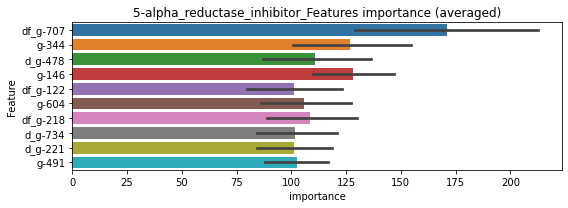

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339998	valid_1's binary_logloss: 0.0499937
[200]	training's binary_logloss: 0.00750646	valid_1's binary_logloss: 0.0194112
[300]	training's binary_logloss: 0.00204018	valid_1's binary_logloss: 0.0105251
[400]	training's binary_logloss: 0.000951827	valid_1's binary_logloss: 0.00839292
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000712966	valid_1's binary_logloss: 0.00769948


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337612	valid_1's binary_logloss: 0.0476582
[200]	training's binary_logloss: 0.00670134	valid_1's binary_logloss: 0.015692
[300]	training's binary_logloss: 0.00189959	valid_1's binary_logloss: 0.00767583
[400]	training's binary_logloss: 0.00090455	valid_1's binary_logloss: 0.005278
[500]	training's binary_logloss: 0.000610014	valid_1's binary_logloss: 0.00431118
[600]	training's binary_logloss: 0.000498302	valid_1's binary_logloss: 0.00400269
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00046853	valid_1's binary_logloss: 0.00387768


5-alpha_reductase_inhibitor logloss: 0.005788580667929627


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499756	valid_1's binary_logloss: 0.0737329
[200]	training's binary_logloss: 0.00938219	valid_1's binary_logloss: 0.0249817
[300]	training's binary_logloss: 0.0027479	valid_1's binary_logloss: 0.0132266
[400]	training's binary_logloss: 0.00139239	valid_1's binary_logloss: 0.00947323
[500]	training's binary_logloss: 0.00099639	valid_1's binary_logloss: 0.00816619
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00092744	valid_1's binary_logloss: 0.00802418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523257	valid_1's binary_logloss: 0.0698429
[200]	training's binary_logloss: 0.0104694	valid_1's binary_logloss: 0.0237724
[300]	training's binary_logloss: 0.00308461	valid_1's binary_logloss: 0.0118199
[400]	training's binary_logloss: 0.00156116	valid_1's binary_logloss: 0.00784489
Early stopping, best iteration is:
[476]	tr

1 / 3 AUC score:1.000
y_Threshold: 0.0119350, Threshold: 0.0608708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.05478, conf_1:0.06696
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0608708
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.0908708
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.1208708
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.1508708
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.1808708
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.2108708
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.2408708
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.2708708
threshold: 0.2708708, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424392	valid_1's binary_logloss: 0.0620877
[200]	training's binary_logloss: 0.00749615	valid_1's binary_logloss: 0.020082
[300]	training's binary_logloss: 0.00234215	valid_1's binary_logloss: 0.0107163
[400]	training's binary_logloss: 0.00123891	valid_1's binary_logloss: 0.00784349
[500]	training's binary_logloss: 0.000891651	valid_1's binary_logloss: 0.00691991
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000859201	valid_1's binary_logloss: 0.00684992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474619	valid_1's binary_logloss: 0.0607792
[200]	training's binary_logloss: 0.00840357	valid_1's binary_logloss: 0.0163602
[300]	training's binary_logloss: 0.00260105	valid_1's binary_logloss: 0.00764298
[400]	training's binary_logloss: 0.00134173	valid_1's binary_logloss: 0.00496356
[500]	training's binary_logloss: 0.0009

2 / 3 AUC score:1.000
y_Threshold: 0.1229617, Threshold: 0.2708708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.24378, conf_1:0.29796
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.2708708
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.3008708
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.3308708
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.3608708
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_5: 0.3908708
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.4208708
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.4508708
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_8: 0.4808708
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.5108708
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.5408708
threshold: 0.5708708, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437763	valid_1's binary_logloss: 0.0632945
[200]	training's binary_logloss: 0.0075534	valid_1's binary_logloss: 0.0182773
[300]	training's binary_logloss: 0.00234642	valid_1's binary_logloss: 0.00876051
[400]	training's binary_logloss: 0.00123967	valid_1's binary_logloss: 0.00605548
[500]	training's binary_logloss: 0.000900698	valid_1's binary_logloss: 0.00509392
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000777124	valid_1's binary_logloss: 0.00480916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441874	valid_1's binary_logloss: 0.0594499
[200]	training's binary_logloss: 0.00780307	valid_1's binary_logloss: 0.0164871
[300]	training's binary_logloss: 0.00239839	valid_1's binary_logloss: 0.00763287
[400]	training's binary_logloss: 0.00126527	valid_1's binary_logloss: 0.00524331


3 / 3 AUC score:1.000
y_Threshold: 0.1595870, Threshold: 0.5708708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.51378, conf_1:0.62796
threshold: 0.5708708, positive_p_label: 7.0/3982, p_label_rate: 0.0017579


[500]	training's binary_logloss: 0.000922507	valid_1's binary_logloss: 0.00452645
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000879253	valid_1's binary_logloss: 0.00437851


positive_y_label: 663.0/7791, y_label_rate: 0.0850982


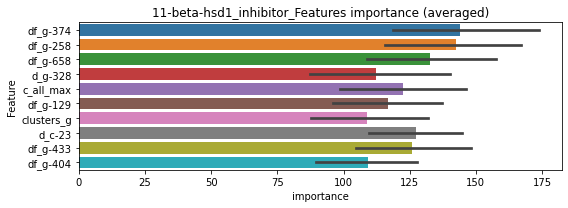

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293157	valid_1's binary_logloss: 0.0402619
[200]	training's binary_logloss: 0.00538426	valid_1's binary_logloss: 0.0123974
[300]	training's binary_logloss: 0.00147925	valid_1's binary_logloss: 0.0061424
[400]	training's binary_logloss: 0.00074175	valid_1's binary_logloss: 0.00475408
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000558165	valid_1's binary_logloss: 0.00434774


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255955	valid_1's binary_logloss: 0.0346337
[200]	training's binary_logloss: 0.00475661	valid_1's binary_logloss: 0.0102615
[300]	training's binary_logloss: 0.00137213	valid_1's binary_logloss: 0.00486468
[400]	training's binary_logloss: 0.000723679	valid_1's binary_logloss: 0.00355978
[500]	training's binary_logloss: 0.00051381	valid_1's binary_logloss: 0.00310872
[600]	training's binary_logloss: 0.000429185	valid_1's binary_logloss: 0.00287937
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.000410011	valid_1's binary_logloss: 0.00281343


11-beta-hsd1_inhibitor logloss: 0.003580679766909046


neg labels: 3289 → selected neg labels: 3282


acat_inhibitor, len(trt): 24, len(othr): 3282, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795118	valid_1's binary_logloss: 0.114224
[200]	training's binary_logloss: 0.0235414	valid_1's binary_logloss: 0.054427
[300]	training's binary_logloss: 0.00733973	valid_1's binary_logloss: 0.0303885
[400]	training's binary_logloss: 0.00307639	valid_1's binary_logloss: 0.0200781
[500]	training's binary_logloss: 0.0019016	valid_1's binary_logloss: 0.0169127
[600]	training's binary_logloss: 0.00145247	valid_1's binary_logloss: 0.0156214
[700]	training's binary_logloss: 0.00122267	valid_1's binary_logloss: 0.0147059
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.00121718	valid_1's binary_logloss: 0.014696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798239	valid_1's binary_logloss: 0.115352
[200]	training's binary_logloss: 0.023297	valid_1's binary_logloss: 0.0508877
[300]	training's binary_logloss: 0.00762444	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0214452, Threshold: 0.0757641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.06819, conf_1:0.08334
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0757641
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_2: 0.1057641
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.1357641
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.1657641
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_5: 0.1957641
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.2257641
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_7: 0.2557641
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.2857641
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_9: 0.3157641
threshold: 0.3157641, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676667	valid_1's binary_logloss: 0.0992422
[200]	training's binary_logloss: 0.0181202	valid_1's binary_logloss: 0.039945
[300]	training's binary_logloss: 0.00574933	valid_1's binary_logloss: 0.0212447
[400]	training's binary_logloss: 0.00261305	valid_1's binary_logloss: 0.0137073
[500]	training's binary_logloss: 0.00171496	valid_1's binary_logloss: 0.011048
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00137315	valid_1's binary_logloss: 0.0101042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702779	valid_1's binary_logloss: 0.101325
[200]	training's binary_logloss: 0.0176244	valid_1's binary_logloss: 0.0408396
[300]	training's binary_logloss: 0.00560312	valid_1's binary_logloss: 0.0209254
[400]	training's binary_logloss: 0.00267383	valid_1's binary_logloss: 0.0148779
[500]	training's binary_logloss: 0.00172791	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1703869, Threshold: 0.3157641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0050226 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.28419, conf_1:0.34734
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.3157641
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.3457641
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.3757641
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.4057641
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.4357641
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.4657641
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.4957641
threshold: 0.4957641, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720994	valid_1's binary_logloss: 0.102057
[200]	training's binary_logloss: 0.019047	valid_1's binary_logloss: 0.0403646
[300]	training's binary_logloss: 0.00576844	valid_1's binary_logloss: 0.0208054
[400]	training's binary_logloss: 0.0026511	valid_1's binary_logloss: 0.0137021
[500]	training's binary_logloss: 0.00171249	valid_1's binary_logloss: 0.011388
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00152042	valid_1's binary_logloss: 0.0110639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065418	valid_1's binary_logloss: 0.103437
[200]	training's binary_logloss: 0.0165232	valid_1's binary_logloss: 0.0420811
[300]	training's binary_logloss: 0.00537775	valid_1's binary_logloss: 0.0224434
[400]	training's binary_logloss: 0.00255251	valid_1's binary_logloss: 0.0156973
[500]	training's binary_logloss: 0.00165003	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.2283796, Threshold: 0.4957641, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00156793	valid_1's binary_logloss: 0.0124247


Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.44619, conf_1:0.54534
threshold: 0.4957641, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 663.0/7782, y_label_rate: 0.0851966


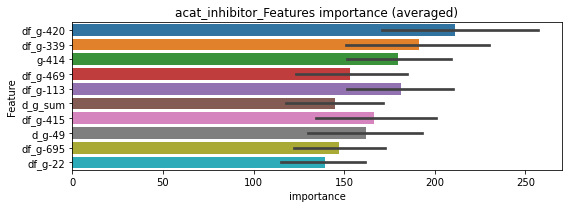

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371728	valid_1's binary_logloss: 0.0630608
[200]	training's binary_logloss: 0.00984413	valid_1's binary_logloss: 0.0316269
[300]	training's binary_logloss: 0.00299092	valid_1's binary_logloss: 0.021446


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00163653	valid_1's binary_logloss: 0.0194043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408514	valid_1's binary_logloss: 0.0639203
[200]	training's binary_logloss: 0.0104244	valid_1's binary_logloss: 0.0276396
[300]	training's binary_logloss: 0.00344566	valid_1's binary_logloss: 0.0152765
[400]	training's binary_logloss: 0.00152091	valid_1's binary_logloss: 0.010629
[500]	training's binary_logloss: 0.000970295	valid_1's binary_logloss: 0.00920525
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000995081	valid_1's binary_logloss: 0.0091689


acat_inhibitor logloss: 0.014286580518520234


neg labels: 3289 → selected neg labels: 3261


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3261, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177182	valid_1's binary_logloss: 0.283819
[200]	training's binary_logloss: 0.0965235	valid_1's binary_logloss: 0.245696
[300]	training's binary_logloss: 0.0556958	valid_1's binary_logloss: 0.229255
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0332994	valid_1's binary_logloss: 0.219371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17005	valid_1's binary_logloss: 0.291689
[200]	training's binary_logloss: 0.0885756	valid_1's binary_logloss: 0.253092
[300]	training's binary_logloss: 0.0480328	valid_1's binary_logloss: 0.236483


1 / 3 AUC score:0.921
y_Threshold: 0.1393268, Threshold: 0.4494488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 401 → Positive_corect_labels: 517/3512
p_label_rate: 0.0100452 Vs.target_rate: 0.00798, Num_p_label: 40.0, conf_0:0.40450, conf_1:0.49439
threshold: 0.4494488, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0344049	valid_1's binary_logloss: 0.233229


positive_y_label: 517.0/3512, y_label_rate: 0.1472096
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120518	valid_1's binary_logloss: 0.228792
[200]	training's binary_logloss: 0.0481427	valid_1's binary_logloss: 0.182513
[300]	training's binary_logloss: 0.0215378	valid_1's binary_logloss: 0.16676
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0166714	valid_1's binary_logloss: 0.163904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126663	valid_1's binary_logloss: 0.206302
[200]	training's binary_logloss: 0.0549585	valid_1's binary_logloss: 0.152146
[300]	training's binary_logloss: 0.0256262	valid_1's binary_logloss: 0.130135


2 / 3 AUC score:0.968
y_Threshold: 0.1740352, Threshold: 0.4494488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 431.0/3340
p_label_rate: 0.0246107 Vs.target_rate: 0.00798, Num_p_label: 98.0, conf_0:0.40450, conf_1:0.49439
Num_p_label: 98.0, Expected: 31.8, Adj_threshold_1: 0.4494488
Num_p_label: 90.0, Expected: 31.8, Adj_threshold_2: 0.4794488
Num_p_label: 80.0, Expected: 31.8, Adj_threshold_3: 0.5094488
Num_p_label: 72.0, Expected: 31.8, Adj_threshold_4: 0.5394488
Num_p_label: 60.0, Expected: 31.8, Adj_threshold_5: 0.5694488
threshold: 0.5694488, positive_p_label: 60.0/3982, p_label_rate: 0.0150678


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0160708	valid_1's binary_logloss: 0.122976


positive_y_label: 431.0/3340, y_label_rate: 0.1290419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850931	valid_1's binary_logloss: 0.165848
[200]	training's binary_logloss: 0.029924	valid_1's binary_logloss: 0.120091
[300]	training's binary_logloss: 0.012193	valid_1's binary_logloss: 0.104162
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.011859	valid_1's binary_logloss: 0.103884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964486	valid_1's binary_logloss: 0.180492
[200]	training's binary_logloss: 0.0346809	valid_1's binary_logloss: 0.135121


3 / 3 AUC score:0.985
y_Threshold: 0.1548384, Threshold: 0.5694488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 372.0/3222
p_label_rate: 0.0180814 Vs.target_rate: 0.00798, Num_p_label: 72.0, conf_0:0.51250, conf_1:0.62639
threshold: 0.5694488, positive_p_label: 72.0/3982, p_label_rate: 0.0180814


[300]	training's binary_logloss: 0.014202	valid_1's binary_logloss: 0.118883
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0131749	valid_1's binary_logloss: 0.118464


positive_y_label: 444.0/7204, y_label_rate: 0.0616324


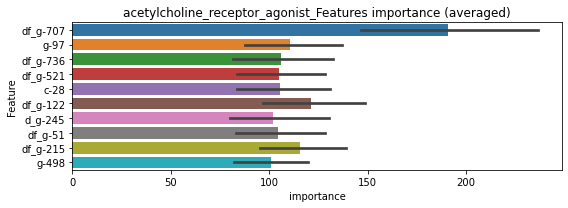

len(train_index) : 3602
len(valid_index) : 3602
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513907	valid_1's binary_logloss: 0.0948462
[200]	training's binary_logloss: 0.020518	valid_1's binary_logloss: 0.0697404
[300]	training's binary_logloss: 0.00870827	valid_1's binary_logloss: 0.0597734
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00668067	valid_1's binary_logloss: 0.0580623


len(train_index) : 3602
len(valid_index) : 3602
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594535	valid_1's binary_logloss: 0.0946342
[200]	training's binary_logloss: 0.0216161	valid_1's binary_logloss: 0.0697083
[300]	training's binary_logloss: 0.00882139	valid_1's binary_logloss: 0.0623229
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00735649	valid_1's binary_logloss: 0.0611693


acetylcholine_receptor_agonist logloss: 0.05961579892576592


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200904	valid_1's binary_logloss: 0.372016
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.137925	valid_1's binary_logloss: 0.358107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212419	valid_1's binary_logloss: 0.362759
[200]	training's binary_logloss: 0.113541	valid_1's binary_logloss: 0.330827
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0879105	valid_1's binary_logloss: 0.32607


1 / 3 AUC score:0.802
y_Threshold: 0.1820361, Threshold: 0.3323778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 640 → Positive_corect_labels: 393/3249
p_label_rate: 0.0100452 Vs.target_rate: 0.01264, Num_p_label: 40.0, conf_0:0.29914, conf_1:0.36562
threshold: 0.3323778, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 393.0/3249, y_label_rate: 0.1209603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107403	valid_1's binary_logloss: 0.232002
[200]	training's binary_logloss: 0.0459154	valid_1's binary_logloss: 0.200087
[300]	training's binary_logloss: 0.0222216	valid_1's binary_logloss: 0.191516
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.021215	valid_1's binary_logloss: 0.190841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107811	valid_1's binary_logloss: 0.219879
[200]	training's binary_logloss: 0.0450186	valid_1's binary_logloss: 0.190173


2 / 3 AUC score:0.933
y_Threshold: 0.1302042, Threshold: 0.3323778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → Positive_corect_labels: 292.0/3047
p_label_rate: 0.0188348 Vs.target_rate: 0.01264, Num_p_label: 75.0, conf_0:0.29914, conf_1:0.36562
threshold: 0.3323778, positive_p_label: 75.0/3982, p_label_rate: 0.0188348


[300]	training's binary_logloss: 0.0199966	valid_1's binary_logloss: 0.179719
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0196246	valid_1's binary_logloss: 0.179686


positive_y_label: 292.0/3047, y_label_rate: 0.0958320
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674788	valid_1's binary_logloss: 0.161991
[200]	training's binary_logloss: 0.0219751	valid_1's binary_logloss: 0.139287
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0179615	valid_1's binary_logloss: 0.137759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708038	valid_1's binary_logloss: 0.17144


3 / 3 AUC score:0.958
y_Threshold: 0.1152931, Threshold: 0.3323778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 130 → Positive_corect_labels: 227.0/2917


[200]	training's binary_logloss: 0.0259187	valid_1's binary_logloss: 0.143101
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0187767	valid_1's binary_logloss: 0.137595


p_label_rate: 0.0168257 Vs.target_rate: 0.01264, Num_p_label: 67.0, conf_0:0.29914, conf_1:0.36562
threshold: 0.3323778, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 294.0/6899, y_label_rate: 0.0426149


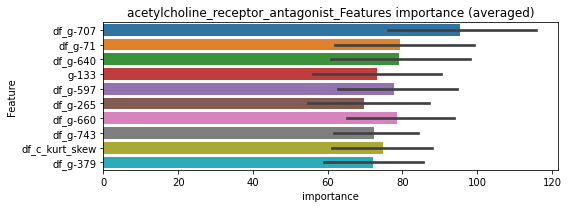

len(train_index) : 3449
len(valid_index) : 3450
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315549	valid_1's binary_logloss: 0.0896765


len(train_index) : 3450
len(valid_index) : 3449
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0103106	valid_1's binary_logloss: 0.0803022
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0105727	valid_1's binary_logloss: 0.0802561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037599	valid_1's binary_logloss: 0.0834056
[200]	training's binary_logloss: 0.0123817	valid_1's binary_logloss: 0.0708332
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00909924	valid_1's binary_logloss: 0.0698687


acetylcholine_receptor_antagonist logloss: 0.07506314143073206


neg labels: 3289 → selected neg labels: 3281


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102691	valid_1's binary_logloss: 0.170142
[200]	training's binary_logloss: 0.0398214	valid_1's binary_logloss: 0.11561
[300]	training's binary_logloss: 0.0163542	valid_1's binary_logloss: 0.0921447
[400]	training's binary_logloss: 0.00795632	valid_1's binary_logloss: 0.0831376
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00767901	valid_1's binary_logloss: 0.0826972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104347	valid_1's binary_logloss: 0.166321
[200]	training's binary_logloss: 0.0449085	valid_1's binary_logloss: 0.116775
[300]	training's binary_logloss: 0.0192241	valid_1's binary_logloss: 0.0942401
[400]	training's binary_logloss: 0.00895303	valid_1's binary_logloss: 0.0841757


1 / 3 AUC score:0.990
y_Threshold: 0.0535914, Threshold: 0.1829498, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00558271	valid_1's binary_logloss: 0.0806027


Remove_noisy_labels: 192 → Positive_corect_labels: 626/3745
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.16465, conf_1:0.20124
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1829498
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_2: 0.2129498
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_3: 0.2429498
threshold: 0.2429498, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 626.0/3745, y_label_rate: 0.1671562
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879287	valid_1's binary_logloss: 0.159373
[200]	training's binary_logloss: 0.0313713	valid_1's binary_logloss: 0.112806
[300]	training's binary_logloss: 0.0122966	valid_1's binary_logloss: 0.0943332
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00755332	valid_1's binary_logloss: 0.0887004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925834	valid_1's binary_logloss: 0.155125
[200]	training's binary_logloss: 0.0327332	valid_1's binary_logloss: 0.0946641
[300]	training's binary_logloss: 0.0140371	valid_1's binary_logloss: 0.0712717
[400]	training's binary_logloss: 0.00659316	valid_1's binary_logloss: 0.0593733
[500]	training's binary_logloss: 0.00374489	valid_1's binary_logloss: 0.0536368
[600]	training's binary_logloss: 0.00255577	valid_1's binary_logloss: 0.0510487
Early stopping, best iteration is:
[615]	training's 

2 / 3 AUC score:0.996
y_Threshold: 0.1052965, Threshold: 0.2429498, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 594.0/3681
p_label_rate: 0.0173280 Vs.target_rate: 0.00307, Num_p_label: 69.0, conf_0:0.21865, conf_1:0.26724
Num_p_label: 69.0, Expected: 12.2, Adj_threshold_1: 0.2429498
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.2729498
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_3: 0.3029498
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_4: 0.3329498
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_5: 0.3629498
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_6: 0.3929498
threshold: 0.3929498, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 594.0/3681, y_label_rate: 0.1613692
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809447	valid_1's binary_logloss: 0.14403
[200]	training's binary_logloss: 0.0274201	valid_1's binary_logloss: 0.0867631
[300]	training's binary_logloss: 0.0106238	valid_1's binary_logloss: 0.0653451
[400]	training's binary_logloss: 0.00513945	valid_1's binary_logloss: 0.0550946
[500]	training's binary_logloss: 0.0030257	valid_1's binary_logloss: 0.0516649
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00274836	valid_1's binary_logloss: 0.0508613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088911	valid_1's binary_logloss: 0.136097
[200]	training's binary_logloss: 0.0298023	valid_1's binary_logloss: 0.078392
[300]	training's binary_logloss: 0.0119174	valid_1's binary_logloss: 0.0609898
[400]	training's binary_logloss: 0.00559478	valid_1's binary_logloss: 0.0549342


3 / 3 AUC score:0.998
y_Threshold: 0.0887990, Threshold: 0.3929498, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.0034763	valid_1's binary_logloss: 0.0521363


Remove_noisy_labels: 44 → Positive_corect_labels: 572.0/3637
p_label_rate: 0.0055249 Vs.target_rate: 0.00307, Num_p_label: 22.0, conf_0:0.35365, conf_1:0.43224
threshold: 0.3929498, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 594.0/7619, y_label_rate: 0.0779630


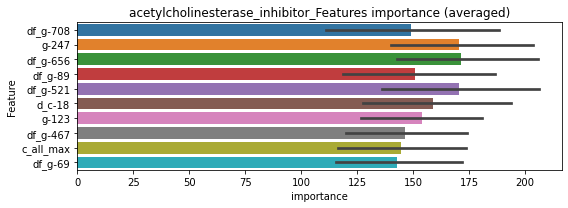

len(train_index) : 3809
len(valid_index) : 3810
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474743	valid_1's binary_logloss: 0.0715883
[200]	training's binary_logloss: 0.0157895	valid_1's binary_logloss: 0.0416795
[300]	training's binary_logloss: 0.00627316	valid_1's binary_logloss: 0.0303602
[400]	training's binary_logloss: 0.00289393	valid_1's binary_logloss: 0.0258622
[500]	training's binary_logloss: 0.00169911	valid_1's binary_logloss: 0.023794
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0017387	valid_1's binary_logloss: 0.0237426


len(train_index) : 3810
len(valid_index) : 3809
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441974	valid_1's binary_logloss: 0.0759824
[200]	training's binary_logloss: 0.0140635	valid_1's binary_logloss: 0.0486901
[300]	training's binary_logloss: 0.0056001	valid_1's binary_logloss: 0.0401847
[400]	training's binary_logloss: 0.00261565	valid_1's binary_logloss: 0.0370237
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00165432	valid_1's binary_logloss: 0.035655


acetylcholinesterase_inhibitor logloss: 0.029698039127062318


neg labels: 3289 → selected neg labels: 3278


adenosine_receptor_agonist, len(trt): 54, len(othr): 3278, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801975	valid_1's binary_logloss: 0.127073
[200]	training's binary_logloss: 0.0257341	valid_1's binary_logloss: 0.0733585
[300]	training's binary_logloss: 0.00959384	valid_1's binary_logloss: 0.0537466
[400]	training's binary_logloss: 0.00449898	valid_1's binary_logloss: 0.0450832
[500]	training's binary_logloss: 0.00270069	valid_1's binary_logloss: 0.0419497
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00281603	valid_1's binary_logloss: 0.0419357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810717	valid_1's binary_logloss: 0.126322
[200]	training's binary_logloss: 0.0264748	valid_1's binary_logloss: 0.0718494
[300]	training's binary_logloss: 0.00976171	valid_1's binary_logloss: 0.0517155
[400]	training's binary_logloss: 0.00446408	valid_1's binary_logloss: 0.0437273
[500]	training's binary_logloss: 0.0026321	valid_

1 / 3 AUC score:0.998
y_Threshold: 0.0311385, Threshold: 0.1332984, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.11997, conf_1:0.14663
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1332984
Num_p_label: 27.0, Expected: 9.0, Adj_threshold_2: 0.1632984
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_3: 0.1932984
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.2232984
threshold: 0.2232984, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754642	valid_1's binary_logloss: 0.137169
[200]	training's binary_logloss: 0.0232997	valid_1's binary_logloss: 0.0836511
[300]	training's binary_logloss: 0.00798445	valid_1's binary_logloss: 0.0617788
[400]	training's binary_logloss: 0.00374162	valid_1's binary_logloss: 0.05386
[500]	training's binary_logloss: 0.00227444	valid_1's binary_logloss: 0.0505894
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00174604	valid_1's binary_logloss: 0.0485111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799747	valid_1's binary_logloss: 0.11774
[200]	training's binary_logloss: 0.0248752	valid_1's binary_logloss: 0.0605385
[300]	training's binary_logloss: 0.00917214	valid_1's binary_logloss: 0.0401048
[400]	training's binary_logloss: 0.00415632	valid_1's binary_logloss: 0.0317969
[500]	training's binary_logloss: 0.00251022	valid_1'

2 / 3 AUC score:0.999
y_Threshold: 0.0905911, Threshold: 0.2232984, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 633.0/3757
p_label_rate: 0.0095429 Vs.target_rate: 0.00227, Num_p_label: 38.0, conf_0:0.20097, conf_1:0.24563
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_1: 0.2232984
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_2: 0.2532984
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_3: 0.2832984
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_4: 0.3132984
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_5: 0.3432984
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_6: 0.3732984
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_7: 0.4032984
threshold: 0.4032984, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 633.0/3757, y_label_rate: 0.1684855
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697608	valid_1's binary_logloss: 0.115362
[200]	training's binary_logloss: 0.0209898	valid_1's binary_logloss: 0.0639842
[300]	training's binary_logloss: 0.0075763	valid_1's binary_logloss: 0.0445916
[400]	training's binary_logloss: 0.0035201	valid_1's binary_logloss: 0.0363296
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00304746	valid_1's binary_logloss: 0.0354597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767278	valid_1's binary_logloss: 0.111869
[200]	training's binary_logloss: 0.0222773	valid_1's binary_logloss: 0.0552331
[300]	training's binary_logloss: 0.00787439	valid_1's binary_logloss: 0.0359059
[400]	training's binary_logloss: 0.00359296	valid_1's binary_logloss: 0.027783
[500]	training's binary_logloss: 0.00220682	valid_1's binary_logloss: 0.0253291
Early stopping, best iteration is:
[561]	training's 

3 / 3 AUC score:1.000
y_Threshold: 0.0940724, Threshold: 0.4032984, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 622.0/3735
p_label_rate: 0.0035158 Vs.target_rate: 0.00227, Num_p_label: 14.0, conf_0:0.36297, conf_1:0.44363
threshold: 0.4032984, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 636.0/7717, y_label_rate: 0.0824154


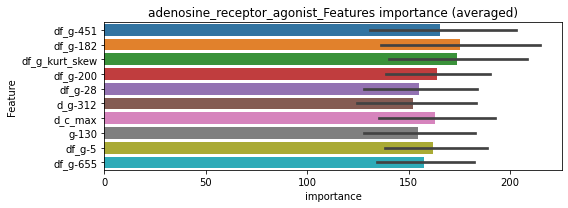

len(train_index) : 3858
len(valid_index) : 3859
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395948	valid_1's binary_logloss: 0.0681279
[200]	training's binary_logloss: 0.0108553	valid_1's binary_logloss: 0.0364103
[300]	training's binary_logloss: 0.00384158	valid_1's binary_logloss: 0.0271383
[400]	training's binary_logloss: 0.00180001	valid_1's binary_logloss: 0.0234074
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00152908	valid_1's binary_logloss: 0.0226422


len(train_index) : 3859
len(valid_index) : 3858
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421931	valid_1's binary_logloss: 0.0671788
[200]	training's binary_logloss: 0.0134278	valid_1's binary_logloss: 0.0373329
[300]	training's binary_logloss: 0.0045525	valid_1's binary_logloss: 0.0254805
[400]	training's binary_logloss: 0.00209011	valid_1's binary_logloss: 0.0206301
[500]	training's binary_logloss: 0.00125792	valid_1's binary_logloss: 0.0188789
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00127752	valid_1's binary_logloss: 0.0188019


adenosine_receptor_agonist logloss: 0.02072227782796655


neg labels: 3289 → selected neg labels: 3276


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3276, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130186	valid_1's binary_logloss: 0.214361
[200]	training's binary_logloss: 0.0613525	valid_1's binary_logloss: 0.156237
[300]	training's binary_logloss: 0.0284671	valid_1's binary_logloss: 0.129143
[400]	training's binary_logloss: 0.0134739	valid_1's binary_logloss: 0.113675
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00858719	valid_1's binary_logloss: 0.108675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1359	valid_1's binary_logloss: 0.212623
[200]	training's binary_logloss: 0.0634104	valid_1's binary_logloss: 0.165104
[300]	training's binary_logloss: 0.0284255	valid_1's binary_logloss: 0.143622


1 / 3 AUC score:0.972
y_Threshold: 0.0808727, Threshold: 0.2472533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 234 → Positive_corect_labels: 604/3697
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.22253, conf_1:0.27198
threshold: 0.2472533, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0159885	valid_1's binary_logloss: 0.137273


positive_y_label: 604.0/3697, y_label_rate: 0.1633757
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111187	valid_1's binary_logloss: 0.185883
[200]	training's binary_logloss: 0.045773	valid_1's binary_logloss: 0.132171
[300]	training's binary_logloss: 0.0214743	valid_1's binary_logloss: 0.108849
[400]	training's binary_logloss: 0.00983148	valid_1's binary_logloss: 0.0914771
[500]	training's binary_logloss: 0.00535478	valid_1's binary_logloss: 0.0842742
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00451142	valid_1's binary_logloss: 0.0825758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120456	valid_1's binary_logloss: 0.187133
[200]	training's binary_logloss: 0.0462003	valid_1's binary_logloss: 0.122415
[300]	training's binary_logloss: 0.0207011	valid_1's binary_logloss: 0.0969441
[400]	training's binary_logloss: 0.0101013	valid_1's binary_logloss: 0.0856697
[500]	training's binary_logloss: 0.00547061	valid_1's bina

2 / 3 AUC score:0.993
y_Threshold: 0.0990548, Threshold: 0.2472533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 563.0/3615
p_label_rate: 0.0180814 Vs.target_rate: 0.00403, Num_p_label: 72.0, conf_0:0.22253, conf_1:0.27198
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_1: 0.2472533
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_2: 0.2772533
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_3: 0.3072533
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_4: 0.3372533
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_5: 0.3672533
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_6: 0.3972533
threshold: 0.3972533, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 563.0/3615, y_label_rate: 0.1557400
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915598	valid_1's binary_logloss: 0.169983
[200]	training's binary_logloss: 0.0336556	valid_1's binary_logloss: 0.117526
[300]	training's binary_logloss: 0.0139117	valid_1's binary_logloss: 0.0950289
[400]	training's binary_logloss: 0.00655424	valid_1's binary_logloss: 0.0849586
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00488669	valid_1's binary_logloss: 0.0828509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102051	valid_1's binary_logloss: 0.162668
[200]	training's binary_logloss: 0.0398987	valid_1's binary_logloss: 0.106009
[300]	training's binary_logloss: 0.0163383	valid_1's binary_logloss: 0.0813326
[400]	training's binary_logloss: 0.00738751	valid_1's binary_logloss: 0.0691238
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00580909	valid_1's binary_logloss: 0.0664363


3 / 3 AUC score:0.993
y_Threshold: 0.1222799, Threshold: 0.3972533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 529.0/3547
p_label_rate: 0.0077850 Vs.target_rate: 0.00403, Num_p_label: 31.0, conf_0:0.35753, conf_1:0.43698
threshold: 0.3972533, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 560.0/7529, y_label_rate: 0.0743791


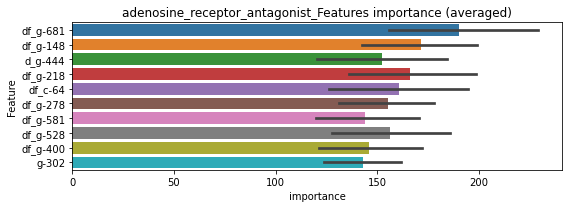

len(train_index) : 3764
len(valid_index) : 3765
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497148	valid_1's binary_logloss: 0.090386
[200]	training's binary_logloss: 0.0185395	valid_1's binary_logloss: 0.0647578
[300]	training's binary_logloss: 0.00751535	valid_1's binary_logloss: 0.0541732
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00573201	valid_1's binary_logloss: 0.0528331


len(train_index) : 3765
len(valid_index) : 3764
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505607	valid_1's binary_logloss: 0.0897121
[200]	training's binary_logloss: 0.0180702	valid_1's binary_logloss: 0.0589245
[300]	training's binary_logloss: 0.0072503	valid_1's binary_logloss: 0.0475108
[400]	training's binary_logloss: 0.00358101	valid_1's binary_logloss: 0.0424545
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00281366	valid_1's binary_logloss: 0.0409012


adenosine_receptor_antagonist logloss: 0.04686796429109098


neg labels: 3289 → selected neg labels: 3289


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586408	valid_1's binary_logloss: 0.0877428
[200]	training's binary_logloss: 0.0126091	valid_1's binary_logloss: 0.0373618
[300]	training's binary_logloss: 0.00388695	valid_1's binary_logloss: 0.024094
[400]	training's binary_logloss: 0.00187176	valid_1's binary_logloss: 0.0199359
[500]	training's binary_logloss: 0.0012485	valid_1's binary_logloss: 0.0183539
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00111606	valid_1's binary_logloss: 0.0177318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542278	valid_1's binary_logloss: 0.0767031
[200]	training's binary_logloss: 0.0134284	valid_1's binary_logloss: 0.0302028
[300]	training's binary_logloss: 0.00410318	valid_1's binary_logloss: 0.0158756
[400]	training's binary_logloss: 0.0019467	valid_1's binary_logloss: 0.0113216
[500]	training's binary_logloss: 0.00131129	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0139624, Threshold: 0.1808190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.16274, conf_1:0.19890
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1808190
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.2108190
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.2408190
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.2708190
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_5: 0.3008190
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.3308190
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.3608190
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.3908190
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.4208190
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.4508190
threshold: 0.4808190, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497699	valid_1's binary_logloss: 0.0719374
[200]	training's binary_logloss: 0.0102528	valid_1's binary_logloss: 0.0240567
[300]	training's binary_logloss: 0.00310416	valid_1's binary_logloss: 0.0124764
[400]	training's binary_logloss: 0.00155466	valid_1's binary_logloss: 0.00852557
[500]	training's binary_logloss: 0.0010934	valid_1's binary_logloss: 0.00713182
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000920158	valid_1's binary_logloss: 0.00651748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491314	valid_1's binary_logloss: 0.0682142
[200]	training's binary_logloss: 0.0100112	valid_1's binary_logloss: 0.0225544
[300]	training's binary_logloss: 0.00313625	valid_1's binary_logloss: 0.0115037
[400]	training's binary_logloss: 0.00160313	valid_1's binary_logloss: 0.00812075
Early stopping, best iteration is:
[465]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.2055182, Threshold: 0.4808190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0138122 Vs.target_rate: 0.00076, Num_p_label: 55.0, conf_0:0.43274, conf_1:0.52890
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_1: 0.4808190
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_2: 0.5108190
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_3: 0.5408190
Num_p_label: 52.0, Expected: 3.0, Adj_threshold_4: 0.5708190
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_5: 0.6008190
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_6: 0.6308190
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_7: 0.6608190
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_8: 0.6908190
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_9: 0.7208190
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_10: 0.7508190
threshold: 0.7808190, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477768	valid_1's binary_logloss: 0.0713806
[200]	training's binary_logloss: 0.00968947	valid_1's binary_logloss: 0.0232198
[300]	training's binary_logloss: 0.00305212	valid_1's binary_logloss: 0.0123992
[400]	training's binary_logloss: 0.0015616	valid_1's binary_logloss: 0.00869203
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00118952	valid_1's binary_logloss: 0.00755334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507073	valid_1's binary_logloss: 0.0669239
[200]	training's binary_logloss: 0.0103593	valid_1's binary_logloss: 0.0198131
[300]	training's binary_logloss: 0.00321283	valid_1's binary_logloss: 0.00904455
[400]	training's binary_logloss: 0.00162145	valid_1's binary_logloss: 0.00595995
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00116054	valid_1's binary_logloss: 0.0051271


3 / 3 AUC score:1.000
y_Threshold: 0.3633332, Threshold: 0.7808190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00076, Num_p_label: 31.0, conf_0:0.70274, conf_1:0.85890
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_1: 0.7808190
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.8108190
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.8408190
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_4: 0.8708190
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.9008190
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.9308190
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.9608190
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_8: 0.9908190
threshold: 0.9908190, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 656.0/7793, y_label_rate: 0.0841781


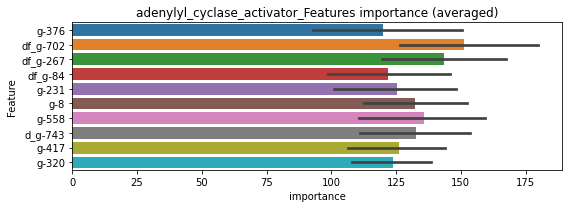

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029504	valid_1's binary_logloss: 0.0459841
[200]	training's binary_logloss: 0.00661073	valid_1's binary_logloss: 0.019443
[300]	training's binary_logloss: 0.00197656	valid_1's binary_logloss: 0.0117483
[400]	training's binary_logloss: 0.000931324	valid_1's binary_logloss: 0.00898619
[500]	training's binary_logloss: 0.000639545	valid_1's binary_logloss: 0.00785587
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000634022	valid_1's binary_logloss: 0.00784762


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298704	valid_1's binary_logloss: 0.0424636
[200]	training's binary_logloss: 0.0061244	valid_1's binary_logloss: 0.0139472
[300]	training's binary_logloss: 0.00180654	valid_1's binary_logloss: 0.00676155
[400]	training's binary_logloss: 0.000909228	valid_1's binary_logloss: 0.00531232
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000677638	valid_1's binary_logloss: 0.00479031


adenylyl_cyclase_activator logloss: 0.006319161383886934


neg labels: 3289 → selected neg labels: 3254


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3254, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192895	valid_1's binary_logloss: 0.350042
[200]	training's binary_logloss: 0.109583	valid_1's binary_logloss: 0.326475
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0905005	valid_1's binary_logloss: 0.323861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201596	valid_1's binary_logloss: 0.351293
[200]	training's binary_logloss: 0.116521	valid_1's binary_logloss: 0.324379


1 / 3 AUC score:0.839
y_Threshold: 0.1705569, Threshold: 0.7824098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 559 → Positive_corect_labels: 436/3345
p_label_rate: 0.0100452 Vs.target_rate: 0.01134, Num_p_label: 40.0, conf_0:0.70417, conf_1:0.86065
threshold: 0.7824098, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


[300]	training's binary_logloss: 0.0715948	valid_1's binary_logloss: 0.310511
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0735704	valid_1's binary_logloss: 0.310161


positive_y_label: 436.0/3345, y_label_rate: 0.1303438
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114631	valid_1's binary_logloss: 0.228517
[200]	training's binary_logloss: 0.0473754	valid_1's binary_logloss: 0.196381
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0321613	valid_1's binary_logloss: 0.188285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125049	valid_1's binary_logloss: 0.214961
[200]	training's binary_logloss: 0.0543842	valid_1's binary_logloss: 0.175836


2 / 3 AUC score:0.949
y_Threshold: 0.1579146, Threshold: 0.7824098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 194 → Positive_corect_labels: 339.0/3151
p_label_rate: 0.0344048 Vs.target_rate: 0.01134, Num_p_label: 137.0, conf_0:0.70417, conf_1:0.86065
Num_p_label: 137.0, Expected: 45.1, Adj_threshold_1: 0.7824098
Num_p_label: 129.0, Expected: 45.1, Adj_threshold_2: 0.8124098
Num_p_label: 121.0, Expected: 45.1, Adj_threshold_3: 0.8424098
Num_p_label: 113.0, Expected: 45.1, Adj_threshold_4: 0.8724098
Num_p_label: 108.0, Expected: 45.1, Adj_threshold_5: 0.9024098
Num_p_label: 86.0, Expected: 45.1, Adj_threshold_6: 0.9324098
threshold: 0.9324098, positive_p_label: 86.0/3982, p_label_rate: 0.0215972


[300]	training's binary_logloss: 0.0260849	valid_1's binary_logloss: 0.164957
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0266386	valid_1's binary_logloss: 0.164772


positive_y_label: 339.0/3151, y_label_rate: 0.1075849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078151	valid_1's binary_logloss: 0.167209
[200]	training's binary_logloss: 0.0284265	valid_1's binary_logloss: 0.135629
[300]	training's binary_logloss: 0.0111578	valid_1's binary_logloss: 0.122557
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0102936	valid_1's binary_logloss: 0.121766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796747	valid_1's binary_logloss: 0.171452
[200]	training's binary_logloss: 0.0272925	valid_1's binary_logloss: 0.141898
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0169013	valid_1's binary_logloss: 0.136603


3 / 3 AUC score:0.975
y_Threshold: 0.1177909, Threshold: 0.9324098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 281.0/3035
p_label_rate: 0.0276243 Vs.target_rate: 0.01134, Num_p_label: 110.0, conf_0:0.83917, conf_1:1.02565
threshold: 0.9324098, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 391.0/7017, y_label_rate: 0.0557218


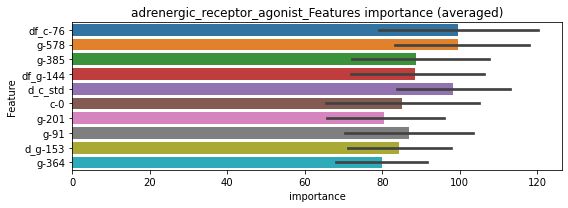

len(train_index) : 3508
len(valid_index) : 3509
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473176	valid_1's binary_logloss: 0.0861533
[200]	training's binary_logloss: 0.0168975	valid_1's binary_logloss: 0.0667165


len(train_index) : 3509
len(valid_index) : 3508
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00885117	valid_1's binary_logloss: 0.0631355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375902	valid_1's binary_logloss: 0.0923217


adrenergic_receptor_agonist logloss: 0.07217675941355993


[200]	training's binary_logloss: 0.0121479	valid_1's binary_logloss: 0.0813773
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0113649	valid_1's binary_logloss: 0.0812206
neg labels: 3289 → selected neg labels: 3240


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3240, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214101	valid_1's binary_logloss: 0.373261
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.187074	valid_1's binary_logloss: 0.367272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223517	valid_1's binary_logloss: 0.374082


1 / 3 AUC score:0.761
y_Threshold: 0.1857686, Threshold: 0.6210292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 690 → Positive_corect_labels: 368/3198
p_label_rate: 0.0100452 Vs.target_rate: 0.01512, Num_p_label: 40.0, conf_0:0.55893, conf_1:0.68313
threshold: 0.6210292, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 368.0/3198, y_label_rate: 0.1150719
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.145966	valid_1's binary_logloss: 0.357212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938273	valid_1's binary_logloss: 0.19779
[200]	training's binary_logloss: 0.0358829	valid_1's binary_logloss: 0.177157
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0331996	valid_1's binary_logloss: 0.176737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093223	valid_1's binary_logloss: 0.182171


2 / 3 AUC score:0.948
y_Threshold: 0.1242615, Threshold: 0.6210292, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0352139	valid_1's binary_logloss: 0.15688
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0349067	valid_1's binary_logloss: 0.156775


Remove_noisy_labels: 178 → Positive_corect_labels: 279.0/3020
p_label_rate: 0.0431944 Vs.target_rate: 0.01512, Num_p_label: 172.0, conf_0:0.55893, conf_1:0.68313
threshold: 0.6210292, positive_p_label: 172.0/3982, p_label_rate: 0.0431944
positive_y_label: 279.0/3020, y_label_rate: 0.0923841
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525052	valid_1's binary_logloss: 0.13347
[200]	training's binary_logloss: 0.0174998	valid_1's binary_logloss: 0.111148
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0130463	valid_1's binary_logloss: 0.108475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046846	valid_1's binary_logloss: 0.12177
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0211505	valid_1's binary_logloss: 0.105503


3 / 3 AUC score:0.977
y_Threshold: 0.0914223, Threshold: 0.6210292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 239.0/2940
p_label_rate: 0.0489704 Vs.target_rate: 0.01512, Num_p_label: 195.0, conf_0:0.55893, conf_1:0.68313
Num_p_label: 195.0, Expected: 60.2, Adj_threshold_1: 0.6210292
Num_p_label: 193.0, Expected: 60.2, Adj_threshold_2: 0.6510292
Num_p_label: 190.0, Expected: 60.2, Adj_threshold_3: 0.6810292
Num_p_label: 182.0, Expected: 60.2, Adj_threshold_4: 0.7110292
Num_p_label: 180.0, Expected: 60.2, Adj_threshold_5: 0.7410292
Num_p_label: 179.0, Expected: 60.2, Adj_threshold_6: 0.7710292
Num_p_label: 178.0, Expected: 60.2, Adj_threshold_7: 0.8010292
Num_p_label: 173.0, Expected: 60.2, Adj_threshold_8: 0.8310292
Num_p_label: 171.0, Expected: 60.2, Adj_threshold_9: 0.8610292
Num_p_label: 168.0, Expected: 60.2, Adj_threshold_10: 0.8910292
threshold: 0.9210292, positive_p_label: 160.0/3982, p_label_rate: 0.0401808
positive_y_label: 399.0/6922, y_label_r

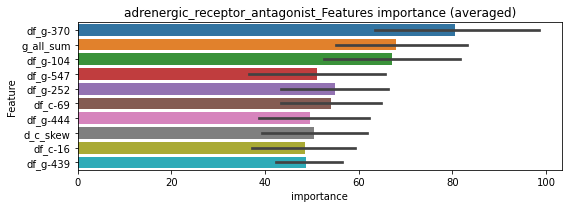

len(train_index) : 3461
len(valid_index) : 3461
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255265	valid_1's binary_logloss: 0.0546865


len(train_index) : 3461
len(valid_index) : 3461
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.012158	valid_1's binary_logloss: 0.0465897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255531	valid_1's binary_logloss: 0.0565094


adrenergic_receptor_antagonist logloss: 0.04787470370771312


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0114552	valid_1's binary_logloss: 0.0491597
neg labels: 3289 → selected neg labels: 3284


akt_inhibitor, len(trt): 66, len(othr): 3284, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101582	valid_1's binary_logloss: 0.187339
[200]	training's binary_logloss: 0.0419521	valid_1's binary_logloss: 0.133512
[300]	training's binary_logloss: 0.01721	valid_1's binary_logloss: 0.106236
[400]	training's binary_logloss: 0.00786696	valid_1's binary_logloss: 0.096672
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00563602	valid_1's binary_logloss: 0.0933682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121501	valid_1's binary_logloss: 0.189935
[200]	training's binary_logloss: 0.0475848	valid_1's binary_logloss: 0.124746
[300]	training's binary_logloss: 0.0196734	valid_1's binary_logloss: 0.0993455
[400]	training's binary_logloss: 0.00884561	valid_1's binary_logloss: 0.0849256


1 / 3 AUC score:0.989
y_Threshold: 0.0618063, Threshold: 0.2846249, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00605104	valid_1's binary_logloss: 0.0811077


Remove_noisy_labels: 200 → Positive_corect_labels: 622/3740
p_label_rate: 0.0100452 Vs.target_rate: 0.00277, Num_p_label: 40.0, conf_0:0.25616, conf_1:0.31309
Num_p_label: 40.0, Expected: 11.0, Adj_threshold_1: 0.2846249
Num_p_label: 35.0, Expected: 11.0, Adj_threshold_2: 0.3146249
Num_p_label: 32.0, Expected: 11.0, Adj_threshold_3: 0.3446249
Num_p_label: 30.0, Expected: 11.0, Adj_threshold_4: 0.3746249
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_5: 0.4046249
Num_p_label: 21.0, Expected: 11.0, Adj_threshold_6: 0.4346249
threshold: 0.4346249, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 622.0/3740, y_label_rate: 0.1663102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995308	valid_1's binary_logloss: 0.155659
[200]	training's binary_logloss: 0.0362785	valid_1's binary_logloss: 0.0919997
[300]	training's binary_logloss: 0.0137057	valid_1's binary_logloss: 0.0659007
[400]	training's binary_logloss: 0.00631978	valid_1's binary_logloss: 0.0553806
[500]	training's binary_logloss: 0.00361272	valid_1's binary_logloss: 0.0496753
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00259394	valid_1's binary_logloss: 0.0466134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903874	valid_1's binary_logloss: 0.174556
[200]	training's binary_logloss: 0.0305841	valid_1's binary_logloss: 0.106403
[300]	training's binary_logloss: 0.0119245	valid_1's binary_logloss: 0.0792706
[400]	training's binary_logloss: 0.00551161	valid_1's binary_logloss: 0.0680468
Early stopping, best iteration is:
[485]	training's 

2 / 3 AUC score:0.997
y_Threshold: 0.1138088, Threshold: 0.4346249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 602.0/3700
p_label_rate: 0.0123054 Vs.target_rate: 0.00277, Num_p_label: 49.0, conf_0:0.39116, conf_1:0.47809
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_1: 0.4346249
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_2: 0.4646249
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_3: 0.4946249
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_4: 0.5246249
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_5: 0.5546249
Num_p_label: 37.0, Expected: 11.0, Adj_threshold_6: 0.5846249
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_7: 0.6146249
Num_p_label: 28.0, Expected: 11.0, Adj_threshold_8: 0.6446249
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_9: 0.6746249
Num_p_label: 25.0, Expected: 11.0, Adj_threshold_10: 0.7046249
threshold: 0.7346249, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 602.0/3700, y_label_rate: 0.16270

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867934	valid_1's binary_logloss: 0.152613
[200]	training's binary_logloss: 0.0288024	valid_1's binary_logloss: 0.0958441
[300]	training's binary_logloss: 0.0107385	valid_1's binary_logloss: 0.0718518
[400]	training's binary_logloss: 0.00497048	valid_1's binary_logloss: 0.06099
[500]	training's binary_logloss: 0.00292088	valid_1's binary_logloss: 0.0570307
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00298366	valid_1's binary_logloss: 0.0568466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911215	valid_1's binary_logloss: 0.153979
[200]	training's binary_logloss: 0.0314265	valid_1's binary_logloss: 0.091234
[300]	training's binary_logloss: 0.0114385	valid_1's binary_logloss: 0.065032
[400]	training's binary_logloss: 0.00515955	valid_1's binary_logloss: 0.0516527
[500]	training's binary_logloss: 0.00308926	valid_1's b

3 / 3 AUC score:0.996
y_Threshold: 0.1119995, Threshold: 0.7346249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 584.0/3664
p_label_rate: 0.0047715 Vs.target_rate: 0.00277, Num_p_label: 19.0, conf_0:0.66116, conf_1:0.80809
threshold: 0.7346249, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 603.0/7646, y_label_rate: 0.0788648


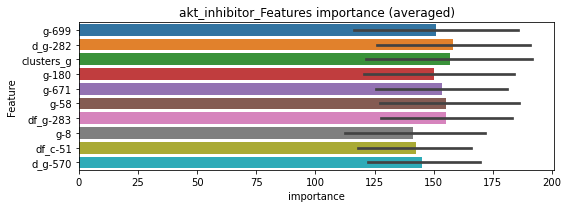

len(train_index) : 3823
len(valid_index) : 3823
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477425	valid_1's binary_logloss: 0.0933308
[200]	training's binary_logloss: 0.01407	valid_1's binary_logloss: 0.059821
[300]	training's binary_logloss: 0.00531386	valid_1's binary_logloss: 0.0498208
[400]	training's binary_logloss: 0.00247812	valid_1's binary_logloss: 0.0465181
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00199421	valid_1's binary_logloss: 0.0459196


len(train_index) : 3823
len(valid_index) : 3823
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475211	valid_1's binary_logloss: 0.0879382
[200]	training's binary_logloss: 0.0151638	valid_1's binary_logloss: 0.0560417
[300]	training's binary_logloss: 0.00582903	valid_1's binary_logloss: 0.0460043
[400]	training's binary_logloss: 0.00269472	valid_1's binary_logloss: 0.0414619
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00191532	valid_1's binary_logloss: 0.0402467


akt_inhibitor logloss: 0.04308313875322362


neg labels: 3289 → selected neg labels: 3288


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3288, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659584	valid_1's binary_logloss: 0.0900407
[200]	training's binary_logloss: 0.0160592	valid_1's binary_logloss: 0.0354208
[300]	training's binary_logloss: 0.00478809	valid_1's binary_logloss: 0.0186207
[400]	training's binary_logloss: 0.00216923	valid_1's binary_logloss: 0.0130366
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00177691	valid_1's binary_logloss: 0.0119851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064526	valid_1's binary_logloss: 0.0894306
[200]	training's binary_logloss: 0.0178442	valid_1's binary_logloss: 0.0381196
[300]	training's binary_logloss: 0.00511789	valid_1's binary_logloss: 0.0196935
[400]	training's binary_logloss: 0.00226689	valid_1's binary_logloss: 0.0139034
[500]	training's binary_logloss: 0.00144753	valid_1's binary_logloss: 0.0119804
[600]	training's binary_logloss: 0.00115064	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0218840, Threshold: 0.0937397, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.08437, conf_1:0.10311
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0937397
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_2: 0.1237397
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_3: 0.1537397
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_4: 0.1837397
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.2137397
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.2437397
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.2737397
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_8: 0.3037397
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.3337397
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.3637397
threshold: 0.3937397, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557307	valid_1's binary_logloss: 0.0816033
[200]	training's binary_logloss: 0.012301	valid_1's binary_logloss: 0.0287986
[300]	training's binary_logloss: 0.0038211	valid_1's binary_logloss: 0.0148028
[400]	training's binary_logloss: 0.00190617	valid_1's binary_logloss: 0.0100784
[500]	training's binary_logloss: 0.00131258	valid_1's binary_logloss: 0.00817623
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00117939	valid_1's binary_logloss: 0.00778159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600724	valid_1's binary_logloss: 0.0777555
[200]	training's binary_logloss: 0.0128193	valid_1's binary_logloss: 0.0241152
[300]	training's binary_logloss: 0.0039161	valid_1's binary_logloss: 0.0109484
[400]	training's binary_logloss: 0.0019154	valid_1's binary_logloss: 0.00752169
[500]	training's binary_logloss: 0.00131264	vali

2 / 3 AUC score:1.000
y_Threshold: 0.2538486, Threshold: 0.3937397, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0040181 Vs.target_rate: 0.00080, Num_p_label: 16.0, conf_0:0.35437, conf_1:0.43311
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_1: 0.3937397
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.4237397
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.4537397
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.4837397
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.5137397
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.5437397
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_7: 0.5737397
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.6037397
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.6337397
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.6637397
threshold: 0.6637397, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557307	valid_1's binary_logloss: 0.0816033
[200]	training's binary_logloss: 0.012301	valid_1's binary_logloss: 0.0287986
[300]	training's binary_logloss: 0.0038211	valid_1's binary_logloss: 0.0148028
[400]	training's binary_logloss: 0.00190617	valid_1's binary_logloss: 0.0100784
[500]	training's binary_logloss: 0.00131258	valid_1's binary_logloss: 0.00817623
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00117939	valid_1's binary_logloss: 0.00778159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600724	valid_1's binary_logloss: 0.0777555
[200]	training's binary_logloss: 0.0128193	valid_1's binary_logloss: 0.0241152
[300]	training's binary_logloss: 0.0039161	valid_1's binary_logloss: 0.0109484
[400]	training's binary_logloss: 0.0019154	valid_1's binary_logloss: 0.00752169
[500]	training's binary_logloss: 0.00131264	vali

3 / 3 AUC score:1.000
y_Threshold: 0.2538486, Threshold: 0.6637397, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00117432	valid_1's binary_logloss: 0.00608106


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.59737, conf_1:0.73011
threshold: 0.6637397, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


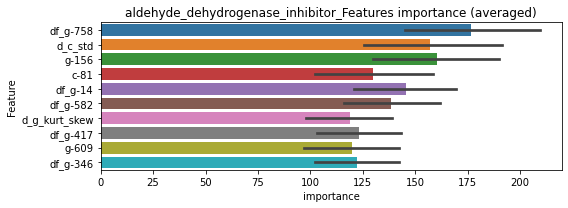

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365322	valid_1's binary_logloss: 0.0546651
[200]	training's binary_logloss: 0.00803549	valid_1's binary_logloss: 0.0202619
[300]	training's binary_logloss: 0.00230891	valid_1's binary_logloss: 0.0106587
[400]	training's binary_logloss: 0.00108365	valid_1's binary_logloss: 0.00767216
[500]	training's binary_logloss: 0.000722575	valid_1's binary_logloss: 0.00674618
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000622284	valid_1's binary_logloss: 0.00649433


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345792	valid_1's binary_logloss: 0.0534051
[200]	training's binary_logloss: 0.00809233	valid_1's binary_logloss: 0.0226858
[300]	training's binary_logloss: 0.00238932	valid_1's binary_logloss: 0.0127466
[400]	training's binary_logloss: 0.00109968	valid_1's binary_logloss: 0.00990706
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000825551	valid_1's binary_logloss: 0.00919248


aldehyde_dehydrogenase_inhibitor logloss: 0.007843229227163845


neg labels: 3289 → selected neg labels: 3285


alk_inhibitor, len(trt): 42, len(othr): 3285, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.175403
[200]	training's binary_logloss: 0.0405047	valid_1's binary_logloss: 0.103893
[300]	training's binary_logloss: 0.0153537	valid_1's binary_logloss: 0.0746599
[400]	training's binary_logloss: 0.00665544	valid_1's binary_logloss: 0.060962
[500]	training's binary_logloss: 0.0036763	valid_1's binary_logloss: 0.0552903
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.003759	valid_1's binary_logloss: 0.0552159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12497	valid_1's binary_logloss: 0.179276
[200]	training's binary_logloss: 0.0456314	valid_1's binary_logloss: 0.107321
[300]	training's binary_logloss: 0.0163693	valid_1's binary_logloss: 0.0734006
[400]	training's binary_logloss: 0.00662318	valid_1's binary_logloss: 0.0603842
[500]	training's binary_logloss: 0.00345537	valid_1's binary_

1 / 3 AUC score:0.994
y_Threshold: 0.0554255, Threshold: 0.2109870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 640/3776
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.18989, conf_1:0.23209
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.2109870
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_2: 0.2409870
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_3: 0.2709870
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_4: 0.3009870
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_5: 0.3309870
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_6: 0.3609870
threshold: 0.3609870, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104686	valid_1's binary_logloss: 0.158931
[200]	training's binary_logloss: 0.0336517	valid_1's binary_logloss: 0.0854018
[300]	training's binary_logloss: 0.0122625	valid_1's binary_logloss: 0.0562201
[400]	training's binary_logloss: 0.00530157	valid_1's binary_logloss: 0.043999
[500]	training's binary_logloss: 0.00292657	valid_1's binary_logloss: 0.0378092
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0020927	valid_1's binary_logloss: 0.0356753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104445	valid_1's binary_logloss: 0.156094
[200]	training's binary_logloss: 0.0337808	valid_1's binary_logloss: 0.0844432
[300]	training's binary_logloss: 0.0115602	valid_1's binary_logloss: 0.0562505
[400]	training's binary_logloss: 0.00508969	valid_1's binary_logloss: 0.0446542
[500]	training's binary_logloss: 0.00288184	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.1523297, Threshold: 0.3609870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 622.0/3740
p_label_rate: 0.0110497 Vs.target_rate: 0.00176, Num_p_label: 44.0, conf_0:0.32489, conf_1:0.39709
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_1: 0.3609870
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.3909870
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_3: 0.4209870
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_4: 0.4509870
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_5: 0.4809870
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_6: 0.5109870
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_7: 0.5409870
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_8: 0.5709870
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_9: 0.6009870
threshold: 0.6009870, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 622.0/3740, y_label_rate: 0.1663102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980282	valid_1's binary_logloss: 0.160692
[200]	training's binary_logloss: 0.0307401	valid_1's binary_logloss: 0.0967481
[300]	training's binary_logloss: 0.0101038	valid_1's binary_logloss: 0.0784294
[400]	training's binary_logloss: 0.00438246	valid_1's binary_logloss: 0.0724648
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00452632	valid_1's binary_logloss: 0.0723075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958579	valid_1's binary_logloss: 0.149245
[200]	training's binary_logloss: 0.0301824	valid_1's binary_logloss: 0.0830033
[300]	training's binary_logloss: 0.0102129	valid_1's binary_logloss: 0.0568427
[400]	training's binary_logloss: 0.00442137	valid_1's binary_logloss: 0.0470264
[500]	training's binary_logloss: 0.00255256	valid_1's binary_logloss: 0.0425106
Early stopping, best iteration is:
[569]	training's

3 / 3 AUC score:0.989
y_Threshold: 0.1338718, Threshold: 0.6009870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 597.0/3690
p_label_rate: 0.0027624 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.54089, conf_1:0.66109
threshold: 0.6009870, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 608.0/7672, y_label_rate: 0.0792492


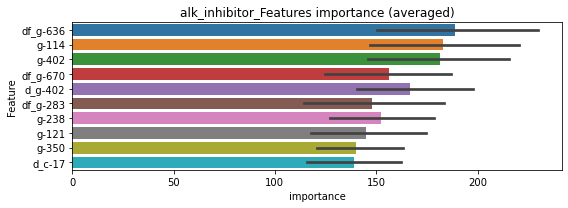

len(train_index) : 3836
len(valid_index) : 3836
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556631	valid_1's binary_logloss: 0.08864
[200]	training's binary_logloss: 0.0165108	valid_1's binary_logloss: 0.0476649
[300]	training's binary_logloss: 0.0053511	valid_1's binary_logloss: 0.0323649
[400]	training's binary_logloss: 0.00224581	valid_1's binary_logloss: 0.0262515
[500]	training's binary_logloss: 0.00128441	valid_1's binary_logloss: 0.0239348
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00115057	valid_1's binary_logloss: 0.0234149


len(train_index) : 3836
len(valid_index) : 3836
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572653	valid_1's binary_logloss: 0.0844381
[200]	training's binary_logloss: 0.0181035	valid_1's binary_logloss: 0.0432883
[300]	training's binary_logloss: 0.00575017	valid_1's binary_logloss: 0.026497
[400]	training's binary_logloss: 0.00240686	valid_1's binary_logloss: 0.0206091
[500]	training's binary_logloss: 0.00135172	valid_1's binary_logloss: 0.0183347
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00110041	valid_1's binary_logloss: 0.017445


alk_inhibitor logloss: 0.02042997785896972


neg labels: 3289 → selected neg labels: 3289


ampk_activator, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444636	valid_1's binary_logloss: 0.0603939
[200]	training's binary_logloss: 0.00805563	valid_1's binary_logloss: 0.0191156
[300]	training's binary_logloss: 0.00233301	valid_1's binary_logloss: 0.00943624
[400]	training's binary_logloss: 0.00123179	valid_1's binary_logloss: 0.00677208
[500]	training's binary_logloss: 0.000907377	valid_1's binary_logloss: 0.0059623
[600]	training's binary_logloss: 0.000762841	valid_1's binary_logloss: 0.00555896
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.0007457	valid_1's binary_logloss: 0.00544684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424023	valid_1's binary_logloss: 0.054711
[200]	training's binary_logloss: 0.0075684	valid_1's binary_logloss: 0.0160592
[300]	training's binary_logloss: 0.0023438	valid_1's binary_logloss: 0.00784215
[400]	training's binary_logloss: 0.0012457

1 / 3 AUC score:1.000
y_Threshold: 0.0099310, Threshold: 0.1125409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.10129, conf_1:0.12380
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.1125409
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_2: 0.1425409
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_3: 0.1725409
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_4: 0.2025409
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_5: 0.2325409
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_6: 0.2625409
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.2925409
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_8: 0.3225409
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_9: 0.3525409
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.3825409
threshold: 0.4125409, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361399	valid_1's binary_logloss: 0.0523142
[200]	training's binary_logloss: 0.00596991	valid_1's binary_logloss: 0.0149075
[300]	training's binary_logloss: 0.00183574	valid_1's binary_logloss: 0.0067896
[400]	training's binary_logloss: 0.00102858	valid_1's binary_logloss: 0.00474364
[500]	training's binary_logloss: 0.00077394	valid_1's binary_logloss: 0.00404944
[600]	training's binary_logloss: 0.000657636	valid_1's binary_logloss: 0.00367376
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.000642326	valid_1's binary_logloss: 0.00363285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381867	valid_1's binary_logloss: 0.0481307
[200]	training's binary_logloss: 0.00612822	valid_1's binary_logloss: 0.0104996
[300]	training's binary_logloss: 0.00187615	valid_1's binary_logloss: 0.00450681
[400]	training's binary_logloss: 0.001

2 / 3 AUC score:1.000
y_Threshold: 0.3391754, Threshold: 0.4125409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0095429 Vs.target_rate: 0.00050, Num_p_label: 38.0, conf_0:0.37129, conf_1:0.45380
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_1: 0.4125409
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_2: 0.4425409
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_3: 0.4725409
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_4: 0.5025409
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_5: 0.5325409
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_6: 0.5625409
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_7: 0.5925409
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_8: 0.6225409
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_9: 0.6525409
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.6825409
threshold: 0.7125409, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361399	valid_1's binary_logloss: 0.0523142
[200]	training's binary_logloss: 0.00596991	valid_1's binary_logloss: 0.0149075
[300]	training's binary_logloss: 0.00183574	valid_1's binary_logloss: 0.0067896
[400]	training's binary_logloss: 0.00102858	valid_1's binary_logloss: 0.00474364
[500]	training's binary_logloss: 0.00077394	valid_1's binary_logloss: 0.00404944
[600]	training's binary_logloss: 0.000657636	valid_1's binary_logloss: 0.00367376
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.000642326	valid_1's binary_logloss: 0.00363285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381867	valid_1's binary_logloss: 0.0481307
[200]	training's binary_logloss: 0.00612822	valid_1's binary_logloss: 0.0104996
[300]	training's binary_logloss: 0.00187615	valid_1's binary_logloss: 0.00450681
[400]	training's binary_logloss: 0.001

3 / 3 AUC score:1.000
y_Threshold: 0.3391754, Threshold: 0.7125409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.64129, conf_1:0.78380
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.7125409
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.7425409
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.7725409
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.8025409
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.8325409
threshold: 0.8325409, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7795, y_label_rate: 0.0847979


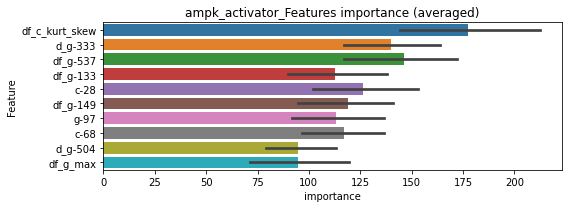

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231368	valid_1's binary_logloss: 0.0342914
[200]	training's binary_logloss: 0.00379086	valid_1's binary_logloss: 0.0104083
[300]	training's binary_logloss: 0.00114009	valid_1's binary_logloss: 0.00589961


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000672079	valid_1's binary_logloss: 0.00499626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220402	valid_1's binary_logloss: 0.0310204
[200]	training's binary_logloss: 0.00381974	valid_1's binary_logloss: 0.010336
[300]	training's binary_logloss: 0.00114103	valid_1's binary_logloss: 0.00665078
[400]	training's binary_logloss: 0.000625056	valid_1's binary_logloss: 0.00574906
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000523389	valid_1's binary_logloss: 0.00550625


ampk_activator logloss: 0.005251221724666409


neg labels: 3289 → selected neg labels: 3288


analgesic, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343342	valid_1's binary_logloss: 0.0525905
[200]	training's binary_logloss: 0.00616275	valid_1's binary_logloss: 0.0164728
[300]	training's binary_logloss: 0.00200805	valid_1's binary_logloss: 0.00899866
[400]	training's binary_logloss: 0.00108738	valid_1's binary_logloss: 0.00689873
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00085554	valid_1's binary_logloss: 0.00620507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361447	valid_1's binary_logloss: 0.0505803
[200]	training's binary_logloss: 0.0065717	valid_1's binary_logloss: 0.0150184
[300]	training's binary_logloss: 0.0020686	valid_1's binary_logloss: 0.00758967
[400]	training's binary_logloss: 0.00112748	valid_1's binary_logloss: 0.00565753


1 / 3 AUC score:1.000
y_Threshold: 0.0094295, Threshold: 0.0962688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.08664, conf_1:0.10590
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0962688
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_2: 0.1262688
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_3: 0.1562688
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_4: 0.1862688
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_5: 0.2162688
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_6: 0.2462688
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_7: 0.2762688
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_8: 0.3062688


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000977389	valid_1's binary_logloss: 0.00542723


Num_p_label: 16.0, Expected: 2.0, Adj_threshold_9: 0.3362688
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.3662688
threshold: 0.3962688, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326356	valid_1's binary_logloss: 0.0494987
[200]	training's binary_logloss: 0.00531042	valid_1's binary_logloss: 0.0139509
[300]	training's binary_logloss: 0.00172483	valid_1's binary_logloss: 0.00751734
[400]	training's binary_logloss: 0.000968228	valid_1's binary_logloss: 0.00574039
[500]	training's binary_logloss: 0.000716286	valid_1's binary_logloss: 0.00511385
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000636616	valid_1's binary_logloss: 0.00488759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331697	valid_1's binary_logloss: 0.0465109
[200]	training's binary_logloss: 0.00554308	valid_1's binary_logloss: 0.0124612
[300]	training's binary_logloss: 0.00175372	valid_1's binary_logloss: 0.00611187
[400]	training's binary_logloss: 0.000984263	valid_1's binary_logloss: 0.00433148


2 / 3 AUC score:1.000
y_Threshold: 0.1725581, Threshold: 0.3962688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00050, Num_p_label: 28.0, conf_0:0.35664, conf_1:0.43590
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_1: 0.3962688
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_2: 0.4262688
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_3: 0.4562688
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_4: 0.4862688
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_5: 0.5162688
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_6: 0.5462688
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.5762688
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.6062688
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_9: 0.6362688
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.6662688


Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000984263	valid_1's binary_logloss: 0.00433148


threshold: 0.6962688, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330711	valid_1's binary_logloss: 0.048246
[200]	training's binary_logloss: 0.00564277	valid_1's binary_logloss: 0.0127254
[300]	training's binary_logloss: 0.00183564	valid_1's binary_logloss: 0.00587272
[400]	training's binary_logloss: 0.00101492	valid_1's binary_logloss: 0.0038874
[500]	training's binary_logloss: 0.000743447	valid_1's binary_logloss: 0.00322607
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000673204	valid_1's binary_logloss: 0.0030535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334255	valid_1's binary_logloss: 0.0442435
[200]	training's binary_logloss: 0.00547549	valid_1's binary_logloss: 0.0101453
[300]	training's binary_logloss: 0.00174444	valid_1's binary_logloss: 0.00433903
[400]	training's binary_logloss: 0.000971367	valid_1's binary_logloss: 0.00294956
[500]	training's binary_logloss: 0.0007

3 / 3 AUC score:1.000
y_Threshold: 0.1754118, Threshold: 0.6962688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.62664, conf_1:0.76590
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.6962688
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.7262688
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.7562688
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.7862688
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.8162688
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.8462688
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.8762688
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.9062688
threshold: 0.9062688, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7793, y_label_rate: 0.0845631


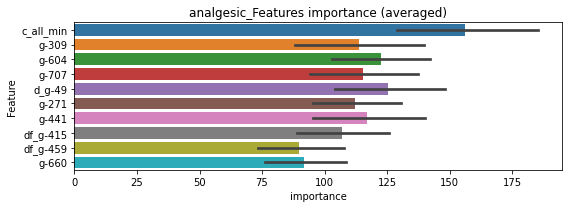

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190209	valid_1's binary_logloss: 0.0291746
[200]	training's binary_logloss: 0.00314241	valid_1's binary_logloss: 0.0123664


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00150063	valid_1's binary_logloss: 0.0103688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172473	valid_1's binary_logloss: 0.026576
[200]	training's binary_logloss: 0.00319849	valid_1's binary_logloss: 0.008433
[300]	training's binary_logloss: 0.00104185	valid_1's binary_logloss: 0.00414961
[400]	training's binary_logloss: 0.000585306	valid_1's binary_logloss: 0.00319585
[500]	training's binary_logloss: 0.000444134	valid_1's binary_logloss: 0.00285029


analgesic logloss: 0.006549774784410651


Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000395716	valid_1's binary_logloss: 0.0027298
neg labels: 3289 → selected neg labels: 3282


androgen_receptor_agonist, len(trt): 48, len(othr): 3282, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805648	valid_1's binary_logloss: 0.156171
[200]	training's binary_logloss: 0.0254283	valid_1's binary_logloss: 0.103492
[300]	training's binary_logloss: 0.00940752	valid_1's binary_logloss: 0.0842613
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00461136	valid_1's binary_logloss: 0.0772436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902683	valid_1's binary_logloss: 0.133205
[200]	training's binary_logloss: 0.0302079	valid_1's binary_logloss: 0.0675688
[300]	training's binary_logloss: 0.0112152	valid_1's binary_logloss: 0.0419748
[400]	training's binary_logloss: 0.00493526	valid_1's binary_logloss: 0.0308985
[500]	training's binary_logloss: 0.00283049	valid_1's binary_logloss: 0.0265641
[600]	training's binary_logloss: 0.00199327	valid_1's binary_logloss: 0.0244277
Early stopping, best iteration is:
[638]	training's

1 / 3 AUC score:0.995
y_Threshold: 0.0308262, Threshold: 0.1149690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 646/3786
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.10347, conf_1:0.12647
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1149690
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.1449690
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.1749690
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_4: 0.2049690
threshold: 0.2049690, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 646.0/3786, y_label_rate: 0.1706286
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840184	valid_1's binary_logloss: 0.134237
[200]	training's binary_logloss: 0.0242676	valid_1's binary_logloss: 0.0690025
[300]	training's binary_logloss: 0.00839926	valid_1's binary_logloss: 0.0476374
[400]	training's binary_logloss: 0.00386894	valid_1's binary_logloss: 0.0400464
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0025038	valid_1's binary_logloss: 0.0375237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076862	valid_1's binary_logloss: 0.137459
[200]	training's binary_logloss: 0.0243926	valid_1's binary_logloss: 0.0793267
[300]	training's binary_logloss: 0.0084855	valid_1's binary_logloss: 0.0586847
[400]	training's binary_logloss: 0.00394976	valid_1's binary_logloss: 0.0525385
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00280186	valid_1's binary_logloss: 0.0503412


2 / 3 AUC score:0.998
y_Threshold: 0.0802222, Threshold: 0.2049690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 626.0/3746
p_label_rate: 0.0072828 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.18447, conf_1:0.22547
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.2049690
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.2349690
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.2649690
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.2949690
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.3249690
threshold: 0.3249690, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 626.0/3746, y_label_rate: 0.1671116
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761857	valid_1's binary_logloss: 0.125283
[200]	training's binary_logloss: 0.0228821	valid_1's binary_logloss: 0.0661905
[300]	training's binary_logloss: 0.00803597	valid_1's binary_logloss: 0.0454309
[400]	training's binary_logloss: 0.00362384	valid_1's binary_logloss: 0.0368629
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00359265	valid_1's binary_logloss: 0.0368561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740302	valid_1's binary_logloss: 0.124693
[200]	training's binary_logloss: 0.0206843	valid_1's binary_logloss: 0.0637105
[300]	training's binary_logloss: 0.0075036	valid_1's binary_logloss: 0.0461873
[400]	training's binary_logloss: 0.00350563	valid_1's binary_logloss: 0.0394981
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00261135	valid_1's binary_logloss: 0.0382692


3 / 3 AUC score:0.997
y_Threshold: 0.0801231, Threshold: 0.3249690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 613.0/3720
p_label_rate: 0.0047715 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.29247, conf_1:0.35747
threshold: 0.3249690, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 632.0/7702, y_label_rate: 0.0820566


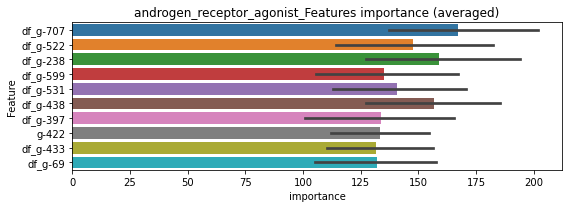

len(train_index) : 3851
len(valid_index) : 3851
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408411	valid_1's binary_logloss: 0.0754308
[200]	training's binary_logloss: 0.0129261	valid_1's binary_logloss: 0.0427824
[300]	training's binary_logloss: 0.00417993	valid_1's binary_logloss: 0.0299402
[400]	training's binary_logloss: 0.00187754	valid_1's binary_logloss: 0.0262815
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00159046	valid_1's binary_logloss: 0.0256699


len(train_index) : 3851
len(valid_index) : 3851
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047656	valid_1's binary_logloss: 0.0739473
[200]	training's binary_logloss: 0.0131682	valid_1's binary_logloss: 0.0361599
[300]	training's binary_logloss: 0.0046506	valid_1's binary_logloss: 0.024091
[400]	training's binary_logloss: 0.00202767	valid_1's binary_logloss: 0.0190092
[500]	training's binary_logloss: 0.00122234	valid_1's binary_logloss: 0.0173216
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00110965	valid_1's binary_logloss: 0.0171379


androgen_receptor_agonist logloss: 0.021403903512271956


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117548	valid_1's binary_logloss: 0.190464
[200]	training's binary_logloss: 0.0491823	valid_1's binary_logloss: 0.140901
[300]	training's binary_logloss: 0.0209551	valid_1's binary_logloss: 0.117409
[400]	training's binary_logloss: 0.0100353	valid_1's binary_logloss: 0.107385
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00798771	valid_1's binary_logloss: 0.105691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122265	valid_1's binary_logloss: 0.185192
[200]	training's binary_logloss: 0.0468825	valid_1's binary_logloss: 0.124286
[300]	training's binary_logloss: 0.0203836	valid_1's binary_logloss: 0.103212
[400]	training's binary_logloss: 0.00934717	valid_1's binary_logloss: 0.0930819
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00895053	valid_1's binary_logloss: 0.0927055


1 / 3 AUC score:0.984
y_Threshold: 0.0629797, Threshold: 0.2165516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 214 → Positive_corect_labels: 613/3714
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.19490, conf_1:0.23821
threshold: 0.2165516, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 613.0/3714, y_label_rate: 0.1650512
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964359	valid_1's binary_logloss: 0.165628
[200]	training's binary_logloss: 0.0335474	valid_1's binary_logloss: 0.110025
[300]	training's binary_logloss: 0.0136934	valid_1's binary_logloss: 0.0892519
[400]	training's binary_logloss: 0.00621671	valid_1's binary_logloss: 0.0800532
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00441865	valid_1's binary_logloss: 0.0762652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100907	valid_1's binary_logloss: 0.159629
[200]	training's binary_logloss: 0.0351341	valid_1's binary_logloss: 0.104285
[300]	training's binary_logloss: 0.0136535	valid_1's binary_logloss: 0.0810001
[400]	training's binary_logloss: 0.00658197	valid_1's binary_logloss: 0.070817
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00465964	valid_1's binary_logloss: 0.0678309


2 / 3 AUC score:0.994
y_Threshold: 0.1057205, Threshold: 0.2165516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 574.0/3636
p_label_rate: 0.0183325 Vs.target_rate: 0.00374, Num_p_label: 73.0, conf_0:0.19490, conf_1:0.23821
Num_p_label: 73.0, Expected: 14.9, Adj_threshold_1: 0.2165516
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_2: 0.2465516
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_3: 0.2765516
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_4: 0.3065516
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_5: 0.3365516
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_6: 0.3665516
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_7: 0.3965516
threshold: 0.3965516, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 574.0/3636, y_label_rate: 0.1578658
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830739	valid_1's binary_logloss: 0.138286
[200]	training's binary_logloss: 0.0265049	valid_1's binary_logloss: 0.0845062
[300]	training's binary_logloss: 0.0100488	valid_1's binary_logloss: 0.0645735
[400]	training's binary_logloss: 0.00479763	valid_1's binary_logloss: 0.0564304
[500]	training's binary_logloss: 0.00280345	valid_1's binary_logloss: 0.0510691
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00240498	valid_1's binary_logloss: 0.0503514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876626	valid_1's binary_logloss: 0.145413
[200]	training's binary_logloss: 0.0286004	valid_1's binary_logloss: 0.0932023
[300]	training's binary_logloss: 0.0107089	valid_1's binary_logloss: 0.075645
[400]	training's binary_logloss: 0.00501251	valid_1's binary_logloss: 0.0686121
Early stopping, best iteration is:
[425]	training's 

3 / 3 AUC score:0.994
y_Threshold: 0.1051830, Threshold: 0.3965516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 548.0/3584
p_label_rate: 0.0118031 Vs.target_rate: 0.00374, Num_p_label: 47.0, conf_0:0.35690, conf_1:0.43621
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_1: 0.3965516
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_2: 0.4265516
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_3: 0.4565516
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_4: 0.4865516
threshold: 0.4865516, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 574.0/7566, y_label_rate: 0.0758657


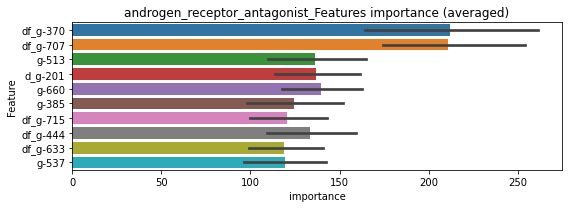

len(train_index) : 3783
len(valid_index) : 3783
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501815	valid_1's binary_logloss: 0.0893697
[200]	training's binary_logloss: 0.0169186	valid_1's binary_logloss: 0.0629007
[300]	training's binary_logloss: 0.00628733	valid_1's binary_logloss: 0.0542486


len(train_index) : 3783
len(valid_index) : 3783
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00375821	valid_1's binary_logloss: 0.0521889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050069	valid_1's binary_logloss: 0.08301
[200]	training's binary_logloss: 0.0159151	valid_1's binary_logloss: 0.0552004
[300]	training's binary_logloss: 0.00581506	valid_1's binary_logloss: 0.0466836


androgen_receptor_antagonist logloss: 0.04805517519208135


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00325792	valid_1's binary_logloss: 0.0439215
neg labels: 3289 → selected neg labels: 3273


anesthetic_-_local, len(trt): 80, len(othr): 3273, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124783	valid_1's binary_logloss: 0.198712
[200]	training's binary_logloss: 0.0477545	valid_1's binary_logloss: 0.144699
[300]	training's binary_logloss: 0.0200913	valid_1's binary_logloss: 0.125478
[400]	training's binary_logloss: 0.00907806	valid_1's binary_logloss: 0.116628
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0059686	valid_1's binary_logloss: 0.113422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128949	valid_1's binary_logloss: 0.193005
[200]	training's binary_logloss: 0.0514127	valid_1's binary_logloss: 0.1303
[300]	training's binary_logloss: 0.022191	valid_1's binary_logloss: 0.106213
[400]	training's binary_logloss: 0.0102139	valid_1's binary_logloss: 0.09547
[500]	training's binary_logloss: 0.00545639	valid_1's binary_logloss: 0.087102
Early stopping, best iteration is:
[518]	training's binary_logloss:

1 / 3 AUC score:0.985
y_Threshold: 0.0581380, Threshold: 0.1960288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 210 → Positive_corect_labels: 615/3717
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.17643, conf_1:0.21563
threshold: 0.1960288, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 615.0/3717, y_label_rate: 0.1654560
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100478	valid_1's binary_logloss: 0.182679
[200]	training's binary_logloss: 0.0346244	valid_1's binary_logloss: 0.125358
[300]	training's binary_logloss: 0.0133232	valid_1's binary_logloss: 0.101276
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00682859	valid_1's binary_logloss: 0.0944079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111215	valid_1's binary_logloss: 0.163244
[200]	training's binary_logloss: 0.0420454	valid_1's binary_logloss: 0.100884
[300]	training's binary_logloss: 0.016084	valid_1's binary_logloss: 0.0723142
[400]	training's binary_logloss: 0.00738806	valid_1's binary_logloss: 0.0596156
[500]	training's binary_logloss: 0.00410785	valid_1's binary_logloss: 0.0529821
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00293614	valid_1's binary_logloss: 0.0495753


2 / 3 AUC score:0.992
y_Threshold: 0.1312738, Threshold: 0.1960288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 572.0/3631
p_label_rate: 0.0268709 Vs.target_rate: 0.00336, Num_p_label: 107.0, conf_0:0.17643, conf_1:0.21563
Num_p_label: 107.0, Expected: 13.4, Adj_threshold_1: 0.1960288
Num_p_label: 90.0, Expected: 13.4, Adj_threshold_2: 0.2260288
Num_p_label: 78.0, Expected: 13.4, Adj_threshold_3: 0.2560288
Num_p_label: 72.0, Expected: 13.4, Adj_threshold_4: 0.2860288
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_5: 0.3160288
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_6: 0.3460288
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_7: 0.3760288
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_8: 0.4060288
Num_p_label: 29.0, Expected: 13.4, Adj_threshold_9: 0.4360288
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_10: 0.4660288
threshold: 0.4660288, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 572.0/3631, y_label_rate: 0.157

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974965	valid_1's binary_logloss: 0.138272
[200]	training's binary_logloss: 0.0314093	valid_1's binary_logloss: 0.0769606
[300]	training's binary_logloss: 0.0118747	valid_1's binary_logloss: 0.0530189
[400]	training's binary_logloss: 0.00546106	valid_1's binary_logloss: 0.0420858
[500]	training's binary_logloss: 0.00319767	valid_1's binary_logloss: 0.0363455
[600]	training's binary_logloss: 0.00224481	valid_1's binary_logloss: 0.0339294
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00181885	valid_1's binary_logloss: 0.0323763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889468	valid_1's binary_logloss: 0.1489
[200]	training's binary_logloss: 0.0281135	valid_1's binary_logloss: 0.0870855
[300]	training's binary_logloss: 0.0106131	valid_1's binary_logloss: 0.0631568
[400]	training's binary_logloss: 0.00512083	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.1429849, Threshold: 0.4660288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 560.0/3607
p_label_rate: 0.0075339 Vs.target_rate: 0.00336, Num_p_label: 30.0, conf_0:0.41943, conf_1:0.51263
threshold: 0.4660288, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 590.0/7589, y_label_rate: 0.0777441


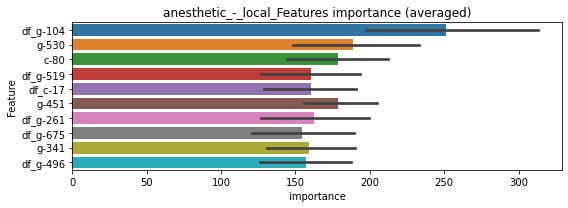

len(train_index) : 3794
len(valid_index) : 3795
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558317	valid_1's binary_logloss: 0.0930688
[200]	training's binary_logloss: 0.0176807	valid_1's binary_logloss: 0.0562919
[300]	training's binary_logloss: 0.00652654	valid_1's binary_logloss: 0.0436912
[400]	training's binary_logloss: 0.00308796	valid_1's binary_logloss: 0.0382342
[500]	training's binary_logloss: 0.00180435	valid_1's binary_logloss: 0.0359331
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00184086	valid_1's binary_logloss: 0.0359136


len(train_index) : 3795
len(valid_index) : 3794
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580692	valid_1's binary_logloss: 0.0894889
[200]	training's binary_logloss: 0.0194387	valid_1's binary_logloss: 0.0544738
[300]	training's binary_logloss: 0.00723594	valid_1's binary_logloss: 0.0412087
[400]	training's binary_logloss: 0.00326734	valid_1's binary_logloss: 0.0349114
[500]	training's binary_logloss: 0.00186341	valid_1's binary_logloss: 0.0322021
[600]	training's binary_logloss: 0.00127896	valid_1's binary_logloss: 0.0303322
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00120497	valid_1's binary_logloss: 0.0300101


anesthetic_-_local logloss: 0.03296220536874136


neg labels: 3289 → selected neg labels: 3282


angiogenesis_inhibitor, len(trt): 36, len(othr): 3282, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690794	valid_1's binary_logloss: 0.103902
[200]	training's binary_logloss: 0.0198912	valid_1's binary_logloss: 0.0498324
[300]	training's binary_logloss: 0.00650537	valid_1's binary_logloss: 0.0301131
[400]	training's binary_logloss: 0.00303982	valid_1's binary_logloss: 0.0234372
[500]	training's binary_logloss: 0.0018877	valid_1's binary_logloss: 0.0206691
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00148804	valid_1's binary_logloss: 0.0195094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695756	valid_1's binary_logloss: 0.1042
[200]	training's binary_logloss: 0.0208178	valid_1's binary_logloss: 0.0502329
[300]	training's binary_logloss: 0.00678598	valid_1's binary_logloss: 0.0288175
[400]	training's binary_logloss: 0.00304116	valid_1's binary_logloss: 0.0209533
[500]	training's binary_logloss: 0.00184182	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0207066, Threshold: 0.1063367, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.09570, conf_1:0.11697
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1063367
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_2: 0.1363367
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.1663367
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.1963367
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.2263367
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.2563367
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.2863367
threshold: 0.2863367, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066135	valid_1's binary_logloss: 0.100749
[200]	training's binary_logloss: 0.0175218	valid_1's binary_logloss: 0.044206
[300]	training's binary_logloss: 0.00582662	valid_1's binary_logloss: 0.0261352
[400]	training's binary_logloss: 0.00270841	valid_1's binary_logloss: 0.0183195
[500]	training's binary_logloss: 0.00171186	valid_1's binary_logloss: 0.0159196
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00147517	valid_1's binary_logloss: 0.0153372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064509	valid_1's binary_logloss: 0.0946439
[200]	training's binary_logloss: 0.0161397	valid_1's binary_logloss: 0.0400576
[300]	training's binary_logloss: 0.00550187	valid_1's binary_logloss: 0.0219155
[400]	training's binary_logloss: 0.00266863	valid_1's binary_logloss: 0.0159076
[500]	training's binary_logloss: 0.00168745	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.1394059, Threshold: 0.2863367, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0087896 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.25770, conf_1:0.31497
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.2863367
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.3163367
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.3463367
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_4: 0.3763367
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_5: 0.4063367
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_6: 0.4363367
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_7: 0.4663367
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_8: 0.4963367
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.5263367
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.5563367
threshold: 0.5863367, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604111	valid_1's binary_logloss: 0.094329
[200]	training's binary_logloss: 0.0165684	valid_1's binary_logloss: 0.0417479
[300]	training's binary_logloss: 0.00547894	valid_1's binary_logloss: 0.022322
[400]	training's binary_logloss: 0.00256289	valid_1's binary_logloss: 0.0158146
[500]	training's binary_logloss: 0.00164921	valid_1's binary_logloss: 0.0133749
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00146519	valid_1's binary_logloss: 0.0125237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594959	valid_1's binary_logloss: 0.103023
[200]	training's binary_logloss: 0.0147911	valid_1's binary_logloss: 0.0492167
[300]	training's binary_logloss: 0.00495581	valid_1's binary_logloss: 0.032954
[400]	training's binary_logloss: 0.00239589	valid_1's binary_logloss: 0.0280698
Early stopping, best iteration is:
[451]	training's

3 / 3 AUC score:1.000
y_Threshold: 0.1258791, Threshold: 0.5863367, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 644.0/3782
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.52770, conf_1:0.64497
threshold: 0.5863367, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/7764, y_label_rate: 0.0846213


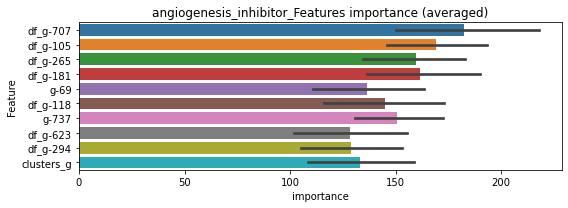

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034223	valid_1's binary_logloss: 0.0595155
[200]	training's binary_logloss: 0.00919817	valid_1's binary_logloss: 0.0294179
[300]	training's binary_logloss: 0.00312844	valid_1's binary_logloss: 0.0180264
[400]	training's binary_logloss: 0.00145479	valid_1's binary_logloss: 0.0141629
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00102622	valid_1's binary_logloss: 0.012812


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390998	valid_1's binary_logloss: 0.0557234
[200]	training's binary_logloss: 0.0105313	valid_1's binary_logloss: 0.0237391
[300]	training's binary_logloss: 0.00335352	valid_1's binary_logloss: 0.0132594
[400]	training's binary_logloss: 0.00149889	valid_1's binary_logloss: 0.0101508
[500]	training's binary_logloss: 0.000933486	valid_1's binary_logloss: 0.00883748
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000895263	valid_1's binary_logloss: 0.00878493


angiogenesis_inhibitor logloss: 0.010798465058316222


neg labels: 3289 → selected neg labels: 3286


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754573	valid_1's binary_logloss: 0.1207
[200]	training's binary_logloss: 0.0224264	valid_1's binary_logloss: 0.0624375
[300]	training's binary_logloss: 0.00760277	valid_1's binary_logloss: 0.0391681
[400]	training's binary_logloss: 0.00358016	valid_1's binary_logloss: 0.0314884
[500]	training's binary_logloss: 0.00216948	valid_1's binary_logloss: 0.0265997
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.001625	valid_1's binary_logloss: 0.0247608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805967	valid_1's binary_logloss: 0.113631
[200]	training's binary_logloss: 0.0242873	valid_1's binary_logloss: 0.0534467
[300]	training's binary_logloss: 0.00814074	valid_1's binary_logloss: 0.0300856
[400]	training's binary_logloss: 0.00363486	valid_1's binary_logloss: 0.0220351
[500]	training's binary_logloss: 0.00215646	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0241257, Threshold: 0.0993423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.08941, conf_1:0.10928
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0993423
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.1293423
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_3: 0.1593423
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.1893423
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_5: 0.2193423
threshold: 0.2193423, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709919	valid_1's binary_logloss: 0.121931
[200]	training's binary_logloss: 0.0179272	valid_1's binary_logloss: 0.0645526
[300]	training's binary_logloss: 0.00599345	valid_1's binary_logloss: 0.0506669
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.004817	valid_1's binary_logloss: 0.0487257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728778	valid_1's binary_logloss: 0.111497
[200]	training's binary_logloss: 0.0193935	valid_1's binary_logloss: 0.0481196
[300]	training's binary_logloss: 0.00667168	valid_1's binary_logloss: 0.0286806
[400]	training's binary_logloss: 0.00305072	valid_1's binary_logloss: 0.0220243


2 / 3 AUC score:0.996
y_Threshold: 0.1287504, Threshold: 0.2193423, pos_neg_ratio: 0.8000000


[500]	training's binary_logloss: 0.00186715	valid_1's binary_logloss: 0.0193525
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00193323	valid_1's binary_logloss: 0.0192903


Remove_noisy_labels: 24 → Positive_corect_labels: 644.0/3785
p_label_rate: 0.0105475 Vs.target_rate: 0.00155, Num_p_label: 42.0, conf_0:0.19741, conf_1:0.24128
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_1: 0.2193423
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_2: 0.2493423
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_3: 0.2793423
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.3093423
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_5: 0.3393423
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.3693423
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.3993423
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_8: 0.4293423
threshold: 0.4293423, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 644.0/3785, y_label_rate: 0.1701453
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687237	valid_1's binary_logloss: 0.105302
[200]	training's binary_logloss: 0.0176492	valid_1's binary_logloss: 0.0409686
[300]	training's binary_logloss: 0.0060579	valid_1's binary_logloss: 0.021179
[400]	training's binary_logloss: 0.00286641	valid_1's binary_logloss: 0.0138862
[500]	training's binary_logloss: 0.00183263	valid_1's binary_logloss: 0.0111017
[600]	training's binary_logloss: 0.0013828	valid_1's binary_logloss: 0.00977476
[700]	training's binary_logloss: 0.00114809	valid_1's binary_logloss: 0.00899112
Early stopping, best iteration is:
[733]	training's binary_logloss: 0.0011001	valid_1's binary_logloss: 0.008847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659296	valid_1's binary_logloss: 0.124078
[200]	training's binary_logloss: 0.0168293	valid_1's binary_logloss: 0.0603684
[300]	training's binary_logloss: 0.00536594	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.1376752, Threshold: 0.4293423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 640.0/3777
p_label_rate: 0.0032647 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.38641, conf_1:0.47228
threshold: 0.4293423, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/7759, y_label_rate: 0.0841603


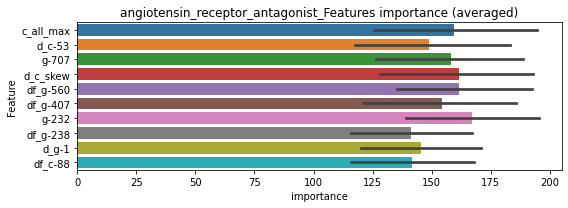

len(train_index) : 3879
len(valid_index) : 3880
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419084	valid_1's binary_logloss: 0.0690804
[200]	training's binary_logloss: 0.01145	valid_1's binary_logloss: 0.033277
[300]	training's binary_logloss: 0.00364317	valid_1's binary_logloss: 0.0202909
[400]	training's binary_logloss: 0.00160562	valid_1's binary_logloss: 0.0154381
[500]	training's binary_logloss: 0.000961114	valid_1's binary_logloss: 0.0134194
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000827659	valid_1's binary_logloss: 0.01302


len(train_index) : 3880
len(valid_index) : 3879
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038937	valid_1's binary_logloss: 0.0650158
[200]	training's binary_logloss: 0.0106785	valid_1's binary_logloss: 0.0323363
[300]	training's binary_logloss: 0.00359674	valid_1's binary_logloss: 0.0205183
[400]	training's binary_logloss: 0.00164469	valid_1's binary_logloss: 0.0158511
[500]	training's binary_logloss: 0.00100807	valid_1's binary_logloss: 0.0140624
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00100807	valid_1's binary_logloss: 0.0140624


angiotensin_receptor_antagonist logloss: 0.013541109095462488


neg labels: 3289 → selected neg labels: 3278


anti-inflammatory, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134015	valid_1's binary_logloss: 0.202963
[200]	training's binary_logloss: 0.0530603	valid_1's binary_logloss: 0.136002
[300]	training's binary_logloss: 0.0235434	valid_1's binary_logloss: 0.106313
[400]	training's binary_logloss: 0.010119	valid_1's binary_logloss: 0.0893884
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00618169	valid_1's binary_logloss: 0.0837849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128851	valid_1's binary_logloss: 0.185874
[200]	training's binary_logloss: 0.050386	valid_1's binary_logloss: 0.1192
[300]	training's binary_logloss: 0.0200191	valid_1's binary_logloss: 0.0897779
[400]	training's binary_logloss: 0.00908389	valid_1's binary_logloss: 0.0769064
[500]	training's binary_logloss: 0.00487576	valid_1's binary_logloss: 0.0711096
Early stopping, best iteration is:
[579]	training's binary_lo

1 / 3 AUC score:0.992
y_Threshold: 0.0516266, Threshold: 0.4200993, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 631/3753
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.37809, conf_1:0.46211
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.4200993
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.4500993
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.4800993
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_4: 0.5100993
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_5: 0.5400993
threshold: 0.5400993, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 631.0/3753, y_label_rate: 0.1681322
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126639	valid_1's binary_logloss: 0.190204
[200]	training's binary_logloss: 0.0463738	valid_1's binary_logloss: 0.116449
[300]	training's binary_logloss: 0.0183216	valid_1's binary_logloss: 0.0824899
[400]	training's binary_logloss: 0.00813841	valid_1's binary_logloss: 0.0672943
[500]	training's binary_logloss: 0.00432708	valid_1's binary_logloss: 0.0606606
[600]	training's binary_logloss: 0.00280741	valid_1's binary_logloss: 0.0572619
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00266593	valid_1's binary_logloss: 0.0567723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127499	valid_1's binary_logloss: 0.179089
[200]	training's binary_logloss: 0.0480851	valid_1's binary_logloss: 0.107289
[300]	training's binary_logloss: 0.0189578	valid_1's binary_logloss: 0.0727446
[400]	training's binary_logloss: 0.00835385	valid_1's b

2 / 3 AUC score:0.998
y_Threshold: 0.1576727, Threshold: 0.5400993, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 610.0/3711
p_label_rate: 0.0150678 Vs.target_rate: 0.00307, Num_p_label: 60.0, conf_0:0.48609, conf_1:0.59411
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_1: 0.5400993
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_2: 0.5700993
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_3: 0.6000993
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_4: 0.6300993
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_5: 0.6600993
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_6: 0.6900993
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_7: 0.7200993
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_8: 0.7500993
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_9: 0.7800993
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_10: 0.8100993
threshold: 0.8100993, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 610.0/3711, y_label_rate: 0.16437

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112803	valid_1's binary_logloss: 0.176519
[200]	training's binary_logloss: 0.0391308	valid_1's binary_logloss: 0.10802
[300]	training's binary_logloss: 0.0147949	valid_1's binary_logloss: 0.0843782
[400]	training's binary_logloss: 0.00647947	valid_1's binary_logloss: 0.0719064
[500]	training's binary_logloss: 0.00361517	valid_1's binary_logloss: 0.0679008
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00311765	valid_1's binary_logloss: 0.0672381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114201	valid_1's binary_logloss: 0.175351
[200]	training's binary_logloss: 0.0415553	valid_1's binary_logloss: 0.111657
[300]	training's binary_logloss: 0.0163094	valid_1's binary_logloss: 0.0854214
[400]	training's binary_logloss: 0.0071081	valid_1's binary_logloss: 0.0748684
Early stopping, best iteration is:
[440]	training's binar

3 / 3 AUC score:0.992
y_Threshold: 0.1149431, Threshold: 0.8100993, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 582.0/3655
p_label_rate: 0.0097941 Vs.target_rate: 0.00307, Num_p_label: 39.0, conf_0:0.72909, conf_1:0.89111
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_1: 0.8100993
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_2: 0.8400993
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_3: 0.8700993
threshold: 0.8700993, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 605.0/7637, y_label_rate: 0.0792196


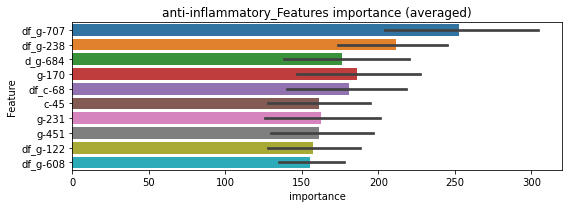

len(train_index) : 3818
len(valid_index) : 3819
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708103	valid_1's binary_logloss: 0.10185
[200]	training's binary_logloss: 0.0260009	valid_1's binary_logloss: 0.0606606
[300]	training's binary_logloss: 0.0102844	valid_1's binary_logloss: 0.0456628
[400]	training's binary_logloss: 0.00430968	valid_1's binary_logloss: 0.0377391
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00361367	valid_1's binary_logloss: 0.0366383


len(train_index) : 3819
len(valid_index) : 3818
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674805	valid_1's binary_logloss: 0.100638
[200]	training's binary_logloss: 0.0233513	valid_1's binary_logloss: 0.0625275
[300]	training's binary_logloss: 0.00882752	valid_1's binary_logloss: 0.0468502
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0064087	valid_1's binary_logloss: 0.0434383


anti-inflammatory logloss: 0.04003783707146883


neg labels: 3289 → selected neg labels: 3284


antiarrhythmic, len(trt): 24, len(othr): 3284, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686645	valid_1's binary_logloss: 0.103039
[200]	training's binary_logloss: 0.0176413	valid_1's binary_logloss: 0.044941
[300]	training's binary_logloss: 0.00549291	valid_1's binary_logloss: 0.0264808
[400]	training's binary_logloss: 0.00245572	valid_1's binary_logloss: 0.0191823
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00188662	valid_1's binary_logloss: 0.0174772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765945	valid_1's binary_logloss: 0.106684
[200]	training's binary_logloss: 0.0193196	valid_1's binary_logloss: 0.0382023
[300]	training's binary_logloss: 0.00585058	valid_1's binary_logloss: 0.0173287
[400]	training's binary_logloss: 0.00258536	valid_1's binary_logloss: 0.010521
[500]	training's binary_logloss: 0.00158457	valid_1's binary_logloss: 0.00773033
[600]	training's binary_logloss: 0.00120765	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0179471, Threshold: 0.0725516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.06530, conf_1:0.07981
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0725516
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.1025516
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.1325516
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.1625516
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.1925516
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_6: 0.2225516
threshold: 0.2225516, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651354	valid_1's binary_logloss: 0.101477
[200]	training's binary_logloss: 0.0153715	valid_1's binary_logloss: 0.0410654
[300]	training's binary_logloss: 0.0047861	valid_1's binary_logloss: 0.0231402
[400]	training's binary_logloss: 0.00223587	valid_1's binary_logloss: 0.0176704
[500]	training's binary_logloss: 0.00144766	valid_1's binary_logloss: 0.0158034
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0013543	valid_1's binary_logloss: 0.0154673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673207	valid_1's binary_logloss: 0.0917546
[200]	training's binary_logloss: 0.0172049	valid_1's binary_logloss: 0.0326221
[300]	training's binary_logloss: 0.00523947	valid_1's binary_logloss: 0.0142371
[400]	training's binary_logloss: 0.00236267	valid_1's binary_logloss: 0.00835772
[500]	training's binary_logloss: 0.00149909	valid

2 / 3 AUC score:1.000
y_Threshold: 0.2040525, Threshold: 0.2225516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.20030, conf_1:0.24481
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.2225516
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_2: 0.2525516
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.2825516
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_4: 0.3125516
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_5: 0.3425516
threshold: 0.3425516, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699205	valid_1's binary_logloss: 0.1021
[200]	training's binary_logloss: 0.0156559	valid_1's binary_logloss: 0.0357813
[300]	training's binary_logloss: 0.00489016	valid_1's binary_logloss: 0.0185897
[400]	training's binary_logloss: 0.00224044	valid_1's binary_logloss: 0.0126298
[500]	training's binary_logloss: 0.00143688	valid_1's binary_logloss: 0.0107351
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00128058	valid_1's binary_logloss: 0.0100236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672748	valid_1's binary_logloss: 0.097978
[200]	training's binary_logloss: 0.0165219	valid_1's binary_logloss: 0.0375352
[300]	training's binary_logloss: 0.00491983	valid_1's binary_logloss: 0.0189889


3 / 3 AUC score:1.000
y_Threshold: 0.2214717, Threshold: 0.3425516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0010045 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.30830, conf_1:0.37681
threshold: 0.3425516, positive_p_label: 4.0/3982, p_label_rate: 0.0010045


[400]	training's binary_logloss: 0.00224692	valid_1's binary_logloss: 0.0138086
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00231369	valid_1's binary_logloss: 0.0137435


positive_y_label: 658.0/7786, y_label_rate: 0.0845107


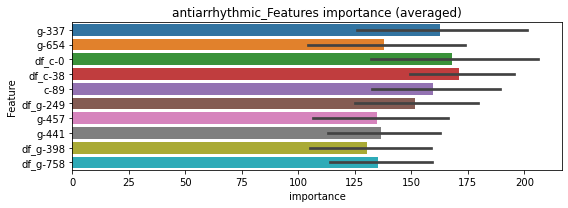

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386921	valid_1's binary_logloss: 0.058009
[200]	training's binary_logloss: 0.00947758	valid_1's binary_logloss: 0.0238643
[300]	training's binary_logloss: 0.00274374	valid_1's binary_logloss: 0.0128383
[400]	training's binary_logloss: 0.00119749	valid_1's binary_logloss: 0.00980266
[500]	training's binary_logloss: 0.000772434	valid_1's binary_logloss: 0.00884583
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000753832	valid_1's binary_logloss: 0.00882111


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315329	valid_1's binary_logloss: 0.0549681
[200]	training's binary_logloss: 0.00720448	valid_1's binary_logloss: 0.0230777
[300]	training's binary_logloss: 0.00226422	valid_1's binary_logloss: 0.0136834
[400]	training's binary_logloss: 0.0010889	valid_1's binary_logloss: 0.0106905
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00076232	valid_1's binary_logloss: 0.00954804


antiarrhythmic logloss: 0.009184573424183098


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103749	valid_1's binary_logloss: 0.146753
[200]	training's binary_logloss: 0.0352359	valid_1's binary_logloss: 0.0804451
[300]	training's binary_logloss: 0.01196	valid_1's binary_logloss: 0.0517815
[400]	training's binary_logloss: 0.00511647	valid_1's binary_logloss: 0.040407
[500]	training's binary_logloss: 0.00289669	valid_1's binary_logloss: 0.0363405
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00231069	valid_1's binary_logloss: 0.0352651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095822	valid_1's binary_logloss: 0.14606
[200]	training's binary_logloss: 0.0320741	valid_1's binary_logloss: 0.0760649
[300]	training's binary_logloss: 0.0110494	valid_1's binary_logloss: 0.0467006
[400]	training's binary_logloss: 0.00475822	valid_1's binary_logloss: 0.0338173
[500]	training's binary_logloss: 0.00278413	valid_1's bin

1 / 3 AUC score:0.998
y_Threshold: 0.0432940, Threshold: 0.3303981, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 651/3795
p_label_rate: 0.0100452 Vs.target_rate: 0.00181, Num_p_label: 40.0, conf_0:0.29736, conf_1:0.36344
Num_p_label: 40.0, Expected: 7.2, Adj_threshold_1: 0.3303981
Num_p_label: 38.0, Expected: 7.2, Adj_threshold_2: 0.3603981
Num_p_label: 32.0, Expected: 7.2, Adj_threshold_3: 0.3903981
Num_p_label: 26.0, Expected: 7.2, Adj_threshold_4: 0.4203981
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_5: 0.4503981
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_6: 0.4803981
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_7: 0.5103981
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_8: 0.5403981
threshold: 0.5403981, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874872	valid_1's binary_logloss: 0.12498
[200]	training's binary_logloss: 0.0261607	valid_1's binary_logloss: 0.0574399
[300]	training's binary_logloss: 0.00907611	valid_1's binary_logloss: 0.0327605
[400]	training's binary_logloss: 0.00408544	valid_1's binary_logloss: 0.0222592
[500]	training's binary_logloss: 0.00245698	valid_1's binary_logloss: 0.0181734
[600]	training's binary_logloss: 0.00180773	valid_1's binary_logloss: 0.0161845
[700]	training's binary_logloss: 0.00149097	valid_1's binary_logloss: 0.0153917
[800]	training's binary_logloss: 0.00130566	valid_1's binary_logloss: 0.0148025
[900]	training's binary_logloss: 0.00117947	valid_1's binary_logloss: 0.0143664
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00115976	valid_1's binary_logloss: 0.0143215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868526	vali

2 / 3 AUC score:1.000
y_Threshold: 0.1965662, Threshold: 0.5403981, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0125565 Vs.target_rate: 0.00181, Num_p_label: 50.0, conf_0:0.48636, conf_1:0.59444
Num_p_label: 50.0, Expected: 7.2, Adj_threshold_1: 0.5403981
Num_p_label: 46.0, Expected: 7.2, Adj_threshold_2: 0.5703981
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_3: 0.6003981
Num_p_label: 38.0, Expected: 7.2, Adj_threshold_4: 0.6303981
Num_p_label: 33.0, Expected: 7.2, Adj_threshold_5: 0.6603981
Num_p_label: 31.0, Expected: 7.2, Adj_threshold_6: 0.6903981
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_7: 0.7203981
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_8: 0.7503981
Num_p_label: 20.0, Expected: 7.2, Adj_threshold_9: 0.7803981
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_10: 0.8103981
threshold: 0.8403981, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814953	valid_1's binary_logloss: 0.117468
[200]	training's binary_logloss: 0.0247282	valid_1's binary_logloss: 0.0556065
[300]	training's binary_logloss: 0.00833209	valid_1's binary_logloss: 0.032707
[400]	training's binary_logloss: 0.00376087	valid_1's binary_logloss: 0.023843
[500]	training's binary_logloss: 0.00225127	valid_1's binary_logloss: 0.019931
[600]	training's binary_logloss: 0.0016675	valid_1's binary_logloss: 0.018768
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00162169	valid_1's binary_logloss: 0.0185685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835688	valid_1's binary_logloss: 0.122893
[200]	training's binary_logloss: 0.0234786	valid_1's binary_logloss: 0.0540334
[300]	training's binary_logloss: 0.00797285	valid_1's binary_logloss: 0.0309619
[400]	training's binary_logloss: 0.00362063	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1753371, Threshold: 0.8403981, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 636.0/3765
p_label_rate: 0.0037670 Vs.target_rate: 0.00181, Num_p_label: 15.0, conf_0:0.75636, conf_1:0.92444
threshold: 0.8403981, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/7747, y_label_rate: 0.0840325


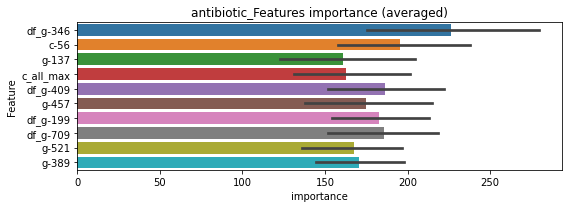

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510978	valid_1's binary_logloss: 0.0787028
[200]	training's binary_logloss: 0.0158363	valid_1's binary_logloss: 0.0411644
[300]	training's binary_logloss: 0.00563383	valid_1's binary_logloss: 0.0270253
[400]	training's binary_logloss: 0.00240329	valid_1's binary_logloss: 0.0206511
[500]	training's binary_logloss: 0.00137078	valid_1's binary_logloss: 0.0181604
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00137742	valid_1's binary_logloss: 0.0181526


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534511	valid_1's binary_logloss: 0.0745885
[200]	training's binary_logloss: 0.0166386	valid_1's binary_logloss: 0.0362516
[300]	training's binary_logloss: 0.0058041	valid_1's binary_logloss: 0.0223424
[400]	training's binary_logloss: 0.00251461	valid_1's binary_logloss: 0.0165741
[500]	training's binary_logloss: 0.00144483	valid_1's binary_logloss: 0.0140751
[600]	training's binary_logloss: 0.00103774	valid_1's binary_logloss: 0.0132473
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00103138	valid_1's binary_logloss: 0.0132407


antibiotic logloss: 0.015696955353113308


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474001	valid_1's binary_logloss: 0.0640131
[200]	training's binary_logloss: 0.00976985	valid_1's binary_logloss: 0.0202534
[300]	training's binary_logloss: 0.00284876	valid_1's binary_logloss: 0.00976579
[400]	training's binary_logloss: 0.00147142	valid_1's binary_logloss: 0.00714409
[500]	training's binary_logloss: 0.0010492	valid_1's binary_logloss: 0.0063735
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00105686	valid_1's binary_logloss: 0.00636816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459014	valid_1's binary_logloss: 0.0627886
[200]	training's binary_logloss: 0.0104743	valid_1's binary_logloss: 0.0212295
[300]	training's binary_logloss: 0.00329638	valid_1's binary_logloss: 0.0109786
[400]	training's binary_logloss: 0.00166486	valid_1's binary_logloss: 0.00826707


1 / 3 AUC score:1.000
y_Threshold: 0.0121018, Threshold: 0.0389028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.03501, conf_1:0.04279
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0389028
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0689028
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.0989028
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.1289028
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.1589028


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00124406	valid_1's binary_logloss: 0.00735771


Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.1889028
threshold: 0.1889028, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04303	valid_1's binary_logloss: 0.0569109
[200]	training's binary_logloss: 0.00790414	valid_1's binary_logloss: 0.0162564
[300]	training's binary_logloss: 0.00247871	valid_1's binary_logloss: 0.00770576
[400]	training's binary_logloss: 0.00132692	valid_1's binary_logloss: 0.00553894
[500]	training's binary_logloss: 0.000972392	valid_1's binary_logloss: 0.00507314
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000995682	valid_1's binary_logloss: 0.00506764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041585	valid_1's binary_logloss: 0.0585133
[200]	training's binary_logloss: 0.00811708	valid_1's binary_logloss: 0.0180664
[300]	training's binary_logloss: 0.00262722	valid_1's binary_logloss: 0.00964196
[400]	training's binary_logloss: 0.00137716	valid_1's binary_logloss: 0.0074274
[500]	training's binary_logloss: 0.001011

2 / 3 AUC score:1.000
y_Threshold: 0.1158752, Threshold: 0.1889028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0035158 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.17001, conf_1:0.20779
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.1889028
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.2189028
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.2489028
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.2789028
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.3089028
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.3389028
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.3689028
threshold: 0.3689028, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418968	valid_1's binary_logloss: 0.0566195
[200]	training's binary_logloss: 0.00792313	valid_1's binary_logloss: 0.0171118
[300]	training's binary_logloss: 0.00253693	valid_1's binary_logloss: 0.00910382
[400]	training's binary_logloss: 0.00135817	valid_1's binary_logloss: 0.00710896
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00121865	valid_1's binary_logloss: 0.00682028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409835	valid_1's binary_logloss: 0.0582073
[200]	training's binary_logloss: 0.00783726	valid_1's binary_logloss: 0.0151275
[300]	training's binary_logloss: 0.00246853	valid_1's binary_logloss: 0.00657428
[400]	training's binary_logloss: 0.00133565	valid_1's binary_logloss: 0.00443855
[500]	training's binary_logloss: 0.000969484	valid_1's binary_logloss: 0.0037036
Early stopping, best iteration is:
[540

3 / 3 AUC score:1.000
y_Threshold: 0.1138739, Threshold: 0.3689028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.33201, conf_1:0.40579
threshold: 0.3689028, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7789, y_label_rate: 0.0847349


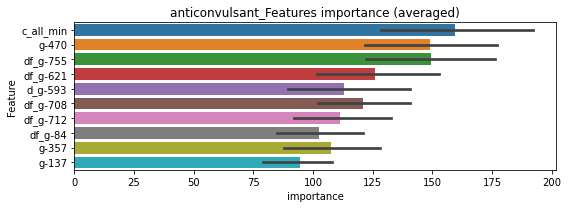

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226146	valid_1's binary_logloss: 0.0342857
[200]	training's binary_logloss: 0.00456776	valid_1's binary_logloss: 0.013069
[300]	training's binary_logloss: 0.00139504	valid_1's binary_logloss: 0.00835498


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 anticonvulsant=================================


[400]	training's binary_logloss: 0.000721355	valid_1's binary_logloss: 0.00722813
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000705995	valid_1's binary_logloss: 0.00714695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234065	valid_1's binary_logloss: 0.033818
[200]	training's binary_logloss: 0.00472385	valid_1's binary_logloss: 0.0111193
[300]	training's binary_logloss: 0.001477	valid_1's binary_logloss: 0.00626803
[400]	training's binary_logloss: 0.000779043	valid_1's binary_logloss: 0.00482947
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000704359	valid_1's binary_logloss: 0.00460543


anticonvulsant logloss: 0.005876352457515872


neg labels: 3289 → selected neg labels: 3286


antifungal, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715694	valid_1's binary_logloss: 0.108935
[200]	training's binary_logloss: 0.0194098	valid_1's binary_logloss: 0.047865
[300]	training's binary_logloss: 0.0062271	valid_1's binary_logloss: 0.0281188
[400]	training's binary_logloss: 0.00280106	valid_1's binary_logloss: 0.0209784
[500]	training's binary_logloss: 0.00174378	valid_1's binary_logloss: 0.0182327
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0013833	valid_1's binary_logloss: 0.0172695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720606	valid_1's binary_logloss: 0.106644
[200]	training's binary_logloss: 0.0194125	valid_1's binary_logloss: 0.0495422
[300]	training's binary_logloss: 0.00602597	valid_1's binary_logloss: 0.0308785
[400]	training's binary_logloss: 0.00268355	valid_1's binary_logloss: 0.023584
Early stopping, best iteration is:
[485]	training's b

1 / 3 AUC score:1.000
y_Threshold: 0.0265634, Threshold: 0.1116596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 655/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.10049, conf_1:0.12283
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.1116596
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_2: 0.1416596
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_3: 0.1716596
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_4: 0.2016596
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_5: 0.2316596
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_6: 0.2616596
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_7: 0.2916596
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_8: 0.3216596
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_9: 0.3516596
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_10: 0.3816596
threshold: 0.3816596, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682381	valid_1's binary_logloss: 0.10537
[200]	training's binary_logloss: 0.0163122	valid_1's binary_logloss: 0.0446794
[300]	training's binary_logloss: 0.00520804	valid_1's binary_logloss: 0.0266968
[400]	training's binary_logloss: 0.00242862	valid_1's binary_logloss: 0.0210128
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00241725	valid_1's binary_logloss: 0.0209821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668174	valid_1's binary_logloss: 0.0994199
[200]	training's binary_logloss: 0.0165606	valid_1's binary_logloss: 0.0388457
[300]	training's binary_logloss: 0.00523455	valid_1's binary_logloss: 0.0210129
[400]	training's binary_logloss: 0.00242107	valid_1's binary_logloss: 0.0148
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0017546	valid_1's binary_logloss: 0.0128615


2 / 3 AUC score:1.000
y_Threshold: 0.1931508, Threshold: 0.3816596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 649.0/3795
p_label_rate: 0.0045203 Vs.target_rate: 0.00109, Num_p_label: 18.0, conf_0:0.34349, conf_1:0.41983
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_1: 0.3816596
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.4116596
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_3: 0.4416596
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.4716596
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_5: 0.5016596
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_6: 0.5316596
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_7: 0.5616596
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_8: 0.5916596
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_9: 0.6216596
threshold: 0.6216596, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 649.0/3795, y_label_rate: 0.1710145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639486	valid_1's binary_logloss: 0.0982087
[200]	training's binary_logloss: 0.0156289	valid_1's binary_logloss: 0.0429916
[300]	training's binary_logloss: 0.0047857	valid_1's binary_logloss: 0.0258801
[400]	training's binary_logloss: 0.00226129	valid_1's binary_logloss: 0.0207482
[500]	training's binary_logloss: 0.0014916	valid_1's binary_logloss: 0.0186519
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.001395	valid_1's binary_logloss: 0.018155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639363	valid_1's binary_logloss: 0.0907353
[200]	training's binary_logloss: 0.0146894	valid_1's binary_logloss: 0.0350675
[300]	training's binary_logloss: 0.00482252	valid_1's binary_logloss: 0.0203703
[400]	training's binary_logloss: 0.00229974	valid_1's binary_logloss: 0.0156521
Early stopping, best iteration is:
[489]	training's 

3 / 3 AUC score:1.000
y_Threshold: 0.1150800, Threshold: 0.6216596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3787
p_label_rate: 0.0015068 Vs.target_rate: 0.00109, Num_p_label: 6.0, conf_0:0.55949, conf_1:0.68383
threshold: 0.6216596, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 651.0/7769, y_label_rate: 0.0837946


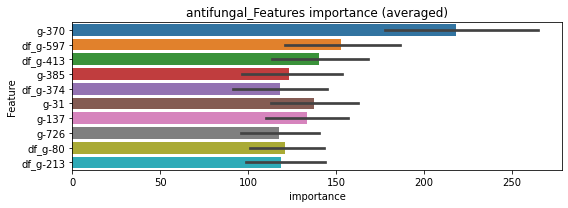

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424674	valid_1's binary_logloss: 0.0605751
[200]	training's binary_logloss: 0.0108506	valid_1's binary_logloss: 0.0252086
[300]	training's binary_logloss: 0.0033226	valid_1's binary_logloss: 0.0141747
[400]	training's binary_logloss: 0.00144103	valid_1's binary_logloss: 0.0107297
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000979537	valid_1's binary_logloss: 0.0097507


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377548	valid_1's binary_logloss: 0.0535888
[200]	training's binary_logloss: 0.00934081	valid_1's binary_logloss: 0.0225708
[300]	training's binary_logloss: 0.00294807	valid_1's binary_logloss: 0.0129255
[400]	training's binary_logloss: 0.0013524	valid_1's binary_logloss: 0.00967891
[500]	training's binary_logloss: 0.0008589	valid_1's binary_logloss: 0.00856673
[600]	training's binary_logloss: 0.000669641	valid_1's binary_logloss: 0.00825644
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000676996	valid_1's binary_logloss: 0.00822595


antifungal logloss: 0.008988424700779247


neg labels: 3289 → selected neg labels: 3288


antihistamine, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059629	valid_1's binary_logloss: 0.0784298
[200]	training's binary_logloss: 0.0133283	valid_1's binary_logloss: 0.0295852
[300]	training's binary_logloss: 0.00377502	valid_1's binary_logloss: 0.014437
[400]	training's binary_logloss: 0.00181044	valid_1's binary_logloss: 0.0101806
[500]	training's binary_logloss: 0.00122683	valid_1's binary_logloss: 0.00891213
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00101179	valid_1's binary_logloss: 0.00819894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589364	valid_1's binary_logloss: 0.0850386
[200]	training's binary_logloss: 0.012647	valid_1's binary_logloss: 0.0285341
[300]	training's binary_logloss: 0.00374919	valid_1's binary_logloss: 0.0146725
[400]	training's binary_logloss: 0.0018273	valid_1's binary_logloss: 0.0118376
[500]	training's binary_logloss: 0.00124393	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0130317, Threshold: 0.1898618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00119631	valid_1's binary_logloss: 0.0106211


p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.17088, conf_1:0.20885
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1898618
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_2: 0.2198618
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_3: 0.2498618
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.2798618
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_5: 0.3098618
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_6: 0.3398618
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_7: 0.3698618
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_8: 0.3998618
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_9: 0.4298618
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_10: 0.4598618
threshold: 0.4898618, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516732	valid_1's binary_logloss: 0.066488
[200]	training's binary_logloss: 0.00979016	valid_1's binary_logloss: 0.0186521
[300]	training's binary_logloss: 0.00297222	valid_1's binary_logloss: 0.00822867
[400]	training's binary_logloss: 0.0015066	valid_1's binary_logloss: 0.00574875
[500]	training's binary_logloss: 0.00105665	valid_1's binary_logloss: 0.00485671
[600]	training's binary_logloss: 0.000858843	valid_1's binary_logloss: 0.004322
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000861274	valid_1's binary_logloss: 0.00431888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485042	valid_1's binary_logloss: 0.0688185
[200]	training's binary_logloss: 0.00936677	valid_1's binary_logloss: 0.0201142
[300]	training's binary_logloss: 0.00287214	valid_1's binary_logloss: 0.00959077
[400]	training's binary_logloss: 0.001497

2 / 3 AUC score:1.000
y_Threshold: 0.1415841, Threshold: 0.4898618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.44088, conf_1:0.53885
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.4898618
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.5198618
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.5498618
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.5798618
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_5: 0.6098618
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.6398618
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_7: 0.6698618
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_8: 0.6998618
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.7298618
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_10: 0.7598618
threshold: 0.7898618, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516732	valid_1's binary_logloss: 0.066488
[200]	training's binary_logloss: 0.00979016	valid_1's binary_logloss: 0.0186521
[300]	training's binary_logloss: 0.00297222	valid_1's binary_logloss: 0.00822867
[400]	training's binary_logloss: 0.0015066	valid_1's binary_logloss: 0.00574875
[500]	training's binary_logloss: 0.00105665	valid_1's binary_logloss: 0.00485671
[600]	training's binary_logloss: 0.000858843	valid_1's binary_logloss: 0.004322
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000861274	valid_1's binary_logloss: 0.00431888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485042	valid_1's binary_logloss: 0.0688185
[200]	training's binary_logloss: 0.00936677	valid_1's binary_logloss: 0.0201142
[300]	training's binary_logloss: 0.00287214	valid_1's binary_logloss: 0.00959077
[400]	training's binary_logloss: 0.001497

3 / 3 AUC score:1.000
y_Threshold: 0.1415841, Threshold: 0.7898618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.71088, conf_1:0.86885
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.7898618
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.8198618
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.8498618
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.8798618
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.9098618
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.9398618
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.9698618
threshold: 0.9698618, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7795, y_label_rate: 0.0849262


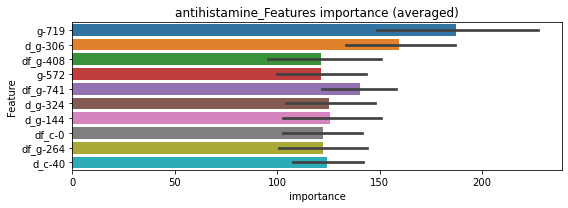

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342592	valid_1's binary_logloss: 0.0483783
[200]	training's binary_logloss: 0.00699144	valid_1's binary_logloss: 0.0166032
[300]	training's binary_logloss: 0.00188849	valid_1's binary_logloss: 0.00879233
[400]	training's binary_logloss: 0.000933489	valid_1's binary_logloss: 0.00681381
[500]	training's binary_logloss: 0.000651959	valid_1's binary_logloss: 0.00614529
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000663241	valid_1's binary_logloss: 0.00613223


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358022	valid_1's binary_logloss: 0.0481353
[200]	training's binary_logloss: 0.00739193	valid_1's binary_logloss: 0.0153936
[300]	training's binary_logloss: 0.00204881	valid_1's binary_logloss: 0.00735046
[400]	training's binary_logloss: 0.00102376	valid_1's binary_logloss: 0.0053686
[500]	training's binary_logloss: 0.00068819	valid_1's binary_logloss: 0.00463378
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000686173	valid_1's binary_logloss: 0.00463063


antihistamine logloss: 0.005381527055395065


neg labels: 3289 → selected neg labels: 3287


antimalarial, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608166	valid_1's binary_logloss: 0.0835969
[200]	training's binary_logloss: 0.013097	valid_1's binary_logloss: 0.0296143
[300]	training's binary_logloss: 0.0036953	valid_1's binary_logloss: 0.0154455
[400]	training's binary_logloss: 0.00171097	valid_1's binary_logloss: 0.0114758
[500]	training's binary_logloss: 0.00113853	valid_1's binary_logloss: 0.00995891
[600]	training's binary_logloss: 0.000936304	valid_1's binary_logloss: 0.00939296
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.000936304	valid_1's binary_logloss: 0.00939296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060448	valid_1's binary_logloss: 0.0738376
[200]	training's binary_logloss: 0.014018	valid_1's binary_logloss: 0.0245124
[300]	training's binary_logloss: 0.00399411	valid_1's binary_logloss: 0.0119772
[400]	training's binary_logloss: 0.00184489	va

1 / 3 AUC score:1.000
y_Threshold: 0.0125165, Threshold: 0.0573159, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.05158, conf_1:0.06305
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0573159
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0873159
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.1173159
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.1473159
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.1773159
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.2073159
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.2373159
threshold: 0.2373159, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539764	valid_1's binary_logloss: 0.0753315
[200]	training's binary_logloss: 0.011304	valid_1's binary_logloss: 0.0258555
[300]	training's binary_logloss: 0.0032249	valid_1's binary_logloss: 0.0128012
[400]	training's binary_logloss: 0.00151811	valid_1's binary_logloss: 0.00895184
[500]	training's binary_logloss: 0.00101542	valid_1's binary_logloss: 0.00765338
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000885309	valid_1's binary_logloss: 0.00736546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055432	valid_1's binary_logloss: 0.0665354
[200]	training's binary_logloss: 0.0114682	valid_1's binary_logloss: 0.0182995
[300]	training's binary_logloss: 0.00329406	valid_1's binary_logloss: 0.00709249
[400]	training's binary_logloss: 0.00157453	valid_1's binary_logloss: 0.00409712
[500]	training's binary_logloss: 0.00107764	

2 / 3 AUC score:1.000
y_Threshold: 0.1322561, Threshold: 0.2373159, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0075339 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.21358, conf_1:0.26105
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.2373159
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.2673159
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.2973159
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.3273159
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.3573159
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.3873159
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.4173159
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_8: 0.4473159
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.4773159
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.5073159
threshold: 0.5373159, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528558	valid_1's binary_logloss: 0.0736331
[200]	training's binary_logloss: 0.0109575	valid_1's binary_logloss: 0.0244831
[300]	training's binary_logloss: 0.00322234	valid_1's binary_logloss: 0.0118519
[400]	training's binary_logloss: 0.00150151	valid_1's binary_logloss: 0.00783769
[500]	training's binary_logloss: 0.00101886	valid_1's binary_logloss: 0.0065398
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000896825	valid_1's binary_logloss: 0.00620049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567507	valid_1's binary_logloss: 0.0738866
[200]	training's binary_logloss: 0.0122327	valid_1's binary_logloss: 0.028043
[300]	training's binary_logloss: 0.00326494	valid_1's binary_logloss: 0.0127303
[400]	training's binary_logloss: 0.00157516	valid_1's binary_logloss: 0.00840444
[500]	training's binary_logloss: 0.001056	va

3 / 3 AUC score:1.000
y_Threshold: 0.1043573, Threshold: 0.5373159, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.48358, conf_1:0.59105
threshold: 0.5373159, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


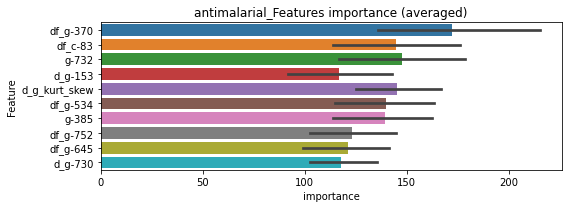

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307128	valid_1's binary_logloss: 0.0435334
[200]	training's binary_logloss: 0.00650651	valid_1's binary_logloss: 0.015044
[300]	training's binary_logloss: 0.00178038	valid_1's binary_logloss: 0.00740651
[400]	training's binary_logloss: 0.000837332	valid_1's binary_logloss: 0.00532297
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000720436	valid_1's binary_logloss: 0.00505455


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033381	valid_1's binary_logloss: 0.0454009
[200]	training's binary_logloss: 0.00661939	valid_1's binary_logloss: 0.0145793
[300]	training's binary_logloss: 0.00178361	valid_1's binary_logloss: 0.00681834
[400]	training's binary_logloss: 0.000831449	valid_1's binary_logloss: 0.00468561
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000710651	valid_1's binary_logloss: 0.00442904


antimalarial logloss: 0.004741792131304243


neg labels: 3289 → selected neg labels: 3281


antioxidant, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879639	valid_1's binary_logloss: 0.17003
[200]	training's binary_logloss: 0.0317756	valid_1's binary_logloss: 0.121169
[300]	training's binary_logloss: 0.0129813	valid_1's binary_logloss: 0.105333
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0089585	valid_1's binary_logloss: 0.102203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102375	valid_1's binary_logloss: 0.158615
[200]	training's binary_logloss: 0.0390043	valid_1's binary_logloss: 0.104161
[300]	training's binary_logloss: 0.0164866	valid_1's binary_logloss: 0.0815455
[400]	training's binary_logloss: 0.0078258	valid_1's binary_logloss: 0.0723147
[500]	training's binary_logloss: 0.00435502	valid_1's binary_logloss: 0.0683308
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00446902	valid_1's binary_logloss: 0.0681438


1 / 3 AUC score:0.989
y_Threshold: 0.0447956, Threshold: 0.1839360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 628/3749
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.16554, conf_1:0.20233
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1839360
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_2: 0.2139360
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_3: 0.2439360
threshold: 0.2439360, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 628.0/3749, y_label_rate: 0.1675113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835353	valid_1's binary_logloss: 0.145976
[200]	training's binary_logloss: 0.026819	valid_1's binary_logloss: 0.0919685
[300]	training's binary_logloss: 0.0106636	valid_1's binary_logloss: 0.0727969
[400]	training's binary_logloss: 0.00501526	valid_1's binary_logloss: 0.0637287
[500]	training's binary_logloss: 0.0030187	valid_1's binary_logloss: 0.0608948
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00241118	valid_1's binary_logloss: 0.0596379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876883	valid_1's binary_logloss: 0.14128
[200]	training's binary_logloss: 0.029258	valid_1's binary_logloss: 0.0863004
[300]	training's binary_logloss: 0.0114691	valid_1's binary_logloss: 0.0685023
[400]	training's binary_logloss: 0.00544722	valid_1's binary_logloss: 0.0618902
Early stopping, best iteration is:
[470]	training's bin

2 / 3 AUC score:0.994
y_Threshold: 0.0822993, Threshold: 0.2439360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 601.0/3695
p_label_rate: 0.0135610 Vs.target_rate: 0.00307, Num_p_label: 54.0, conf_0:0.21954, conf_1:0.26833
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_1: 0.2439360
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.2739360
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_3: 0.3039360
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_4: 0.3339360
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.3639360
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_6: 0.3939360
threshold: 0.3939360, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 601.0/3695, y_label_rate: 0.1626522
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712624	valid_1's binary_logloss: 0.129657
[200]	training's binary_logloss: 0.0216154	valid_1's binary_logloss: 0.0828072
[300]	training's binary_logloss: 0.00828637	valid_1's binary_logloss: 0.0687699
[400]	training's binary_logloss: 0.0040122	valid_1's binary_logloss: 0.062009
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00389004	valid_1's binary_logloss: 0.061599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783085	valid_1's binary_logloss: 0.125167
[200]	training's binary_logloss: 0.0253382	valid_1's binary_logloss: 0.0740348
[300]	training's binary_logloss: 0.00977982	valid_1's binary_logloss: 0.0564706
[400]	training's binary_logloss: 0.00459109	valid_1's binary_logloss: 0.0507641
[500]	training's binary_logloss: 0.00275673	valid_1's binary_logloss: 0.0481311
Early stopping, best iteration is:
[555]	training's 

3 / 3 AUC score:0.994
y_Threshold: 0.0884279, Threshold: 0.3939360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 580.0/3653
p_label_rate: 0.0062783 Vs.target_rate: 0.00307, Num_p_label: 25.0, conf_0:0.35454, conf_1:0.43333
threshold: 0.3939360, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 605.0/7635, y_label_rate: 0.0792403


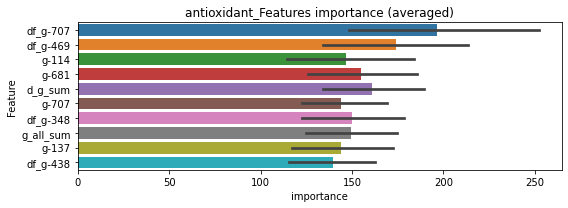

len(train_index) : 3817
len(valid_index) : 3818
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412443	valid_1's binary_logloss: 0.0731866
[200]	training's binary_logloss: 0.0127606	valid_1's binary_logloss: 0.0471934
[300]	training's binary_logloss: 0.00476496	valid_1's binary_logloss: 0.0399335
[400]	training's binary_logloss: 0.00225779	valid_1's binary_logloss: 0.0374511
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00179557	valid_1's binary_logloss: 0.036824


len(train_index) : 3818
len(valid_index) : 3817
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403248	valid_1's binary_logloss: 0.0788099
[200]	training's binary_logloss: 0.011923	valid_1's binary_logloss: 0.0492223
[300]	training's binary_logloss: 0.00450268	valid_1's binary_logloss: 0.039948
[400]	training's binary_logloss: 0.0022976	valid_1's binary_logloss: 0.0366751
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00147996	valid_1's binary_logloss: 0.0345101


antioxidant logloss: 0.03566717354968722


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100074	valid_1's binary_logloss: 0.133137
[200]	training's binary_logloss: 0.0312605	valid_1's binary_logloss: 0.0615785
[300]	training's binary_logloss: 0.0109335	valid_1's binary_logloss: 0.0343812
[400]	training's binary_logloss: 0.00470805	valid_1's binary_logloss: 0.0234771
[500]	training's binary_logloss: 0.00259336	valid_1's binary_logloss: 0.0180048
[600]	training's binary_logloss: 0.00181255	valid_1's binary_logloss: 0.0162077
[700]	training's binary_logloss: 0.0014563	valid_1's binary_logloss: 0.015193
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00132569	valid_1's binary_logloss: 0.0146398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910123	valid_1's binary_logloss: 0.142456
[200]	training's binary_logloss: 0.0305061	valid_1's binary_logloss: 0.0792683
[300]	training's binary_logloss: 0.00993217	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0378204, Threshold: 0.1802036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.16218, conf_1:0.19822
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1802036
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.2102036
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_3: 0.2402036
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.2702036
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.3002036
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.3302036
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_7: 0.3602036
threshold: 0.3602036, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839633	valid_1's binary_logloss: 0.128426
[200]	training's binary_logloss: 0.0242068	valid_1's binary_logloss: 0.0574663
[300]	training's binary_logloss: 0.00850662	valid_1's binary_logloss: 0.0320995
[400]	training's binary_logloss: 0.00370557	valid_1's binary_logloss: 0.0219376
[500]	training's binary_logloss: 0.00221427	valid_1's binary_logloss: 0.0177347
[600]	training's binary_logloss: 0.00162776	valid_1's binary_logloss: 0.0156122
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00146359	valid_1's binary_logloss: 0.0150371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086943	valid_1's binary_logloss: 0.125905
[200]	training's binary_logloss: 0.0258074	valid_1's binary_logloss: 0.0570344
[300]	training's binary_logloss: 0.00875883	valid_1's binary_logloss: 0.0317014
[400]	training's binary_logloss: 0.00371791	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.2962358, Threshold: 0.3602036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0082873 Vs.target_rate: 0.00151, Num_p_label: 33.0, conf_0:0.32418, conf_1:0.39622
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.3602036
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.3902036
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.4202036
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.4502036
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.4802036
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.5102036
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.5402036
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.5702036
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.6002036
threshold: 0.6002036, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850876	valid_1's binary_logloss: 0.131073
[200]	training's binary_logloss: 0.0239248	valid_1's binary_logloss: 0.0708698
[300]	training's binary_logloss: 0.00779299	valid_1's binary_logloss: 0.0528399
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00379091	valid_1's binary_logloss: 0.0486971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894164	valid_1's binary_logloss: 0.137905
[200]	training's binary_logloss: 0.0265371	valid_1's binary_logloss: 0.0737313
[300]	training's binary_logloss: 0.00861132	valid_1's binary_logloss: 0.0469443
[400]	training's binary_logloss: 0.0037584	valid_1's binary_logloss: 0.0359082
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00304796	valid_1's binary_logloss: 0.0346488


3 / 3 AUC score:0.997
y_Threshold: 0.1385218, Threshold: 0.6002036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 629.0/3753
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.54018, conf_1:0.66022
threshold: 0.6002036, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 642.0/7735, y_label_rate: 0.0829994


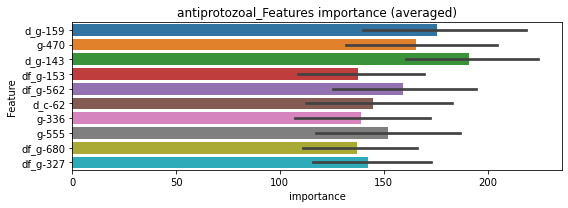

len(train_index) : 3867
len(valid_index) : 3868
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054322	valid_1's binary_logloss: 0.0756012
[200]	training's binary_logloss: 0.017378	valid_1's binary_logloss: 0.036858
[300]	training's binary_logloss: 0.00604145	valid_1's binary_logloss: 0.0226765
[400]	training's binary_logloss: 0.00248839	valid_1's binary_logloss: 0.0170296
[500]	training's binary_logloss: 0.00133297	valid_1's binary_logloss: 0.0150141
[600]	training's binary_logloss: 0.00094424	valid_1's binary_logloss: 0.0138576
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.000827945	valid_1's binary_logloss: 0.0134034


len(train_index) : 3868
len(valid_index) : 3867
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481217	valid_1's binary_logloss: 0.0779877
[200]	training's binary_logloss: 0.0149511	valid_1's binary_logloss: 0.0396861
[300]	training's binary_logloss: 0.00507639	valid_1's binary_logloss: 0.02469
[400]	training's binary_logloss: 0.00218063	valid_1's binary_logloss: 0.0190298
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00132584	valid_1's binary_logloss: 0.0170629


antiprotozoal logloss: 0.015232884809057686


neg labels: 3289 → selected neg labels: 3282


antiviral, len(trt): 23, len(othr): 3282, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548181	valid_1's binary_logloss: 0.0844342
[200]	training's binary_logloss: 0.0128878	valid_1's binary_logloss: 0.0338839
[300]	training's binary_logloss: 0.00407346	valid_1's binary_logloss: 0.0187245
[400]	training's binary_logloss: 0.00192263	valid_1's binary_logloss: 0.0128647
[500]	training's binary_logloss: 0.00125522	valid_1's binary_logloss: 0.0108246
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00104852	valid_1's binary_logloss: 0.0103171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611681	valid_1's binary_logloss: 0.0859883
[200]	training's binary_logloss: 0.0138023	valid_1's binary_logloss: 0.0327964
[300]	training's binary_logloss: 0.00424687	valid_1's binary_logloss: 0.0175848
[400]	training's binary_logloss: 0.00201067	valid_1's binary_logloss: 0.0120868
[500]	training's binary_logloss: 0.0013488	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0198755, Threshold: 0.0876291, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.07887, conf_1:0.09639
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0876291
Num_p_label: 29.0, Expected: 3.8, Adj_threshold_2: 0.1176291
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_3: 0.1476291
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_4: 0.1776291
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_5: 0.2076291
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_6: 0.2376291
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_7: 0.2676291
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_8: 0.2976291
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_9: 0.3276291
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_10: 0.3576291
threshold: 0.3576291, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518039	valid_1's binary_logloss: 0.0712278
[200]	training's binary_logloss: 0.0108054	valid_1's binary_logloss: 0.0235303
[300]	training's binary_logloss: 0.00340674	valid_1's binary_logloss: 0.0118035
[400]	training's binary_logloss: 0.00170512	valid_1's binary_logloss: 0.0082548
[500]	training's binary_logloss: 0.00115622	valid_1's binary_logloss: 0.00694862
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00103395	valid_1's binary_logloss: 0.00662311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049531	valid_1's binary_logloss: 0.079684
[200]	training's binary_logloss: 0.0100795	valid_1's binary_logloss: 0.0281548
[300]	training's binary_logloss: 0.00325127	valid_1's binary_logloss: 0.0151955
[400]	training's binary_logloss: 0.00164765	valid_1's binary_logloss: 0.01068
Early stopping, best iteration is:
[462]	training

2 / 3 AUC score:1.000
y_Threshold: 0.1982597, Threshold: 0.3576291, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0050226 Vs.target_rate: 0.00097, Num_p_label: 20.0, conf_0:0.32187, conf_1:0.39339
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_1: 0.3576291
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_2: 0.3876291
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_3: 0.4176291
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_4: 0.4476291
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_5: 0.4776291
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_6: 0.5076291
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_7: 0.5376291
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_8: 0.5676291
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_9: 0.5976291
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_10: 0.6276291
threshold: 0.6276291, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518039	valid_1's binary_logloss: 0.0712278
[200]	training's binary_logloss: 0.0108054	valid_1's binary_logloss: 0.0235303
[300]	training's binary_logloss: 0.00340674	valid_1's binary_logloss: 0.0118035
[400]	training's binary_logloss: 0.00170512	valid_1's binary_logloss: 0.0082548
[500]	training's binary_logloss: 0.00115622	valid_1's binary_logloss: 0.00694862
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00103395	valid_1's binary_logloss: 0.00662311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049531	valid_1's binary_logloss: 0.079684
[200]	training's binary_logloss: 0.0100795	valid_1's binary_logloss: 0.0281548
[300]	training's binary_logloss: 0.00325127	valid_1's binary_logloss: 0.0151955
[400]	training's binary_logloss: 0.00164765	valid_1's binary_logloss: 0.01068
Early stopping, best iteration is:
[462]	training

3 / 3 AUC score:1.000
y_Threshold: 0.1982597, Threshold: 0.6276291, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.56487, conf_1:0.69039
threshold: 0.6276291, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


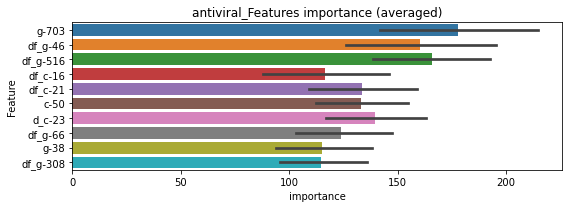

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292617	valid_1's binary_logloss: 0.0497608
[200]	training's binary_logloss: 0.00590677	valid_1's binary_logloss: 0.0192333
[300]	training's binary_logloss: 0.00185839	valid_1's binary_logloss: 0.0113453
[400]	training's binary_logloss: 0.000901995	valid_1's binary_logloss: 0.00865895
[500]	training's binary_logloss: 0.000617446	valid_1's binary_logloss: 0.00794495
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00062702	valid_1's binary_logloss: 0.00789922


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315005	valid_1's binary_logloss: 0.0458746
[200]	training's binary_logloss: 0.00711674	valid_1's binary_logloss: 0.0178924
[300]	training's binary_logloss: 0.00221926	valid_1's binary_logloss: 0.0112562
[400]	training's binary_logloss: 0.00103768	valid_1's binary_logloss: 0.00905118
[500]	training's binary_logloss: 0.000695464	valid_1's binary_logloss: 0.00840181
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000707858	valid_1's binary_logloss: 0.0083825


antiviral logloss: 0.008140858617806855


neg labels: 3289 → selected neg labels: 3283


apoptosis_stimulant, len(trt): 49, len(othr): 3283, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991846	valid_1's binary_logloss: 0.158986
[200]	training's binary_logloss: 0.0339574	valid_1's binary_logloss: 0.094455
[300]	training's binary_logloss: 0.0121562	valid_1's binary_logloss: 0.069399
[400]	training's binary_logloss: 0.00533958	valid_1's binary_logloss: 0.0590469
[500]	training's binary_logloss: 0.00303966	valid_1's binary_logloss: 0.0551914
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00255816	valid_1's binary_logloss: 0.0539683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107346	valid_1's binary_logloss: 0.146749
[200]	training's binary_logloss: 0.0410084	valid_1's binary_logloss: 0.0823325
[300]	training's binary_logloss: 0.0146502	valid_1's binary_logloss: 0.0496586
[400]	training's binary_logloss: 0.00628234	valid_1's binary_logloss: 0.0354455
[500]	training's binary_logloss: 0.00347676	valid_1's 

1 / 3 AUC score:0.998
y_Threshold: 0.0331133, Threshold: 0.1998953, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00206, Num_p_label: 40.0, conf_0:0.17991, conf_1:0.21988
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_1: 0.1998953
Num_p_label: 31.0, Expected: 8.2, Adj_threshold_2: 0.2298953
Num_p_label: 28.0, Expected: 8.2, Adj_threshold_3: 0.2598953
Num_p_label: 24.0, Expected: 8.2, Adj_threshold_4: 0.2898953
Num_p_label: 18.0, Expected: 8.2, Adj_threshold_5: 0.3198953
Num_p_label: 15.0, Expected: 8.2, Adj_threshold_6: 0.3498953
threshold: 0.3498953, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3791, y_label_rate: 0.1709312
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100367	valid_1's binary_logloss: 0.143698
[200]	training's binary_logloss: 0.031173	valid_1's binary_logloss: 0.0733642
[300]	training's binary_logloss: 0.0110973	valid_1's binary_logloss: 0.0479084
[400]	training's binary_logloss: 0.00500939	valid_1's binary_logloss: 0.0377243
[500]	training's binary_logloss: 0.00278541	valid_1's binary_logloss: 0.0322544
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00206252	valid_1's binary_logloss: 0.030875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096132	valid_1's binary_logloss: 0.139968
[200]	training's binary_logloss: 0.0299758	valid_1's binary_logloss: 0.0716081
[300]	training's binary_logloss: 0.0109136	valid_1's binary_logloss: 0.0468038
[400]	training's binary_logloss: 0.00483495	valid_1's binary_logloss: 0.0357655
[500]	training's binary_logloss: 0.00281567	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.1312522, Threshold: 0.3498953, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 633.0/3761
p_label_rate: 0.0140633 Vs.target_rate: 0.00206, Num_p_label: 56.0, conf_0:0.31491, conf_1:0.38488
Num_p_label: 56.0, Expected: 8.2, Adj_threshold_1: 0.3498953
Num_p_label: 48.0, Expected: 8.2, Adj_threshold_2: 0.3798953
Num_p_label: 45.0, Expected: 8.2, Adj_threshold_3: 0.4098953
Num_p_label: 38.0, Expected: 8.2, Adj_threshold_4: 0.4398953
Num_p_label: 35.0, Expected: 8.2, Adj_threshold_5: 0.4698953
Num_p_label: 33.0, Expected: 8.2, Adj_threshold_6: 0.4998953
Num_p_label: 32.0, Expected: 8.2, Adj_threshold_7: 0.5298953
Num_p_label: 30.0, Expected: 8.2, Adj_threshold_8: 0.5598953
Num_p_label: 24.0, Expected: 8.2, Adj_threshold_9: 0.5898953
Num_p_label: 23.0, Expected: 8.2, Adj_threshold_10: 0.6198953
threshold: 0.6498953, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 633.0/3761, y_label_rate: 0.1683063
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826199	valid_1's binary_logloss: 0.136905
[200]	training's binary_logloss: 0.0254474	valid_1's binary_logloss: 0.0726139
[300]	training's binary_logloss: 0.00911964	valid_1's binary_logloss: 0.0498468
[400]	training's binary_logloss: 0.00407277	valid_1's binary_logloss: 0.0396566
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00320929	valid_1's binary_logloss: 0.0382338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919359	valid_1's binary_logloss: 0.141478
[200]	training's binary_logloss: 0.0285986	valid_1's binary_logloss: 0.072416
[300]	training's binary_logloss: 0.00945104	valid_1's binary_logloss: 0.0453234
[400]	training's binary_logloss: 0.00425038	valid_1's binary_logloss: 0.0351523
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00290922	valid_1's binary_logloss: 0.0323061


3 / 3 AUC score:0.999
y_Threshold: 0.1270875, Threshold: 0.6498953, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 622.0/3739
p_label_rate: 0.0045203 Vs.target_rate: 0.00206, Num_p_label: 18.0, conf_0:0.58491, conf_1:0.71488
threshold: 0.6498953, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/7721, y_label_rate: 0.0828908


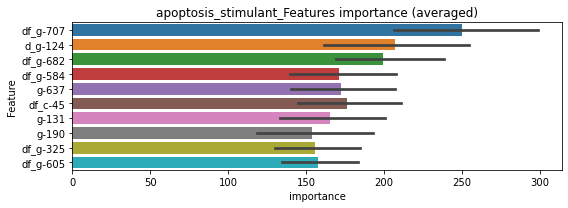

len(train_index) : 3860
len(valid_index) : 3861
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532372	valid_1's binary_logloss: 0.0883517
[200]	training's binary_logloss: 0.0165148	valid_1's binary_logloss: 0.0522362
[300]	training's binary_logloss: 0.00536847	valid_1's binary_logloss: 0.0387892
[400]	training's binary_logloss: 0.00227889	valid_1's binary_logloss: 0.0343613
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00139834	valid_1's binary_logloss: 0.0325645


len(train_index) : 3861
len(valid_index) : 3860
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520154	valid_1's binary_logloss: 0.0802252
[200]	training's binary_logloss: 0.0164024	valid_1's binary_logloss: 0.0421291
[300]	training's binary_logloss: 0.00599145	valid_1's binary_logloss: 0.0292757
[400]	training's binary_logloss: 0.00269398	valid_1's binary_logloss: 0.024382
[500]	training's binary_logloss: 0.00154047	valid_1's binary_logloss: 0.0224411
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00132347	valid_1's binary_logloss: 0.0221727


apoptosis_stimulant logloss: 0.02736926595347013


neg labels: 3289 → selected neg labels: 3283


aromatase_inhibitor, len(trt): 47, len(othr): 3283, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110364	valid_1's binary_logloss: 0.176422
[200]	training's binary_logloss: 0.0420178	valid_1's binary_logloss: 0.111304
[300]	training's binary_logloss: 0.017087	valid_1's binary_logloss: 0.0816758
[400]	training's binary_logloss: 0.00748837	valid_1's binary_logloss: 0.0648296
[500]	training's binary_logloss: 0.00403389	valid_1's binary_logloss: 0.0580238
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00382358	valid_1's binary_logloss: 0.0574883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104766	valid_1's binary_logloss: 0.175735
[200]	training's binary_logloss: 0.0411087	valid_1's binary_logloss: 0.112135
[300]	training's binary_logloss: 0.0160542	valid_1's binary_logloss: 0.0802532
[400]	training's binary_logloss: 0.00689825	valid_1's binary_logloss: 0.0627605
[500]	training's binary_logloss: 0.00372697	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0771287, Threshold: 0.2580046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00197, Num_p_label: 40.0, conf_0:0.23220, conf_1:0.28381
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_1: 0.2580046
Num_p_label: 32.0, Expected: 7.9, Adj_threshold_2: 0.2880046
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_3: 0.3180046
Num_p_label: 25.0, Expected: 7.9, Adj_threshold_4: 0.3480046
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_5: 0.3780046
Num_p_label: 18.0, Expected: 7.9, Adj_threshold_6: 0.4080046
Num_p_label: 16.0, Expected: 7.9, Adj_threshold_7: 0.4380046
Num_p_label: 16.0, Expected: 7.9, Adj_threshold_8: 0.4680046
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_9: 0.4980046
threshold: 0.4980046, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 648.0/3791, y_label_rate: 0.1709312
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972113	valid_1's binary_logloss: 0.152689
[200]	training's binary_logloss: 0.0353784	valid_1's binary_logloss: 0.0889847
[300]	training's binary_logloss: 0.0136318	valid_1's binary_logloss: 0.059859
[400]	training's binary_logloss: 0.00602483	valid_1's binary_logloss: 0.0442409
[500]	training's binary_logloss: 0.00333872	valid_1's binary_logloss: 0.0380261
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00279415	valid_1's binary_logloss: 0.0354974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10513	valid_1's binary_logloss: 0.154284
[200]	training's binary_logloss: 0.0354479	valid_1's binary_logloss: 0.0802945
[300]	training's binary_logloss: 0.0128442	valid_1's binary_logloss: 0.0499834
[400]	training's binary_logloss: 0.00578846	valid_1's binary_logloss: 0.037068
[500]	training's binary_logloss: 0.00323675	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.2152627, Threshold: 0.4980046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 634.0/3763
p_label_rate: 0.0085384 Vs.target_rate: 0.00197, Num_p_label: 34.0, conf_0:0.44820, conf_1:0.54781
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_1: 0.4980046
Num_p_label: 28.0, Expected: 7.9, Adj_threshold_2: 0.5280046
Num_p_label: 24.0, Expected: 7.9, Adj_threshold_3: 0.5580046
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_4: 0.5880046
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_5: 0.6180046
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_6: 0.6480046
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_7: 0.6780046
threshold: 0.6780046, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 634.0/3763, y_label_rate: 0.1684826
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915355	valid_1's binary_logloss: 0.145945
[200]	training's binary_logloss: 0.032846	valid_1's binary_logloss: 0.0860304
[300]	training's binary_logloss: 0.0120138	valid_1's binary_logloss: 0.060432
[400]	training's binary_logloss: 0.00527415	valid_1's binary_logloss: 0.046844
[500]	training's binary_logloss: 0.00301703	valid_1's binary_logloss: 0.0419858
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00234037	valid_1's binary_logloss: 0.0398377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092511	valid_1's binary_logloss: 0.145037
[200]	training's binary_logloss: 0.0304839	valid_1's binary_logloss: 0.076907
[300]	training's binary_logloss: 0.0109168	valid_1's binary_logloss: 0.0490646
[400]	training's binary_logloss: 0.00489007	valid_1's binary_logloss: 0.0366145
[500]	training's binary_logloss: 0.00284602	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.1840554, Threshold: 0.6780046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 617.0/3729
p_label_rate: 0.0040181 Vs.target_rate: 0.00197, Num_p_label: 16.0, conf_0:0.61020, conf_1:0.74581
threshold: 0.6780046, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 633.0/7711, y_label_rate: 0.0820905


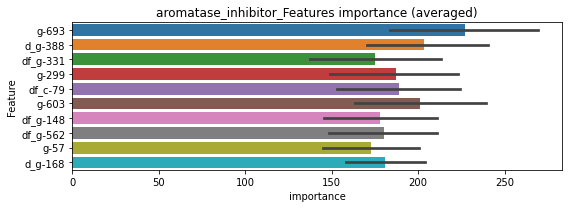

len(train_index) : 3855
len(valid_index) : 3856
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595578	valid_1's binary_logloss: 0.0984375
[200]	training's binary_logloss: 0.0209455	valid_1's binary_logloss: 0.0601353
[300]	training's binary_logloss: 0.00838951	valid_1's binary_logloss: 0.0438058
[400]	training's binary_logloss: 0.00351904	valid_1's binary_logloss: 0.0344337
[500]	training's binary_logloss: 0.00185494	valid_1's binary_logloss: 0.0293682
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00153815	valid_1's binary_logloss: 0.0282662


len(train_index) : 3856
len(valid_index) : 3855
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055866	valid_1's binary_logloss: 0.0985132
[200]	training's binary_logloss: 0.0188366	valid_1's binary_logloss: 0.05733
[300]	training's binary_logloss: 0.00693769	valid_1's binary_logloss: 0.0405869
[400]	training's binary_logloss: 0.00287426	valid_1's binary_logloss: 0.0329607
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00170727	valid_1's binary_logloss: 0.030762


aromatase_inhibitor logloss: 0.02951393977457062


neg labels: 3289 → selected neg labels: 3285


atm_kinase_inhibitor, len(trt): 6, len(othr): 3285, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224383	valid_1's binary_logloss: 0.024833
[200]	training's binary_logloss: 0.00264553	valid_1's binary_logloss: 0.00409657
[300]	training's binary_logloss: 0.00081075	valid_1's binary_logloss: 0.00173314
[400]	training's binary_logloss: 0.000491404	valid_1's binary_logloss: 0.00124467
[500]	training's binary_logloss: 0.000402912	valid_1's binary_logloss: 0.00106192
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000399862	valid_1's binary_logloss: 0.00104966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216638	valid_1's binary_logloss: 0.0309561
[200]	training's binary_logloss: 0.00252336	valid_1's binary_logloss: 0.00781441
[300]	training's binary_logloss: 0.000782354	valid_1's binary_logloss: 0.00424474
[400]	training's binary_logloss: 0.000474889	valid_1's binary_logloss: 0.0031634
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0019220, Threshold: 0.0132329, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.01191, conf_1:0.01456
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0132329
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_2: 0.0432329
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.0732329
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.1032329
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.1332329
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1632329
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.1932329
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2232329
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2532329
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2832329
threshold: 0.3132329, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200004	valid_1's binary_logloss: 0.0239747
[200]	training's binary_logloss: 0.00218557	valid_1's binary_logloss: 0.00347855
[300]	training's binary_logloss: 0.000666473	valid_1's binary_logloss: 0.00123903
[400]	training's binary_logloss: 0.000403913	valid_1's binary_logloss: 0.000844038
[500]	training's binary_logloss: 0.00034171	valid_1's binary_logloss: 0.000713798
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000333871	valid_1's binary_logloss: 0.00069885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198253	valid_1's binary_logloss: 0.0257941
[200]	training's binary_logloss: 0.00212525	valid_1's binary_logloss: 0.00628327
[300]	training's binary_logloss: 0.000647278	valid_1's binary_logloss: 0.00323324
[400]	training's binary_logloss: 0.000408256	valid_1's binary_logloss: 0.0024645
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.2006271, Threshold: 0.3132329, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00025, Num_p_label: 16.0, conf_0:0.28191, conf_1:0.34456
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_1: 0.3132329
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.3432329
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.3732329
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.4032329
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_5: 0.4332329
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.4632329
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.4932329
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.5232329
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.5532329
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.5832329
threshold: 0.6132329, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200004	valid_1's binary_logloss: 0.0239747
[200]	training's binary_logloss: 0.00218557	valid_1's binary_logloss: 0.00347855
[300]	training's binary_logloss: 0.000666473	valid_1's binary_logloss: 0.00123903
[400]	training's binary_logloss: 0.000403913	valid_1's binary_logloss: 0.000844038
[500]	training's binary_logloss: 0.00034171	valid_1's binary_logloss: 0.000713798
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000333871	valid_1's binary_logloss: 0.00069885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198253	valid_1's binary_logloss: 0.0257941
[200]	training's binary_logloss: 0.00212525	valid_1's binary_logloss: 0.00628327
[300]	training's binary_logloss: 0.000647278	valid_1's binary_logloss: 0.00323324


3 / 3 AUC score:1.000
y_Threshold: 0.2006271, Threshold: 0.6132329, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.000408256	valid_1's binary_logloss: 0.0024645
[500]	training's binary_logloss: 0.000329253	valid_1's binary_logloss: 0.00224323
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000314393	valid_1's binary_logloss: 0.00214622


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.55191, conf_1:0.67456
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.6132329
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.6432329
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.6732329
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.7032329
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.7332329
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.7632329
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.7932329
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.8232329
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.8532329
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.8832329
threshold: 0.8832329, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7792, y_label_rate: 0.0844456


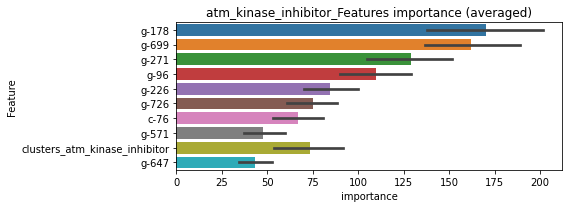

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105687	valid_1's binary_logloss: 0.0136445
[200]	training's binary_logloss: 0.00117505	valid_1's binary_logloss: 0.00326856
[300]	training's binary_logloss: 0.000367797	valid_1's binary_logloss: 0.00177262
[400]	training's binary_logloss: 0.000229256	valid_1's binary_logloss: 0.00136644
[500]	training's binary_logloss: 0.000185672	valid_1's binary_logloss: 0.00122811
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000182818	valid_1's binary_logloss: 0.00121597


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113405	valid_1's binary_logloss: 0.0129082
[200]	training's binary_logloss: 0.00130381	valid_1's binary_logloss: 0.00214467
[300]	training's binary_logloss: 0.000401058	valid_1's binary_logloss: 0.00088406
[400]	training's binary_logloss: 0.000253789	valid_1's binary_logloss: 0.000654221
[500]	training's binary_logloss: 0.000197963	valid_1's binary_logloss: 0.000550523
[600]	training's binary_logloss: 0.000189209	valid_1's binary_logloss: 0.000534909
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000189209	valid_1's binary_logloss: 0.000534909


atm_kinase_inhibitor logloss: 0.0008754383315947503


neg labels: 3289 → selected neg labels: 3289


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273279	valid_1's binary_logloss: 0.0377173
[200]	training's binary_logloss: 0.00329674	valid_1's binary_logloss: 0.00908877
[300]	training's binary_logloss: 0.000993596	valid_1's binary_logloss: 0.00466557
[400]	training's binary_logloss: 0.000571788	valid_1's binary_logloss: 0.0034067
[500]	training's binary_logloss: 0.000456836	valid_1's binary_logloss: 0.00305318
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000454087	valid_1's binary_logloss: 0.00304077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295216	valid_1's binary_logloss: 0.0363425
[200]	training's binary_logloss: 0.00401171	valid_1's binary_logloss: 0.00838131
[300]	training's binary_logloss: 0.00112791	valid_1's binary_logloss: 0.0040932
[400]	training's binary_logloss: 0.000630972	valid_1's binary_logloss: 0.00304902
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0032540, Threshold: 0.0315383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.02838, conf_1:0.03469
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0315383
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_2: 0.0615383
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_3: 0.0915383
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_4: 0.1215383
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.1515383
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.1815383
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.2115383
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_8: 0.2415383
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.2715383
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.3015383
threshold: 0.3315383, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
===============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228128	valid_1's binary_logloss: 0.0297507
[200]	training's binary_logloss: 0.00285225	valid_1's binary_logloss: 0.00680601
[300]	training's binary_logloss: 0.000863365	valid_1's binary_logloss: 0.00291686
[400]	training's binary_logloss: 0.000518393	valid_1's binary_logloss: 0.00199713
[500]	training's binary_logloss: 0.000421941	valid_1's binary_logloss: 0.00170139
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00039981	valid_1's binary_logloss: 0.00161619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240008	valid_1's binary_logloss: 0.0299116
[200]	training's binary_logloss: 0.00277756	valid_1's binary_logloss: 0.00518072
[300]	training's binary_logloss: 0.000864988	valid_1's binary_logloss: 0.00210745
[400]	training's binary_logloss: 0.000524615	valid_1's binary_logloss: 0.00136205
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.5156963, Threshold: 0.3315383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0072828 Vs.target_rate: 0.00029, Num_p_label: 29.0, conf_0:0.29838, conf_1:0.36469
Num_p_label: 29.0, Expected: 1.2, Adj_threshold_1: 0.3315383
Num_p_label: 27.0, Expected: 1.2, Adj_threshold_2: 0.3615383
Num_p_label: 25.0, Expected: 1.2, Adj_threshold_3: 0.3915383
Num_p_label: 24.0, Expected: 1.2, Adj_threshold_4: 0.4215383
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_5: 0.4515383
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_6: 0.4815383
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_7: 0.5115383
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_8: 0.5415383
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_9: 0.5715383
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_10: 0.6015383
threshold: 0.6315383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228128	valid_1's binary_logloss: 0.0297507
[200]	training's binary_logloss: 0.00285225	valid_1's binary_logloss: 0.00680601
[300]	training's binary_logloss: 0.000863365	valid_1's binary_logloss: 0.00291686
[400]	training's binary_logloss: 0.000518393	valid_1's binary_logloss: 0.00199713
[500]	training's binary_logloss: 0.000421941	valid_1's binary_logloss: 0.00170139
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00039981	valid_1's binary_logloss: 0.00161619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240008	valid_1's binary_logloss: 0.0299116
[200]	training's binary_logloss: 0.00277756	valid_1's binary_logloss: 0.00518072
[300]	training's binary_logloss: 0.000864988	valid_1's binary_logloss: 0.00210745
[400]	training's binary_logloss: 0.000524615	valid_1's binary_logloss: 0.00136205
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.5156963, Threshold: 0.6315383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00029, Num_p_label: 10.0, conf_0:0.56838, conf_1:0.69469
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_1: 0.6315383
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_2: 0.6615383
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_3: 0.6915383
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_4: 0.7215383
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.7515383
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.7815383
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.8115383
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.8415383
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.8715383
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.9015383
threshold: 0.9315383, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


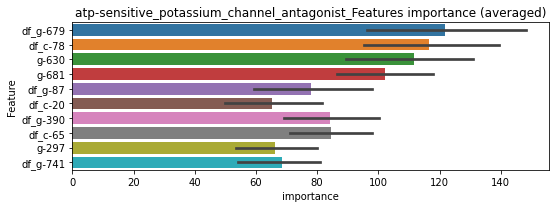

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143994	valid_1's binary_logloss: 0.0191521
[200]	training's binary_logloss: 0.00170804	valid_1's binary_logloss: 0.00381191
[300]	training's binary_logloss: 0.000514307	valid_1's binary_logloss: 0.00177621
[400]	training's binary_logloss: 0.000308751	valid_1's binary_logloss: 0.00133681
[500]	training's binary_logloss: 0.000241837	valid_1's binary_logloss: 0.00117146
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000225872	valid_1's binary_logloss: 0.00113724


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139752	valid_1's binary_logloss: 0.0215369
[200]	training's binary_logloss: 0.0017075	valid_1's binary_logloss: 0.00641398
[300]	training's binary_logloss: 0.000518928	valid_1's binary_logloss: 0.00393705
[400]	training's binary_logloss: 0.000301824	valid_1's binary_logloss: 0.0033656
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000311347	valid_1's binary_logloss: 0.00335611


atp-sensitive_potassium_channel_antagonist logloss: 0.002246532089347931


neg labels: 3289 → selected neg labels: 3286


atp_synthase_inhibitor, len(trt): 12, len(othr): 3286, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442231	valid_1's binary_logloss: 0.0596513
[200]	training's binary_logloss: 0.00721113	valid_1's binary_logloss: 0.0189395
[300]	training's binary_logloss: 0.00213738	valid_1's binary_logloss: 0.0109726
[400]	training's binary_logloss: 0.00112376	valid_1's binary_logloss: 0.00835469
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000951103	valid_1's binary_logloss: 0.00777591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451799	valid_1's binary_logloss: 0.0560185
[200]	training's binary_logloss: 0.00808123	valid_1's binary_logloss: 0.0170494
[300]	training's binary_logloss: 0.00230269	valid_1's binary_logloss: 0.00838101
[400]	training's binary_logloss: 0.0011893	valid_1's binary_logloss: 0.00568274
[500]	training's binary_logloss: 0.000883978	valid_1's binary_logloss: 0.00494489
[600]	training's binary_logloss: 0.0007

1 / 3 AUC score:1.000
y_Threshold: 0.0090041, Threshold: 0.1112866, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.10016, conf_1:0.12242
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.1112866
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_2: 0.1412866
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_3: 0.1712866
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_4: 0.2012866
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_5: 0.2312866
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_6: 0.2612866
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.2912866
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.3212866
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.3512866
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.3812866
threshold: 0.4112866, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327822	valid_1's binary_logloss: 0.0421335
[200]	training's binary_logloss: 0.00514115	valid_1's binary_logloss: 0.0104872
[300]	training's binary_logloss: 0.00161017	valid_1's binary_logloss: 0.0049844
[400]	training's binary_logloss: 0.000927232	valid_1's binary_logloss: 0.0036546
[500]	training's binary_logloss: 0.000706354	valid_1's binary_logloss: 0.00322283
[600]	training's binary_logloss: 0.000620597	valid_1's binary_logloss: 0.00305422
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.000605055	valid_1's binary_logloss: 0.00301904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337579	valid_1's binary_logloss: 0.0424834
[200]	training's binary_logloss: 0.00518464	valid_1's binary_logloss: 0.0104222
[300]	training's binary_logloss: 0.0016262	valid_1's binary_logloss: 0.00524596
[400]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.3486945, Threshold: 0.4112866, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0118031 Vs.target_rate: 0.00050, Num_p_label: 47.0, conf_0:0.37016, conf_1:0.45242
Num_p_label: 47.0, Expected: 2.0, Adj_threshold_1: 0.4112866
Num_p_label: 44.0, Expected: 2.0, Adj_threshold_2: 0.4412866
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_3: 0.4712866
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_4: 0.5012866


Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000614898	valid_1's binary_logloss: 0.00319218


Num_p_label: 32.0, Expected: 2.0, Adj_threshold_5: 0.5312866
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_6: 0.5612866
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_7: 0.5912866
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_8: 0.6212866
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_9: 0.6512866
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_10: 0.6812866
threshold: 0.7112866, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331829	valid_1's binary_logloss: 0.0469504
[200]	training's binary_logloss: 0.00507183	valid_1's binary_logloss: 0.0120718
[300]	training's binary_logloss: 0.00156399	valid_1's binary_logloss: 0.00547898
[400]	training's binary_logloss: 0.000899095	valid_1's binary_logloss: 0.00397043
[500]	training's binary_logloss: 0.000695294	valid_1's binary_logloss: 0.00350603
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00062941	valid_1's binary_logloss: 0.00336954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334909	valid_1's binary_logloss: 0.0407704
[200]	training's binary_logloss: 0.00539808	valid_1's binary_logloss: 0.00961874
[300]	training's binary_logloss: 0.00168174	valid_1's binary_logloss: 0.0041697
[400]	training's binary_logloss: 0.000944513	valid_1's binary_logloss: 0.00277688
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.5355125, Threshold: 0.7112866, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0052737 Vs.target_rate: 0.00050, Num_p_label: 21.0, conf_0:0.64016, conf_1:0.78242
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.7112866
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.7412866
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.7712866
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.8012866
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.8312866
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.8612866
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.8912866
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.9212866
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.9512866
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.9812866
threshold: 0.9812866, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/7787, y_label_rate: 0.0843714


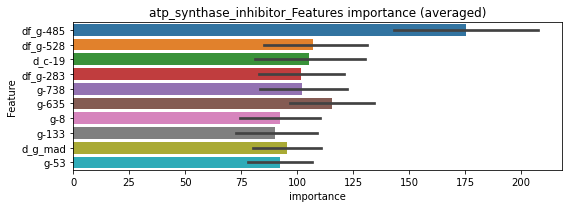

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229446	valid_1's binary_logloss: 0.0294549
[200]	training's binary_logloss: 0.00354395	valid_1's binary_logloss: 0.00826404
[300]	training's binary_logloss: 0.00101555	valid_1's binary_logloss: 0.00468526


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 atp_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.00056365	valid_1's binary_logloss: 0.00399567
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00055102	valid_1's binary_logloss: 0.00397265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023367	valid_1's binary_logloss: 0.0299821
[200]	training's binary_logloss: 0.00411153	valid_1's binary_logloss: 0.00974756
[300]	training's binary_logloss: 0.00113248	valid_1's binary_logloss: 0.00486079
[400]	training's binary_logloss: 0.000583912	valid_1's binary_logloss: 0.00346114


atp_synthase_inhibitor logloss: 0.0036056446549435975


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000473744	valid_1's binary_logloss: 0.00323854
neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16403	valid_1's binary_logloss: 0.268862
[200]	training's binary_logloss: 0.0745076	valid_1's binary_logloss: 0.204145
[300]	training's binary_logloss: 0.0337454	valid_1's binary_logloss: 0.175513
[400]	training's binary_logloss: 0.0166176	valid_1's binary_logloss: 0.162416
[500]	training's binary_logloss: 0.00858986	valid_1's binary_logloss: 0.154818
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00676254	valid_1's binary_logloss: 0.153176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159439	valid_1's binary_logloss: 0.254204
[200]	training's binary_logloss: 0.0748063	valid_1's binary_logloss: 0.193235
[300]	training's binary_logloss: 0.035052	valid_1's binary_logloss: 0.163137
[400]	training's binary_logloss: 0.0165862	valid_1's binary_logloss: 0.146401
[500]	training's binary_logloss: 0.00861035	valid_1's binary_logl

1 / 3 AUC score:0.971
y_Threshold: 0.0692377, Threshold: 0.2775064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 240 → Positive_corect_labels: 600/3687
p_label_rate: 0.0100452 Vs.target_rate: 0.00407, Num_p_label: 40.0, conf_0:0.24976, conf_1:0.30526
threshold: 0.2775064, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 600.0/3687, y_label_rate: 0.1627339
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14735	valid_1's binary_logloss: 0.228197
[200]	training's binary_logloss: 0.0559382	valid_1's binary_logloss: 0.154236
[300]	training's binary_logloss: 0.024576	valid_1's binary_logloss: 0.124505
[400]	training's binary_logloss: 0.0112506	valid_1's binary_logloss: 0.109794
[500]	training's binary_logloss: 0.00591401	valid_1's binary_logloss: 0.0993313
[600]	training's binary_logloss: 0.00366891	valid_1's binary_logloss: 0.0938583
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00365408	valid_1's binary_logloss: 0.0938424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138046	valid_1's binary_logloss: 0.230191
[200]	training's binary_logloss: 0.0568571	valid_1's binary_logloss: 0.157904
[300]	training's binary_logloss: 0.0234612	valid_1's binary_logloss: 0.122055
[400]	training's binary_logloss: 0.0109101	valid_1's binary_l

2 / 3 AUC score:0.991
y_Threshold: 0.1442298, Threshold: 0.2775064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 554.0/3595
p_label_rate: 0.0178302 Vs.target_rate: 0.00407, Num_p_label: 71.0, conf_0:0.24976, conf_1:0.30526
Num_p_label: 71.0, Expected: 16.2, Adj_threshold_1: 0.2775064
Num_p_label: 61.0, Expected: 16.2, Adj_threshold_2: 0.3075064
Num_p_label: 55.0, Expected: 16.2, Adj_threshold_3: 0.3375064
Num_p_label: 52.0, Expected: 16.2, Adj_threshold_4: 0.3675064
Num_p_label: 44.0, Expected: 16.2, Adj_threshold_5: 0.3975064
Num_p_label: 39.0, Expected: 16.2, Adj_threshold_6: 0.4275064
Num_p_label: 33.0, Expected: 16.2, Adj_threshold_7: 0.4575064
Num_p_label: 26.0, Expected: 16.2, Adj_threshold_8: 0.4875064
threshold: 0.4875064, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 554.0/3595, y_label_rate: 0.1541029
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13486	valid_1's binary_logloss: 0.212512
[200]	training's binary_logloss: 0.0522866	valid_1's binary_logloss: 0.141102
[300]	training's binary_logloss: 0.020391	valid_1's binary_logloss: 0.107647
[400]	training's binary_logloss: 0.00909655	valid_1's binary_logloss: 0.0918338
[500]	training's binary_logloss: 0.00487318	valid_1's binary_logloss: 0.0824688
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00339303	valid_1's binary_logloss: 0.0796353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125239	valid_1's binary_logloss: 0.209834
[200]	training's binary_logloss: 0.0468605	valid_1's binary_logloss: 0.143579
[300]	training's binary_logloss: 0.019699	valid_1's binary_logloss: 0.115139
[400]	training's binary_logloss: 0.00883827	valid_1's binary_logloss: 0.103794
[500]	training's binary_logloss: 0.00489624	valid_1's binary_

3 / 3 AUC score:0.987
y_Threshold: 0.1084463, Threshold: 0.4875064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 515.0/3517
p_label_rate: 0.0095429 Vs.target_rate: 0.00407, Num_p_label: 38.0, conf_0:0.43876, conf_1:0.53626
threshold: 0.4875064, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 553.0/7499, y_label_rate: 0.0737432


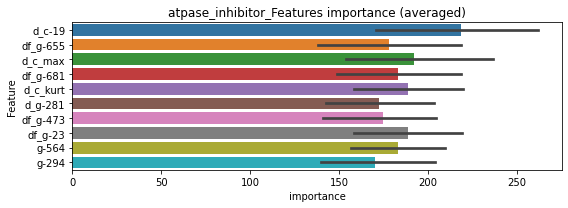

len(train_index) : 3749
len(valid_index) : 3750
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726436	valid_1's binary_logloss: 0.125905
[200]	training's binary_logloss: 0.0263418	valid_1's binary_logloss: 0.0882792
[300]	training's binary_logloss: 0.0108129	valid_1's binary_logloss: 0.0727937
[400]	training's binary_logloss: 0.0050309	valid_1's binary_logloss: 0.0691139
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00291138	valid_1's binary_logloss: 0.066865


len(train_index) : 3750
len(valid_index) : 3749
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725086	valid_1's binary_logloss: 0.131607
[200]	training's binary_logloss: 0.0286326	valid_1's binary_logloss: 0.091966
[300]	training's binary_logloss: 0.011432	valid_1's binary_logloss: 0.074751
[400]	training's binary_logloss: 0.00511429	valid_1's binary_logloss: 0.0663066
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00332532	valid_1's binary_logloss: 0.0624152


atpase_inhibitor logloss: 0.06464036695494665


neg labels: 3289 → selected neg labels: 3287


atr_kinase_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060077	valid_1's binary_logloss: 0.0897706
[200]	training's binary_logloss: 0.0150749	valid_1's binary_logloss: 0.0370591
[300]	training's binary_logloss: 0.0045276	valid_1's binary_logloss: 0.0207735
[400]	training's binary_logloss: 0.00211557	valid_1's binary_logloss: 0.0161074
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00146182	valid_1's binary_logloss: 0.0146126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600925	valid_1's binary_logloss: 0.0897876
[200]	training's binary_logloss: 0.0156263	valid_1's binary_logloss: 0.0348118
[300]	training's binary_logloss: 0.00483769	valid_1's binary_logloss: 0.0175136
[400]	training's binary_logloss: 0.00222238	valid_1's binary_logloss: 0.012311
[500]	training's binary_logloss: 0.0014811	valid_1's binary_logloss: 0.0103259
Early stopping, best iteration is:
[585]	training's

1 / 3 AUC score:1.000
y_Threshold: 0.0220346, Threshold: 0.1544290, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.13899, conf_1:0.16987
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.1544290
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.1844290
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_3: 0.2144290
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_4: 0.2444290
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.2744290
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_6: 0.3044290
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.3344290
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.3644290
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.3944290
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.4244290
threshold: 0.4244290, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543962	valid_1's binary_logloss: 0.0827234
[200]	training's binary_logloss: 0.0111068	valid_1's binary_logloss: 0.0291314
[300]	training's binary_logloss: 0.00353662	valid_1's binary_logloss: 0.017617
[400]	training's binary_logloss: 0.00178013	valid_1's binary_logloss: 0.0130527
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00178013	valid_1's binary_logloss: 0.0130527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540151	valid_1's binary_logloss: 0.0836156
[200]	training's binary_logloss: 0.0115506	valid_1's binary_logloss: 0.0296207
[300]	training's binary_logloss: 0.0037312	valid_1's binary_logloss: 0.0151092
[400]	training's binary_logloss: 0.00181173	valid_1's binary_logloss: 0.0100603
[500]	training's binary_logloss: 0.00124248	valid_1's binary_logloss: 0.00858029


2 / 3 AUC score:1.000
y_Threshold: 0.1628991, Threshold: 0.4244290, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00116478	valid_1's binary_logloss: 0.00833788


Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0067805 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.38199, conf_1:0.46687
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.4244290
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.4544290
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.4844290
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.5144290
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_5: 0.5444290
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_6: 0.5744290
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.6044290
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.6344290
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.6644290
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.6944290
threshold: 0.6944290, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548317	valid_1's binary_logloss: 0.0782834
[200]	training's binary_logloss: 0.0117429	valid_1's binary_logloss: 0.0246735
[300]	training's binary_logloss: 0.00364809	valid_1's binary_logloss: 0.0118434
[400]	training's binary_logloss: 0.00183157	valid_1's binary_logloss: 0.00802125
[500]	training's binary_logloss: 0.00126474	valid_1's binary_logloss: 0.00683552
[600]	training's binary_logloss: 0.00103296	valid_1's binary_logloss: 0.0062425
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00104095	valid_1's binary_logloss: 0.00622987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525853	valid_1's binary_logloss: 0.0769163
[200]	training's binary_logloss: 0.0111305	valid_1's binary_logloss: 0.0262008
[300]	training's binary_logloss: 0.00351979	valid_1's binary_logloss: 0.0133662
[400]	training's binary_logloss: 0.00180797	

3 / 3 AUC score:1.000
y_Threshold: 0.2469719, Threshold: 0.6944290, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0010045 Vs.target_rate: 0.00080, Num_p_label: 4.0, conf_0:0.62499, conf_1:0.76387
threshold: 0.6944290, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/7786, y_label_rate: 0.0843822


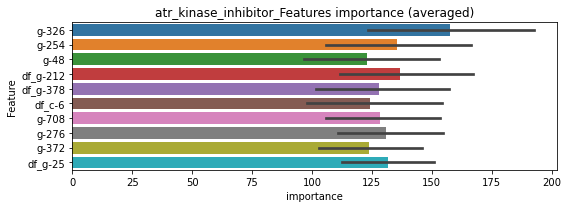

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323146	valid_1's binary_logloss: 0.051152
[200]	training's binary_logloss: 0.00755338	valid_1's binary_logloss: 0.0197594
[300]	training's binary_logloss: 0.0022689	valid_1's binary_logloss: 0.00960596
[400]	training's binary_logloss: 0.00106526	valid_1's binary_logloss: 0.00617231
[500]	training's binary_logloss: 0.000723406	valid_1's binary_logloss: 0.00501406
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000611592	valid_1's binary_logloss: 0.00455811


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304653	valid_1's binary_logloss: 0.0478696
[200]	training's binary_logloss: 0.00677995	valid_1's binary_logloss: 0.0197544
[300]	training's binary_logloss: 0.00212894	valid_1's binary_logloss: 0.0112384
[400]	training's binary_logloss: 0.00103476	valid_1's binary_logloss: 0.00873662
[500]	training's binary_logloss: 0.000708423	valid_1's binary_logloss: 0.00799638
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000654458	valid_1's binary_logloss: 0.00787742


atr_kinase_inhibitor logloss: 0.006217761479541276


neg labels: 3289 → selected neg labels: 3271


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3271, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168916	valid_1's binary_logloss: 0.27004
[200]	training's binary_logloss: 0.0808893	valid_1's binary_logloss: 0.214734
[300]	training's binary_logloss: 0.0377114	valid_1's binary_logloss: 0.185034
[400]	training's binary_logloss: 0.018691	valid_1's binary_logloss: 0.1697
[500]	training's binary_logloss: 0.00917811	valid_1's binary_logloss: 0.160514
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00862918	valid_1's binary_logloss: 0.159538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168637	valid_1's binary_logloss: 0.257554
[200]	training's binary_logloss: 0.0765671	valid_1's binary_logloss: 0.184375
[300]	training's binary_logloss: 0.0349009	valid_1's binary_logloss: 0.147821
[400]	training's binary_logloss: 0.0168268	valid_1's binary_logloss: 0.133223
[500]	training's binary_logloss: 0.00893412	valid_1's binary_loglos

1 / 3 AUC score:0.973
y_Threshold: 0.0973882, Threshold: 0.4751594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 281 → Positive_corect_labels: 579/3644
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.42764, conf_1:0.52268
threshold: 0.4751594, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 579.0/3644, y_label_rate: 0.1588913
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135138	valid_1's binary_logloss: 0.220964
[200]	training's binary_logloss: 0.056905	valid_1's binary_logloss: 0.158642
[300]	training's binary_logloss: 0.0236689	valid_1's binary_logloss: 0.129695
[400]	training's binary_logloss: 0.0107656	valid_1's binary_logloss: 0.114931
[500]	training's binary_logloss: 0.00568831	valid_1's binary_logloss: 0.106051
[600]	training's binary_logloss: 0.00363801	valid_1's binary_logloss: 0.103223
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0034495	valid_1's binary_logloss: 0.102644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133287	valid_1's binary_logloss: 0.207296
[200]	training's binary_logloss: 0.0529994	valid_1's binary_logloss: 0.136284
[300]	training's binary_logloss: 0.0223121	valid_1's binary_logloss: 0.107038
[400]	training's binary_logloss: 0.0103714	valid_1's binary_logl

2 / 3 AUC score:0.984
y_Threshold: 0.1820981, Threshold: 0.4751594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 531.0/3548
p_label_rate: 0.0233551 Vs.target_rate: 0.00403, Num_p_label: 93.0, conf_0:0.42764, conf_1:0.52268
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_1: 0.4751594
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_2: 0.5051594
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_3: 0.5351594
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_4: 0.5651594
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_5: 0.5951594
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_6: 0.6251594
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_7: 0.6551594
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_8: 0.6851594
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_9: 0.7151594
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_10: 0.7451594
threshold: 0.7751594, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 531.0/3548, y_label_rate: 0.14966

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112171	valid_1's binary_logloss: 0.183741
[200]	training's binary_logloss: 0.0416901	valid_1's binary_logloss: 0.117058
[300]	training's binary_logloss: 0.0165237	valid_1's binary_logloss: 0.0891718
[400]	training's binary_logloss: 0.0077651	valid_1's binary_logloss: 0.077331
[500]	training's binary_logloss: 0.00429237	valid_1's binary_logloss: 0.0702524
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00336955	valid_1's binary_logloss: 0.0684014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121731	valid_1's binary_logloss: 0.197945
[200]	training's binary_logloss: 0.0442266	valid_1's binary_logloss: 0.129399
[300]	training's binary_logloss: 0.0176131	valid_1's binary_logloss: 0.0979206
[400]	training's binary_logloss: 0.00813191	valid_1's binary_logloss: 0.0826992
[500]	training's binary_logloss: 0.00456555	valid_1's bin

3 / 3 AUC score:0.992
y_Threshold: 0.1699342, Threshold: 0.7751594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 498.0/3482
p_label_rate: 0.0087896 Vs.target_rate: 0.00403, Num_p_label: 35.0, conf_0:0.69764, conf_1:0.85268
threshold: 0.7751594, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 533.0/7464, y_label_rate: 0.0714094


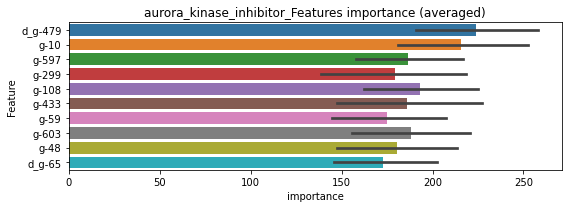

len(train_index) : 3732
len(valid_index) : 3732
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684886	valid_1's binary_logloss: 0.11817
[200]	training's binary_logloss: 0.0252726	valid_1's binary_logloss: 0.0821294
[300]	training's binary_logloss: 0.00947514	valid_1's binary_logloss: 0.0680688
[400]	training's binary_logloss: 0.00406675	valid_1's binary_logloss: 0.0630409
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0030542	valid_1's binary_logloss: 0.0621255


len(train_index) : 3732
len(valid_index) : 3732
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741236	valid_1's binary_logloss: 0.121623
[200]	training's binary_logloss: 0.0269988	valid_1's binary_logloss: 0.0847593
[300]	training's binary_logloss: 0.010232	valid_1's binary_logloss: 0.0716802


aurora_kinase_inhibitor logloss: 0.06520544855546188


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00526626	valid_1's binary_logloss: 0.0682854
neg labels: 3289 → selected neg labels: 3287


autotaxin_inhibitor, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228203	valid_1's binary_logloss: 0.033644
[200]	training's binary_logloss: 0.00270925	valid_1's binary_logloss: 0.00741297
[300]	training's binary_logloss: 0.000855339	valid_1's binary_logloss: 0.00331229
[400]	training's binary_logloss: 0.000522112	valid_1's binary_logloss: 0.00234271
[500]	training's binary_logloss: 0.00042312	valid_1's binary_logloss: 0.00195232
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000416754	valid_1's binary_logloss: 0.00194555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024351	valid_1's binary_logloss: 0.0299978
[200]	training's binary_logloss: 0.00306489	valid_1's binary_logloss: 0.00606032
[300]	training's binary_logloss: 0.000912928	valid_1's binary_logloss: 0.00279513
[400]	training's binary_logloss: 0.000542365	valid_1's binary_logloss: 0.00196834
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0023492, Threshold: 0.0436156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.03925, conf_1:0.04798
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0436156
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_2: 0.0736156
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.1036156
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_4: 0.1336156
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_5: 0.1636156
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.1936156
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.2236156
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.2536156
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.2836156
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.3136156
threshold: 0.3436156, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215967	valid_1's binary_logloss: 0.0285615
[200]	training's binary_logloss: 0.0024237	valid_1's binary_logloss: 0.00509086
[300]	training's binary_logloss: 0.000742811	valid_1's binary_logloss: 0.00193345
[400]	training's binary_logloss: 0.000450588	valid_1's binary_logloss: 0.00138925
[500]	training's binary_logloss: 0.000372908	valid_1's binary_logloss: 0.00126138
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000366042	valid_1's binary_logloss: 0.00124292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214524	valid_1's binary_logloss: 0.0321634
[200]	training's binary_logloss: 0.00243829	valid_1's binary_logloss: 0.0117253
[300]	training's binary_logloss: 0.000766795	valid_1's binary_logloss: 0.00890417


2 / 3 AUC score:1.000
y_Threshold: 0.0648859, Threshold: 0.3436156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0052737 Vs.target_rate: 0.00025, Num_p_label: 21.0, conf_0:0.30925, conf_1:0.37798
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_1: 0.3436156
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_2: 0.3736156
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_3: 0.4036156
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_4: 0.4336156
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.4636156
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.4936156
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.5236156
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.5536156
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.5836156
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.6136156
threshold: 0.6436156, positive_p_label: 8.0/3982, p_label_rate: 0.0020090


[400]	training's binary_logloss: 0.000459952	valid_1's binary_logloss: 0.0081292
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000476778	valid_1's binary_logloss: 0.00806523


positive_y_label: 653.0/3804, y_label_rate: 0.1716614
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020781	valid_1's binary_logloss: 0.0308711
[200]	training's binary_logloss: 0.00229511	valid_1's binary_logloss: 0.00851569
[300]	training's binary_logloss: 0.000732752	valid_1's binary_logloss: 0.00432988
[400]	training's binary_logloss: 0.000443058	valid_1's binary_logloss: 0.00320312
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000454765	valid_1's binary_logloss: 0.00319926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215237	valid_1's binary_logloss: 0.0245534
[200]	training's binary_logloss: 0.00245781	valid_1's binary_logloss: 0.00358008
[300]	training's binary_logloss: 0.000761088	valid_1's binary_logloss: 0.00123885
[400]	training's binary_logloss: 0.00045301	valid_1's binary_logloss: 0.000798846
[500]	training's binary_logloss: 0.000370253	valid_1's binary_logloss: 0.000692344
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.2944193, Threshold: 0.6436156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.57925, conf_1:0.70798
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.6436156
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.6736156
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.7036156
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.7336156
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.7636156
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.7936156
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.8236156
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.8536156
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.8836156
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.9136156
threshold: 0.9436156, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/7786, y_label_rate: 0.0842538


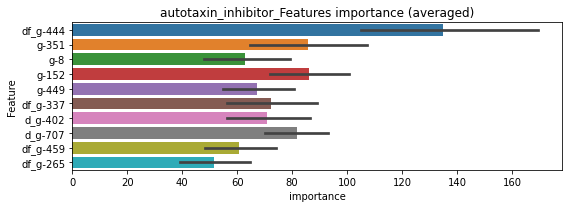

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122004	valid_1's binary_logloss: 0.0165233
[200]	training's binary_logloss: 0.00139871	valid_1's binary_logloss: 0.00297282
[300]	training's binary_logloss: 0.000449657	valid_1's binary_logloss: 0.00169828


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 autotaxin_inhibitor=================================


[400]	training's binary_logloss: 0.000271637	valid_1's binary_logloss: 0.00132794
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000262583	valid_1's binary_logloss: 0.00129555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122262	valid_1's binary_logloss: 0.0212252
[200]	training's binary_logloss: 0.00136573	valid_1's binary_logloss: 0.00635629


autotaxin_inhibitor logloss: 0.002258329874946477


[300]	training's binary_logloss: 0.000431411	valid_1's binary_logloss: 0.00324026
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000464903	valid_1's binary_logloss: 0.00322111
neg labels: 3289 → selected neg labels: 3277


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3277, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126614	valid_1's binary_logloss: 0.184422
[200]	training's binary_logloss: 0.0484047	valid_1's binary_logloss: 0.110212
[300]	training's binary_logloss: 0.0193024	valid_1's binary_logloss: 0.0734194
[400]	training's binary_logloss: 0.0083532	valid_1's binary_logloss: 0.0557934
[500]	training's binary_logloss: 0.00431282	valid_1's binary_logloss: 0.0467584
[600]	training's binary_logloss: 0.00276067	valid_1's binary_logloss: 0.0428688
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00257234	valid_1's binary_logloss: 0.0425052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118345	valid_1's binary_logloss: 0.179482
[200]	training's binary_logloss: 0.0444419	valid_1's binary_logloss: 0.106655
[300]	training's binary_logloss: 0.0170654	valid_1's binary_logloss: 0.0729069
[400]	training's binary_logloss: 0.00765244	valid_1's bi

1 / 3 AUC score:0.997
y_Threshold: 0.0454629, Threshold: 0.2465725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 641/3772
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.22192, conf_1:0.27123
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.2465725
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_2: 0.2765725
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_3: 0.3065725
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.3365725
threshold: 0.3365725, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3772, y_label_rate: 0.1699364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108063	valid_1's binary_logloss: 0.161485
[200]	training's binary_logloss: 0.0375039	valid_1's binary_logloss: 0.0883628
[300]	training's binary_logloss: 0.014459	valid_1's binary_logloss: 0.0577825
[400]	training's binary_logloss: 0.00668011	valid_1's binary_logloss: 0.0426446
[500]	training's binary_logloss: 0.00362447	valid_1's binary_logloss: 0.0357018
[600]	training's binary_logloss: 0.00233752	valid_1's binary_logloss: 0.0315822
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00233752	valid_1's binary_logloss: 0.0315822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108399	valid_1's binary_logloss: 0.160946
[200]	training's binary_logloss: 0.0371781	valid_1's binary_logloss: 0.0855114
[300]	training's binary_logloss: 0.0145488	valid_1's binary_logloss: 0.0550435
[400]	training's binary_logloss: 0.00633931	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.1865653, Threshold: 0.3365725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 627.0/3744
p_label_rate: 0.0153189 Vs.target_rate: 0.00252, Num_p_label: 61.0, conf_0:0.30292, conf_1:0.37023
Num_p_label: 61.0, Expected: 10.0, Adj_threshold_1: 0.3365725
Num_p_label: 55.0, Expected: 10.0, Adj_threshold_2: 0.3665725
Num_p_label: 50.0, Expected: 10.0, Adj_threshold_3: 0.3965725
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_4: 0.4265725
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_5: 0.4565725
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_6: 0.4865725
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_7: 0.5165725
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_8: 0.5465725
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_9: 0.5765725
threshold: 0.5765725, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 627.0/3744, y_label_rate: 0.1674679
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971898	valid_1's binary_logloss: 0.151703
[200]	training's binary_logloss: 0.0339515	valid_1's binary_logloss: 0.0862973
[300]	training's binary_logloss: 0.0125204	valid_1's binary_logloss: 0.0562889
[400]	training's binary_logloss: 0.00545595	valid_1's binary_logloss: 0.0425769
[500]	training's binary_logloss: 0.00307679	valid_1's binary_logloss: 0.0363838
[600]	training's binary_logloss: 0.00208964	valid_1's binary_logloss: 0.033117
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00203355	valid_1's binary_logloss: 0.032938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108789	valid_1's binary_logloss: 0.160439
[200]	training's binary_logloss: 0.0367951	valid_1's binary_logloss: 0.0828765
[300]	training's binary_logloss: 0.0139864	valid_1's binary_logloss: 0.05233
[400]	training's binary_logloss: 0.00619788	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.1982232, Threshold: 0.5765725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 620.0/3730
p_label_rate: 0.0072828 Vs.target_rate: 0.00252, Num_p_label: 29.0, conf_0:0.51892, conf_1:0.63423
threshold: 0.5765725, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 649.0/7712, y_label_rate: 0.0841546


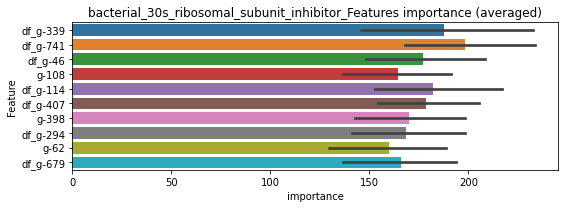

len(train_index) : 3856
len(valid_index) : 3856
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685853	valid_1's binary_logloss: 0.109724
[200]	training's binary_logloss: 0.0217424	valid_1's binary_logloss: 0.0646503
[300]	training's binary_logloss: 0.00860421	valid_1's binary_logloss: 0.0492357
[400]	training's binary_logloss: 0.00390231	valid_1's binary_logloss: 0.042677
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00222769	valid_1's binary_logloss: 0.0406606


len(train_index) : 3856
len(valid_index) : 3856
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652935	valid_1's binary_logloss: 0.0998819
[200]	training's binary_logloss: 0.0228802	valid_1's binary_logloss: 0.0565808
[300]	training's binary_logloss: 0.00860778	valid_1's binary_logloss: 0.0380147
[400]	training's binary_logloss: 0.00362074	valid_1's binary_logloss: 0.0300466
[500]	training's binary_logloss: 0.00193282	valid_1's binary_logloss: 0.0264574
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00149636	valid_1's binary_logloss: 0.0256248


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03314270030797294


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12361	valid_1's binary_logloss: 0.210309
[200]	training's binary_logloss: 0.0531932	valid_1's binary_logloss: 0.158719
[300]	training's binary_logloss: 0.0249684	valid_1's binary_logloss: 0.140796
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0172189	valid_1's binary_logloss: 0.134445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123293	valid_1's binary_logloss: 0.201106
[200]	training's binary_logloss: 0.0519321	valid_1's binary_logloss: 0.147133
[300]	training's binary_logloss: 0.0236914	valid_1's binary_logloss: 0.123568
[400]	training's binary_logloss: 0.010978	valid_1's binary_logloss: 0.11237
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00796223	valid_1's binary_logloss: 0.110256


1 / 3 AUC score:0.973
y_Threshold: 0.0796798, Threshold: 0.2516495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 606/3702
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.22648, conf_1:0.27681
threshold: 0.2516495, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 606.0/3702, y_label_rate: 0.1636953
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985957	valid_1's binary_logloss: 0.167004
[200]	training's binary_logloss: 0.0370655	valid_1's binary_logloss: 0.109699
[300]	training's binary_logloss: 0.0150278	valid_1's binary_logloss: 0.0847409
[400]	training's binary_logloss: 0.00690552	valid_1's binary_logloss: 0.0738842
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0060329	valid_1's binary_logloss: 0.0724522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105905	valid_1's binary_logloss: 0.16796
[200]	training's binary_logloss: 0.040487	valid_1's binary_logloss: 0.107577
[300]	training's binary_logloss: 0.0156377	valid_1's binary_logloss: 0.080796
[400]	training's binary_logloss: 0.00749879	valid_1's binary_logloss: 0.0698749
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00593151	valid_1's binary_logloss: 0.0669303


2 / 3 AUC score:0.994
y_Threshold: 0.1528035, Threshold: 0.2516495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 569.0/3628
p_label_rate: 0.0168257 Vs.target_rate: 0.00336, Num_p_label: 67.0, conf_0:0.22648, conf_1:0.27681
Num_p_label: 67.0, Expected: 13.4, Adj_threshold_1: 0.2516495
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_2: 0.2816495
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_3: 0.3116495
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_4: 0.3416495
Num_p_label: 33.0, Expected: 13.4, Adj_threshold_5: 0.3716495
Num_p_label: 29.0, Expected: 13.4, Adj_threshold_6: 0.4016495
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_7: 0.4316495
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_8: 0.4616495
threshold: 0.4616495, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 569.0/3628, y_label_rate: 0.1568357
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921617	valid_1's binary_logloss: 0.147746
[200]	training's binary_logloss: 0.0317243	valid_1's binary_logloss: 0.0851401
[300]	training's binary_logloss: 0.0129719	valid_1's binary_logloss: 0.0593026
[400]	training's binary_logloss: 0.00593524	valid_1's binary_logloss: 0.0478317
[500]	training's binary_logloss: 0.0033947	valid_1's binary_logloss: 0.0427614
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00287686	valid_1's binary_logloss: 0.0417405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918314	valid_1's binary_logloss: 0.153258
[200]	training's binary_logloss: 0.0328555	valid_1's binary_logloss: 0.0964878
[300]	training's binary_logloss: 0.0129471	valid_1's binary_logloss: 0.074287
[400]	training's binary_logloss: 0.00606762	valid_1's binary_logloss: 0.0629853
[500]	training's binary_logloss: 0.00349596	valid_1's

3 / 3 AUC score:0.997
y_Threshold: 0.1566935, Threshold: 0.4616495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 544.0/3578
p_label_rate: 0.0065294 Vs.target_rate: 0.00336, Num_p_label: 26.0, conf_0:0.41548, conf_1:0.50781
threshold: 0.4616495, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 570.0/7560, y_label_rate: 0.0753968


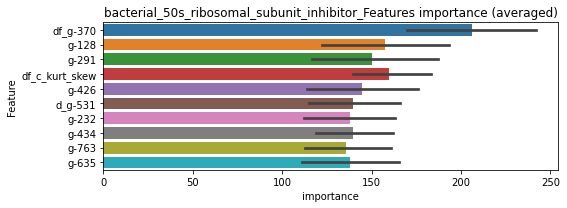

len(train_index) : 3780
len(valid_index) : 3780
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528304	valid_1's binary_logloss: 0.0947878
[200]	training's binary_logloss: 0.0166887	valid_1's binary_logloss: 0.0640457


len(train_index) : 3780
len(valid_index) : 3780
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


[300]	training's binary_logloss: 0.00645584	valid_1's binary_logloss: 0.052482
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00660878	valid_1's binary_logloss: 0.0523793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502896	valid_1's binary_logloss: 0.0929825
[200]	training's binary_logloss: 0.0167824	valid_1's binary_logloss: 0.0591257
[300]	training's binary_logloss: 0.00659315	valid_1's binary_logloss: 0.0474993
[400]	training's binary_logloss: 0.00299422	valid_1's binary_logloss: 0.0420519
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00197565	valid_1's binary_logloss: 0.0400207


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.046200026314411974


neg labels: 3289 → selected neg labels: 3286


bacterial_antifolate, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809447	valid_1's binary_logloss: 0.129615
[200]	training's binary_logloss: 0.0231697	valid_1's binary_logloss: 0.0702774
[300]	training's binary_logloss: 0.008032	valid_1's binary_logloss: 0.0474741
[400]	training's binary_logloss: 0.00374405	valid_1's binary_logloss: 0.0391625
[500]	training's binary_logloss: 0.00228137	valid_1's binary_logloss: 0.0354084
[600]	training's binary_logloss: 0.00166834	valid_1's binary_logloss: 0.0335582
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00161001	valid_1's binary_logloss: 0.033299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866195	valid_1's binary_logloss: 0.126846
[200]	training's binary_logloss: 0.0266994	valid_1's binary_logloss: 0.062804
[300]	training's binary_logloss: 0.00915665	valid_1's binary_logloss: 0.0373648
[400]	training's binary_logloss: 0.00402543	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0334838, Threshold: 0.2685161, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.24166, conf_1:0.29537
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.2685161
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_2: 0.2985161
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.3285161
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_4: 0.3585161
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.3885161
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_6: 0.4185161
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.4485161
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_8: 0.4785161
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_9: 0.5085161
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_10: 0.5385161
threshold: 0.5685161, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744745	valid_1's binary_logloss: 0.121446
[200]	training's binary_logloss: 0.0198077	valid_1's binary_logloss: 0.0617341
[300]	training's binary_logloss: 0.00656633	valid_1's binary_logloss: 0.0431146
[400]	training's binary_logloss: 0.00302918	valid_1's binary_logloss: 0.0350973
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0021475	valid_1's binary_logloss: 0.0329156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817416	valid_1's binary_logloss: 0.119247
[200]	training's binary_logloss: 0.0216128	valid_1's binary_logloss: 0.0489502
[300]	training's binary_logloss: 0.00723664	valid_1's binary_logloss: 0.0269034
[400]	training's binary_logloss: 0.00333503	valid_1's binary_logloss: 0.0189837
[500]	training's binary_logloss: 0.00201986	valid_1's binary_logloss: 0.0161184
Early stopping, best iteration is:
[565]	training'

2 / 3 AUC score:1.000
y_Threshold: 0.1836591, Threshold: 0.5685161, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 647.0/3791
p_label_rate: 0.0123054 Vs.target_rate: 0.00151, Num_p_label: 49.0, conf_0:0.51166, conf_1:0.62537
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_1: 0.5685161
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.5985161
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.6285161
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_4: 0.6585161
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_5: 0.6885161
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_6: 0.7185161
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_7: 0.7485161
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_8: 0.7785161
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_9: 0.8085161
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_10: 0.8385161
threshold: 0.8685161, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 647.0/3791, y_label_rate: 0.1706674
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742277	valid_1's binary_logloss: 0.108556
[200]	training's binary_logloss: 0.0195144	valid_1's binary_logloss: 0.0466091
[300]	training's binary_logloss: 0.0064683	valid_1's binary_logloss: 0.0268739
[400]	training's binary_logloss: 0.00300391	valid_1's binary_logloss: 0.0199037
[500]	training's binary_logloss: 0.00188193	valid_1's binary_logloss: 0.0170729
[600]	training's binary_logloss: 0.00142411	valid_1's binary_logloss: 0.0158822
[700]	training's binary_logloss: 0.00120197	valid_1's binary_logloss: 0.0153516
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00118428	valid_1's binary_logloss: 0.0152856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070555	valid_1's binary_logloss: 0.115119
[200]	training's binary_logloss: 0.0178469	valid_1's binary_logloss: 0.0582275
[300]	training's binary_logloss: 0.00603655	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1600920, Threshold: 0.8685161, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 637.0/3771
p_label_rate: 0.0067805 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.78166, conf_1:0.95537
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.8685161
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.8985161
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.9285161
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.9585161
threshold: 0.9585161, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 648.0/7753, y_label_rate: 0.0835805


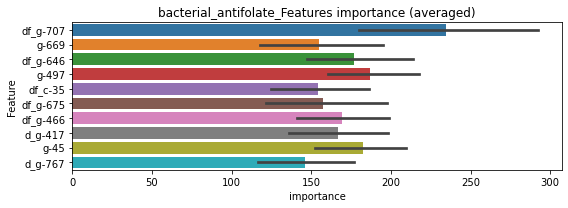

len(train_index) : 3876
len(valid_index) : 3877
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459091	valid_1's binary_logloss: 0.0749139
[200]	training's binary_logloss: 0.0122464	valid_1's binary_logloss: 0.0389379
[300]	training's binary_logloss: 0.00420027	valid_1's binary_logloss: 0.0281196
[400]	training's binary_logloss: 0.00186206	valid_1's binary_logloss: 0.0227261
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00119231	valid_1's binary_logloss: 0.0209637


len(train_index) : 3877
len(valid_index) : 3876
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438881	valid_1's binary_logloss: 0.0699854
[200]	training's binary_logloss: 0.0126577	valid_1's binary_logloss: 0.0332584
[300]	training's binary_logloss: 0.00458344	valid_1's binary_logloss: 0.0221611
[400]	training's binary_logloss: 0.0020072	valid_1's binary_logloss: 0.0173652
[500]	training's binary_logloss: 0.00122409	valid_1's binary_logloss: 0.0152801
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00108004	valid_1's binary_logloss: 0.0150667


bacterial_antifolate logloss: 0.018015573985149726


neg labels: 3289 → selected neg labels: 3268


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3268, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166748	valid_1's binary_logloss: 0.304339
[200]	training's binary_logloss: 0.0881495	valid_1's binary_logloss: 0.271225
[300]	training's binary_logloss: 0.0462328	valid_1's binary_logloss: 0.259982
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0384044	valid_1's binary_logloss: 0.257625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183967	valid_1's binary_logloss: 0.294337
[200]	training's binary_logloss: 0.0987305	valid_1's binary_logloss: 0.244697
[300]	training's binary_logloss: 0.0553731	valid_1's binary_logloss: 0.226027
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0446224	valid_1's binary_logloss: 0.222322


1 / 3 AUC score:0.915
y_Threshold: 0.1334977, Threshold: 0.3916907, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 420 → Positive_corect_labels: 509/3501
p_label_rate: 0.0100452 Vs.target_rate: 0.00806, Num_p_label: 40.0, conf_0:0.35252, conf_1:0.43086
threshold: 0.3916907, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 509.0/3501, y_label_rate: 0.1453870
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117936	valid_1's binary_logloss: 0.227325
[200]	training's binary_logloss: 0.0483365	valid_1's binary_logloss: 0.182157
[300]	training's binary_logloss: 0.0231778	valid_1's binary_logloss: 0.165739
[400]	training's binary_logloss: 0.0114989	valid_1's binary_logloss: 0.157599
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00831946	valid_1's binary_logloss: 0.154142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126998	valid_1's binary_logloss: 0.230637
[200]	training's binary_logloss: 0.0533417	valid_1's binary_logloss: 0.175883
[300]	training's binary_logloss: 0.0253393	valid_1's binary_logloss: 0.154951
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0158826	valid_1's binary_logloss: 0.146155


2 / 3 AUC score:0.967
y_Threshold: 0.1317688, Threshold: 0.3916907, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 430.0/3343
p_label_rate: 0.0203415 Vs.target_rate: 0.00806, Num_p_label: 81.0, conf_0:0.35252, conf_1:0.43086
threshold: 0.3916907, positive_p_label: 81.0/3982, p_label_rate: 0.0203415
positive_y_label: 430.0/3343, y_label_rate: 0.1286270
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984611	valid_1's binary_logloss: 0.171558
[200]	training's binary_logloss: 0.0375724	valid_1's binary_logloss: 0.125776
[300]	training's binary_logloss: 0.0158738	valid_1's binary_logloss: 0.109867
[400]	training's binary_logloss: 0.00772771	valid_1's binary_logloss: 0.102374
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0075756	valid_1's binary_logloss: 0.10218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958618	valid_1's binary_logloss: 0.186561
[200]	training's binary_logloss: 0.037273	valid_1's binary_logloss: 0.138392
[300]	training's binary_logloss: 0.015815	valid_1's binary_logloss: 0.117969
[400]	training's binary_logloss: 0.00776216	valid_1's binary_logloss: 0.107821
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00652343	valid_1's binary_logloss: 0.105382


3 / 3 AUC score:0.985
y_Threshold: 0.1131309, Threshold: 0.3916907, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 384.0/3251
p_label_rate: 0.0271220 Vs.target_rate: 0.00806, Num_p_label: 108.0, conf_0:0.35252, conf_1:0.43086
Num_p_label: 108.0, Expected: 32.1, Adj_threshold_1: 0.3916907
Num_p_label: 97.0, Expected: 32.1, Adj_threshold_2: 0.4216907
Num_p_label: 85.0, Expected: 32.1, Adj_threshold_3: 0.4516907
Num_p_label: 81.0, Expected: 32.1, Adj_threshold_4: 0.4816907
Num_p_label: 78.0, Expected: 32.1, Adj_threshold_5: 0.5116907
Num_p_label: 71.0, Expected: 32.1, Adj_threshold_6: 0.5416907
Num_p_label: 66.0, Expected: 32.1, Adj_threshold_7: 0.5716907
Num_p_label: 64.0, Expected: 32.1, Adj_threshold_8: 0.6016907
threshold: 0.6016907, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 448.0/7233, y_label_rate: 0.0619383


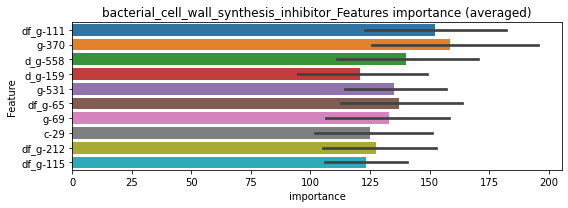

len(train_index) : 3616
len(valid_index) : 3617
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518013	valid_1's binary_logloss: 0.111305
[200]	training's binary_logloss: 0.0194855	valid_1's binary_logloss: 0.089649
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0146914	valid_1's binary_logloss: 0.0867709


len(train_index) : 3617
len(valid_index) : 3616
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545669	valid_1's binary_logloss: 0.104054
[200]	training's binary_logloss: 0.0201904	valid_1's binary_logloss: 0.0802424
[300]	training's binary_logloss: 0.00861264	valid_1's binary_logloss: 0.0723589


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07850838470253063


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00599955	valid_1's binary_logloss: 0.0702436
neg labels: 3289 → selected neg labels: 3279


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3279, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128158	valid_1's binary_logloss: 0.187199
[200]	training's binary_logloss: 0.0548578	valid_1's binary_logloss: 0.132582
[300]	training's binary_logloss: 0.024624	valid_1's binary_logloss: 0.107662
[400]	training's binary_logloss: 0.0115831	valid_1's binary_logloss: 0.0928305
[500]	training's binary_logloss: 0.00598996	valid_1's binary_logloss: 0.0866364
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00399716	valid_1's binary_logloss: 0.0829961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1255	valid_1's binary_logloss: 0.187556
[200]	training's binary_logloss: 0.0478219	valid_1's binary_logloss: 0.126994
[300]	training's binary_logloss: 0.0199411	valid_1's binary_logloss: 0.104469
[400]	training's binary_logloss: 0.0090756	valid_1's binary_logloss: 0.0952633
Early stopping, best iteration is:
[459]	training's binary_log

1 / 3 AUC score:0.986
y_Threshold: 0.0567480, Threshold: 0.2258584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 623/3738
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.20327, conf_1:0.24844
threshold: 0.2258584, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 623.0/3738, y_label_rate: 0.1666667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110176	valid_1's binary_logloss: 0.18028
[200]	training's binary_logloss: 0.0369502	valid_1's binary_logloss: 0.112142
[300]	training's binary_logloss: 0.0150451	valid_1's binary_logloss: 0.090311
[400]	training's binary_logloss: 0.00675961	valid_1's binary_logloss: 0.0786662
[500]	training's binary_logloss: 0.00376554	valid_1's binary_logloss: 0.0733228
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00306481	valid_1's binary_logloss: 0.0717851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10601	valid_1's binary_logloss: 0.160422
[200]	training's binary_logloss: 0.0403042	valid_1's binary_logloss: 0.103292
[300]	training's binary_logloss: 0.0154169	valid_1's binary_logloss: 0.0748937
[400]	training's binary_logloss: 0.00731956	valid_1's binary_logloss: 0.0646565
Early stopping, best iteration is:
[453]	training's binary

2 / 3 AUC score:0.995
y_Threshold: 0.1159918, Threshold: 0.2258584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 590.0/3672
p_label_rate: 0.0253641 Vs.target_rate: 0.00374, Num_p_label: 101.0, conf_0:0.20327, conf_1:0.24844
Num_p_label: 101.0, Expected: 14.9, Adj_threshold_1: 0.2258584
Num_p_label: 85.0, Expected: 14.9, Adj_threshold_2: 0.2558584
Num_p_label: 72.0, Expected: 14.9, Adj_threshold_3: 0.2858584
Num_p_label: 63.0, Expected: 14.9, Adj_threshold_4: 0.3158584
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_5: 0.3458584
Num_p_label: 45.0, Expected: 14.9, Adj_threshold_6: 0.3758584
Num_p_label: 39.0, Expected: 14.9, Adj_threshold_7: 0.4058584
Num_p_label: 36.0, Expected: 14.9, Adj_threshold_8: 0.4358584
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_9: 0.4658584
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_10: 0.4958584
threshold: 0.4958584, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 590.0/3672, y_label_rate: 0.160

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104665	valid_1's binary_logloss: 0.155551
[200]	training's binary_logloss: 0.0341981	valid_1's binary_logloss: 0.0937319
[300]	training's binary_logloss: 0.0129338	valid_1's binary_logloss: 0.0689843
[400]	training's binary_logloss: 0.00581387	valid_1's binary_logloss: 0.0582363
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.0045455	valid_1's binary_logloss: 0.0556028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957703	valid_1's binary_logloss: 0.143935
[200]	training's binary_logloss: 0.0328111	valid_1's binary_logloss: 0.0822946
[300]	training's binary_logloss: 0.0127052	valid_1's binary_logloss: 0.0592761
[400]	training's binary_logloss: 0.0059456	valid_1's binary_logloss: 0.0503351
[500]	training's binary_logloss: 0.00332841	valid_1's binary_logloss: 0.0460851
Early stopping, best iteration is:
[534]	training's bi

3 / 3 AUC score:0.996
y_Threshold: 0.1306255, Threshold: 0.4958584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 570.0/3632
p_label_rate: 0.0075339 Vs.target_rate: 0.00374, Num_p_label: 30.0, conf_0:0.44627, conf_1:0.54544
threshold: 0.4958584, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 600.0/7614, y_label_rate: 0.0788022


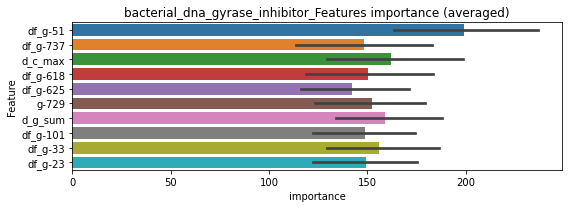

len(train_index) : 3807
len(valid_index) : 3807
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596464	valid_1's binary_logloss: 0.0968151
[200]	training's binary_logloss: 0.0215259	valid_1's binary_logloss: 0.0640523
[300]	training's binary_logloss: 0.00788975	valid_1's binary_logloss: 0.0503202
[400]	training's binary_logloss: 0.00339761	valid_1's binary_logloss: 0.045201
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00215156	valid_1's binary_logloss: 0.0427187


len(train_index) : 3807
len(valid_index) : 3807
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576206	valid_1's binary_logloss: 0.0857542
[200]	training's binary_logloss: 0.0196913	valid_1's binary_logloss: 0.0530507
[300]	training's binary_logloss: 0.00734465	valid_1's binary_logloss: 0.0413158
[400]	training's binary_logloss: 0.0032999	valid_1's binary_logloss: 0.0367673
[500]	training's binary_logloss: 0.0018365	valid_1's binary_logloss: 0.0344883
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00170743	valid_1's binary_logloss: 0.0340312


bacterial_dna_gyrase_inhibitor logloss: 0.03837493361629127


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3274, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141179	valid_1's binary_logloss: 0.228793
[200]	training's binary_logloss: 0.0656896	valid_1's binary_logloss: 0.180034
[300]	training's binary_logloss: 0.0298206	valid_1's binary_logloss: 0.157833
[400]	training's binary_logloss: 0.0145654	valid_1's binary_logloss: 0.145853
[500]	training's binary_logloss: 0.00770417	valid_1's binary_logloss: 0.14105
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00608102	valid_1's binary_logloss: 0.138774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138759	valid_1's binary_logloss: 0.223769
[200]	training's binary_logloss: 0.0593169	valid_1's binary_logloss: 0.161289
[300]	training's binary_logloss: 0.027002	valid_1's binary_logloss: 0.136792


1 / 3 AUC score:0.972
y_Threshold: 0.0770601, Threshold: 0.2865838, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.0138797	valid_1's binary_logloss: 0.126986
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0140977	valid_1's binary_logloss: 0.126768


Remove_noisy_labels: 250 → Positive_corect_labels: 595/3678
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.25793, conf_1:0.31524
threshold: 0.2865838, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 595.0/3678, y_label_rate: 0.1617727
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117328	valid_1's binary_logloss: 0.180952
[200]	training's binary_logloss: 0.0481204	valid_1's binary_logloss: 0.11967
[300]	training's binary_logloss: 0.0209277	valid_1's binary_logloss: 0.09281
[400]	training's binary_logloss: 0.00956705	valid_1's binary_logloss: 0.078601
[500]	training's binary_logloss: 0.00526458	valid_1's binary_logloss: 0.071334
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0039377	valid_1's binary_logloss: 0.068969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120782	valid_1's binary_logloss: 0.186359
[200]	training's binary_logloss: 0.0485941	valid_1's binary_logloss: 0.120276
[300]	training's binary_logloss: 0.0210553	valid_1's binary_logloss: 0.0903716
[400]	training's binary_logloss: 0.00989405	valid_1's binary_logloss: 0.0765375
[500]	training's binary_logloss: 0.0053516	valid_1's binary_lo

2 / 3 AUC score:0.995
y_Threshold: 0.1428109, Threshold: 0.2865838, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 564.0/3616
p_label_rate: 0.0170768 Vs.target_rate: 0.00483, Num_p_label: 68.0, conf_0:0.25793, conf_1:0.31524
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_1: 0.2865838
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_2: 0.3165838
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_3: 0.3465838
Num_p_label: 41.0, Expected: 19.2, Adj_threshold_4: 0.3765838
Num_p_label: 33.0, Expected: 19.2, Adj_threshold_5: 0.4065838
threshold: 0.4065838, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 564.0/3616, y_label_rate: 0.1559735
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110556	valid_1's binary_logloss: 0.174412
[200]	training's binary_logloss: 0.0426706	valid_1's binary_logloss: 0.117145
[300]	training's binary_logloss: 0.0165454	valid_1's binary_logloss: 0.09336
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00853209	valid_1's binary_logloss: 0.0842684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103672	valid_1's binary_logloss: 0.173734
[200]	training's binary_logloss: 0.0390714	valid_1's binary_logloss: 0.118278
[300]	training's binary_logloss: 0.0160211	valid_1's binary_logloss: 0.0980609


3 / 3 AUC score:0.988
y_Threshold: 0.1375939, Threshold: 0.4065838, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 525.0/3538
p_label_rate: 0.0105475 Vs.target_rate: 0.00483, Num_p_label: 42.0, conf_0:0.36593, conf_1:0.44724
threshold: 0.4065838, positive_p_label: 42.0/3982, p_label_rate: 0.0105475


[400]	training's binary_logloss: 0.00747388	valid_1's binary_logloss: 0.0899463
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00774625	valid_1's binary_logloss: 0.0898708


positive_y_label: 567.0/7520, y_label_rate: 0.0753989


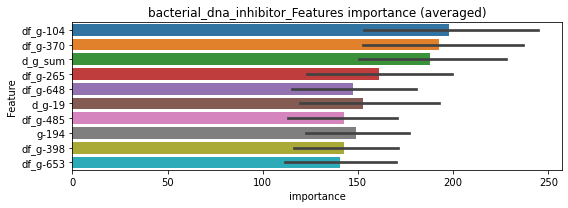

len(train_index) : 3760
len(valid_index) : 3760
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584586	valid_1's binary_logloss: 0.0958004
[200]	training's binary_logloss: 0.0232158	valid_1's binary_logloss: 0.0657697
[300]	training's binary_logloss: 0.00940724	valid_1's binary_logloss: 0.0529901
[400]	training's binary_logloss: 0.00433546	valid_1's binary_logloss: 0.0476838
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00254199	valid_1's binary_logloss: 0.0453412


len(train_index) : 3760
len(valid_index) : 3760
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595412	valid_1's binary_logloss: 0.103245
[200]	training's binary_logloss: 0.0222421	valid_1's binary_logloss: 0.0679854
[300]	training's binary_logloss: 0.00913823	valid_1's binary_logloss: 0.0546022
[400]	training's binary_logloss: 0.00424501	valid_1's binary_logloss: 0.046841
[500]	training's binary_logloss: 0.0023404	valid_1's binary_logloss: 0.0437912
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00222596	valid_1's binary_logloss: 0.043516


bacterial_dna_inhibitor logloss: 0.044428558057051384


neg labels: 3289 → selected neg labels: 3286


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577583	valid_1's binary_logloss: 0.0805025
[200]	training's binary_logloss: 0.0128635	valid_1's binary_logloss: 0.0286024
[300]	training's binary_logloss: 0.00387496	valid_1's binary_logloss: 0.0147097
[400]	training's binary_logloss: 0.00177926	valid_1's binary_logloss: 0.0104893
[500]	training's binary_logloss: 0.00117528	valid_1's binary_logloss: 0.00896204
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00102353	valid_1's binary_logloss: 0.00854713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619828	valid_1's binary_logloss: 0.0848959
[200]	training's binary_logloss: 0.0139205	valid_1's binary_logloss: 0.0284349
[300]	training's binary_logloss: 0.00401992	valid_1's binary_logloss: 0.0129312
[400]	training's binary_logloss: 0.00187689	valid_1's binary_logloss: 0.00872256
[500]	training's binary_logloss: 0.00123852	

1 / 3 AUC score:1.000
y_Threshold: 0.0134405, Threshold: 0.0788481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.07096, conf_1:0.08673
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0788481
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.1088481
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.1388481
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.1688481
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.1988481
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_6: 0.2288481
threshold: 0.2288481, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540959	valid_1's binary_logloss: 0.0747584
[200]	training's binary_logloss: 0.011633	valid_1's binary_logloss: 0.0236977
[300]	training's binary_logloss: 0.00334298	valid_1's binary_logloss: 0.0104549
[400]	training's binary_logloss: 0.00159191	valid_1's binary_logloss: 0.0064904
[500]	training's binary_logloss: 0.00106414	valid_1's binary_logloss: 0.00528686
[600]	training's binary_logloss: 0.000877745	valid_1's binary_logloss: 0.00479582
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00085853	valid_1's binary_logloss: 0.00473721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515254	valid_1's binary_logloss: 0.072588
[200]	training's binary_logloss: 0.0107423	valid_1's binary_logloss: 0.0226124
[300]	training's binary_logloss: 0.00324683	valid_1's binary_logloss: 0.0101326
[400]	training's binary_logloss: 0.00159831	v

2 / 3 AUC score:1.000
y_Threshold: 0.1501727, Threshold: 0.2288481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00080, Num_p_label: 31.0, conf_0:0.20596, conf_1:0.25173
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_1: 0.2288481
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_2: 0.2588481
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.2888481
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.3188481
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_5: 0.3488481
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_6: 0.3788481
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.4088481
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.4388481
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.4688481
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.4988481
threshold: 0.5288481, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540959	valid_1's binary_logloss: 0.0747584
[200]	training's binary_logloss: 0.011633	valid_1's binary_logloss: 0.0236977
[300]	training's binary_logloss: 0.00334298	valid_1's binary_logloss: 0.0104549
[400]	training's binary_logloss: 0.00159191	valid_1's binary_logloss: 0.0064904
[500]	training's binary_logloss: 0.00106414	valid_1's binary_logloss: 0.00528686
[600]	training's binary_logloss: 0.000877745	valid_1's binary_logloss: 0.00479582
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00085853	valid_1's binary_logloss: 0.00473721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515254	valid_1's binary_logloss: 0.072588
[200]	training's binary_logloss: 0.0107423	valid_1's binary_logloss: 0.0226124
[300]	training's binary_logloss: 0.00324683	valid_1's binary_logloss: 0.0101326
[400]	training's binary_logloss: 0.00159831	v

3 / 3 AUC score:1.000
y_Threshold: 0.1501727, Threshold: 0.5288481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.47596, conf_1:0.58173
threshold: 0.5288481, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7793, y_label_rate: 0.0852047


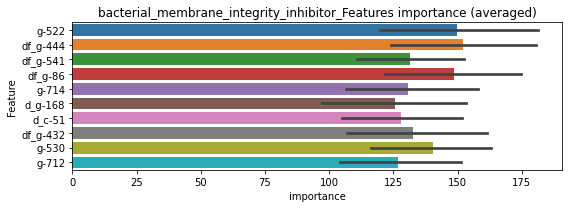

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326528	valid_1's binary_logloss: 0.0501007
[200]	training's binary_logloss: 0.00694674	valid_1's binary_logloss: 0.0186954
[300]	training's binary_logloss: 0.00193401	valid_1's binary_logloss: 0.00975789
[400]	training's binary_logloss: 0.000909406	valid_1's binary_logloss: 0.00745815
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000804642	valid_1's binary_logloss: 0.00721181


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344161	valid_1's binary_logloss: 0.0501258
[200]	training's binary_logloss: 0.00712601	valid_1's binary_logloss: 0.0182057
[300]	training's binary_logloss: 0.00200553	valid_1's binary_logloss: 0.00902194
[400]	training's binary_logloss: 0.000932792	valid_1's binary_logloss: 0.00675163
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000764921	valid_1's binary_logloss: 0.00618449


bacterial_membrane_integrity_inhibitor logloss: 0.006698215631788189


neg labels: 3289 → selected neg labels: 3282


bcl_inhibitor, len(trt): 31, len(othr): 3282, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991118	valid_1's binary_logloss: 0.151034
[200]	training's binary_logloss: 0.0307668	valid_1's binary_logloss: 0.0769031
[300]	training's binary_logloss: 0.0104408	valid_1's binary_logloss: 0.0464707
[400]	training's binary_logloss: 0.00431588	valid_1's binary_logloss: 0.0333588
[500]	training's binary_logloss: 0.00243361	valid_1's binary_logloss: 0.0276372
[600]	training's binary_logloss: 0.00173799	valid_1's binary_logloss: 0.0253068
[700]	training's binary_logloss: 0.00142996	valid_1's binary_logloss: 0.0243626
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.00142852	valid_1's binary_logloss: 0.0243505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986239	valid_1's binary_logloss: 0.131818
[200]	training's binary_logloss: 0.0305546	valid_1's binary_logloss: 0.0596571
[300]	training's binary_logloss: 0.0105132	valid_1

1 / 3 AUC score:1.000
y_Threshold: 0.0318325, Threshold: 0.2085233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.18767, conf_1:0.22938
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.2085233
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_2: 0.2385233
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_3: 0.2685233
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_4: 0.2985233
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_5: 0.3285233
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_6: 0.3585233
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_7: 0.3885233
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_8: 0.4185233
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.4485233
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_10: 0.4785233
threshold: 0.5085233, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879445	valid_1's binary_logloss: 0.13426
[200]	training's binary_logloss: 0.024503	valid_1's binary_logloss: 0.0639645
[300]	training's binary_logloss: 0.00826094	valid_1's binary_logloss: 0.0380988
[400]	training's binary_logloss: 0.00351743	valid_1's binary_logloss: 0.0273267
[500]	training's binary_logloss: 0.00208997	valid_1's binary_logloss: 0.0234117
[600]	training's binary_logloss: 0.0015264	valid_1's binary_logloss: 0.0213812
[700]	training's binary_logloss: 0.00127205	valid_1's binary_logloss: 0.0203887
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00118877	valid_1's binary_logloss: 0.0200762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907382	valid_1's binary_logloss: 0.119524
[200]	training's binary_logloss: 0.0269691	valid_1's binary_logloss: 0.0498927
[300]	training's binary_logloss: 0.00900414	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.2260261, Threshold: 0.5085233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0075339 Vs.target_rate: 0.00130, Num_p_label: 30.0, conf_0:0.45767, conf_1:0.55938
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_1: 0.5085233
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_2: 0.5385233
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_3: 0.5685233
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_4: 0.5985233
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_5: 0.6285233
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_6: 0.6585233
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_7: 0.6885233
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_8: 0.7185233
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_9: 0.7485233
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_10: 0.7785233
threshold: 0.8085233, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911179	valid_1's binary_logloss: 0.126045
[200]	training's binary_logloss: 0.0234462	valid_1's binary_logloss: 0.0530553
[300]	training's binary_logloss: 0.0076387	valid_1's binary_logloss: 0.0299216
[400]	training's binary_logloss: 0.00343552	valid_1's binary_logloss: 0.0219546
[500]	training's binary_logloss: 0.0020501	valid_1's binary_logloss: 0.018715
[600]	training's binary_logloss: 0.00151205	valid_1's binary_logloss: 0.0169396
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00146452	valid_1's binary_logloss: 0.0166501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087825	valid_1's binary_logloss: 0.133734
[200]	training's binary_logloss: 0.0248939	valid_1's binary_logloss: 0.0645773
[300]	training's binary_logloss: 0.00808183	valid_1's binary_logloss: 0.0385381
[400]	training's binary_logloss: 0.00360969	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.1677415, Threshold: 0.8085233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3786
p_label_rate: 0.0017579 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.72767, conf_1:0.88938
threshold: 0.8085233, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/7768, y_label_rate: 0.0840628


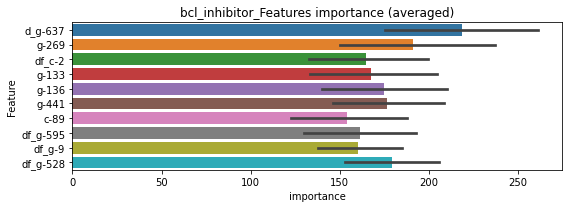

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514086	valid_1's binary_logloss: 0.0800369
[200]	training's binary_logloss: 0.0148963	valid_1's binary_logloss: 0.0383221
[300]	training's binary_logloss: 0.00492323	valid_1's binary_logloss: 0.0223524
[400]	training's binary_logloss: 0.00202979	valid_1's binary_logloss: 0.015804
[500]	training's binary_logloss: 0.00117376	valid_1's binary_logloss: 0.0132082
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00091701	valid_1's binary_logloss: 0.0123169


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529516	valid_1's binary_logloss: 0.0774356
[200]	training's binary_logloss: 0.0155659	valid_1's binary_logloss: 0.0377203
[300]	training's binary_logloss: 0.00511554	valid_1's binary_logloss: 0.024157
[400]	training's binary_logloss: 0.0020613	valid_1's binary_logloss: 0.0177909
[500]	training's binary_logloss: 0.00118281	valid_1's binary_logloss: 0.0157491
[600]	training's binary_logloss: 0.000867215	valid_1's binary_logloss: 0.0149513
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000884386	valid_1's binary_logloss: 0.0149103


bcl_inhibitor logloss: 0.013613620847075842


neg labels: 3289 → selected neg labels: 3285


bcr-abl_inhibitor, len(trt): 38, len(othr): 3285, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754816	valid_1's binary_logloss: 0.12471
[200]	training's binary_logloss: 0.023402	valid_1's binary_logloss: 0.0645979
[300]	training's binary_logloss: 0.00831502	valid_1's binary_logloss: 0.0419729
[400]	training's binary_logloss: 0.00398499	valid_1's binary_logloss: 0.0341766
[500]	training's binary_logloss: 0.0024419	valid_1's binary_logloss: 0.0307186
[600]	training's binary_logloss: 0.00177025	valid_1's binary_logloss: 0.0292113
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00170525	valid_1's binary_logloss: 0.0289873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836724	valid_1's binary_logloss: 0.120806
[200]	training's binary_logloss: 0.0282363	valid_1's binary_logloss: 0.0575696
[300]	training's binary_logloss: 0.00998192	valid_1's binary_logloss: 0.0314429
[400]	training's binary_logloss: 0.00444223	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0282849, Threshold: 0.3222859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00160, Num_p_label: 40.0, conf_0:0.29006, conf_1:0.35451
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_1: 0.3222859
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_2: 0.3522859
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_3: 0.3822859
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_4: 0.4122859
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_5: 0.4422859
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_6: 0.4722859
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_7: 0.5022859
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_8: 0.5322859
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_9: 0.5622859
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_10: 0.5922859
threshold: 0.6222859, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678718	valid_1's binary_logloss: 0.119346
[200]	training's binary_logloss: 0.0186724	valid_1's binary_logloss: 0.0614342
[300]	training's binary_logloss: 0.00637071	valid_1's binary_logloss: 0.0408677
[400]	training's binary_logloss: 0.00312892	valid_1's binary_logloss: 0.0325021
[500]	training's binary_logloss: 0.00204098	valid_1's binary_logloss: 0.0292969
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00160194	valid_1's binary_logloss: 0.0276967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080271	valid_1's binary_logloss: 0.111745
[200]	training's binary_logloss: 0.0244482	valid_1's binary_logloss: 0.0456238
[300]	training's binary_logloss: 0.00819579	valid_1's binary_logloss: 0.0223159
[400]	training's binary_logloss: 0.00374756	valid_1's binary_logloss: 0.0139344
[500]	training's binary_logloss: 0.00226856	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1645405, Threshold: 0.6222859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0107986 Vs.target_rate: 0.00160, Num_p_label: 43.0, conf_0:0.56006, conf_1:0.68451
Num_p_label: 43.0, Expected: 6.4, Adj_threshold_1: 0.6222859
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_2: 0.6522859
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_3: 0.6822859
Num_p_label: 37.0, Expected: 6.4, Adj_threshold_4: 0.7122859
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_5: 0.7422859
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_6: 0.7722859
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_7: 0.8022859
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_8: 0.8322859
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_9: 0.8622859
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_10: 0.8922859
threshold: 0.9222859, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715332	valid_1's binary_logloss: 0.122735
[200]	training's binary_logloss: 0.0206159	valid_1's binary_logloss: 0.0578015
[300]	training's binary_logloss: 0.00712096	valid_1's binary_logloss: 0.0354455
[400]	training's binary_logloss: 0.00334469	valid_1's binary_logloss: 0.0257375
[500]	training's binary_logloss: 0.00212195	valid_1's binary_logloss: 0.0226139
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00196656	valid_1's binary_logloss: 0.0219159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740455	valid_1's binary_logloss: 0.123084
[200]	training's binary_logloss: 0.0204999	valid_1's binary_logloss: 0.060635
[300]	training's binary_logloss: 0.00701393	valid_1's binary_logloss: 0.036044
[400]	training's binary_logloss: 0.00331515	valid_1's binary_logloss: 0.02678
[500]	training's binary_logloss: 0.00210914	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.1522868, Threshold: 0.9222859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0040181 Vs.target_rate: 0.00160, Num_p_label: 16.0, conf_0:0.83006, conf_1:1.01451
threshold: 0.9222859, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 661.0/7768, y_label_rate: 0.0850927


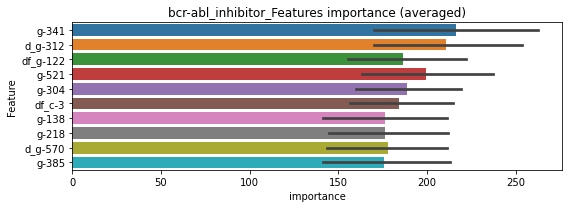

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421269	valid_1's binary_logloss: 0.0779454
[200]	training's binary_logloss: 0.0128684	valid_1's binary_logloss: 0.0465577
[300]	training's binary_logloss: 0.00433236	valid_1's binary_logloss: 0.0332192
[400]	training's binary_logloss: 0.00200254	valid_1's binary_logloss: 0.0288042
[500]	training's binary_logloss: 0.00123595	valid_1's binary_logloss: 0.0265155
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00128126	valid_1's binary_logloss: 0.0264111


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447113	valid_1's binary_logloss: 0.0778639
[200]	training's binary_logloss: 0.0131424	valid_1's binary_logloss: 0.0423172
[300]	training's binary_logloss: 0.00444328	valid_1's binary_logloss: 0.0282326
[400]	training's binary_logloss: 0.00203128	valid_1's binary_logloss: 0.0234236
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00161546	valid_1's binary_logloss: 0.0221194


bcr-abl_inhibitor logloss: 0.02426523746321434


neg labels: 3289 → selected neg labels: 3280


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3280, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108033	valid_1's binary_logloss: 0.172426
[200]	training's binary_logloss: 0.0410078	valid_1's binary_logloss: 0.117456
[300]	training's binary_logloss: 0.0170995	valid_1's binary_logloss: 0.0973921
[400]	training's binary_logloss: 0.0076065	valid_1's binary_logloss: 0.0872781
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0047414	valid_1's binary_logloss: 0.0844784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118379	valid_1's binary_logloss: 0.165931
[200]	training's binary_logloss: 0.0475091	valid_1's binary_logloss: 0.105717
[300]	training's binary_logloss: 0.0193955	valid_1's binary_logloss: 0.0820833
[400]	training's binary_logloss: 0.0083704	valid_1's binary_logloss: 0.0698419
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00569469	valid_1's binary_logloss: 0.0655551


1 / 3 AUC score:0.989
y_Threshold: 0.0517975, Threshold: 0.1427964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 632/3756
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.12852, conf_1:0.15708
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.1427964
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_2: 0.1727964
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_3: 0.2027964
threshold: 0.2027964, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 632.0/3756, y_label_rate: 0.1682641
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934791	valid_1's binary_logloss: 0.14697
[200]	training's binary_logloss: 0.0337849	valid_1's binary_logloss: 0.0906719
[300]	training's binary_logloss: 0.0127983	valid_1's binary_logloss: 0.0661569
[400]	training's binary_logloss: 0.00547765	valid_1's binary_logloss: 0.0540576
[500]	training's binary_logloss: 0.00304782	valid_1's binary_logloss: 0.0494844
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0030345	valid_1's binary_logloss: 0.0493798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965329	valid_1's binary_logloss: 0.138575
[200]	training's binary_logloss: 0.0335197	valid_1's binary_logloss: 0.0730083
[300]	training's binary_logloss: 0.0139293	valid_1's binary_logloss: 0.0501284
[400]	training's binary_logloss: 0.00640643	valid_1's binary_logloss: 0.0388671
[500]	training's binary_logloss: 0.003514	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.1432987, Threshold: 0.2027964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 616.0/3724
p_label_rate: 0.0130588 Vs.target_rate: 0.00281, Num_p_label: 52.0, conf_0:0.18252, conf_1:0.22308
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_1: 0.2027964
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_2: 0.2327964
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_3: 0.2627964
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_4: 0.2927964
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_5: 0.3227964
threshold: 0.3227964, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 616.0/3724, y_label_rate: 0.1654135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874121	valid_1's binary_logloss: 0.139105
[200]	training's binary_logloss: 0.0297822	valid_1's binary_logloss: 0.0859766
[300]	training's binary_logloss: 0.0109513	valid_1's binary_logloss: 0.0660328
[400]	training's binary_logloss: 0.00494042	valid_1's binary_logloss: 0.0577269
[500]	training's binary_logloss: 0.00278861	valid_1's binary_logloss: 0.0547579
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00235121	valid_1's binary_logloss: 0.0539725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085255	valid_1's binary_logloss: 0.130793
[200]	training's binary_logloss: 0.0305056	valid_1's binary_logloss: 0.0764537
[300]	training's binary_logloss: 0.011506	valid_1's binary_logloss: 0.0547858
[400]	training's binary_logloss: 0.00514954	valid_1's binary_logloss: 0.0473591
[500]	training's binary_logloss: 0.00289272	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.1027811, Threshold: 0.3227964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 594.0/3680
p_label_rate: 0.0067805 Vs.target_rate: 0.00281, Num_p_label: 27.0, conf_0:0.29052, conf_1:0.35508
threshold: 0.3227964, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 621.0/7662, y_label_rate: 0.0810493


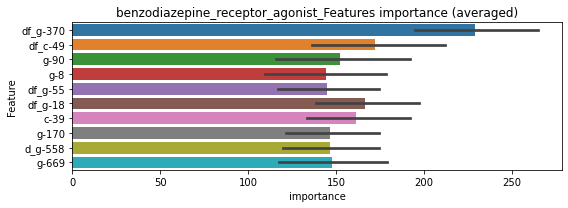

len(train_index) : 3831
len(valid_index) : 3831
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049825	valid_1's binary_logloss: 0.0781471
[200]	training's binary_logloss: 0.0172448	valid_1's binary_logloss: 0.0486458
[300]	training's binary_logloss: 0.00670073	valid_1's binary_logloss: 0.0373957
[400]	training's binary_logloss: 0.00285671	valid_1's binary_logloss: 0.0329265
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00230281	valid_1's binary_logloss: 0.0320106


len(train_index) : 3831
len(valid_index) : 3831
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504443	valid_1's binary_logloss: 0.0814755
[200]	training's binary_logloss: 0.017716	valid_1's binary_logloss: 0.0489245
[300]	training's binary_logloss: 0.00686559	valid_1's binary_logloss: 0.0363876
[400]	training's binary_logloss: 0.002999	valid_1's binary_logloss: 0.0319159
[500]	training's binary_logloss: 0.00161428	valid_1's binary_logloss: 0.0294611
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00137373	valid_1's binary_logloss: 0.0289689


benzodiazepine_receptor_agonist logloss: 0.030489754059170378


neg labels: 3289 → selected neg labels: 3287


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3287, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812607	valid_1's binary_logloss: 0.109655
[200]	training's binary_logloss: 0.0225442	valid_1's binary_logloss: 0.0441862
[300]	training's binary_logloss: 0.00667666	valid_1's binary_logloss: 0.0209474
[400]	training's binary_logloss: 0.00275378	valid_1's binary_logloss: 0.0128665
[500]	training's binary_logloss: 0.00166643	valid_1's binary_logloss: 0.0101102
[600]	training's binary_logloss: 0.00126978	valid_1's binary_logloss: 0.00917372
[700]	training's binary_logloss: 0.001087	valid_1's binary_logloss: 0.00859925
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.00104788	valid_1's binary_logloss: 0.00852156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832113	valid_1's binary_logloss: 0.120395
[200]	training's binary_logloss: 0.0218961	valid_1's binary_logloss: 0.0501258
[300]	training's binary_logloss: 0.0062262	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0153512, Threshold: 0.0792787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.07135, conf_1:0.08721
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0792787
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.1092787
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_3: 0.1392787
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.1692787
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.1992787
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.2292787
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.2592787
threshold: 0.2592787, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721022	valid_1's binary_logloss: 0.0979849
[200]	training's binary_logloss: 0.0193307	valid_1's binary_logloss: 0.0377149
[300]	training's binary_logloss: 0.00582679	valid_1's binary_logloss: 0.0176395
[400]	training's binary_logloss: 0.00245799	valid_1's binary_logloss: 0.0101745
[500]	training's binary_logloss: 0.0015484	valid_1's binary_logloss: 0.00803827
[600]	training's binary_logloss: 0.00120832	valid_1's binary_logloss: 0.00727709
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00117043	valid_1's binary_logloss: 0.00722555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753313	valid_1's binary_logloss: 0.113055
[200]	training's binary_logloss: 0.0184156	valid_1's binary_logloss: 0.0434358
[300]	training's binary_logloss: 0.00531227	valid_1's binary_logloss: 0.0208155
[400]	training's binary_logloss: 0.00234901	va

2 / 3 AUC score:1.000
y_Threshold: 0.1573869, Threshold: 0.2592787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0042692 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.23335, conf_1:0.28521
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.2592787
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.2892787
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.3192787
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.3492787
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.3792787
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_6: 0.4092787
threshold: 0.4092787, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3804, y_label_rate: 0.1716614
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067941	valid_1's binary_logloss: 0.100482
[200]	training's binary_logloss: 0.0173511	valid_1's binary_logloss: 0.0383536
[300]	training's binary_logloss: 0.00498335	valid_1's binary_logloss: 0.0177239
[400]	training's binary_logloss: 0.00227261	valid_1's binary_logloss: 0.0114824
[500]	training's binary_logloss: 0.00146753	valid_1's binary_logloss: 0.0094973
[600]	training's binary_logloss: 0.00115854	valid_1's binary_logloss: 0.00855534
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00102112	valid_1's binary_logloss: 0.0080402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779509	valid_1's binary_logloss: 0.110276
[200]	training's binary_logloss: 0.0181176	valid_1's binary_logloss: 0.0374474
[300]	training's binary_logloss: 0.00506952	valid_1's binary_logloss: 0.0162441
[400]	training's binary_logloss: 0.00225094	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1798229, Threshold: 0.4092787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.36835, conf_1:0.45021
threshold: 0.4092787, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7786, y_label_rate: 0.0848960


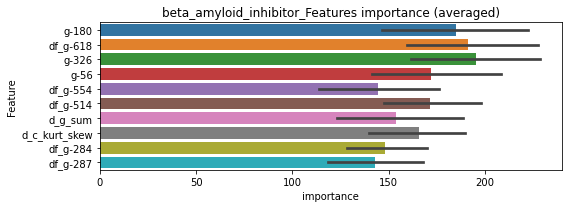

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438711	valid_1's binary_logloss: 0.0641026
[200]	training's binary_logloss: 0.0102932	valid_1's binary_logloss: 0.0252083
[300]	training's binary_logloss: 0.00282351	valid_1's binary_logloss: 0.0145483
[400]	training's binary_logloss: 0.00120738	valid_1's binary_logloss: 0.0116325
[500]	training's binary_logloss: 0.000763781	valid_1's binary_logloss: 0.0104827
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00074454	valid_1's binary_logloss: 0.0103938


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388144	valid_1's binary_logloss: 0.0616785
[200]	training's binary_logloss: 0.00912843	valid_1's binary_logloss: 0.0269074
[300]	training's binary_logloss: 0.00278973	valid_1's binary_logloss: 0.0163013
[400]	training's binary_logloss: 0.00124863	valid_1's binary_logloss: 0.0133535
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000974957	valid_1's binary_logloss: 0.0128422


beta_amyloid_inhibitor logloss: 0.01161801028170077


neg labels: 3289 → selected neg labels: 3281


bromodomain_inhibitor, len(trt): 68, len(othr): 3281, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129954	valid_1's binary_logloss: 0.206449
[200]	training's binary_logloss: 0.0496725	valid_1's binary_logloss: 0.134598
[300]	training's binary_logloss: 0.0208452	valid_1's binary_logloss: 0.105855
[400]	training's binary_logloss: 0.009264	valid_1's binary_logloss: 0.090725
[500]	training's binary_logloss: 0.00499957	valid_1's binary_logloss: 0.0855921
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00526255	valid_1's binary_logloss: 0.0853174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123135	valid_1's binary_logloss: 0.200128
[200]	training's binary_logloss: 0.0499266	valid_1's binary_logloss: 0.13794
[300]	training's binary_logloss: 0.0203149	valid_1's binary_logloss: 0.108086
[400]	training's binary_logloss: 0.00953061	valid_1's binary_logloss: 0.0959257
[500]	training's binary_logloss: 0.00507161	valid_1's binary_

1 / 3 AUC score:0.989
y_Threshold: 0.0808734, Threshold: 0.3025009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 178 → Positive_corect_labels: 633/3759
p_label_rate: 0.0100452 Vs.target_rate: 0.00286, Num_p_label: 40.0, conf_0:0.27225, conf_1:0.33275
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_1: 0.3025009
Num_p_label: 33.0, Expected: 11.4, Adj_threshold_2: 0.3325009
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_3: 0.3625009
Num_p_label: 24.0, Expected: 11.4, Adj_threshold_4: 0.3925009
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_5: 0.4225009
threshold: 0.4225009, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 633.0/3759, y_label_rate: 0.1683958
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105862	valid_1's binary_logloss: 0.187112
[200]	training's binary_logloss: 0.0364385	valid_1's binary_logloss: 0.123429
[300]	training's binary_logloss: 0.0142804	valid_1's binary_logloss: 0.0999931
[400]	training's binary_logloss: 0.00664258	valid_1's binary_logloss: 0.0874654
[500]	training's binary_logloss: 0.0038251	valid_1's binary_logloss: 0.0819642
[600]	training's binary_logloss: 0.00261999	valid_1's binary_logloss: 0.0799346
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00251097	valid_1's binary_logloss: 0.0793919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112627	valid_1's binary_logloss: 0.176374
[200]	training's binary_logloss: 0.0429265	valid_1's binary_logloss: 0.109858
[300]	training's binary_logloss: 0.0171695	valid_1's binary_logloss: 0.0797681
[400]	training's binary_logloss: 0.00798586	valid_1's bi

2 / 3 AUC score:0.992
y_Threshold: 0.1375314, Threshold: 0.4225009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 599.0/3691
p_label_rate: 0.0135610 Vs.target_rate: 0.00286, Num_p_label: 54.0, conf_0:0.38025, conf_1:0.46475
Num_p_label: 54.0, Expected: 11.4, Adj_threshold_1: 0.4225009
Num_p_label: 47.0, Expected: 11.4, Adj_threshold_2: 0.4525009
Num_p_label: 38.0, Expected: 11.4, Adj_threshold_3: 0.4825009
Num_p_label: 32.0, Expected: 11.4, Adj_threshold_4: 0.5125009
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_5: 0.5425009
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_6: 0.5725009
Num_p_label: 25.0, Expected: 11.4, Adj_threshold_7: 0.6025009
Num_p_label: 21.0, Expected: 11.4, Adj_threshold_8: 0.6325009
threshold: 0.6325009, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 599.0/3691, y_label_rate: 0.1622866
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102232	valid_1's binary_logloss: 0.153962
[200]	training's binary_logloss: 0.0366739	valid_1's binary_logloss: 0.0889341
[300]	training's binary_logloss: 0.0144943	valid_1's binary_logloss: 0.0596134
[400]	training's binary_logloss: 0.00680914	valid_1's binary_logloss: 0.0463796
[500]	training's binary_logloss: 0.00384626	valid_1's binary_logloss: 0.0411965
[600]	training's binary_logloss: 0.00259652	valid_1's binary_logloss: 0.0377883
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00206035	valid_1's binary_logloss: 0.0357124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959924	valid_1's binary_logloss: 0.168294
[200]	training's binary_logloss: 0.0344579	valid_1's binary_logloss: 0.107713
[300]	training's binary_logloss: 0.0137889	valid_1's binary_logloss: 0.0806378
[400]	training's binary_logloss: 0.00647406	valid_1's

3 / 3 AUC score:0.997
y_Threshold: 0.1510874, Threshold: 0.6325009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 578.0/3649
p_label_rate: 0.0075339 Vs.target_rate: 0.00286, Num_p_label: 30.0, conf_0:0.56925, conf_1:0.69575
threshold: 0.6325009, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 608.0/7631, y_label_rate: 0.0796750


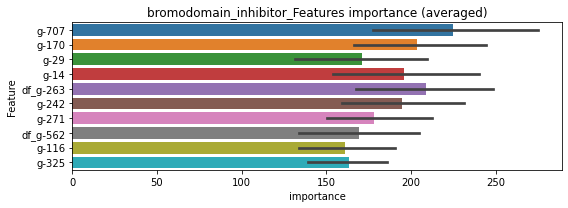

len(train_index) : 3815
len(valid_index) : 3816
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598063	valid_1's binary_logloss: 0.105021
[200]	training's binary_logloss: 0.0206704	valid_1's binary_logloss: 0.067486
[300]	training's binary_logloss: 0.00762476	valid_1's binary_logloss: 0.0530195
[400]	training's binary_logloss: 0.00351106	valid_1's binary_logloss: 0.048228
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00209875	valid_1's binary_logloss: 0.0456638


len(train_index) : 3816
len(valid_index) : 3815
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596691	valid_1's binary_logloss: 0.10764
[200]	training's binary_logloss: 0.0226666	valid_1's binary_logloss: 0.0702701
[300]	training's binary_logloss: 0.00872481	valid_1's binary_logloss: 0.0536217
[400]	training's binary_logloss: 0.00388249	valid_1's binary_logloss: 0.0461402
[500]	training's binary_logloss: 0.00212062	valid_1's binary_logloss: 0.0416904
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00182676	valid_1's binary_logloss: 0.040931


bromodomain_inhibitor logloss: 0.04329772266001412


neg labels: 3289 → selected neg labels: 3286


btk_inhibitor, len(trt): 29, len(othr): 3286, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843874	valid_1's binary_logloss: 0.122831
[200]	training's binary_logloss: 0.0267698	valid_1's binary_logloss: 0.0623783
[300]	training's binary_logloss: 0.00821856	valid_1's binary_logloss: 0.036311
[400]	training's binary_logloss: 0.00338276	valid_1's binary_logloss: 0.0252
[500]	training's binary_logloss: 0.00194633	valid_1's binary_logloss: 0.0211317
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00163007	valid_1's binary_logloss: 0.0201705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845871	valid_1's binary_logloss: 0.117035
[200]	training's binary_logloss: 0.026587	valid_1's binary_logloss: 0.0556496
[300]	training's binary_logloss: 0.00811983	valid_1's binary_logloss: 0.0291504
[400]	training's binary_logloss: 0.00327028	valid_1's binary_logloss: 0.0194466
[500]	training's binary_logloss: 0.00186427	valid_1's 

1 / 3 AUC score:1.000
y_Threshold: 0.0271242, Threshold: 0.1398419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.12586, conf_1:0.15383
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.1398419
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_2: 0.1698419
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_3: 0.1998419
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_4: 0.2298419
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_5: 0.2598419
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_6: 0.2898419
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_7: 0.3198419
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_8: 0.3498419
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_9: 0.3798419
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_10: 0.4098419
threshold: 0.4098419, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078422	valid_1's binary_logloss: 0.114534
[200]	training's binary_logloss: 0.0217312	valid_1's binary_logloss: 0.0516231
[300]	training's binary_logloss: 0.00690679	valid_1's binary_logloss: 0.0292374
[400]	training's binary_logloss: 0.00292725	valid_1's binary_logloss: 0.0205554
[500]	training's binary_logloss: 0.00174865	valid_1's binary_logloss: 0.0170558
[600]	training's binary_logloss: 0.0012974	valid_1's binary_logloss: 0.015322
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00115317	valid_1's binary_logloss: 0.0147626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761829	valid_1's binary_logloss: 0.106193
[200]	training's binary_logloss: 0.0205702	valid_1's binary_logloss: 0.044461
[300]	training's binary_logloss: 0.00648812	valid_1's binary_logloss: 0.0229668
[400]	training's binary_logloss: 0.00280941	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.1724883, Threshold: 0.4098419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0057760 Vs.target_rate: 0.00122, Num_p_label: 23.0, conf_0:0.36886, conf_1:0.45083
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_1: 0.4098419
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_2: 0.4398419
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_3: 0.4698419
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_4: 0.4998419
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_5: 0.5298419
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_6: 0.5598419
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_7: 0.5898419
threshold: 0.5898419, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/3803, y_label_rate: 0.1717065
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719526	valid_1's binary_logloss: 0.107577
[200]	training's binary_logloss: 0.0199006	valid_1's binary_logloss: 0.0521438
[300]	training's binary_logloss: 0.00607374	valid_1's binary_logloss: 0.0329106
[400]	training's binary_logloss: 0.00271025	valid_1's binary_logloss: 0.0279401
[500]	training's binary_logloss: 0.00168242	valid_1's binary_logloss: 0.0257808
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00140707	valid_1's binary_logloss: 0.0251317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760534	valid_1's binary_logloss: 0.106259
[200]	training's binary_logloss: 0.0211896	valid_1's binary_logloss: 0.045104
[300]	training's binary_logloss: 0.00653729	valid_1's binary_logloss: 0.0238205
[400]	training's binary_logloss: 0.00285095	valid_1's binary_logloss: 0.0161827
[500]	training's binary_logloss: 0.00172085	valid_

3 / 3 AUC score:0.999
y_Threshold: 0.1308664, Threshold: 0.5898419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 647.0/3791
p_label_rate: 0.0032647 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.53086, conf_1:0.64883
threshold: 0.5898419, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 660.0/7773, y_label_rate: 0.0849093


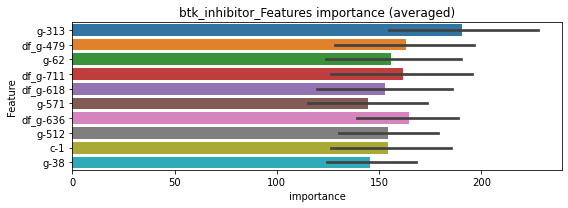

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439773	valid_1's binary_logloss: 0.0679289
[200]	training's binary_logloss: 0.0114296	valid_1's binary_logloss: 0.0342284
[300]	training's binary_logloss: 0.00373326	valid_1's binary_logloss: 0.0227163
[400]	training's binary_logloss: 0.0015472	valid_1's binary_logloss: 0.0182576
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00112655	valid_1's binary_logloss: 0.0173867


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446623	valid_1's binary_logloss: 0.0696833
[200]	training's binary_logloss: 0.0124425	valid_1's binary_logloss: 0.0337193
[300]	training's binary_logloss: 0.00382537	valid_1's binary_logloss: 0.0201741
[400]	training's binary_logloss: 0.00160898	valid_1's binary_logloss: 0.0151828
[500]	training's binary_logloss: 0.00095268	valid_1's binary_logloss: 0.0135102
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000911977	valid_1's binary_logloss: 0.0133803


btk_inhibitor logloss: 0.015383771675419553


neg labels: 3289 → selected neg labels: 3288


calcineurin_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404564	valid_1's binary_logloss: 0.0554752
[200]	training's binary_logloss: 0.00758975	valid_1's binary_logloss: 0.0175607
[300]	training's binary_logloss: 0.00218935	valid_1's binary_logloss: 0.00905304
[400]	training's binary_logloss: 0.00116504	valid_1's binary_logloss: 0.00676245
[500]	training's binary_logloss: 0.000859248	valid_1's binary_logloss: 0.0060393
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000859248	valid_1's binary_logloss: 0.0060393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403003	valid_1's binary_logloss: 0.0536713
[200]	training's binary_logloss: 0.00697852	valid_1's binary_logloss: 0.0155324
[300]	training's binary_logloss: 0.00213433	valid_1's binary_logloss: 0.00750312
[400]	training's binary_logloss: 0.00118715	valid_1's binary_logloss: 0.00556387
[500]	training's binary_logloss: 0.0008

1 / 3 AUC score:1.000
y_Threshold: 0.0089179, Threshold: 0.1338582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.12047, conf_1:0.14724
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.1338582
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_2: 0.1638582
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_3: 0.1938582
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_4: 0.2238582
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_5: 0.2538582
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_6: 0.2838582
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_7: 0.3138582
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.3438582
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.3738582
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_10: 0.4038582
threshold: 0.4338582, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03402	valid_1's binary_logloss: 0.0496201
[200]	training's binary_logloss: 0.00506361	valid_1's binary_logloss: 0.0124461
[300]	training's binary_logloss: 0.00159914	valid_1's binary_logloss: 0.00550065
[400]	training's binary_logloss: 0.000910477	valid_1's binary_logloss: 0.00368546
[500]	training's binary_logloss: 0.000691733	valid_1's binary_logloss: 0.00307677
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000636597	valid_1's binary_logloss: 0.00292677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357154	valid_1's binary_logloss: 0.0451525
[200]	training's binary_logloss: 0.0054976	valid_1's binary_logloss: 0.0106664
[300]	training's binary_logloss: 0.00170778	valid_1's binary_logloss: 0.00485304
[400]	training's binary_logloss: 0.000967469	valid_1's binary_logloss: 0.00345187
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.2995073, Threshold: 0.4338582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0105475 Vs.target_rate: 0.00050, Num_p_label: 42.0, conf_0:0.39047, conf_1:0.47724
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_1: 0.4338582
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_2: 0.4638582
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_3: 0.4938582
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_4: 0.5238582
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_5: 0.5538582
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_6: 0.5838582
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_7: 0.6138582
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_8: 0.6438582
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_9: 0.6738582
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.7038582
threshold: 0.7338582, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03402	valid_1's binary_logloss: 0.0496201
[200]	training's binary_logloss: 0.00506361	valid_1's binary_logloss: 0.0124461
[300]	training's binary_logloss: 0.00159914	valid_1's binary_logloss: 0.00550065
[400]	training's binary_logloss: 0.000910477	valid_1's binary_logloss: 0.00368546
[500]	training's binary_logloss: 0.000691733	valid_1's binary_logloss: 0.00307677
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000636597	valid_1's binary_logloss: 0.00292677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357154	valid_1's binary_logloss: 0.0451525
[200]	training's binary_logloss: 0.0054976	valid_1's binary_logloss: 0.0106664
[300]	training's binary_logloss: 0.00170778	valid_1's binary_logloss: 0.00485304
[400]	training's binary_logloss: 0.000967469	valid_1's binary_logloss: 0.00345187
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.2995073, Threshold: 0.7338582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.66047, conf_1:0.80724
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.7338582
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.7638582
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.7938582
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.8238582
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.8538582
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.8838582
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.9138582
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_8: 0.9438582
threshold: 0.9438582, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


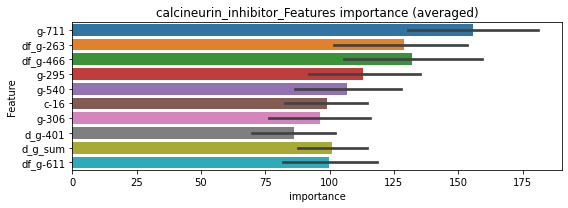

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248871	valid_1's binary_logloss: 0.0319242
[200]	training's binary_logloss: 0.0042192	valid_1's binary_logloss: 0.00934789
[300]	training's binary_logloss: 0.00113892	valid_1's binary_logloss: 0.00485609
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000763984	valid_1's binary_logloss: 0.004118


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02199	valid_1's binary_logloss: 0.0304688
[200]	training's binary_logloss: 0.00371172	valid_1's binary_logloss: 0.00926873
[300]	training's binary_logloss: 0.00104947	valid_1's binary_logloss: 0.00450361
[400]	training's binary_logloss: 0.000589702	valid_1's binary_logloss: 0.0034136
[500]	training's binary_logloss: 0.000440395	valid_1's binary_logloss: 0.00286524


calcineurin_inhibitor logloss: 0.00338013236287616


[600]	training's binary_logloss: 0.000379213	valid_1's binary_logloss: 0.00264462
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000382183	valid_1's binary_logloss: 0.00264207
neg labels: 3289 → selected neg labels: 3246


calcium_channel_blocker, len(trt): 281, len(othr): 3246, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226921	valid_1's binary_logloss: 0.388742
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.168363	valid_1's binary_logloss: 0.375498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222716	valid_1's binary_logloss: 0.389282


1 / 3 AUC score:0.777
y_Threshold: 0.1971535, Threshold: 0.3576694, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 720 → Positive_corect_labels: 354/3175
p_label_rate: 0.0100452 Vs.target_rate: 0.01180, Num_p_label: 40.0, conf_0:0.32190, conf_1:0.39344
threshold: 0.3576694, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 354.0/3175, y_label_rate: 0.1114961
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.139864	valid_1's binary_logloss: 0.371782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119828	valid_1's binary_logloss: 0.244676
[200]	training's binary_logloss: 0.051428	valid_1's binary_logloss: 0.212259
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0280881	valid_1's binary_logloss: 0.205005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123562	valid_1's binary_logloss: 0.238393
[200]	training's binary_logloss: 0.0520734	valid_1's binary_logloss: 0.206775


2 / 3 AUC score:0.911
y_Threshold: 0.1374480, Threshold: 0.3576694, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 214 → Positive_corect_labels: 247.0/2961
p_label_rate: 0.0276243 Vs.target_rate: 0.01180, Num_p_label: 110.0, conf_0:0.32190, conf_1:0.39344
threshold: 0.3576694, positive_p_label: 110.0/3982, p_label_rate: 0.0276243


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0266707	valid_1's binary_logloss: 0.19657


positive_y_label: 247.0/2961, y_label_rate: 0.0834178
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738557	valid_1's binary_logloss: 0.156224
[200]	training's binary_logloss: 0.0258401	valid_1's binary_logloss: 0.128054
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0162288	valid_1's binary_logloss: 0.122708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076078	valid_1's binary_logloss: 0.171623
[200]	training's binary_logloss: 0.027552	valid_1's binary_logloss: 0.140214
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0165623	valid_1's binary_logloss: 0.13367


3 / 3 AUC score:0.961
y_Threshold: 0.1305509, Threshold: 0.3576694, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 181.0/2829
p_label_rate: 0.0301356 Vs.target_rate: 0.01180, Num_p_label: 120.0, conf_0:0.32190, conf_1:0.39344
threshold: 0.3576694, positive_p_label: 120.0/3982, p_label_rate: 0.0301356
positive_y_label: 301.0/6811, y_label_rate: 0.0441932


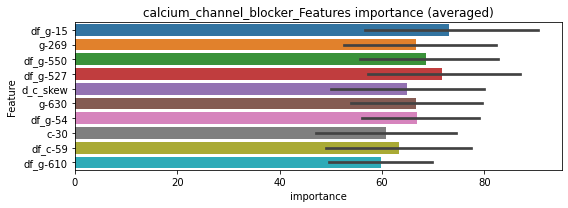

len(train_index) : 3405
len(valid_index) : 3406
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385057	valid_1's binary_logloss: 0.0840271


len(train_index) : 3406
len(valid_index) : 3405
================================= fold 2/2 calcium_channel_blocker=================================


[200]	training's binary_logloss: 0.012811	valid_1's binary_logloss: 0.0696305
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0107435	valid_1's binary_logloss: 0.0687963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376336	valid_1's binary_logloss: 0.0956983


calcium_channel_blocker logloss: 0.07642939166185525


[200]	training's binary_logloss: 0.0121654	valid_1's binary_logloss: 0.0840887
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0123134	valid_1's binary_logloss: 0.0840647
neg labels: 3289 → selected neg labels: 3281


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950748	valid_1's binary_logloss: 0.150647
[200]	training's binary_logloss: 0.0313188	valid_1's binary_logloss: 0.0943209
[300]	training's binary_logloss: 0.0112804	valid_1's binary_logloss: 0.0696173
[400]	training's binary_logloss: 0.0048349	valid_1's binary_logloss: 0.058914
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00322406	valid_1's binary_logloss: 0.0557771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965567	valid_1's binary_logloss: 0.144912
[200]	training's binary_logloss: 0.0341889	valid_1's binary_logloss: 0.085512
[300]	training's binary_logloss: 0.0120106	valid_1's binary_logloss: 0.0567364
[400]	training's binary_logloss: 0.00500882	valid_1's binary_logloss: 0.0447934
[500]	training's binary_logloss: 0.00280727	valid_1's binary_logloss: 0.0393673
Early stopping, best iteration is:
[495]	training's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0381622, Threshold: 0.3656011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.32904, conf_1:0.40216
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.3656011
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.3956011
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_3: 0.4256011
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_4: 0.4556011
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_5: 0.4856011
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_6: 0.5156011
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_7: 0.5456011
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_8: 0.5756011
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_9: 0.6056011
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_10: 0.6356011
threshold: 0.6656011, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895898	valid_1's binary_logloss: 0.126706
[200]	training's binary_logloss: 0.0276821	valid_1's binary_logloss: 0.0666439
[300]	training's binary_logloss: 0.00944027	valid_1's binary_logloss: 0.0402768
[400]	training's binary_logloss: 0.00423887	valid_1's binary_logloss: 0.0314369
[500]	training's binary_logloss: 0.002472	valid_1's binary_logloss: 0.0271419
[600]	training's binary_logloss: 0.00172917	valid_1's binary_logloss: 0.0242192
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00167023	valid_1's binary_logloss: 0.024103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906119	valid_1's binary_logloss: 0.127921
[200]	training's binary_logloss: 0.0277287	valid_1's binary_logloss: 0.0613881
[300]	training's binary_logloss: 0.00964731	valid_1's binary_logloss: 0.0363452
[400]	training's binary_logloss: 0.00416948	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.1379406, Threshold: 0.6656011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3777
p_label_rate: 0.0087896 Vs.target_rate: 0.00176, Num_p_label: 35.0, conf_0:0.59904, conf_1:0.73216
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_1: 0.6656011
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_2: 0.6956011
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_3: 0.7256011
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_4: 0.7556011
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_5: 0.7856011
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_6: 0.8156011
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_7: 0.8456011
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_8: 0.8756011
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_9: 0.9056011
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_10: 0.9356011
threshold: 0.9656011, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 642.0/3777, y_label_rate: 0.1699762
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891458	valid_1's binary_logloss: 0.126965
[200]	training's binary_logloss: 0.0299811	valid_1's binary_logloss: 0.0641406
[300]	training's binary_logloss: 0.00981355	valid_1's binary_logloss: 0.0382483
[400]	training's binary_logloss: 0.00407922	valid_1's binary_logloss: 0.0276199
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0038014	valid_1's binary_logloss: 0.0271677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846556	valid_1's binary_logloss: 0.119228
[200]	training's binary_logloss: 0.0266286	valid_1's binary_logloss: 0.0556506
[300]	training's binary_logloss: 0.00908424	valid_1's binary_logloss: 0.0318167
[400]	training's binary_logloss: 0.00399826	valid_1's binary_logloss: 0.0218842
[500]	training's binary_logloss: 0.00235573	valid_1's binary_logloss: 0.0179341
[600]	training's binary_logloss: 0.00168859	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1282520, Threshold: 0.9656011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0032647 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.86904, conf_1:1.06216
threshold: 0.9656011, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 651.0/7751, y_label_rate: 0.0839892


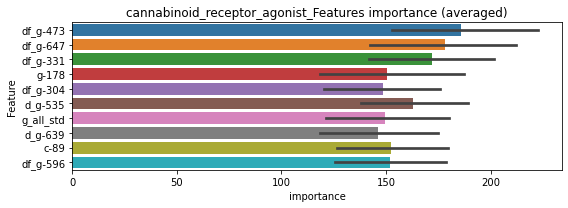

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475307	valid_1's binary_logloss: 0.0719266
[200]	training's binary_logloss: 0.0143906	valid_1's binary_logloss: 0.0367002
[300]	training's binary_logloss: 0.0051028	valid_1's binary_logloss: 0.0242165
[400]	training's binary_logloss: 0.00218443	valid_1's binary_logloss: 0.0187962
[500]	training's binary_logloss: 0.00125992	valid_1's binary_logloss: 0.0163451
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00105019	valid_1's binary_logloss: 0.0156875


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057767	valid_1's binary_logloss: 0.0747659
[200]	training's binary_logloss: 0.018352	valid_1's binary_logloss: 0.0345816
[300]	training's binary_logloss: 0.00613732	valid_1's binary_logloss: 0.0188828
[400]	training's binary_logloss: 0.00248607	valid_1's binary_logloss: 0.0125742
[500]	training's binary_logloss: 0.00135472	valid_1's binary_logloss: 0.0102359
[600]	training's binary_logloss: 0.000946822	valid_1's binary_logloss: 0.0093035
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.000819393	valid_1's binary_logloss: 0.00899243


cannabinoid_receptor_agonist logloss: 0.01234038154190456


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852694	valid_1's binary_logloss: 0.151795
[200]	training's binary_logloss: 0.0280084	valid_1's binary_logloss: 0.100745
[300]	training's binary_logloss: 0.010254	valid_1's binary_logloss: 0.0822979
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0060655	valid_1's binary_logloss: 0.0775364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936861	valid_1's binary_logloss: 0.143211
[200]	training's binary_logloss: 0.0347413	valid_1's binary_logloss: 0.0851992
[300]	training's binary_logloss: 0.0136613	valid_1's binary_logloss: 0.0600953
[400]	training's binary_logloss: 0.00622711	valid_1's binary_logloss: 0.0483013
[500]	training's binary_logloss: 0.00345077	valid_1's binary_logloss: 0.0437403
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00264286	valid_1's binary_logloss: 0.0413553


1 / 3 AUC score:0.994
y_Threshold: 0.0363914, Threshold: 0.2479959, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 640/3772
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.22320, conf_1:0.27280
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.2479959
Num_p_label: 36.0, Expected: 9.2, Adj_threshold_2: 0.2779959
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_3: 0.3079959
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_4: 0.3379959
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_5: 0.3679959
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_6: 0.3979959
threshold: 0.3979959, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778577	valid_1's binary_logloss: 0.127543
[200]	training's binary_logloss: 0.0235044	valid_1's binary_logloss: 0.0720717
[300]	training's binary_logloss: 0.00858417	valid_1's binary_logloss: 0.0530916
[400]	training's binary_logloss: 0.00406207	valid_1's binary_logloss: 0.043573
[500]	training's binary_logloss: 0.00250603	valid_1's binary_logloss: 0.0397744
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00222909	valid_1's binary_logloss: 0.0388821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814339	valid_1's binary_logloss: 0.132394
[200]	training's binary_logloss: 0.0267164	valid_1's binary_logloss: 0.0731135
[300]	training's binary_logloss: 0.00999647	valid_1's binary_logloss: 0.0508112
[400]	training's binary_logloss: 0.00497003	valid_1's binary_logloss: 0.0422492
Early stopping, best iteration is:
[485]	training'

2 / 3 AUC score:0.998
y_Threshold: 0.1167972, Threshold: 0.3979959, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 621.0/3734
p_label_rate: 0.0163235 Vs.target_rate: 0.00231, Num_p_label: 65.0, conf_0:0.35820, conf_1:0.43780
Num_p_label: 65.0, Expected: 9.2, Adj_threshold_1: 0.3979959
Num_p_label: 60.0, Expected: 9.2, Adj_threshold_2: 0.4279959
Num_p_label: 56.0, Expected: 9.2, Adj_threshold_3: 0.4579959
Num_p_label: 52.0, Expected: 9.2, Adj_threshold_4: 0.4879959
Num_p_label: 52.0, Expected: 9.2, Adj_threshold_5: 0.5179959
Num_p_label: 41.0, Expected: 9.2, Adj_threshold_6: 0.5479959
Num_p_label: 38.0, Expected: 9.2, Adj_threshold_7: 0.5779959
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_8: 0.6079959
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_9: 0.6379959
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_10: 0.6679959
threshold: 0.6979959, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 621.0/3734, y_label_rate: 0.1663096
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750061	valid_1's binary_logloss: 0.118218
[200]	training's binary_logloss: 0.0235624	valid_1's binary_logloss: 0.0657153
[300]	training's binary_logloss: 0.00842234	valid_1's binary_logloss: 0.0441577
[400]	training's binary_logloss: 0.00392602	valid_1's binary_logloss: 0.0368611
[500]	training's binary_logloss: 0.00239615	valid_1's binary_logloss: 0.033609
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00195963	valid_1's binary_logloss: 0.0322189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701515	valid_1's binary_logloss: 0.12123
[200]	training's binary_logloss: 0.0207038	valid_1's binary_logloss: 0.0723466
[300]	training's binary_logloss: 0.00757249	valid_1's binary_logloss: 0.0543387
[400]	training's binary_logloss: 0.00366447	valid_1's binary_logloss: 0.048962
Early stopping, best iteration is:
[455]	training's 

3 / 3 AUC score:0.997
y_Threshold: 0.1101146, Threshold: 0.6979959, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 604.0/3700
p_label_rate: 0.0092918 Vs.target_rate: 0.00231, Num_p_label: 37.0, conf_0:0.62820, conf_1:0.76780
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_1: 0.6979959
Num_p_label: 33.0, Expected: 9.2, Adj_threshold_2: 0.7279959
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_3: 0.7579959
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_4: 0.7879959
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_5: 0.8179959
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_6: 0.8479959
threshold: 0.8479959, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 620.0/7682, y_label_rate: 0.0807081


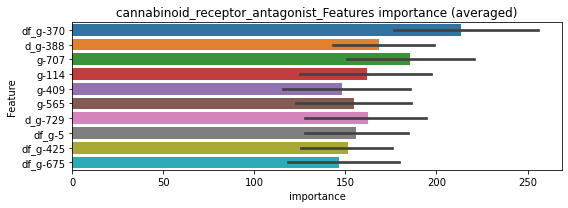

len(train_index) : 3841
len(valid_index) : 3841
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043789	valid_1's binary_logloss: 0.0790814
[200]	training's binary_logloss: 0.0129528	valid_1's binary_logloss: 0.0497116
[300]	training's binary_logloss: 0.00467284	valid_1's binary_logloss: 0.0410991
[400]	training's binary_logloss: 0.00214446	valid_1's binary_logloss: 0.0366683
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00179392	valid_1's binary_logloss: 0.0361416


len(train_index) : 3841
len(valid_index) : 3841
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461587	valid_1's binary_logloss: 0.0743009
[200]	training's binary_logloss: 0.0145889	valid_1's binary_logloss: 0.0420727
[300]	training's binary_logloss: 0.0051261	valid_1's binary_logloss: 0.0315846
[400]	training's binary_logloss: 0.00232717	valid_1's binary_logloss: 0.027312
[500]	training's binary_logloss: 0.00137491	valid_1's binary_logloss: 0.0253493
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00104299	valid_1's binary_logloss: 0.0245324


cannabinoid_receptor_antagonist logloss: 0.030336993492152523


neg labels: 3289 → selected neg labels: 3281


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828297	valid_1's binary_logloss: 0.11939
[200]	training's binary_logloss: 0.026006	valid_1's binary_logloss: 0.0589873
[300]	training's binary_logloss: 0.00908727	valid_1's binary_logloss: 0.0365708
[400]	training's binary_logloss: 0.0040013	valid_1's binary_logloss: 0.027495
[500]	training's binary_logloss: 0.00233894	valid_1's binary_logloss: 0.0234099
[600]	training's binary_logloss: 0.0016386	valid_1's binary_logloss: 0.0217295
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00158662	valid_1's binary_logloss: 0.0215536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09002	valid_1's binary_logloss: 0.124878
[200]	training's binary_logloss: 0.0260336	valid_1's binary_logloss: 0.0576019
[300]	training's binary_logloss: 0.00903357	valid_1's binary_logloss: 0.0345782
[400]	training's binary_logloss: 0.00392845	valid_1's bi

1 / 3 AUC score:1.000
y_Threshold: 0.0237530, Threshold: 0.1195224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.10757, conf_1:0.13147
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1195224
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.1495224
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1795224
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.2095224
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.2395224
threshold: 0.2395224, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810666	valid_1's binary_logloss: 0.112334
[200]	training's binary_logloss: 0.0223851	valid_1's binary_logloss: 0.0527605
[300]	training's binary_logloss: 0.00753253	valid_1's binary_logloss: 0.0325579
[400]	training's binary_logloss: 0.00342476	valid_1's binary_logloss: 0.025161
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00215708	valid_1's binary_logloss: 0.0230724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805578	valid_1's binary_logloss: 0.126687
[200]	training's binary_logloss: 0.0221024	valid_1's binary_logloss: 0.0647896
[300]	training's binary_logloss: 0.00741709	valid_1's binary_logloss: 0.0444665
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00432971	valid_1's binary_logloss: 0.0391117


2 / 3 AUC score:0.999
y_Threshold: 0.1039228, Threshold: 0.2395224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 642.0/3777
p_label_rate: 0.0067805 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.21557, conf_1:0.26347
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.2395224
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.2695224
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.2995224
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.3295224
threshold: 0.3295224, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 642.0/3777, y_label_rate: 0.1699762
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775244	valid_1's binary_logloss: 0.125567
[200]	training's binary_logloss: 0.0225324	valid_1's binary_logloss: 0.0570276
[300]	training's binary_logloss: 0.00724569	valid_1's binary_logloss: 0.0333636
[400]	training's binary_logloss: 0.00326466	valid_1's binary_logloss: 0.0254578
[500]	training's binary_logloss: 0.00198214	valid_1's binary_logloss: 0.0225247
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00171596	valid_1's binary_logloss: 0.0218607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780449	valid_1's binary_logloss: 0.110868
[200]	training's binary_logloss: 0.0207091	valid_1's binary_logloss: 0.0465834
[300]	training's binary_logloss: 0.00696251	valid_1's binary_logloss: 0.0254977
[400]	training's binary_logloss: 0.00323208	valid_1's binary_logloss: 0.0179856
[500]	training's binary_logloss: 0.0019688	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1186454, Threshold: 0.3295224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.29657, conf_1:0.36247
threshold: 0.3295224, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/7751, y_label_rate: 0.0842472


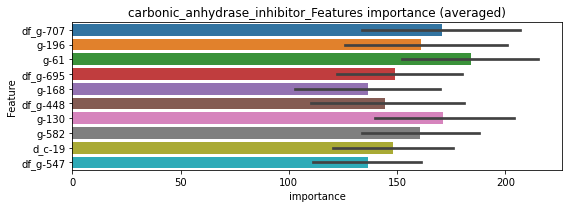

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466666	valid_1's binary_logloss: 0.0747995
[200]	training's binary_logloss: 0.013081	valid_1's binary_logloss: 0.0395015
[300]	training's binary_logloss: 0.00418138	valid_1's binary_logloss: 0.0260687
[400]	training's binary_logloss: 0.00179434	valid_1's binary_logloss: 0.020705
[500]	training's binary_logloss: 0.001069	valid_1's binary_logloss: 0.0190104
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00111525	valid_1's binary_logloss: 0.0189634


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433791	valid_1's binary_logloss: 0.0770889
[200]	training's binary_logloss: 0.0111051	valid_1's binary_logloss: 0.0409839
[300]	training's binary_logloss: 0.00362072	valid_1's binary_logloss: 0.0299886
[400]	training's binary_logloss: 0.00165488	valid_1's binary_logloss: 0.0266656
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00123515	valid_1's binary_logloss: 0.0258641


carbonic_anhydrase_inhibitor logloss: 0.022413328229444526


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802802	valid_1's binary_logloss: 0.118473
[200]	training's binary_logloss: 0.0260623	valid_1's binary_logloss: 0.0658327
[300]	training's binary_logloss: 0.00863184	valid_1's binary_logloss: 0.0402625
[400]	training's binary_logloss: 0.00373331	valid_1's binary_logloss: 0.0303352
[500]	training's binary_logloss: 0.00215941	valid_1's binary_logloss: 0.0254588
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00162516	valid_1's binary_logloss: 0.0230622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834076	valid_1's binary_logloss: 0.122168
[200]	training's binary_logloss: 0.0280404	valid_1's binary_logloss: 0.0697235
[300]	training's binary_logloss: 0.00843177	valid_1's binary_logloss: 0.0430951
[400]	training's binary_logloss: 0.00351587	valid_1's binary_logloss: 0.0352865
[500]	training's binary_logloss: 0.00203952	valid

1 / 3 AUC score:0.999
y_Threshold: 0.0318595, Threshold: 0.1545967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 651/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.13914, conf_1:0.17006
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1545967
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.1845967
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_3: 0.2145967
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.2445967
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.2745967
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.3045967
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.3345967
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_8: 0.3645967
threshold: 0.3645967, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3797, y_label_rate: 0.1714511
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651654	valid_1's binary_logloss: 0.109248
[200]	training's binary_logloss: 0.0165166	valid_1's binary_logloss: 0.0564363
[300]	training's binary_logloss: 0.00550272	valid_1's binary_logloss: 0.0400224
[400]	training's binary_logloss: 0.0025976	valid_1's binary_logloss: 0.0344142
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0025825	valid_1's binary_logloss: 0.0343977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686158	valid_1's binary_logloss: 0.108499
[200]	training's binary_logloss: 0.0179829	valid_1's binary_logloss: 0.0514901
[300]	training's binary_logloss: 0.00609998	valid_1's binary_logloss: 0.033948
[400]	training's binary_logloss: 0.00278759	valid_1's binary_logloss: 0.0273276
[500]	training's binary_logloss: 0.00173849	valid_1's binary_logloss: 0.0248066
Early stopping, best iteration is:
[545]	training's 

2 / 3 AUC score:0.998
y_Threshold: 0.1626852, Threshold: 0.3645967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 637.0/3769
p_label_rate: 0.0097941 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.32814, conf_1:0.40106
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.3645967
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_2: 0.3945967
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_3: 0.4245967
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_4: 0.4545967
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_5: 0.4845967
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_6: 0.5145967
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_7: 0.5445967
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.5745967
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.6045967
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_10: 0.6345967
threshold: 0.6645967, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 637.0/3769, y_label_rate: 0.1690103
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686196	valid_1's binary_logloss: 0.101966
[200]	training's binary_logloss: 0.0171784	valid_1's binary_logloss: 0.0437408
[300]	training's binary_logloss: 0.00538953	valid_1's binary_logloss: 0.0244321
[400]	training's binary_logloss: 0.00257551	valid_1's binary_logloss: 0.0184047
[500]	training's binary_logloss: 0.0016129	valid_1's binary_logloss: 0.0159983
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00144303	valid_1's binary_logloss: 0.0156618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657938	valid_1's binary_logloss: 0.0986705
[200]	training's binary_logloss: 0.0165589	valid_1's binary_logloss: 0.0421777
[300]	training's binary_logloss: 0.00543997	valid_1's binary_logloss: 0.0228051
[400]	training's binary_logloss: 0.00247477	valid_1's binary_logloss: 0.0151632
[500]	training's binary_logloss: 0.00158247	valid

3 / 3 AUC score:1.000
y_Threshold: 0.2163580, Threshold: 0.6645967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 633.0/3761
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.59814, conf_1:0.73106
threshold: 0.6645967, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 647.0/7743, y_label_rate: 0.0835593


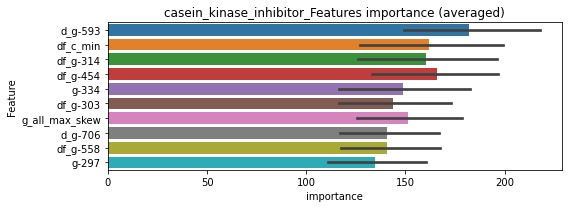

len(train_index) : 3871
len(valid_index) : 3872
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396226	valid_1's binary_logloss: 0.064915
[200]	training's binary_logloss: 0.0109723	valid_1's binary_logloss: 0.0331321
[300]	training's binary_logloss: 0.00345406	valid_1's binary_logloss: 0.0226177
[400]	training's binary_logloss: 0.00151872	valid_1's binary_logloss: 0.0189266
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000947399	valid_1's binary_logloss: 0.0173476


len(train_index) : 3872
len(valid_index) : 3871
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418347	valid_1's binary_logloss: 0.0595976
[200]	training's binary_logloss: 0.010626	valid_1's binary_logloss: 0.0264151
[300]	training's binary_logloss: 0.0033841	valid_1's binary_logloss: 0.0161669
[400]	training's binary_logloss: 0.00150095	valid_1's binary_logloss: 0.0129449
[500]	training's binary_logloss: 0.000919957	valid_1's binary_logloss: 0.0119251
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000865737	valid_1's binary_logloss: 0.011765


casein_kinase_inhibitor logloss: 0.014556642753936262


neg labels: 3289 → selected neg labels: 3288


caspase_activator, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446744	valid_1's binary_logloss: 0.0641825
[200]	training's binary_logloss: 0.00878711	valid_1's binary_logloss: 0.0203108
[300]	training's binary_logloss: 0.00287341	valid_1's binary_logloss: 0.0106005
[400]	training's binary_logloss: 0.00151175	valid_1's binary_logloss: 0.00766709
[500]	training's binary_logloss: 0.00105555	valid_1's binary_logloss: 0.00646454
[600]	training's binary_logloss: 0.000853721	valid_1's binary_logloss: 0.00601196
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000862753	valid_1's binary_logloss: 0.00600126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457086	valid_1's binary_logloss: 0.0696372
[200]	training's binary_logloss: 0.00868055	valid_1's binary_logloss: 0.0237052
[300]	training's binary_logloss: 0.002789	valid_1's binary_logloss: 0.01427
[400]	training's binary_logloss: 0.00145152

1 / 3 AUC score:1.000
y_Threshold: 0.0116286, Threshold: 0.1267493, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.11407, conf_1:0.13942
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1267493
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.1567493
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.1867493
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_4: 0.2167493
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_5: 0.2467493
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.2767493
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.3067493
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.3367493
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.3667493
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.3967493
threshold: 0.4267493, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411027	valid_1's binary_logloss: 0.0570901
[200]	training's binary_logloss: 0.00747829	valid_1's binary_logloss: 0.0152509
[300]	training's binary_logloss: 0.00237968	valid_1's binary_logloss: 0.00654569
[400]	training's binary_logloss: 0.00130612	valid_1's binary_logloss: 0.00424247
[500]	training's binary_logloss: 0.000924693	valid_1's binary_logloss: 0.00341907
[600]	training's binary_logloss: 0.000754387	valid_1's binary_logloss: 0.00301019
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.000689861	valid_1's binary_logloss: 0.00283691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417411	valid_1's binary_logloss: 0.0606212
[200]	training's binary_logloss: 0.00758611	valid_1's binary_logloss: 0.0183829
[300]	training's binary_logloss: 0.00244039	valid_1's binary_logloss: 0.0102056
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.2304282, Threshold: 0.4267493, pos_neg_ratio: 0.8000000


[500]	training's binary_logloss: 0.00091343	valid_1's binary_logloss: 0.00664578
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000876759	valid_1's binary_logloss: 0.0064423


Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0067805 Vs.target_rate: 0.00076, Num_p_label: 27.0, conf_0:0.38407, conf_1:0.46942
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_1: 0.4267493
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.4567493
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.4867493
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.5167493
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.5467493
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.5767493
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.6067493
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.6367493
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.6667493
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.6967493
threshold: 0.7267493, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3809, y_label_rate: 0.1719611
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404328	valid_1's binary_logloss: 0.0578175
[200]	training's binary_logloss: 0.00723879	valid_1's binary_logloss: 0.0163558
[300]	training's binary_logloss: 0.00242683	valid_1's binary_logloss: 0.00824449
[400]	training's binary_logloss: 0.00130136	valid_1's binary_logloss: 0.00584526
[500]	training's binary_logloss: 0.00091353	valid_1's binary_logloss: 0.00474219
[600]	training's binary_logloss: 0.000745804	valid_1's binary_logloss: 0.00423047
[700]	training's binary_logloss: 0.000667082	valid_1's binary_logloss: 0.00403163
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.000666099	valid_1's binary_logloss: 0.00403054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425878	valid_1's binary_logloss: 0.0582382
[200]	training's binary_logloss: 0.00746438	valid_1's binary_logloss: 0.0155513
[300]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1708403, Threshold: 0.7267493, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.65407, conf_1:0.79942
threshold: 0.7267493, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7791, y_label_rate: 0.0850982


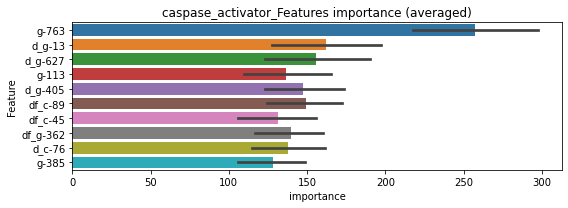

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253197	valid_1's binary_logloss: 0.0382117
[200]	training's binary_logloss: 0.004499	valid_1's binary_logloss: 0.0119983
[300]	training's binary_logloss: 0.00142067	valid_1's binary_logloss: 0.00682915


len(train_index) : 3896
len(valid_index) : 3895


[400]	training's binary_logloss: 0.000755118	valid_1's binary_logloss: 0.00555078
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000720165	valid_1's binary_logloss: 0.00551615


================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237409	valid_1's binary_logloss: 0.0389662
[200]	training's binary_logloss: 0.00429987	valid_1's binary_logloss: 0.01457
[300]	training's binary_logloss: 0.00136982	valid_1's binary_logloss: 0.00876097
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00108626	valid_1's binary_logloss: 0.00788595


caspase_activator logloss: 0.006700897959882054


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508216	valid_1's binary_logloss: 0.0713082
[200]	training's binary_logloss: 0.010372	valid_1's binary_logloss: 0.0250007
[300]	training's binary_logloss: 0.00312228	valid_1's binary_logloss: 0.0136234
[400]	training's binary_logloss: 0.00151209	valid_1's binary_logloss: 0.0096204
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00113549	valid_1's binary_logloss: 0.00862113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537509	valid_1's binary_logloss: 0.0750526
[200]	training's binary_logloss: 0.010402	valid_1's binary_logloss: 0.0232486
[300]	training's binary_logloss: 0.00317463	valid_1's binary_logloss: 0.012659
[400]	training's binary_logloss: 0.00155541	valid_1's binary_logloss: 0.00949554
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00122071	valid_1's binary_logloss: 0.00859979


1 / 3 AUC score:1.000
y_Threshold: 0.0130385, Threshold: 0.0751922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.06767, conf_1:0.08271
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0751922
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.1051922
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.1351922
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.1651922
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.1951922
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.2251922
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.2551922
threshold: 0.2551922, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468979	valid_1's binary_logloss: 0.0627302
[200]	training's binary_logloss: 0.00808252	valid_1's binary_logloss: 0.0161592
[300]	training's binary_logloss: 0.00251205	valid_1's binary_logloss: 0.00749724
[400]	training's binary_logloss: 0.00128835	valid_1's binary_logloss: 0.00484603
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00128835	valid_1's binary_logloss: 0.00484603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460914	valid_1's binary_logloss: 0.0694112
[200]	training's binary_logloss: 0.00824573	valid_1's binary_logloss: 0.0209909
[300]	training's binary_logloss: 0.00250301	valid_1's binary_logloss: 0.0111942
[400]	training's binary_logloss: 0.00128139	valid_1's binary_logloss: 0.00839814


2 / 3 AUC score:1.000
y_Threshold: 0.2438900, Threshold: 0.2551922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0085384 Vs.target_rate: 0.00076, Num_p_label: 34.0, conf_0:0.22967, conf_1:0.28071
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_1: 0.2551922
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.2851922
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.3151922
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.3451922
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.3751922
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.4051922


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0010048	valid_1's binary_logloss: 0.00768617


Num_p_label: 13.0, Expected: 3.0, Adj_threshold_7: 0.4351922
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.4651922
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.4951922
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_10: 0.5251922
threshold: 0.5551922, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468979	valid_1's binary_logloss: 0.0627302
[200]	training's binary_logloss: 0.00808252	valid_1's binary_logloss: 0.0161592
[300]	training's binary_logloss: 0.00251205	valid_1's binary_logloss: 0.00749724
[400]	training's binary_logloss: 0.00128835	valid_1's binary_logloss: 0.00484603
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00128835	valid_1's binary_logloss: 0.00484603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460914	valid_1's binary_logloss: 0.0694112
[200]	training's binary_logloss: 0.00824573	valid_1's binary_logloss: 0.0209909
[300]	training's binary_logloss: 0.00250301	valid_1's binary_logloss: 0.0111942
[400]	training's binary_logloss: 0.00128139	valid_1's binary_logloss: 0.00839814


3 / 3 AUC score:1.000
y_Threshold: 0.2438900, Threshold: 0.5551922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.49967, conf_1:0.61071
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.5551922
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.5851922
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.6151922
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.6451922
threshold: 0.6451922, positive_p_label: 6.0/3982, p_label_rate: 0.0015068


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0010048	valid_1's binary_logloss: 0.00768617


positive_y_label: 663.0/7793, y_label_rate: 0.0850764


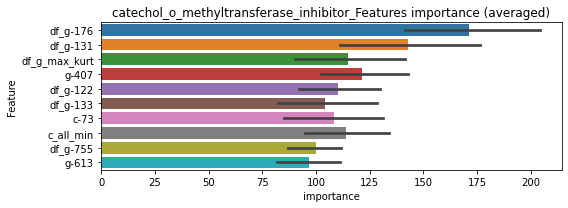

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281306	valid_1's binary_logloss: 0.0419287
[200]	training's binary_logloss: 0.00532025	valid_1's binary_logloss: 0.0144776
[300]	training's binary_logloss: 0.00147961	valid_1's binary_logloss: 0.00816361
[400]	training's binary_logloss: 0.000735056	valid_1's binary_logloss: 0.00660321
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000605301	valid_1's binary_logloss: 0.00631298


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291765	valid_1's binary_logloss: 0.039659
[200]	training's binary_logloss: 0.005435	valid_1's binary_logloss: 0.0117444
[300]	training's binary_logloss: 0.00154088	valid_1's binary_logloss: 0.00540705
[400]	training's binary_logloss: 0.000773306	valid_1's binary_logloss: 0.00403648
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.0005406	valid_1's binary_logloss: 0.00357486


catechol_o_methyltransferase_inhibitor logloss: 0.004944092080513638


neg labels: 3289 → selected neg labels: 3276


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3276, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110877	valid_1's binary_logloss: 0.215015
[200]	training's binary_logloss: 0.0472613	valid_1's binary_logloss: 0.170934
[300]	training's binary_logloss: 0.0211752	valid_1's binary_logloss: 0.156088
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0128472	valid_1's binary_logloss: 0.149543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120325	valid_1's binary_logloss: 0.181131
[200]	training's binary_logloss: 0.0546923	valid_1's binary_logloss: 0.139927
[300]	training's binary_logloss: 0.0233497	valid_1's binary_logloss: 0.116601
[400]	training's binary_logloss: 0.0109874	valid_1's binary_logloss: 0.108959
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00741829	valid_1's binary_logloss: 0.106438


1 / 3 AUC score:0.974
y_Threshold: 0.0601307, Threshold: 0.3573178, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 240 → Positive_corect_labels: 601/3691
p_label_rate: 0.0100452 Vs.target_rate: 0.00428, Num_p_label: 40.0, conf_0:0.32159, conf_1:0.39305
threshold: 0.3573178, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 601.0/3691, y_label_rate: 0.1628285
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884748	valid_1's binary_logloss: 0.165621
[200]	training's binary_logloss: 0.032612	valid_1's binary_logloss: 0.121202
[300]	training's binary_logloss: 0.0136034	valid_1's binary_logloss: 0.104319
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00835572	valid_1's binary_logloss: 0.0998362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100845	valid_1's binary_logloss: 0.152661
[200]	training's binary_logloss: 0.0387209	valid_1's binary_logloss: 0.10317
[300]	training's binary_logloss: 0.015658	valid_1's binary_logloss: 0.0835074
[400]	training's binary_logloss: 0.0070594	valid_1's binary_logloss: 0.0749303
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00507314	valid_1's binary_logloss: 0.0723163


2 / 3 AUC score:0.990
y_Threshold: 0.0957267, Threshold: 0.3573178, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 559.0/3607
p_label_rate: 0.0135610 Vs.target_rate: 0.00428, Num_p_label: 54.0, conf_0:0.32159, conf_1:0.39305
Num_p_label: 54.0, Expected: 17.1, Adj_threshold_1: 0.3573178
Num_p_label: 50.0, Expected: 17.1, Adj_threshold_2: 0.3873178
Num_p_label: 44.0, Expected: 17.1, Adj_threshold_3: 0.4173178
Num_p_label: 38.0, Expected: 17.1, Adj_threshold_4: 0.4473178
Num_p_label: 32.0, Expected: 17.1, Adj_threshold_5: 0.4773178
threshold: 0.4773178, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 559.0/3607, y_label_rate: 0.1549764
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771949	valid_1's binary_logloss: 0.13154
[200]	training's binary_logloss: 0.0262715	valid_1's binary_logloss: 0.0845056
[300]	training's binary_logloss: 0.010346	valid_1's binary_logloss: 0.0690981
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00542242	valid_1's binary_logloss: 0.0636613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880677	valid_1's binary_logloss: 0.123041
[200]	training's binary_logloss: 0.0304173	valid_1's binary_logloss: 0.0715733
[300]	training's binary_logloss: 0.0115168	valid_1's binary_logloss: 0.0508332
[400]	training's binary_logloss: 0.00546095	valid_1's binary_logloss: 0.0419234
[500]	training's binary_logloss: 0.00316269	valid_1's binary_logloss: 0.0365463
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00243182	valid_1's binary_logloss: 0.0347839


3 / 3 AUC score:0.999
y_Threshold: 0.1018140, Threshold: 0.4773178, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 540.0/3569
p_label_rate: 0.0095429 Vs.target_rate: 0.00428, Num_p_label: 38.0, conf_0:0.42959, conf_1:0.52505
threshold: 0.4773178, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 578.0/7551, y_label_rate: 0.0765462


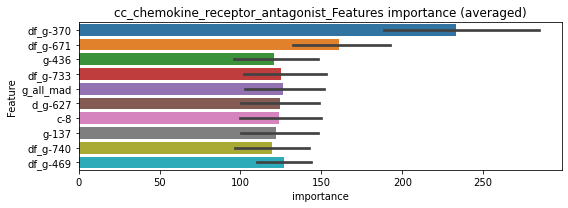

len(train_index) : 3775
len(valid_index) : 3776
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451319	valid_1's binary_logloss: 0.0812546
[200]	training's binary_logloss: 0.0162624	valid_1's binary_logloss: 0.0557717
[300]	training's binary_logloss: 0.00665686	valid_1's binary_logloss: 0.0446412
[400]	training's binary_logloss: 0.00312116	valid_1's binary_logloss: 0.039833
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00209972	valid_1's binary_logloss: 0.0384967


len(train_index) : 3776
len(valid_index) : 3775
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458825	valid_1's binary_logloss: 0.0849934
[200]	training's binary_logloss: 0.0158465	valid_1's binary_logloss: 0.0617879


cc_chemokine_receptor_antagonist logloss: 0.04702171066209751


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00693243	valid_1's binary_logloss: 0.055549
neg labels: 3289 → selected neg labels: 3288


cck_receptor_antagonist, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551267	valid_1's binary_logloss: 0.0846329
[200]	training's binary_logloss: 0.0122698	valid_1's binary_logloss: 0.0327957
[300]	training's binary_logloss: 0.00369017	valid_1's binary_logloss: 0.0179295
[400]	training's binary_logloss: 0.0018118	valid_1's binary_logloss: 0.0139069
[500]	training's binary_logloss: 0.00124174	valid_1's binary_logloss: 0.0128881
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00120582	valid_1's binary_logloss: 0.0126606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600697	valid_1's binary_logloss: 0.0890752
[200]	training's binary_logloss: 0.0132472	valid_1's binary_logloss: 0.0320774
[300]	training's binary_logloss: 0.0037525	valid_1's binary_logloss: 0.0161058
[400]	training's binary_logloss: 0.00182238	valid_1's binary_logloss: 0.0120243
[500]	training's binary_logloss: 0.00124664	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0190489, Threshold: 0.1015712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.09141, conf_1:0.11173
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1015712
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.1315712
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.1615712
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.1915712
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.2215712
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.2515712
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.2815712
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.3115712
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.3415712
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_10: 0.3715712
threshold: 0.3715712, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438876	valid_1's binary_logloss: 0.0716973
[200]	training's binary_logloss: 0.00886743	valid_1's binary_logloss: 0.0255109
[300]	training's binary_logloss: 0.00284578	valid_1's binary_logloss: 0.0139719
[400]	training's binary_logloss: 0.00146721	valid_1's binary_logloss: 0.0108824
[500]	training's binary_logloss: 0.001025	valid_1's binary_logloss: 0.00974653
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00104704	valid_1's binary_logloss: 0.0097012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536433	valid_1's binary_logloss: 0.075011
[200]	training's binary_logloss: 0.0107088	valid_1's binary_logloss: 0.0229364
[300]	training's binary_logloss: 0.00316845	valid_1's binary_logloss: 0.0103764
[400]	training's binary_logloss: 0.00160894	valid_1's binary_logloss: 0.00691037
[500]	training's binary_logloss: 0.00110056	val

2 / 3 AUC score:1.000
y_Threshold: 0.2417861, Threshold: 0.3715712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00076, Num_p_label: 31.0, conf_0:0.33441, conf_1:0.40873
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_1: 0.3715712
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.4015712
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.4315712
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_4: 0.4615712
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.4915712
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.5215712
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.5515712
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.5815712
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.6115712
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.6415712
threshold: 0.6715712, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479076	valid_1's binary_logloss: 0.0705457
[200]	training's binary_logloss: 0.00950561	valid_1's binary_logloss: 0.0216491
[300]	training's binary_logloss: 0.00302411	valid_1's binary_logloss: 0.0108591
[400]	training's binary_logloss: 0.00153958	valid_1's binary_logloss: 0.00784135
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00149435	valid_1's binary_logloss: 0.0076571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492653	valid_1's binary_logloss: 0.0782915
[200]	training's binary_logloss: 0.00952653	valid_1's binary_logloss: 0.0279987
[300]	training's binary_logloss: 0.00302245	valid_1's binary_logloss: 0.0163132
[400]	training's binary_logloss: 0.00155429	valid_1's binary_logloss: 0.0125164


3 / 3 AUC score:1.000
y_Threshold: 0.2181717, Threshold: 0.6715712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.60441, conf_1:0.73873
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.6715712
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.7015712
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.7315712
threshold: 0.7315712, positive_p_label: 6.0/3982, p_label_rate: 0.0015068


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00119206	valid_1's binary_logloss: 0.0117284


positive_y_label: 660.0/7789, y_label_rate: 0.0847349


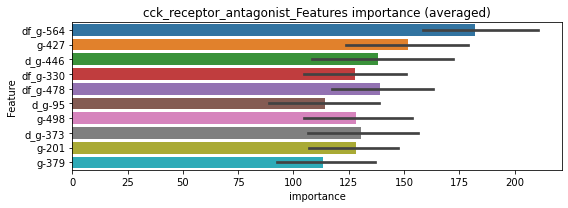

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324751	valid_1's binary_logloss: 0.0467946
[200]	training's binary_logloss: 0.00671222	valid_1's binary_logloss: 0.0159599
[300]	training's binary_logloss: 0.00197472	valid_1's binary_logloss: 0.00895025
[400]	training's binary_logloss: 0.000950696	valid_1's binary_logloss: 0.00748957
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000861949	valid_1's binary_logloss: 0.00732759


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030708	valid_1's binary_logloss: 0.0433508
[200]	training's binary_logloss: 0.00626761	valid_1's binary_logloss: 0.0143099
[300]	training's binary_logloss: 0.00179138	valid_1's binary_logloss: 0.0070061
[400]	training's binary_logloss: 0.000892645	valid_1's binary_logloss: 0.0050228
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000744521	valid_1's binary_logloss: 0.0046192


cck_receptor_antagonist logloss: 0.0059735682269713595


neg labels: 3289 → selected neg labels: 3241


cdk_inhibitor, len(trt): 352, len(othr): 3241, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.270767	valid_1's binary_logloss: 0.416356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240963	valid_1's binary_logloss: 0.410339


1 / 3 AUC score:0.698
y_Threshold: 0.2072224, Threshold: 0.3807064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 834 → Positive_corect_labels: 296/3055
p_label_rate: 0.0100452 Vs.target_rate: 0.01478, Num_p_label: 40.0, conf_0:0.34264, conf_1:0.41878
threshold: 0.3807064, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 296.0/3055, y_label_rate: 0.0968903
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.160965	valid_1's binary_logloss: 0.397817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889869	valid_1's binary_logloss: 0.235423
[200]	training's binary_logloss: 0.0366334	valid_1's binary_logloss: 0.223622
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0304169	valid_1's binary_logloss: 0.222609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961145	valid_1's binary_logloss: 0.23443


2 / 3 AUC score:0.870
y_Threshold: 0.1247549, Threshold: 0.3807064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 248 → Positive_corect_labels: 172.0/2807
p_label_rate: 0.0226017 Vs.target_rate: 0.01478, Num_p_label: 90.0, conf_0:0.34264, conf_1:0.41878
threshold: 0.3807064, positive_p_label: 90.0/3982, p_label_rate: 0.0226017


[200]	training's binary_logloss: 0.0393728	valid_1's binary_logloss: 0.221468
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0364111	valid_1's binary_logloss: 0.220222


positive_y_label: 172.0/2807, y_label_rate: 0.0612754
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429897	valid_1's binary_logloss: 0.128318
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0281615	valid_1's binary_logloss: 0.122579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395096	valid_1's binary_logloss: 0.123704


3 / 3 AUC score:0.956
y_Threshold: 0.1118398, Threshold: 0.3807064, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 119.0/2701
p_label_rate: 0.0313913 Vs.target_rate: 0.01478, Num_p_label: 125.0, conf_0:0.34264, conf_1:0.41878
threshold: 0.3807064, positive_p_label: 125.0/3982, p_label_rate: 0.0313913
positive_y_label: 244.0/6683, y_label_rate: 0.0365105


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0175091	valid_1's binary_logloss: 0.114231


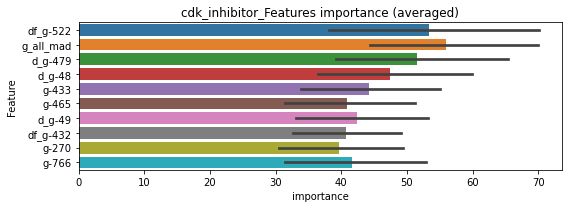

len(train_index) : 3341
len(valid_index) : 3342
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3342
len(valid_index) : 3341
================================= fold 2/2 cdk_inhibitor=================================


[100]	training's binary_logloss: 0.0179352	valid_1's binary_logloss: 0.0776908
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0132411	valid_1's binary_logloss: 0.0768762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023184	valid_1's binary_logloss: 0.0562533


cdk_inhibitor logloss: 0.06230786938049555


[200]	training's binary_logloss: 0.00759642	valid_1's binary_logloss: 0.0477761
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00751012	valid_1's binary_logloss: 0.0477351
neg labels: 3289 → selected neg labels: 3282


chelating_agent, len(trt): 54, len(othr): 3282, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962543	valid_1's binary_logloss: 0.15788
[200]	training's binary_logloss: 0.0334577	valid_1's binary_logloss: 0.097403
[300]	training's binary_logloss: 0.0125161	valid_1's binary_logloss: 0.0731519
[400]	training's binary_logloss: 0.00554652	valid_1's binary_logloss: 0.0610837
[500]	training's binary_logloss: 0.00309545	valid_1's binary_logloss: 0.0561559
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00273829	valid_1's binary_logloss: 0.0555973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108003	valid_1's binary_logloss: 0.147886
[200]	training's binary_logloss: 0.0394843	valid_1's binary_logloss: 0.0820382
[300]	training's binary_logloss: 0.0152434	valid_1's binary_logloss: 0.0522976
[400]	training's binary_logloss: 0.0068759	valid_1's binary_logloss: 0.0389441
[500]	training's binary_logloss: 0.0037271	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0371012, Threshold: 0.3692557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3788
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.33233, conf_1:0.40618
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.3692557
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_2: 0.3992557
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_3: 0.4292557
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_4: 0.4592557
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_5: 0.4892557
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_6: 0.5192557
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_7: 0.5492557
threshold: 0.5492557, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3788, y_label_rate: 0.1708025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949082	valid_1's binary_logloss: 0.139181
[200]	training's binary_logloss: 0.0318697	valid_1's binary_logloss: 0.0740173
[300]	training's binary_logloss: 0.0116275	valid_1's binary_logloss: 0.0490632
[400]	training's binary_logloss: 0.0050857	valid_1's binary_logloss: 0.0378632
[500]	training's binary_logloss: 0.00294459	valid_1's binary_logloss: 0.0328042
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00213144	valid_1's binary_logloss: 0.0305199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879276	valid_1's binary_logloss: 0.132918
[200]	training's binary_logloss: 0.0289723	valid_1's binary_logloss: 0.0694221
[300]	training's binary_logloss: 0.010465	valid_1's binary_logloss: 0.0460106
[400]	training's binary_logloss: 0.0047211	valid_1's binary_logloss: 0.0367178
Early stopping, best iteration is:
[457]	training's bi

2 / 3 AUC score:0.999
y_Threshold: 0.1372596, Threshold: 0.5492557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 636.0/3766
p_label_rate: 0.0188348 Vs.target_rate: 0.00227, Num_p_label: 75.0, conf_0:0.49433, conf_1:0.60418
Num_p_label: 75.0, Expected: 9.0, Adj_threshold_1: 0.5492557
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_2: 0.5792557
Num_p_label: 62.0, Expected: 9.0, Adj_threshold_3: 0.6092557
Num_p_label: 58.0, Expected: 9.0, Adj_threshold_4: 0.6392557
Num_p_label: 55.0, Expected: 9.0, Adj_threshold_5: 0.6692557
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_6: 0.6992557
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_7: 0.7292557
Num_p_label: 36.0, Expected: 9.0, Adj_threshold_8: 0.7592557
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_9: 0.7892557
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_10: 0.8192557
threshold: 0.8492557, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 636.0/3766, y_label_rate: 0.1688794
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891742	valid_1's binary_logloss: 0.141803
[200]	training's binary_logloss: 0.0273396	valid_1's binary_logloss: 0.0764922
[300]	training's binary_logloss: 0.0104523	valid_1's binary_logloss: 0.053965
[400]	training's binary_logloss: 0.00463174	valid_1's binary_logloss: 0.0434779
[500]	training's binary_logloss: 0.00266465	valid_1's binary_logloss: 0.0387781
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00244534	valid_1's binary_logloss: 0.0382073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875161	valid_1's binary_logloss: 0.125718
[200]	training's binary_logloss: 0.0287861	valid_1's binary_logloss: 0.0635951
[300]	training's binary_logloss: 0.0109127	valid_1's binary_logloss: 0.0396601
[400]	training's binary_logloss: 0.00475447	valid_1's binary_logloss: 0.0271381
[500]	training's binary_logloss: 0.00279159	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.1456128, Threshold: 0.8492557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 628.0/3750
p_label_rate: 0.0072828 Vs.target_rate: 0.00227, Num_p_label: 29.0, conf_0:0.76433, conf_1:0.93418
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_1: 0.8492557
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_2: 0.8792557
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_3: 0.9092557
threshold: 0.9092557, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 646.0/7732, y_label_rate: 0.0835489


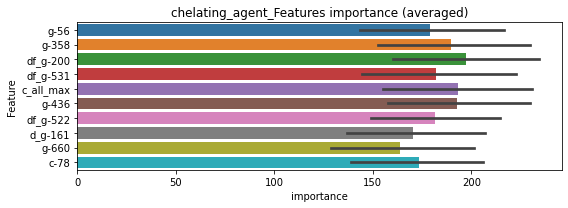

len(train_index) : 3866
len(valid_index) : 3866
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555897	valid_1's binary_logloss: 0.0831952
[200]	training's binary_logloss: 0.0192326	valid_1's binary_logloss: 0.0462509
[300]	training's binary_logloss: 0.00725869	valid_1's binary_logloss: 0.0312359
[400]	training's binary_logloss: 0.00333411	valid_1's binary_logloss: 0.0248211
[500]	training's binary_logloss: 0.00179315	valid_1's binary_logloss: 0.0214188
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0015952	valid_1's binary_logloss: 0.0209125


len(train_index) : 3866
len(valid_index) : 3866
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548087	valid_1's binary_logloss: 0.0860459
[200]	training's binary_logloss: 0.0181269	valid_1's binary_logloss: 0.0469705
[300]	training's binary_logloss: 0.00665325	valid_1's binary_logloss: 0.0322095
[400]	training's binary_logloss: 0.00301593	valid_1's binary_logloss: 0.0258556
[500]	training's binary_logloss: 0.00171635	valid_1's binary_logloss: 0.0235386
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00166018	valid_1's binary_logloss: 0.0234427


chelating_agent logloss: 0.022177626585596723


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563876	valid_1's binary_logloss: 0.0906658
[200]	training's binary_logloss: 0.0133663	valid_1's binary_logloss: 0.0381301
[300]	training's binary_logloss: 0.00436376	valid_1's binary_logloss: 0.0221069
[400]	training's binary_logloss: 0.00214517	valid_1's binary_logloss: 0.0166203
[500]	training's binary_logloss: 0.00142644	valid_1's binary_logloss: 0.0150805
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00144538	valid_1's binary_logloss: 0.0149999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576984	valid_1's binary_logloss: 0.0935973
[200]	training's binary_logloss: 0.0141195	valid_1's binary_logloss: 0.040896
[300]	training's binary_logloss: 0.00443349	valid_1's binary_logloss: 0.0235275
[400]	training's binary_logloss: 0.00219458	valid_1's binary_logloss: 0.0183143
[500]	training's binary_logloss: 0.00145495	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0213716, Threshold: 0.1820479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.16384, conf_1:0.20025
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1820479
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_2: 0.2120479
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_3: 0.2420479
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_4: 0.2720479
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_5: 0.3020479
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_6: 0.3320479
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_7: 0.3620479
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_8: 0.3920479
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.4220479
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_10: 0.4520479
threshold: 0.4820479, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494627	valid_1's binary_logloss: 0.0844112
[200]	training's binary_logloss: 0.0106416	valid_1's binary_logloss: 0.0325956
[300]	training's binary_logloss: 0.00352429	valid_1's binary_logloss: 0.0186444
[400]	training's binary_logloss: 0.00177559	valid_1's binary_logloss: 0.013421
[500]	training's binary_logloss: 0.00120912	valid_1's binary_logloss: 0.011469
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00101131	valid_1's binary_logloss: 0.0106879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505718	valid_1's binary_logloss: 0.0787388
[200]	training's binary_logloss: 0.0106911	valid_1's binary_logloss: 0.02993
[300]	training's binary_logloss: 0.00346724	valid_1's binary_logloss: 0.0171382
[400]	training's binary_logloss: 0.0017744	valid_1's binary_logloss: 0.0127746
[500]	training's binary_logloss: 0.0012017	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.4185586, Threshold: 0.4820479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0133099 Vs.target_rate: 0.00101, Num_p_label: 53.0, conf_0:0.43384, conf_1:0.53025
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_1: 0.4820479
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_2: 0.5120479
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_3: 0.5420479
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_4: 0.5720479
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_5: 0.6020479
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_6: 0.6320479
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_7: 0.6620479
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_8: 0.6920479
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_9: 0.7220479
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_10: 0.7520479
threshold: 0.7820479, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500947	valid_1's binary_logloss: 0.0720271
[200]	training's binary_logloss: 0.0105749	valid_1's binary_logloss: 0.0248918
[300]	training's binary_logloss: 0.00352912	valid_1's binary_logloss: 0.0127181
[400]	training's binary_logloss: 0.00179497	valid_1's binary_logloss: 0.00874398
[500]	training's binary_logloss: 0.0012337	valid_1's binary_logloss: 0.0074385
[600]	training's binary_logloss: 0.00100829	valid_1's binary_logloss: 0.00672553
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.000937535	valid_1's binary_logloss: 0.00646787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495679	valid_1's binary_logloss: 0.0856599
[200]	training's binary_logloss: 0.0101033	valid_1's binary_logloss: 0.0359783
[300]	training's binary_logloss: 0.00331015	valid_1's binary_logloss: 0.021109


3 / 3 AUC score:1.000
y_Threshold: 0.2984562, Threshold: 0.7820479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0062783 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.70384, conf_1:0.86025
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.7820479
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.8120479
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.8420479
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_4: 0.8720479
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.9020479
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.9320479


[400]	training's binary_logloss: 0.00170625	valid_1's binary_logloss: 0.0162016
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00170625	valid_1's binary_logloss: 0.0162016


threshold: 0.9320479, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/7778, y_label_rate: 0.0844690


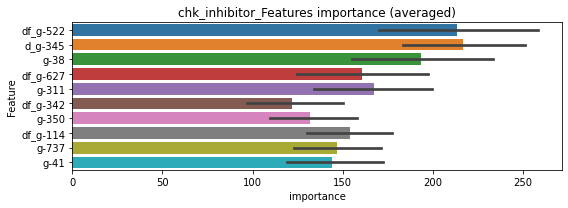

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276407	valid_1's binary_logloss: 0.046677
[200]	training's binary_logloss: 0.00596362	valid_1's binary_logloss: 0.0196106
[300]	training's binary_logloss: 0.00188976	valid_1's binary_logloss: 0.0118111
[400]	training's binary_logloss: 0.000988287	valid_1's binary_logloss: 0.00952561
[500]	training's binary_logloss: 0.000700344	valid_1's binary_logloss: 0.00862479
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000656943	valid_1's binary_logloss: 0.00852057


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302939	valid_1's binary_logloss: 0.0517543
[200]	training's binary_logloss: 0.00630026	valid_1's binary_logloss: 0.0205875
[300]	training's binary_logloss: 0.00209482	valid_1's binary_logloss: 0.0127042
[400]	training's binary_logloss: 0.00104008	valid_1's binary_logloss: 0.00915127
[500]	training's binary_logloss: 0.000719252	valid_1's binary_logloss: 0.00808165
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000696026	valid_1's binary_logloss: 0.00798219


chk_inhibitor logloss: 0.008251382008933163


neg labels: 3289 → selected neg labels: 3284


chloride_channel_blocker, len(trt): 42, len(othr): 3284, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103824	valid_1's binary_logloss: 0.164524
[200]	training's binary_logloss: 0.0348268	valid_1's binary_logloss: 0.0981142
[300]	training's binary_logloss: 0.012344	valid_1's binary_logloss: 0.0712154
[400]	training's binary_logloss: 0.00535386	valid_1's binary_logloss: 0.0582202
[500]	training's binary_logloss: 0.00301617	valid_1's binary_logloss: 0.0519167
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00252476	valid_1's binary_logloss: 0.0503809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104263	valid_1's binary_logloss: 0.154744
[200]	training's binary_logloss: 0.038964	valid_1's binary_logloss: 0.0878126
[300]	training's binary_logloss: 0.0131847	valid_1's binary_logloss: 0.0547578
[400]	training's binary_logloss: 0.00547699	valid_1's binary_logloss: 0.0420726
[500]	training's binary_logloss: 0.00300763	valid_1's b

1 / 3 AUC score:0.998
y_Threshold: 0.0433674, Threshold: 0.2667260, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.24005, conf_1:0.29340
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.2667260
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.2967260
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_3: 0.3267260
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.3567260
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.3867260
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.4167260
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_7: 0.4467260
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_8: 0.4767260
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_9: 0.5067260
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_10: 0.5367260
threshold: 0.5367260, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944542	valid_1's binary_logloss: 0.152115
[200]	training's binary_logloss: 0.0277597	valid_1's binary_logloss: 0.092481
[300]	training's binary_logloss: 0.00948411	valid_1's binary_logloss: 0.0743751
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00481066	valid_1's binary_logloss: 0.0685558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935024	valid_1's binary_logloss: 0.141313
[200]	training's binary_logloss: 0.0276903	valid_1's binary_logloss: 0.0691849
[300]	training's binary_logloss: 0.00931341	valid_1's binary_logloss: 0.0410306
[400]	training's binary_logloss: 0.00412745	valid_1's binary_logloss: 0.0292892
[500]	training's binary_logloss: 0.00241132	valid_1's binary_logloss: 0.0245558
[600]	training's binary_logloss: 0.0017217	valid_1's binary_logloss: 0.0222123
[700]	training's binary_logloss: 0.00141077	valid_1

2 / 3 AUC score:0.997
y_Threshold: 0.1532502, Threshold: 0.5367260, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 625.0/3746
p_label_rate: 0.0113009 Vs.target_rate: 0.00176, Num_p_label: 45.0, conf_0:0.48305, conf_1:0.59040
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_1: 0.5367260
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_2: 0.5667260
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_3: 0.5967260
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_4: 0.6267260
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_5: 0.6567260
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_6: 0.6867260
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_7: 0.7167260
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_8: 0.7467260
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_9: 0.7767260
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_10: 0.8067260
threshold: 0.8367260, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 625.0/3746, y_label_rate: 0.1668446
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945627	valid_1's binary_logloss: 0.132651
[200]	training's binary_logloss: 0.0280567	valid_1's binary_logloss: 0.0619477
[300]	training's binary_logloss: 0.00923586	valid_1's binary_logloss: 0.0337481
[400]	training's binary_logloss: 0.00398514	valid_1's binary_logloss: 0.0221345
[500]	training's binary_logloss: 0.00232405	valid_1's binary_logloss: 0.0175719
[600]	training's binary_logloss: 0.00168983	valid_1's binary_logloss: 0.0154293
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00150441	valid_1's binary_logloss: 0.0148507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868813	valid_1's binary_logloss: 0.133571
[200]	training's binary_logloss: 0.0234152	valid_1's binary_logloss: 0.0644355
[300]	training's binary_logloss: 0.00777103	valid_1's binary_logloss: 0.0414066
[400]	training's binary_logloss: 0.00366829	valid

3 / 3 AUC score:0.999
y_Threshold: 0.2352049, Threshold: 0.8367260, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 619.0/3734
p_label_rate: 0.0062783 Vs.target_rate: 0.00176, Num_p_label: 25.0, conf_0:0.75305, conf_1:0.92040
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_1: 0.8367260
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.8667260
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_3: 0.8967260
threshold: 0.8967260, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 632.0/7716, y_label_rate: 0.0819077


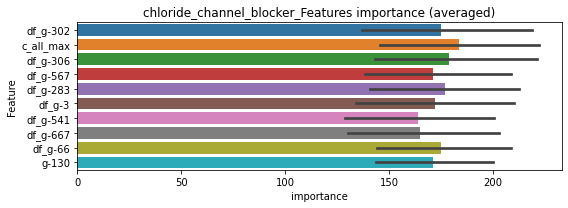

len(train_index) : 3858
len(valid_index) : 3858
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598642	valid_1's binary_logloss: 0.0841074
[200]	training's binary_logloss: 0.018232	valid_1's binary_logloss: 0.0441428
[300]	training's binary_logloss: 0.00640015	valid_1's binary_logloss: 0.0295272
[400]	training's binary_logloss: 0.00277909	valid_1's binary_logloss: 0.0231163
[500]	training's binary_logloss: 0.00153208	valid_1's binary_logloss: 0.0211903
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00121625	valid_1's binary_logloss: 0.0201329


len(train_index) : 3858
len(valid_index) : 3858
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543482	valid_1's binary_logloss: 0.0820577
[200]	training's binary_logloss: 0.017275	valid_1's binary_logloss: 0.0420105
[300]	training's binary_logloss: 0.00596507	valid_1's binary_logloss: 0.0260896
[400]	training's binary_logloss: 0.00263043	valid_1's binary_logloss: 0.0197911
[500]	training's binary_logloss: 0.00145882	valid_1's binary_logloss: 0.0168254
[600]	training's binary_logloss: 0.00101492	valid_1's binary_logloss: 0.0156858
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000850243	valid_1's binary_logloss: 0.0151702


chloride_channel_blocker logloss: 0.01765157381058523


neg labels: 3289 → selected neg labels: 3288


cholesterol_inhibitor, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959858	valid_1's binary_logloss: 0.148339
[200]	training's binary_logloss: 0.0301113	valid_1's binary_logloss: 0.0851698
[300]	training's binary_logloss: 0.0110767	valid_1's binary_logloss: 0.0625844
[400]	training's binary_logloss: 0.004633	valid_1's binary_logloss: 0.0510121
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00323643	valid_1's binary_logloss: 0.0483871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968507	valid_1's binary_logloss: 0.132434
[200]	training's binary_logloss: 0.0312986	valid_1's binary_logloss: 0.0673605
[300]	training's binary_logloss: 0.0113011	valid_1's binary_logloss: 0.0424797
[400]	training's binary_logloss: 0.0050002	valid_1's binary_logloss: 0.0308546
[500]	training's binary_logloss: 0.00282128	valid_1's binary_logloss: 0.0262826
Early stopping, best iteration is:
[534]	training's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0342464, Threshold: 0.1798138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 650/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.16183, conf_1:0.19780
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1798138
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.2098138
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_3: 0.2398138
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.2698138
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.2998138
threshold: 0.2998138, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 650.0/3799, y_label_rate: 0.1710977
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888526	valid_1's binary_logloss: 0.138422
[200]	training's binary_logloss: 0.0269193	valid_1's binary_logloss: 0.0795314
[300]	training's binary_logloss: 0.00915827	valid_1's binary_logloss: 0.0597367
[400]	training's binary_logloss: 0.00400688	valid_1's binary_logloss: 0.0505877
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00315018	valid_1's binary_logloss: 0.0487058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793093	valid_1's binary_logloss: 0.116374
[200]	training's binary_logloss: 0.0238532	valid_1's binary_logloss: 0.056627
[300]	training's binary_logloss: 0.00816478	valid_1's binary_logloss: 0.033912
[400]	training's binary_logloss: 0.00372598	valid_1's binary_logloss: 0.0241367
[500]	training's binary_logloss: 0.00225741	valid_1's binary_logloss: 0.0209553
[600]	training's binary_logloss: 0.00165175	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.0954083, Threshold: 0.2998138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 639.0/3777
p_label_rate: 0.0095429 Vs.target_rate: 0.00202, Num_p_label: 38.0, conf_0:0.26983, conf_1:0.32980
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_1: 0.2998138
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.3298138
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_3: 0.3598138
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.3898138
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.4198138
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.4498138
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_7: 0.4798138
threshold: 0.4798138, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 639.0/3777, y_label_rate: 0.1691819
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827202	valid_1's binary_logloss: 0.115359
[200]	training's binary_logloss: 0.02445	valid_1's binary_logloss: 0.0546471
[300]	training's binary_logloss: 0.00847183	valid_1's binary_logloss: 0.0317896
[400]	training's binary_logloss: 0.00390281	valid_1's binary_logloss: 0.0223099
[500]	training's binary_logloss: 0.00230406	valid_1's binary_logloss: 0.0181751
[600]	training's binary_logloss: 0.00166314	valid_1's binary_logloss: 0.0159208
[700]	training's binary_logloss: 0.0013467	valid_1's binary_logloss: 0.0148642
[800]	training's binary_logloss: 0.00118387	valid_1's binary_logloss: 0.0142112
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00118831	valid_1's binary_logloss: 0.0141736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809797	valid_1's binary_logloss: 0.121756
[200]	training's binary_logloss: 0.0226569	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.1752504, Threshold: 0.4798138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 633.0/3765
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.43183, conf_1:0.52780
threshold: 0.4798138, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/7747, y_label_rate: 0.0839034


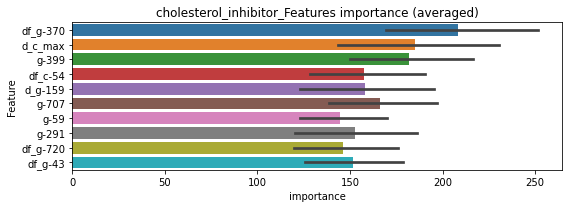

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475811	valid_1's binary_logloss: 0.0775553
[200]	training's binary_logloss: 0.0144081	valid_1's binary_logloss: 0.04396
[300]	training's binary_logloss: 0.00486896	valid_1's binary_logloss: 0.032425
[400]	training's binary_logloss: 0.00218581	valid_1's binary_logloss: 0.0277224
[500]	training's binary_logloss: 0.00127003	valid_1's binary_logloss: 0.025236
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00115111	valid_1's binary_logloss: 0.0249209


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518515	valid_1's binary_logloss: 0.0753181
[200]	training's binary_logloss: 0.0150306	valid_1's binary_logloss: 0.0398287
[300]	training's binary_logloss: 0.00530748	valid_1's binary_logloss: 0.029307
[400]	training's binary_logloss: 0.00233044	valid_1's binary_logloss: 0.0246584
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00160262	valid_1's binary_logloss: 0.0230419


cholesterol_inhibitor logloss: 0.023981541688473013


neg labels: 3289 → selected neg labels: 3281


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867324	valid_1's binary_logloss: 0.155754
[200]	training's binary_logloss: 0.030702	valid_1's binary_logloss: 0.0993344
[300]	training's binary_logloss: 0.0110595	valid_1's binary_logloss: 0.0728629
[400]	training's binary_logloss: 0.00491456	valid_1's binary_logloss: 0.0603053
[500]	training's binary_logloss: 0.00288138	valid_1's binary_logloss: 0.0558938
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00264897	valid_1's binary_logloss: 0.0551173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08643	valid_1's binary_logloss: 0.138093
[200]	training's binary_logloss: 0.0300775	valid_1's binary_logloss: 0.0836369
[300]	training's binary_logloss: 0.0109259	valid_1's binary_logloss: 0.0613418
[400]	training's binary_logloss: 0.00485934	valid_1's binary_logloss: 0.052702
[500]	training's binary_logloss: 0.00281757	valid_1's b

1 / 3 AUC score:0.996
y_Threshold: 0.0312782, Threshold: 0.1058470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3781
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.09526, conf_1:0.11643
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1058470
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_2: 0.1358470
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_3: 0.1658470
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_4: 0.1958470
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_5: 0.2258470
threshold: 0.2258470, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823314	valid_1's binary_logloss: 0.122175
[200]	training's binary_logloss: 0.0256957	valid_1's binary_logloss: 0.0631959
[300]	training's binary_logloss: 0.00887851	valid_1's binary_logloss: 0.0415001
[400]	training's binary_logloss: 0.00425572	valid_1's binary_logloss: 0.0338567
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00278293	valid_1's binary_logloss: 0.0311941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766636	valid_1's binary_logloss: 0.123396
[200]	training's binary_logloss: 0.0259172	valid_1's binary_logloss: 0.0707634
[300]	training's binary_logloss: 0.00890083	valid_1's binary_logloss: 0.0462296
[400]	training's binary_logloss: 0.00411853	valid_1's binary_logloss: 0.0365374
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00293275	valid_1's binary_logloss: 0.0341487


2 / 3 AUC score:0.999
y_Threshold: 0.0993537, Threshold: 0.2258470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 629.0/3751
p_label_rate: 0.0077850 Vs.target_rate: 0.00227, Num_p_label: 31.0, conf_0:0.20326, conf_1:0.24843
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_1: 0.2258470
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_2: 0.2558470
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_3: 0.2858470
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_4: 0.3158470
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_5: 0.3458470
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_6: 0.3758470
threshold: 0.3758470, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 629.0/3751, y_label_rate: 0.1676886
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767776	valid_1's binary_logloss: 0.126316
[200]	training's binary_logloss: 0.0221309	valid_1's binary_logloss: 0.064979
[300]	training's binary_logloss: 0.00775552	valid_1's binary_logloss: 0.0460765
[400]	training's binary_logloss: 0.00362774	valid_1's binary_logloss: 0.0374349
[500]	training's binary_logloss: 0.00224474	valid_1's binary_logloss: 0.0339255
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00205236	valid_1's binary_logloss: 0.0335212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736778	valid_1's binary_logloss: 0.121131
[200]	training's binary_logloss: 0.0219471	valid_1's binary_logloss: 0.0687109
[300]	training's binary_logloss: 0.00768324	valid_1's binary_logloss: 0.0498093
[400]	training's binary_logloss: 0.00370144	valid_1's binary_logloss: 0.0431264
[500]	training's binary_logloss: 0.00231287	valid_

3 / 3 AUC score:0.999
y_Threshold: 0.0793246, Threshold: 0.3758470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 618.0/3729
p_label_rate: 0.0040181 Vs.target_rate: 0.00227, Num_p_label: 16.0, conf_0:0.33826, conf_1:0.41343
threshold: 0.3758470, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 634.0/7711, y_label_rate: 0.0822202


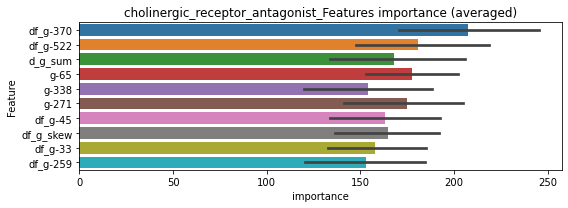

len(train_index) : 3855
len(valid_index) : 3856
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411304	valid_1's binary_logloss: 0.0766025
[200]	training's binary_logloss: 0.0126592	valid_1's binary_logloss: 0.0470517
[300]	training's binary_logloss: 0.00447361	valid_1's binary_logloss: 0.0361762
[400]	training's binary_logloss: 0.00199205	valid_1's binary_logloss: 0.0320157
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00155049	valid_1's binary_logloss: 0.0311402


len(train_index) : 3856
len(valid_index) : 3855
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451904	valid_1's binary_logloss: 0.0798913
[200]	training's binary_logloss: 0.013841	valid_1's binary_logloss: 0.0488665
[300]	training's binary_logloss: 0.00501778	valid_1's binary_logloss: 0.0384085
[400]	training's binary_logloss: 0.0021697	valid_1's binary_logloss: 0.0330381
[500]	training's binary_logloss: 0.00126283	valid_1's binary_logloss: 0.0311901
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00117137	valid_1's binary_logloss: 0.0308363


cholinergic_receptor_antagonist logloss: 0.030988255683772985


neg labels: 3289 → selected neg labels: 3288


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715747	valid_1's binary_logloss: 0.103658
[200]	training's binary_logloss: 0.0169125	valid_1's binary_logloss: 0.0446828
[300]	training's binary_logloss: 0.00515715	valid_1's binary_logloss: 0.0249191
[400]	training's binary_logloss: 0.00230546	valid_1's binary_logloss: 0.0172602
[500]	training's binary_logloss: 0.00150277	valid_1's binary_logloss: 0.0144372
[600]	training's binary_logloss: 0.00117829	valid_1's binary_logloss: 0.0128913
[700]	training's binary_logloss: 0.00101635	valid_1's binary_logloss: 0.0120477
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00101924	valid_1's binary_logloss: 0.0120143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681568	valid_1's binary_logloss: 0.106699
[200]	training's binary_logloss: 0.0169556	valid_1's binary_logloss: 0.0466408
[300]	training's binary_logloss: 0.00520406	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0202028, Threshold: 0.1370509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.12335, conf_1:0.15076
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1370509
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_2: 0.1670509
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_3: 0.1970509
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_4: 0.2270509
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_5: 0.2570509
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.2870509
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_7: 0.3170509
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.3470509
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_9: 0.3770509
threshold: 0.3770509, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595139	valid_1's binary_logloss: 0.0921239
[200]	training's binary_logloss: 0.0136233	valid_1's binary_logloss: 0.0380735
[300]	training's binary_logloss: 0.00413452	valid_1's binary_logloss: 0.020232
[400]	training's binary_logloss: 0.0019686	valid_1's binary_logloss: 0.0138586
[500]	training's binary_logloss: 0.00133144	valid_1's binary_logloss: 0.0112934
[600]	training's binary_logloss: 0.00105632	valid_1's binary_logloss: 0.0102354
[700]	training's binary_logloss: 0.000926034	valid_1's binary_logloss: 0.0094912
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00087713	valid_1's binary_logloss: 0.0092497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586601	valid_1's binary_logloss: 0.0872058
[200]	training's binary_logloss: 0.0140933	valid_1's binary_logloss: 0.0335915
[300]	training's binary_logloss: 0.00467996	vali

2 / 3 AUC score:1.000
y_Threshold: 0.1491393, Threshold: 0.3770509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0077850 Vs.target_rate: 0.00101, Num_p_label: 31.0, conf_0:0.33935, conf_1:0.41476
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_1: 0.3770509
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.4070509
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_3: 0.4370509
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_4: 0.4670509
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_5: 0.4970509
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.5270509
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_7: 0.5570509
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_8: 0.5870509
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_9: 0.6170509
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_10: 0.6470509
threshold: 0.6470509, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3809, y_label_rate: 0.1719611
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607651	valid_1's binary_logloss: 0.0974993
[200]	training's binary_logloss: 0.0136542	valid_1's binary_logloss: 0.0360218
[300]	training's binary_logloss: 0.00425476	valid_1's binary_logloss: 0.0181488
[400]	training's binary_logloss: 0.00201758	valid_1's binary_logloss: 0.0113546
[500]	training's binary_logloss: 0.00136983	valid_1's binary_logloss: 0.00913435
[600]	training's binary_logloss: 0.0010866	valid_1's binary_logloss: 0.0079818
[700]	training's binary_logloss: 0.000949629	valid_1's binary_logloss: 0.00747837
Early stopping, best iteration is:
[740]	training's binary_logloss: 0.000911124	valid_1's binary_logloss: 0.00729395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584247	valid_1's binary_logloss: 0.0867493
[200]	training's binary_logloss: 0.0130464	valid_1's binary_logloss: 0.0315492
[300]	training's binary_logloss: 0.0041078	

3 / 3 AUC score:1.000
y_Threshold: 0.2778441, Threshold: 0.6470509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.58235, conf_1:0.71176
threshold: 0.6470509, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7791, y_label_rate: 0.0848415


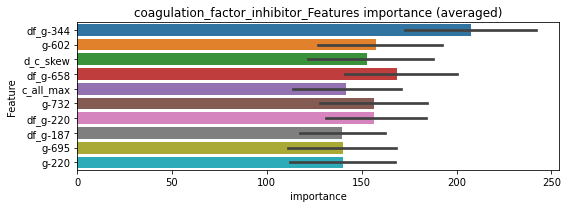

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356298	valid_1's binary_logloss: 0.0572809
[200]	training's binary_logloss: 0.00859678	valid_1's binary_logloss: 0.0247944
[300]	training's binary_logloss: 0.00268887	valid_1's binary_logloss: 0.0149571
[400]	training's binary_logloss: 0.0012277	valid_1's binary_logloss: 0.0112744
[500]	training's binary_logloss: 0.000784914	valid_1's binary_logloss: 0.00975778
[600]	training's binary_logloss: 0.000616499	valid_1's binary_logloss: 0.00918915
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000570994	valid_1's binary_logloss: 0.00896316


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393971	valid_1's binary_logloss: 0.0572428
[200]	training's binary_logloss: 0.00939933	valid_1's binary_logloss: 0.0217915
[300]	training's binary_logloss: 0.00287367	valid_1's binary_logloss: 0.0119552
[400]	training's binary_logloss: 0.00125247	valid_1's binary_logloss: 0.00859218
[500]	training's binary_logloss: 0.000796573	valid_1's binary_logloss: 0.00722057
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000743963	valid_1's binary_logloss: 0.0070534


coagulation_factor_inhibitor logloss: 0.008008400994301635


neg labels: 3289 → selected neg labels: 3285


corticosteroid_agonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118085	valid_1's binary_logloss: 0.175896
[200]	training's binary_logloss: 0.0423794	valid_1's binary_logloss: 0.101842
[300]	training's binary_logloss: 0.0150517	valid_1's binary_logloss: 0.0669118
[400]	training's binary_logloss: 0.00598869	valid_1's binary_logloss: 0.0485735
[500]	training's binary_logloss: 0.00307641	valid_1's binary_logloss: 0.0394909
[600]	training's binary_logloss: 0.00203964	valid_1's binary_logloss: 0.0366337
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00192641	valid_1's binary_logloss: 0.0363433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114487	valid_1's binary_logloss: 0.160523
[200]	training's binary_logloss: 0.0417583	valid_1's binary_logloss: 0.0879059
[300]	training's binary_logloss: 0.0139604	valid_1's binary_logloss: 0.0550661
[400]	training's binary_logloss: 0.00542646	valid_1's 

1 / 3 AUC score:0.997
y_Threshold: 0.0467816, Threshold: 0.1351309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 651/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.12162, conf_1:0.14864
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1351309
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.1651309
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1951309
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.2251309
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.2551309
threshold: 0.2551309, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100714	valid_1's binary_logloss: 0.150285
[200]	training's binary_logloss: 0.0317753	valid_1's binary_logloss: 0.070231
[300]	training's binary_logloss: 0.0105457	valid_1's binary_logloss: 0.0378729
[400]	training's binary_logloss: 0.00451064	valid_1's binary_logloss: 0.0249223
[500]	training's binary_logloss: 0.00260743	valid_1's binary_logloss: 0.0190522
[600]	training's binary_logloss: 0.00187682	valid_1's binary_logloss: 0.0167211
[700]	training's binary_logloss: 0.00153598	valid_1's binary_logloss: 0.0152127
[800]	training's binary_logloss: 0.00134352	valid_1's binary_logloss: 0.0145407
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.00132514	valid_1's binary_logloss: 0.0144802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103255	valid_1's binary_logloss: 0.145914
[200]	training's binary_logloss: 0.0336282	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.2057023, Threshold: 0.2551309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0097941 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.22962, conf_1:0.28064
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.2551309
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.2851309
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.3151309
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.3451309
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.3751309
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.4051309
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.4351309
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_8: 0.4651309
threshold: 0.4651309, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 646.0/3788, y_label_rate: 0.1705385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969181	valid_1's binary_logloss: 0.142328
[200]	training's binary_logloss: 0.0302989	valid_1's binary_logloss: 0.0706999
[300]	training's binary_logloss: 0.0104633	valid_1's binary_logloss: 0.0430613
[400]	training's binary_logloss: 0.0043693	valid_1's binary_logloss: 0.0301031
[500]	training's binary_logloss: 0.00250656	valid_1's binary_logloss: 0.025617
[600]	training's binary_logloss: 0.00178689	valid_1's binary_logloss: 0.0236916
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00170339	valid_1's binary_logloss: 0.0233522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995636	valid_1's binary_logloss: 0.145874
[200]	training's binary_logloss: 0.0296655	valid_1's binary_logloss: 0.0674032
[300]	training's binary_logloss: 0.00995653	valid_1's binary_logloss: 0.0367928
[400]	training's binary_logloss: 0.00427724	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.2758800, Threshold: 0.4651309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 640.0/3776
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.41862, conf_1:0.51164
threshold: 0.4651309, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/7758, y_label_rate: 0.0844290


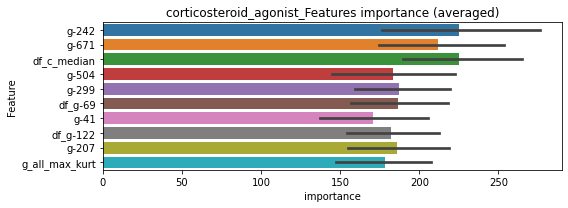

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058452	valid_1's binary_logloss: 0.0916977
[200]	training's binary_logloss: 0.0195607	valid_1's binary_logloss: 0.048725
[300]	training's binary_logloss: 0.00666844	valid_1's binary_logloss: 0.0303127
[400]	training's binary_logloss: 0.00274025	valid_1's binary_logloss: 0.0231029
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.0016196	valid_1's binary_logloss: 0.0201942


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615097	valid_1's binary_logloss: 0.0898568
[200]	training's binary_logloss: 0.0194689	valid_1's binary_logloss: 0.0433844
[300]	training's binary_logloss: 0.0066215	valid_1's binary_logloss: 0.0254273
[400]	training's binary_logloss: 0.00266893	valid_1's binary_logloss: 0.0174752
[500]	training's binary_logloss: 0.00144381	valid_1's binary_logloss: 0.0146926
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00110647	valid_1's binary_logloss: 0.0137461


corticosteroid_agonist logloss: 0.01697011355001194


neg labels: 3289 → selected neg labels: 3235


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3235, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240881	valid_1's binary_logloss: 0.428361
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.233672	valid_1's binary_logloss: 0.427651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250879	valid_1's binary_logloss: 0.419521
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.209359	valid_1's binary_logloss: 0.415592


1 / 3 AUC score:0.652
y_Threshold: 0.2000440, Threshold: 0.4506888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 914 → Positive_corect_labels: 255/2968
p_label_rate: 0.0100452 Vs.target_rate: 0.01827, Num_p_label: 40.0, conf_0:0.40562, conf_1:0.49576
threshold: 0.4506888, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 255.0/2968, y_label_rate: 0.0859164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935062	valid_1's binary_logloss: 0.206051
[200]	training's binary_logloss: 0.0391343	valid_1's binary_logloss: 0.187059
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0366972	valid_1's binary_logloss: 0.186201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899817	valid_1's binary_logloss: 0.215602
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.053403	valid_1's binary_logloss: 0.205924


2 / 3 AUC score:0.873
y_Threshold: 0.1305881, Threshold: 0.4506888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 208 → Positive_corect_labels: 151.0/2760
p_label_rate: 0.0313913 Vs.target_rate: 0.01827, Num_p_label: 125.0, conf_0:0.40562, conf_1:0.49576
threshold: 0.4506888, positive_p_label: 125.0/3982, p_label_rate: 0.0313913
positive_y_label: 151.0/2760, y_label_rate: 0.0547101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385074	valid_1's binary_logloss: 0.134947
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0280441	valid_1's binary_logloss: 0.132345
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.887
y_Threshold: 0.0873506, Threshold: 0.4506888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 84.0/2626
p_label_rate: 0.0429432 Vs.target_rate: 0.01827, Num_p_label: 171.0, conf_0:0.40562, conf_1:0.49576
threshold: 0.4506888, positive_p_label: 171.0/3982, p_label_rate: 0.0429432


[100]	training's binary_logloss: 0.0366764	valid_1's binary_logloss: 0.143498
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0264047	valid_1's binary_logloss: 0.142203


positive_y_label: 255.0/6608, y_label_rate: 0.0385896


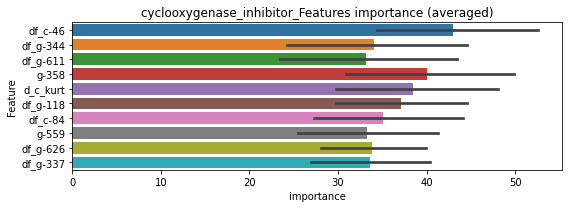

len(train_index) : 3304
len(valid_index) : 3304
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3304
len(valid_index) : 3304
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.00967747	valid_1's binary_logloss: 0.0385705
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00739131	valid_1's binary_logloss: 0.038012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124178	valid_1's binary_logloss: 0.0382736
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00551161	valid_1's binary_logloss: 0.0355506


cyclooxygenase_inhibitor logloss: 0.03678128888237291


neg labels: 3289 → selected neg labels: 3273


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3273, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140364	valid_1's binary_logloss: 0.238227
[200]	training's binary_logloss: 0.0679696	valid_1's binary_logloss: 0.184796
[300]	training's binary_logloss: 0.0317538	valid_1's binary_logloss: 0.160608
[400]	training's binary_logloss: 0.0160288	valid_1's binary_logloss: 0.150096
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0126981	valid_1's binary_logloss: 0.147747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138386	valid_1's binary_logloss: 0.224108
[200]	training's binary_logloss: 0.0655596	valid_1's binary_logloss: 0.168187
[300]	training's binary_logloss: 0.0309619	valid_1's binary_logloss: 0.141569
[400]	training's binary_logloss: 0.0151054	valid_1's binary_logloss: 0.129239
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00996858	valid_1's binary_logloss: 0.123624


1 / 3 AUC score:0.969
y_Threshold: 0.0904366, Threshold: 0.2764000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 240 → Positive_corect_labels: 600/3687
p_label_rate: 0.0100452 Vs.target_rate: 0.00437, Num_p_label: 40.0, conf_0:0.24876, conf_1:0.30404
threshold: 0.2764000, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 600.0/3687, y_label_rate: 0.1627339
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117563	valid_1's binary_logloss: 0.194378
[200]	training's binary_logloss: 0.0459697	valid_1's binary_logloss: 0.134068
[300]	training's binary_logloss: 0.0193989	valid_1's binary_logloss: 0.10828
[400]	training's binary_logloss: 0.00956273	valid_1's binary_logloss: 0.0967904
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00823201	valid_1's binary_logloss: 0.0952047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116466	valid_1's binary_logloss: 0.199426
[200]	training's binary_logloss: 0.0453848	valid_1's binary_logloss: 0.141992
[300]	training's binary_logloss: 0.0201579	valid_1's binary_logloss: 0.119142
[400]	training's binary_logloss: 0.00968299	valid_1's binary_logloss: 0.108374
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00821796	valid_1's binary_logloss: 0.107551


2 / 3 AUC score:0.987
y_Threshold: 0.1384686, Threshold: 0.2764000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 104 → Positive_corect_labels: 548.0/3583
p_label_rate: 0.0220994 Vs.target_rate: 0.00437, Num_p_label: 88.0, conf_0:0.24876, conf_1:0.30404
Num_p_label: 88.0, Expected: 17.4, Adj_threshold_1: 0.2764000
Num_p_label: 74.0, Expected: 17.4, Adj_threshold_2: 0.3064000
Num_p_label: 62.0, Expected: 17.4, Adj_threshold_3: 0.3364000
Num_p_label: 54.0, Expected: 17.4, Adj_threshold_4: 0.3664000
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_5: 0.3964000
Num_p_label: 36.0, Expected: 17.4, Adj_threshold_6: 0.4264000
Num_p_label: 31.0, Expected: 17.4, Adj_threshold_7: 0.4564000
threshold: 0.4564000, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 548.0/3583, y_label_rate: 0.1529445
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978665	valid_1's binary_logloss: 0.176199
[200]	training's binary_logloss: 0.0358651	valid_1's binary_logloss: 0.117696
[300]	training's binary_logloss: 0.0144048	valid_1's binary_logloss: 0.0960828
[400]	training's binary_logloss: 0.00674201	valid_1's binary_logloss: 0.0847952
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00543043	valid_1's binary_logloss: 0.0834308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103517	valid_1's binary_logloss: 0.170605
[200]	training's binary_logloss: 0.0376936	valid_1's binary_logloss: 0.114952
[300]	training's binary_logloss: 0.0149927	valid_1's binary_logloss: 0.0910644
[400]	training's binary_logloss: 0.00716434	valid_1's binary_logloss: 0.0813138
[500]	training's binary_logloss: 0.00413592	valid_1's binary_logloss: 0.0772277
Early stopping, best iteration is:
[533]	training's bi

3 / 3 AUC score:0.990
y_Threshold: 0.1171099, Threshold: 0.4564000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → Positive_corect_labels: 513.0/3513
p_label_rate: 0.0105475 Vs.target_rate: 0.00437, Num_p_label: 42.0, conf_0:0.41076, conf_1:0.50204
threshold: 0.4564000, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 555.0/7495, y_label_rate: 0.0740494


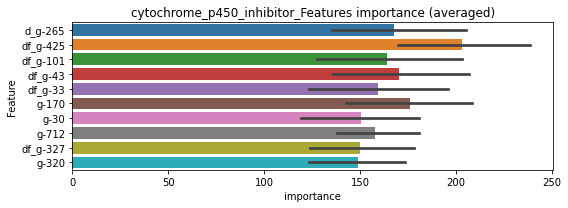

len(train_index) : 3747
len(valid_index) : 3748
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613042	valid_1's binary_logloss: 0.105139
[200]	training's binary_logloss: 0.0221761	valid_1's binary_logloss: 0.0732634
[300]	training's binary_logloss: 0.00863602	valid_1's binary_logloss: 0.0621997
[400]	training's binary_logloss: 0.00412678	valid_1's binary_logloss: 0.0583768
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00322041	valid_1's binary_logloss: 0.057847


len(train_index) : 3748
len(valid_index) : 3747
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601906	valid_1's binary_logloss: 0.101203
[200]	training's binary_logloss: 0.0231709	valid_1's binary_logloss: 0.0689157
[300]	training's binary_logloss: 0.00874383	valid_1's binary_logloss: 0.055479
[400]	training's binary_logloss: 0.00397462	valid_1's binary_logloss: 0.0495941
[500]	training's binary_logloss: 0.00225328	valid_1's binary_logloss: 0.0479885
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00193154	valid_1's binary_logloss: 0.0474535


cytochrome_p450_inhibitor logloss: 0.0526509457726243


neg labels: 3289 → selected neg labels: 3281


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803501	valid_1's binary_logloss: 0.121017
[200]	training's binary_logloss: 0.024879	valid_1's binary_logloss: 0.0572996
[300]	training's binary_logloss: 0.00829987	valid_1's binary_logloss: 0.0312604
[400]	training's binary_logloss: 0.00374622	valid_1's binary_logloss: 0.0212021
[500]	training's binary_logloss: 0.00225281	valid_1's binary_logloss: 0.0173835
[600]	training's binary_logloss: 0.00167132	valid_1's binary_logloss: 0.0159415
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00159755	valid_1's binary_logloss: 0.0156593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848083	valid_1's binary_logloss: 0.132529
[200]	training's binary_logloss: 0.0234671	valid_1's binary_logloss: 0.0673495
[300]	training's binary_logloss: 0.00796079	valid_1's binary_logloss: 0.0436947
[400]	training's binary_logloss: 0.00344616	valid_

1 / 3 AUC score:0.999
y_Threshold: 0.0266416, Threshold: 0.1801131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.16210, conf_1:0.19812
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1801131
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.2101131
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_3: 0.2401131
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_4: 0.2701131
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_5: 0.3001131
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.3301131
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.3601131
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_8: 0.3901131
threshold: 0.3901131, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788634	valid_1's binary_logloss: 0.111293
[200]	training's binary_logloss: 0.0215168	valid_1's binary_logloss: 0.0505974
[300]	training's binary_logloss: 0.00733032	valid_1's binary_logloss: 0.0285195
[400]	training's binary_logloss: 0.00336965	valid_1's binary_logloss: 0.0196341
[500]	training's binary_logloss: 0.00205912	valid_1's binary_logloss: 0.0167009
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00187882	valid_1's binary_logloss: 0.0159986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719606	valid_1's binary_logloss: 0.117352
[200]	training's binary_logloss: 0.0198685	valid_1's binary_logloss: 0.0532485
[300]	training's binary_logloss: 0.00660527	valid_1's binary_logloss: 0.0314514
[400]	training's binary_logloss: 0.00316115	valid_1's binary_logloss: 0.0239022
[500]	training's binary_logloss: 0.00202847	valid

2 / 3 AUC score:1.000
y_Threshold: 0.2008014, Threshold: 0.3901131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.35110, conf_1:0.42912
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.3901131
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.4201131
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_3: 0.4501131
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.4801131
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_5: 0.5101131
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_6: 0.5401131
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_7: 0.5701131
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.6001131
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.6301131
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_10: 0.6601131
threshold: 0.6601131, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771858	valid_1's binary_logloss: 0.116931
[200]	training's binary_logloss: 0.020903	valid_1's binary_logloss: 0.0506539
[300]	training's binary_logloss: 0.00684881	valid_1's binary_logloss: 0.0271721
[400]	training's binary_logloss: 0.00317137	valid_1's binary_logloss: 0.0191722
[500]	training's binary_logloss: 0.00197605	valid_1's binary_logloss: 0.0154474
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00156218	valid_1's binary_logloss: 0.0140183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722284	valid_1's binary_logloss: 0.109842
[200]	training's binary_logloss: 0.0193325	valid_1's binary_logloss: 0.0477577
[300]	training's binary_logloss: 0.00641126	valid_1's binary_logloss: 0.0274555
[400]	training's binary_logloss: 0.00309437	valid_1's binary_logloss: 0.0205918
Early stopping, best iteration is:
[440]	training'

3 / 3 AUC score:1.000
y_Threshold: 0.1874816, Threshold: 0.6601131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.59410, conf_1:0.72612
threshold: 0.6601131, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/7765, y_label_rate: 0.0844816


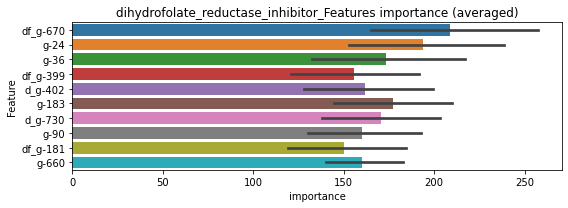

len(train_index) : 3882
len(valid_index) : 3883
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432149	valid_1's binary_logloss: 0.0694401
[200]	training's binary_logloss: 0.0126103	valid_1's binary_logloss: 0.0347615
[300]	training's binary_logloss: 0.00409053	valid_1's binary_logloss: 0.0234437
[400]	training's binary_logloss: 0.00176693	valid_1's binary_logloss: 0.0188388
[500]	training's binary_logloss: 0.00110398	valid_1's binary_logloss: 0.0174218
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00109663	valid_1's binary_logloss: 0.0174197


len(train_index) : 3883
len(valid_index) : 3882
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431132	valid_1's binary_logloss: 0.0645637
[200]	training's binary_logloss: 0.0114151	valid_1's binary_logloss: 0.0278334
[300]	training's binary_logloss: 0.00370557	valid_1's binary_logloss: 0.0151883
[400]	training's binary_logloss: 0.00174037	valid_1's binary_logloss: 0.0110058
[500]	training's binary_logloss: 0.00108856	valid_1's binary_logloss: 0.0095005
[600]	training's binary_logloss: 0.000836005	valid_1's binary_logloss: 0.00879173
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000733172	valid_1's binary_logloss: 0.00847421


dihydrofolate_reductase_inhibitor logloss: 0.012947509550327982


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593101	valid_1's binary_logloss: 0.0907058
[200]	training's binary_logloss: 0.0127096	valid_1's binary_logloss: 0.0368596
[300]	training's binary_logloss: 0.00391415	valid_1's binary_logloss: 0.0228424
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00216233	valid_1's binary_logloss: 0.0196844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571923	valid_1's binary_logloss: 0.0848477
[200]	training's binary_logloss: 0.0128475	valid_1's binary_logloss: 0.0312606
[300]	training's binary_logloss: 0.00396521	valid_1's binary_logloss: 0.01619
[400]	training's binary_logloss: 0.00193274	valid_1's binary_logloss: 0.011663
[500]	training's binary_logloss: 0.00130794	valid_1's binary_logloss: 0.0099594
[600]	training's binary_logloss: 0.00102946	valid_1's binary_logloss: 0.00907802
[700]	training's binary_logloss: 0.000897115	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0237147, Threshold: 0.0851745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.07666, conf_1:0.09369
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0851745
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.1151745
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_3: 0.1451745
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_4: 0.1751745
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_5: 0.2051745
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_6: 0.2351745
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_7: 0.2651745
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_8: 0.2951745
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.3251745
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.3551745
threshold: 0.3851745, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497204	valid_1's binary_logloss: 0.0666004
[200]	training's binary_logloss: 0.0104091	valid_1's binary_logloss: 0.0208045
[300]	training's binary_logloss: 0.00329488	valid_1's binary_logloss: 0.00979677
[400]	training's binary_logloss: 0.00169768	valid_1's binary_logloss: 0.00660895
[500]	training's binary_logloss: 0.00117489	valid_1's binary_logloss: 0.00549828
[600]	training's binary_logloss: 0.000938932	valid_1's binary_logloss: 0.00491502
[700]	training's binary_logloss: 0.000825218	valid_1's binary_logloss: 0.00467058
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.000794703	valid_1's binary_logloss: 0.00461098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514987	valid_1's binary_logloss: 0.0720286
[200]	training's binary_logloss: 0.0108939	valid_1's binary_logloss: 0.0225812
[300]	training's binary_logloss: 0.003

2 / 3 AUC score:1.000
y_Threshold: 0.2580936, Threshold: 0.3851745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0037670 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.34666, conf_1:0.42369
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.3851745
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.4151745
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.4451745
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_4: 0.4751745
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.5051745
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.5351745
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.5651745
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.5951745
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.6251745
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.6551745
threshold: 0.6851745, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497946	valid_1's binary_logloss: 0.0787157
[200]	training's binary_logloss: 0.0106278	valid_1's binary_logloss: 0.0296918
[300]	training's binary_logloss: 0.0033145	valid_1's binary_logloss: 0.0177132
[400]	training's binary_logloss: 0.00165978	valid_1's binary_logloss: 0.0135842
[500]	training's binary_logloss: 0.00115654	valid_1's binary_logloss: 0.0121552
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00117922	valid_1's binary_logloss: 0.0121281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528041	valid_1's binary_logloss: 0.0683749
[200]	training's binary_logloss: 0.0112638	valid_1's binary_logloss: 0.0221422
[300]	training's binary_logloss: 0.00351961	valid_1's binary_logloss: 0.0104273
[400]	training's binary_logloss: 0.00176591	valid_1's binary_logloss: 0.00699306
[500]	training's binary_logloss: 0.00121439	val

3 / 3 AUC score:1.000
y_Threshold: 0.1574112, Threshold: 0.6851745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.61666, conf_1:0.75369
threshold: 0.6851745, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 659.0/7782, y_label_rate: 0.0846826


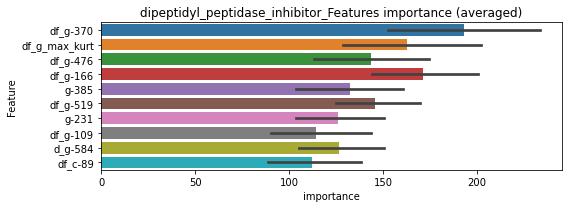

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302946	valid_1's binary_logloss: 0.0423909
[200]	training's binary_logloss: 0.00647968	valid_1's binary_logloss: 0.0145434
[300]	training's binary_logloss: 0.00194966	valid_1's binary_logloss: 0.00749165
[400]	training's binary_logloss: 0.00095869	valid_1's binary_logloss: 0.00552857
[500]	training's binary_logloss: 0.000655705	valid_1's binary_logloss: 0.00479998
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000564565	valid_1's binary_logloss: 0.004557


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289123	valid_1's binary_logloss: 0.048212
[200]	training's binary_logloss: 0.00610894	valid_1's binary_logloss: 0.0188036
[300]	training's binary_logloss: 0.00186049	valid_1's binary_logloss: 0.0102906
[400]	training's binary_logloss: 0.000937396	valid_1's binary_logloss: 0.00805806
[500]	training's binary_logloss: 0.000646935	valid_1's binary_logloss: 0.00700592
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000631754	valid_1's binary_logloss: 0.00696675


dipeptidyl_peptidase_inhibitor logloss: 0.005761876825028618


neg labels: 3289 → selected neg labels: 3289


diuretic, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310829	valid_1's binary_logloss: 0.0468406
[200]	training's binary_logloss: 0.0041339	valid_1's binary_logloss: 0.0118637
[300]	training's binary_logloss: 0.00121952	valid_1's binary_logloss: 0.00551124
[400]	training's binary_logloss: 0.0006949	valid_1's binary_logloss: 0.00404191
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000599127	valid_1's binary_logloss: 0.00373396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03405	valid_1's binary_logloss: 0.0359777
[200]	training's binary_logloss: 0.00445713	valid_1's binary_logloss: 0.00616267
[300]	training's binary_logloss: 0.00133172	valid_1's binary_logloss: 0.00240672
[400]	training's binary_logloss: 0.000764617	valid_1's binary_logloss: 0.00155945
[500]	training's binary_logloss: 0.000585996	valid_1's binary_logloss: 0.00129018
[600]	training's binary_logloss: 0.0005

1 / 3 AUC score:1.000
y_Threshold: 0.0048336, Threshold: 0.0265334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.02388, conf_1:0.02919
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0265334
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_2: 0.0565334
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_3: 0.0865334
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.1165334
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.1465334
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.1765334
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.2065334
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2365334
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2665334
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2965334
threshold: 0.3265334, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
===============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029004	valid_1's binary_logloss: 0.0363121
[200]	training's binary_logloss: 0.00356101	valid_1's binary_logloss: 0.00668217
[300]	training's binary_logloss: 0.00105725	valid_1's binary_logloss: 0.00235531
[400]	training's binary_logloss: 0.000622796	valid_1's binary_logloss: 0.0015133
[500]	training's binary_logloss: 0.00049308	valid_1's binary_logloss: 0.00125543
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000481039	valid_1's binary_logloss: 0.00123424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299981	valid_1's binary_logloss: 0.0351396
[200]	training's binary_logloss: 0.00372418	valid_1's binary_logloss: 0.00544397
[300]	training's binary_logloss: 0.00111126	valid_1's binary_logloss: 0.00184744
[400]	training's binary_logloss: 0.000641129	valid_1's binary_logloss: 0.00114262
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.2915721, Threshold: 0.3265334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.29388, conf_1:0.35919
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.3265334
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.3565334
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.3865334
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.4165334
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.4465334
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.4765334
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.5065334
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.5365334
threshold: 0.5365334, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029004	valid_1's binary_logloss: 0.0363121
[200]	training's binary_logloss: 0.00356101	valid_1's binary_logloss: 0.00668217
[300]	training's binary_logloss: 0.00105725	valid_1's binary_logloss: 0.00235531
[400]	training's binary_logloss: 0.000622796	valid_1's binary_logloss: 0.0015133
[500]	training's binary_logloss: 0.00049308	valid_1's binary_logloss: 0.00125543
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000481039	valid_1's binary_logloss: 0.00123424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299981	valid_1's binary_logloss: 0.0351396
[200]	training's binary_logloss: 0.00372418	valid_1's binary_logloss: 0.00544397
[300]	training's binary_logloss: 0.00111126	valid_1's binary_logloss: 0.00184744
[400]	training's binary_logloss: 0.000641129	valid_1's binary_logloss: 0.00114262
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.2915721, Threshold: 0.5365334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.48288, conf_1:0.59019
threshold: 0.5365334, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


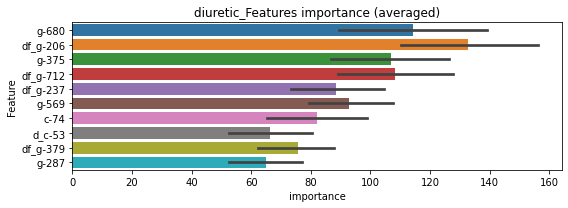

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166911	valid_1's binary_logloss: 0.0199699
[200]	training's binary_logloss: 0.0022371	valid_1's binary_logloss: 0.00372014
[300]	training's binary_logloss: 0.000646778	valid_1's binary_logloss: 0.00160744
[400]	training's binary_logloss: 0.00036742	valid_1's binary_logloss: 0.00123093


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000297313	valid_1's binary_logloss: 0.00114131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017362	valid_1's binary_logloss: 0.0252176
[200]	training's binary_logloss: 0.00218031	valid_1's binary_logloss: 0.0073738
[300]	training's binary_logloss: 0.000633636	valid_1's binary_logloss: 0.00429784
[400]	training's binary_logloss: 0.000363303	valid_1's binary_logloss: 0.00363617
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000352594	valid_1's binary_logloss: 0.00361302


diuretic logloss: 0.002377002289304853


neg labels: 3289 → selected neg labels: 3280


dna_alkylating_agent, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100861	valid_1's binary_logloss: 0.167717
[200]	training's binary_logloss: 0.0360278	valid_1's binary_logloss: 0.10887
[300]	training's binary_logloss: 0.0132449	valid_1's binary_logloss: 0.08944
[400]	training's binary_logloss: 0.00578781	valid_1's binary_logloss: 0.0818476
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0045148	valid_1's binary_logloss: 0.0798937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994542	valid_1's binary_logloss: 0.166517
[200]	training's binary_logloss: 0.0353167	valid_1's binary_logloss: 0.100347
[300]	training's binary_logloss: 0.0136556	valid_1's binary_logloss: 0.074102
[400]	training's binary_logloss: 0.00617203	valid_1's binary_logloss: 0.0622708
[500]	training's binary_logloss: 0.00337979	valid_1's binary_logloss: 0.05655
Early stopping, best iteration is:
[545]	training's binary_lo

1 / 3 AUC score:0.992
y_Threshold: 0.0514082, Threshold: 0.4936940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 182 → Positive_corect_labels: 631/3754
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.44432, conf_1:0.54306
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.4936940
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.5236940
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_3: 0.5536940
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_4: 0.5836940
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_5: 0.6136940
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.6436940
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_7: 0.6736940
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_8: 0.7036940
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_9: 0.7336940
threshold: 0.7336940, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 631.0/3754, y_label_rate: 0.1680874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886825	valid_1's binary_logloss: 0.133392
[200]	training's binary_logloss: 0.0271965	valid_1's binary_logloss: 0.0674957
[300]	training's binary_logloss: 0.00929897	valid_1's binary_logloss: 0.0430469
[400]	training's binary_logloss: 0.00421462	valid_1's binary_logloss: 0.0338743
[500]	training's binary_logloss: 0.00250673	valid_1's binary_logloss: 0.0300316
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00211372	valid_1's binary_logloss: 0.0291994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892053	valid_1's binary_logloss: 0.135686
[200]	training's binary_logloss: 0.0265302	valid_1's binary_logloss: 0.068021
[300]	training's binary_logloss: 0.00954214	valid_1's binary_logloss: 0.0432785
[400]	training's binary_logloss: 0.00437235	valid_1's binary_logloss: 0.033763
[500]	training's binary_logloss: 0.00257051	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.1556355, Threshold: 0.7336940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 620.0/3732
p_label_rate: 0.0133099 Vs.target_rate: 0.00202, Num_p_label: 53.0, conf_0:0.66032, conf_1:0.80706
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_1: 0.7336940
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_2: 0.7636940
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_3: 0.7936940
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_4: 0.8236940
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_5: 0.8536940
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_6: 0.8836940
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_7: 0.9136940
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_8: 0.9436940
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_9: 0.9736940
threshold: 0.9736940, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 620.0/3732, y_label_rate: 0.1661308
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850787	valid_1's binary_logloss: 0.131418
[200]	training's binary_logloss: 0.026019	valid_1's binary_logloss: 0.0656977
[300]	training's binary_logloss: 0.00944775	valid_1's binary_logloss: 0.0418556
[400]	training's binary_logloss: 0.00424431	valid_1's binary_logloss: 0.0307449
[500]	training's binary_logloss: 0.00248289	valid_1's binary_logloss: 0.0262866
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00198322	valid_1's binary_logloss: 0.0249247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836162	valid_1's binary_logloss: 0.138228
[200]	training's binary_logloss: 0.0240934	valid_1's binary_logloss: 0.0697618
[300]	training's binary_logloss: 0.00831677	valid_1's binary_logloss: 0.0434863
[400]	training's binary_logloss: 0.00384892	valid_1's binary_logloss: 0.0335182
[500]	training's binary_logloss: 0.00230356	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1735578, Threshold: 0.9736940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 613.0/3718
p_label_rate: 0.0030136 Vs.target_rate: 0.00202, Num_p_label: 12.0, conf_0:0.87632, conf_1:1.07106
threshold: 0.9736940, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 625.0/7700, y_label_rate: 0.0811688


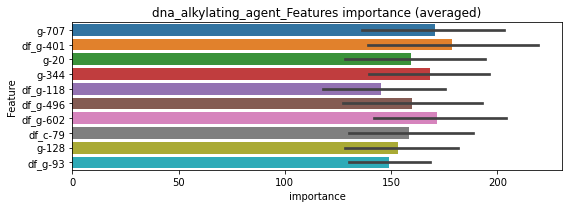

len(train_index) : 3850
len(valid_index) : 3850
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541812	valid_1's binary_logloss: 0.0888474
[200]	training's binary_logloss: 0.01659	valid_1's binary_logloss: 0.050234
[300]	training's binary_logloss: 0.00596509	valid_1's binary_logloss: 0.0363238
[400]	training's binary_logloss: 0.00266771	valid_1's binary_logloss: 0.0313128
[500]	training's binary_logloss: 0.00154854	valid_1's binary_logloss: 0.0285025
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00134667	valid_1's binary_logloss: 0.0280105


len(train_index) : 3850
len(valid_index) : 3850
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507979	valid_1's binary_logloss: 0.0876827
[200]	training's binary_logloss: 0.0166347	valid_1's binary_logloss: 0.0517897
[300]	training's binary_logloss: 0.00620367	valid_1's binary_logloss: 0.0381464
[400]	training's binary_logloss: 0.00271244	valid_1's binary_logloss: 0.0311218
[500]	training's binary_logloss: 0.00155022	valid_1's binary_logloss: 0.0285655
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00125784	valid_1's binary_logloss: 0.027874


dna_alkylating_agent logloss: 0.027942243400149506


neg labels: 3289 → selected neg labels: 3248


dna_inhibitor, len(trt): 402, len(othr): 3248, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234841	valid_1's binary_logloss: 0.411786
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.20583	valid_1's binary_logloss: 0.406839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22715	valid_1's binary_logloss: 0.401523
[200]	training's binary_logloss: 0.130637	valid_1's binary_logloss: 0.388609
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.113482	valid_1's binary_logloss: 0.387079


1 / 3 AUC score:0.725
y_Threshold: 0.2015964, Threshold: 0.5141901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 827 → Positive_corect_labels: 301/3070
p_label_rate: 0.0100452 Vs.target_rate: 0.01688, Num_p_label: 40.0, conf_0:0.46277, conf_1:0.56561
threshold: 0.5141901, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 301.0/3070, y_label_rate: 0.0980456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943766	valid_1's binary_logloss: 0.240742
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0895697	valid_1's binary_logloss: 0.239564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890829	valid_1's binary_logloss: 0.238906


2 / 3 AUC score:0.846
y_Threshold: 0.1501702, Threshold: 0.5141901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 282 → Positive_corect_labels: 160.0/2788
p_label_rate: 0.0158212 Vs.target_rate: 0.01688, Num_p_label: 63.0, conf_0:0.46277, conf_1:0.56561
threshold: 0.5141901, positive_p_label: 63.0/3982, p_label_rate: 0.0158212


[200]	training's binary_logloss: 0.0364923	valid_1's binary_logloss: 0.229555
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0352966	valid_1's binary_logloss: 0.229085


positive_y_label: 160.0/2788, y_label_rate: 0.0573888
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359926	valid_1's binary_logloss: 0.124166
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0179852	valid_1's binary_logloss: 0.118682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367276	valid_1's binary_logloss: 0.126342
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0182898	valid_1's binary_logloss: 0.118933


3 / 3 AUC score:0.928
y_Threshold: 0.1063265, Threshold: 0.5141901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 104 → Positive_corect_labels: 108.0/2684
p_label_rate: 0.0266198 Vs.target_rate: 0.01688, Num_p_label: 106.0, conf_0:0.46277, conf_1:0.56561
threshold: 0.5141901, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 214.0/6666, y_label_rate: 0.0321032


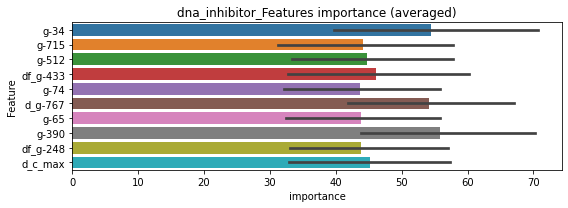

len(train_index) : 3333
len(valid_index) : 3333
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3333
len(valid_index) : 3333
================================= fold 2/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.0131899	valid_1's binary_logloss: 0.0622756
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00900204	valid_1's binary_logloss: 0.0604533
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.0548501738832556


[100]	training's binary_logloss: 0.0141923	valid_1's binary_logloss: 0.0523182
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00848146	valid_1's binary_logloss: 0.049247
neg labels: 3289 → selected neg labels: 3272


dopamine_receptor_agonist, len(trt): 121, len(othr): 3272, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134711	valid_1's binary_logloss: 0.237213
[200]	training's binary_logloss: 0.0555098	valid_1's binary_logloss: 0.198115
[300]	training's binary_logloss: 0.02604	valid_1's binary_logloss: 0.185608
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0183754	valid_1's binary_logloss: 0.182067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142247	valid_1's binary_logloss: 0.226423
[200]	training's binary_logloss: 0.0648905	valid_1's binary_logloss: 0.174817
[300]	training's binary_logloss: 0.0326092	valid_1's binary_logloss: 0.151859
[400]	training's binary_logloss: 0.0178378	valid_1's binary_logloss: 0.139822
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0142496	valid_1's binary_logloss: 0.13587


1 / 3 AUC score:0.961
y_Threshold: 0.0878105, Threshold: 0.3872165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 294 → Positive_corect_labels: 573/3632
p_label_rate: 0.0100452 Vs.target_rate: 0.00508, Num_p_label: 40.0, conf_0:0.34849, conf_1:0.42594
threshold: 0.3872165, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 573.0/3632, y_label_rate: 0.1577643
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103244	valid_1's binary_logloss: 0.169705
[200]	training's binary_logloss: 0.0394943	valid_1's binary_logloss: 0.120624
[300]	training's binary_logloss: 0.0163538	valid_1's binary_logloss: 0.0998269
[400]	training's binary_logloss: 0.00785105	valid_1's binary_logloss: 0.0920292
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00491502	valid_1's binary_logloss: 0.0884295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106796	valid_1's binary_logloss: 0.174182
[200]	training's binary_logloss: 0.0409925	valid_1's binary_logloss: 0.123497
[300]	training's binary_logloss: 0.0169584	valid_1's binary_logloss: 0.106029
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0118779	valid_1's binary_logloss: 0.100577


2 / 3 AUC score:0.988
y_Threshold: 0.1506478, Threshold: 0.3872165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 528.0/3542
p_label_rate: 0.0170768 Vs.target_rate: 0.00508, Num_p_label: 68.0, conf_0:0.34849, conf_1:0.42594
Num_p_label: 68.0, Expected: 20.2, Adj_threshold_1: 0.3872165
Num_p_label: 57.0, Expected: 20.2, Adj_threshold_2: 0.4172165
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_3: 0.4472165
Num_p_label: 42.0, Expected: 20.2, Adj_threshold_4: 0.4772165
Num_p_label: 38.0, Expected: 20.2, Adj_threshold_5: 0.5072165
threshold: 0.5072165, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 528.0/3542, y_label_rate: 0.1490683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886688	valid_1's binary_logloss: 0.146478
[200]	training's binary_logloss: 0.0298005	valid_1's binary_logloss: 0.0988153
[300]	training's binary_logloss: 0.0115621	valid_1's binary_logloss: 0.0775589
[400]	training's binary_logloss: 0.00546496	valid_1's binary_logloss: 0.0674379
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00522687	valid_1's binary_logloss: 0.067419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937093	valid_1's binary_logloss: 0.150539
[200]	training's binary_logloss: 0.0338379	valid_1's binary_logloss: 0.0975136
[300]	training's binary_logloss: 0.0135186	valid_1's binary_logloss: 0.0771618
[400]	training's binary_logloss: 0.00635421	valid_1's binary_logloss: 0.0679949
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00559354	valid_1's binary_logloss: 0.0668901


3 / 3 AUC score:0.997
y_Threshold: 0.1240366, Threshold: 0.5072165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 499.0/3484
p_label_rate: 0.0150678 Vs.target_rate: 0.00508, Num_p_label: 60.0, conf_0:0.45649, conf_1:0.55794
threshold: 0.5072165, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 559.0/7466, y_label_rate: 0.0748728


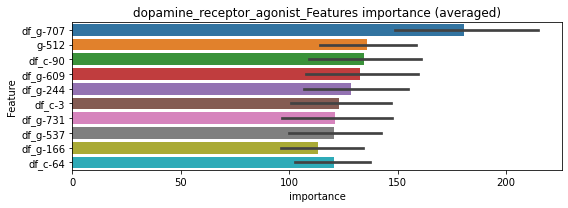

len(train_index) : 3733
len(valid_index) : 3733
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518395	valid_1's binary_logloss: 0.0880211
[200]	training's binary_logloss: 0.018734	valid_1's binary_logloss: 0.061621
[300]	training's binary_logloss: 0.00746759	valid_1's binary_logloss: 0.0520006
[400]	training's binary_logloss: 0.00352362	valid_1's binary_logloss: 0.047638
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00287334	valid_1's binary_logloss: 0.0471608


len(train_index) : 3733
len(valid_index) : 3733
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554297	valid_1's binary_logloss: 0.0880153
[200]	training's binary_logloss: 0.0209238	valid_1's binary_logloss: 0.0596467
[300]	training's binary_logloss: 0.0089675	valid_1's binary_logloss: 0.0497004
[400]	training's binary_logloss: 0.00428196	valid_1's binary_logloss: 0.0441666
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.0028571	valid_1's binary_logloss: 0.0416433


dopamine_receptor_agonist logloss: 0.0444020368529509


neg labels: 3289 → selected neg labels: 3231


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3231, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.253343	valid_1's binary_logloss: 0.426556
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.663
y_Threshold: 0.2039139, Threshold: 0.4818114, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 912 → Positive_corect_labels: 255/2965
p_label_rate: 0.0100452 Vs.target_rate: 0.01780, Num_p_label: 40.0, conf_0:0.43363, conf_1:0.52999
threshold: 0.4818114, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 255.0/2965, y_label_rate: 0.0860034
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.230434	valid_1's binary_logloss: 0.418825
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.222887	valid_1's binary_logloss: 0.417617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761594	valid_1's binary_logloss: 0.1895
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0323698	valid_1's binary_logloss: 0.178148
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.904
y_Threshold: 0.1295124, Threshold: 0.4818114, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 157.0/2769
p_label_rate: 0.0457057 Vs.target_rate: 0.01780, Num_p_label: 182.0, conf_0:0.43363, conf_1:0.52999
threshold: 0.4818114, positive_p_label: 182.0/3982, p_label_rate: 0.0457057


[100]	training's binary_logloss: 0.078334	valid_1's binary_logloss: 0.195838
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0607596	valid_1's binary_logloss: 0.192245


positive_y_label: 157.0/2769, y_label_rate: 0.0566992
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312087	valid_1's binary_logloss: 0.124686
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0268875	valid_1's binary_logloss: 0.1239
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.932
y_Threshold: 0.1187686, Threshold: 0.4818114, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 110.0/2675
p_label_rate: 0.0537418 Vs.target_rate: 0.01780, Num_p_label: 214.0, conf_0:0.43363, conf_1:0.52999
Num_p_label: 214.0, Expected: 70.9, Adj_threshold_1: 0.4818114


[100]	training's binary_logloss: 0.0352943	valid_1's binary_logloss: 0.104608
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.019474	valid_1's binary_logloss: 0.0976385


Num_p_label: 210.0, Expected: 70.9, Adj_threshold_2: 0.5118114
Num_p_label: 209.0, Expected: 70.9, Adj_threshold_3: 0.5418114
Num_p_label: 202.0, Expected: 70.9, Adj_threshold_4: 0.5718114
Num_p_label: 197.0, Expected: 70.9, Adj_threshold_5: 0.6018114
Num_p_label: 191.0, Expected: 70.9, Adj_threshold_6: 0.6318114
Num_p_label: 182.0, Expected: 70.9, Adj_threshold_7: 0.6618114
Num_p_label: 175.0, Expected: 70.9, Adj_threshold_8: 0.6918114
Num_p_label: 159.0, Expected: 70.9, Adj_threshold_9: 0.7218114
Num_p_label: 152.0, Expected: 70.9, Adj_threshold_10: 0.7518114
threshold: 0.7818114, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 241.0/6657, y_label_rate: 0.0362025


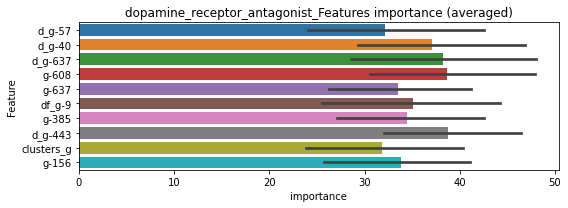

len(train_index) : 3328
len(valid_index) : 3329
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155687	valid_1's binary_logloss: 0.0513998
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00860848	valid_1's binary_logloss: 0.0489189


len(train_index) : 3329
len(valid_index) : 3328
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.052065435561130295


[100]	training's binary_logloss: 0.0147283	valid_1's binary_logloss: 0.0579425
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00834788	valid_1's binary_logloss: 0.0552129


neg labels: 3289 → selected neg labels: 3242


egfr_inhibitor, len(trt): 336, len(othr): 3242, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22549	valid_1's binary_logloss: 0.389609
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.194006	valid_1's binary_logloss: 0.382024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233117	valid_1's binary_logloss: 0.398117


1 / 3 AUC score:0.753
y_Threshold: 0.1917848, Threshold: 0.5976413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 786 → Positive_corect_labels: 320/3104
p_label_rate: 0.0100452 Vs.target_rate: 0.01411, Num_p_label: 40.0, conf_0:0.53788, conf_1:0.65741
threshold: 0.5976413, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 320.0/3104, y_label_rate: 0.1030928
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.129204	valid_1's binary_logloss: 0.387144
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.134342	valid_1's binary_logloss: 0.386968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085043	valid_1's binary_logloss: 0.230405
[200]	training's binary_logloss: 0.0328762	valid_1's binary_logloss: 0.219599
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0356324	valid_1's binary_logloss: 0.219033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983395	valid_1's binary_logloss: 0.224597


2 / 3 AUC score:0.889
y_Threshold: 0.1398213, Threshold: 0.5976413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 242 → Positive_corect_labels: 199.0/2862
p_label_rate: 0.0381718 Vs.target_rate: 0.01411, Num_p_label: 152.0, conf_0:0.53788, conf_1:0.65741
threshold: 0.5976413, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 199.0/2862, y_label_rate: 0.0695318
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0414969	valid_1's binary_logloss: 0.207534
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0398358	valid_1's binary_logloss: 0.206732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419348	valid_1's binary_logloss: 0.138919
[200]	training's binary_logloss: 0.0125357	valid_1's binary_logloss: 0.123851
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0104188	valid_1's binary_logloss: 0.122653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459456	valid_1's binary_logloss: 0.126351


3 / 3 AUC score:0.957
y_Threshold: 0.0837737, Threshold: 0.5976413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 110 → Positive_corect_labels: 144.0/2752
p_label_rate: 0.0414365 Vs.target_rate: 0.01411, Num_p_label: 165.0, conf_0:0.53788, conf_1:0.65741
threshold: 0.5976413, positive_p_label: 165.0/3982, p_label_rate: 0.0414365


[200]	training's binary_logloss: 0.013533	valid_1's binary_logloss: 0.110587
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.010603	valid_1's binary_logloss: 0.109183


positive_y_label: 309.0/6734, y_label_rate: 0.0458865


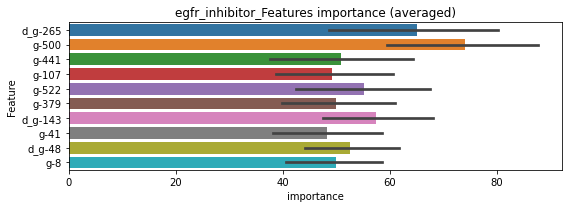

len(train_index) : 3367
len(valid_index) : 3367
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188463	valid_1's binary_logloss: 0.0657176


len(train_index) : 3367
len(valid_index) : 3367
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00853666	valid_1's binary_logloss: 0.0605308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184406	valid_1's binary_logloss: 0.0527928


egfr_inhibitor logloss: 0.05362945275191015


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00581114	valid_1's binary_logloss: 0.0467281
neg labels: 3289 → selected neg labels: 3284


elastase_inhibitor, len(trt): 12, len(othr): 3284, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364755	valid_1's binary_logloss: 0.0507415
[200]	training's binary_logloss: 0.00619581	valid_1's binary_logloss: 0.015362
[300]	training's binary_logloss: 0.00176848	valid_1's binary_logloss: 0.00712044
[400]	training's binary_logloss: 0.000977024	valid_1's binary_logloss: 0.00520519
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00076967	valid_1's binary_logloss: 0.00459295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397426	valid_1's binary_logloss: 0.0514645
[200]	training's binary_logloss: 0.0062192	valid_1's binary_logloss: 0.0120929
[300]	training's binary_logloss: 0.00182309	valid_1's binary_logloss: 0.00495723
[400]	training's binary_logloss: 0.000990229	valid_1's binary_logloss: 0.00311818
[500]	training's binary_logloss: 0.000738177	valid_1's binary_logloss: 0.00250904
[600]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0069683, Threshold: 0.0528810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.04759, conf_1:0.05817
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0528810
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.0828810
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.1128810
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.1428810
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.1728810
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.2028810
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.2328810
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.2628810
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.2928810
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.3228810
threshold: 0.3528810, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317116	valid_1's binary_logloss: 0.0491131
[200]	training's binary_logloss: 0.00495683	valid_1's binary_logloss: 0.0151252
[300]	training's binary_logloss: 0.00149933	valid_1's binary_logloss: 0.00809235
[400]	training's binary_logloss: 0.000815816	valid_1's binary_logloss: 0.00618048
[500]	training's binary_logloss: 0.000624064	valid_1's binary_logloss: 0.00534777
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000575394	valid_1's binary_logloss: 0.00509516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322843	valid_1's binary_logloss: 0.0410952
[200]	training's binary_logloss: 0.0050959	valid_1's binary_logloss: 0.00868482
[300]	training's binary_logloss: 0.00155889	valid_1's binary_logloss: 0.00332559
[400]	training's binary_logloss: 0.000867546	valid_1's binary_logloss: 0.00206684
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.3208606, Threshold: 0.3528810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0052737 Vs.target_rate: 0.00050, Num_p_label: 21.0, conf_0:0.31759, conf_1:0.38817
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.3528810
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.3828810
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.4128810
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.4428810
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.4728810
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.5028810
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.5328810
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.5628810
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.5928810
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.6228810
threshold: 0.6528810, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308241	valid_1's binary_logloss: 0.0492171
[200]	training's binary_logloss: 0.0049601	valid_1's binary_logloss: 0.0149843
[300]	training's binary_logloss: 0.00149664	valid_1's binary_logloss: 0.00725125
[400]	training's binary_logloss: 0.000844275	valid_1's binary_logloss: 0.0053033
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000784776	valid_1's binary_logloss: 0.00516648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327169	valid_1's binary_logloss: 0.0472213
[200]	training's binary_logloss: 0.00501913	valid_1's binary_logloss: 0.0122306
[300]	training's binary_logloss: 0.00155467	valid_1's binary_logloss: 0.00562152
[400]	training's binary_logloss: 0.00086611	valid_1's binary_logloss: 0.00379458
[500]	training's binary_logloss: 0.000639434	valid_1's binary_logloss: 0.00318936
Early stopping, best iteration is:
[52

3 / 3 AUC score:1.000
y_Threshold: 0.1052504, Threshold: 0.6528810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.58759, conf_1:0.71817
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.6528810
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.6828810
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.7128810
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.7428810
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.7728810
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.8028810
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.8328810
threshold: 0.8328810, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 658.0/7786, y_label_rate: 0.0845107


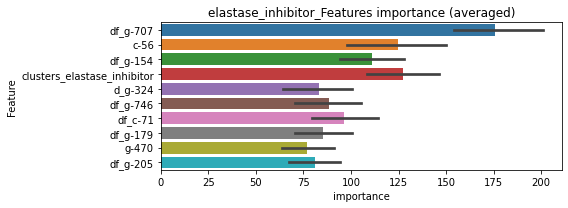

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203571	valid_1's binary_logloss: 0.0276637
[200]	training's binary_logloss: 0.00333147	valid_1's binary_logloss: 0.00775222
[300]	training's binary_logloss: 0.000938708	valid_1's binary_logloss: 0.003872
[400]	training's binary_logloss: 0.000502241	valid_1's binary_logloss: 0.00303086
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00041269	valid_1's binary_logloss: 0.00289073


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183977	valid_1's binary_logloss: 0.0315734
[200]	training's binary_logloss: 0.00294846	valid_1's binary_logloss: 0.0144168
[300]	training's binary_logloss: 0.000888757	valid_1's binary_logloss: 0.0100744
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000677072	valid_1's binary_logloss: 0.00949302


elastase_inhibitor logloss: 0.006191879055504067


neg labels: 3289 → selected neg labels: 3287


erbb2_inhibitor, len(trt): 20, len(othr): 3287, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529429	valid_1's binary_logloss: 0.0752362
[200]	training's binary_logloss: 0.0123015	valid_1's binary_logloss: 0.0256624
[300]	training's binary_logloss: 0.00385058	valid_1's binary_logloss: 0.0127048
[400]	training's binary_logloss: 0.00186892	valid_1's binary_logloss: 0.00888535
[500]	training's binary_logloss: 0.00128723	valid_1's binary_logloss: 0.00781126
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00106996	valid_1's binary_logloss: 0.00722291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537113	valid_1's binary_logloss: 0.0807431
[200]	training's binary_logloss: 0.0116094	valid_1's binary_logloss: 0.0303918
[300]	training's binary_logloss: 0.00368529	valid_1's binary_logloss: 0.0179403
[400]	training's binary_logloss: 0.00180677	valid_1's binary_logloss: 0.0133034
[500]	training's binary_logloss: 0.00123894	

1 / 3 AUC score:1.000
y_Threshold: 0.0138586, Threshold: 0.0508337, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00084, Num_p_label: 40.0, conf_0:0.04575, conf_1:0.05592
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_1: 0.0508337
Num_p_label: 25.0, Expected: 3.3, Adj_threshold_2: 0.0808337
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_3: 0.1108337
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_4: 0.1408337
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_5: 0.1708337
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_6: 0.2008337
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_7: 0.2308337
threshold: 0.2308337, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459906	valid_1's binary_logloss: 0.0658387
[200]	training's binary_logloss: 0.00959098	valid_1's binary_logloss: 0.0215079
[300]	training's binary_logloss: 0.00309117	valid_1's binary_logloss: 0.0105918
[400]	training's binary_logloss: 0.00160907	valid_1's binary_logloss: 0.0075653
[500]	training's binary_logloss: 0.00114508	valid_1's binary_logloss: 0.00663367
[600]	training's binary_logloss: 0.000935841	valid_1's binary_logloss: 0.00605427
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.000857881	valid_1's binary_logloss: 0.00573883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493612	valid_1's binary_logloss: 0.0722401
[200]	training's binary_logloss: 0.0105157	valid_1's binary_logloss: 0.0248874
[300]	training's binary_logloss: 0.00317788	valid_1's binary_logloss: 0.0121882
[400]	training's binary_logloss: 0.001641

2 / 3 AUC score:1.000
y_Threshold: 0.1294929, Threshold: 0.2308337, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00102364	valid_1's binary_logloss: 0.00748261


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0060271 Vs.target_rate: 0.00084, Num_p_label: 24.0, conf_0:0.20775, conf_1:0.25392
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_1: 0.2308337
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_2: 0.2608337
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_3: 0.2908337
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_4: 0.3208337
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_5: 0.3508337
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_6: 0.3808337
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_7: 0.4108337
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_8: 0.4408337
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_9: 0.4708337
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_10: 0.5008337
threshold: 0.5308337, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459906	valid_1's binary_logloss: 0.0658387
[200]	training's binary_logloss: 0.00959098	valid_1's binary_logloss: 0.0215079
[300]	training's binary_logloss: 0.00309117	valid_1's binary_logloss: 0.0105918
[400]	training's binary_logloss: 0.00160907	valid_1's binary_logloss: 0.0075653
[500]	training's binary_logloss: 0.00114508	valid_1's binary_logloss: 0.00663367
[600]	training's binary_logloss: 0.000935841	valid_1's binary_logloss: 0.00605427
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.000857881	valid_1's binary_logloss: 0.00573883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493612	valid_1's binary_logloss: 0.0722401
[200]	training's binary_logloss: 0.0105157	valid_1's binary_logloss: 0.0248874
[300]	training's binary_logloss: 0.00317788	valid_1's binary_logloss: 0.0121882
[400]	training's binary_logloss: 0.001641

3 / 3 AUC score:1.000
y_Threshold: 0.1294929, Threshold: 0.5308337, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00102364	valid_1's binary_logloss: 0.00748261


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.47775, conf_1:0.58392
threshold: 0.5308337, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7794, y_label_rate: 0.0853220


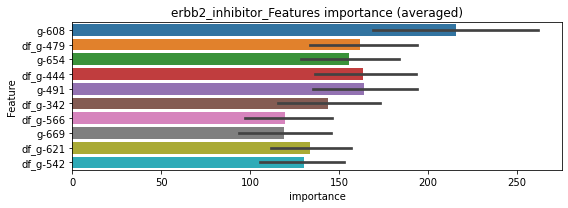

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027037	valid_1's binary_logloss: 0.0433754
[200]	training's binary_logloss: 0.00582269	valid_1's binary_logloss: 0.0175634
[300]	training's binary_logloss: 0.00175505	valid_1's binary_logloss: 0.0111533


len(train_index) : 3897
len(valid_index) : 3897


[400]	training's binary_logloss: 0.000902891	valid_1's binary_logloss: 0.00965491
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000885824	valid_1's binary_logloss: 0.00964874


================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256454	valid_1's binary_logloss: 0.0412388
[200]	training's binary_logloss: 0.00545703	valid_1's binary_logloss: 0.016627
[300]	training's binary_logloss: 0.00169151	valid_1's binary_logloss: 0.0108342
[400]	training's binary_logloss: 0.000883027	valid_1's binary_logloss: 0.00917378
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000839967	valid_1's binary_logloss: 0.0090263


erbb2_inhibitor logloss: 0.009337521122267243


neg labels: 3289 → selected neg labels: 3270


estrogen_receptor_agonist, len(trt): 158, len(othr): 3270, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176026	valid_1's binary_logloss: 0.290869
[200]	training's binary_logloss: 0.0858146	valid_1's binary_logloss: 0.24283
[300]	training's binary_logloss: 0.0433863	valid_1's binary_logloss: 0.220253
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.040241	valid_1's binary_logloss: 0.218798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173373	valid_1's binary_logloss: 0.267964
[200]	training's binary_logloss: 0.0878274	valid_1's binary_logloss: 0.21737


1 / 3 AUC score:0.935
y_Threshold: 0.1537152, Threshold: 0.3749232, pos_neg_ratio: 0.8000000


[300]	training's binary_logloss: 0.0427617	valid_1's binary_logloss: 0.189895
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.038598	valid_1's binary_logloss: 0.186768


Remove_noisy_labels: 333 → Positive_corect_labels: 553/3591
p_label_rate: 0.0100452 Vs.target_rate: 0.00663, Num_p_label: 40.0, conf_0:0.33743, conf_1:0.41242
threshold: 0.3749232, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 553.0/3591, y_label_rate: 0.1539961
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132148	valid_1's binary_logloss: 0.218873
[200]	training's binary_logloss: 0.0547745	valid_1's binary_logloss: 0.162021
[300]	training's binary_logloss: 0.0252452	valid_1's binary_logloss: 0.136323
[400]	training's binary_logloss: 0.0123253	valid_1's binary_logloss: 0.125822
[500]	training's binary_logloss: 0.00665882	valid_1's binary_logloss: 0.117404
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00473228	valid_1's binary_logloss: 0.114192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146057	valid_1's binary_logloss: 0.21962
[200]	training's binary_logloss: 0.0612327	valid_1's binary_logloss: 0.161256
[300]	training's binary_logloss: 0.0286795	valid_1's binary_logloss: 0.130444
[400]	training's binary_logloss: 0.0140201	valid_1's binary_logloss: 0.115944
[500]	training's binary_logloss: 0.00764969	valid_1's binary_log

2 / 3 AUC score:0.984
y_Threshold: 0.1684206, Threshold: 0.3749232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 499.0/3483
p_label_rate: 0.0190859 Vs.target_rate: 0.00663, Num_p_label: 76.0, conf_0:0.33743, conf_1:0.41242
threshold: 0.3749232, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 499.0/3483, y_label_rate: 0.1432673
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10999	valid_1's binary_logloss: 0.205012
[200]	training's binary_logloss: 0.0415119	valid_1's binary_logloss: 0.154245
[300]	training's binary_logloss: 0.0168555	valid_1's binary_logloss: 0.132723
[400]	training's binary_logloss: 0.00800689	valid_1's binary_logloss: 0.123517
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00636234	valid_1's binary_logloss: 0.121274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130797	valid_1's binary_logloss: 0.193542
[200]	training's binary_logloss: 0.0501961	valid_1's binary_logloss: 0.131242
[300]	training's binary_logloss: 0.0210338	valid_1's binary_logloss: 0.106451
[400]	training's binary_logloss: 0.00963253	valid_1's binary_logloss: 0.0914149
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00713729	valid_1's binary_logloss: 0.0885547


3 / 3 AUC score:0.985
y_Threshold: 0.1273352, Threshold: 0.3749232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 448.0/3381
p_label_rate: 0.0200904 Vs.target_rate: 0.00663, Num_p_label: 80.0, conf_0:0.33743, conf_1:0.41242
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.3749232
Num_p_label: 75.0, Expected: 26.4, Adj_threshold_2: 0.4049232
Num_p_label: 64.0, Expected: 26.4, Adj_threshold_3: 0.4349232
Num_p_label: 55.0, Expected: 26.4, Adj_threshold_4: 0.4649232
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_5: 0.4949232
threshold: 0.4949232, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 497.0/7363, y_label_rate: 0.0674997


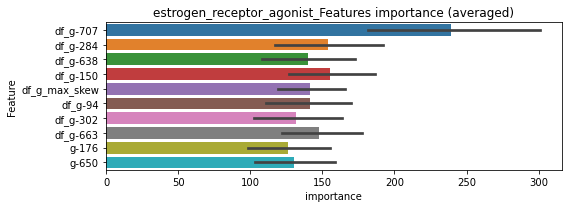

len(train_index) : 3681
len(valid_index) : 3682
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715171	valid_1's binary_logloss: 0.113905
[200]	training's binary_logloss: 0.0280824	valid_1's binary_logloss: 0.0814102
[300]	training's binary_logloss: 0.0121981	valid_1's binary_logloss: 0.0692605
[400]	training's binary_logloss: 0.00571344	valid_1's binary_logloss: 0.064184
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00338745	valid_1's binary_logloss: 0.0610393


len(train_index) : 3682
len(valid_index) : 3681
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684898	valid_1's binary_logloss: 0.108518
[200]	training's binary_logloss: 0.0261737	valid_1's binary_logloss: 0.0772735
[300]	training's binary_logloss: 0.011236	valid_1's binary_logloss: 0.0649676
[400]	training's binary_logloss: 0.0053402	valid_1's binary_logloss: 0.0596127
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00500736	valid_1's binary_logloss: 0.0594755


estrogen_receptor_agonist logloss: 0.060257532427296874


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945962	valid_1's binary_logloss: 0.165901
[200]	training's binary_logloss: 0.0340586	valid_1's binary_logloss: 0.108938
[300]	training's binary_logloss: 0.0126715	valid_1's binary_logloss: 0.0863195
[400]	training's binary_logloss: 0.00526837	valid_1's binary_logloss: 0.0752921
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00507961	valid_1's binary_logloss: 0.0749807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106169	valid_1's binary_logloss: 0.138841
[200]	training's binary_logloss: 0.0414722	valid_1's binary_logloss: 0.0810859
[300]	training's binary_logloss: 0.0157488	valid_1's binary_logloss: 0.0563636
[400]	training's binary_logloss: 0.00656804	valid_1's binary_logloss: 0.0439967
[500]	training's binary_logloss: 0.00348588	valid_1's binary_logloss: 0.0383355
[600]	training's binary_logloss: 0.00229751	valid_1's

1 / 3 AUC score:0.997
y_Threshold: 0.0378479, Threshold: 0.4531923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3783
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.40787, conf_1:0.49851
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.4531923
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_2: 0.4831923
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_3: 0.5131923
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_4: 0.5431923
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_5: 0.5731923
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_6: 0.6031923
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_7: 0.6331923
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_8: 0.6631923
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_9: 0.6931923
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_10: 0.7231923
threshold: 0.7531923, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 644.0/3783, y_label_rate: 0.1702353
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916122	valid_1's binary_logloss: 0.137327
[200]	training's binary_logloss: 0.0325826	valid_1's binary_logloss: 0.083361
[300]	training's binary_logloss: 0.0119172	valid_1's binary_logloss: 0.0591601
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00754958	valid_1's binary_logloss: 0.0540766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862563	valid_1's binary_logloss: 0.134325
[200]	training's binary_logloss: 0.0305654	valid_1's binary_logloss: 0.0807184
[300]	training's binary_logloss: 0.0112883	valid_1's binary_logloss: 0.0600807
[400]	training's binary_logloss: 0.00479978	valid_1's binary_logloss: 0.0496117
[500]	training's binary_logloss: 0.00273535	valid_1's binary_logloss: 0.0465072
[600]	training's binary_logloss: 0.00188943	valid_1's binary_logloss: 0.0445172
Early stopping, best iteration is:
[636]	training's 

2 / 3 AUC score:0.998
y_Threshold: 0.1195111, Threshold: 0.7531923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 624.0/3743
p_label_rate: 0.0095429 Vs.target_rate: 0.00202, Num_p_label: 38.0, conf_0:0.67787, conf_1:0.82851
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_1: 0.7531923
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_2: 0.7831923
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_3: 0.8131923
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_4: 0.8431923
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_5: 0.8731923
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_6: 0.9031923
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_7: 0.9331923
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_8: 0.9631923
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_9: 0.9931923
threshold: 0.9931923, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 624.0/3743, y_label_rate: 0.1667112
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845782	valid_1's binary_logloss: 0.133365
[200]	training's binary_logloss: 0.0271918	valid_1's binary_logloss: 0.0768984
[300]	training's binary_logloss: 0.00934812	valid_1's binary_logloss: 0.059003
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00495003	valid_1's binary_logloss: 0.0516429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781199	valid_1's binary_logloss: 0.118158
[200]	training's binary_logloss: 0.0254961	valid_1's binary_logloss: 0.066156
[300]	training's binary_logloss: 0.00926888	valid_1's binary_logloss: 0.0455802
[400]	training's binary_logloss: 0.00412899	valid_1's binary_logloss: 0.0379684
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00338595	valid_1's binary_logloss: 0.0364397


3 / 3 AUC score:0.997
y_Threshold: 0.1235101, Threshold: 0.9931923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 605.0/3705
p_label_rate: 0.0017579 Vs.target_rate: 0.00202, Num_p_label: 7.0, conf_0:0.89387, conf_1:1.09251
threshold: 0.9931923, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 612.0/7687, y_label_rate: 0.0796149


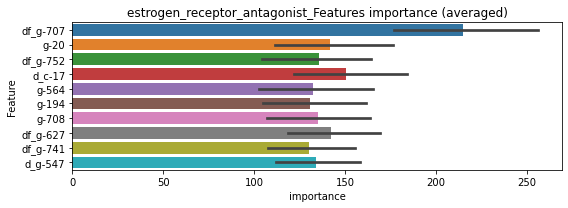

len(train_index) : 3843
len(valid_index) : 3844
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491963	valid_1's binary_logloss: 0.0785235
[200]	training's binary_logloss: 0.0164091	valid_1's binary_logloss: 0.0480387
[300]	training's binary_logloss: 0.00530069	valid_1's binary_logloss: 0.0365451
[400]	training's binary_logloss: 0.00229006	valid_1's binary_logloss: 0.0329384
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00192741	valid_1's binary_logloss: 0.032519


len(train_index) : 3844
len(valid_index) : 3843
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436659	valid_1's binary_logloss: 0.0766121
[200]	training's binary_logloss: 0.0144755	valid_1's binary_logloss: 0.0488337
[300]	training's binary_logloss: 0.00517326	valid_1's binary_logloss: 0.0395666
[400]	training's binary_logloss: 0.00222036	valid_1's binary_logloss: 0.035857
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00177113	valid_1's binary_logloss: 0.0350168


estrogen_receptor_antagonist logloss: 0.03376771033335366


neg labels: 3289 → selected neg labels: 3284


faah_inhibitor, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101486	valid_1's binary_logloss: 0.142569
[200]	training's binary_logloss: 0.036176	valid_1's binary_logloss: 0.0742414
[300]	training's binary_logloss: 0.0127957	valid_1's binary_logloss: 0.0441035
[400]	training's binary_logloss: 0.00504843	valid_1's binary_logloss: 0.0290468
[500]	training's binary_logloss: 0.00272478	valid_1's binary_logloss: 0.0226357
[600]	training's binary_logloss: 0.0018634	valid_1's binary_logloss: 0.019781
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00173222	valid_1's binary_logloss: 0.019334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991422	valid_1's binary_logloss: 0.14141
[200]	training's binary_logloss: 0.0315697	valid_1's binary_logloss: 0.0724218
[300]	training's binary_logloss: 0.0109244	valid_1's binary_logloss: 0.0440217
[400]	training's binary_logloss: 0.00437073	valid_1's bin

1 / 3 AUC score:1.000
y_Threshold: 0.0369540, Threshold: 0.1114528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.10031, conf_1:0.12260
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1114528
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.1414528
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.1714528
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.2014528
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.2314528
threshold: 0.2314528, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971099	valid_1's binary_logloss: 0.137477
[200]	training's binary_logloss: 0.0278461	valid_1's binary_logloss: 0.0583993
[300]	training's binary_logloss: 0.00901901	valid_1's binary_logloss: 0.0300816
[400]	training's binary_logloss: 0.00395111	valid_1's binary_logloss: 0.0192665
[500]	training's binary_logloss: 0.00231215	valid_1's binary_logloss: 0.0150653
[600]	training's binary_logloss: 0.0016727	valid_1's binary_logloss: 0.0134364
[700]	training's binary_logloss: 0.00136806	valid_1's binary_logloss: 0.0123838
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00129203	valid_1's binary_logloss: 0.0119915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950297	valid_1's binary_logloss: 0.1434
[200]	training's binary_logloss: 0.0268315	valid_1's binary_logloss: 0.0696427
[300]	training's binary_logloss: 0.0086167	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.2262077, Threshold: 0.2314528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0105475 Vs.target_rate: 0.00151, Num_p_label: 42.0, conf_0:0.20831, conf_1:0.25460
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_1: 0.2314528
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.2614528
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_3: 0.2914528
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.3214528
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.3514528
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_6: 0.3814528
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_7: 0.4114528
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_8: 0.4414528
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.4714528
threshold: 0.4714528, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904512	valid_1's binary_logloss: 0.135203
[200]	training's binary_logloss: 0.0252392	valid_1's binary_logloss: 0.0680736
[300]	training's binary_logloss: 0.00840458	valid_1's binary_logloss: 0.0462896
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00419948	valid_1's binary_logloss: 0.0384952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883944	valid_1's binary_logloss: 0.130201
[200]	training's binary_logloss: 0.0251202	valid_1's binary_logloss: 0.0585156
[300]	training's binary_logloss: 0.00825735	valid_1's binary_logloss: 0.0320499
[400]	training's binary_logloss: 0.00362714	valid_1's binary_logloss: 0.0213474
[500]	training's binary_logloss: 0.00217973	valid_1's binary_logloss: 0.0171917
[600]	training's binary_logloss: 0.00158062	valid_1's binary_logloss: 0.0150728
[700]	training's binary_logloss: 0.00129514	valid

3 / 3 AUC score:0.999
y_Threshold: 0.1964355, Threshold: 0.4714528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 638.0/3772
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.42431, conf_1:0.51860
threshold: 0.4714528, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 650.0/7754, y_label_rate: 0.0838277


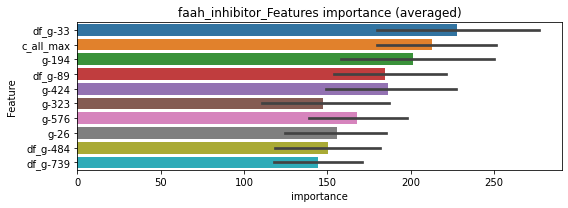

len(train_index) : 3877
len(valid_index) : 3877
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554264	valid_1's binary_logloss: 0.0782241
[200]	training's binary_logloss: 0.0173602	valid_1's binary_logloss: 0.0375388
[300]	training's binary_logloss: 0.00544022	valid_1's binary_logloss: 0.0210447
[400]	training's binary_logloss: 0.00221233	valid_1's binary_logloss: 0.0148925
[500]	training's binary_logloss: 0.00124489	valid_1's binary_logloss: 0.0126349
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000923005	valid_1's binary_logloss: 0.0117756


len(train_index) : 3877
len(valid_index) : 3877
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504247	valid_1's binary_logloss: 0.0745509
[200]	training's binary_logloss: 0.015028	valid_1's binary_logloss: 0.0369429
[300]	training's binary_logloss: 0.00492364	valid_1's binary_logloss: 0.0245073
[400]	training's binary_logloss: 0.00206053	valid_1's binary_logloss: 0.0200936
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00143307	valid_1's binary_logloss: 0.0188582


faah_inhibitor logloss: 0.015316923755832788


neg labels: 3289 → selected neg labels: 3288


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471986	valid_1's binary_logloss: 0.0671439
[200]	training's binary_logloss: 0.00882335	valid_1's binary_logloss: 0.0250776
[300]	training's binary_logloss: 0.00274356	valid_1's binary_logloss: 0.0150571
[400]	training's binary_logloss: 0.00142346	valid_1's binary_logloss: 0.0121362
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00143073	valid_1's binary_logloss: 0.0121019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516304	valid_1's binary_logloss: 0.0721921
[200]	training's binary_logloss: 0.0104822	valid_1's binary_logloss: 0.0266123
[300]	training's binary_logloss: 0.00307428	valid_1's binary_logloss: 0.0154217
[400]	training's binary_logloss: 0.00149708	valid_1's binary_logloss: 0.0121871
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00119924	valid_1's binary_logloss: 0.0112568


1 / 3 AUC score:1.000
y_Threshold: 0.0168123, Threshold: 0.1577362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.14196, conf_1:0.17351
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1577362
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_2: 0.1877362
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_3: 0.2177362
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.2477362
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.2777362
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.3077362
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.3377362
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_8: 0.3677362
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_9: 0.3977362
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.4277362
threshold: 0.4577362, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400538	valid_1's binary_logloss: 0.0550897
[200]	training's binary_logloss: 0.00766556	valid_1's binary_logloss: 0.0184002
[300]	training's binary_logloss: 0.00240167	valid_1's binary_logloss: 0.0109047
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00150232	valid_1's binary_logloss: 0.00878848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042661	valid_1's binary_logloss: 0.0636592
[200]	training's binary_logloss: 0.00771636	valid_1's binary_logloss: 0.0205465
[300]	training's binary_logloss: 0.00239715	valid_1's binary_logloss: 0.0111721
[400]	training's binary_logloss: 0.00125213	valid_1's binary_logloss: 0.00816737


2 / 3 AUC score:1.000
y_Threshold: 0.1326657, Threshold: 0.4577362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00076, Num_p_label: 31.0, conf_0:0.41196, conf_1:0.50351
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_1: 0.4577362
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.4877362
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.5177362
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.5477362
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.5777362
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.6077362
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.6377362
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.6677362
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.6977362


Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00112185	valid_1's binary_logloss: 0.0075568


Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.7277362
threshold: 0.7577362, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419991	valid_1's binary_logloss: 0.0560918
[200]	training's binary_logloss: 0.00760252	valid_1's binary_logloss: 0.0159945
[300]	training's binary_logloss: 0.00233876	valid_1's binary_logloss: 0.00762073
[400]	training's binary_logloss: 0.00126072	valid_1's binary_logloss: 0.00519143
[500]	training's binary_logloss: 0.000922959	valid_1's binary_logloss: 0.00438665
[600]	training's binary_logloss: 0.000778741	valid_1's binary_logloss: 0.00400537
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00074719	valid_1's binary_logloss: 0.00390936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382767	valid_1's binary_logloss: 0.0572448
[200]	training's binary_logloss: 0.0070961	valid_1's binary_logloss: 0.0175622
[300]	training's binary_logloss: 0.00229546	valid_1's binary_logloss: 0.00968111
[400]	training's binary_logloss: 0.001

3 / 3 AUC score:1.000
y_Threshold: 0.2902513, Threshold: 0.7577362, pos_neg_ratio: 0.8000000


[600]	training's binary_logloss: 0.000773188	valid_1's binary_logloss: 0.00543202
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000756671	valid_1's binary_logloss: 0.0054021


Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0035158 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.68196, conf_1:0.83351
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.7577362
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.7877362
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.8177362
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.8477362
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.8777362
threshold: 0.8777362, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7791, y_label_rate: 0.0847131


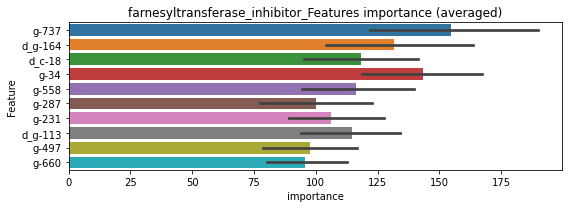

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026568	valid_1's binary_logloss: 0.0406388
[200]	training's binary_logloss: 0.00507807	valid_1's binary_logloss: 0.0163111
[300]	training's binary_logloss: 0.00144166	valid_1's binary_logloss: 0.00984355
[400]	training's binary_logloss: 0.000749927	valid_1's binary_logloss: 0.00825131
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000553771	valid_1's binary_logloss: 0.00763894


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286827	valid_1's binary_logloss: 0.0385574
[200]	training's binary_logloss: 0.00506075	valid_1's binary_logloss: 0.0127446
[300]	training's binary_logloss: 0.00148723	valid_1's binary_logloss: 0.00668177
[400]	training's binary_logloss: 0.000778914	valid_1's binary_logloss: 0.00485505
[500]	training's binary_logloss: 0.000564078	valid_1's binary_logloss: 0.00418731
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000506002	valid_1's binary_logloss: 0.00400466


farnesyltransferase_inhibitor logloss: 0.005822031767440399


neg labels: 3289 → selected neg labels: 3284


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745808	valid_1's binary_logloss: 0.105972
[200]	training's binary_logloss: 0.0196232	valid_1's binary_logloss: 0.0458089
[300]	training's binary_logloss: 0.00589111	valid_1's binary_logloss: 0.02567
[400]	training's binary_logloss: 0.00260533	valid_1's binary_logloss: 0.0190112
[500]	training's binary_logloss: 0.00161917	valid_1's binary_logloss: 0.0162459
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00139633	valid_1's binary_logloss: 0.0154426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708254	valid_1's binary_logloss: 0.106908
[200]	training's binary_logloss: 0.0192445	valid_1's binary_logloss: 0.0454733
[300]	training's binary_logloss: 0.00608163	valid_1's binary_logloss: 0.0245964
[400]	training's binary_logloss: 0.0026664	valid_1's binary_logloss: 0.0166659
[500]	training's binary_logloss: 0.0016547	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0198561, Threshold: 0.0961835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.08657, conf_1:0.10580
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0961835
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_2: 0.1261835
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_3: 0.1561835
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_4: 0.1861835
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.2161835
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.2461835
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_7: 0.2761835
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_8: 0.3061835
threshold: 0.3061835, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690473	valid_1's binary_logloss: 0.100971
[200]	training's binary_logloss: 0.0161634	valid_1's binary_logloss: 0.0399918
[300]	training's binary_logloss: 0.00508828	valid_1's binary_logloss: 0.0210549
[400]	training's binary_logloss: 0.00237407	valid_1's binary_logloss: 0.0153693
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00175517	valid_1's binary_logloss: 0.01369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065279	valid_1's binary_logloss: 0.0982432
[200]	training's binary_logloss: 0.0149464	valid_1's binary_logloss: 0.0377188
[300]	training's binary_logloss: 0.00474388	valid_1's binary_logloss: 0.0206595
[400]	training's binary_logloss: 0.00229643	valid_1's binary_logloss: 0.0150864
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00158668	valid_1's binary_logloss: 0.0135798


2 / 3 AUC score:1.000
y_Threshold: 0.1120218, Threshold: 0.3061835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0050226 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.27557, conf_1:0.33680
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.3061835
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.3361835
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.3661835
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_4: 0.3961835
threshold: 0.3961835, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677586	valid_1's binary_logloss: 0.102293
[200]	training's binary_logloss: 0.0158446	valid_1's binary_logloss: 0.037494
[300]	training's binary_logloss: 0.00485499	valid_1's binary_logloss: 0.0186086
[400]	training's binary_logloss: 0.00225985	valid_1's binary_logloss: 0.0126247
[500]	training's binary_logloss: 0.00145836	valid_1's binary_logloss: 0.0103661
[600]	training's binary_logloss: 0.00112934	valid_1's binary_logloss: 0.00958701
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00112934	valid_1's binary_logloss: 0.00958701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625353	valid_1's binary_logloss: 0.098036
[200]	training's binary_logloss: 0.0143842	valid_1's binary_logloss: 0.0370186
[300]	training's binary_logloss: 0.00458666	valid_1's binary_logloss: 0.0190797
[400]	training's binary_logloss: 0.00218227	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1922387, Threshold: 0.3961835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.35657, conf_1:0.43580
threshold: 0.3961835, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 660.0/7778, y_label_rate: 0.0848547


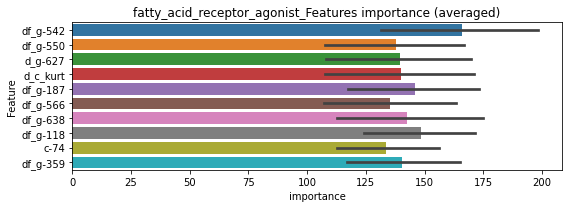

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410594	valid_1's binary_logloss: 0.067204
[200]	training's binary_logloss: 0.00925944	valid_1's binary_logloss: 0.0307337
[300]	training's binary_logloss: 0.00267516	valid_1's binary_logloss: 0.0190614


len(train_index) : 3889
len(valid_index) : 3889


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00133349	valid_1's binary_logloss: 0.0157417


================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399118	valid_1's binary_logloss: 0.0632757
[200]	training's binary_logloss: 0.00928689	valid_1's binary_logloss: 0.027509
[300]	training's binary_logloss: 0.00277335	valid_1's binary_logloss: 0.0174136
[400]	training's binary_logloss: 0.00123349	valid_1's binary_logloss: 0.0143218
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000874338	valid_1's binary_logloss: 0.0133659


fatty_acid_receptor_agonist logloss: 0.014553816379630529


neg labels: 3289 → selected neg labels: 3284


fgfr_inhibitor, len(trt): 50, len(othr): 3284, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102274	valid_1's binary_logloss: 0.162341
[200]	training's binary_logloss: 0.0368722	valid_1's binary_logloss: 0.100607
[300]	training's binary_logloss: 0.0136764	valid_1's binary_logloss: 0.0735809
[400]	training's binary_logloss: 0.00597219	valid_1's binary_logloss: 0.0610292
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00400678	valid_1's binary_logloss: 0.0570887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101275	valid_1's binary_logloss: 0.154974
[200]	training's binary_logloss: 0.0353605	valid_1's binary_logloss: 0.0908223
[300]	training's binary_logloss: 0.0139876	valid_1's binary_logloss: 0.0662338
[400]	training's binary_logloss: 0.00624729	valid_1's binary_logloss: 0.0546056
[500]	training's binary_logloss: 0.00347541	valid_1's binary_logloss: 0.0510518
Early stopping, best iteration is:
[514]	training's bi

1 / 3 AUC score:0.994
y_Threshold: 0.0437748, Threshold: 0.2099045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 645/3786
p_label_rate: 0.0100452 Vs.target_rate: 0.00210, Num_p_label: 40.0, conf_0:0.18891, conf_1:0.23089
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_1: 0.2099045
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_2: 0.2399045
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_3: 0.2699045
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_4: 0.2999045
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_5: 0.3299045
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_6: 0.3599045
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_7: 0.3899045
threshold: 0.3899045, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 645.0/3786, y_label_rate: 0.1703645
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885921	valid_1's binary_logloss: 0.143086
[200]	training's binary_logloss: 0.0289549	valid_1's binary_logloss: 0.0764422
[300]	training's binary_logloss: 0.01065	valid_1's binary_logloss: 0.051264
[400]	training's binary_logloss: 0.00496872	valid_1's binary_logloss: 0.0404684
[500]	training's binary_logloss: 0.00290699	valid_1's binary_logloss: 0.0360757
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00230461	valid_1's binary_logloss: 0.0343895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930059	valid_1's binary_logloss: 0.140826
[200]	training's binary_logloss: 0.0301312	valid_1's binary_logloss: 0.0752022
[300]	training's binary_logloss: 0.0111773	valid_1's binary_logloss: 0.0494215
[400]	training's binary_logloss: 0.00516078	valid_1's binary_logloss: 0.0381339
[500]	training's binary_logloss: 0.00308763	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1402006, Threshold: 0.3899045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 632.0/3760
p_label_rate: 0.0110497 Vs.target_rate: 0.00210, Num_p_label: 44.0, conf_0:0.35091, conf_1:0.42889
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_1: 0.3899045
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_2: 0.4199045
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_3: 0.4499045
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_4: 0.4799045
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_5: 0.5099045
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_6: 0.5399045
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_7: 0.5699045
Num_p_label: 14.0, Expected: 8.4, Adj_threshold_8: 0.5999045
threshold: 0.5999045, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 632.0/3760, y_label_rate: 0.1680851
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885096	valid_1's binary_logloss: 0.140865
[200]	training's binary_logloss: 0.0276564	valid_1's binary_logloss: 0.0753881
[300]	training's binary_logloss: 0.00985796	valid_1's binary_logloss: 0.0492549
[400]	training's binary_logloss: 0.00453929	valid_1's binary_logloss: 0.038884
[500]	training's binary_logloss: 0.00270197	valid_1's binary_logloss: 0.0341878
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0023724	valid_1's binary_logloss: 0.0331446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866193	valid_1's binary_logloss: 0.142912
[200]	training's binary_logloss: 0.0272209	valid_1's binary_logloss: 0.0847988
[300]	training's binary_logloss: 0.0101158	valid_1's binary_logloss: 0.063852
[400]	training's binary_logloss: 0.00473943	valid_1's binary_logloss: 0.0553835
Early stopping, best iteration is:
[460]	training's b

3 / 3 AUC score:0.998
y_Threshold: 0.1063049, Threshold: 0.5999045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 616.0/3728
p_label_rate: 0.0032647 Vs.target_rate: 0.00210, Num_p_label: 13.0, conf_0:0.53991, conf_1:0.65989
threshold: 0.5999045, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 629.0/7710, y_label_rate: 0.0815824


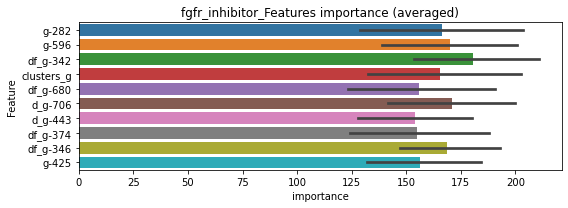

len(train_index) : 3855
len(valid_index) : 3855
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494312	valid_1's binary_logloss: 0.074789
[200]	training's binary_logloss: 0.0162025	valid_1's binary_logloss: 0.0392305
[300]	training's binary_logloss: 0.00633397	valid_1's binary_logloss: 0.0272532
[400]	training's binary_logloss: 0.00283382	valid_1's binary_logloss: 0.02155
[500]	training's binary_logloss: 0.00159915	valid_1's binary_logloss: 0.0195607
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00152019	valid_1's binary_logloss: 0.0194269


len(train_index) : 3855
len(valid_index) : 3855
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482553	valid_1's binary_logloss: 0.0839094
[200]	training's binary_logloss: 0.0146405	valid_1's binary_logloss: 0.0496579
[300]	training's binary_logloss: 0.00552224	valid_1's binary_logloss: 0.0377012
[400]	training's binary_logloss: 0.00255325	valid_1's binary_logloss: 0.032391
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.0016622	valid_1's binary_logloss: 0.0304731


fgfr_inhibitor logloss: 0.024950019343081047


neg labels: 3289 → selected neg labels: 3258


flt3_inhibitor, len(trt): 279, len(othr): 3258, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228329	valid_1's binary_logloss: 0.380789
[200]	training's binary_logloss: 0.138957	valid_1's binary_logloss: 0.363294
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.119373	valid_1's binary_logloss: 0.359392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229555	valid_1's binary_logloss: 0.37882
[200]	training's binary_logloss: 0.13393	valid_1's binary_logloss: 0.352699
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.108723	valid_1's binary_logloss: 0.347656


1 / 3 AUC score:0.792
y_Threshold: 0.1914849, Threshold: 0.6903190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 653 → Positive_corect_labels: 390/3256
p_label_rate: 0.0100452 Vs.target_rate: 0.01172, Num_p_label: 40.0, conf_0:0.62129, conf_1:0.75935
threshold: 0.6903190, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 390.0/3256, y_label_rate: 0.1197789
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1167	valid_1's binary_logloss: 0.243143
[200]	training's binary_logloss: 0.0509833	valid_1's binary_logloss: 0.212376
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0340164	valid_1's binary_logloss: 0.206274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12786	valid_1's binary_logloss: 0.247265


2 / 3 AUC score:0.913
y_Threshold: 0.1765757, Threshold: 0.6903190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 264 → Positive_corect_labels: 258.0/2992
p_label_rate: 0.0193370 Vs.target_rate: 0.01172, Num_p_label: 77.0, conf_0:0.62129, conf_1:0.75935
threshold: 0.6903190, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 258.0/2992, y_label_rate: 0.0862299
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0683081	valid_1's binary_logloss: 0.222654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744495	valid_1's binary_logloss: 0.143654
[200]	training's binary_logloss: 0.0278446	valid_1's binary_logloss: 0.112415
[300]	training's binary_logloss: 0.0117545	valid_1's binary_logloss: 0.100499
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00909445	valid_1's binary_logloss: 0.0992542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069598	valid_1's binary_logloss: 0.156067
[200]	training's binary_logloss: 0.023976	valid_1's binary_logloss: 0.121901


3 / 3 AUC score:0.969
y_Threshold: 0.1306044, Threshold: 0.6903190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 212.0/2900
p_label_rate: 0.0238574 Vs.target_rate: 0.01172, Num_p_label: 95.0, conf_0:0.62129, conf_1:0.75935
threshold: 0.6903190, positive_p_label: 95.0/3982, p_label_rate: 0.0238574


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0106796	valid_1's binary_logloss: 0.112878


positive_y_label: 307.0/6882, y_label_rate: 0.0446091


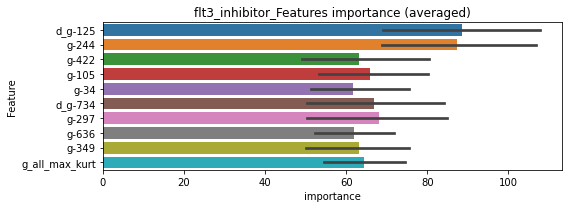

len(train_index) : 3441
len(valid_index) : 3441
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327025	valid_1's binary_logloss: 0.0800125


len(train_index) : 3441
len(valid_index) : 3441
================================= fold 2/2 flt3_inhibitor=================================


[200]	training's binary_logloss: 0.0102418	valid_1's binary_logloss: 0.0681631
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0101152	valid_1's binary_logloss: 0.0681259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358485	valid_1's binary_logloss: 0.075398
[200]	training's binary_logloss: 0.011233	valid_1's binary_logloss: 0.0602163


flt3_inhibitor logloss: 0.062314774418656176


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00482661	valid_1's binary_logloss: 0.0565037
neg labels: 3289 → selected neg labels: 3289


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647001	valid_1's binary_logloss: 0.0884418
[200]	training's binary_logloss: 0.0142796	valid_1's binary_logloss: 0.0353768
[300]	training's binary_logloss: 0.00422373	valid_1's binary_logloss: 0.0190823
[400]	training's binary_logloss: 0.00198264	valid_1's binary_logloss: 0.0139327
[500]	training's binary_logloss: 0.00130628	valid_1's binary_logloss: 0.0117686
[600]	training's binary_logloss: 0.00107303	valid_1's binary_logloss: 0.0110427
[700]	training's binary_logloss: 0.000932078	valid_1's binary_logloss: 0.0104699
[800]	training's binary_logloss: 0.000850618	valid_1's binary_logloss: 0.0100583
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000848927	valid_1's binary_logloss: 0.0100359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629638	valid_1's binary_logloss: 0.0871441
[200]	training's binary_logloss: 0.0140426	

1 / 3 AUC score:1.000
y_Threshold: 0.0209782, Threshold: 0.1639618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.14757, conf_1:0.18036


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00127067	valid_1's binary_logloss: 0.0133706


Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1639618
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.1939618
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.2239618
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_4: 0.2539618
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.2839618
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.3139618
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.3439618
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.3739618
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.4039618
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.4339618
threshold: 0.4339618, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527542	valid_1's binary_logloss: 0.0799199
[200]	training's binary_logloss: 0.0106258	valid_1's binary_logloss: 0.0305504
[300]	training's binary_logloss: 0.00322136	valid_1's binary_logloss: 0.0163027
[400]	training's binary_logloss: 0.00163861	valid_1's binary_logloss: 0.0116306
[500]	training's binary_logloss: 0.0011243	valid_1's binary_logloss: 0.0100279
[600]	training's binary_logloss: 0.000910959	valid_1's binary_logloss: 0.00915657
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.000891594	valid_1's binary_logloss: 0.00910778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531864	valid_1's binary_logloss: 0.073472
[200]	training's binary_logloss: 0.0116652	valid_1's binary_logloss: 0.0247111
[300]	training's binary_logloss: 0.00365428	valid_1's binary_logloss: 0.0127897
[400]	training's binary_logloss: 0.00177355	v

2 / 3 AUC score:1.000
y_Threshold: 0.3658501, Threshold: 0.4339618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 654.0/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.39057, conf_1:0.47736
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.4339618
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.4639618
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.4939618
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_4: 0.5239618
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_5: 0.5539618
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.5839618
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.6139618
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.6439618
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.6739618
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.7039618
threshold: 0.7339618, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3807, y_label_rate: 0.1717888
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542521	valid_1's binary_logloss: 0.0730323
[200]	training's binary_logloss: 0.0113072	valid_1's binary_logloss: 0.0240141
[300]	training's binary_logloss: 0.00352892	valid_1's binary_logloss: 0.0112787
[400]	training's binary_logloss: 0.00176267	valid_1's binary_logloss: 0.0071164
[500]	training's binary_logloss: 0.00119059	valid_1's binary_logloss: 0.00564025
[600]	training's binary_logloss: 0.000969664	valid_1's binary_logloss: 0.00485779
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.000877553	valid_1's binary_logloss: 0.00459821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532983	valid_1's binary_logloss: 0.073851
[200]	training's binary_logloss: 0.0111623	valid_1's binary_logloss: 0.0249281
[300]	training's binary_logloss: 0.00337064	valid_1's binary_logloss: 0.0124255
[400]	training's binary_logloss: 0.00167042

3 / 3 AUC score:1.000
y_Threshold: 0.5396241, Threshold: 0.7339618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.66057, conf_1:0.80736
threshold: 0.7339618, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 662.0/7787, y_label_rate: 0.0850135


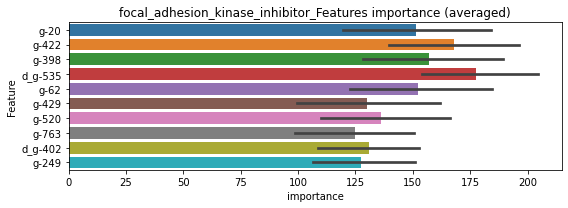

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348703	valid_1's binary_logloss: 0.0538527
[200]	training's binary_logloss: 0.00783902	valid_1's binary_logloss: 0.0242705
[300]	training's binary_logloss: 0.00236967	valid_1's binary_logloss: 0.0163624
[400]	training's binary_logloss: 0.00108738	valid_1's binary_logloss: 0.0142294
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000798288	valid_1's binary_logloss: 0.0134897


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331757	valid_1's binary_logloss: 0.0485026
[200]	training's binary_logloss: 0.00727761	valid_1's binary_logloss: 0.0196773
[300]	training's binary_logloss: 0.00219006	valid_1's binary_logloss: 0.0109672
[400]	training's binary_logloss: 0.00104377	valid_1's binary_logloss: 0.00783526
[500]	training's binary_logloss: 0.000686251	valid_1's binary_logloss: 0.006805
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000609234	valid_1's binary_logloss: 0.00650288


focal_adhesion_kinase_inhibitor logloss: 0.009996749417779388


neg labels: 3289 → selected neg labels: 3288


free_radical_scavenger, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569295	valid_1's binary_logloss: 0.0825328
[200]	training's binary_logloss: 0.0119578	valid_1's binary_logloss: 0.0295359
[300]	training's binary_logloss: 0.00356992	valid_1's binary_logloss: 0.0149797
[400]	training's binary_logloss: 0.00174021	valid_1's binary_logloss: 0.0112456
[500]	training's binary_logloss: 0.00117553	valid_1's binary_logloss: 0.00994772
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00119911	valid_1's binary_logloss: 0.00992297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543904	valid_1's binary_logloss: 0.0762938
[200]	training's binary_logloss: 0.0115311	valid_1's binary_logloss: 0.0241532
[300]	training's binary_logloss: 0.0036327	valid_1's binary_logloss: 0.0113597
[400]	training's binary_logloss: 0.001785	valid_1's binary_logloss: 0.0075783
[500]	training's binary_logloss: 0.00121868	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0149793, Threshold: 0.0744396, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.06700, conf_1:0.08188
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0744396
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.1044396
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.1344396
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.1644396
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.1944396
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.2244396
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.2544396
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.2844396
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.3144396
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.3444396
threshold: 0.3444396, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488099	valid_1's binary_logloss: 0.0741286
[200]	training's binary_logloss: 0.00989837	valid_1's binary_logloss: 0.025027
[300]	training's binary_logloss: 0.00299436	valid_1's binary_logloss: 0.0123118
[400]	training's binary_logloss: 0.00152971	valid_1's binary_logloss: 0.00854457
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00111114	valid_1's binary_logloss: 0.00765331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496894	valid_1's binary_logloss: 0.066305
[200]	training's binary_logloss: 0.0101284	valid_1's binary_logloss: 0.0179793
[300]	training's binary_logloss: 0.00312305	valid_1's binary_logloss: 0.00773916
[400]	training's binary_logloss: 0.00162751	valid_1's binary_logloss: 0.0050411
[500]	training's binary_logloss: 0.00110629	valid_1's binary_logloss: 0.0040104
[600]	training's binary_logloss: 0.000896018	

2 / 3 AUC score:1.000
y_Threshold: 0.1789125, Threshold: 0.3444396, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.31000, conf_1:0.37888
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.3444396
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.3744396
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.4044396
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.4344396
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.4644396
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.4944396
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.5244396
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.5544396
threshold: 0.5544396, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488099	valid_1's binary_logloss: 0.0741286
[200]	training's binary_logloss: 0.00989837	valid_1's binary_logloss: 0.025027
[300]	training's binary_logloss: 0.00299436	valid_1's binary_logloss: 0.0123118
[400]	training's binary_logloss: 0.00152971	valid_1's binary_logloss: 0.00854457
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00111114	valid_1's binary_logloss: 0.00765331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496894	valid_1's binary_logloss: 0.066305
[200]	training's binary_logloss: 0.0101284	valid_1's binary_logloss: 0.0179793
[300]	training's binary_logloss: 0.00312305	valid_1's binary_logloss: 0.00773916
[400]	training's binary_logloss: 0.00162751	valid_1's binary_logloss: 0.0050411
[500]	training's binary_logloss: 0.00110629	valid_1's binary_logloss: 0.0040104
[600]	training's binary_logloss: 0.000896018	

3 / 3 AUC score:1.000
y_Threshold: 0.1789125, Threshold: 0.5544396, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.49900, conf_1:0.60988
threshold: 0.5544396, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


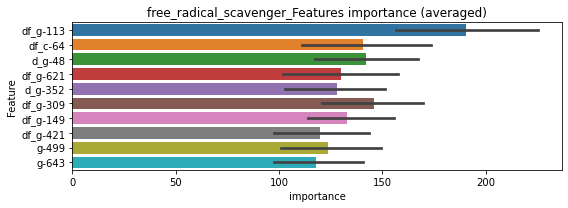

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282003	valid_1's binary_logloss: 0.0460493
[200]	training's binary_logloss: 0.00572155	valid_1's binary_logloss: 0.0178021
[300]	training's binary_logloss: 0.00172203	valid_1's binary_logloss: 0.0109446
[400]	training's binary_logloss: 0.000865994	valid_1's binary_logloss: 0.00939531
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000733865	valid_1's binary_logloss: 0.00907774


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278442	valid_1's binary_logloss: 0.0474596
[200]	training's binary_logloss: 0.00554779	valid_1's binary_logloss: 0.017553
[300]	training's binary_logloss: 0.00166748	valid_1's binary_logloss: 0.0103554
[400]	training's binary_logloss: 0.00083996	valid_1's binary_logloss: 0.00841022
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000693677	valid_1's binary_logloss: 0.00810851


free_radical_scavenger logloss: 0.00859318584002892


neg labels: 3289 → selected neg labels: 3287


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3287, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715845	valid_1's binary_logloss: 0.103618
[200]	training's binary_logloss: 0.0181643	valid_1's binary_logloss: 0.0435729
[300]	training's binary_logloss: 0.00564323	valid_1's binary_logloss: 0.024359
[400]	training's binary_logloss: 0.00262528	valid_1's binary_logloss: 0.0171183
[500]	training's binary_logloss: 0.0016646	valid_1's binary_logloss: 0.0143656
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00133204	valid_1's binary_logloss: 0.0132914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681552	valid_1's binary_logloss: 0.100017
[200]	training's binary_logloss: 0.0163857	valid_1's binary_logloss: 0.0448915
[300]	training's binary_logloss: 0.00501088	valid_1's binary_logloss: 0.0278307
[400]	training's binary_logloss: 0.00235952	valid_1's binary_logloss: 0.0229644
Early stopping, best iteration is:
[475]	training's

1 / 3 AUC score:1.000
y_Threshold: 0.0252034, Threshold: 0.1832145, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.16489, conf_1:0.20154
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.1832145
Num_p_label: 34.0, Expected: 3.8, Adj_threshold_2: 0.2132145
Num_p_label: 30.0, Expected: 3.8, Adj_threshold_3: 0.2432145
Num_p_label: 25.0, Expected: 3.8, Adj_threshold_4: 0.2732145
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_5: 0.3032145
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_6: 0.3332145
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_7: 0.3632145
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_8: 0.3932145
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_9: 0.4232145
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_10: 0.4532145
threshold: 0.4532145, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580071	valid_1's binary_logloss: 0.090519
[200]	training's binary_logloss: 0.0132522	valid_1's binary_logloss: 0.0364636
[300]	training's binary_logloss: 0.00422762	valid_1's binary_logloss: 0.0209036
[400]	training's binary_logloss: 0.00209933	valid_1's binary_logloss: 0.0155677
[500]	training's binary_logloss: 0.0014083	valid_1's binary_logloss: 0.013838
[600]	training's binary_logloss: 0.0011092	valid_1's binary_logloss: 0.0129897
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.000988333	valid_1's binary_logloss: 0.0123779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062216	valid_1's binary_logloss: 0.0893443
[200]	training's binary_logloss: 0.0137577	valid_1's binary_logloss: 0.0348599
[300]	training's binary_logloss: 0.00412308	valid_1's binary_logloss: 0.0199492


2 / 3 AUC score:1.000
y_Threshold: 0.1525410, Threshold: 0.4532145, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 651.0/3800
p_label_rate: 0.0080362 Vs.target_rate: 0.00097, Num_p_label: 32.0, conf_0:0.40789, conf_1:0.49854
Num_p_label: 32.0, Expected: 3.8, Adj_threshold_1: 0.4532145
Num_p_label: 29.0, Expected: 3.8, Adj_threshold_2: 0.4832145
Num_p_label: 25.0, Expected: 3.8, Adj_threshold_3: 0.5132145
Num_p_label: 24.0, Expected: 3.8, Adj_threshold_4: 0.5432145


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00216975	valid_1's binary_logloss: 0.0167373


Num_p_label: 21.0, Expected: 3.8, Adj_threshold_5: 0.5732145
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_6: 0.6032145
Num_p_label: 19.0, Expected: 3.8, Adj_threshold_7: 0.6332145
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_8: 0.6632145
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_9: 0.6932145
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_10: 0.7232145
threshold: 0.7532145, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 651.0/3800, y_label_rate: 0.1713158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568084	valid_1's binary_logloss: 0.0854906
[200]	training's binary_logloss: 0.0122913	valid_1's binary_logloss: 0.0312877
[300]	training's binary_logloss: 0.00392502	valid_1's binary_logloss: 0.0167983
[400]	training's binary_logloss: 0.00195707	valid_1's binary_logloss: 0.0124044
[500]	training's binary_logloss: 0.00131246	valid_1's binary_logloss: 0.0107135
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0011314	valid_1's binary_logloss: 0.0100239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585993	valid_1's binary_logloss: 0.084892
[200]	training's binary_logloss: 0.0127088	valid_1's binary_logloss: 0.0273682
[300]	training's binary_logloss: 0.00399984	valid_1's binary_logloss: 0.013572
[400]	training's binary_logloss: 0.00200477	valid_1's binary_logloss: 0.00889521
[500]	training's binary_logloss: 0.00134756	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1542159, Threshold: 0.7532145, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3798
p_label_rate: 0.0025113 Vs.target_rate: 0.00097, Num_p_label: 10.0, conf_0:0.67789, conf_1:0.82854
threshold: 0.7532145, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 660.0/7780, y_label_rate: 0.0848329


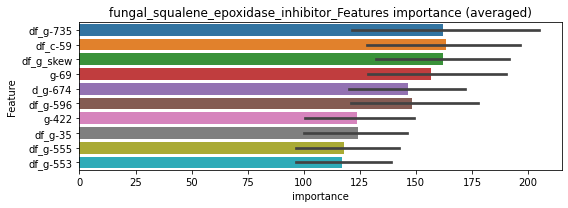

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360111	valid_1's binary_logloss: 0.0565969
[200]	training's binary_logloss: 0.00884577	valid_1's binary_logloss: 0.0245615
[300]	training's binary_logloss: 0.00258661	valid_1's binary_logloss: 0.0145445
[400]	training's binary_logloss: 0.0011703	valid_1's binary_logloss: 0.0119353
[500]	training's binary_logloss: 0.000768123	valid_1's binary_logloss: 0.0111001
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000788384	valid_1's binary_logloss: 0.0110086


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394567	valid_1's binary_logloss: 0.057833
[200]	training's binary_logloss: 0.00959943	valid_1's binary_logloss: 0.0228079
[300]	training's binary_logloss: 0.00281708	valid_1's binary_logloss: 0.0122263
[400]	training's binary_logloss: 0.00129552	valid_1's binary_logloss: 0.00862873
[500]	training's binary_logloss: 0.000840875	valid_1's binary_logloss: 0.00710686
[600]	training's binary_logloss: 0.000658532	valid_1's binary_logloss: 0.00655301
[700]	training's binary_logloss: 0.000561021	valid_1's binary_logloss: 0.00613416
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00054885	valid_1's binary_logloss: 0.00606465


fungal_squalene_epoxidase_inhibitor logloss: 0.00853662184320587


neg labels: 3289 → selected neg labels: 3271


gaba_receptor_agonist, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119963	valid_1's binary_logloss: 0.209174
[200]	training's binary_logloss: 0.05391	valid_1's binary_logloss: 0.163458
[300]	training's binary_logloss: 0.0245762	valid_1's binary_logloss: 0.143484
[400]	training's binary_logloss: 0.0120021	valid_1's binary_logloss: 0.135577
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0074497	valid_1's binary_logloss: 0.132848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136153	valid_1's binary_logloss: 0.195689
[200]	training's binary_logloss: 0.069212	valid_1's binary_logloss: 0.150574
[300]	training's binary_logloss: 0.0312658	valid_1's binary_logloss: 0.127633
[400]	training's binary_logloss: 0.0164682	valid_1's binary_logloss: 0.117303
[500]	training's binary_logloss: 0.00859221	valid_1's binary_logloss: 0.11071
Early stopping, best iteration is:
[505]	training's binary_logloss: 

1 / 3 AUC score:0.976
y_Threshold: 0.0689601, Threshold: 0.2543232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 237 → Positive_corect_labels: 601/3688
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.22889, conf_1:0.27976
threshold: 0.2543232, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108579	valid_1's binary_logloss: 0.175478
[200]	training's binary_logloss: 0.0469962	valid_1's binary_logloss: 0.128512
[300]	training's binary_logloss: 0.0191382	valid_1's binary_logloss: 0.105828
[400]	training's binary_logloss: 0.0085317	valid_1's binary_logloss: 0.0947732
[500]	training's binary_logloss: 0.0046942	valid_1's binary_logloss: 0.0895038
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00434035	valid_1's binary_logloss: 0.0885857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101685	valid_1's binary_logloss: 0.175535
[200]	training's binary_logloss: 0.0413802	valid_1's binary_logloss: 0.126842
[300]	training's binary_logloss: 0.0169304	valid_1's binary_logloss: 0.105972
[400]	training's binary_logloss: 0.00776127	valid_1's binary_logloss: 0.095726
Early stopping, best iteration is:
[452]	training's binary_l

2 / 3 AUC score:0.988
y_Threshold: 0.1094326, Threshold: 0.2543232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 555.0/3596
p_label_rate: 0.0268709 Vs.target_rate: 0.00445, Num_p_label: 107.0, conf_0:0.22889, conf_1:0.27976
Num_p_label: 107.0, Expected: 17.7, Adj_threshold_1: 0.2543232
Num_p_label: 93.0, Expected: 17.7, Adj_threshold_2: 0.2843232
Num_p_label: 81.0, Expected: 17.7, Adj_threshold_3: 0.3143232
Num_p_label: 73.0, Expected: 17.7, Adj_threshold_4: 0.3443232
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_5: 0.3743232
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_6: 0.4043232
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_7: 0.4343232
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_8: 0.4643232
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_9: 0.4943232
threshold: 0.4943232, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 555.0/3596, y_label_rate: 0.1543382
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909328	valid_1's binary_logloss: 0.139617
[200]	training's binary_logloss: 0.0348926	valid_1's binary_logloss: 0.0919096
[300]	training's binary_logloss: 0.0135145	valid_1's binary_logloss: 0.069862
[400]	training's binary_logloss: 0.00628224	valid_1's binary_logloss: 0.0610839
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00412808	valid_1's binary_logloss: 0.0571728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906657	valid_1's binary_logloss: 0.144065
[200]	training's binary_logloss: 0.035242	valid_1's binary_logloss: 0.0970487
[300]	training's binary_logloss: 0.0143506	valid_1's binary_logloss: 0.0766457
[400]	training's binary_logloss: 0.00639536	valid_1's binary_logloss: 0.0674005
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00541377	valid_1's binary_logloss: 0.0655239


3 / 3 AUC score:0.996
y_Threshold: 0.1232844, Threshold: 0.4943232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 529.0/3544
p_label_rate: 0.0150678 Vs.target_rate: 0.00445, Num_p_label: 60.0, conf_0:0.44489, conf_1:0.54376
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_1: 0.4943232
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_2: 0.5243232
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_3: 0.5543232
Num_p_label: 46.0, Expected: 17.7, Adj_threshold_4: 0.5843232
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_5: 0.6143232
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_6: 0.6443232
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_7: 0.6743232
threshold: 0.6743232, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 564.0/7526, y_label_rate: 0.0749402


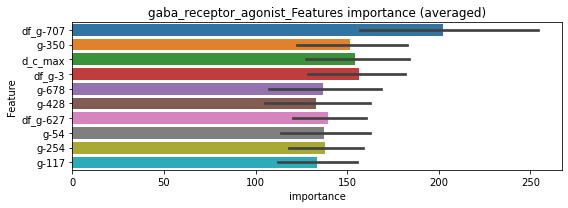

len(train_index) : 3763
len(valid_index) : 3763
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503542	valid_1's binary_logloss: 0.0840959
[200]	training's binary_logloss: 0.0191862	valid_1's binary_logloss: 0.0566114
[300]	training's binary_logloss: 0.00754575	valid_1's binary_logloss: 0.0459253
[400]	training's binary_logloss: 0.00343506	valid_1's binary_logloss: 0.0410493
[500]	training's binary_logloss: 0.00189083	valid_1's binary_logloss: 0.0394297
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00192977	valid_1's binary_logloss: 0.0393642


len(train_index) : 3763
len(valid_index) : 3763
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532093	valid_1's binary_logloss: 0.0844558
[200]	training's binary_logloss: 0.0209784	valid_1's binary_logloss: 0.0563972
[300]	training's binary_logloss: 0.0089843	valid_1's binary_logloss: 0.0454029
[400]	training's binary_logloss: 0.00421168	valid_1's binary_logloss: 0.0400467
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00318792	valid_1's binary_logloss: 0.0382978


gaba_receptor_agonist logloss: 0.03883099745824718


neg labels: 3289 → selected neg labels: 3266


gaba_receptor_antagonist, len(trt): 165, len(othr): 3266, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16876	valid_1's binary_logloss: 0.274178
[200]	training's binary_logloss: 0.0853356	valid_1's binary_logloss: 0.229936
[300]	training's binary_logloss: 0.0445018	valid_1's binary_logloss: 0.212916
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0383778	valid_1's binary_logloss: 0.21023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160912	valid_1's binary_logloss: 0.270109
[200]	training's binary_logloss: 0.08495	valid_1's binary_logloss: 0.228109
[300]	training's binary_logloss: 0.0467198	valid_1's binary_logloss: 0.207777


1 / 3 AUC score:0.931
y_Threshold: 0.1191948, Threshold: 0.2831359, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 377 → Positive_corect_labels: 530/3542
p_label_rate: 0.0100452 Vs.target_rate: 0.00693, Num_p_label: 40.0, conf_0:0.25482, conf_1:0.31145
threshold: 0.2831359, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0295091	valid_1's binary_logloss: 0.199591


positive_y_label: 530.0/3542, y_label_rate: 0.1496330
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115282	valid_1's binary_logloss: 0.197518
[200]	training's binary_logloss: 0.0503226	valid_1's binary_logloss: 0.149884
[300]	training's binary_logloss: 0.0221905	valid_1's binary_logloss: 0.127267
[400]	training's binary_logloss: 0.0103566	valid_1's binary_logloss: 0.118099
[500]	training's binary_logloss: 0.00573498	valid_1's binary_logloss: 0.112174
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00578743	valid_1's binary_logloss: 0.112167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1118	valid_1's binary_logloss: 0.214673
[200]	training's binary_logloss: 0.0511375	valid_1's binary_logloss: 0.16842
[300]	training's binary_logloss: 0.0230294	valid_1's binary_logloss: 0.147753


2 / 3 AUC score:0.980
y_Threshold: 0.1143758, Threshold: 0.2831359, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.0112384	valid_1's binary_logloss: 0.137055
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0108508	valid_1's binary_logloss: 0.136659


Remove_noisy_labels: 124 → Positive_corect_labels: 468.0/3418
p_label_rate: 0.0198393 Vs.target_rate: 0.00693, Num_p_label: 79.0, conf_0:0.25482, conf_1:0.31145
threshold: 0.2831359, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 468.0/3418, y_label_rate: 0.1369222
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915978	valid_1's binary_logloss: 0.173031
[200]	training's binary_logloss: 0.0339845	valid_1's binary_logloss: 0.120079
[300]	training's binary_logloss: 0.014154	valid_1's binary_logloss: 0.0977054
[400]	training's binary_logloss: 0.00674132	valid_1's binary_logloss: 0.0895587
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00624105	valid_1's binary_logloss: 0.0885569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931164	valid_1's binary_logloss: 0.16728
[200]	training's binary_logloss: 0.0343214	valid_1's binary_logloss: 0.119346


3 / 3 AUC score:0.987
y_Threshold: 0.1212194, Threshold: 0.2831359, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 423.0/3328
p_label_rate: 0.0366650 Vs.target_rate: 0.00693, Num_p_label: 146.0, conf_0:0.25482, conf_1:0.31145
Num_p_label: 146.0, Expected: 27.6, Adj_threshold_1: 0.2831359
Num_p_label: 138.0, Expected: 27.6, Adj_threshold_2: 0.3131359
Num_p_label: 133.0, Expected: 27.6, Adj_threshold_3: 0.3431359
Num_p_label: 120.0, Expected: 27.6, Adj_threshold_4: 0.3731359
Num_p_label: 103.0, Expected: 27.6, Adj_threshold_5: 0.4031359
Num_p_label: 94.0, Expected: 27.6, Adj_threshold_6: 0.4331359
Num_p_label: 86.0, Expected: 27.6, Adj_threshold_7: 0.4631359
Num_p_label: 79.0, Expected: 27.6, Adj_threshold_8: 0.4931359
Num_p_label: 72.0, Expected: 27.6, Adj_threshold_9: 0.5231359
Num_p_label: 68.0, Expected: 27.6, Adj_threshold_10: 0.5531359
threshold: 0.5831359, positive_p_label: 55.0/3982, p_label_rate: 0.0138122


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.018171	valid_1's binary_logloss: 0.105419


positive_y_label: 478.0/7310, y_label_rate: 0.0653899


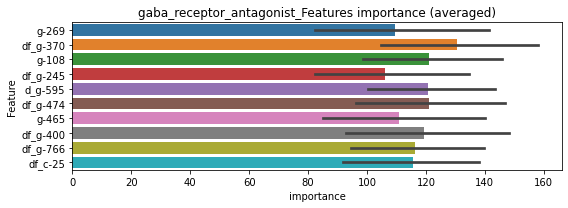

len(train_index) : 3655
len(valid_index) : 3655
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423134	valid_1's binary_logloss: 0.0916194
[200]	training's binary_logloss: 0.0159371	valid_1's binary_logloss: 0.0707417


len(train_index) : 3655
len(valid_index) : 3655


[300]	training's binary_logloss: 0.00655594	valid_1's binary_logloss: 0.0629399
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0062927	valid_1's binary_logloss: 0.0626105


================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462395	valid_1's binary_logloss: 0.0880398
[200]	training's binary_logloss: 0.0169608	valid_1's binary_logloss: 0.062115
[300]	training's binary_logloss: 0.00739949	valid_1's binary_logloss: 0.0533382
[400]	training's binary_logloss: 0.00342939	valid_1's binary_logloss: 0.0482094
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00213782	valid_1's binary_logloss: 0.0460173


gaba_receptor_antagonist logloss: 0.05431386274508817


neg labels: 3289 → selected neg labels: 3284


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3284, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.196547
[200]	training's binary_logloss: 0.0513454	valid_1's binary_logloss: 0.126787
[300]	training's binary_logloss: 0.0212696	valid_1's binary_logloss: 0.0939308
[400]	training's binary_logloss: 0.00871374	valid_1's binary_logloss: 0.0753
[500]	training's binary_logloss: 0.00441653	valid_1's binary_logloss: 0.0647158
[600]	training's binary_logloss: 0.00284634	valid_1's binary_logloss: 0.0611712
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00270342	valid_1's binary_logloss: 0.060682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135636	valid_1's binary_logloss: 0.200325
[200]	training's binary_logloss: 0.0533235	valid_1's binary_logloss: 0.126906
[300]	training's binary_logloss: 0.0199347	valid_1's binary_logloss: 0.0904804
[400]	training's binary_logloss: 0.00853175	valid_1's binar

1 / 3 AUC score:0.994
y_Threshold: 0.0755392, Threshold: 0.3166556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 640/3776
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.28499, conf_1:0.34832
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.3166556
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_2: 0.3466556
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_3: 0.3766556
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.4066556
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_5: 0.4366556
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_6: 0.4666556
threshold: 0.4666556, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121066	valid_1's binary_logloss: 0.177724
[200]	training's binary_logloss: 0.0436106	valid_1's binary_logloss: 0.104164
[300]	training's binary_logloss: 0.0164897	valid_1's binary_logloss: 0.0716737
[400]	training's binary_logloss: 0.0072729	valid_1's binary_logloss: 0.0574006
[500]	training's binary_logloss: 0.00394924	valid_1's binary_logloss: 0.0509558
[600]	training's binary_logloss: 0.00260773	valid_1's binary_logloss: 0.048706
[700]	training's binary_logloss: 0.00199874	valid_1's binary_logloss: 0.0471501
Early stopping, best iteration is:
[734]	training's binary_logloss: 0.00185398	valid_1's binary_logloss: 0.0466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112241	valid_1's binary_logloss: 0.171975
[200]	training's binary_logloss: 0.0384257	valid_1's binary_logloss: 0.0949412
[300]	training's binary_logloss: 0.0143985	valid_1's binar

2 / 3 AUC score:0.997
y_Threshold: 0.2007595, Threshold: 0.4666556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 619.0/3734
p_label_rate: 0.0102963 Vs.target_rate: 0.00235, Num_p_label: 41.0, conf_0:0.41999, conf_1:0.51332
Num_p_label: 41.0, Expected: 9.4, Adj_threshold_1: 0.4666556
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_2: 0.4966556
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_3: 0.5266556
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_4: 0.5566556
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_5: 0.5866556
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_6: 0.6166556
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_7: 0.6466556
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_8: 0.6766556
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_9: 0.7066556
threshold: 0.7066556, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 619.0/3734, y_label_rate: 0.1657740
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113073	valid_1's binary_logloss: 0.163992
[200]	training's binary_logloss: 0.0409497	valid_1's binary_logloss: 0.0936836
[300]	training's binary_logloss: 0.0151098	valid_1's binary_logloss: 0.0611556
[400]	training's binary_logloss: 0.00668442	valid_1's binary_logloss: 0.0464136
[500]	training's binary_logloss: 0.00358345	valid_1's binary_logloss: 0.0391942
[600]	training's binary_logloss: 0.00240494	valid_1's binary_logloss: 0.0358875
[700]	training's binary_logloss: 0.00188009	valid_1's binary_logloss: 0.0343063
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00169401	valid_1's binary_logloss: 0.0336572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106978	valid_1's binary_logloss: 0.158079
[200]	training's binary_logloss: 0.0381569	valid_1's binary_logloss: 0.09069
[300]	training's binary_logloss: 0.0134676	valid_1's b

3 / 3 AUC score:0.998
y_Threshold: 0.1815455, Threshold: 0.7066556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 602.0/3700
p_label_rate: 0.0057760 Vs.target_rate: 0.00235, Num_p_label: 23.0, conf_0:0.63599, conf_1:0.77732
threshold: 0.7066556, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 625.0/7682, y_label_rate: 0.0813590


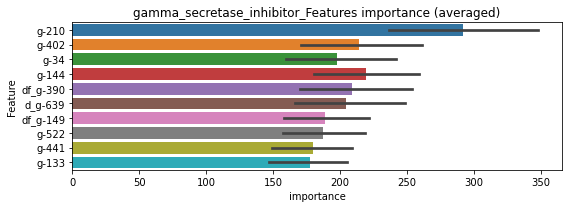

len(train_index) : 3841
len(valid_index) : 3841
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663621	valid_1's binary_logloss: 0.108372
[200]	training's binary_logloss: 0.0208435	valid_1's binary_logloss: 0.0641477
[300]	training's binary_logloss: 0.00779381	valid_1's binary_logloss: 0.0491679
[400]	training's binary_logloss: 0.003327	valid_1's binary_logloss: 0.0431747
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00209414	valid_1's binary_logloss: 0.0414864


len(train_index) : 3841
len(valid_index) : 3841
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691886	valid_1's binary_logloss: 0.0998666
[200]	training's binary_logloss: 0.0243818	valid_1's binary_logloss: 0.0543204
[300]	training's binary_logloss: 0.00908667	valid_1's binary_logloss: 0.0360494
[400]	training's binary_logloss: 0.00386219	valid_1's binary_logloss: 0.0269834
[500]	training's binary_logloss: 0.00200332	valid_1's binary_logloss: 0.0221813
[600]	training's binary_logloss: 0.00132929	valid_1's binary_logloss: 0.0204143
[700]	training's binary_logloss: 0.00101451	valid_1's binary_logloss: 0.0196126
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00103158	valid_1's binary_logloss: 0.0195163


gamma_secretase_inhibitor logloss: 0.030501364751472


neg labels: 3289 → selected neg labels: 3248


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3248, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21181	valid_1's binary_logloss: 0.364957
[200]	training's binary_logloss: 0.117636	valid_1's binary_logloss: 0.338289
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0815041	valid_1's binary_logloss: 0.329589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220918	valid_1's binary_logloss: 0.357338
[200]	training's binary_logloss: 0.130257	valid_1's binary_logloss: 0.32701


1 / 3 AUC score:0.836
y_Threshold: 0.1921686, Threshold: 0.4458137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 581 → Positive_corect_labels: 424/3316
p_label_rate: 0.0100452 Vs.target_rate: 0.01117, Num_p_label: 40.0, conf_0:0.40123, conf_1:0.49040
threshold: 0.4458137, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 424.0/3316, y_label_rate: 0.1278649
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0877654	valid_1's binary_logloss: 0.31489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129461	valid_1's binary_logloss: 0.252546
[200]	training's binary_logloss: 0.0583688	valid_1's binary_logloss: 0.21906
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0285335	valid_1's binary_logloss: 0.205551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128421	valid_1's binary_logloss: 0.247093
[200]	training's binary_logloss: 0.0570184	valid_1's binary_logloss: 0.215668
[300]	training's binary_logloss: 0.0276772	valid_1's binary_logloss: 0.20411
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0246676	valid_1's binary_logloss: 0.20264


2 / 3 AUC score:0.919
y_Threshold: 0.1705962, Threshold: 0.4458137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 238 → Positive_corect_labels: 305.0/3078
p_label_rate: 0.0223506 Vs.target_rate: 0.01117, Num_p_label: 89.0, conf_0:0.40123, conf_1:0.49040
threshold: 0.4458137, positive_p_label: 89.0/3982, p_label_rate: 0.0223506
positive_y_label: 305.0/3078, y_label_rate: 0.0990903
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829666	valid_1's binary_logloss: 0.177197
[200]	training's binary_logloss: 0.0295015	valid_1's binary_logloss: 0.14598
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0211934	valid_1's binary_logloss: 0.140658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826792	valid_1's binary_logloss: 0.184736
[200]	training's binary_logloss: 0.0297262	valid_1's binary_logloss: 0.151826
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0184275	valid_1's binary_logloss: 0.145898


3 / 3 AUC score:0.950
y_Threshold: 0.1627659, Threshold: 0.4458137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 234.0/2936
p_label_rate: 0.0266198 Vs.target_rate: 0.01117, Num_p_label: 106.0, conf_0:0.40123, conf_1:0.49040
threshold: 0.4458137, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 340.0/6918, y_label_rate: 0.0491472


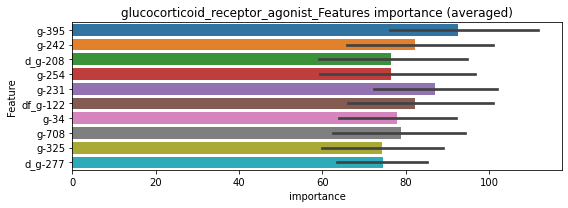

len(train_index) : 3459
len(valid_index) : 3459
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428298	valid_1's binary_logloss: 0.105104
[200]	training's binary_logloss: 0.0140417	valid_1's binary_logloss: 0.0897686


len(train_index) : 3459
len(valid_index) : 3459
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00716003	valid_1's binary_logloss: 0.0859054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471904	valid_1's binary_logloss: 0.0989039
[200]	training's binary_logloss: 0.0163989	valid_1's binary_logloss: 0.0804471


glucocorticoid_receptor_agonist logloss: 0.08157538141649788


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00837116	valid_1's binary_logloss: 0.0772454
neg labels: 3289 → selected neg labels: 3285


glutamate_inhibitor, len(trt): 13, len(othr): 3285, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433901	valid_1's binary_logloss: 0.0585273
[200]	training's binary_logloss: 0.0072784	valid_1's binary_logloss: 0.0163979
[300]	training's binary_logloss: 0.00211323	valid_1's binary_logloss: 0.00749423
[400]	training's binary_logloss: 0.00115546	valid_1's binary_logloss: 0.00546168
[500]	training's binary_logloss: 0.000838697	valid_1's binary_logloss: 0.004579
[600]	training's binary_logloss: 0.000695168	valid_1's binary_logloss: 0.00420672
[700]	training's binary_logloss: 0.000649216	valid_1's binary_logloss: 0.00405527
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.000648268	valid_1's binary_logloss: 0.00404485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427055	valid_1's binary_logloss: 0.0571727
[200]	training's binary_logloss: 0.00714294	valid_1's binary_logloss: 0.0174815
[300]	training's binary_logloss: 0.002

1 / 3 AUC score:1.000
y_Threshold: 0.0091939, Threshold: 0.0560648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00055, Num_p_label: 40.0, conf_0:0.05046, conf_1:0.06167
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_1: 0.0560648
Num_p_label: 25.0, Expected: 2.2, Adj_threshold_2: 0.0860648
Num_p_label: 18.0, Expected: 2.2, Adj_threshold_3: 0.1160648
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_4: 0.1460648
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_5: 0.1760648
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_6: 0.2060648
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_7: 0.2360648
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_8: 0.2660648
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_9: 0.2960648


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000970378	valid_1's binary_logloss: 0.00709042


Num_p_label: 5.0, Expected: 2.2, Adj_threshold_10: 0.3260648
threshold: 0.3560648, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364338	valid_1's binary_logloss: 0.049748
[200]	training's binary_logloss: 0.00566147	valid_1's binary_logloss: 0.0129271
[300]	training's binary_logloss: 0.00173363	valid_1's binary_logloss: 0.00567652
[400]	training's binary_logloss: 0.000937198	valid_1's binary_logloss: 0.00386986
[500]	training's binary_logloss: 0.000690503	valid_1's binary_logloss: 0.0032095
[600]	training's binary_logloss: 0.000607924	valid_1's binary_logloss: 0.00301927
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000607924	valid_1's binary_logloss: 0.00301927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377922	valid_1's binary_logloss: 0.0495195
[200]	training's binary_logloss: 0.00588207	valid_1's binary_logloss: 0.0116127
[300]	training's binary_logloss: 0.00177572	valid_1's binary_logloss: 0.00502031
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1576511, Threshold: 0.3560648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00055, Num_p_label: 15.0, conf_0:0.32046, conf_1:0.39167
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_1: 0.3560648
Num_p_label: 14.0, Expected: 2.2, Adj_threshold_2: 0.3860648
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_3: 0.4160648
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_4: 0.4460648
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_5: 0.4760648
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_6: 0.5060648
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_7: 0.5360648
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_8: 0.5660648
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_9: 0.5960648
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_10: 0.6260648
threshold: 0.6560648, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351172	valid_1's binary_logloss: 0.055903
[200]	training's binary_logloss: 0.00555076	valid_1's binary_logloss: 0.0202769
[300]	training's binary_logloss: 0.00169064	valid_1's binary_logloss: 0.0120101
[400]	training's binary_logloss: 0.000937441	valid_1's binary_logloss: 0.0095012
[500]	training's binary_logloss: 0.000695564	valid_1's binary_logloss: 0.00850735
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000620084	valid_1's binary_logloss: 0.00808167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359651	valid_1's binary_logloss: 0.0462849
[200]	training's binary_logloss: 0.00559159	valid_1's binary_logloss: 0.0107501
[300]	training's binary_logloss: 0.00174404	valid_1's binary_logloss: 0.00436378
[400]	training's binary_logloss: 0.000961545	valid_1's binary_logloss: 0.00276544
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1759260, Threshold: 0.6560648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0020090 Vs.target_rate: 0.00055, Num_p_label: 8.0, conf_0:0.59046, conf_1:0.72167
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_1: 0.6560648
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.6860648
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.7160648
threshold: 0.7160648, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 658.0/7786, y_label_rate: 0.0845107


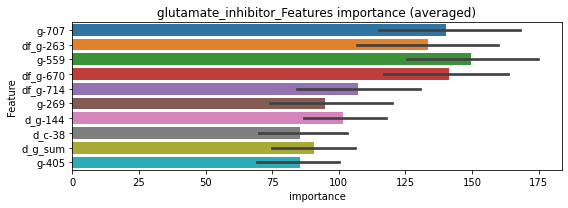

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223337	valid_1's binary_logloss: 0.0299171
[200]	training's binary_logloss: 0.00397214	valid_1's binary_logloss: 0.00907041
[300]	training's binary_logloss: 0.00111128	valid_1's binary_logloss: 0.004767
[400]	training's binary_logloss: 0.000575553	valid_1's binary_logloss: 0.00376235
[500]	training's binary_logloss: 0.000420413	valid_1's binary_logloss: 0.00340168


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000406067	valid_1's binary_logloss: 0.00336399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210773	valid_1's binary_logloss: 0.0328371
[200]	training's binary_logloss: 0.00366084	valid_1's binary_logloss: 0.0136515
[300]	training's binary_logloss: 0.00109649	valid_1's binary_logloss: 0.0072644
[400]	training's binary_logloss: 0.000586568	valid_1's binary_logloss: 0.0059058
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000451171	valid_1's binary_logloss: 0.00541571


glutamate_inhibitor logloss: 0.0043898511694751225


neg labels: 3289 → selected neg labels: 3283


glutamate_receptor_agonist, len(trt): 74, len(othr): 3283, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119832	valid_1's binary_logloss: 0.194872
[200]	training's binary_logloss: 0.0498184	valid_1's binary_logloss: 0.131435
[300]	training's binary_logloss: 0.0209208	valid_1's binary_logloss: 0.101519
[400]	training's binary_logloss: 0.0100524	valid_1's binary_logloss: 0.0900402
[500]	training's binary_logloss: 0.0053114	valid_1's binary_logloss: 0.0823426
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00346981	valid_1's binary_logloss: 0.0785584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12164	valid_1's binary_logloss: 0.187097
[200]	training's binary_logloss: 0.0504075	valid_1's binary_logloss: 0.12136
[300]	training's binary_logloss: 0.0222354	valid_1's binary_logloss: 0.0931432
[400]	training's binary_logloss: 0.0102714	valid_1's binary_logloss: 0.0799539
[500]	training's binary_logloss: 0.00545638	valid_1's binary_

1 / 3 AUC score:0.992
y_Threshold: 0.0576449, Threshold: 0.5437296, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 635/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.48936, conf_1:0.59810
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.5437296
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_2: 0.5737296
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_3: 0.6037296
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_4: 0.6337296
threshold: 0.6337296, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 635.0/3765, y_label_rate: 0.1686587
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121698	valid_1's binary_logloss: 0.172358
[200]	training's binary_logloss: 0.0492535	valid_1's binary_logloss: 0.107698
[300]	training's binary_logloss: 0.0193521	valid_1's binary_logloss: 0.0763767
[400]	training's binary_logloss: 0.00854093	valid_1's binary_logloss: 0.0603808
[500]	training's binary_logloss: 0.0046176	valid_1's binary_logloss: 0.052372
[600]	training's binary_logloss: 0.00274178	valid_1's binary_logloss: 0.0473764
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.0020953	valid_1's binary_logloss: 0.0459481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998789	valid_1's binary_logloss: 0.161983
[200]	training's binary_logloss: 0.03868	valid_1's binary_logloss: 0.0955437
[300]	training's binary_logloss: 0.0145784	valid_1's binary_logloss: 0.065297
[400]	training's binary_logloss: 0.00665331	valid_1's binar

2 / 3 AUC score:0.996
y_Threshold: 0.1769837, Threshold: 0.6337296, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 615.0/3725
p_label_rate: 0.0215972 Vs.target_rate: 0.00311, Num_p_label: 86.0, conf_0:0.57036, conf_1:0.69710
Num_p_label: 86.0, Expected: 12.4, Adj_threshold_1: 0.6337296
Num_p_label: 81.0, Expected: 12.4, Adj_threshold_2: 0.6637296
Num_p_label: 79.0, Expected: 12.4, Adj_threshold_3: 0.6937296
Num_p_label: 75.0, Expected: 12.4, Adj_threshold_4: 0.7237296
Num_p_label: 71.0, Expected: 12.4, Adj_threshold_5: 0.7537296
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_6: 0.7837296
Num_p_label: 61.0, Expected: 12.4, Adj_threshold_7: 0.8137296
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_8: 0.8437296
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_9: 0.8737296
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_10: 0.9037296
threshold: 0.9337296, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 615.0/3725, y_label_rate: 0.16510

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957282	valid_1's binary_logloss: 0.146318
[200]	training's binary_logloss: 0.0349928	valid_1's binary_logloss: 0.0838216
[300]	training's binary_logloss: 0.0133883	valid_1's binary_logloss: 0.0561685
[400]	training's binary_logloss: 0.00629547	valid_1's binary_logloss: 0.0424914
[500]	training's binary_logloss: 0.00346038	valid_1's binary_logloss: 0.0367772
[600]	training's binary_logloss: 0.00231492	valid_1's binary_logloss: 0.0332246
[700]	training's binary_logloss: 0.00181314	valid_1's binary_logloss: 0.0320775
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00165645	valid_1's binary_logloss: 0.0313871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104465	valid_1's binary_logloss: 0.158706
[200]	training's binary_logloss: 0.037495	valid_1's binary_logloss: 0.0870025
[300]	training's binary_logloss: 0.0145258	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.1789882, Threshold: 0.9337296, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 604.0/3703
p_label_rate: 0.0105475 Vs.target_rate: 0.00311, Num_p_label: 42.0, conf_0:0.84036, conf_1:1.02710
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_1: 0.9337296
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.9637296
Num_p_label: 1.0, Expected: 12.4, Adj_threshold_3: 0.9937296
threshold: 0.9937296, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 605.0/7685, y_label_rate: 0.0787248


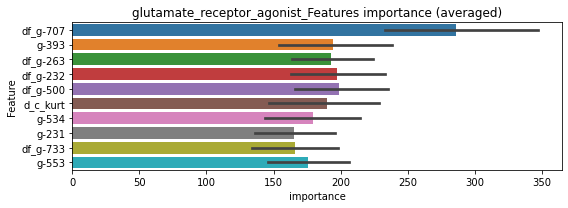

len(train_index) : 3842
len(valid_index) : 3843
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624069	valid_1's binary_logloss: 0.103635
[200]	training's binary_logloss: 0.0227801	valid_1's binary_logloss: 0.0678657
[300]	training's binary_logloss: 0.00903569	valid_1's binary_logloss: 0.0538158
[400]	training's binary_logloss: 0.00391335	valid_1's binary_logloss: 0.0467396
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00230228	valid_1's binary_logloss: 0.0446779


len(train_index) : 3843
len(valid_index) : 3842
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598259	valid_1's binary_logloss: 0.0971522
[200]	training's binary_logloss: 0.0218301	valid_1's binary_logloss: 0.0632755
[300]	training's binary_logloss: 0.00851086	valid_1's binary_logloss: 0.0489155
[400]	training's binary_logloss: 0.00369868	valid_1's binary_logloss: 0.0433778
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00275929	valid_1's binary_logloss: 0.0420059


glutamate_receptor_agonist logloss: 0.04334208190946194


neg labels: 3289 → selected neg labels: 3235


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3235, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237472	valid_1's binary_logloss: 0.396566
[200]	training's binary_logloss: 0.142099	valid_1's binary_logloss: 0.381834
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.142099	valid_1's binary_logloss: 0.381834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227592	valid_1's binary_logloss: 0.388031
[200]	training's binary_logloss: 0.141479	valid_1's binary_logloss: 0.372476
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.118091	valid_1's binary_logloss: 0.368531


1 / 3 AUC score:0.756
y_Threshold: 0.1922865, Threshold: 0.4694739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 728 → Positive_corect_labels: 348/3154
p_label_rate: 0.0100452 Vs.target_rate: 0.01541, Num_p_label: 40.0, conf_0:0.42253, conf_1:0.51642
threshold: 0.4694739, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 348.0/3154, y_label_rate: 0.1103361
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107684	valid_1's binary_logloss: 0.223516
[200]	training's binary_logloss: 0.0487472	valid_1's binary_logloss: 0.196521
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0289343	valid_1's binary_logloss: 0.188905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106407	valid_1's binary_logloss: 0.234503
[200]	training's binary_logloss: 0.0467326	valid_1's binary_logloss: 0.213564
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0357556	valid_1's binary_logloss: 0.210299


2 / 3 AUC score:0.920
y_Threshold: 0.1587460, Threshold: 0.4694739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 236 → Positive_corect_labels: 230.0/2918
p_label_rate: 0.0218483 Vs.target_rate: 0.01541, Num_p_label: 87.0, conf_0:0.42253, conf_1:0.51642
threshold: 0.4694739, positive_p_label: 87.0/3982, p_label_rate: 0.0218483
positive_y_label: 230.0/2918, y_label_rate: 0.0788211
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059607	valid_1's binary_logloss: 0.160712
[200]	training's binary_logloss: 0.0188516	valid_1's binary_logloss: 0.135658
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0113118	valid_1's binary_logloss: 0.131203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566833	valid_1's binary_logloss: 0.174229


3 / 3 AUC score:0.933
y_Threshold: 0.1081942, Threshold: 0.4694739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 153.0/2764
p_label_rate: 0.0326469 Vs.target_rate: 0.01541, Num_p_label: 130.0, conf_0:0.42253, conf_1:0.51642
threshold: 0.4694739, positive_p_label: 130.0/3982, p_label_rate: 0.0326469
positive_y_label: 283.0/6746, y_label_rate: 0.0419508


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0232878	valid_1's binary_logloss: 0.162614


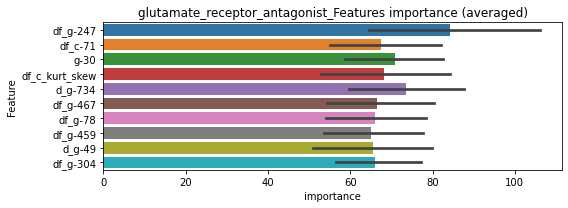

len(train_index) : 3373
len(valid_index) : 3373
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231912	valid_1's binary_logloss: 0.0659846


len(train_index) : 3373
len(valid_index) : 3373
================================= fold 2/2 glutamate_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0078411	valid_1's binary_logloss: 0.0585682
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00871327	valid_1's binary_logloss: 0.0584562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239108	valid_1's binary_logloss: 0.0748102


glutamate_receptor_antagonist logloss: 0.0644477313866449


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0113791	valid_1's binary_logloss: 0.0704392
neg labels: 3289 → selected neg labels: 3287


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057846	valid_1's binary_logloss: 0.0737092
[200]	training's binary_logloss: 0.0119835	valid_1's binary_logloss: 0.0245886
[300]	training's binary_logloss: 0.00351325	valid_1's binary_logloss: 0.0132301
[400]	training's binary_logloss: 0.0016829	valid_1's binary_logloss: 0.0098344
[500]	training's binary_logloss: 0.00117186	valid_1's binary_logloss: 0.00855485
[600]	training's binary_logloss: 0.000952672	valid_1's binary_logloss: 0.00812739
[700]	training's binary_logloss: 0.000849276	valid_1's binary_logloss: 0.0077647
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000835603	valid_1's binary_logloss: 0.0076986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564056	valid_1's binary_logloss: 0.0780291
[200]	training's binary_logloss: 0.011631	valid_1's binary_logloss: 0.0285521
[300]	training's binary_logloss: 0.00339051	v

1 / 3 AUC score:1.000
y_Threshold: 0.0121848, Threshold: 0.0603571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.05432, conf_1:0.06639


Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000976407	valid_1's binary_logloss: 0.0108165


Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0603571
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.0903571
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.1203571
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.1503571
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.1803571
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.2103571
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_7: 0.2403571
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.2703571
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.3003571
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.3303571
threshold: 0.3603571, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503861	valid_1's binary_logloss: 0.0645018
[200]	training's binary_logloss: 0.00966318	valid_1's binary_logloss: 0.0183533
[300]	training's binary_logloss: 0.0028987	valid_1's binary_logloss: 0.00895229
[400]	training's binary_logloss: 0.00147701	valid_1's binary_logloss: 0.00662614
[500]	training's binary_logloss: 0.00105115	valid_1's binary_logloss: 0.00584382
[600]	training's binary_logloss: 0.000855404	valid_1's binary_logloss: 0.00544189
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.000794901	valid_1's binary_logloss: 0.00531091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495161	valid_1's binary_logloss: 0.0693157
[200]	training's binary_logloss: 0.00944794	valid_1's binary_logloss: 0.0210188
[300]	training's binary_logloss: 0.00291808	valid_1's binary_logloss: 0.0101366
[400]	training's binary_logloss: 0.0014

2 / 3 AUC score:1.000
y_Threshold: 0.0959732, Threshold: 0.3603571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.32432, conf_1:0.39639
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.3603571
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.3903571
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.4203571
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.4503571
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_5: 0.4803571
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.5103571
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.5403571
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.5703571
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.6003571
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.6303571
threshold: 0.6303571, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053991	valid_1's binary_logloss: 0.0708545
[200]	training's binary_logloss: 0.010644	valid_1's binary_logloss: 0.0202296
[300]	training's binary_logloss: 0.00305577	valid_1's binary_logloss: 0.00857313
[400]	training's binary_logloss: 0.00151298	valid_1's binary_logloss: 0.00599141
[500]	training's binary_logloss: 0.00104626	valid_1's binary_logloss: 0.00503326
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00103365	valid_1's binary_logloss: 0.00499995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487952	valid_1's binary_logloss: 0.063264
[200]	training's binary_logloss: 0.00914569	valid_1's binary_logloss: 0.0185738
[300]	training's binary_logloss: 0.00280437	valid_1's binary_logloss: 0.00890923
[400]	training's binary_logloss: 0.00144683	valid_1's binary_logloss: 0.00635201
[500]	training's binary_logloss: 0.00102509

3 / 3 AUC score:1.000
y_Threshold: 0.1062654, Threshold: 0.6303571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.56732, conf_1:0.69339
threshold: 0.6303571, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 661.0/7788, y_label_rate: 0.0848742


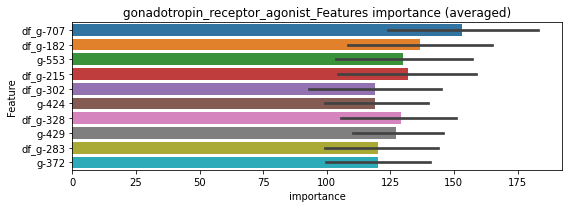

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290337	valid_1's binary_logloss: 0.0415364
[200]	training's binary_logloss: 0.00615807	valid_1's binary_logloss: 0.0156128
[300]	training's binary_logloss: 0.00175415	valid_1's binary_logloss: 0.00902266
[400]	training's binary_logloss: 0.000837233	valid_1's binary_logloss: 0.00758234
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000697569	valid_1's binary_logloss: 0.00731525


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319106	valid_1's binary_logloss: 0.0418429
[200]	training's binary_logloss: 0.00655957	valid_1's binary_logloss: 0.0136115
[300]	training's binary_logloss: 0.00181876	valid_1's binary_logloss: 0.00704201
[400]	training's binary_logloss: 0.000854045	valid_1's binary_logloss: 0.005309
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000691864	valid_1's binary_logloss: 0.00500022


gonadotropin_receptor_agonist logloss: 0.006157739467982108


neg labels: 3289 → selected neg labels: 3281


gsk_inhibitor, len(trt): 60, len(othr): 3281, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124171	valid_1's binary_logloss: 0.194353
[200]	training's binary_logloss: 0.0506639	valid_1's binary_logloss: 0.122026
[300]	training's binary_logloss: 0.0199445	valid_1's binary_logloss: 0.0841282
[400]	training's binary_logloss: 0.00896043	valid_1's binary_logloss: 0.0636154
[500]	training's binary_logloss: 0.00481713	valid_1's binary_logloss: 0.0544415
[600]	training's binary_logloss: 0.0031323	valid_1's binary_logloss: 0.0498121
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00251641	valid_1's binary_logloss: 0.0483752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128782	valid_1's binary_logloss: 0.193794
[200]	training's binary_logloss: 0.0569866	valid_1's binary_logloss: 0.124909
[300]	training's binary_logloss: 0.0238242	valid_1's binary_logloss: 0.0886829
[400]	training's binary_logloss: 0.010456	valid_1's bina

1 / 3 AUC score:0.995
y_Threshold: 0.0607441, Threshold: 0.2751055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.24759, conf_1:0.30262
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.2751055
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_2: 0.3051055
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_3: 0.3351055
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_4: 0.3651055
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_5: 0.3951055
threshold: 0.3951055, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104505	valid_1's binary_logloss: 0.209953
[200]	training's binary_logloss: 0.0373492	valid_1's binary_logloss: 0.144902
[300]	training's binary_logloss: 0.0138891	valid_1's binary_logloss: 0.119876
[400]	training's binary_logloss: 0.00629096	valid_1's binary_logloss: 0.109547
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00555642	valid_1's binary_logloss: 0.109374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114421	valid_1's binary_logloss: 0.189341
[200]	training's binary_logloss: 0.0434303	valid_1's binary_logloss: 0.115629
[300]	training's binary_logloss: 0.0167392	valid_1's binary_logloss: 0.082412
[400]	training's binary_logloss: 0.00770158	valid_1's binary_logloss: 0.065214
[500]	training's binary_logloss: 0.00422223	valid_1's binary_logloss: 0.0574292
[600]	training's binary_logloss: 0.00282629	valid_1's binary

2 / 3 AUC score:0.990
y_Threshold: 0.1724352, Threshold: 0.3951055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 76 → Positive_corect_labels: 609.0/3711
p_label_rate: 0.0143144 Vs.target_rate: 0.00252, Num_p_label: 57.0, conf_0:0.35559, conf_1:0.43462
Num_p_label: 57.0, Expected: 10.0, Adj_threshold_1: 0.3951055
Num_p_label: 48.0, Expected: 10.0, Adj_threshold_2: 0.4251055
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_3: 0.4551055
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_4: 0.4851055
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_5: 0.5151055
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_6: 0.5451055
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_7: 0.5751055
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_8: 0.6051055
threshold: 0.6051055, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 609.0/3711, y_label_rate: 0.1641067
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097734	valid_1's binary_logloss: 0.175591
[200]	training's binary_logloss: 0.0331118	valid_1's binary_logloss: 0.115413
[300]	training's binary_logloss: 0.0133619	valid_1's binary_logloss: 0.0940347
[400]	training's binary_logloss: 0.00610692	valid_1's binary_logloss: 0.0831265
[500]	training's binary_logloss: 0.00347108	valid_1's binary_logloss: 0.0784022
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.0034092	valid_1's binary_logloss: 0.0782453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105501	valid_1's binary_logloss: 0.17453
[200]	training's binary_logloss: 0.0362666	valid_1's binary_logloss: 0.101563
[300]	training's binary_logloss: 0.0140293	valid_1's binary_logloss: 0.070648
[400]	training's binary_logloss: 0.00625932	valid_1's binary_logloss: 0.0545986
[500]	training's binary_logloss: 0.00359916	valid_1's bina

3 / 3 AUC score:0.991
y_Threshold: 0.1559614, Threshold: 0.6051055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 581.0/3655
p_label_rate: 0.0065294 Vs.target_rate: 0.00252, Num_p_label: 26.0, conf_0:0.54459, conf_1:0.66562
threshold: 0.6051055, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 607.0/7637, y_label_rate: 0.0794815


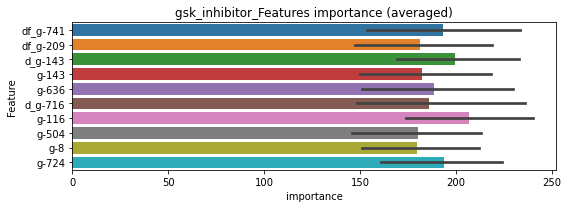

len(train_index) : 3818
len(valid_index) : 3819
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063307	valid_1's binary_logloss: 0.105751
[200]	training's binary_logloss: 0.0230758	valid_1's binary_logloss: 0.0645331
[300]	training's binary_logloss: 0.00870506	valid_1's binary_logloss: 0.0455298
[400]	training's binary_logloss: 0.00384243	valid_1's binary_logloss: 0.0370761
[500]	training's binary_logloss: 0.00208633	valid_1's binary_logloss: 0.0331024
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00183466	valid_1's binary_logloss: 0.0325322


len(train_index) : 3819
len(valid_index) : 3818
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587176	valid_1's binary_logloss: 0.10073
[200]	training's binary_logloss: 0.0207741	valid_1's binary_logloss: 0.0620784
[300]	training's binary_logloss: 0.00809599	valid_1's binary_logloss: 0.0463281
[400]	training's binary_logloss: 0.0036137	valid_1's binary_logloss: 0.0394043
[500]	training's binary_logloss: 0.00199693	valid_1's binary_logloss: 0.0356574
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00182178	valid_1's binary_logloss: 0.0352316


gsk_inhibitor logloss: 0.03388173920685325


neg labels: 3289 → selected neg labels: 3273


hcv_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105991	valid_1's binary_logloss: 0.17353
[200]	training's binary_logloss: 0.0464552	valid_1's binary_logloss: 0.118812
[300]	training's binary_logloss: 0.0184509	valid_1's binary_logloss: 0.0899118
[400]	training's binary_logloss: 0.00835936	valid_1's binary_logloss: 0.0750123
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00567723	valid_1's binary_logloss: 0.0705088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112956	valid_1's binary_logloss: 0.189642
[200]	training's binary_logloss: 0.0430778	valid_1's binary_logloss: 0.124263
[300]	training's binary_logloss: 0.0177392	valid_1's binary_logloss: 0.0974361
[400]	training's binary_logloss: 0.00776954	valid_1's binary_logloss: 0.0821104
[500]	training's binary_logloss: 0.00424321	valid_1's binary_logloss: 0.0754945
Early stopping, best iteration is:
[524]	training's bina

1 / 3 AUC score:0.994
y_Threshold: 0.0479837, Threshold: 0.2120940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 638/3763
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.19088, conf_1:0.23330
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.2120940
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_2: 0.2420940
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_3: 0.2720940
threshold: 0.2720940, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 638.0/3763, y_label_rate: 0.1695456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100885	valid_1's binary_logloss: 0.174346
[200]	training's binary_logloss: 0.0374023	valid_1's binary_logloss: 0.110437
[300]	training's binary_logloss: 0.0147278	valid_1's binary_logloss: 0.0838648
[400]	training's binary_logloss: 0.00683906	valid_1's binary_logloss: 0.072607
[500]	training's binary_logloss: 0.00381259	valid_1's binary_logloss: 0.0666695
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00299428	valid_1's binary_logloss: 0.0650759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103631	valid_1's binary_logloss: 0.17084
[200]	training's binary_logloss: 0.0384131	valid_1's binary_logloss: 0.106436
[300]	training's binary_logloss: 0.0149485	valid_1's binary_logloss: 0.0761622
[400]	training's binary_logloss: 0.00685572	valid_1's binary_logloss: 0.0615251
[500]	training's binary_logloss: 0.00377529	valid_1's bin

2 / 3 AUC score:0.996
y_Threshold: 0.1067173, Threshold: 0.2720940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 612.0/3711
p_label_rate: 0.0173280 Vs.target_rate: 0.00302, Num_p_label: 69.0, conf_0:0.24488, conf_1:0.29930
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_1: 0.2720940
Num_p_label: 62.0, Expected: 12.0, Adj_threshold_2: 0.3020940
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_3: 0.3320940
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_4: 0.3620940
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_5: 0.3920940
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_6: 0.4220940
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_7: 0.4520940
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_8: 0.4820940
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_9: 0.5120940
threshold: 0.5120940, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 612.0/3711, y_label_rate: 0.1649151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868114	valid_1's binary_logloss: 0.159644
[200]	training's binary_logloss: 0.0288351	valid_1's binary_logloss: 0.103949
[300]	training's binary_logloss: 0.0109433	valid_1's binary_logloss: 0.0838253
[400]	training's binary_logloss: 0.00509336	valid_1's binary_logloss: 0.0761176
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00382366	valid_1's binary_logloss: 0.0737353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941279	valid_1's binary_logloss: 0.145088
[200]	training's binary_logloss: 0.0324914	valid_1's binary_logloss: 0.0821071
[300]	training's binary_logloss: 0.0129328	valid_1's binary_logloss: 0.0599592
[400]	training's binary_logloss: 0.00584369	valid_1's binary_logloss: 0.0491107
[500]	training's binary_logloss: 0.00330964	valid_1's binary_logloss: 0.0470163
Early stopping, best iteration is:
[580]	training's 

3 / 3 AUC score:0.992
y_Threshold: 0.1007907, Threshold: 0.5120940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 586.0/3659
p_label_rate: 0.0102963 Vs.target_rate: 0.00302, Num_p_label: 41.0, conf_0:0.46088, conf_1:0.56330
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_1: 0.5120940
Num_p_label: 37.0, Expected: 12.0, Adj_threshold_2: 0.5420940
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_3: 0.5720940
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_4: 0.6020940
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_5: 0.6320940
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_6: 0.6620940
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_7: 0.6920940
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_8: 0.7220940
threshold: 0.7220940, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 609.0/7641, y_label_rate: 0.0797016


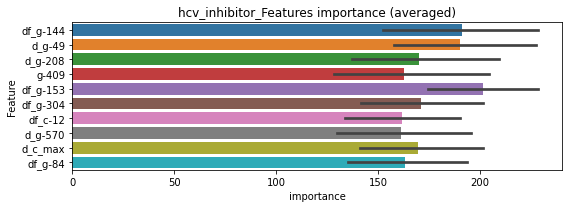

len(train_index) : 3820
len(valid_index) : 3821
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508916	valid_1's binary_logloss: 0.0900294
[200]	training's binary_logloss: 0.0171017	valid_1's binary_logloss: 0.0561541
[300]	training's binary_logloss: 0.00663968	valid_1's binary_logloss: 0.0434758
[400]	training's binary_logloss: 0.00302539	valid_1's binary_logloss: 0.0379336
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00247183	valid_1's binary_logloss: 0.0366131


len(train_index) : 3821
len(valid_index) : 3820
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486609	valid_1's binary_logloss: 0.0838683
[200]	training's binary_logloss: 0.0165504	valid_1's binary_logloss: 0.0477474
[300]	training's binary_logloss: 0.00614324	valid_1's binary_logloss: 0.0337973
[400]	training's binary_logloss: 0.00280332	valid_1's binary_logloss: 0.029002
[500]	training's binary_logloss: 0.00161443	valid_1's binary_logloss: 0.0260949
[600]	training's binary_logloss: 0.00113342	valid_1's binary_logloss: 0.0250965
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00109982	valid_1's binary_logloss: 0.0250428


hcv_inhibitor logloss: 0.030828719275517166


neg labels: 3289 → selected neg labels: 3275


hdac_inhibitor, len(trt): 106, len(othr): 3275, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165628	valid_1's binary_logloss: 0.287991
[200]	training's binary_logloss: 0.0748144	valid_1's binary_logloss: 0.231366
[300]	training's binary_logloss: 0.0353232	valid_1's binary_logloss: 0.205568
[400]	training's binary_logloss: 0.0177627	valid_1's binary_logloss: 0.191094
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0184648	valid_1's binary_logloss: 0.190713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170673	valid_1's binary_logloss: 0.265138
[200]	training's binary_logloss: 0.0800539	valid_1's binary_logloss: 0.204346
[300]	training's binary_logloss: 0.0370699	valid_1's binary_logloss: 0.171028
[400]	training's binary_logloss: 0.0186105	valid_1's binary_logloss: 0.158377
[500]	training's binary_logloss: 0.00950996	valid_1's binary_logloss: 0.147929
Early stopping, best iteration is:
[585]	training's binary_loglo

1 / 3 AUC score:0.957
y_Threshold: 0.1273440, Threshold: 0.4594030, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 289 → Positive_corect_labels: 576/3641
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.41346, conf_1:0.50534
threshold: 0.4594030, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 576.0/3641, y_label_rate: 0.1581983
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121195	valid_1's binary_logloss: 0.217439
[200]	training's binary_logloss: 0.0479397	valid_1's binary_logloss: 0.153668
[300]	training's binary_logloss: 0.0210751	valid_1's binary_logloss: 0.125213
[400]	training's binary_logloss: 0.00973836	valid_1's binary_logloss: 0.110889
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00706416	valid_1's binary_logloss: 0.106859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121352	valid_1's binary_logloss: 0.224413
[200]	training's binary_logloss: 0.0495862	valid_1's binary_logloss: 0.163939
[300]	training's binary_logloss: 0.0211241	valid_1's binary_logloss: 0.13985
[400]	training's binary_logloss: 0.0105069	valid_1's binary_logloss: 0.127611
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00860686	valid_1's binary_logloss: 0.125646


2 / 3 AUC score:0.985
y_Threshold: 0.1385464, Threshold: 0.4594030, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 507.0/3503
p_label_rate: 0.0236062 Vs.target_rate: 0.00445, Num_p_label: 94.0, conf_0:0.41346, conf_1:0.50534
Num_p_label: 94.0, Expected: 17.7, Adj_threshold_1: 0.4594030
Num_p_label: 86.0, Expected: 17.7, Adj_threshold_2: 0.4894030
Num_p_label: 76.0, Expected: 17.7, Adj_threshold_3: 0.5194030
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_4: 0.5494030
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_5: 0.5794030
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_6: 0.6094030
Num_p_label: 48.0, Expected: 17.7, Adj_threshold_7: 0.6394030
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_8: 0.6694030
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_9: 0.6994030
threshold: 0.6994030, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 507.0/3503, y_label_rate: 0.1447331
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112952	valid_1's binary_logloss: 0.180073
[200]	training's binary_logloss: 0.0385056	valid_1's binary_logloss: 0.110405
[300]	training's binary_logloss: 0.0159555	valid_1's binary_logloss: 0.0850928
[400]	training's binary_logloss: 0.00725769	valid_1's binary_logloss: 0.0718499
[500]	training's binary_logloss: 0.00412129	valid_1's binary_logloss: 0.0677272
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00341027	valid_1's binary_logloss: 0.0658927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994776	valid_1's binary_logloss: 0.190654
[200]	training's binary_logloss: 0.0346169	valid_1's binary_logloss: 0.127062
[300]	training's binary_logloss: 0.0136206	valid_1's binary_logloss: 0.10427
[400]	training's binary_logloss: 0.00637908	valid_1's binary_logloss: 0.0973285
Early stopping, best iteration is:
[435]	training's bina

3 / 3 AUC score:0.989
y_Threshold: 0.1514180, Threshold: 0.6994030, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 471.0/3431
p_label_rate: 0.0102963 Vs.target_rate: 0.00445, Num_p_label: 41.0, conf_0:0.62946, conf_1:0.76934
threshold: 0.6994030, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 512.0/7413, y_label_rate: 0.0690679


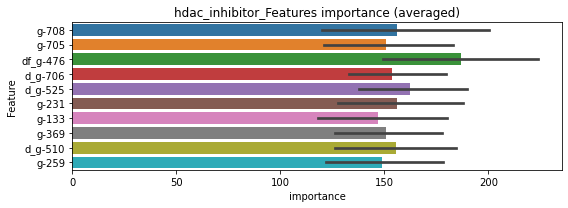

len(train_index) : 3706
len(valid_index) : 3707
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575692	valid_1's binary_logloss: 0.107962
[200]	training's binary_logloss: 0.0196376	valid_1's binary_logloss: 0.0771907
[300]	training's binary_logloss: 0.00780875	valid_1's binary_logloss: 0.0688456
[400]	training's binary_logloss: 0.00355549	valid_1's binary_logloss: 0.0633936
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00235955	valid_1's binary_logloss: 0.0619904


len(train_index) : 3707
len(valid_index) : 3706
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608884	valid_1's binary_logloss: 0.11817
[200]	training's binary_logloss: 0.0206132	valid_1's binary_logloss: 0.0872929
[300]	training's binary_logloss: 0.00799768	valid_1's binary_logloss: 0.0767903
[400]	training's binary_logloss: 0.00362989	valid_1's binary_logloss: 0.0724333
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00279511	valid_1's binary_logloss: 0.0716649


hdac_inhibitor logloss: 0.06682703181770244


neg labels: 3289 → selected neg labels: 3283


histamine_receptor_agonist, len(trt): 59, len(othr): 3283, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128789	valid_1's binary_logloss: 0.183572
[200]	training's binary_logloss: 0.0531492	valid_1's binary_logloss: 0.120822
[300]	training's binary_logloss: 0.021639	valid_1's binary_logloss: 0.0882922
[400]	training's binary_logloss: 0.00960633	valid_1's binary_logloss: 0.071948
[500]	training's binary_logloss: 0.00485992	valid_1's binary_logloss: 0.063083
[600]	training's binary_logloss: 0.00293796	valid_1's binary_logloss: 0.0582224
[700]	training's binary_logloss: 0.00210421	valid_1's binary_logloss: 0.0559001
[800]	training's binary_logloss: 0.00171334	valid_1's binary_logloss: 0.054323
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.00173854	valid_1's binary_logloss: 0.0542661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130347	valid_1's binary_logloss: 0.180018
[200]	training's binary_logloss: 0.051116	valid_1's bina

1 / 3 AUC score:0.997
y_Threshold: 0.0387965, Threshold: 0.1118066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3789
p_label_rate: 0.0100452 Vs.target_rate: 0.00248, Num_p_label: 40.0, conf_0:0.10063, conf_1:0.12299
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_1: 0.1118066
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_2: 0.1418066
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_3: 0.1718066
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_4: 0.2018066
threshold: 0.2018066, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3789, y_label_rate: 0.1707575
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113354	valid_1's binary_logloss: 0.172628
[200]	training's binary_logloss: 0.0396639	valid_1's binary_logloss: 0.105013
[300]	training's binary_logloss: 0.0150937	valid_1's binary_logloss: 0.07856
[400]	training's binary_logloss: 0.00769929	valid_1's binary_logloss: 0.0672357
[500]	training's binary_logloss: 0.00413415	valid_1's binary_logloss: 0.0605562
[600]	training's binary_logloss: 0.00238613	valid_1's binary_logloss: 0.0555758
[700]	training's binary_logloss: 0.00173518	valid_1's binary_logloss: 0.0527796
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00177311	valid_1's binary_logloss: 0.0527613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126352	valid_1's binary_logloss: 0.16762
[200]	training's binary_logloss: 0.0459999	valid_1's binary_logloss: 0.0971457
[300]	training's binary_logloss: 0.0193381	valid_1's bin

2 / 3 AUC score:0.998
y_Threshold: 0.1412054, Threshold: 0.2018066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 632.0/3759
p_label_rate: 0.0140633 Vs.target_rate: 0.00248, Num_p_label: 56.0, conf_0:0.18163, conf_1:0.22199
Num_p_label: 56.0, Expected: 9.9, Adj_threshold_1: 0.2018066
Num_p_label: 44.0, Expected: 9.9, Adj_threshold_2: 0.2318066
Num_p_label: 35.0, Expected: 9.9, Adj_threshold_3: 0.2618066
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_4: 0.2918066
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_5: 0.3218066
Num_p_label: 21.0, Expected: 9.9, Adj_threshold_6: 0.3518066
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_7: 0.3818066
threshold: 0.3818066, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 632.0/3759, y_label_rate: 0.1681298
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114561	valid_1's binary_logloss: 0.178155
[200]	training's binary_logloss: 0.0383553	valid_1's binary_logloss: 0.109741
[300]	training's binary_logloss: 0.0144631	valid_1's binary_logloss: 0.0822939
[400]	training's binary_logloss: 0.00640296	valid_1's binary_logloss: 0.0707856
[500]	training's binary_logloss: 0.00345575	valid_1's binary_logloss: 0.0646793
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.0025657	valid_1's binary_logloss: 0.0623081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120482	valid_1's binary_logloss: 0.164154
[200]	training's binary_logloss: 0.0406622	valid_1's binary_logloss: 0.0944162
[300]	training's binary_logloss: 0.0156639	valid_1's binary_logloss: 0.0671199
[400]	training's binary_logloss: 0.00687184	valid_1's binary_logloss: 0.0552521
[500]	training's binary_logloss: 0.00359633	valid_1's b

3 / 3 AUC score:0.996
y_Threshold: 0.1265545, Threshold: 0.3818066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 607.0/3709
p_label_rate: 0.0072828 Vs.target_rate: 0.00248, Num_p_label: 29.0, conf_0:0.34363, conf_1:0.41999
threshold: 0.3818066, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 636.0/7691, y_label_rate: 0.0826941


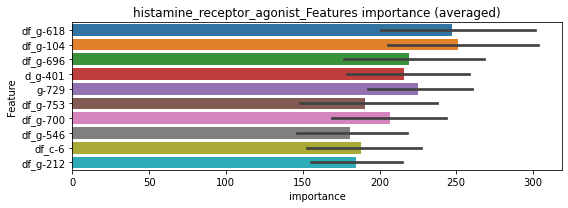

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064538	valid_1's binary_logloss: 0.0967545
[200]	training's binary_logloss: 0.0244327	valid_1's binary_logloss: 0.0654255
[300]	training's binary_logloss: 0.00899126	valid_1's binary_logloss: 0.0524807
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00429349	valid_1's binary_logloss: 0.0484933


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652453	valid_1's binary_logloss: 0.0959049
[200]	training's binary_logloss: 0.0221414	valid_1's binary_logloss: 0.0579044
[300]	training's binary_logloss: 0.00833489	valid_1's binary_logloss: 0.0441267
[400]	training's binary_logloss: 0.00359163	valid_1's binary_logloss: 0.0380702
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00199883	valid_1's binary_logloss: 0.0359208


histamine_receptor_agonist logloss: 0.04220784378926469


neg labels: 3289 → selected neg labels: 3255


histamine_receptor_antagonist, len(trt): 241, len(othr): 3255, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207799	valid_1's binary_logloss: 0.336366
[200]	training's binary_logloss: 0.112572	valid_1's binary_logloss: 0.312021
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.100547	valid_1's binary_logloss: 0.309438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200751	valid_1's binary_logloss: 0.323696
[200]	training's binary_logloss: 0.116346	valid_1's binary_logloss: 0.296425


1 / 3 AUC score:0.849
y_Threshold: 0.1615617, Threshold: 0.5082986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 561 → Positive_corect_labels: 436/3345
p_label_rate: 0.0100452 Vs.target_rate: 0.01012, Num_p_label: 40.0, conf_0:0.45747, conf_1:0.55913
threshold: 0.5082986, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 436.0/3345, y_label_rate: 0.1303438
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0826668	valid_1's binary_logloss: 0.286204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121495	valid_1's binary_logloss: 0.204795
[200]	training's binary_logloss: 0.0525586	valid_1's binary_logloss: 0.168791
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0462072	valid_1's binary_logloss: 0.165857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118092	valid_1's binary_logloss: 0.183813
[200]	training's binary_logloss: 0.0511427	valid_1's binary_logloss: 0.138781
[300]	training's binary_logloss: 0.0239393	valid_1's binary_logloss: 0.121666


2 / 3 AUC score:0.968
y_Threshold: 0.1794063, Threshold: 0.5082986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 358.0/3189
p_label_rate: 0.0341537 Vs.target_rate: 0.01012, Num_p_label: 136.0, conf_0:0.45747, conf_1:0.55913
Num_p_label: 136.0, Expected: 40.3, Adj_threshold_1: 0.5082986


[400]	training's binary_logloss: 0.0116926	valid_1's binary_logloss: 0.114732
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0114957	valid_1's binary_logloss: 0.11425


Num_p_label: 122.0, Expected: 40.3, Adj_threshold_2: 0.5382986
Num_p_label: 113.0, Expected: 40.3, Adj_threshold_3: 0.5682986
Num_p_label: 103.0, Expected: 40.3, Adj_threshold_4: 0.5982986
Num_p_label: 95.0, Expected: 40.3, Adj_threshold_5: 0.6282986
Num_p_label: 85.0, Expected: 40.3, Adj_threshold_6: 0.6582986
Num_p_label: 74.0, Expected: 40.3, Adj_threshold_7: 0.6882986
threshold: 0.6882986, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 358.0/3189, y_label_rate: 0.1122609
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742301	valid_1's binary_logloss: 0.143456
[200]	training's binary_logloss: 0.0263988	valid_1's binary_logloss: 0.115115
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0159609	valid_1's binary_logloss: 0.110437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868896	valid_1's binary_logloss: 0.140621
[200]	training's binary_logloss: 0.0313608	valid_1's binary_logloss: 0.104137
[300]	training's binary_logloss: 0.0121358	valid_1's binary_logloss: 0.0911394
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00741365	valid_1's binary_logloss: 0.0861626


3 / 3 AUC score:0.980
y_Threshold: 0.1533683, Threshold: 0.6882986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 311.0/3095
p_label_rate: 0.0369161 Vs.target_rate: 0.01012, Num_p_label: 147.0, conf_0:0.61947, conf_1:0.75713
Num_p_label: 147.0, Expected: 40.3, Adj_threshold_1: 0.6882986
Num_p_label: 142.0, Expected: 40.3, Adj_threshold_2: 0.7182986
Num_p_label: 137.0, Expected: 40.3, Adj_threshold_3: 0.7482986
Num_p_label: 120.0, Expected: 40.3, Adj_threshold_4: 0.7782986
Num_p_label: 111.0, Expected: 40.3, Adj_threshold_5: 0.8082986
Num_p_label: 102.0, Expected: 40.3, Adj_threshold_6: 0.8382986
Num_p_label: 84.0, Expected: 40.3, Adj_threshold_7: 0.8682986
Num_p_label: 73.0, Expected: 40.3, Adj_threshold_8: 0.8982986
threshold: 0.8982986, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 384.0/7077, y_label_rate: 0.0542603


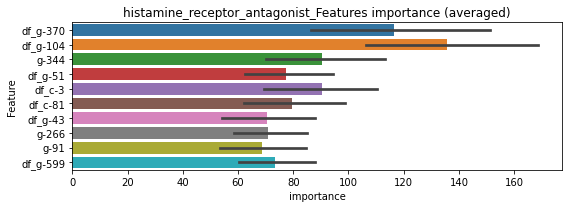

len(train_index) : 3538
len(valid_index) : 3539
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465541	valid_1's binary_logloss: 0.07399
[200]	training's binary_logloss: 0.0185648	valid_1's binary_logloss: 0.0592709
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0134156	valid_1's binary_logloss: 0.056522


len(train_index) : 3539
len(valid_index) : 3538
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457426	valid_1's binary_logloss: 0.0811024
[200]	training's binary_logloss: 0.0183804	valid_1's binary_logloss: 0.06559
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0126707	valid_1's binary_logloss: 0.0637429


histamine_receptor_antagonist logloss: 0.06013195070402454


neg labels: 3289 → selected neg labels: 3283


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3283, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740333	valid_1's binary_logloss: 0.104152
[200]	training's binary_logloss: 0.0172132	valid_1's binary_logloss: 0.0405996
[300]	training's binary_logloss: 0.00525445	valid_1's binary_logloss: 0.0213489
[400]	training's binary_logloss: 0.00246761	valid_1's binary_logloss: 0.0148708
[500]	training's binary_logloss: 0.00158718	valid_1's binary_logloss: 0.0128876
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00146188	valid_1's binary_logloss: 0.0125817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742283	valid_1's binary_logloss: 0.103045
[200]	training's binary_logloss: 0.017905	valid_1's binary_logloss: 0.0406391
[300]	training's binary_logloss: 0.00570099	valid_1's binary_logloss: 0.0229027
[400]	training's binary_logloss: 0.00254819	valid_1's binary_logloss: 0.0170035
[500]	training's binary_logloss: 0.00164253	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0232357, Threshold: 0.1909506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.17186, conf_1:0.21005
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1909506
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_2: 0.2209506
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_3: 0.2509506
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_4: 0.2809506
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_5: 0.3109506
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_6: 0.3409506
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_7: 0.3709506
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_8: 0.4009506
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_9: 0.4309506
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_10: 0.4609506
threshold: 0.4909506, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608318	valid_1's binary_logloss: 0.09092
[200]	training's binary_logloss: 0.014158	valid_1's binary_logloss: 0.0340245
[300]	training's binary_logloss: 0.00434588	valid_1's binary_logloss: 0.0180951
[400]	training's binary_logloss: 0.00211013	valid_1's binary_logloss: 0.0130605
[500]	training's binary_logloss: 0.00142254	valid_1's binary_logloss: 0.0114145
[600]	training's binary_logloss: 0.00113422	valid_1's binary_logloss: 0.0106352
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00110137	valid_1's binary_logloss: 0.0104802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671757	valid_1's binary_logloss: 0.0921108
[200]	training's binary_logloss: 0.0153764	valid_1's binary_logloss: 0.0311565
[300]	training's binary_logloss: 0.00479871	valid_1's binary_logloss: 0.0149944
[400]	training's binary_logloss: 0.00224904	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1392670, Threshold: 0.4909506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.44186, conf_1:0.54005
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.4909506
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.5209506
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.5509506
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_4: 0.5809506
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_5: 0.6109506
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_6: 0.6409506
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_7: 0.6709506
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_8: 0.7009506
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.7309506
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_10: 0.7609506
threshold: 0.7909506, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064208	valid_1's binary_logloss: 0.096775
[200]	training's binary_logloss: 0.0145368	valid_1's binary_logloss: 0.0370662
[300]	training's binary_logloss: 0.00451662	valid_1's binary_logloss: 0.0194066
[400]	training's binary_logloss: 0.0021622	valid_1's binary_logloss: 0.0138868
[500]	training's binary_logloss: 0.00145183	valid_1's binary_logloss: 0.0116677
[600]	training's binary_logloss: 0.00114267	valid_1's binary_logloss: 0.010828
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.001113	valid_1's binary_logloss: 0.0107948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638363	valid_1's binary_logloss: 0.0959155
[200]	training's binary_logloss: 0.013782	valid_1's binary_logloss: 0.0339979
[300]	training's binary_logloss: 0.00427817	valid_1's binary_logloss: 0.0174675
[400]	training's binary_logloss: 0.00215897	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1926063, Threshold: 0.7909506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0017579 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.71186, conf_1:0.87005
threshold: 0.7909506, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 660.0/7783, y_label_rate: 0.0848002


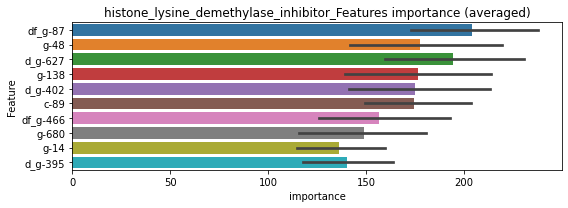

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439757	valid_1's binary_logloss: 0.0699714
[200]	training's binary_logloss: 0.0104706	valid_1's binary_logloss: 0.0321175
[300]	training's binary_logloss: 0.0028582	valid_1's binary_logloss: 0.0182619
[400]	training's binary_logloss: 0.00128697	valid_1's binary_logloss: 0.014047
[500]	training's binary_logloss: 0.000841136	valid_1's binary_logloss: 0.0124713
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000821749	valid_1's binary_logloss: 0.0124366


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382309	valid_1's binary_logloss: 0.0577696
[200]	training's binary_logloss: 0.00987012	valid_1's binary_logloss: 0.0236338
[300]	training's binary_logloss: 0.00299472	valid_1's binary_logloss: 0.0134927
[400]	training's binary_logloss: 0.0013551	valid_1's binary_logloss: 0.0101446
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0011017	valid_1's binary_logloss: 0.00945675


histone_lysine_demethylase_inhibitor logloss: 0.010946852517497224


neg labels: 3289 → selected neg labels: 3284


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3284, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858056	valid_1's binary_logloss: 0.13328
[200]	training's binary_logloss: 0.026911	valid_1's binary_logloss: 0.0667529
[300]	training's binary_logloss: 0.00875549	valid_1's binary_logloss: 0.0390739
[400]	training's binary_logloss: 0.0037797	valid_1's binary_logloss: 0.0288595
[500]	training's binary_logloss: 0.00223876	valid_1's binary_logloss: 0.0246892
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00169981	valid_1's binary_logloss: 0.023213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107973	valid_1's binary_logloss: 0.146764
[200]	training's binary_logloss: 0.0366341	valid_1's binary_logloss: 0.0737934
[300]	training's binary_logloss: 0.0114943	valid_1's binary_logloss: 0.0414968
[400]	training's binary_logloss: 0.00455775	valid_1's binary_logloss: 0.0282066
[500]	training's binary_logloss: 0.00252985	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0315613, Threshold: 0.1066350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.09597, conf_1:0.11730
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.1066350
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_2: 0.1366350
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_3: 0.1666350
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_4: 0.1966350
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_5: 0.2266350
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_6: 0.2566350
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_7: 0.2866350
threshold: 0.2866350, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087637	valid_1's binary_logloss: 0.12932
[200]	training's binary_logloss: 0.0242221	valid_1's binary_logloss: 0.056396
[300]	training's binary_logloss: 0.00773824	valid_1's binary_logloss: 0.0297379
[400]	training's binary_logloss: 0.00341102	valid_1's binary_logloss: 0.0204436
[500]	training's binary_logloss: 0.00205726	valid_1's binary_logloss: 0.0170952
[600]	training's binary_logloss: 0.00152069	valid_1's binary_logloss: 0.0155415
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00146588	valid_1's binary_logloss: 0.0153748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913873	valid_1's binary_logloss: 0.129587
[200]	training's binary_logloss: 0.0272813	valid_1's binary_logloss: 0.0561666
[300]	training's binary_logloss: 0.00867167	valid_1's binary_logloss: 0.0293007
[400]	training's binary_logloss: 0.00375368	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.2095480, Threshold: 0.2866350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0080362 Vs.target_rate: 0.00134, Num_p_label: 32.0, conf_0:0.25797, conf_1:0.31530
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_1: 0.2866350
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_2: 0.3166350
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_3: 0.3466350
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_4: 0.3766350
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_5: 0.4066350
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_6: 0.4366350
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_7: 0.4666350
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_8: 0.4966350
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_9: 0.5266350
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_10: 0.5566350
threshold: 0.5566350, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848853	valid_1's binary_logloss: 0.124321
[200]	training's binary_logloss: 0.0237958	valid_1's binary_logloss: 0.0526506
[300]	training's binary_logloss: 0.00790861	valid_1's binary_logloss: 0.0300676
[400]	training's binary_logloss: 0.00371189	valid_1's binary_logloss: 0.0226044
[500]	training's binary_logloss: 0.00227889	valid_1's binary_logloss: 0.0181739
[600]	training's binary_logloss: 0.00158229	valid_1's binary_logloss: 0.0146021
[700]	training's binary_logloss: 0.00126432	valid_1's binary_logloss: 0.012917
Early stopping, best iteration is:
[769]	training's binary_logloss: 0.00115783	valid_1's binary_logloss: 0.0124661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889641	valid_1's binary_logloss: 0.12354
[200]	training's binary_logloss: 0.0246264	valid_1's binary_logloss: 0.0505768
[300]	training's binary_logloss: 0.00796636	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.2270226, Threshold: 0.5566350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0022602 Vs.target_rate: 0.00134, Num_p_label: 9.0, conf_0:0.50097, conf_1:0.61230
threshold: 0.5566350, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/7774, y_label_rate: 0.0845125


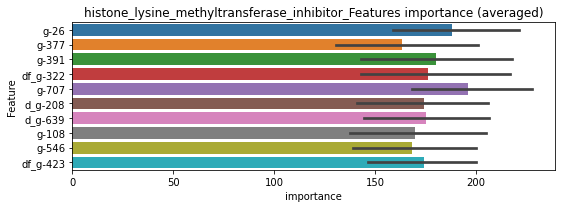

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524384	valid_1's binary_logloss: 0.0793751
[200]	training's binary_logloss: 0.0168184	valid_1's binary_logloss: 0.0383251
[300]	training's binary_logloss: 0.00522953	valid_1's binary_logloss: 0.0217981
[400]	training's binary_logloss: 0.00210344	valid_1's binary_logloss: 0.0155218
[500]	training's binary_logloss: 0.00119958	valid_1's binary_logloss: 0.0132028
[600]	training's binary_logloss: 0.000871001	valid_1's binary_logloss: 0.012068
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.000731651	valid_1's binary_logloss: 0.0114908


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529595	valid_1's binary_logloss: 0.0783575
[200]	training's binary_logloss: 0.0152559	valid_1's binary_logloss: 0.0366114
[300]	training's binary_logloss: 0.00484202	valid_1's binary_logloss: 0.021254
[400]	training's binary_logloss: 0.00202071	valid_1's binary_logloss: 0.0152397
[500]	training's binary_logloss: 0.00118442	valid_1's binary_logloss: 0.0130502
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00122576	valid_1's binary_logloss: 0.0129793


histone_lysine_methyltransferase_inhibitor logloss: 0.012235091514334898


neg labels: 3289 → selected neg labels: 3280


hiv_inhibitor, len(trt): 72, len(othr): 3280, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992288	valid_1's binary_logloss: 0.172712
[200]	training's binary_logloss: 0.0369411	valid_1's binary_logloss: 0.11578
[300]	training's binary_logloss: 0.0142645	valid_1's binary_logloss: 0.090675
[400]	training's binary_logloss: 0.00632906	valid_1's binary_logloss: 0.0808591
[500]	training's binary_logloss: 0.00356655	valid_1's binary_logloss: 0.0774771
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00329984	valid_1's binary_logloss: 0.0771683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11158	valid_1's binary_logloss: 0.155191
[200]	training's binary_logloss: 0.044324	valid_1's binary_logloss: 0.0882162
[300]	training's binary_logloss: 0.0173851	valid_1's binary_logloss: 0.0587498
[400]	training's binary_logloss: 0.00811192	valid_1's binary_logloss: 0.0441529
[500]	training's binary_logloss: 0.00439776	valid_1's bin

1 / 3 AUC score:0.996
y_Threshold: 0.0317844, Threshold: 0.5141804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 646/3784
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.46276, conf_1:0.56560
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.5141804
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_2: 0.5441804
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_3: 0.5741804
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_4: 0.6041804
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_5: 0.6341804
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_6: 0.6641804
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_7: 0.6941804
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_8: 0.7241804
threshold: 0.7241804, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932132	valid_1's binary_logloss: 0.161787
[200]	training's binary_logloss: 0.0339086	valid_1's binary_logloss: 0.104121
[300]	training's binary_logloss: 0.0124817	valid_1's binary_logloss: 0.0794034
[400]	training's binary_logloss: 0.00558206	valid_1's binary_logloss: 0.0689319
[500]	training's binary_logloss: 0.00316752	valid_1's binary_logloss: 0.0644696
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00271428	valid_1's binary_logloss: 0.063473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976094	valid_1's binary_logloss: 0.150638
[200]	training's binary_logloss: 0.0340287	valid_1's binary_logloss: 0.0845651
[300]	training's binary_logloss: 0.0130799	valid_1's binary_logloss: 0.0590518
[400]	training's binary_logloss: 0.00604003	valid_1's binary_logloss: 0.0487334
[500]	training's binary_logloss: 0.00338778	valid_1's

2 / 3 AUC score:0.996
y_Threshold: 0.1110502, Threshold: 0.7241804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 625.0/3742
p_label_rate: 0.0135610 Vs.target_rate: 0.00302, Num_p_label: 54.0, conf_0:0.65176, conf_1:0.79660
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_1: 0.7241804
Num_p_label: 51.0, Expected: 12.0, Adj_threshold_2: 0.7541804
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_3: 0.7841804
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_4: 0.8141804
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_5: 0.8441804
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_6: 0.8741804
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.9041804
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_8: 0.9341804
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_9: 0.9641804
threshold: 0.9641804, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 625.0/3742, y_label_rate: 0.1670230
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984734	valid_1's binary_logloss: 0.155808
[200]	training's binary_logloss: 0.0306535	valid_1's binary_logloss: 0.0826975
[300]	training's binary_logloss: 0.0111132	valid_1's binary_logloss: 0.0553142
[400]	training's binary_logloss: 0.00502176	valid_1's binary_logloss: 0.0425035
[500]	training's binary_logloss: 0.00294308	valid_1's binary_logloss: 0.0381547
[600]	training's binary_logloss: 0.00206707	valid_1's binary_logloss: 0.0355086
[700]	training's binary_logloss: 0.00161321	valid_1's binary_logloss: 0.0339478
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00164586	valid_1's binary_logloss: 0.0338459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874638	valid_1's binary_logloss: 0.141651
[200]	training's binary_logloss: 0.0289437	valid_1's binary_logloss: 0.0804502
[300]	training's binary_logloss: 0.0111136	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1376122, Threshold: 0.9641804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 614.0/3720
p_label_rate: 0.0082873 Vs.target_rate: 0.00302, Num_p_label: 33.0, conf_0:0.86776, conf_1:1.06060
threshold: 0.9641804, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 647.0/7702, y_label_rate: 0.0840042


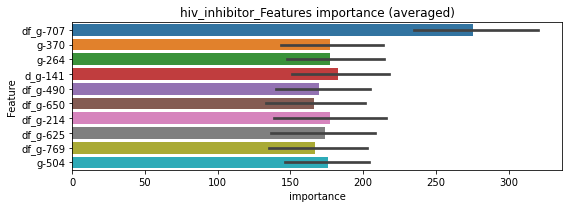

len(train_index) : 3851
len(valid_index) : 3851
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515518	valid_1's binary_logloss: 0.098159
[200]	training's binary_logloss: 0.017338	valid_1's binary_logloss: 0.0642479
[300]	training's binary_logloss: 0.00658495	valid_1's binary_logloss: 0.0523779
[400]	training's binary_logloss: 0.00297696	valid_1's binary_logloss: 0.0478621
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00183775	valid_1's binary_logloss: 0.0455179


len(train_index) : 3851
len(valid_index) : 3851
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059651	valid_1's binary_logloss: 0.0953648
[200]	training's binary_logloss: 0.0198317	valid_1's binary_logloss: 0.0566039
[300]	training's binary_logloss: 0.00701358	valid_1's binary_logloss: 0.041305
[400]	training's binary_logloss: 0.00311603	valid_1's binary_logloss: 0.0354833
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00185699	valid_1's binary_logloss: 0.033338


hiv_inhibitor logloss: 0.039427917622444277


neg labels: 3289 → selected neg labels: 3246


hmgcr_inhibitor, len(trt): 283, len(othr): 3246, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218693	valid_1's binary_logloss: 0.391259
[200]	training's binary_logloss: 0.131646	valid_1's binary_logloss: 0.375512
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.127814	valid_1's binary_logloss: 0.374605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226321	valid_1's binary_logloss: 0.381298
[200]	training's binary_logloss: 0.136299	valid_1's binary_logloss: 0.355973
[300]	training's binary_logloss: 0.0813356	valid_1's binary_logloss: 0.342262
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0668537	valid_1's binary_logloss: 0.340046


1 / 3 AUC score:0.794
y_Threshold: 0.1869989, Threshold: 0.4521691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 680 → Positive_corect_labels: 374/3215
p_label_rate: 0.0100452 Vs.target_rate: 0.01188, Num_p_label: 40.0, conf_0:0.40695, conf_1:0.49739
threshold: 0.4521691, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 374.0/3215, y_label_rate: 0.1163297
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12045	valid_1's binary_logloss: 0.251342
[200]	training's binary_logloss: 0.0529178	valid_1's binary_logloss: 0.22161
[300]	training's binary_logloss: 0.0235966	valid_1's binary_logloss: 0.213262
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0192482	valid_1's binary_logloss: 0.211168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126221	valid_1's binary_logloss: 0.242046
[200]	training's binary_logloss: 0.0568896	valid_1's binary_logloss: 0.203407


2 / 3 AUC score:0.918
y_Threshold: 0.1403844, Threshold: 0.4521691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 222 → Positive_corect_labels: 263.0/2993


[300]	training's binary_logloss: 0.0239726	valid_1's binary_logloss: 0.190508
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0219851	valid_1's binary_logloss: 0.189308


p_label_rate: 0.0175791 Vs.target_rate: 0.01188, Num_p_label: 70.0, conf_0:0.40695, conf_1:0.49739
threshold: 0.4521691, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 263.0/2993, y_label_rate: 0.0878717
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765207	valid_1's binary_logloss: 0.167338
[200]	training's binary_logloss: 0.0284136	valid_1's binary_logloss: 0.13488
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0180177	valid_1's binary_logloss: 0.129585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710193	valid_1's binary_logloss: 0.170668
[200]	training's binary_logloss: 0.0266763	valid_1's binary_logloss: 0.144873
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0185768	valid_1's binary_logloss: 0.139994


3 / 3 AUC score:0.954
y_Threshold: 0.1346374, Threshold: 0.4521691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 130 → Positive_corect_labels: 198.0/2863
p_label_rate: 0.0246107 Vs.target_rate: 0.01188, Num_p_label: 98.0, conf_0:0.40695, conf_1:0.49739
threshold: 0.4521691, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 296.0/6845, y_label_rate: 0.0432432


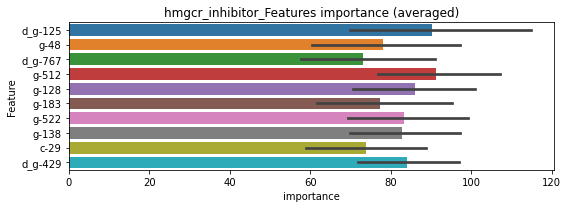

len(train_index) : 3422
len(valid_index) : 3423
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035626	valid_1's binary_logloss: 0.0841577
[200]	training's binary_logloss: 0.0124632	valid_1's binary_logloss: 0.0745352


len(train_index) : 3423
len(valid_index) : 3422
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.006608	valid_1's binary_logloss: 0.0716575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03395	valid_1's binary_logloss: 0.092239


hmgcr_inhibitor logloss: 0.07849566931838423


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.01657	valid_1's binary_logloss: 0.0853359
neg labels: 3289 → selected neg labels: 3272


hsp_inhibitor, len(trt): 93, len(othr): 3272, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144718	valid_1's binary_logloss: 0.251351
[200]	training's binary_logloss: 0.063037	valid_1's binary_logloss: 0.190938
[300]	training's binary_logloss: 0.029118	valid_1's binary_logloss: 0.16159
[400]	training's binary_logloss: 0.01402	valid_1's binary_logloss: 0.144998
[500]	training's binary_logloss: 0.0077608	valid_1's binary_logloss: 0.137068
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00734292	valid_1's binary_logloss: 0.136418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151673	valid_1's binary_logloss: 0.245627
[200]	training's binary_logloss: 0.0752789	valid_1's binary_logloss: 0.18335
[300]	training's binary_logloss: 0.0348921	valid_1's binary_logloss: 0.147955
[400]	training's binary_logloss: 0.0166407	valid_1's binary_logloss: 0.128853
[500]	training's binary_logloss: 0.00896748	valid_1's binary_logloss: 

1 / 3 AUC score:0.976
y_Threshold: 0.0816730, Threshold: 0.3324375, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 232 → Positive_corect_labels: 604/3694
p_label_rate: 0.0100452 Vs.target_rate: 0.00391, Num_p_label: 40.0, conf_0:0.29919, conf_1:0.36568
threshold: 0.3324375, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 604.0/3694, y_label_rate: 0.1635084
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125508	valid_1's binary_logloss: 0.206287
[200]	training's binary_logloss: 0.0498653	valid_1's binary_logloss: 0.143634
[300]	training's binary_logloss: 0.0211381	valid_1's binary_logloss: 0.116142
[400]	training's binary_logloss: 0.010807	valid_1's binary_logloss: 0.104812
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00705368	valid_1's binary_logloss: 0.0999685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136534	valid_1's binary_logloss: 0.215057
[200]	training's binary_logloss: 0.05521	valid_1's binary_logloss: 0.141456
[300]	training's binary_logloss: 0.0249433	valid_1's binary_logloss: 0.108857
[400]	training's binary_logloss: 0.0119208	valid_1's binary_logloss: 0.0901353
[500]	training's binary_logloss: 0.00633235	valid_1's binary_logloss: 0.0801544
[600]	training's binary_logloss: 0.00404517	valid_1's binary_lo

2 / 3 AUC score:0.988
y_Threshold: 0.1858280, Threshold: 0.3324375, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → Positive_corect_labels: 560.0/3606
p_label_rate: 0.0351582 Vs.target_rate: 0.00391, Num_p_label: 140.0, conf_0:0.29919, conf_1:0.36568
Num_p_label: 140.0, Expected: 15.6, Adj_threshold_1: 0.3324375
Num_p_label: 129.0, Expected: 15.6, Adj_threshold_2: 0.3624375
Num_p_label: 118.0, Expected: 15.6, Adj_threshold_3: 0.3924375
Num_p_label: 105.0, Expected: 15.6, Adj_threshold_4: 0.4224375
Num_p_label: 98.0, Expected: 15.6, Adj_threshold_5: 0.4524375
Num_p_label: 87.0, Expected: 15.6, Adj_threshold_6: 0.4824375
Num_p_label: 75.0, Expected: 15.6, Adj_threshold_7: 0.5124375
Num_p_label: 54.0, Expected: 15.6, Adj_threshold_8: 0.5424375
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_9: 0.5724375
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_10: 0.6024375
threshold: 0.6324375, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 560.0/3606, y_label_rate: 0.

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118841	valid_1's binary_logloss: 0.206929
[200]	training's binary_logloss: 0.0431698	valid_1's binary_logloss: 0.136584
[300]	training's binary_logloss: 0.0175245	valid_1's binary_logloss: 0.108121
[400]	training's binary_logloss: 0.00823368	valid_1's binary_logloss: 0.0955228
[500]	training's binary_logloss: 0.00460166	valid_1's binary_logloss: 0.0887391
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00323211	valid_1's binary_logloss: 0.0845974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113219	valid_1's binary_logloss: 0.183487
[200]	training's binary_logloss: 0.0400096	valid_1's binary_logloss: 0.111494
[300]	training's binary_logloss: 0.0156605	valid_1's binary_logloss: 0.0811396
[400]	training's binary_logloss: 0.00755081	valid_1's binary_logloss: 0.0684867
[500]	training's binary_logloss: 0.00433588	valid_1's bi

3 / 3 AUC score:0.994
y_Threshold: 0.1666871, Threshold: 0.6324375, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 526.0/3538
p_label_rate: 0.0195881 Vs.target_rate: 0.00391, Num_p_label: 78.0, conf_0:0.56919, conf_1:0.69568
Num_p_label: 78.0, Expected: 15.6, Adj_threshold_1: 0.6324375
Num_p_label: 77.0, Expected: 15.6, Adj_threshold_2: 0.6624375
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_3: 0.6924375
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_4: 0.7224375
Num_p_label: 53.0, Expected: 15.6, Adj_threshold_5: 0.7524375
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_6: 0.7824375
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_7: 0.8124375
Num_p_label: 35.0, Expected: 15.6, Adj_threshold_8: 0.8424375
Num_p_label: 30.0, Expected: 15.6, Adj_threshold_9: 0.8724375
threshold: 0.8724375, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 556.0/7520, y_label_rate: 0.0739362


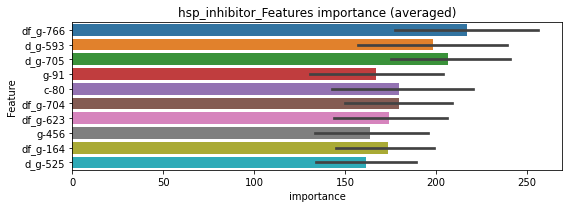

len(train_index) : 3760
len(valid_index) : 3760
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637813	valid_1's binary_logloss: 0.1145
[200]	training's binary_logloss: 0.0231731	valid_1's binary_logloss: 0.0736513
[300]	training's binary_logloss: 0.00983958	valid_1's binary_logloss: 0.0576623
[400]	training's binary_logloss: 0.00468063	valid_1's binary_logloss: 0.049121
[500]	training's binary_logloss: 0.00260568	valid_1's binary_logloss: 0.0461803
[600]	training's binary_logloss: 0.00168953	valid_1's binary_logloss: 0.0442635
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00172523	valid_1's binary_logloss: 0.0441988


len(train_index) : 3760
len(valid_index) : 3760
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662875	valid_1's binary_logloss: 0.113927
[200]	training's binary_logloss: 0.0258095	valid_1's binary_logloss: 0.0785311
[300]	training's binary_logloss: 0.0107355	valid_1's binary_logloss: 0.0633956
[400]	training's binary_logloss: 0.0050164	valid_1's binary_logloss: 0.05593
[500]	training's binary_logloss: 0.00276406	valid_1's binary_logloss: 0.0531178
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00285977	valid_1's binary_logloss: 0.0530049


hsp_inhibitor logloss: 0.04860185148705128


neg labels: 3289 → selected neg labels: 3283


igf-1_inhibitor, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987849	valid_1's binary_logloss: 0.161693
[200]	training's binary_logloss: 0.0338108	valid_1's binary_logloss: 0.0998205
[300]	training's binary_logloss: 0.0126438	valid_1's binary_logloss: 0.0742655
[400]	training's binary_logloss: 0.00538184	valid_1's binary_logloss: 0.060225
[500]	training's binary_logloss: 0.00295761	valid_1's binary_logloss: 0.0535243
[600]	training's binary_logloss: 0.00203433	valid_1's binary_logloss: 0.0498867
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00207512	valid_1's binary_logloss: 0.0498353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991732	valid_1's binary_logloss: 0.14308
[200]	training's binary_logloss: 0.0373285	valid_1's binary_logloss: 0.0808031
[300]	training's binary_logloss: 0.0136682	valid_1's binary_logloss: 0.0489523
[400]	training's binary_logloss: 0.00559271	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0399017, Threshold: 0.5348185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.48134, conf_1:0.58830
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.5348185
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_2: 0.5648185
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_3: 0.5948185
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.6248185
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.6548185
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_6: 0.6848185
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_7: 0.7148185
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_8: 0.7448185
threshold: 0.7448185, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096636	valid_1's binary_logloss: 0.13447
[200]	training's binary_logloss: 0.0316099	valid_1's binary_logloss: 0.0662336
[300]	training's binary_logloss: 0.0106596	valid_1's binary_logloss: 0.0366548
[400]	training's binary_logloss: 0.00452407	valid_1's binary_logloss: 0.0237286
[500]	training's binary_logloss: 0.00256146	valid_1's binary_logloss: 0.0187883
[600]	training's binary_logloss: 0.00182126	valid_1's binary_logloss: 0.0166633
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00174912	valid_1's binary_logloss: 0.0164354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891756	valid_1's binary_logloss: 0.142119
[200]	training's binary_logloss: 0.0277387	valid_1's binary_logloss: 0.0774651
[300]	training's binary_logloss: 0.00990676	valid_1's binary_logloss: 0.0555456
[400]	training's binary_logloss: 0.00443337	valid_1'

2 / 3 AUC score:0.999
y_Threshold: 0.1978686, Threshold: 0.7448185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 637.0/3769
p_label_rate: 0.0115520 Vs.target_rate: 0.00155, Num_p_label: 46.0, conf_0:0.67034, conf_1:0.81930
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_1: 0.7448185
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.7748185
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_3: 0.8048185
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_4: 0.8348185
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.8648185
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_6: 0.8948185
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_7: 0.9248185
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_8: 0.9548185
threshold: 0.9548185, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 637.0/3769, y_label_rate: 0.1690103
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839884	valid_1's binary_logloss: 0.127635
[200]	training's binary_logloss: 0.0270422	valid_1's binary_logloss: 0.0615397
[300]	training's binary_logloss: 0.00972066	valid_1's binary_logloss: 0.0360296
[400]	training's binary_logloss: 0.00423322	valid_1's binary_logloss: 0.0252742
[500]	training's binary_logloss: 0.00246991	valid_1's binary_logloss: 0.02072
[600]	training's binary_logloss: 0.00177059	valid_1's binary_logloss: 0.0187998
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00150004	valid_1's binary_logloss: 0.0179512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852018	valid_1's binary_logloss: 0.125237
[200]	training's binary_logloss: 0.0247817	valid_1's binary_logloss: 0.0597923
[300]	training's binary_logloss: 0.00841754	valid_1's binary_logloss: 0.0356558
[400]	training's binary_logloss: 0.00380553	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.2247641, Threshold: 0.9548185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 633.0/3761
p_label_rate: 0.0055249 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.85934, conf_1:1.05030
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.9548185
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_2: 0.9848185
threshold: 0.9848185, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 640.0/7743, y_label_rate: 0.0826553


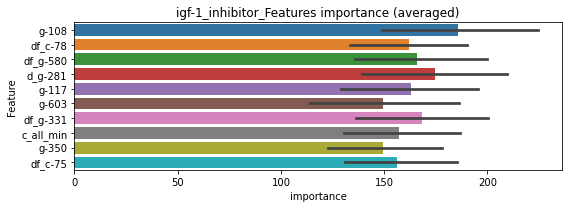

len(train_index) : 3871
len(valid_index) : 3872
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552039	valid_1's binary_logloss: 0.0825806
[200]	training's binary_logloss: 0.0202909	valid_1's binary_logloss: 0.0467551
[300]	training's binary_logloss: 0.00753173	valid_1's binary_logloss: 0.0312804
[400]	training's binary_logloss: 0.00320197	valid_1's binary_logloss: 0.0254076
[500]	training's binary_logloss: 0.00162597	valid_1's binary_logloss: 0.0222912
[600]	training's binary_logloss: 0.00109252	valid_1's binary_logloss: 0.0212871
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00104776	valid_1's binary_logloss: 0.0212239


len(train_index) : 3872
len(valid_index) : 3871
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547013	valid_1's binary_logloss: 0.0809455
[200]	training's binary_logloss: 0.0191039	valid_1's binary_logloss: 0.0414627
[300]	training's binary_logloss: 0.00714834	valid_1's binary_logloss: 0.0250036
[400]	training's binary_logloss: 0.00295468	valid_1's binary_logloss: 0.0176986
[500]	training's binary_logloss: 0.00160099	valid_1's binary_logloss: 0.0145602
[600]	training's binary_logloss: 0.00109462	valid_1's binary_logloss: 0.0133394
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.000973102	valid_1's binary_logloss: 0.0130714


igf-1_inhibitor logloss: 0.017148197373146837


neg labels: 3289 → selected neg labels: 3285


ikk_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864337	valid_1's binary_logloss: 0.130244
[200]	training's binary_logloss: 0.0266427	valid_1's binary_logloss: 0.0697114
[300]	training's binary_logloss: 0.00833241	valid_1's binary_logloss: 0.0455387
[400]	training's binary_logloss: 0.00352215	valid_1's binary_logloss: 0.0357304
[500]	training's binary_logloss: 0.00209907	valid_1's binary_logloss: 0.0320977
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00177471	valid_1's binary_logloss: 0.0315987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896146	valid_1's binary_logloss: 0.132829
[200]	training's binary_logloss: 0.0266635	valid_1's binary_logloss: 0.0649111
[300]	training's binary_logloss: 0.00875422	valid_1's binary_logloss: 0.0398519
[400]	training's binary_logloss: 0.00388872	valid_1's binary_logloss: 0.0291536
[500]	training's binary_logloss: 0.00239361	valid

1 / 3 AUC score:0.998
y_Threshold: 0.0450847, Threshold: 0.2083688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.18753, conf_1:0.22921
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.2083688
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.2383688
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_3: 0.2683688
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_4: 0.2983688
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.3283688
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.3583688
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.3883688
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.4183688
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_9: 0.4483688
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_10: 0.4783688
threshold: 0.5083688, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709291	valid_1's binary_logloss: 0.107111
[200]	training's binary_logloss: 0.0196198	valid_1's binary_logloss: 0.0496265
[300]	training's binary_logloss: 0.00626323	valid_1's binary_logloss: 0.0284777
[400]	training's binary_logloss: 0.0028419	valid_1's binary_logloss: 0.0198004
[500]	training's binary_logloss: 0.00180712	valid_1's binary_logloss: 0.0167354
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00149855	valid_1's binary_logloss: 0.0157293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075299	valid_1's binary_logloss: 0.115004
[200]	training's binary_logloss: 0.0198951	valid_1's binary_logloss: 0.0538841
[300]	training's binary_logloss: 0.00640706	valid_1's binary_logloss: 0.0317824
[400]	training's binary_logloss: 0.00294989	valid_1's binary_logloss: 0.023612
[500]	training's binary_logloss: 0.00184507	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.3006660, Threshold: 0.5083688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.45753, conf_1:0.55921
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.5083688
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.5383688
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_3: 0.5683688
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_4: 0.5983688
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_5: 0.6283688
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_6: 0.6583688
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.6883688
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_8: 0.7183688
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_9: 0.7483688
threshold: 0.7483688, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 647.0/3790, y_label_rate: 0.1707124
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757628	valid_1's binary_logloss: 0.108628
[200]	training's binary_logloss: 0.0203252	valid_1's binary_logloss: 0.0457366
[300]	training's binary_logloss: 0.00642449	valid_1's binary_logloss: 0.0241657
[400]	training's binary_logloss: 0.0029497	valid_1's binary_logloss: 0.0168076
[500]	training's binary_logloss: 0.00185276	valid_1's binary_logloss: 0.0139911
[600]	training's binary_logloss: 0.00143119	valid_1's binary_logloss: 0.0126561
[700]	training's binary_logloss: 0.00122586	valid_1's binary_logloss: 0.011971
Early stopping, best iteration is:
[726]	training's binary_logloss: 0.00118418	valid_1's binary_logloss: 0.0118027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711478	valid_1's binary_logloss: 0.113859
[200]	training's binary_logloss: 0.0179878	valid_1's binary_logloss: 0.0535667
[300]	training's binary_logloss: 0.00563216	valid_1

3 / 3 AUC score:1.000


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00166517	valid_1's binary_logloss: 0.0220086


y_Threshold: 0.3806369, Threshold: 0.7483688, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 641.0/3778
p_label_rate: 0.0042692 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.67353, conf_1:0.82321
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.7483688
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_2: 0.7783688
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_3: 0.8083688
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.8383688
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_5: 0.8683688
threshold: 0.8683688, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 649.0/7760, y_label_rate: 0.0836340


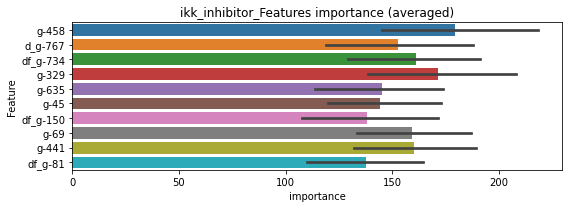

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517298	valid_1's binary_logloss: 0.0780599
[200]	training's binary_logloss: 0.0153116	valid_1's binary_logloss: 0.0389034
[300]	training's binary_logloss: 0.00475143	valid_1's binary_logloss: 0.0230525
[400]	training's binary_logloss: 0.00195178	valid_1's binary_logloss: 0.0166863
[500]	training's binary_logloss: 0.00112339	valid_1's binary_logloss: 0.0137693
[600]	training's binary_logloss: 0.000827202	valid_1's binary_logloss: 0.0127046
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000750208	valid_1's binary_logloss: 0.0123527


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470045	valid_1's binary_logloss: 0.0761594
[200]	training's binary_logloss: 0.0136356	valid_1's binary_logloss: 0.0397682
[300]	training's binary_logloss: 0.00409644	valid_1's binary_logloss: 0.0227032
[400]	training's binary_logloss: 0.0017428	valid_1's binary_logloss: 0.0164808
[500]	training's binary_logloss: 0.00107364	valid_1's binary_logloss: 0.014522
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000982857	valid_1's binary_logloss: 0.0141922


ikk_inhibitor logloss: 0.013272434443823351


neg labels: 3289 → selected neg labels: 3286


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649711	valid_1's binary_logloss: 0.102834
[200]	training's binary_logloss: 0.0172688	valid_1's binary_logloss: 0.050568
[300]	training's binary_logloss: 0.00536581	valid_1's binary_logloss: 0.0320073
[400]	training's binary_logloss: 0.00253879	valid_1's binary_logloss: 0.0267569
[500]	training's binary_logloss: 0.00168863	valid_1's binary_logloss: 0.0250761
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00170362	valid_1's binary_logloss: 0.0250215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648195	valid_1's binary_logloss: 0.099933
[200]	training's binary_logloss: 0.0165125	valid_1's binary_logloss: 0.0491612
[300]	training's binary_logloss: 0.00555682	valid_1's binary_logloss: 0.0340511
[400]	training's binary_logloss: 0.00275393	valid_1's binary_logloss: 0.0293475
[500]	training's binary_logloss: 0.00176102	valid_

1 / 3 AUC score:0.999
y_Threshold: 0.0247754, Threshold: 0.3161067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 655/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.28450, conf_1:0.34772
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.3161067
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_2: 0.3461067
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_3: 0.3761067
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_4: 0.4061067
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_5: 0.4361067
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_6: 0.4661067
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_7: 0.4961067
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_8: 0.5261067
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_9: 0.5561067
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_10: 0.5861067
threshold: 0.6161067, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588278	valid_1's binary_logloss: 0.0807246
[200]	training's binary_logloss: 0.0140242	valid_1's binary_logloss: 0.0315174
[300]	training's binary_logloss: 0.00457424	valid_1's binary_logloss: 0.0167849
[400]	training's binary_logloss: 0.00235043	valid_1's binary_logloss: 0.0126314
[500]	training's binary_logloss: 0.00155978	valid_1's binary_logloss: 0.0110124
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00131009	valid_1's binary_logloss: 0.0102887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586488	valid_1's binary_logloss: 0.100953
[200]	training's binary_logloss: 0.0134512	valid_1's binary_logloss: 0.0492596
[300]	training's binary_logloss: 0.00429124	valid_1's binary_logloss: 0.0316618
[400]	training's binary_logloss: 0.00216067	valid_1's binary_logloss: 0.0257419
Early stopping, best iteration is:
[475]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.1220276, Threshold: 0.6161067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3797
p_label_rate: 0.0128076 Vs.target_rate: 0.00130, Num_p_label: 51.0, conf_0:0.55450, conf_1:0.67772
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_1: 0.6161067
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_2: 0.6461067
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_3: 0.6761067
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_4: 0.7061067
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_5: 0.7361067
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_6: 0.7661067
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_7: 0.7961067
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_8: 0.8261067
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_9: 0.8561067
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_10: 0.8861067
threshold: 0.9161067, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 650.0/3797, y_label_rate: 0.1711878
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625932	valid_1's binary_logloss: 0.0942889
[200]	training's binary_logloss: 0.01438	valid_1's binary_logloss: 0.0377634
[300]	training's binary_logloss: 0.00462042	valid_1's binary_logloss: 0.0227357
[400]	training's binary_logloss: 0.00226745	valid_1's binary_logloss: 0.018132
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0016887	valid_1's binary_logloss: 0.0163599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554745	valid_1's binary_logloss: 0.0944513
[200]	training's binary_logloss: 0.0124764	valid_1's binary_logloss: 0.0430868
[300]	training's binary_logloss: 0.00412896	valid_1's binary_logloss: 0.030474


3 / 3 AUC score:1.000
y_Threshold: 0.1322118, Threshold: 0.9161067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3783
p_label_rate: 0.0085384 Vs.target_rate: 0.00130, Num_p_label: 34.0, conf_0:0.82450, conf_1:1.00772
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_1: 0.9161067
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_2: 0.9461067
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_3: 0.9761067
Num_p_label: 0.0, Expected: 5.2, Adj_threshold_4: 1.0061067
threshold: 1.0061067, positive_p_label: 0.0/3982, p_label_rate: 0.0000000


[400]	training's binary_logloss: 0.00208338	valid_1's binary_logloss: 0.0254262
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00213342	valid_1's binary_logloss: 0.0253221


positive_y_label: 643.0/7765, y_label_rate: 0.0828075


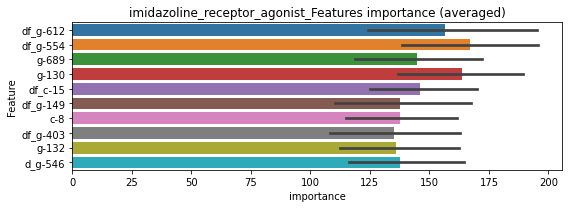

len(train_index) : 3882
len(valid_index) : 3883
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324664	valid_1's binary_logloss: 0.0483993
[200]	training's binary_logloss: 0.00771094	valid_1's binary_logloss: 0.0184607
[300]	training's binary_logloss: 0.00260143	valid_1's binary_logloss: 0.0098956
[400]	training's binary_logloss: 0.00127818	valid_1's binary_logloss: 0.00717407
[500]	training's binary_logloss: 0.000868979	valid_1's binary_logloss: 0.0061579
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000731763	valid_1's binary_logloss: 0.00579624


len(train_index) : 3883
len(valid_index) : 3882
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393664	valid_1's binary_logloss: 0.055665
[200]	training's binary_logloss: 0.00966988	valid_1's binary_logloss: 0.0235268
[300]	training's binary_logloss: 0.00292482	valid_1's binary_logloss: 0.0140267
[400]	training's binary_logloss: 0.00135427	valid_1's binary_logloss: 0.0111076
[500]	training's binary_logloss: 0.000883578	valid_1's binary_logloss: 0.0100668
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000871485	valid_1's binary_logloss: 0.0100479


imidazoline_receptor_agonist logloss: 0.007921799262511634


neg labels: 3289 → selected neg labels: 3279


immunosuppressant, len(trt): 73, len(othr): 3279, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151601	valid_1's binary_logloss: 0.240126
[200]	training's binary_logloss: 0.066734	valid_1's binary_logloss: 0.179719
[300]	training's binary_logloss: 0.0309847	valid_1's binary_logloss: 0.152164
[400]	training's binary_logloss: 0.0138781	valid_1's binary_logloss: 0.13602
[500]	training's binary_logloss: 0.00679679	valid_1's binary_logloss: 0.127709
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00460089	valid_1's binary_logloss: 0.124626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153884	valid_1's binary_logloss: 0.217592
[200]	training's binary_logloss: 0.071987	valid_1's binary_logloss: 0.149011
[300]	training's binary_logloss: 0.0307253	valid_1's binary_logloss: 0.106336
[400]	training's binary_logloss: 0.0138734	valid_1's binary_logloss: 0.0844886
[500]	training's binary_logloss: 0.0070261	valid_1's binary_loglo

1 / 3 AUC score:0.983
y_Threshold: 0.0621176, Threshold: 0.3191334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 622/3736
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.28722, conf_1:0.35105
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.3191334
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_2: 0.3491334
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_3: 0.3791334
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_4: 0.4091334
threshold: 0.4091334, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 622.0/3736, y_label_rate: 0.1664882
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135385	valid_1's binary_logloss: 0.198151
[200]	training's binary_logloss: 0.0543702	valid_1's binary_logloss: 0.126081
[300]	training's binary_logloss: 0.0233047	valid_1's binary_logloss: 0.0944425
[400]	training's binary_logloss: 0.0101777	valid_1's binary_logloss: 0.074277
[500]	training's binary_logloss: 0.00530235	valid_1's binary_logloss: 0.0648588
[600]	training's binary_logloss: 0.00329662	valid_1's binary_logloss: 0.0601828
[700]	training's binary_logloss: 0.00242204	valid_1's binary_logloss: 0.0579964
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00247408	valid_1's binary_logloss: 0.0576824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13619	valid_1's binary_logloss: 0.199529
[200]	training's binary_logloss: 0.0535432	valid_1's binary_logloss: 0.123522
[300]	training's binary_logloss: 0.0218978	valid_1's bina

2 / 3 AUC score:0.996
y_Threshold: 0.1582592, Threshold: 0.4091334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 599.0/3690
p_label_rate: 0.0130588 Vs.target_rate: 0.00307, Num_p_label: 52.0, conf_0:0.36822, conf_1:0.45005
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_1: 0.4091334
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.4391334
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_3: 0.4691334
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_4: 0.4991334
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_5: 0.5291334
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_6: 0.5591334
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.5891334
threshold: 0.5891334, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 599.0/3690, y_label_rate: 0.1623306
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13417	valid_1's binary_logloss: 0.194992
[200]	training's binary_logloss: 0.0531482	valid_1's binary_logloss: 0.12402
[300]	training's binary_logloss: 0.0202382	valid_1's binary_logloss: 0.0894135
[400]	training's binary_logloss: 0.00892721	valid_1's binary_logloss: 0.0752359
[500]	training's binary_logloss: 0.00473351	valid_1's binary_logloss: 0.0675123
[600]	training's binary_logloss: 0.00300619	valid_1's binary_logloss: 0.0641858
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00285025	valid_1's binary_logloss: 0.0636189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122552	valid_1's binary_logloss: 0.183967
[200]	training's binary_logloss: 0.0492771	valid_1's binary_logloss: 0.112273
[300]	training's binary_logloss: 0.019421	valid_1's binary_logloss: 0.0761873
[400]	training's binary_logloss: 0.00841048	valid_1's bina

3 / 3 AUC score:0.998
y_Threshold: 0.1478098, Threshold: 0.5891334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 570.0/3632
p_label_rate: 0.0077850 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.53022, conf_1:0.64805
threshold: 0.5891334, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 601.0/7614, y_label_rate: 0.0789335


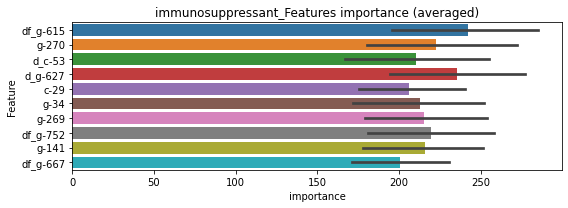

len(train_index) : 3807
len(valid_index) : 3807
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717917	valid_1's binary_logloss: 0.110186
[200]	training's binary_logloss: 0.0291974	valid_1's binary_logloss: 0.0714693
[300]	training's binary_logloss: 0.0110784	valid_1's binary_logloss: 0.0549593
[400]	training's binary_logloss: 0.0047619	valid_1's binary_logloss: 0.0470927
[500]	training's binary_logloss: 0.00244928	valid_1's binary_logloss: 0.043748
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00211383	valid_1's binary_logloss: 0.0429829


len(train_index) : 3807
len(valid_index) : 3807
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665201	valid_1's binary_logloss: 0.115678
[200]	training's binary_logloss: 0.0245707	valid_1's binary_logloss: 0.077775
[300]	training's binary_logloss: 0.00972147	valid_1's binary_logloss: 0.0622059
[400]	training's binary_logloss: 0.00431458	valid_1's binary_logloss: 0.0541608
[500]	training's binary_logloss: 0.00226815	valid_1's binary_logloss: 0.050474
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00183281	valid_1's binary_logloss: 0.049619


immunosuppressant logloss: 0.04630097113920531


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731923	valid_1's binary_logloss: 0.120174
[200]	training's binary_logloss: 0.0212322	valid_1's binary_logloss: 0.0612357
[300]	training's binary_logloss: 0.00677496	valid_1's binary_logloss: 0.0402272
[400]	training's binary_logloss: 0.00304884	valid_1's binary_logloss: 0.0308569
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00223375	valid_1's binary_logloss: 0.028597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747982	valid_1's binary_logloss: 0.10689
[200]	training's binary_logloss: 0.0222599	valid_1's binary_logloss: 0.0459647
[300]	training's binary_logloss: 0.0073651	valid_1's binary_logloss: 0.0249826
[400]	training's binary_logloss: 0.00328715	valid_1's binary_logloss: 0.0171941
[500]	training's binary_logloss: 0.00202055	valid_1's binary_logloss: 0.014762
Early stopping, best iteration is:
[505]	training's b

1 / 3 AUC score:1.000
y_Threshold: 0.0288622, Threshold: 0.1277773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.11500, conf_1:0.14056
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.1277773
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.1577773
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.1877773
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.2177773
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.2477773
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.2777773
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_7: 0.3077773
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_8: 0.3377773
threshold: 0.3377773, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667459	valid_1's binary_logloss: 0.115153
[200]	training's binary_logloss: 0.0169725	valid_1's binary_logloss: 0.0554997
[300]	training's binary_logloss: 0.00549658	valid_1's binary_logloss: 0.0387736
[400]	training's binary_logloss: 0.00264296	valid_1's binary_logloss: 0.0317139
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00216308	valid_1's binary_logloss: 0.030454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719126	valid_1's binary_logloss: 0.101444
[200]	training's binary_logloss: 0.0180345	valid_1's binary_logloss: 0.0395617
[300]	training's binary_logloss: 0.00595736	valid_1's binary_logloss: 0.0213938
[400]	training's binary_logloss: 0.00282109	valid_1's binary_logloss: 0.0155939
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00236577	valid_1's binary_logloss: 0.0146961


2 / 3 AUC score:1.000
y_Threshold: 0.1246159, Threshold: 0.3377773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0070316 Vs.target_rate: 0.00126, Num_p_label: 28.0, conf_0:0.30400, conf_1:0.37156
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_1: 0.3377773
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.3677773
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_3: 0.3977773
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.4277773
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.4577773
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.4877773
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.5177773
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_8: 0.5477773
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_9: 0.5777773
threshold: 0.5777773, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/3788, y_label_rate: 0.1705385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661435	valid_1's binary_logloss: 0.104753
[200]	training's binary_logloss: 0.0169986	valid_1's binary_logloss: 0.0439593
[300]	training's binary_logloss: 0.00550041	valid_1's binary_logloss: 0.0229164
[400]	training's binary_logloss: 0.00259221	valid_1's binary_logloss: 0.0156514
[500]	training's binary_logloss: 0.00165247	valid_1's binary_logloss: 0.0133413
[600]	training's binary_logloss: 0.00126842	valid_1's binary_logloss: 0.011897
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00123913	valid_1's binary_logloss: 0.0117888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683395	valid_1's binary_logloss: 0.0973326
[200]	training's binary_logloss: 0.0170404	valid_1's binary_logloss: 0.0372536
[300]	training's binary_logloss: 0.0055926	valid_1's binary_logloss: 0.0184953
[400]	training's binary_logloss: 0.00267873	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1977450, Threshold: 0.5777773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0020090 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.52000, conf_1:0.63556
threshold: 0.5777773, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/7768, y_label_rate: 0.0840628


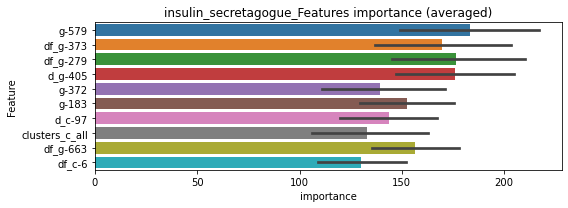

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399999	valid_1's binary_logloss: 0.0659378
[200]	training's binary_logloss: 0.00965759	valid_1's binary_logloss: 0.0317871
[300]	training's binary_logloss: 0.0029351	valid_1's binary_logloss: 0.0202073


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00175491	valid_1's binary_logloss: 0.0180931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368846	valid_1's binary_logloss: 0.0615543
[200]	training's binary_logloss: 0.00930211	valid_1's binary_logloss: 0.0286541
[300]	training's binary_logloss: 0.00294793	valid_1's binary_logloss: 0.01847
[400]	training's binary_logloss: 0.00140786	valid_1's binary_logloss: 0.0144908
[500]	training's binary_logloss: 0.000918087	valid_1's binary_logloss: 0.0132803
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000836017	valid_1's binary_logloss: 0.0130846


insulin_secretagogue logloss: 0.01558881403220845


neg labels: 3289 → selected neg labels: 3284


insulin_sensitizer, len(trt): 51, len(othr): 3284, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107046	valid_1's binary_logloss: 0.16526
[200]	training's binary_logloss: 0.0367688	valid_1's binary_logloss: 0.100149
[300]	training's binary_logloss: 0.0138529	valid_1's binary_logloss: 0.0742512
[400]	training's binary_logloss: 0.00595582	valid_1's binary_logloss: 0.0629945
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00572619	valid_1's binary_logloss: 0.0626942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101769	valid_1's binary_logloss: 0.154302
[200]	training's binary_logloss: 0.0362205	valid_1's binary_logloss: 0.092651
[300]	training's binary_logloss: 0.0133496	valid_1's binary_logloss: 0.0692202
[400]	training's binary_logloss: 0.00574863	valid_1's binary_logloss: 0.0601155
[500]	training's binary_logloss: 0.00317133	valid_1's binary_logloss: 0.055281
Early stopping, best iteration is:
[535]	training's binar

1 / 3 AUC score:0.996
y_Threshold: 0.0462059, Threshold: 0.1674884, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 640/3776
p_label_rate: 0.0100452 Vs.target_rate: 0.00214, Num_p_label: 40.0, conf_0:0.15074, conf_1:0.18424
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_1: 0.1674884
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_2: 0.1974884
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_3: 0.2274884
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_4: 0.2574884
Num_p_label: 14.0, Expected: 8.5, Adj_threshold_5: 0.2874884
threshold: 0.2874884, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925009	valid_1's binary_logloss: 0.139727
[200]	training's binary_logloss: 0.0299229	valid_1's binary_logloss: 0.0815599
[300]	training's binary_logloss: 0.0101808	valid_1's binary_logloss: 0.057941
[400]	training's binary_logloss: 0.0044618	valid_1's binary_logloss: 0.0484551
[500]	training's binary_logloss: 0.00252679	valid_1's binary_logloss: 0.0430746
[600]	training's binary_logloss: 0.00178115	valid_1's binary_logloss: 0.0406563
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00171379	valid_1's binary_logloss: 0.0405469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893888	valid_1's binary_logloss: 0.132924
[200]	training's binary_logloss: 0.0291825	valid_1's binary_logloss: 0.0699689
[300]	training's binary_logloss: 0.00996751	valid_1's binary_logloss: 0.0440473
[400]	training's binary_logloss: 0.00440589	valid_1'

2 / 3 AUC score:0.998
y_Threshold: 0.1432468, Threshold: 0.2874884, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 625.0/3746
p_label_rate: 0.0090407 Vs.target_rate: 0.00214, Num_p_label: 36.0, conf_0:0.25874, conf_1:0.31624
Num_p_label: 36.0, Expected: 8.5, Adj_threshold_1: 0.2874884
Num_p_label: 33.0, Expected: 8.5, Adj_threshold_2: 0.3174884
Num_p_label: 30.0, Expected: 8.5, Adj_threshold_3: 0.3474884
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_4: 0.3774884
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_5: 0.4074884
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_6: 0.4374884
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_7: 0.4674884
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_8: 0.4974884
threshold: 0.4974884, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 625.0/3746, y_label_rate: 0.1668446
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825503	valid_1's binary_logloss: 0.131793
[200]	training's binary_logloss: 0.0246891	valid_1's binary_logloss: 0.0745332
[300]	training's binary_logloss: 0.00869491	valid_1's binary_logloss: 0.054571
[400]	training's binary_logloss: 0.00384376	valid_1's binary_logloss: 0.0480731
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00282639	valid_1's binary_logloss: 0.0468457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842998	valid_1's binary_logloss: 0.127775
[200]	training's binary_logloss: 0.0271245	valid_1's binary_logloss: 0.0683914
[300]	training's binary_logloss: 0.00956934	valid_1's binary_logloss: 0.0432858
[400]	training's binary_logloss: 0.00415454	valid_1's binary_logloss: 0.0317983
[500]	training's binary_logloss: 0.00243214	valid_1's binary_logloss: 0.0271699
Early stopping, best iteration is:
[560]	training'

3 / 3 AUC score:0.998
y_Threshold: 0.1140066, Threshold: 0.4974884, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 610.0/3716
p_label_rate: 0.0042692 Vs.target_rate: 0.00214, Num_p_label: 17.0, conf_0:0.44774, conf_1:0.54724
threshold: 0.4974884, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 627.0/7698, y_label_rate: 0.0814497


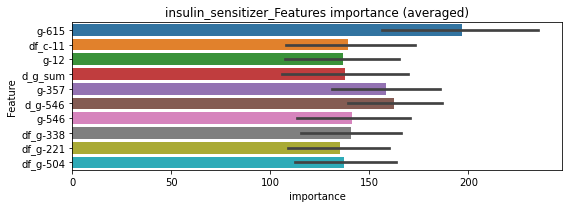

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049386	valid_1's binary_logloss: 0.0779629
[200]	training's binary_logloss: 0.0170694	valid_1's binary_logloss: 0.045788
[300]	training's binary_logloss: 0.00564902	valid_1's binary_logloss: 0.0318129
[400]	training's binary_logloss: 0.00245155	valid_1's binary_logloss: 0.0270142
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.0016879	valid_1's binary_logloss: 0.0250665


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465508	valid_1's binary_logloss: 0.0761633
[200]	training's binary_logloss: 0.014545	valid_1's binary_logloss: 0.0452041
[300]	training's binary_logloss: 0.00485359	valid_1's binary_logloss: 0.0326584


insulin_sensitizer logloss: 0.026888184846128906


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00223919	valid_1's binary_logloss: 0.0287099
neg labels: 3289 → selected neg labels: 3281


integrin_inhibitor, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856815	valid_1's binary_logloss: 0.130034
[200]	training's binary_logloss: 0.0280848	valid_1's binary_logloss: 0.0700338
[300]	training's binary_logloss: 0.0100975	valid_1's binary_logloss: 0.0470011
[400]	training's binary_logloss: 0.0045347	valid_1's binary_logloss: 0.0375346
[500]	training's binary_logloss: 0.00262753	valid_1's binary_logloss: 0.0339323
[600]	training's binary_logloss: 0.00182504	valid_1's binary_logloss: 0.0319685
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00185236	valid_1's binary_logloss: 0.0319239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907652	valid_1's binary_logloss: 0.13343
[200]	training's binary_logloss: 0.0296434	valid_1's binary_logloss: 0.0755884
[300]	training's binary_logloss: 0.00981857	valid_1's binary_logloss: 0.0515831
[400]	training's binary_logloss: 0.00430906	valid_1'

1 / 3 AUC score:0.998
y_Threshold: 0.0225815, Threshold: 0.1005334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.09048, conf_1:0.11059
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.1005334
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_2: 0.1305334
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_3: 0.1605334
threshold: 0.1605334, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086126	valid_1's binary_logloss: 0.136292
[200]	training's binary_logloss: 0.0242538	valid_1's binary_logloss: 0.0769298
[300]	training's binary_logloss: 0.00840209	valid_1's binary_logloss: 0.0602304
[400]	training's binary_logloss: 0.00368039	valid_1's binary_logloss: 0.0545579
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0026741	valid_1's binary_logloss: 0.053535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801148	valid_1's binary_logloss: 0.11886
[200]	training's binary_logloss: 0.0256041	valid_1's binary_logloss: 0.0614881
[300]	training's binary_logloss: 0.00929232	valid_1's binary_logloss: 0.0383169
[400]	training's binary_logloss: 0.00419818	valid_1's binary_logloss: 0.0285227
[500]	training's binary_logloss: 0.00252009	valid_1's binary_logloss: 0.0246223
[600]	training's binary_logloss: 0.0018014	valid_1's 

2 / 3 AUC score:0.998
y_Threshold: 0.0857381, Threshold: 0.1605334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 635.0/3763
p_label_rate: 0.0138122 Vs.target_rate: 0.00176, Num_p_label: 55.0, conf_0:0.14448, conf_1:0.17659
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_1: 0.1605334
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_2: 0.1905334
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_3: 0.2205334
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_4: 0.2505334
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_5: 0.2805334
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_6: 0.3105334
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_7: 0.3405334
threshold: 0.3405334, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 635.0/3763, y_label_rate: 0.1687483
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073247	valid_1's binary_logloss: 0.11494
[200]	training's binary_logloss: 0.020944	valid_1's binary_logloss: 0.0586944
[300]	training's binary_logloss: 0.00728676	valid_1's binary_logloss: 0.0420619
[400]	training's binary_logloss: 0.00338148	valid_1's binary_logloss: 0.0347032
[500]	training's binary_logloss: 0.00209794	valid_1's binary_logloss: 0.0316049
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.0020608	valid_1's binary_logloss: 0.0314609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778006	valid_1's binary_logloss: 0.104348
[200]	training's binary_logloss: 0.0227813	valid_1's binary_logloss: 0.0486764
[300]	training's binary_logloss: 0.0076773	valid_1's binary_logloss: 0.0280466
[400]	training's binary_logloss: 0.00358801	valid_1's binary_logloss: 0.0212435
[500]	training's binary_logloss: 0.00220054	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1020735, Threshold: 0.3405334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 624.0/3741
p_label_rate: 0.0052737 Vs.target_rate: 0.00176, Num_p_label: 21.0, conf_0:0.30648, conf_1:0.37459
threshold: 0.3405334, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 645.0/7723, y_label_rate: 0.0835168


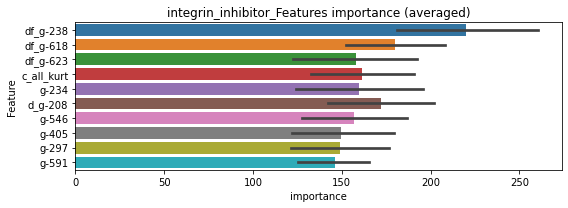

len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455668	valid_1's binary_logloss: 0.065576
[200]	training's binary_logloss: 0.0132823	valid_1's binary_logloss: 0.0328051
[300]	training's binary_logloss: 0.00456138	valid_1's binary_logloss: 0.0227372


len(train_index) : 3862
len(valid_index) : 3861


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00211936	valid_1's binary_logloss: 0.0197183


================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474435	valid_1's binary_logloss: 0.0764038
[200]	training's binary_logloss: 0.013915	valid_1's binary_logloss: 0.0459456
[300]	training's binary_logloss: 0.00494342	valid_1's binary_logloss: 0.0375981
[400]	training's binary_logloss: 0.00213461	valid_1's binary_logloss: 0.0346431
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00166155	valid_1's binary_logloss: 0.033952


integrin_inhibitor logloss: 0.026834226748068964


neg labels: 3289 → selected neg labels: 3273


jak_inhibitor, len(trt): 92, len(othr): 3273, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153049	valid_1's binary_logloss: 0.237357
[200]	training's binary_logloss: 0.0724487	valid_1's binary_logloss: 0.172206
[300]	training's binary_logloss: 0.0354913	valid_1's binary_logloss: 0.139248
[400]	training's binary_logloss: 0.0166228	valid_1's binary_logloss: 0.120194
[500]	training's binary_logloss: 0.00875767	valid_1's binary_logloss: 0.110872
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00899794	valid_1's binary_logloss: 0.110609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146671	valid_1's binary_logloss: 0.231119
[200]	training's binary_logloss: 0.0655907	valid_1's binary_logloss: 0.163727
[300]	training's binary_logloss: 0.0306274	valid_1's binary_logloss: 0.132108
[400]	training's binary_logloss: 0.0149962	valid_1's binary_logloss: 0.116404
[500]	training's binary_logloss: 0.00813167	valid_1's binary_lo

1 / 3 AUC score:0.984
y_Threshold: 0.0944858, Threshold: 0.3754949, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 210 → Positive_corect_labels: 615/3717
p_label_rate: 0.0100452 Vs.target_rate: 0.00386, Num_p_label: 40.0, conf_0:0.33795, conf_1:0.41304
threshold: 0.3754949, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 615.0/3717, y_label_rate: 0.1654560
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118994	valid_1's binary_logloss: 0.220316
[200]	training's binary_logloss: 0.0459168	valid_1's binary_logloss: 0.154548
[300]	training's binary_logloss: 0.0185495	valid_1's binary_logloss: 0.124495
[400]	training's binary_logloss: 0.00884828	valid_1's binary_logloss: 0.112782
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00684527	valid_1's binary_logloss: 0.109325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136352	valid_1's binary_logloss: 0.223248
[200]	training's binary_logloss: 0.0590258	valid_1's binary_logloss: 0.155702
[300]	training's binary_logloss: 0.0262133	valid_1's binary_logloss: 0.120355
[400]	training's binary_logloss: 0.0127791	valid_1's binary_logloss: 0.102702
[500]	training's binary_logloss: 0.00668703	valid_1's binary_logloss: 0.0941982
[600]	training's binary_logloss: 0.00409313	valid_1's binary_

2 / 3 AUC score:0.984
y_Threshold: 0.1587675, Threshold: 0.3754949, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 568.0/3623
p_label_rate: 0.0148167 Vs.target_rate: 0.00386, Num_p_label: 59.0, conf_0:0.33795, conf_1:0.41304
Num_p_label: 59.0, Expected: 15.4, Adj_threshold_1: 0.3754949
Num_p_label: 49.0, Expected: 15.4, Adj_threshold_2: 0.4054949
Num_p_label: 46.0, Expected: 15.4, Adj_threshold_3: 0.4354949
Num_p_label: 42.0, Expected: 15.4, Adj_threshold_4: 0.4654949
Num_p_label: 34.0, Expected: 15.4, Adj_threshold_5: 0.4954949
Num_p_label: 32.0, Expected: 15.4, Adj_threshold_6: 0.5254949
Num_p_label: 28.0, Expected: 15.4, Adj_threshold_7: 0.5554949
threshold: 0.5554949, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 568.0/3623, y_label_rate: 0.1567762
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110496	valid_1's binary_logloss: 0.185105
[200]	training's binary_logloss: 0.0415054	valid_1's binary_logloss: 0.115663
[300]	training's binary_logloss: 0.0170867	valid_1's binary_logloss: 0.0879033
[400]	training's binary_logloss: 0.00777046	valid_1's binary_logloss: 0.0739211
[500]	training's binary_logloss: 0.00431938	valid_1's binary_logloss: 0.0687262
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00367161	valid_1's binary_logloss: 0.0670887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110828	valid_1's binary_logloss: 0.188592
[200]	training's binary_logloss: 0.042253	valid_1's binary_logloss: 0.117443
[300]	training's binary_logloss: 0.0170613	valid_1's binary_logloss: 0.087866
[400]	training's binary_logloss: 0.00775552	valid_1's binary_logloss: 0.0730507
[500]	training's binary_logloss: 0.00434439	valid_1's bin

3 / 3 AUC score:0.994
y_Threshold: 0.1215702, Threshold: 0.5554949, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → Positive_corect_labels: 533.0/3553
p_label_rate: 0.0077850 Vs.target_rate: 0.00386, Num_p_label: 31.0, conf_0:0.49995, conf_1:0.61104
threshold: 0.5554949, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 564.0/7535, y_label_rate: 0.0748507


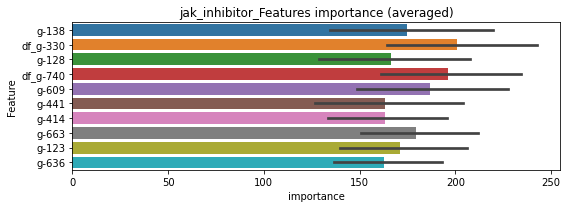

len(train_index) : 3767
len(valid_index) : 3768
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591734	valid_1's binary_logloss: 0.111873
[200]	training's binary_logloss: 0.0211717	valid_1's binary_logloss: 0.0776856
[300]	training's binary_logloss: 0.00813053	valid_1's binary_logloss: 0.063864
[400]	training's binary_logloss: 0.00373357	valid_1's binary_logloss: 0.0597464
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00308413	valid_1's binary_logloss: 0.058259


len(train_index) : 3768
len(valid_index) : 3767
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640333	valid_1's binary_logloss: 0.105907
[200]	training's binary_logloss: 0.0246798	valid_1's binary_logloss: 0.0683459
[300]	training's binary_logloss: 0.00979042	valid_1's binary_logloss: 0.0520393
[400]	training's binary_logloss: 0.00446483	valid_1's binary_logloss: 0.0442862
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00320455	valid_1's binary_logloss: 0.0420632


jak_inhibitor logloss: 0.050162185985718456


neg labels: 3289 → selected neg labels: 3248


kit_inhibitor, len(trt): 273, len(othr): 3248, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209696	valid_1's binary_logloss: 0.383103
[200]	training's binary_logloss: 0.125475	valid_1's binary_logloss: 0.363269
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0919733	valid_1's binary_logloss: 0.358077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229029	valid_1's binary_logloss: 0.368147
[200]	training's binary_logloss: 0.141434	valid_1's binary_logloss: 0.335789
[300]	training's binary_logloss: 0.0889225	valid_1's binary_logloss: 0.321205
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0709549	valid_1's binary_logloss: 0.315223


1 / 3 AUC score:0.819
y_Threshold: 0.1757208, Threshold: 0.6354815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 613 → Positive_corect_labels: 408/3284
p_label_rate: 0.0100452 Vs.target_rate: 0.01146, Num_p_label: 40.0, conf_0:0.57193, conf_1:0.69903
threshold: 0.6354815, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 408.0/3284, y_label_rate: 0.1242387
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135558	valid_1's binary_logloss: 0.271113
[200]	training's binary_logloss: 0.059354	valid_1's binary_logloss: 0.24093
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0568858	valid_1's binary_logloss: 0.239228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123309	valid_1's binary_logloss: 0.245348
[200]	training's binary_logloss: 0.0548319	valid_1's binary_logloss: 0.210733


2 / 3 AUC score:0.912
y_Threshold: 0.1665785, Threshold: 0.6354815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 273.0/3014


[300]	training's binary_logloss: 0.0252984	valid_1's binary_logloss: 0.19784
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0229961	valid_1's binary_logloss: 0.196692


p_label_rate: 0.0183325 Vs.target_rate: 0.01146, Num_p_label: 73.0, conf_0:0.57193, conf_1:0.69903
threshold: 0.6354815, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 273.0/3014, y_label_rate: 0.0905773
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780816	valid_1's binary_logloss: 0.176437
[200]	training's binary_logloss: 0.0277504	valid_1's binary_logloss: 0.150047
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0173407	valid_1's binary_logloss: 0.144475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760496	valid_1's binary_logloss: 0.17454
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0405202	valid_1's binary_logloss: 0.157329


3 / 3 AUC score:0.937
y_Threshold: 0.1504368, Threshold: 0.6354815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 197.0/2862
p_label_rate: 0.0210949 Vs.target_rate: 0.01146, Num_p_label: 84.0, conf_0:0.57193, conf_1:0.69903
threshold: 0.6354815, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 281.0/6844, y_label_rate: 0.0410579


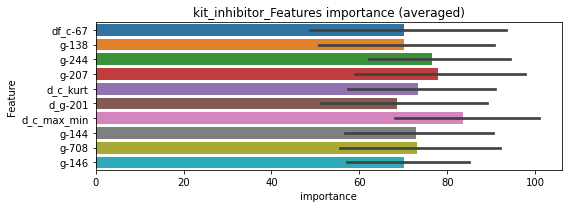

len(train_index) : 3422
len(valid_index) : 3422
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358535	valid_1's binary_logloss: 0.0699067


len(train_index) : 3422
len(valid_index) : 3422
================================= fold 2/2 kit_inhibitor=================================


[200]	training's binary_logloss: 0.0120511	valid_1's binary_logloss: 0.0559967
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0116503	valid_1's binary_logloss: 0.0556049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299671	valid_1's binary_logloss: 0.0775486


kit_inhibitor logloss: 0.062245972658864904


[200]	training's binary_logloss: 0.00928013	valid_1's binary_logloss: 0.0688991
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0103017	valid_1's binary_logloss: 0.068887
neg labels: 3289 → selected neg labels: 3289


laxative, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201745	valid_1's binary_logloss: 0.0241697
[200]	training's binary_logloss: 0.00232177	valid_1's binary_logloss: 0.00627099
[300]	training's binary_logloss: 0.000762351	valid_1's binary_logloss: 0.00409139
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000647593	valid_1's binary_logloss: 0.0037274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203938	valid_1's binary_logloss: 0.0237792
[200]	training's binary_logloss: 0.00243976	valid_1's binary_logloss: 0.00510898
[300]	training's binary_logloss: 0.000792914	valid_1's binary_logloss: 0.00264853
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000634741	valid_1's binary_logloss: 0.00234059


1 / 3 AUC score:1.000
y_Threshold: 0.0020838, Threshold: 0.0281569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.02534, conf_1:0.03097
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0281569
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_2: 0.0581569
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_3: 0.0881569
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.1181569
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_5: 0.1481569
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.1781569
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.2081569
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.2381569
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.2681569
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.2981569
threshold: 0.3281569, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175273	valid_1's binary_logloss: 0.0198993
[200]	training's binary_logloss: 0.00183424	valid_1's binary_logloss: 0.00407376
[300]	training's binary_logloss: 0.000600752	valid_1's binary_logloss: 0.0020082
[400]	training's binary_logloss: 0.000384	valid_1's binary_logloss: 0.00148094
[500]	training's binary_logloss: 0.000325591	valid_1's binary_logloss: 0.00134502
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000313907	valid_1's binary_logloss: 0.00130561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177377	valid_1's binary_logloss: 0.0186044
[200]	training's binary_logloss: 0.00188879	valid_1's binary_logloss: 0.00249599
[300]	training's binary_logloss: 0.000610972	valid_1's binary_logloss: 0.00102365
[400]	training's binary_logloss: 0.000389463	valid_1's binary_logloss: 0.000668171
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.3422893, Threshold: 0.3281569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0102963 Vs.target_rate: 0.00025, Num_p_label: 41.0, conf_0:0.29534, conf_1:0.36097
Num_p_label: 41.0, Expected: 1.0, Adj_threshold_1: 0.3281569
Num_p_label: 41.0, Expected: 1.0, Adj_threshold_2: 0.3581569
Num_p_label: 36.0, Expected: 1.0, Adj_threshold_3: 0.3881569
Num_p_label: 35.0, Expected: 1.0, Adj_threshold_4: 0.4181569
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_5: 0.4481569
Num_p_label: 31.0, Expected: 1.0, Adj_threshold_6: 0.4781569
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_7: 0.5081569
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_8: 0.5381569
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_9: 0.5681569
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_10: 0.5981569
threshold: 0.6281569, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170702	valid_1's binary_logloss: 0.0187917
[200]	training's binary_logloss: 0.00172928	valid_1's binary_logloss: 0.00312542
[300]	training's binary_logloss: 0.000582239	valid_1's binary_logloss: 0.00162392
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000422665	valid_1's binary_logloss: 0.00130555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173975	valid_1's binary_logloss: 0.017773
[200]	training's binary_logloss: 0.00183403	valid_1's binary_logloss: 0.00191895
[300]	training's binary_logloss: 0.000612093	valid_1's binary_logloss: 0.000666372
[400]	training's binary_logloss: 0.000392209	valid_1's binary_logloss: 0.000434735
[500]	training's binary_logloss: 0.000328229	valid_1's binary_logloss: 0.000367941
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000316188	valid_1's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.7332608, Threshold: 0.6281569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00025, Num_p_label: 36.0, conf_0:0.56534, conf_1:0.69097
Num_p_label: 36.0, Expected: 1.0, Adj_threshold_1: 0.6281569
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_2: 0.6581569
Num_p_label: 31.0, Expected: 1.0, Adj_threshold_3: 0.6881569
Num_p_label: 30.0, Expected: 1.0, Adj_threshold_4: 0.7181569
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_5: 0.7481569
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_6: 0.7781569
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_7: 0.8081569
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_8: 0.8381569
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_9: 0.8681569
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_10: 0.8981569
threshold: 0.9281569, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 669.0/7793, y_label_rate: 0.0858463


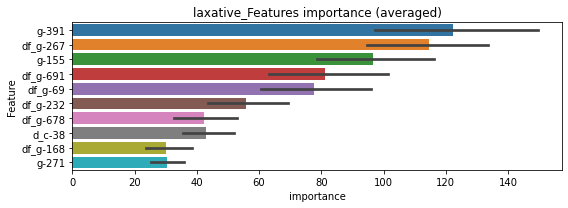

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102977	valid_1's binary_logloss: 0.0185343


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 laxative=================================


[200]	training's binary_logloss: 0.00115015	valid_1's binary_logloss: 0.0109901
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.000942028	valid_1's binary_logloss: 0.0108225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106193	valid_1's binary_logloss: 0.0124225
[200]	training's binary_logloss: 0.00124334	valid_1's binary_logloss: 0.0033728
[300]	training's binary_logloss: 0.000420384	valid_1's binary_logloss: 0.0020389


laxative logloss: 0.006205575589789072


[400]	training's binary_logloss: 0.00026115	valid_1's binary_logloss: 0.00165454
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000233133	valid_1's binary_logloss: 0.00158748
neg labels: 3289 → selected neg labels: 3289


leukotriene_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221493	valid_1's binary_logloss: 0.0318155
[200]	training's binary_logloss: 0.00275671	valid_1's binary_logloss: 0.00807962
[300]	training's binary_logloss: 0.000910276	valid_1's binary_logloss: 0.00525123
[400]	training's binary_logloss: 0.000585339	valid_1's binary_logloss: 0.00437519
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000494892	valid_1's binary_logloss: 0.0041506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236589	valid_1's binary_logloss: 0.0279452
[200]	training's binary_logloss: 0.00300965	valid_1's binary_logloss: 0.0061243
[300]	training's binary_logloss: 0.000967823	valid_1's binary_logloss: 0.00318733


1 / 3 AUC score:1.000
y_Threshold: 0.0029655, Threshold: 0.0157988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.01422, conf_1:0.01738
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0157988


[400]	training's binary_logloss: 0.000614873	valid_1's binary_logloss: 0.0025315
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000530103	valid_1's binary_logloss: 0.00230827


Num_p_label: 21.0, Expected: 1.0, Adj_threshold_2: 0.0457988
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_3: 0.0757988
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_4: 0.1057988
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.1357988
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1657988
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.1957988
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.2257988
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2557988
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2857988
threshold: 0.3157988, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203978	valid_1's binary_logloss: 0.0259479
[200]	training's binary_logloss: 0.00234604	valid_1's binary_logloss: 0.00550064
[300]	training's binary_logloss: 0.000773611	valid_1's binary_logloss: 0.00298919
[400]	training's binary_logloss: 0.000512272	valid_1's binary_logloss: 0.00254823
[500]	training's binary_logloss: 0.000428011	valid_1's binary_logloss: 0.0023791
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000430471	valid_1's binary_logloss: 0.00237356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202407	valid_1's binary_logloss: 0.0279306
[200]	training's binary_logloss: 0.00233365	valid_1's binary_logloss: 0.00669912
[300]	training's binary_logloss: 0.000763718	valid_1's binary_logloss: 0.00380136
[400]	training's binary_logloss: 0.000502741	valid_1's binary_logloss: 0.00306649
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1333090, Threshold: 0.3157988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00025, Num_p_label: 17.0, conf_0:0.28422, conf_1:0.34738
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_1: 0.3157988
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_2: 0.3457988
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.3757988
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_4: 0.4057988
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.4357988
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_6: 0.4657988
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.4957988
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.5257988
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_9: 0.5557988
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_10: 0.5857988
threshold: 0.6157988, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203315	valid_1's binary_logloss: 0.0234117
[200]	training's binary_logloss: 0.0022921	valid_1's binary_logloss: 0.00356932
[300]	training's binary_logloss: 0.000765788	valid_1's binary_logloss: 0.00140503
[400]	training's binary_logloss: 0.000504591	valid_1's binary_logloss: 0.000987139
[500]	training's binary_logloss: 0.0004257	valid_1's binary_logloss: 0.000849131
[600]	training's binary_logloss: 0.000392015	valid_1's binary_logloss: 0.000792
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000388881	valid_1's binary_logloss: 0.000786137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200779	valid_1's binary_logloss: 0.0237537
[200]	training's binary_logloss: 0.00236476	valid_1's binary_logloss: 0.00456015
[300]	training's binary_logloss: 0.000793576	valid_1's binary_logloss: 0.00212723
[400]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1479065, Threshold: 0.6157988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.55422, conf_1:0.67738
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.6157988
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.6457988
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.6757988
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.7057988
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.7357988
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.7657988
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.7957988
threshold: 0.7957988, positive_p_label: 2.0/3982, p_label_rate: 0.0005023


Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000411631	valid_1's binary_logloss: 0.00140891


positive_y_label: 658.0/7793, y_label_rate: 0.0844347


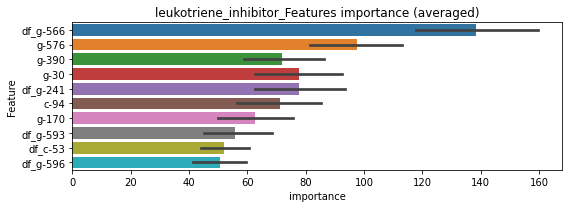

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012304	valid_1's binary_logloss: 0.0167454
[200]	training's binary_logloss: 0.00149989	valid_1's binary_logloss: 0.00502794


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 leukotriene_inhibitor=================================


[300]	training's binary_logloss: 0.000458112	valid_1's binary_logloss: 0.00297686
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000352179	valid_1's binary_logloss: 0.00274151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118292	valid_1's binary_logloss: 0.01478
[200]	training's binary_logloss: 0.00151964	valid_1's binary_logloss: 0.00265763
[300]	training's binary_logloss: 0.000490072	valid_1's binary_logloss: 0.00121341
[400]	training's binary_logloss: 0.000315497	valid_1's binary_logloss: 0.00088501


leukotriene_inhibitor logloss: 0.001775836997832877


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000278866	valid_1's binary_logloss: 0.000809917
neg labels: 3289 → selected neg labels: 3282


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3282, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107054	valid_1's binary_logloss: 0.178148
[200]	training's binary_logloss: 0.0406634	valid_1's binary_logloss: 0.121835
[300]	training's binary_logloss: 0.0167999	valid_1's binary_logloss: 0.0984022
[400]	training's binary_logloss: 0.00743679	valid_1's binary_logloss: 0.0863895
[500]	training's binary_logloss: 0.00412704	valid_1's binary_logloss: 0.0824354
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00291473	valid_1's binary_logloss: 0.0790399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109202	valid_1's binary_logloss: 0.169182
[200]	training's binary_logloss: 0.0439816	valid_1's binary_logloss: 0.109297
[300]	training's binary_logloss: 0.0166947	valid_1's binary_logloss: 0.0770308
[400]	training's binary_logloss: 0.00778177	valid_1's binary_logloss: 0.0647232
[500]	training's binary_logloss: 0.00417002	valid_1's b

1 / 3 AUC score:0.992
y_Threshold: 0.0421535, Threshold: 0.1487518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 635/3764
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.13388, conf_1:0.16363
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.1487518
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.1787518
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_3: 0.2087518
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_4: 0.2387518
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_5: 0.2687518
threshold: 0.2687518, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 635.0/3764, y_label_rate: 0.1687035
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091853	valid_1's binary_logloss: 0.158645
[200]	training's binary_logloss: 0.030028	valid_1's binary_logloss: 0.101982
[300]	training's binary_logloss: 0.0120006	valid_1's binary_logloss: 0.082348
[400]	training's binary_logloss: 0.00544567	valid_1's binary_logloss: 0.0738282
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00469737	valid_1's binary_logloss: 0.0727073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967081	valid_1's binary_logloss: 0.159606
[200]	training's binary_logloss: 0.0357778	valid_1's binary_logloss: 0.100735
[300]	training's binary_logloss: 0.0140782	valid_1's binary_logloss: 0.0744151
[400]	training's binary_logloss: 0.0061249	valid_1's binary_logloss: 0.0608569
[500]	training's binary_logloss: 0.0034806	valid_1's binary_logloss: 0.0548466
Early stopping, best iteration is:
[543]	training's binary

2 / 3 AUC score:0.996
y_Threshold: 0.0960237, Threshold: 0.2687518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 604.0/3702
p_label_rate: 0.0118031 Vs.target_rate: 0.00260, Num_p_label: 47.0, conf_0:0.24188, conf_1:0.29563
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_1: 0.2687518
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_2: 0.2987518
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.3287518
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_4: 0.3587518
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_5: 0.3887518
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_6: 0.4187518
threshold: 0.4187518, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 604.0/3702, y_label_rate: 0.1631551
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824246	valid_1's binary_logloss: 0.138381
[200]	training's binary_logloss: 0.0269157	valid_1's binary_logloss: 0.0844775
[300]	training's binary_logloss: 0.00999257	valid_1's binary_logloss: 0.0638339
[400]	training's binary_logloss: 0.00468422	valid_1's binary_logloss: 0.0552035
[500]	training's binary_logloss: 0.00275665	valid_1's binary_logloss: 0.0524943
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00280734	valid_1's binary_logloss: 0.0523736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902116	valid_1's binary_logloss: 0.136785
[200]	training's binary_logloss: 0.0280494	valid_1's binary_logloss: 0.0752684
[300]	training's binary_logloss: 0.0106128	valid_1's binary_logloss: 0.0543873
[400]	training's binary_logloss: 0.00507521	valid_1's binary_logloss: 0.0476986


3 / 3 AUC score:0.994
y_Threshold: 0.1441514, Threshold: 0.4187518, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00354955	valid_1's binary_logloss: 0.0446091


Remove_noisy_labels: 38 → Positive_corect_labels: 585.0/3664
p_label_rate: 0.0077850 Vs.target_rate: 0.00260, Num_p_label: 31.0, conf_0:0.37688, conf_1:0.46063
threshold: 0.4187518, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 616.0/7646, y_label_rate: 0.0805650


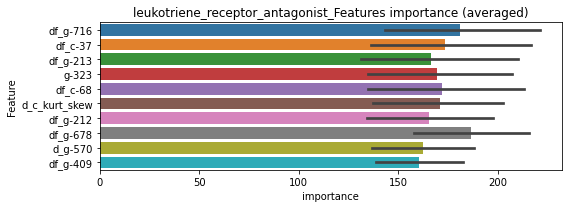

len(train_index) : 3823
len(valid_index) : 3823
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492863	valid_1's binary_logloss: 0.0832628
[200]	training's binary_logloss: 0.0154733	valid_1's binary_logloss: 0.0493125
[300]	training's binary_logloss: 0.00566324	valid_1's binary_logloss: 0.0377085
[400]	training's binary_logloss: 0.00248867	valid_1's binary_logloss: 0.031704
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00241715	valid_1's binary_logloss: 0.0314873


len(train_index) : 3823
len(valid_index) : 3823
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469939	valid_1's binary_logloss: 0.0875713
[200]	training's binary_logloss: 0.0146638	valid_1's binary_logloss: 0.0538767
[300]	training's binary_logloss: 0.00551278	valid_1's binary_logloss: 0.0426625
[400]	training's binary_logloss: 0.00252804	valid_1's binary_logloss: 0.0359447
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00164439	valid_1's binary_logloss: 0.0339155


leukotriene_receptor_antagonist logloss: 0.032701427243647864


neg labels: 3289 → selected neg labels: 3288


lipase_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429193	valid_1's binary_logloss: 0.0599234
[200]	training's binary_logloss: 0.00655414	valid_1's binary_logloss: 0.0170229
[300]	training's binary_logloss: 0.00194903	valid_1's binary_logloss: 0.00825271
[400]	training's binary_logloss: 0.00101667	valid_1's binary_logloss: 0.00570721
[500]	training's binary_logloss: 0.000728866	valid_1's binary_logloss: 0.00460498
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000658736	valid_1's binary_logloss: 0.00433431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377128	valid_1's binary_logloss: 0.0567113
[200]	training's binary_logloss: 0.00557105	valid_1's binary_logloss: 0.0186193
[300]	training's binary_logloss: 0.00173114	valid_1's binary_logloss: 0.0121915
[400]	training's binary_logloss: 0.000936904	valid_1's binary_logloss: 0.0101348
Early stopping, best iteration is:
[40

1 / 3 AUC score:1.000
y_Threshold: 0.0081869, Threshold: 0.0642439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.05782, conf_1:0.07067
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0642439
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_2: 0.0942439
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.1242439
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_4: 0.1542439
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.1842439
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.2142439
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.2442439
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.2742439
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.3042439
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.3342439
threshold: 0.3342439, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348344	valid_1's binary_logloss: 0.0483949
[200]	training's binary_logloss: 0.00508864	valid_1's binary_logloss: 0.0128176
[300]	training's binary_logloss: 0.00161741	valid_1's binary_logloss: 0.0058763
[400]	training's binary_logloss: 0.000886186	valid_1's binary_logloss: 0.00390422
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000677908	valid_1's binary_logloss: 0.0033594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335721	valid_1's binary_logloss: 0.0492102
[200]	training's binary_logloss: 0.00492408	valid_1's binary_logloss: 0.0145829
[300]	training's binary_logloss: 0.00151946	valid_1's binary_logloss: 0.00826484
[400]	training's binary_logloss: 0.00081931	valid_1's binary_logloss: 0.0063381
[500]	training's binary_logloss: 0.000591833	valid_1's binary_logloss: 0.00555022
Early stopping, best iteration is:
[576

2 / 3 AUC score:1.000
y_Threshold: 0.2091026, Threshold: 0.3342439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0055249 Vs.target_rate: 0.00050, Num_p_label: 22.0, conf_0:0.30082, conf_1:0.36767
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_1: 0.3342439
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.3642439
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.3942439
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_4: 0.4242439
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.4542439
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_6: 0.4842439
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_7: 0.5142439
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.5442439
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_9: 0.5742439
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_10: 0.6042439
threshold: 0.6342439, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3809, y_label_rate: 0.1719611
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032947	valid_1's binary_logloss: 0.0483681
[200]	training's binary_logloss: 0.0048217	valid_1's binary_logloss: 0.0138934
[300]	training's binary_logloss: 0.00150631	valid_1's binary_logloss: 0.00656551
[400]	training's binary_logloss: 0.000822262	valid_1's binary_logloss: 0.00438595
[500]	training's binary_logloss: 0.000601722	valid_1's binary_logloss: 0.00355066
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00052391	valid_1's binary_logloss: 0.00326159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338954	valid_1's binary_logloss: 0.0439536
[200]	training's binary_logloss: 0.00491038	valid_1's binary_logloss: 0.00906926
[300]	training's binary_logloss: 0.00150616	valid_1's binary_logloss: 0.00358747
[400]	training's binary_logloss: 0.000826776	valid_1's binary_logloss: 0.00222596
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1906315, Threshold: 0.6342439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.57082, conf_1:0.69767
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.6342439
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.6642439
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.6942439
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.7242439
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.7542439
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.7842439
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.8142439
threshold: 0.8142439, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7791, y_label_rate: 0.0845848


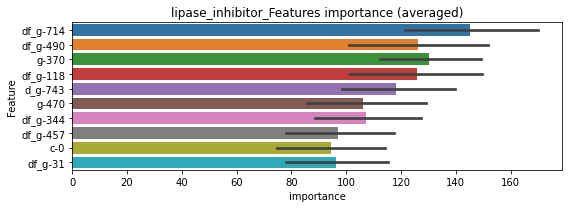

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189109	valid_1's binary_logloss: 0.0261467
[200]	training's binary_logloss: 0.00269703	valid_1's binary_logloss: 0.00715106
[300]	training's binary_logloss: 0.000833382	valid_1's binary_logloss: 0.00431706
[400]	training's binary_logloss: 0.000458498	valid_1's binary_logloss: 0.00365182


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 lipase_inhibitor=================================


[500]	training's binary_logloss: 0.000343182	valid_1's binary_logloss: 0.00350345
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000349749	valid_1's binary_logloss: 0.00347376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192743	valid_1's binary_logloss: 0.0271949
[200]	training's binary_logloss: 0.00289157	valid_1's binary_logloss: 0.00686748
[300]	training's binary_logloss: 0.000902667	valid_1's binary_logloss: 0.00344787
[400]	training's binary_logloss: 0.000484953	valid_1's binary_logloss: 0.00242755
[500]	training's binary_logloss: 0.000361443	valid_1's binary_logloss: 0.00206766
[600]	training's binary_logloss: 0.000316227	valid_1's binary_logloss: 0.00189933
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000317677	valid_1's binary_logloss: 0.00189633


lipase_inhibitor logloss: 0.0026851435229179607


neg labels: 3289 → selected neg labels: 3284


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3284, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117578	valid_1's binary_logloss: 0.188957
[200]	training's binary_logloss: 0.0465417	valid_1's binary_logloss: 0.121662
[300]	training's binary_logloss: 0.0195136	valid_1's binary_logloss: 0.0905629
[400]	training's binary_logloss: 0.00876565	valid_1's binary_logloss: 0.0755694
[500]	training's binary_logloss: 0.00455334	valid_1's binary_logloss: 0.0669987
[600]	training's binary_logloss: 0.00286802	valid_1's binary_logloss: 0.0624919
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00272672	valid_1's binary_logloss: 0.0622888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113003	valid_1's binary_logloss: 0.173229
[200]	training's binary_logloss: 0.0418479	valid_1's binary_logloss: 0.103309
[300]	training's binary_logloss: 0.0162177	valid_1's binary_logloss: 0.0720505
[400]	training's binary_logloss: 0.00738875	valid_1's b

1 / 3 AUC score:0.995
y_Threshold: 0.0490724, Threshold: 0.2783643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 639/3774
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.25053, conf_1:0.30620
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.2783643
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.3083643
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_3: 0.3383643
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_4: 0.3683643
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_5: 0.3983643
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_6: 0.4283643
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_7: 0.4583643
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_8: 0.4883643
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_9: 0.5183643
threshold: 0.5183643, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 639.0/3774, y_label_rate: 0.1693164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104042	valid_1's binary_logloss: 0.170349
[200]	training's binary_logloss: 0.0349004	valid_1's binary_logloss: 0.0993174
[300]	training's binary_logloss: 0.0132888	valid_1's binary_logloss: 0.0696882
[400]	training's binary_logloss: 0.00585977	valid_1's binary_logloss: 0.0553267
[500]	training's binary_logloss: 0.00334257	valid_1's binary_logloss: 0.0489029
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00273386	valid_1's binary_logloss: 0.0471618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960457	valid_1's binary_logloss: 0.173139
[200]	training's binary_logloss: 0.0317831	valid_1's binary_logloss: 0.111506
[300]	training's binary_logloss: 0.011294	valid_1's binary_logloss: 0.0845145
[400]	training's binary_logloss: 0.00528297	valid_1's binary_logloss: 0.0727449
[500]	training's binary_logloss: 0.00302548	valid_1's 

2 / 3 AUC score:0.998
y_Threshold: 0.1464925, Threshold: 0.5183643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 610.0/3716
p_label_rate: 0.0107986 Vs.target_rate: 0.00256, Num_p_label: 43.0, conf_0:0.46653, conf_1:0.57020
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_1: 0.5183643
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.5483643
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_3: 0.5783643
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_4: 0.6083643
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_5: 0.6383643
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_6: 0.6683643
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_7: 0.6983643
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_8: 0.7283643
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_9: 0.7583643
threshold: 0.7583643, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 610.0/3716, y_label_rate: 0.1641550
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951003	valid_1's binary_logloss: 0.153101
[200]	training's binary_logloss: 0.0318056	valid_1's binary_logloss: 0.0899858
[300]	training's binary_logloss: 0.0118762	valid_1's binary_logloss: 0.0664242
[400]	training's binary_logloss: 0.00519091	valid_1's binary_logloss: 0.0564405
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00325682	valid_1's binary_logloss: 0.0516795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911929	valid_1's binary_logloss: 0.140954
[200]	training's binary_logloss: 0.0293261	valid_1's binary_logloss: 0.076542
[300]	training's binary_logloss: 0.010511	valid_1's binary_logloss: 0.0509724
[400]	training's binary_logloss: 0.00495727	valid_1's binary_logloss: 0.0412762
[500]	training's binary_logloss: 0.00293741	valid_1's binary_logloss: 0.0361754
[600]	training's binary_logloss: 0.00202543	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.1427408, Threshold: 0.7583643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 593.0/3682
p_label_rate: 0.0072828 Vs.target_rate: 0.00256, Num_p_label: 29.0, conf_0:0.68253, conf_1:0.83420
threshold: 0.7583643, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 622.0/7664, y_label_rate: 0.0811587


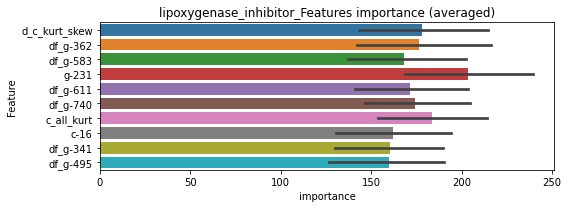

len(train_index) : 3832
len(valid_index) : 3832
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516464	valid_1's binary_logloss: 0.0978567
[200]	training's binary_logloss: 0.0168588	valid_1's binary_logloss: 0.0633995
[300]	training's binary_logloss: 0.0060968	valid_1's binary_logloss: 0.048686
[400]	training's binary_logloss: 0.0027033	valid_1's binary_logloss: 0.0432494
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00177027	valid_1's binary_logloss: 0.0411419


len(train_index) : 3832
len(valid_index) : 3832
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523987	valid_1's binary_logloss: 0.0912729
[200]	training's binary_logloss: 0.0184218	valid_1's binary_logloss: 0.0571302
[300]	training's binary_logloss: 0.00676998	valid_1's binary_logloss: 0.0426355
[400]	training's binary_logloss: 0.00302193	valid_1's binary_logloss: 0.0365096
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00191755	valid_1's binary_logloss: 0.0339093


lipoxygenase_inhibitor logloss: 0.03752559127529533


neg labels: 3289 → selected neg labels: 3287


lxr_agonist, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286535	valid_1's binary_logloss: 0.0426973
[200]	training's binary_logloss: 0.00417947	valid_1's binary_logloss: 0.0158182
[300]	training's binary_logloss: 0.00129443	valid_1's binary_logloss: 0.0101055
[400]	training's binary_logloss: 0.000782343	valid_1's binary_logloss: 0.00870214
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000721436	valid_1's binary_logloss: 0.00847742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299788	valid_1's binary_logloss: 0.0400325
[200]	training's binary_logloss: 0.00423145	valid_1's binary_logloss: 0.0146219
[300]	training's binary_logloss: 0.00137289	valid_1's binary_logloss: 0.00919026
[400]	training's binary_logloss: 0.000849783	valid_1's binary_logloss: 0.00768659
[500]	training's binary_logloss: 0.000677768	valid_1's binary_logloss: 0.00713149
[600]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0047687, Threshold: 0.0422246, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.03800, conf_1:0.04645
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0422246
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_2: 0.0722246
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_3: 0.1022246


Early stopping, best iteration is:
[666]	training's binary_logloss: 0.000568814	valid_1's binary_logloss: 0.00676776


Num_p_label: 11.0, Expected: 1.0, Adj_threshold_4: 0.1322246
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.1622246
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1922246
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.2222246
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2522246
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2822246
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.3122246
threshold: 0.3122246, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025324	valid_1's binary_logloss: 0.0303813
[200]	training's binary_logloss: 0.00314458	valid_1's binary_logloss: 0.00623483
[300]	training's binary_logloss: 0.00102385	valid_1's binary_logloss: 0.00310499
[400]	training's binary_logloss: 0.000660632	valid_1's binary_logloss: 0.00241231
[500]	training's binary_logloss: 0.00052201	valid_1's binary_logloss: 0.00212934
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000529607	valid_1's binary_logloss: 0.00211572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242194	valid_1's binary_logloss: 0.0356668
[200]	training's binary_logloss: 0.00305858	valid_1's binary_logloss: 0.0146201
[300]	training's binary_logloss: 0.00101258	valid_1's binary_logloss: 0.00973614
[400]	training's binary_logloss: 0.000647871	valid_1's binary_logloss: 0.00860528
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0828947, Threshold: 0.3122246, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0070316 Vs.target_rate: 0.00025, Num_p_label: 28.0, conf_0:0.28100, conf_1:0.34345
Num_p_label: 28.0, Expected: 1.0, Adj_threshold_1: 0.3122246
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_2: 0.3422246
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_3: 0.3722246
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_4: 0.4022246
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_5: 0.4322246
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_6: 0.4622246
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_7: 0.4922246
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_8: 0.5222246
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_9: 0.5522246
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_10: 0.5822246
threshold: 0.6122246, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3804, y_label_rate: 0.1716614
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248054	valid_1's binary_logloss: 0.031775
[200]	training's binary_logloss: 0.00311459	valid_1's binary_logloss: 0.00892995
[300]	training's binary_logloss: 0.00100957	valid_1's binary_logloss: 0.00486458
[400]	training's binary_logloss: 0.000643177	valid_1's binary_logloss: 0.00388213
[500]	training's binary_logloss: 0.000509642	valid_1's binary_logloss: 0.00350513
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000487549	valid_1's binary_logloss: 0.00346219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024277	valid_1's binary_logloss: 0.0279043
[200]	training's binary_logloss: 0.00301672	valid_1's binary_logloss: 0.00521689
[300]	training's binary_logloss: 0.00101087	valid_1's binary_logloss: 0.00207545
[400]	training's binary_logloss: 0.0006494	valid_1's binary_logloss: 0.00140208
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1001678, Threshold: 0.6122246, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3800
p_label_rate: 0.0040181 Vs.target_rate: 0.00025, Num_p_label: 16.0, conf_0:0.55100, conf_1:0.67345
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_1: 0.6122246
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_2: 0.6422246
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.6722246
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.7022246
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.7322246
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.7622246


Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000494549	valid_1's binary_logloss: 0.00111608


Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.7922246
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.8222246
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.8522246
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.8822246
threshold: 0.9122246, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 653.0/7782, y_label_rate: 0.0839116


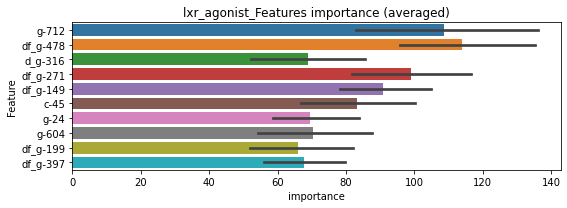

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173373	valid_1's binary_logloss: 0.0201411
[200]	training's binary_logloss: 0.00228763	valid_1's binary_logloss: 0.0052585
[300]	training's binary_logloss: 0.000690504	valid_1's binary_logloss: 0.00334077
[400]	training's binary_logloss: 0.000420754	valid_1's binary_logloss: 0.00304533
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000407978	valid_1's binary_logloss: 0.00302492


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148633	valid_1's binary_logloss: 0.0193019
[200]	training's binary_logloss: 0.00186128	valid_1's binary_logloss: 0.0043079
[300]	training's binary_logloss: 0.000607703	valid_1's binary_logloss: 0.00204105
[400]	training's binary_logloss: 0.000397732	valid_1's binary_logloss: 0.00153155
[500]	training's binary_logloss: 0.000317218	valid_1's binary_logloss: 0.00132122
[600]	training's binary_logloss: 0.0002812	valid_1's binary_logloss: 0.00123128
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000277849	valid_1's binary_logloss: 0.00121759


lxr_agonist logloss: 0.0021212572318743583


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885193	valid_1's binary_logloss: 0.122482
[200]	training's binary_logloss: 0.0245811	valid_1's binary_logloss: 0.0535386
[300]	training's binary_logloss: 0.00840044	valid_1's binary_logloss: 0.0304154
[400]	training's binary_logloss: 0.00373112	valid_1's binary_logloss: 0.0204558
[500]	training's binary_logloss: 0.00216865	valid_1's binary_logloss: 0.0165011
[600]	training's binary_logloss: 0.00159025	valid_1's binary_logloss: 0.0147799
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00153811	valid_1's binary_logloss: 0.0146026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775528	valid_1's binary_logloss: 0.120186
[200]	training's binary_logloss: 0.0220556	valid_1's binary_logloss: 0.0561762
[300]	training's binary_logloss: 0.00722272	valid_1's binary_logloss: 0.0337216
[400]	training's binary_logloss: 0.00321108	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0239900, Threshold: 0.1968417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.17716, conf_1:0.21653
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1968417
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_2: 0.2268417
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_3: 0.2568417
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_4: 0.2868417
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_5: 0.3168417
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_6: 0.3468417
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_7: 0.3768417
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_8: 0.4068417
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_9: 0.4368417
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_10: 0.4668417
threshold: 0.4968417, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714414	valid_1's binary_logloss: 0.104566
[200]	training's binary_logloss: 0.0193277	valid_1's binary_logloss: 0.0440999
[300]	training's binary_logloss: 0.00622385	valid_1's binary_logloss: 0.0247841
[400]	training's binary_logloss: 0.00286211	valid_1's binary_logloss: 0.0185321
[500]	training's binary_logloss: 0.00177444	valid_1's binary_logloss: 0.0158701
[600]	training's binary_logloss: 0.00135691	valid_1's binary_logloss: 0.0147615
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00132441	valid_1's binary_logloss: 0.0146367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733561	valid_1's binary_logloss: 0.108906
[200]	training's binary_logloss: 0.0189812	valid_1's binary_logloss: 0.0465269
[300]	training's binary_logloss: 0.00585126	valid_1's binary_logloss: 0.0262398
[400]	training's binary_logloss: 0.00273943	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1176879, Threshold: 0.4968417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0072828 Vs.target_rate: 0.00130, Num_p_label: 29.0, conf_0:0.44716, conf_1:0.54653
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_1: 0.4968417
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_2: 0.5268417
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_3: 0.5568417
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_4: 0.5868417
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_5: 0.6168417
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_6: 0.6468417
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_7: 0.6768417
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_8: 0.7068417
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_9: 0.7368417
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_10: 0.7668417
threshold: 0.7968417, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673032	valid_1's binary_logloss: 0.111779
[200]	training's binary_logloss: 0.0179157	valid_1's binary_logloss: 0.0546548
[300]	training's binary_logloss: 0.00571592	valid_1's binary_logloss: 0.0342236
[400]	training's binary_logloss: 0.00264002	valid_1's binary_logloss: 0.0273734
[500]	training's binary_logloss: 0.00165628	valid_1's binary_logloss: 0.0250617
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00169805	valid_1's binary_logloss: 0.0249445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734808	valid_1's binary_logloss: 0.105566
[200]	training's binary_logloss: 0.0187425	valid_1's binary_logloss: 0.0403657
[300]	training's binary_logloss: 0.00599685	valid_1's binary_logloss: 0.0205905
[400]	training's binary_logloss: 0.00273135	valid_1's binary_logloss: 0.0135147
[500]	training's binary_logloss: 0.00173537	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1064755, Threshold: 0.7968417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 644.0/3784
p_label_rate: 0.0045203 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.71716, conf_1:0.87653
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.7968417
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_2: 0.8268417
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_3: 0.8568417
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_4: 0.8868417
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_5: 0.9168417
threshold: 0.9168417, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/7766, y_label_rate: 0.0842132


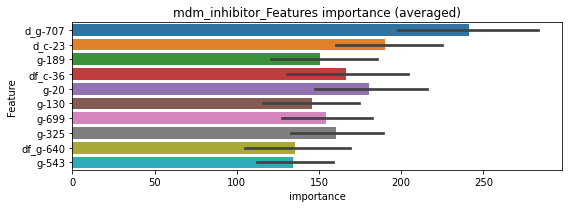

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441539	valid_1's binary_logloss: 0.0638942
[200]	training's binary_logloss: 0.0113735	valid_1's binary_logloss: 0.0268389
[300]	training's binary_logloss: 0.00370714	valid_1's binary_logloss: 0.0157397
[400]	training's binary_logloss: 0.0016179	valid_1's binary_logloss: 0.0112517
[500]	training's binary_logloss: 0.00101686	valid_1's binary_logloss: 0.00986129
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000913501	valid_1's binary_logloss: 0.00946341


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374016	valid_1's binary_logloss: 0.0672776
[200]	training's binary_logloss: 0.00995453	valid_1's binary_logloss: 0.0330413
[300]	training's binary_logloss: 0.00322296	valid_1's binary_logloss: 0.0214503
[400]	training's binary_logloss: 0.00147952	valid_1's binary_logloss: 0.0176249
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00100384	valid_1's binary_logloss: 0.0163056


mdm_inhibitor logloss: 0.012884502096819956


neg labels: 3289 → selected neg labels: 3273


mek_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154091	valid_1's binary_logloss: 0.24427
[200]	training's binary_logloss: 0.0744187	valid_1's binary_logloss: 0.176857
[300]	training's binary_logloss: 0.0344473	valid_1's binary_logloss: 0.140245
[400]	training's binary_logloss: 0.0163787	valid_1's binary_logloss: 0.120031
[500]	training's binary_logloss: 0.00794708	valid_1's binary_logloss: 0.109588
[600]	training's binary_logloss: 0.00460345	valid_1's binary_logloss: 0.104408
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00387191	valid_1's binary_logloss: 0.103448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16651	valid_1's binary_logloss: 0.244014
[200]	training's binary_logloss: 0.0839293	valid_1's binary_logloss: 0.173132
[300]	training's binary_logloss: 0.0397026	valid_1's binary_logloss: 0.13317
[400]	training's binary_logloss: 0.0176425	valid_1's binary_loglo

1 / 3 AUC score:0.988
y_Threshold: 0.0736030, Threshold: 0.2547144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 624/3735
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.22924, conf_1:0.28019
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.2547144
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_2: 0.2847144
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_3: 0.3147144
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_4: 0.3447144
threshold: 0.3447144, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 624.0/3735, y_label_rate: 0.1670683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136885	valid_1's binary_logloss: 0.227531
[200]	training's binary_logloss: 0.0559079	valid_1's binary_logloss: 0.159051
[300]	training's binary_logloss: 0.0228113	valid_1's binary_logloss: 0.12753
[400]	training's binary_logloss: 0.0101134	valid_1's binary_logloss: 0.112361
[500]	training's binary_logloss: 0.00518528	valid_1's binary_logloss: 0.106074
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00547651	valid_1's binary_logloss: 0.105902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135408	valid_1's binary_logloss: 0.213931
[200]	training's binary_logloss: 0.0565971	valid_1's binary_logloss: 0.139127
[300]	training's binary_logloss: 0.025852	valid_1's binary_logloss: 0.103393
[400]	training's binary_logloss: 0.0119079	valid_1's binary_logloss: 0.0807647
[500]	training's binary_logloss: 0.0060389	valid_1's binary_logl

2 / 3 AUC score:0.988
y_Threshold: 0.1708518, Threshold: 0.3447144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 83 → Positive_corect_labels: 583.0/3652
p_label_rate: 0.0148167 Vs.target_rate: 0.00302, Num_p_label: 59.0, conf_0:0.31024, conf_1:0.37919
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_1: 0.3447144
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.3747144
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_3: 0.4047144
Num_p_label: 37.0, Expected: 12.0, Adj_threshold_4: 0.4347144
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_5: 0.4647144
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_6: 0.4947144
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_7: 0.5247144
threshold: 0.5247144, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 583.0/3652, y_label_rate: 0.1596386
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13115	valid_1's binary_logloss: 0.201035
[200]	training's binary_logloss: 0.0523275	valid_1's binary_logloss: 0.131665
[300]	training's binary_logloss: 0.0209269	valid_1's binary_logloss: 0.0948995
[400]	training's binary_logloss: 0.00952882	valid_1's binary_logloss: 0.078158
[500]	training's binary_logloss: 0.0049789	valid_1's binary_logloss: 0.0715214
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00445734	valid_1's binary_logloss: 0.0703215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111172	valid_1's binary_logloss: 0.183689
[200]	training's binary_logloss: 0.0439121	valid_1's binary_logloss: 0.119154
[300]	training's binary_logloss: 0.0177674	valid_1's binary_logloss: 0.0867994
[400]	training's binary_logloss: 0.00798135	valid_1's binary_logloss: 0.0735575
[500]	training's binary_logloss: 0.00434439	valid_1's bina

3 / 3 AUC score:0.991
y_Threshold: 0.1526737, Threshold: 0.5247144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 549.0/3584
p_label_rate: 0.0072828 Vs.target_rate: 0.00302, Num_p_label: 29.0, conf_0:0.47224, conf_1:0.57719
threshold: 0.5247144, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 578.0/7566, y_label_rate: 0.0763944


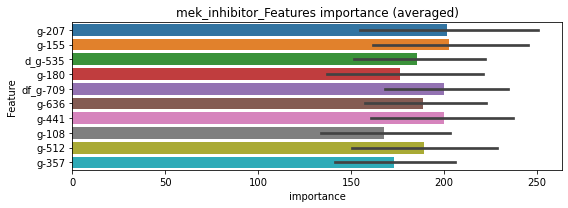

len(train_index) : 3783
len(valid_index) : 3783
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684246	valid_1's binary_logloss: 0.114382
[200]	training's binary_logloss: 0.0268579	valid_1's binary_logloss: 0.0735003
[300]	training's binary_logloss: 0.0103572	valid_1's binary_logloss: 0.0545658
[400]	training's binary_logloss: 0.00462417	valid_1's binary_logloss: 0.0466527
[500]	training's binary_logloss: 0.00242024	valid_1's binary_logloss: 0.043156
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00244538	valid_1's binary_logloss: 0.0430953


len(train_index) : 3783
len(valid_index) : 3783
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672753	valid_1's binary_logloss: 0.114499
[200]	training's binary_logloss: 0.0268601	valid_1's binary_logloss: 0.0772002
[300]	training's binary_logloss: 0.0102736	valid_1's binary_logloss: 0.0603197
[400]	training's binary_logloss: 0.00434735	valid_1's binary_logloss: 0.0524802
[500]	training's binary_logloss: 0.00224519	valid_1's binary_logloss: 0.0483319
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00184279	valid_1's binary_logloss: 0.0473228


mek_inhibitor logloss: 0.045209078607607374


neg labels: 3289 → selected neg labels: 3276


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3276, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128023	valid_1's binary_logloss: 0.194466
[200]	training's binary_logloss: 0.0493126	valid_1's binary_logloss: 0.132063
[300]	training's binary_logloss: 0.0216582	valid_1's binary_logloss: 0.106235
[400]	training's binary_logloss: 0.00990745	valid_1's binary_logloss: 0.0930492
[500]	training's binary_logloss: 0.00516864	valid_1's binary_logloss: 0.0849896
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00343571	valid_1's binary_logloss: 0.0808911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116159	valid_1's binary_logloss: 0.176678
[200]	training's binary_logloss: 0.0448133	valid_1's binary_logloss: 0.114841
[300]	training's binary_logloss: 0.01873	valid_1's binary_logloss: 0.0886406
[400]	training's binary_logloss: 0.00926938	valid_1's binary_logloss: 0.0796801
Early stopping, best iteration is:
[472]	training's binary

1 / 3 AUC score:0.991
y_Threshold: 0.0482285, Threshold: 0.1542774, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 631/3751
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.13885, conf_1:0.16971
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.1542774
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_2: 0.1842774
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_3: 0.2142774
threshold: 0.2142774, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 631.0/3751, y_label_rate: 0.1682218
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108598	valid_1's binary_logloss: 0.160345
[200]	training's binary_logloss: 0.0398881	valid_1's binary_logloss: 0.0958709
[300]	training's binary_logloss: 0.0157532	valid_1's binary_logloss: 0.0680407
[400]	training's binary_logloss: 0.00731862	valid_1's binary_logloss: 0.0555737
[500]	training's binary_logloss: 0.00412436	valid_1's binary_logloss: 0.0501283
[600]	training's binary_logloss: 0.00272421	valid_1's binary_logloss: 0.0462226
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00255943	valid_1's binary_logloss: 0.0460817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106348	valid_1's binary_logloss: 0.161729
[200]	training's binary_logloss: 0.0389567	valid_1's binary_logloss: 0.0992773
[300]	training's binary_logloss: 0.0156388	valid_1's binary_logloss: 0.0722187
[400]	training's binary_logloss: 0.00754493	valid_1's

2 / 3 AUC score:0.998
y_Threshold: 0.1145006, Threshold: 0.2142774, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 608.0/3705
p_label_rate: 0.0102963 Vs.target_rate: 0.00311, Num_p_label: 41.0, conf_0:0.19285, conf_1:0.23571
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_1: 0.2142774
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_2: 0.2442774
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_3: 0.2742774
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_4: 0.3042774
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_5: 0.3342774
threshold: 0.3342774, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 608.0/3705, y_label_rate: 0.1641026
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981362	valid_1's binary_logloss: 0.15225
[200]	training's binary_logloss: 0.034573	valid_1's binary_logloss: 0.0915048
[300]	training's binary_logloss: 0.0140517	valid_1's binary_logloss: 0.0664184
[400]	training's binary_logloss: 0.00646208	valid_1's binary_logloss: 0.0532113
[500]	training's binary_logloss: 0.00363313	valid_1's binary_logloss: 0.0475199
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0026973	valid_1's binary_logloss: 0.0458231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989743	valid_1's binary_logloss: 0.148972
[200]	training's binary_logloss: 0.0339773	valid_1's binary_logloss: 0.0890195
[300]	training's binary_logloss: 0.0125725	valid_1's binary_logloss: 0.0622745
[400]	training's binary_logloss: 0.00587646	valid_1's binary_logloss: 0.0510725
[500]	training's binary_logloss: 0.00349699	valid_1's 

3 / 3 AUC score:0.999
y_Threshold: 0.1262668, Threshold: 0.3342774, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 591.0/3671
p_label_rate: 0.0060271 Vs.target_rate: 0.00311, Num_p_label: 24.0, conf_0:0.30085, conf_1:0.36771
threshold: 0.3342774, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 615.0/7653, y_label_rate: 0.0803606


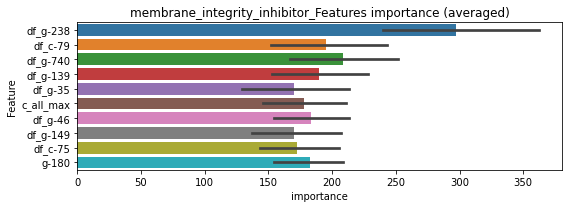

len(train_index) : 3826
len(valid_index) : 3827
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561133	valid_1's binary_logloss: 0.098791
[200]	training's binary_logloss: 0.0175993	valid_1's binary_logloss: 0.0622703
[300]	training's binary_logloss: 0.00681079	valid_1's binary_logloss: 0.051664


len(train_index) : 3827
len(valid_index) : 3826
================================= fold 2/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00385646	valid_1's binary_logloss: 0.0479373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599529	valid_1's binary_logloss: 0.0905391
[200]	training's binary_logloss: 0.0206781	valid_1's binary_logloss: 0.054129
[300]	training's binary_logloss: 0.00789561	valid_1's binary_logloss: 0.0403806
[400]	training's binary_logloss: 0.00346434	valid_1's binary_logloss: 0.0338176
[500]	training's binary_logloss: 0.00193449	valid_1's binary_logloss: 0.0314743
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00202337	valid_1's binary_logloss: 0.0314009


membrane_integrity_inhibitor logloss: 0.03967020419116481


neg labels: 3289 → selected neg labels: 3283


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3283, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667336	valid_1's binary_logloss: 0.095682
[200]	training's binary_logloss: 0.0158947	valid_1's binary_logloss: 0.0382932
[300]	training's binary_logloss: 0.00494193	valid_1's binary_logloss: 0.0201106
[400]	training's binary_logloss: 0.00229971	valid_1's binary_logloss: 0.0137826
[500]	training's binary_logloss: 0.00150177	valid_1's binary_logloss: 0.0115763
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00121119	valid_1's binary_logloss: 0.0107639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663066	valid_1's binary_logloss: 0.0997352
[200]	training's binary_logloss: 0.0147016	valid_1's binary_logloss: 0.0390582
[300]	training's binary_logloss: 0.0046064	valid_1's binary_logloss: 0.0223221
[400]	training's binary_logloss: 0.00223302	valid_1's binary_logloss: 0.0163504
Early stopping, best iteration is:
[420]	training

1 / 3 AUC score:1.000
y_Threshold: 0.0233151, Threshold: 0.1749416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.15745, conf_1:0.19244
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.1749416
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.2049416
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_3: 0.2349416
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_4: 0.2649416
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_5: 0.2949416
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.3249416
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.3549416
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_8: 0.3849416
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_9: 0.4149416
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_10: 0.4449416
threshold: 0.4749416, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559535	valid_1's binary_logloss: 0.0814246
[200]	training's binary_logloss: 0.0124262	valid_1's binary_logloss: 0.0296036
[300]	training's binary_logloss: 0.00396409	valid_1's binary_logloss: 0.0142663
[400]	training's binary_logloss: 0.00195988	valid_1's binary_logloss: 0.00970746
[500]	training's binary_logloss: 0.0013287	valid_1's binary_logloss: 0.00799637
[600]	training's binary_logloss: 0.00105998	valid_1's binary_logloss: 0.00720536
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00098194	valid_1's binary_logloss: 0.00697623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575394	valid_1's binary_logloss: 0.0862583
[200]	training's binary_logloss: 0.0125059	valid_1's binary_logloss: 0.0302889
[300]	training's binary_logloss: 0.0039874	valid_1's binary_logloss: 0.0158949
[400]	training's binary_logloss: 0.0019592	va

2 / 3 AUC score:1.000
y_Threshold: 0.2142066, Threshold: 0.4749416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0052737 Vs.target_rate: 0.00105, Num_p_label: 21.0, conf_0:0.42745, conf_1:0.52244
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.4749416
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.5049416
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.5349416
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_4: 0.5649416
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.5949416
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.6249416
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.6549416
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.6849416
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.7149416
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_10: 0.7449416
threshold: 0.7749416, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589323	valid_1's binary_logloss: 0.0819867
[200]	training's binary_logloss: 0.0125671	valid_1's binary_logloss: 0.0279193
[300]	training's binary_logloss: 0.00392778	valid_1's binary_logloss: 0.0142955
[400]	training's binary_logloss: 0.00194213	valid_1's binary_logloss: 0.0102271
[500]	training's binary_logloss: 0.00129696	valid_1's binary_logloss: 0.0086324
[600]	training's binary_logloss: 0.00104161	valid_1's binary_logloss: 0.00799147
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00101309	valid_1's binary_logloss: 0.00787709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576074	valid_1's binary_logloss: 0.0874903
[200]	training's binary_logloss: 0.0115181	valid_1's binary_logloss: 0.0286811
[300]	training's binary_logloss: 0.00373863	valid_1's binary_logloss: 0.015224
[400]	training's binary_logloss: 0.00188303	va

3 / 3 AUC score:1.000
y_Threshold: 0.1746699, Threshold: 0.7749416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0012557 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.69745, conf_1:0.85244
threshold: 0.7749416, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/7781, y_label_rate: 0.0844364


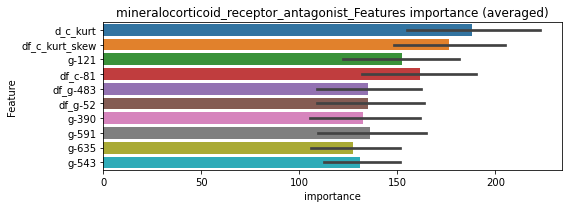

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339395	valid_1's binary_logloss: 0.0531173
[200]	training's binary_logloss: 0.00777773	valid_1's binary_logloss: 0.0230458
[300]	training's binary_logloss: 0.00241938	valid_1's binary_logloss: 0.013671
[400]	training's binary_logloss: 0.00113372	valid_1's binary_logloss: 0.0111364
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000851142	valid_1's binary_logloss: 0.0103419


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035655	valid_1's binary_logloss: 0.0486316
[200]	training's binary_logloss: 0.00813852	valid_1's binary_logloss: 0.0173062
[300]	training's binary_logloss: 0.0024452	valid_1's binary_logloss: 0.00883568
[400]	training's binary_logloss: 0.00115679	valid_1's binary_logloss: 0.0060666
[500]	training's binary_logloss: 0.000775964	valid_1's binary_logloss: 0.00526684
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000647513	valid_1's binary_logloss: 0.0049023


mineralocorticoid_receptor_antagonist logloss: 0.007622443632360588


neg labels: 3289 → selected neg labels: 3289


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425237	valid_1's binary_logloss: 0.0579527
[200]	training's binary_logloss: 0.00736863	valid_1's binary_logloss: 0.0173986
[300]	training's binary_logloss: 0.00212439	valid_1's binary_logloss: 0.00912867
[400]	training's binary_logloss: 0.00107938	valid_1's binary_logloss: 0.00707089
[500]	training's binary_logloss: 0.000759017	valid_1's binary_logloss: 0.00607023
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000688927	valid_1's binary_logloss: 0.00586942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375895	valid_1's binary_logloss: 0.0611518
[200]	training's binary_logloss: 0.00626513	valid_1's binary_logloss: 0.0187533
[300]	training's binary_logloss: 0.00198083	valid_1's binary_logloss: 0.0113389
[400]	training's binary_logloss: 0.00103914	valid_1's binary_logloss: 0.00897545


1 / 3 AUC score:1.000
y_Threshold: 0.0090233, Threshold: 0.0485727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.04372, conf_1:0.05343
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0485727
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.0785727
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.1085727
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.1385727
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.1685727
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_6: 0.1985727
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.2285727


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000862692	valid_1's binary_logloss: 0.00837723


Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.2585727
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.2885727
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.3185727
threshold: 0.3485727, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344048	valid_1's binary_logloss: 0.0509
[200]	training's binary_logloss: 0.00545886	valid_1's binary_logloss: 0.0135877
[300]	training's binary_logloss: 0.00174986	valid_1's binary_logloss: 0.00669967
[400]	training's binary_logloss: 0.000946216	valid_1's binary_logloss: 0.00481663
[500]	training's binary_logloss: 0.000679991	valid_1's binary_logloss: 0.00405202
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000601711	valid_1's binary_logloss: 0.00379945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349455	valid_1's binary_logloss: 0.0532475
[200]	training's binary_logloss: 0.00538876	valid_1's binary_logloss: 0.0154534


2 / 3 AUC score:1.000
y_Threshold: 0.1801314, Threshold: 0.3485727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813


[300]	training's binary_logloss: 0.00168401	valid_1's binary_logloss: 0.008424
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0013284	valid_1's binary_logloss: 0.00792489


p_label_rate: 0.0052737 Vs.target_rate: 0.00050, Num_p_label: 21.0, conf_0:0.31372, conf_1:0.38343
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.3485727
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.3785727
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_3: 0.4085727
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.4385727
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.4685727
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.4985727
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.5285727
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_8: 0.5585727
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_9: 0.5885727
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.6185727
threshold: 0.6485727, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344048	valid_1's binary_logloss: 0.0509
[200]	training's binary_logloss: 0.00545886	valid_1's binary_logloss: 0.0135877
[300]	training's binary_logloss: 0.00174986	valid_1's binary_logloss: 0.00669967
[400]	training's binary_logloss: 0.000946216	valid_1's binary_logloss: 0.00481663
[500]	training's binary_logloss: 0.000679991	valid_1's binary_logloss: 0.00405202
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000601711	valid_1's binary_logloss: 0.00379945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349455	valid_1's binary_logloss: 0.0532475
[200]	training's binary_logloss: 0.00538876	valid_1's binary_logloss: 0.0154534


3 / 3 AUC score:1.000
y_Threshold: 0.1801314, Threshold: 0.6485727, pos_neg_ratio: 0.8000000


[300]	training's binary_logloss: 0.00168401	valid_1's binary_logloss: 0.008424
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0013284	valid_1's binary_logloss: 0.00792489


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.58372, conf_1:0.71343
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.6485727
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.6785727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.7085727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.7385727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.7685727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.7985727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.8285727
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.8585727
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_9: 0.8885727
threshold: 0.8885727, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


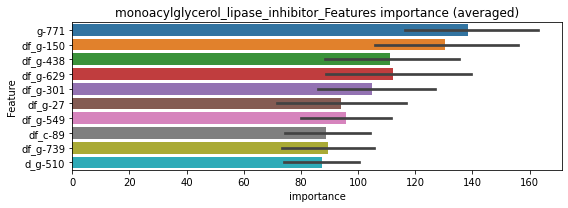

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194435	valid_1's binary_logloss: 0.0345722
[200]	training's binary_logloss: 0.00319109	valid_1's binary_logloss: 0.0114214
[300]	training's binary_logloss: 0.000960994	valid_1's binary_logloss: 0.00657214
[400]	training's binary_logloss: 0.000504397	valid_1's binary_logloss: 0.00488759
[500]	training's binary_logloss: 0.000365311	valid_1's binary_logloss: 0.00423484
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000344237	valid_1's binary_logloss: 0.00416463


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210219	valid_1's binary_logloss: 0.0291489
[200]	training's binary_logloss: 0.00328909	valid_1's binary_logloss: 0.00704904
[300]	training's binary_logloss: 0.000987286	valid_1's binary_logloss: 0.00309138
[400]	training's binary_logloss: 0.000545066	valid_1's binary_logloss: 0.00218457
[500]	training's binary_logloss: 0.000391154	valid_1's binary_logloss: 0.00183723


monoacylglycerol_lipase_inhibitor logloss: 0.0029224086587735136


[600]	training's binary_logloss: 0.000332422	valid_1's binary_logloss: 0.00167987
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000332422	valid_1's binary_logloss: 0.00167987


neg labels: 3289 → selected neg labels: 3280


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3280, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136552	valid_1's binary_logloss: 0.208159
[200]	training's binary_logloss: 0.0605828	valid_1's binary_logloss: 0.146773
[300]	training's binary_logloss: 0.0270033	valid_1's binary_logloss: 0.118614
[400]	training's binary_logloss: 0.0129226	valid_1's binary_logloss: 0.105222
[500]	training's binary_logloss: 0.00677917	valid_1's binary_logloss: 0.0975486
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00442288	valid_1's binary_logloss: 0.0947188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128221	valid_1's binary_logloss: 0.20289
[200]	training's binary_logloss: 0.0591302	valid_1's binary_logloss: 0.142719
[300]	training's binary_logloss: 0.0268612	valid_1's binary_logloss: 0.11142
[400]	training's binary_logloss: 0.012704	valid_1's binary_logloss: 0.0936322
[500]	training's binary_logloss: 0.00691185	valid_1's binary_lo

1 / 3 AUC score:0.988
y_Threshold: 0.0677706, Threshold: 0.2201213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 630/3752
p_label_rate: 0.0100452 Vs.target_rate: 0.00357, Num_p_label: 40.0, conf_0:0.19811, conf_1:0.24213
threshold: 0.2201213, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 630.0/3752, y_label_rate: 0.1679104
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115949	valid_1's binary_logloss: 0.192712
[200]	training's binary_logloss: 0.0476572	valid_1's binary_logloss: 0.130893
[300]	training's binary_logloss: 0.0205273	valid_1's binary_logloss: 0.103088
[400]	training's binary_logloss: 0.0094272	valid_1's binary_logloss: 0.0896622
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00653624	valid_1's binary_logloss: 0.0851822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125338	valid_1's binary_logloss: 0.186485
[200]	training's binary_logloss: 0.0513898	valid_1's binary_logloss: 0.121904
[300]	training's binary_logloss: 0.0228455	valid_1's binary_logloss: 0.0937903
[400]	training's binary_logloss: 0.0104142	valid_1's binary_logloss: 0.0781525
[500]	training's binary_logloss: 0.00548754	valid_1's binary_logloss: 0.0714433
Early stopping, best iteration is:
[558]	training's binary

2 / 3 AUC score:0.991
y_Threshold: 0.1346008, Threshold: 0.2201213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 593.0/3678
p_label_rate: 0.0218483 Vs.target_rate: 0.00357, Num_p_label: 87.0, conf_0:0.19811, conf_1:0.24213
Num_p_label: 87.0, Expected: 14.2, Adj_threshold_1: 0.2201213
Num_p_label: 76.0, Expected: 14.2, Adj_threshold_2: 0.2501213
Num_p_label: 63.0, Expected: 14.2, Adj_threshold_3: 0.2801213
Num_p_label: 50.0, Expected: 14.2, Adj_threshold_4: 0.3101213
Num_p_label: 45.0, Expected: 14.2, Adj_threshold_5: 0.3401213
Num_p_label: 40.0, Expected: 14.2, Adj_threshold_6: 0.3701213
Num_p_label: 34.0, Expected: 14.2, Adj_threshold_7: 0.4001213
Num_p_label: 30.0, Expected: 14.2, Adj_threshold_8: 0.4301213
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_9: 0.4601213
threshold: 0.4601213, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 593.0/3678, y_label_rate: 0.1612289
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113241	valid_1's binary_logloss: 0.170729
[200]	training's binary_logloss: 0.0426397	valid_1's binary_logloss: 0.102852
[300]	training's binary_logloss: 0.0182189	valid_1's binary_logloss: 0.074221
[400]	training's binary_logloss: 0.00846128	valid_1's binary_logloss: 0.0601483
[500]	training's binary_logloss: 0.00461253	valid_1's binary_logloss: 0.0530908
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00324261	valid_1's binary_logloss: 0.0503254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100306	valid_1's binary_logloss: 0.167903
[200]	training's binary_logloss: 0.0393581	valid_1's binary_logloss: 0.110977
[300]	training's binary_logloss: 0.0161716	valid_1's binary_logloss: 0.0870108


3 / 3 AUC score:0.995
y_Threshold: 0.1381750, Threshold: 0.4601213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 568.0/3628
p_label_rate: 0.0050226 Vs.target_rate: 0.00357, Num_p_label: 20.0, conf_0:0.41411, conf_1:0.50613
threshold: 0.4601213, positive_p_label: 20.0/3982, p_label_rate: 0.0050226


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00834042	valid_1's binary_logloss: 0.0769702


positive_y_label: 588.0/7610, y_label_rate: 0.0772668


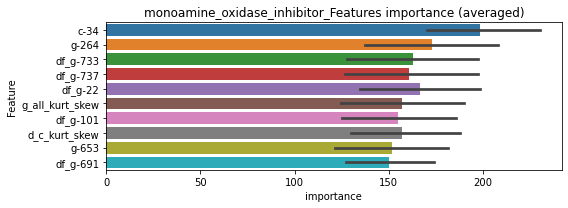

len(train_index) : 3805
len(valid_index) : 3805
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599868	valid_1's binary_logloss: 0.100536
[200]	training's binary_logloss: 0.0225967	valid_1's binary_logloss: 0.0671513
[300]	training's binary_logloss: 0.00862361	valid_1's binary_logloss: 0.055417
[400]	training's binary_logloss: 0.00398732	valid_1's binary_logloss: 0.050483
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00385941	valid_1's binary_logloss: 0.0503311


len(train_index) : 3805
len(valid_index) : 3805
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635627	valid_1's binary_logloss: 0.0982465
[200]	training's binary_logloss: 0.0246306	valid_1's binary_logloss: 0.0615653
[300]	training's binary_logloss: 0.0103755	valid_1's binary_logloss: 0.0460624
[400]	training's binary_logloss: 0.00445322	valid_1's binary_logloss: 0.0385844
[500]	training's binary_logloss: 0.00242517	valid_1's binary_logloss: 0.0359217
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00230193	valid_1's binary_logloss: 0.0358077


monoamine_oxidase_inhibitor logloss: 0.04306938672267177


neg labels: 3289 → selected neg labels: 3287


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479813	valid_1's binary_logloss: 0.079661
[200]	training's binary_logloss: 0.00911012	valid_1's binary_logloss: 0.0304543
[300]	training's binary_logloss: 0.00283827	valid_1's binary_logloss: 0.0190138
[400]	training's binary_logloss: 0.00148946	valid_1's binary_logloss: 0.0162258
[500]	training's binary_logloss: 0.00104699	valid_1's binary_logloss: 0.0151619
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000936397	valid_1's binary_logloss: 0.0148279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053481	valid_1's binary_logloss: 0.0694976
[200]	training's binary_logloss: 0.0109334	valid_1's binary_logloss: 0.022312
[300]	training's binary_logloss: 0.00339469	valid_1's binary_logloss: 0.0123287
[400]	training's binary_logloss: 0.00170727	valid_1's binary_logloss: 0.00949213
[500]	training's binary_logloss: 0.00118295	val

1 / 3 AUC score:1.000
y_Threshold: 0.0128862, Threshold: 0.1264005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.11376, conf_1:0.13904
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1264005
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.1564005
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.1864005
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_4: 0.2164005
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_5: 0.2464005
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.2764005
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_7: 0.3064005
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_8: 0.3364005
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.3664005
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.3964005
threshold: 0.4264005, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468832	valid_1's binary_logloss: 0.0718035
[200]	training's binary_logloss: 0.00848654	valid_1's binary_logloss: 0.0213018
[300]	training's binary_logloss: 0.0026392	valid_1's binary_logloss: 0.0113901
[400]	training's binary_logloss: 0.00137928	valid_1's binary_logloss: 0.00836527
[500]	training's binary_logloss: 0.000969729	valid_1's binary_logloss: 0.00746548
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000925909	valid_1's binary_logloss: 0.00735152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446393	valid_1's binary_logloss: 0.0578518
[200]	training's binary_logloss: 0.00809799	valid_1's binary_logloss: 0.0149105
[300]	training's binary_logloss: 0.00257077	valid_1's binary_logloss: 0.00662057
[400]	training's binary_logloss: 0.00137519	valid_1's binary_logloss: 0.00468109
[500]	training's binary_logloss: 0.0009

2 / 3 AUC score:1.000
y_Threshold: 0.1734386, Threshold: 0.4264005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0095429 Vs.target_rate: 0.00076, Num_p_label: 38.0, conf_0:0.38376, conf_1:0.46904
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_1: 0.4264005
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_2: 0.4564005
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_3: 0.4864005
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.5164005
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_5: 0.5464005
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_6: 0.5764005
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_7: 0.6064005
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_8: 0.6364005
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_9: 0.6664005
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.6964005
threshold: 0.7264005, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461355	valid_1's binary_logloss: 0.0639095
[200]	training's binary_logloss: 0.00828386	valid_1's binary_logloss: 0.0177443
[300]	training's binary_logloss: 0.0025665	valid_1's binary_logloss: 0.0084871
[400]	training's binary_logloss: 0.00133372	valid_1's binary_logloss: 0.00609675
[500]	training's binary_logloss: 0.000939163	valid_1's binary_logloss: 0.00522123
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000853021	valid_1's binary_logloss: 0.00497126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457113	valid_1's binary_logloss: 0.0715876
[200]	training's binary_logloss: 0.00806136	valid_1's binary_logloss: 0.0224866
[300]	training's binary_logloss: 0.00253233	valid_1's binary_logloss: 0.0121123
[400]	training's binary_logloss: 0.00133036	valid_1's binary_logloss: 0.00911409
Early stopping, best iteration is:
[484]

3 / 3 AUC score:1.000
y_Threshold: 0.1828683, Threshold: 0.7264005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.65376, conf_1:0.79904
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.7264005
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.7564005
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.7864005
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.8164005
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_5: 0.8464005
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.8764005
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.9064005
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.9364005
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.9664005
threshold: 0.9664005, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7790, y_label_rate: 0.0847240


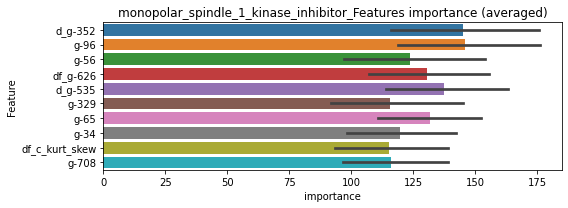

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258394	valid_1's binary_logloss: 0.0410802
[200]	training's binary_logloss: 0.00472303	valid_1's binary_logloss: 0.0157588
[300]	training's binary_logloss: 0.00144612	valid_1's binary_logloss: 0.00980063


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000826162	valid_1's binary_logloss: 0.00850331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275565	valid_1's binary_logloss: 0.0393821
[200]	training's binary_logloss: 0.00530467	valid_1's binary_logloss: 0.0129149
[300]	training's binary_logloss: 0.00162143	valid_1's binary_logloss: 0.00659089
[400]	training's binary_logloss: 0.000844924	valid_1's binary_logloss: 0.00497012
[500]	training's binary_logloss: 0.000596934	valid_1's binary_logloss: 0.00433205
[600]	training's binary_logloss: 0.000490873	valid_1's binary_logloss: 0.00404036
[700]	training's binary_logloss: 0.000436578	valid_1's binary_logloss: 0.00386493
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.000421849	valid_1's binary_logloss: 0.00382976


monopolar_spindle_1_kinase_inhibitor logloss: 0.006166536122989593


neg labels: 3289 → selected neg labels: 3269


mtor_inhibitor, len(trt): 130, len(othr): 3269, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157594	valid_1's binary_logloss: 0.287661
[200]	training's binary_logloss: 0.0787173	valid_1's binary_logloss: 0.240163
[300]	training's binary_logloss: 0.0420523	valid_1's binary_logloss: 0.221251
[400]	training's binary_logloss: 0.0218396	valid_1's binary_logloss: 0.20993
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0212643	valid_1's binary_logloss: 0.209638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173327	valid_1's binary_logloss: 0.281659
[200]	training's binary_logloss: 0.0885527	valid_1's binary_logloss: 0.22691
[300]	training's binary_logloss: 0.04339	valid_1's binary_logloss: 0.192317
[400]	training's binary_logloss: 0.0235878	valid_1's binary_logloss: 0.175801
[500]	training's binary_logloss: 0.0132685	valid_1's binary_logloss: 0.166052
Early stopping, best iteration is:
[564]	training's binary_logloss: 0

1 / 3 AUC score:0.952
y_Threshold: 0.1165829, Threshold: 0.5394293, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 324 → Positive_corect_labels: 557/3598
p_label_rate: 0.0100452 Vs.target_rate: 0.00546, Num_p_label: 40.0, conf_0:0.48549, conf_1:0.59337
threshold: 0.5394293, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 557.0/3598, y_label_rate: 0.1548082
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135226	valid_1's binary_logloss: 0.238862
[200]	training's binary_logloss: 0.0572875	valid_1's binary_logloss: 0.182659
[300]	training's binary_logloss: 0.0251257	valid_1's binary_logloss: 0.157601
[400]	training's binary_logloss: 0.012404	valid_1's binary_logloss: 0.144626
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0123278	valid_1's binary_logloss: 0.144526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135567	valid_1's binary_logloss: 0.237113
[200]	training's binary_logloss: 0.0600268	valid_1's binary_logloss: 0.178507
[300]	training's binary_logloss: 0.027651	valid_1's binary_logloss: 0.149672
[400]	training's binary_logloss: 0.0133263	valid_1's binary_logloss: 0.134212
[500]	training's binary_logloss: 0.00702537	valid_1's binary_logloss: 0.127436
Early stopping, best iteration is:
[525]	training's binary_logloss

2 / 3 AUC score:0.971
y_Threshold: 0.1890324, Threshold: 0.5394293, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 481.0/3446
p_label_rate: 0.0200904 Vs.target_rate: 0.00546, Num_p_label: 80.0, conf_0:0.48549, conf_1:0.59337
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.5394293
Num_p_label: 72.0, Expected: 21.7, Adj_threshold_2: 0.5694293
Num_p_label: 67.0, Expected: 21.7, Adj_threshold_3: 0.5994293
Num_p_label: 61.0, Expected: 21.7, Adj_threshold_4: 0.6294293
Num_p_label: 56.0, Expected: 21.7, Adj_threshold_5: 0.6594293
Num_p_label: 50.0, Expected: 21.7, Adj_threshold_6: 0.6894293
Num_p_label: 46.0, Expected: 21.7, Adj_threshold_7: 0.7194293
Num_p_label: 37.0, Expected: 21.7, Adj_threshold_8: 0.7494293
threshold: 0.7494293, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 481.0/3446, y_label_rate: 0.1395821
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114324	valid_1's binary_logloss: 0.222728
[200]	training's binary_logloss: 0.0426602	valid_1's binary_logloss: 0.173818
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0211469	valid_1's binary_logloss: 0.161599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114738	valid_1's binary_logloss: 0.21203
[200]	training's binary_logloss: 0.0465651	valid_1's binary_logloss: 0.159847
[300]	training's binary_logloss: 0.0195493	valid_1's binary_logloss: 0.137224
[400]	training's binary_logloss: 0.00878992	valid_1's binary_logloss: 0.126103
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00633199	valid_1's binary_logloss: 0.122815


3 / 3 AUC score:0.963
y_Threshold: 0.1561459, Threshold: 0.7494293, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 408.0/3300
p_label_rate: 0.0135610 Vs.target_rate: 0.00546, Num_p_label: 54.0, conf_0:0.67449, conf_1:0.82437
threshold: 0.7494293, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 462.0/7282, y_label_rate: 0.0634441


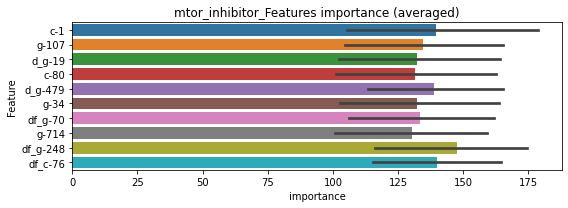

len(train_index) : 3641
len(valid_index) : 3641
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681961	valid_1's binary_logloss: 0.122511
[200]	training's binary_logloss: 0.0256768	valid_1's binary_logloss: 0.094231
[300]	training's binary_logloss: 0.0106132	valid_1's binary_logloss: 0.0838276


len(train_index) : 3641
len(valid_index) : 3641
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00697646	valid_1's binary_logloss: 0.0807784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661882	valid_1's binary_logloss: 0.123041
[200]	training's binary_logloss: 0.0240993	valid_1's binary_logloss: 0.0941091


mtor_inhibitor logloss: 0.08280120202175219


[300]	training's binary_logloss: 0.00938121	valid_1's binary_logloss: 0.0849322
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00982925	valid_1's binary_logloss: 0.084824
neg labels: 3289 → selected neg labels: 3288


mucolytic_agent, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122035	valid_1's binary_logloss: 0.172992
[200]	training's binary_logloss: 0.0415405	valid_1's binary_logloss: 0.0913519
[300]	training's binary_logloss: 0.0157244	valid_1's binary_logloss: 0.0590114
[400]	training's binary_logloss: 0.00640113	valid_1's binary_logloss: 0.0414977
[500]	training's binary_logloss: 0.00341631	valid_1's binary_logloss: 0.0343479
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00278782	valid_1's binary_logloss: 0.0323201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108295	valid_1's binary_logloss: 0.170376
[200]	training's binary_logloss: 0.0359964	valid_1's binary_logloss: 0.0973202
[300]	training's binary_logloss: 0.013263	valid_1's binary_logloss: 0.0667175
[400]	training's binary_logloss: 0.005668	valid_1's binary_logloss: 0.0534859
[500]	training's binary_logloss: 0.00312423	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0451642, Threshold: 0.3080132, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 654/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.27721, conf_1:0.33881
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.3080132
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_2: 0.3380132
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.3680132
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.3980132
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.4280132
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.4580132
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_7: 0.4880132
threshold: 0.4880132, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3807, y_label_rate: 0.1717888
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105999	valid_1's binary_logloss: 0.163843
[200]	training's binary_logloss: 0.0353592	valid_1's binary_logloss: 0.0934893
[300]	training's binary_logloss: 0.0130638	valid_1's binary_logloss: 0.0649851
[400]	training's binary_logloss: 0.00542307	valid_1's binary_logloss: 0.0498362
[500]	training's binary_logloss: 0.00299927	valid_1's binary_logloss: 0.0430505
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00265049	valid_1's binary_logloss: 0.0416471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103244	valid_1's binary_logloss: 0.172708
[200]	training's binary_logloss: 0.0299902	valid_1's binary_logloss: 0.0990772
[300]	training's binary_logloss: 0.0104356	valid_1's binary_logloss: 0.0726278
[400]	training's binary_logloss: 0.00456946	valid_1's binary_logloss: 0.0598334


2 / 3 AUC score:0.998
y_Threshold: 0.1243525, Threshold: 0.4880132, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00305368	valid_1's binary_logloss: 0.055991


Remove_noisy_labels: 42 → Positive_corect_labels: 633.0/3765
p_label_rate: 0.0185836 Vs.target_rate: 0.00202, Num_p_label: 74.0, conf_0:0.43921, conf_1:0.53681
Num_p_label: 74.0, Expected: 8.0, Adj_threshold_1: 0.4880132
Num_p_label: 66.0, Expected: 8.0, Adj_threshold_2: 0.5180132
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_3: 0.5480132
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_4: 0.5780132
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_5: 0.6080132
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_6: 0.6380132
Num_p_label: 51.0, Expected: 8.0, Adj_threshold_7: 0.6680132
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_8: 0.6980132
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_9: 0.7280132
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_10: 0.7580132
threshold: 0.7880132, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 633.0/3765, y_label_rate: 0.1681275
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960974	valid_1's binary_logloss: 0.155078
[200]	training's binary_logloss: 0.0265538	valid_1's binary_logloss: 0.0860193
[300]	training's binary_logloss: 0.00911752	valid_1's binary_logloss: 0.0672044
[400]	training's binary_logloss: 0.00409052	valid_1's binary_logloss: 0.0587071
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00365377	valid_1's binary_logloss: 0.0577644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112191	valid_1's binary_logloss: 0.152053
[200]	training's binary_logloss: 0.0332348	valid_1's binary_logloss: 0.0660089
[300]	training's binary_logloss: 0.0113103	valid_1's binary_logloss: 0.0347316
[400]	training's binary_logloss: 0.00471544	valid_1's binary_logloss: 0.0227237
[500]	training's binary_logloss: 0.00264957	valid_1's binary_logloss: 0.0185209
Early stopping, best iteration is:
[565]	training's

3 / 3 AUC score:0.994
y_Threshold: 0.1362296, Threshold: 0.7880132, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 620.0/3739
p_label_rate: 0.0205927 Vs.target_rate: 0.00202, Num_p_label: 82.0, conf_0:0.70921, conf_1:0.86681
Num_p_label: 82.0, Expected: 8.0, Adj_threshold_1: 0.7880132
Num_p_label: 78.0, Expected: 8.0, Adj_threshold_2: 0.8180132
Num_p_label: 76.0, Expected: 8.0, Adj_threshold_3: 0.8480132
Num_p_label: 73.0, Expected: 8.0, Adj_threshold_4: 0.8780132
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_5: 0.9080132
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_6: 0.9380132
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_7: 0.9680132
Num_p_label: 1.0, Expected: 8.0, Adj_threshold_8: 0.9980132
threshold: 0.9980132, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 621.0/7721, y_label_rate: 0.0804300


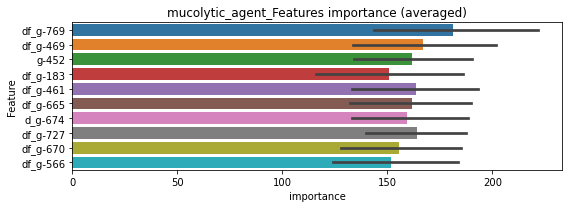

len(train_index) : 3860
len(valid_index) : 3861
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576448	valid_1's binary_logloss: 0.0914467
[200]	training's binary_logloss: 0.017944	valid_1's binary_logloss: 0.0506551
[300]	training's binary_logloss: 0.00600595	valid_1's binary_logloss: 0.0349523
[400]	training's binary_logloss: 0.00255407	valid_1's binary_logloss: 0.0279628
[500]	training's binary_logloss: 0.00140639	valid_1's binary_logloss: 0.0250331
[600]	training's binary_logloss: 0.000969249	valid_1's binary_logloss: 0.0235037
[700]	training's binary_logloss: 0.00077899	valid_1's binary_logloss: 0.0228803
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.000757194	valid_1's binary_logloss: 0.0227434


len(train_index) : 3861
len(valid_index) : 3860
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600292	valid_1's binary_logloss: 0.089424
[200]	training's binary_logloss: 0.0188347	valid_1's binary_logloss: 0.0472887
[300]	training's binary_logloss: 0.00687342	valid_1's binary_logloss: 0.0319058
[400]	training's binary_logloss: 0.00270929	valid_1's binary_logloss: 0.0264948
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00280581	valid_1's binary_logloss: 0.0263053


mucolytic_agent logloss: 0.024524110594613964


neg labels: 3289 → selected neg labels: 3281


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3281, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108248	valid_1's binary_logloss: 0.158131
[200]	training's binary_logloss: 0.0390459	valid_1's binary_logloss: 0.0888394
[300]	training's binary_logloss: 0.0135441	valid_1's binary_logloss: 0.0555193
[400]	training's binary_logloss: 0.00564999	valid_1's binary_logloss: 0.0407968
[500]	training's binary_logloss: 0.00304731	valid_1's binary_logloss: 0.0356256
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00219989	valid_1's binary_logloss: 0.0328457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984048	valid_1's binary_logloss: 0.164583
[200]	training's binary_logloss: 0.0360605	valid_1's binary_logloss: 0.0957102
[300]	training's binary_logloss: 0.012393	valid_1's binary_logloss: 0.0609775
[400]	training's binary_logloss: 0.00520939	valid_1's binary_logloss: 0.0464879
[500]	training's binary_logloss: 0.0028574	valid_1's 

1 / 3 AUC score:0.998
y_Threshold: 0.0316828, Threshold: 0.1207011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.10863, conf_1:0.13277
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1207011
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_2: 0.1507011
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.1807011
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.2107011
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.2407011
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_6: 0.2707011
threshold: 0.2707011, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959479	valid_1's binary_logloss: 0.146917
[200]	training's binary_logloss: 0.0298973	valid_1's binary_logloss: 0.076184
[300]	training's binary_logloss: 0.0103874	valid_1's binary_logloss: 0.0482303
[400]	training's binary_logloss: 0.004432	valid_1's binary_logloss: 0.0349849
[500]	training's binary_logloss: 0.00255614	valid_1's binary_logloss: 0.0301762
[600]	training's binary_logloss: 0.00181086	valid_1's binary_logloss: 0.0278319
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00173854	valid_1's binary_logloss: 0.0275674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961494	valid_1's binary_logloss: 0.153867
[200]	training's binary_logloss: 0.0304239	valid_1's binary_logloss: 0.083926
[300]	training's binary_logloss: 0.0104348	valid_1's binary_logloss: 0.0561018
[400]	training's binary_logloss: 0.00457731	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.1131151, Threshold: 0.2707011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 632.0/3757
p_label_rate: 0.0082873 Vs.target_rate: 0.00155, Num_p_label: 33.0, conf_0:0.24363, conf_1:0.29777
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_1: 0.2707011
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_2: 0.3007011
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_3: 0.3307011
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_4: 0.3607011
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.3907011
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_6: 0.4207011
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_7: 0.4507011
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_8: 0.4807011
threshold: 0.4807011, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 632.0/3757, y_label_rate: 0.1682193
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901225	valid_1's binary_logloss: 0.134885
[200]	training's binary_logloss: 0.0285204	valid_1's binary_logloss: 0.0651077
[300]	training's binary_logloss: 0.0101222	valid_1's binary_logloss: 0.0380814
[400]	training's binary_logloss: 0.00432887	valid_1's binary_logloss: 0.0258693
[500]	training's binary_logloss: 0.00250723	valid_1's binary_logloss: 0.0206065
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00187974	valid_1's binary_logloss: 0.0184282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084613	valid_1's binary_logloss: 0.140311
[200]	training's binary_logloss: 0.0262247	valid_1's binary_logloss: 0.0728788
[300]	training's binary_logloss: 0.00890371	valid_1's binary_logloss: 0.0479888
[400]	training's binary_logloss: 0.00401413	valid_1's binary_logloss: 0.0382821
[500]	training's binary_logloss: 0.00242639	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.1314896, Threshold: 0.4807011, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 623.0/3739
p_label_rate: 0.0037670 Vs.target_rate: 0.00155, Num_p_label: 15.0, conf_0:0.43263, conf_1:0.52877
threshold: 0.4807011, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 638.0/7721, y_label_rate: 0.0826318


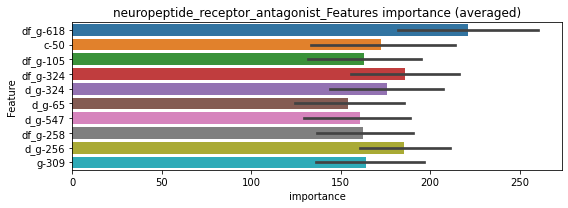

len(train_index) : 3860
len(valid_index) : 3861
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544388	valid_1's binary_logloss: 0.0790403
[200]	training's binary_logloss: 0.0177321	valid_1's binary_logloss: 0.041224
[300]	training's binary_logloss: 0.00590219	valid_1's binary_logloss: 0.026049
[400]	training's binary_logloss: 0.00238673	valid_1's binary_logloss: 0.0201015
[500]	training's binary_logloss: 0.00131208	valid_1's binary_logloss: 0.0179087
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00113111	valid_1's binary_logloss: 0.0173542


len(train_index) : 3861
len(valid_index) : 3860
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486625	valid_1's binary_logloss: 0.0853598
[200]	training's binary_logloss: 0.0169245	valid_1's binary_logloss: 0.0539274
[300]	training's binary_logloss: 0.00578055	valid_1's binary_logloss: 0.0405131
[400]	training's binary_logloss: 0.00245224	valid_1's binary_logloss: 0.0354468
[500]	training's binary_logloss: 0.00135641	valid_1's binary_logloss: 0.0344204
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00141351	valid_1's binary_logloss: 0.0342493


neuropeptide_receptor_antagonist logloss: 0.025800645371112863


neg labels: 3289 → selected neg labels: 3173


nfkb_inhibitor, len(trt): 832, len(othr): 3173, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.510
y_Threshold: 0.2105020, Threshold: 0.2724008, pos_neg_ratio: 0.7377876
Remove_noisy_labels: 1436 → Positive_corect_labels: 224/2569
p_label_rate: 0.0203415 Vs.target_rate: 0.03494, Num_p_label: 81.0, conf_0:0.24516, conf_1:0.29964
threshold: 0.2724008, positive_p_label: 81.0/3982, p_label_rate: 0.0203415


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.490834	valid_1's binary_logloss: 0.509793
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.505698	valid_1's binary_logloss: 0.5106


positive_y_label: 224.0/2569, y_label_rate: 0.0871935
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.113692	valid_1's binary_logloss: 0.246671
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.751
y_Threshold: 0.1486654, Threshold: 0.2724008, pos_neg_ratio: 0.7377876
Remove_noisy_labels: 278 → Positive_corect_labels: 85.0/2291
p_label_rate: 0.0635359 Vs.target_rate: 0.03494, Num_p_label: 253.0, conf_0:0.24516, conf_1:0.29964
threshold: 0.2724008, positive_p_label: 253.0/3982, p_label_rate: 0.0635359
positive_y_label: 85.0/2291, y_label_rate: 0.0371017
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.1597	valid_1's binary_logloss: 0.253795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218784	valid_1's binary_logloss: 0.0790308
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.016116	valid_1's binary_logloss: 0.0774804
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.911
y_Threshold: 0.1582853, Threshold: 0.2724008, pos_neg_ratio: 0.7377876
Remove_noisy_labels: 58 → Positive_corect_labels: 56.0/2233
p_label_rate: 0.0708187 Vs.target_rate: 0.03494, Num_p_label: 282.0, conf_0:0.24516, conf_1:0.29964
threshold: 0.2724008, positive_p_label: 282.0/3982, p_label_rate: 0.0708187
positive_y_label: 338.0/6215, y_label_rate: 0.0543846


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0263558	valid_1's binary_logloss: 0.0846413


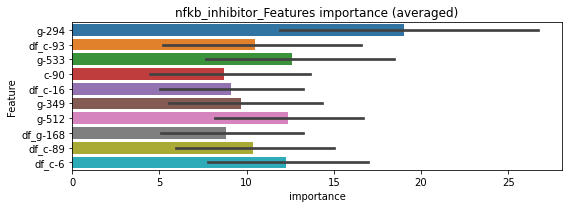

len(train_index) : 3107
len(valid_index) : 3108
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145024	valid_1's binary_logloss: 0.0242394


len(train_index) : 3108
len(valid_index) : 3107
================================= fold 2/2 nfkb_inhibitor=================================


[200]	training's binary_logloss: 0.00357022	valid_1's binary_logloss: 0.0178128
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00394486	valid_1's binary_logloss: 0.0176331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129438	valid_1's binary_logloss: 0.0292762


nfkb_inhibitor logloss: 0.019963065427193994


[200]	training's binary_logloss: 0.00294384	valid_1's binary_logloss: 0.0224271
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00277477	valid_1's binary_logloss: 0.0222938
neg labels: 3289 → selected neg labels: 3289


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527057	valid_1's binary_logloss: 0.0681995
[200]	training's binary_logloss: 0.00866374	valid_1's binary_logloss: 0.0197108
[300]	training's binary_logloss: 0.00244888	valid_1's binary_logloss: 0.00996043
[400]	training's binary_logloss: 0.00121715	valid_1's binary_logloss: 0.00725948
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00091689	valid_1's binary_logloss: 0.00648306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525563	valid_1's binary_logloss: 0.0688871
[200]	training's binary_logloss: 0.00906782	valid_1's binary_logloss: 0.0198795
[300]	training's binary_logloss: 0.00253875	valid_1's binary_logloss: 0.00919097
[400]	training's binary_logloss: 0.00126161	valid_1's binary_logloss: 0.0062386
[500]	training's binary_logloss: 0.000924606	valid_1's binary_logloss: 0.00529505
[600]	training's binary_logloss: 0.0007

1 / 3 AUC score:1.000
y_Threshold: 0.0109391, Threshold: 0.0627495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.05647, conf_1:0.06902
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0627495
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_2: 0.0927495
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.1227495
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.1527495
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.1827495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_6: 0.2127495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.2427495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.2727495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_9: 0.3027495
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_10: 0.3327495
threshold: 0.3627495, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429967	valid_1's binary_logloss: 0.0577705
[200]	training's binary_logloss: 0.00691292	valid_1's binary_logloss: 0.0141162
[300]	training's binary_logloss: 0.00204439	valid_1's binary_logloss: 0.00564018
[400]	training's binary_logloss: 0.00107423	valid_1's binary_logloss: 0.0034919
[500]	training's binary_logloss: 0.000793208	valid_1's binary_logloss: 0.00277085
[600]	training's binary_logloss: 0.000672685	valid_1's binary_logloss: 0.00246344
[700]	training's binary_logloss: 0.000626378	valid_1's binary_logloss: 0.00233671
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.000626378	valid_1's binary_logloss: 0.00233671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427222	valid_1's binary_logloss: 0.0539104
[200]	training's binary_logloss: 0.0065785	valid_1's binary_logloss: 0.0133465
[300]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.3198008, Threshold: 0.3627495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0057760 Vs.target_rate: 0.00050, Num_p_label: 23.0, conf_0:0.32647, conf_1:0.39902
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_1: 0.3627495
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.3927495
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_3: 0.4227495
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.4527495
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.4827495
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_6: 0.5127495
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.5427495
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.5727495
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.6027495
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.6327495
threshold: 0.6627495, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429967	valid_1's binary_logloss: 0.0577705
[200]	training's binary_logloss: 0.00691292	valid_1's binary_logloss: 0.0141162
[300]	training's binary_logloss: 0.00204439	valid_1's binary_logloss: 0.00564018
[400]	training's binary_logloss: 0.00107423	valid_1's binary_logloss: 0.0034919
[500]	training's binary_logloss: 0.000793208	valid_1's binary_logloss: 0.00277085
[600]	training's binary_logloss: 0.000672685	valid_1's binary_logloss: 0.00246344
[700]	training's binary_logloss: 0.000626378	valid_1's binary_logloss: 0.00233671
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.000626378	valid_1's binary_logloss: 0.00233671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427222	valid_1's binary_logloss: 0.0539104
[200]	training's binary_logloss: 0.0065785	valid_1's binary_logloss: 0.0133465
[300]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.3198008, Threshold: 0.6627495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.59647, conf_1:0.72902
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.6627495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.6927495
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.7227495
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.7527495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.7827495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.8127495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_7: 0.8427495
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.8727495
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.9027495
threshold: 0.9027495, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7795, y_label_rate: 0.0847979


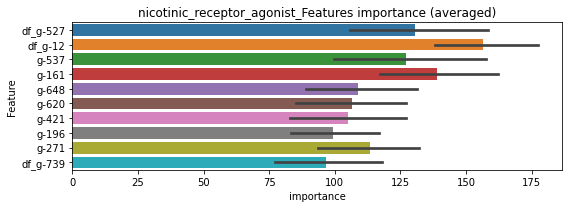

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299224	valid_1's binary_logloss: 0.0400549
[200]	training's binary_logloss: 0.00510253	valid_1's binary_logloss: 0.0114596
[300]	training's binary_logloss: 0.00133683	valid_1's binary_logloss: 0.00525243


len(train_index) : 3898
len(valid_index) : 3897


[400]	training's binary_logloss: 0.000658698	valid_1's binary_logloss: 0.00383378
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000615097	valid_1's binary_logloss: 0.00373442


================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269283	valid_1's binary_logloss: 0.034057
[200]	training's binary_logloss: 0.0045058	valid_1's binary_logloss: 0.00912228
[300]	training's binary_logloss: 0.00128439	valid_1's binary_logloss: 0.0043043
[400]	training's binary_logloss: 0.000655414	valid_1's binary_logloss: 0.0031083
[500]	training's binary_logloss: 0.000464457	valid_1's binary_logloss: 0.00270298
[600]	training's binary_logloss: 0.000389996	valid_1's binary_logloss: 0.00257302
[700]	training's binary_logloss: 0.000357113	valid_1's binary_logloss: 0.00250351
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.000357113	valid_1's binary_logloss: 0.00250351


nicotinic_receptor_agonist logloss: 0.0031190395349302074


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870636	valid_1's binary_logloss: 0.130467
[200]	training's binary_logloss: 0.0232788	valid_1's binary_logloss: 0.0576756
[300]	training's binary_logloss: 0.00743641	valid_1's binary_logloss: 0.0322285
[400]	training's binary_logloss: 0.00321485	valid_1's binary_logloss: 0.0222515
[500]	training's binary_logloss: 0.00196004	valid_1's binary_logloss: 0.0193291
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00200964	valid_1's binary_logloss: 0.0192825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086531	valid_1's binary_logloss: 0.118318
[200]	training's binary_logloss: 0.0269108	valid_1's binary_logloss: 0.055057
[300]	training's binary_logloss: 0.00893849	valid_1's binary_logloss: 0.032027
[400]	training's binary_logloss: 0.0038353	valid_1's binary_logloss: 0.0230774
[500]	training's binary_logloss: 0.00220261	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0322404, Threshold: 0.3646016, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.32814, conf_1:0.40106
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.3646016
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_2: 0.3946016
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_3: 0.4246016
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_4: 0.4546016
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_5: 0.4846016
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_6: 0.5146016
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_7: 0.5446016
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_8: 0.5746016
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_9: 0.6046016
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_10: 0.6346016
threshold: 0.6646016, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810508	valid_1's binary_logloss: 0.118152
[200]	training's binary_logloss: 0.021245	valid_1's binary_logloss: 0.0491796
[300]	training's binary_logloss: 0.00662117	valid_1's binary_logloss: 0.0244556
[400]	training's binary_logloss: 0.00296316	valid_1's binary_logloss: 0.0169481
[500]	training's binary_logloss: 0.00179776	valid_1's binary_logloss: 0.0139224
[600]	training's binary_logloss: 0.00137904	valid_1's binary_logloss: 0.0126729
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00126342	valid_1's binary_logloss: 0.0122745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782079	valid_1's binary_logloss: 0.112816
[200]	training's binary_logloss: 0.0209193	valid_1's binary_logloss: 0.0466188
[300]	training's binary_logloss: 0.00652485	valid_1's binary_logloss: 0.0239593
[400]	training's binary_logloss: 0.0029331	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.2357923, Threshold: 0.6646016, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0097941 Vs.target_rate: 0.00109, Num_p_label: 39.0, conf_0:0.59814, conf_1:0.73106
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_1: 0.6646016
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_2: 0.6946016
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_3: 0.7246016
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_4: 0.7546016
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_5: 0.7846016
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_6: 0.8146016
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_7: 0.8446016
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_8: 0.8746016
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_9: 0.9046016
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_10: 0.9346016
threshold: 0.9646016, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774478	valid_1's binary_logloss: 0.110118
[200]	training's binary_logloss: 0.0204114	valid_1's binary_logloss: 0.0444662
[300]	training's binary_logloss: 0.00612918	valid_1's binary_logloss: 0.0231262
[400]	training's binary_logloss: 0.00279163	valid_1's binary_logloss: 0.0168476
[500]	training's binary_logloss: 0.00172674	valid_1's binary_logloss: 0.0147152
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00165819	valid_1's binary_logloss: 0.0145527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759261	valid_1's binary_logloss: 0.107812
[200]	training's binary_logloss: 0.0188996	valid_1's binary_logloss: 0.0412646
[300]	training's binary_logloss: 0.0062709	valid_1's binary_logloss: 0.0207492
[400]	training's binary_logloss: 0.00289889	valid_1's binary_logloss: 0.0137521
[500]	training's binary_logloss: 0.0018008	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.2698752, Threshold: 0.9646016, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0015068 Vs.target_rate: 0.00109, Num_p_label: 6.0, conf_0:0.86814, conf_1:1.06106
threshold: 0.9646016, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/7780, y_label_rate: 0.0844473


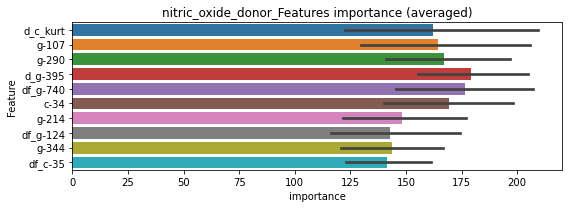

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435947	valid_1's binary_logloss: 0.0684842
[200]	training's binary_logloss: 0.0129693	valid_1's binary_logloss: 0.0339936
[300]	training's binary_logloss: 0.0038467	valid_1's binary_logloss: 0.0205967
[400]	training's binary_logloss: 0.00165314	valid_1's binary_logloss: 0.0160365
[500]	training's binary_logloss: 0.000989101	valid_1's binary_logloss: 0.0142799
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000871919	valid_1's binary_logloss: 0.0139772


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441648	valid_1's binary_logloss: 0.0683496
[200]	training's binary_logloss: 0.0121007	valid_1's binary_logloss: 0.0320429
[300]	training's binary_logloss: 0.00396387	valid_1's binary_logloss: 0.0210688
[400]	training's binary_logloss: 0.00181774	valid_1's binary_logloss: 0.01714
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00120588	valid_1's binary_logloss: 0.0155261


nitric_oxide_donor logloss: 0.014751660941413447


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3285, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649314	valid_1's binary_logloss: 0.0979511
[200]	training's binary_logloss: 0.0164338	valid_1's binary_logloss: 0.0435336
[300]	training's binary_logloss: 0.00522956	valid_1's binary_logloss: 0.0256988
[400]	training's binary_logloss: 0.00239875	valid_1's binary_logloss: 0.0197738
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00155793	valid_1's binary_logloss: 0.0171508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658013	valid_1's binary_logloss: 0.10009
[200]	training's binary_logloss: 0.0175434	valid_1's binary_logloss: 0.0453594
[300]	training's binary_logloss: 0.00541464	valid_1's binary_logloss: 0.0256218
[400]	training's binary_logloss: 0.00237008	valid_1's binary_logloss: 0.018041
[500]	training's binary_logloss: 0.00148597	valid_1's binary_logloss: 0.0154538
[600]	training's binary_logloss: 0.00113426	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0222860, Threshold: 0.0987157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.08884, conf_1:0.10859
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.0987157
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_2: 0.1287157
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_3: 0.1587157
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_4: 0.1887157
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_5: 0.2187157
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_6: 0.2487157
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_7: 0.2787157
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_8: 0.3087157
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_9: 0.3387157
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_10: 0.3687157
threshold: 0.3987157, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572125	valid_1's binary_logloss: 0.0811768
[200]	training's binary_logloss: 0.0124896	valid_1's binary_logloss: 0.027699
[300]	training's binary_logloss: 0.00398173	valid_1's binary_logloss: 0.0131494
[400]	training's binary_logloss: 0.00198409	valid_1's binary_logloss: 0.0087511
[500]	training's binary_logloss: 0.00131343	valid_1's binary_logloss: 0.00696337
[600]	training's binary_logloss: 0.00102771	valid_1's binary_logloss: 0.00614384
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000995782	valid_1's binary_logloss: 0.006043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603301	valid_1's binary_logloss: 0.0895862
[200]	training's binary_logloss: 0.0131821	valid_1's binary_logloss: 0.0343942
[300]	training's binary_logloss: 0.00407818	valid_1's binary_logloss: 0.0186567
[400]	training's binary_logloss: 0.00197684	va

2 / 3 AUC score:1.000
y_Threshold: 0.2959098, Threshold: 0.3987157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00122, Num_p_label: 19.0, conf_0:0.35884, conf_1:0.43859
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_1: 0.3987157
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_2: 0.4287157
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.4587157
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_4: 0.4887157
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_5: 0.5187157
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_6: 0.5487157
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_7: 0.5787157
threshold: 0.5787157, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568697	valid_1's binary_logloss: 0.0846787
[200]	training's binary_logloss: 0.012716	valid_1's binary_logloss: 0.0323369
[300]	training's binary_logloss: 0.00405574	valid_1's binary_logloss: 0.0179819
[400]	training's binary_logloss: 0.00199394	valid_1's binary_logloss: 0.0129554
[500]	training's binary_logloss: 0.00134065	valid_1's binary_logloss: 0.0110248
[600]	training's binary_logloss: 0.001052	valid_1's binary_logloss: 0.0100029
[700]	training's binary_logloss: 0.000902795	valid_1's binary_logloss: 0.00955037
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.000894831	valid_1's binary_logloss: 0.00952424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563895	valid_1's binary_logloss: 0.0826525
[200]	training's binary_logloss: 0.0118497	valid_1's binary_logloss: 0.0298812
[300]	training's binary_logloss: 0.00377512	va

3 / 3 AUC score:1.000
y_Threshold: 0.2524409, Threshold: 0.5787157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0022602 Vs.target_rate: 0.00122, Num_p_label: 9.0, conf_0:0.52084, conf_1:0.63659
threshold: 0.5787157, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 662.0/7784, y_label_rate: 0.0850462


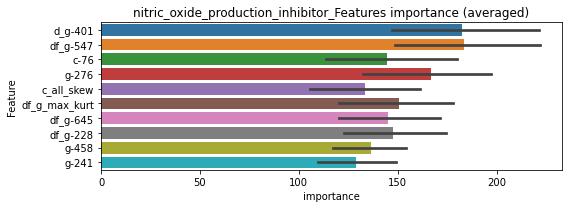

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360436	valid_1's binary_logloss: 0.0541302
[200]	training's binary_logloss: 0.00789231	valid_1's binary_logloss: 0.0204386
[300]	training's binary_logloss: 0.00241349	valid_1's binary_logloss: 0.0107298
[400]	training's binary_logloss: 0.00112495	valid_1's binary_logloss: 0.00793768
[500]	training's binary_logloss: 0.000739043	valid_1's binary_logloss: 0.00701656
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000685018	valid_1's binary_logloss: 0.00687441


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348875	valid_1's binary_logloss: 0.0542532
[200]	training's binary_logloss: 0.00765414	valid_1's binary_logloss: 0.0220534
[300]	training's binary_logloss: 0.00237317	valid_1's binary_logloss: 0.0143548
[400]	training's binary_logloss: 0.00113038	valid_1's binary_logloss: 0.0114313
[500]	training's binary_logloss: 0.000736487	valid_1's binary_logloss: 0.0102414
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000758818	valid_1's binary_logloss: 0.0102049


nitric_oxide_production_inhibitor logloss: 0.008539672081316436


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695378	valid_1's binary_logloss: 0.102175
[200]	training's binary_logloss: 0.0179575	valid_1's binary_logloss: 0.0449677
[300]	training's binary_logloss: 0.00563955	valid_1's binary_logloss: 0.0261096
[400]	training's binary_logloss: 0.00251209	valid_1's binary_logloss: 0.0191902
[500]	training's binary_logloss: 0.00159966	valid_1's binary_logloss: 0.0171553
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00137387	valid_1's binary_logloss: 0.016148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696846	valid_1's binary_logloss: 0.103007
[200]	training's binary_logloss: 0.0178636	valid_1's binary_logloss: 0.0445125
[300]	training's binary_logloss: 0.0054579	valid_1's binary_logloss: 0.0256205
[400]	training's binary_logloss: 0.00256791	valid_1's binary_logloss: 0.0184735
[500]	training's binary_logloss: 0.00161535	valid_1

1 / 3 AUC score:1.000
y_Threshold: 0.0196425, Threshold: 0.1952772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.17575, conf_1:0.21480
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.1952772
Num_p_label: 38.0, Expected: 4.3, Adj_threshold_2: 0.2252772
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_3: 0.2552772
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_4: 0.2852772
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_5: 0.3152772
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_6: 0.3452772
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_7: 0.3752772
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_8: 0.4052772
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_9: 0.4352772
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_10: 0.4652772
threshold: 0.4952772, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610284	valid_1's binary_logloss: 0.0915873
[200]	training's binary_logloss: 0.0147624	valid_1's binary_logloss: 0.0373912
[300]	training's binary_logloss: 0.00461908	valid_1's binary_logloss: 0.0200366
[400]	training's binary_logloss: 0.00217733	valid_1's binary_logloss: 0.0146201
[500]	training's binary_logloss: 0.00144644	valid_1's binary_logloss: 0.0132028
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00119998	valid_1's binary_logloss: 0.0124734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589876	valid_1's binary_logloss: 0.0909402
[200]	training's binary_logloss: 0.0137762	valid_1's binary_logloss: 0.0341378
[300]	training's binary_logloss: 0.00433657	valid_1's binary_logloss: 0.0185904
[400]	training's binary_logloss: 0.00205178	valid_1's binary_logloss: 0.0129558
[500]	training's binary_logloss: 0.00135398	val

2 / 3 AUC score:1.000
y_Threshold: 0.2354564, Threshold: 0.4952772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0102963 Vs.target_rate: 0.00109, Num_p_label: 41.0, conf_0:0.44575, conf_1:0.54480
Num_p_label: 41.0, Expected: 4.3, Adj_threshold_1: 0.4952772
Num_p_label: 38.0, Expected: 4.3, Adj_threshold_2: 0.5252772
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_3: 0.5552772
Num_p_label: 35.0, Expected: 4.3, Adj_threshold_4: 0.5852772
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_5: 0.6152772
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_6: 0.6452772
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_7: 0.6752772
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_8: 0.7052772
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_9: 0.7352772
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_10: 0.7652772
threshold: 0.7952772, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557639	valid_1's binary_logloss: 0.083611
[200]	training's binary_logloss: 0.0129157	valid_1's binary_logloss: 0.032717
[300]	training's binary_logloss: 0.00414909	valid_1's binary_logloss: 0.019133
[400]	training's binary_logloss: 0.00206928	valid_1's binary_logloss: 0.0146752
[500]	training's binary_logloss: 0.00136864	valid_1's binary_logloss: 0.0129968
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00127945	valid_1's binary_logloss: 0.0127246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639888	valid_1's binary_logloss: 0.0918948
[200]	training's binary_logloss: 0.0145956	valid_1's binary_logloss: 0.0331273
[300]	training's binary_logloss: 0.00445257	valid_1's binary_logloss: 0.0156946
[400]	training's binary_logloss: 0.00211409	valid_1's binary_logloss: 0.0108075
[500]	training's binary_logloss: 0.00141751	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1430145, Threshold: 0.7952772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0050226 Vs.target_rate: 0.00109, Num_p_label: 20.0, conf_0:0.71575, conf_1:0.87480
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_1: 0.7952772
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.8252772
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_3: 0.8552772
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.8852772
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.9152772
threshold: 0.9152772, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/7778, y_label_rate: 0.0842119


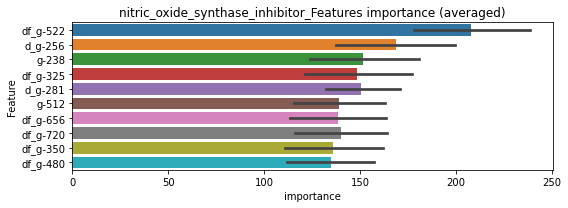

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356759	valid_1's binary_logloss: 0.0565454
[200]	training's binary_logloss: 0.00825187	valid_1's binary_logloss: 0.0239224
[300]	training's binary_logloss: 0.00251642	valid_1's binary_logloss: 0.0144144
[400]	training's binary_logloss: 0.00118287	valid_1's binary_logloss: 0.0112374
[500]	training's binary_logloss: 0.000773349	valid_1's binary_logloss: 0.0103195
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000799159	valid_1's binary_logloss: 0.0102901


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347694	valid_1's binary_logloss: 0.053246
[200]	training's binary_logloss: 0.00898464	valid_1's binary_logloss: 0.0230255
[300]	training's binary_logloss: 0.00271653	valid_1's binary_logloss: 0.0125143
[400]	training's binary_logloss: 0.00127216	valid_1's binary_logloss: 0.00929649
[500]	training's binary_logloss: 0.000820579	valid_1's binary_logloss: 0.00795081
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000776705	valid_1's binary_logloss: 0.00793355


nitric_oxide_synthase_inhibitor logloss: 0.009111840355451921


neg labels: 3289 → selected neg labels: 3286


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3286, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278872	valid_1's binary_logloss: 0.0374425
[200]	training's binary_logloss: 0.00366135	valid_1's binary_logloss: 0.0106849
[300]	training's binary_logloss: 0.00116878	valid_1's binary_logloss: 0.00649989
[400]	training's binary_logloss: 0.000680952	valid_1's binary_logloss: 0.00497266
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000542234	valid_1's binary_logloss: 0.00428592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298314	valid_1's binary_logloss: 0.039315
[200]	training's binary_logloss: 0.00423169	valid_1's binary_logloss: 0.0131132
[300]	training's binary_logloss: 0.00131903	valid_1's binary_logloss: 0.00860113
[400]	training's binary_logloss: 0.000749815	valid_1's binary_logloss: 0.00716897
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000589798	valid_1's binary_logloss: 0.00649219


1 / 3 AUC score:1.000
y_Threshold: 0.0037652, Threshold: 0.1169342, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.10524, conf_1:0.12863
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.1169342
Num_p_label: 36.0, Expected: 1.2, Adj_threshold_2: 0.1469342
Num_p_label: 34.0, Expected: 1.2, Adj_threshold_3: 0.1769342
Num_p_label: 31.0, Expected: 1.2, Adj_threshold_4: 0.2069342
Num_p_label: 23.0, Expected: 1.2, Adj_threshold_5: 0.2369342
Num_p_label: 20.0, Expected: 1.2, Adj_threshold_6: 0.2669342
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_7: 0.2969342
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_8: 0.3269342
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_9: 0.3569342
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_10: 0.3869342
threshold: 0.4169342, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023778	valid_1's binary_logloss: 0.0269044
[200]	training's binary_logloss: 0.0029268	valid_1's binary_logloss: 0.00445172
[300]	training's binary_logloss: 0.000955539	valid_1's binary_logloss: 0.00178844
[400]	training's binary_logloss: 0.000557355	valid_1's binary_logloss: 0.00117221
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000458659	valid_1's binary_logloss: 0.000999545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241456	valid_1's binary_logloss: 0.0287568
[200]	training's binary_logloss: 0.00298771	valid_1's binary_logloss: 0.00544915
[300]	training's binary_logloss: 0.000990569	valid_1's binary_logloss: 0.00226294


2 / 3 AUC score:1.000
y_Threshold: 0.4063046, Threshold: 0.4169342, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0145655 Vs.target_rate: 0.00029, Num_p_label: 58.0, conf_0:0.37524, conf_1:0.45863


[400]	training's binary_logloss: 0.000578061	valid_1's binary_logloss: 0.00146229
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000473847	valid_1's binary_logloss: 0.00127411


Num_p_label: 58.0, Expected: 1.2, Adj_threshold_1: 0.4169342
Num_p_label: 57.0, Expected: 1.2, Adj_threshold_2: 0.4469342
Num_p_label: 53.0, Expected: 1.2, Adj_threshold_3: 0.4769342
Num_p_label: 52.0, Expected: 1.2, Adj_threshold_4: 0.5069342
Num_p_label: 50.0, Expected: 1.2, Adj_threshold_5: 0.5369342
Num_p_label: 49.0, Expected: 1.2, Adj_threshold_6: 0.5669342
Num_p_label: 46.0, Expected: 1.2, Adj_threshold_7: 0.5969342
Num_p_label: 46.0, Expected: 1.2, Adj_threshold_8: 0.6269342
Num_p_label: 44.0, Expected: 1.2, Adj_threshold_9: 0.6569342
Num_p_label: 42.0, Expected: 1.2, Adj_threshold_10: 0.6869342
threshold: 0.7169342, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023778	valid_1's binary_logloss: 0.0269044
[200]	training's binary_logloss: 0.0029268	valid_1's binary_logloss: 0.00445172
[300]	training's binary_logloss: 0.000955539	valid_1's binary_logloss: 0.00178844
[400]	training's binary_logloss: 0.000557355	valid_1's binary_logloss: 0.00117221
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000458659	valid_1's binary_logloss: 0.000999545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241456	valid_1's binary_logloss: 0.0287568
[200]	training's binary_logloss: 0.00298771	valid_1's binary_logloss: 0.00544915
[300]	training's binary_logloss: 0.000990569	valid_1's binary_logloss: 0.00226294


3 / 3 AUC score:1.000
y_Threshold: 0.4063046, Threshold: 0.7169342, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.000578061	valid_1's binary_logloss: 0.00146229
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000473847	valid_1's binary_logloss: 0.00127411


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0097941 Vs.target_rate: 0.00029, Num_p_label: 39.0, conf_0:0.64524, conf_1:0.78863
Num_p_label: 39.0, Expected: 1.2, Adj_threshold_1: 0.7169342
Num_p_label: 37.0, Expected: 1.2, Adj_threshold_2: 0.7469342
Num_p_label: 36.0, Expected: 1.2, Adj_threshold_3: 0.7769342
Num_p_label: 36.0, Expected: 1.2, Adj_threshold_4: 0.8069342
Num_p_label: 32.0, Expected: 1.2, Adj_threshold_5: 0.8369342
Num_p_label: 29.0, Expected: 1.2, Adj_threshold_6: 0.8669342
Num_p_label: 22.0, Expected: 1.2, Adj_threshold_7: 0.8969342
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_8: 0.9269342
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_9: 0.9569342
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_10: 0.9869342
threshold: 0.9869342, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


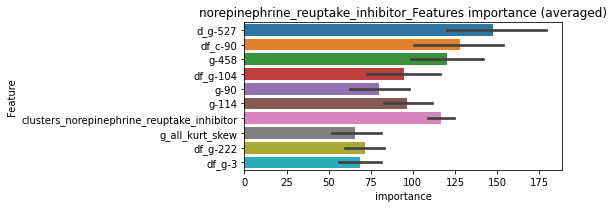

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155867	valid_1's binary_logloss: 0.0195737
[200]	training's binary_logloss: 0.00197199	valid_1's binary_logloss: 0.00514188


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000690212	valid_1's binary_logloss: 0.00352207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014832	valid_1's binary_logloss: 0.0175006
[200]	training's binary_logloss: 0.00202278	valid_1's binary_logloss: 0.00412727
[300]	training's binary_logloss: 0.000645393	valid_1's binary_logloss: 0.00223722
[400]	training's binary_logloss: 0.000381045	valid_1's binary_logloss: 0.00181391


norepinephrine_reuptake_inhibitor logloss: 0.0025720635338061237


[500]	training's binary_logloss: 0.000299886	valid_1's binary_logloss: 0.00162292
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00029929	valid_1's binary_logloss: 0.00162181
neg labels: 3289 → selected neg labels: 3287


nrf2_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464787	valid_1's binary_logloss: 0.0671857
[200]	training's binary_logloss: 0.0094151	valid_1's binary_logloss: 0.0251156
[300]	training's binary_logloss: 0.00283686	valid_1's binary_logloss: 0.0152191
[400]	training's binary_logloss: 0.00142871	valid_1's binary_logloss: 0.0125972
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00122366	valid_1's binary_logloss: 0.0121988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464077	valid_1's binary_logloss: 0.0679977
[200]	training's binary_logloss: 0.00930086	valid_1's binary_logloss: 0.0235813
[300]	training's binary_logloss: 0.00282265	valid_1's binary_logloss: 0.0125522
[400]	training's binary_logloss: 0.00142828	valid_1's binary_logloss: 0.0088351
[500]	training's binary_logloss: 0.00101035	valid_1's binary_logloss: 0.0077214
[600]	training's binary_logloss: 0.000823357	v

1 / 3 AUC score:1.000
y_Threshold: 0.0152156, Threshold: 0.0808057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.07273, conf_1:0.08889
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0808057
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.1108057
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.1408057
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.1708057
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.2008057
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.2308057
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.2608057
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.2908057
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.3208057
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.3508057
threshold: 0.3808057, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432518	valid_1's binary_logloss: 0.0624583
[200]	training's binary_logloss: 0.00800669	valid_1's binary_logloss: 0.0203417
[300]	training's binary_logloss: 0.00237383	valid_1's binary_logloss: 0.0104332
[400]	training's binary_logloss: 0.00126067	valid_1's binary_logloss: 0.00817448
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00102758	valid_1's binary_logloss: 0.00777054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431419	valid_1's binary_logloss: 0.0571262
[200]	training's binary_logloss: 0.0080452	valid_1's binary_logloss: 0.015387
[300]	training's binary_logloss: 0.00244109	valid_1's binary_logloss: 0.00647641
[400]	training's binary_logloss: 0.00127541	valid_1's binary_logloss: 0.00435248
[500]	training's binary_logloss: 0.000902935	valid_1's binary_logloss: 0.00352281
Early stopping, best iteration is:
[565]	

2 / 3 AUC score:1.000
y_Threshold: 0.1128828, Threshold: 0.3808057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.34273, conf_1:0.41889
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.3808057
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.4108057
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.4408057
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.4708057
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.5008057
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.5308057
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.5608057
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_8: 0.5908057
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.6208057
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.6508057
threshold: 0.6808057, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409174	valid_1's binary_logloss: 0.0605684
[200]	training's binary_logloss: 0.00744895	valid_1's binary_logloss: 0.0185426
[300]	training's binary_logloss: 0.00229001	valid_1's binary_logloss: 0.00868562
[400]	training's binary_logloss: 0.00120383	valid_1's binary_logloss: 0.00589158
[500]	training's binary_logloss: 0.000859384	valid_1's binary_logloss: 0.0049254
[600]	training's binary_logloss: 0.000722492	valid_1's binary_logloss: 0.00456701
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.000698465	valid_1's binary_logloss: 0.00448546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455853	valid_1's binary_logloss: 0.0623475
[200]	training's binary_logloss: 0.00785212	valid_1's binary_logloss: 0.0186004
[300]	training's binary_logloss: 0.00240899	valid_1's binary_logloss: 0.00910741
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0917161, Threshold: 0.6808057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.61273, conf_1:0.74889
threshold: 0.6808057, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


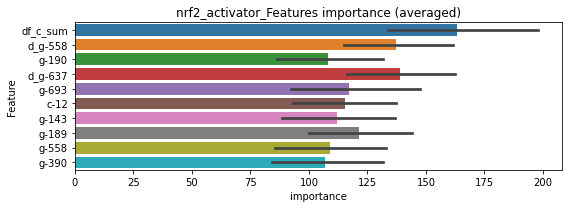

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239201	valid_1's binary_logloss: 0.0436048
[200]	training's binary_logloss: 0.00454565	valid_1's binary_logloss: 0.0211386
[300]	training's binary_logloss: 0.00134919	valid_1's binary_logloss: 0.0145733
[400]	training's binary_logloss: 0.000700528	valid_1's binary_logloss: 0.0120948
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000536955	valid_1's binary_logloss: 0.0110311


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238971	valid_1's binary_logloss: 0.0327383
[200]	training's binary_logloss: 0.00467867	valid_1's binary_logloss: 0.011214
[300]	training's binary_logloss: 0.00142896	valid_1's binary_logloss: 0.00671537
[400]	training's binary_logloss: 0.000724676	valid_1's binary_logloss: 0.00508966
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000576249	valid_1's binary_logloss: 0.00486651


nrf2_activator logloss: 0.007948812485809077


neg labels: 3289 → selected neg labels: 3280


opioid_receptor_agonist, len(trt): 61, len(othr): 3280, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11024	valid_1's binary_logloss: 0.176116
[200]	training's binary_logloss: 0.0396482	valid_1's binary_logloss: 0.109748
[300]	training's binary_logloss: 0.0156673	valid_1's binary_logloss: 0.0855013
[400]	training's binary_logloss: 0.00711289	valid_1's binary_logloss: 0.0748746
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00447543	valid_1's binary_logloss: 0.0705939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120491	valid_1's binary_logloss: 0.172418
[200]	training's binary_logloss: 0.0479626	valid_1's binary_logloss: 0.106127
[300]	training's binary_logloss: 0.0189855	valid_1's binary_logloss: 0.0731952
[400]	training's binary_logloss: 0.00835502	valid_1's binary_logloss: 0.0571188
[500]	training's binary_logloss: 0.00446063	valid_1's binary_logloss: 0.0490564
Early stopping, best iteration is:
[585]	training's bina

1 / 3 AUC score:0.995
y_Threshold: 0.0451253, Threshold: 0.1324485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 636/3764
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.11920, conf_1:0.14569
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.1324485
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_2: 0.1624485
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_3: 0.1924485
threshold: 0.1924485, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 636.0/3764, y_label_rate: 0.1689692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100681	valid_1's binary_logloss: 0.162435
[200]	training's binary_logloss: 0.0367303	valid_1's binary_logloss: 0.0965372
[300]	training's binary_logloss: 0.0136101	valid_1's binary_logloss: 0.0661255
[400]	training's binary_logloss: 0.0065315	valid_1's binary_logloss: 0.0534431
[500]	training's binary_logloss: 0.00375638	valid_1's binary_logloss: 0.0465592
[600]	training's binary_logloss: 0.00241539	valid_1's binary_logloss: 0.0420642
[700]	training's binary_logloss: 0.00184106	valid_1's binary_logloss: 0.0392859
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00187611	valid_1's binary_logloss: 0.0390775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102989	valid_1's binary_logloss: 0.154141
[200]	training's binary_logloss: 0.0355013	valid_1's binary_logloss: 0.0832818
[300]	training's binary_logloss: 0.0134194	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1568213, Threshold: 0.1924485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 624.0/3740
p_label_rate: 0.0125565 Vs.target_rate: 0.00256, Num_p_label: 50.0, conf_0:0.17320, conf_1:0.21169
Num_p_label: 50.0, Expected: 10.2, Adj_threshold_1: 0.1924485
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.2224485
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_3: 0.2524485
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_4: 0.2824485
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_5: 0.3124485
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_6: 0.3424485
threshold: 0.3424485, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 624.0/3740, y_label_rate: 0.1668449
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101054	valid_1's binary_logloss: 0.154277
[200]	training's binary_logloss: 0.0339556	valid_1's binary_logloss: 0.0861565
[300]	training's binary_logloss: 0.0128691	valid_1's binary_logloss: 0.0590029
[400]	training's binary_logloss: 0.00605594	valid_1's binary_logloss: 0.0477124
[500]	training's binary_logloss: 0.00336117	valid_1's binary_logloss: 0.040844
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.0025848	valid_1's binary_logloss: 0.0383888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963355	valid_1's binary_logloss: 0.152578
[200]	training's binary_logloss: 0.0314555	valid_1's binary_logloss: 0.0854072
[300]	training's binary_logloss: 0.011095	valid_1's binary_logloss: 0.058867
[400]	training's binary_logloss: 0.00517568	valid_1's binary_logloss: 0.0489974
[500]	training's binary_logloss: 0.00304709	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.1418879, Threshold: 0.3424485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 608.0/3708
p_label_rate: 0.0070316 Vs.target_rate: 0.00256, Num_p_label: 28.0, conf_0:0.30820, conf_1:0.37669
threshold: 0.3424485, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 636.0/7690, y_label_rate: 0.0827048


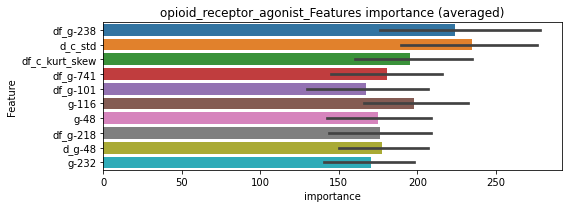

len(train_index) : 3845
len(valid_index) : 3845
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549504	valid_1's binary_logloss: 0.0820176
[200]	training's binary_logloss: 0.0188	valid_1's binary_logloss: 0.0459533
[300]	training's binary_logloss: 0.00714351	valid_1's binary_logloss: 0.0325873
[400]	training's binary_logloss: 0.00321919	valid_1's binary_logloss: 0.0268007
[500]	training's binary_logloss: 0.00177295	valid_1's binary_logloss: 0.0241692
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00153261	valid_1's binary_logloss: 0.0236549


len(train_index) : 3845
len(valid_index) : 3845
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05827	valid_1's binary_logloss: 0.0978998
[200]	training's binary_logloss: 0.0188345	valid_1's binary_logloss: 0.0601784
[300]	training's binary_logloss: 0.00703589	valid_1's binary_logloss: 0.0449239
[400]	training's binary_logloss: 0.00306548	valid_1's binary_logloss: 0.0383219
[500]	training's binary_logloss: 0.00175782	valid_1's binary_logloss: 0.0361505
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00137982	valid_1's binary_logloss: 0.0346598


opioid_receptor_agonist logloss: 0.029157337282724502


neg labels: 3289 → selected neg labels: 3274


opioid_receptor_antagonist, len(trt): 96, len(othr): 3274, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139975	valid_1's binary_logloss: 0.211236
[200]	training's binary_logloss: 0.0624683	valid_1's binary_logloss: 0.146558
[300]	training's binary_logloss: 0.0271801	valid_1's binary_logloss: 0.115381
[400]	training's binary_logloss: 0.0128474	valid_1's binary_logloss: 0.0976192
[500]	training's binary_logloss: 0.00684105	valid_1's binary_logloss: 0.0896013
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00563663	valid_1's binary_logloss: 0.0869802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134268	valid_1's binary_logloss: 0.224844
[200]	training's binary_logloss: 0.0597191	valid_1's binary_logloss: 0.161208
[300]	training's binary_logloss: 0.0264327	valid_1's binary_logloss: 0.131515
[400]	training's binary_logloss: 0.0127293	valid_1's binary_logloss: 0.117042
[500]	training's binary_logloss: 0.00682834	valid_1's binary

1 / 3 AUC score:0.984
y_Threshold: 0.0624853, Threshold: 0.2716425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 206 → Positive_corect_labels: 617/3722
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.24448, conf_1:0.29881
threshold: 0.2716425, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 617.0/3722, y_label_rate: 0.1657711
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129356	valid_1's binary_logloss: 0.215268
[200]	training's binary_logloss: 0.0457071	valid_1's binary_logloss: 0.136865
[300]	training's binary_logloss: 0.0182149	valid_1's binary_logloss: 0.10611
[400]	training's binary_logloss: 0.00837186	valid_1's binary_logloss: 0.0933828
[500]	training's binary_logloss: 0.00472228	valid_1's binary_logloss: 0.0874346
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00352902	valid_1's binary_logloss: 0.0843597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112056	valid_1's binary_logloss: 0.20344
[200]	training's binary_logloss: 0.0429944	valid_1's binary_logloss: 0.142962
[300]	training's binary_logloss: 0.0183954	valid_1's binary_logloss: 0.11716
[400]	training's binary_logloss: 0.0087454	valid_1's binary_logloss: 0.10576
Early stopping, best iteration is:
[470]	training's binary_logl

2 / 3 AUC score:0.990
y_Threshold: 0.1050650, Threshold: 0.2716425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 570.0/3628
p_label_rate: 0.0213461 Vs.target_rate: 0.00403, Num_p_label: 85.0, conf_0:0.24448, conf_1:0.29881
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_1: 0.2716425
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.3016425
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_3: 0.3316425
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_4: 0.3616425
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_5: 0.3916425
Num_p_label: 45.0, Expected: 16.1, Adj_threshold_6: 0.4216425
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_7: 0.4516425
Num_p_label: 38.0, Expected: 16.1, Adj_threshold_8: 0.4816425
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_9: 0.5116425
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_10: 0.5416425
threshold: 0.5416425, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 570.0/3628, y_label_rate: 0.15711

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988429	valid_1's binary_logloss: 0.17066
[200]	training's binary_logloss: 0.0349495	valid_1's binary_logloss: 0.110435
[300]	training's binary_logloss: 0.01366	valid_1's binary_logloss: 0.0847763
[400]	training's binary_logloss: 0.00654972	valid_1's binary_logloss: 0.0765971
[500]	training's binary_logloss: 0.0037655	valid_1's binary_logloss: 0.0719561
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00289236	valid_1's binary_logloss: 0.0694709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113856	valid_1's binary_logloss: 0.175827
[200]	training's binary_logloss: 0.0407745	valid_1's binary_logloss: 0.107886
[300]	training's binary_logloss: 0.0164351	valid_1's binary_logloss: 0.0812208
[400]	training's binary_logloss: 0.00744066	valid_1's binary_logloss: 0.0674959
Early stopping, best iteration is:
[465]	training's binary

3 / 3 AUC score:0.990
y_Threshold: 0.1267693, Threshold: 0.5416425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 544.0/3576
p_label_rate: 0.0115520 Vs.target_rate: 0.00403, Num_p_label: 46.0, conf_0:0.48748, conf_1:0.59581
threshold: 0.5416425, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 590.0/7558, y_label_rate: 0.0780630


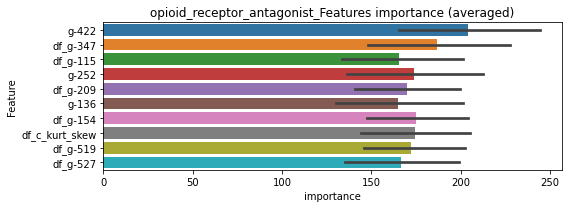

len(train_index) : 3779
len(valid_index) : 3779
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546319	valid_1's binary_logloss: 0.102827
[200]	training's binary_logloss: 0.0196413	valid_1's binary_logloss: 0.0687873
[300]	training's binary_logloss: 0.00769311	valid_1's binary_logloss: 0.0554065
[400]	training's binary_logloss: 0.00362926	valid_1's binary_logloss: 0.0497444
[500]	training's binary_logloss: 0.00205704	valid_1's binary_logloss: 0.0475149
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00186781	valid_1's binary_logloss: 0.0469766


len(train_index) : 3779
len(valid_index) : 3779
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561063	valid_1's binary_logloss: 0.10161
[200]	training's binary_logloss: 0.0201875	valid_1's binary_logloss: 0.0712668
[300]	training's binary_logloss: 0.00777435	valid_1's binary_logloss: 0.0593086
[400]	training's binary_logloss: 0.00359335	valid_1's binary_logloss: 0.0548402
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00221656	valid_1's binary_logloss: 0.0529047


opioid_receptor_antagonist logloss: 0.049940646665726826


neg labels: 3289 → selected neg labels: 3286


orexin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938741	valid_1's binary_logloss: 0.14755
[200]	training's binary_logloss: 0.0293037	valid_1's binary_logloss: 0.0791599
[300]	training's binary_logloss: 0.0101873	valid_1's binary_logloss: 0.0530447
[400]	training's binary_logloss: 0.00454737	valid_1's binary_logloss: 0.0416827
[500]	training's binary_logloss: 0.00260206	valid_1's binary_logloss: 0.0363916
[600]	training's binary_logloss: 0.00184902	valid_1's binary_logloss: 0.0337574
[700]	training's binary_logloss: 0.00150048	valid_1's binary_logloss: 0.0323463
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00152297	valid_1's binary_logloss: 0.0322927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113056	valid_1's binary_logloss: 0.141231
[200]	training's binary_logloss: 0.0379685	valid_1's binary_logloss: 0.0681332
[300]	training's binary_logloss: 0.0125478	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0401362, Threshold: 0.1983897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 655/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.17855, conf_1:0.21823
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1983897
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_2: 0.2283897
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_3: 0.2583897
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_4: 0.2883897
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_5: 0.3183897
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.3483897
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_7: 0.3783897
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_8: 0.4083897
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_9: 0.4383897
threshold: 0.4383897, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826606	valid_1's binary_logloss: 0.127372
[200]	training's binary_logloss: 0.0230315	valid_1's binary_logloss: 0.0597443
[300]	training's binary_logloss: 0.00773496	valid_1's binary_logloss: 0.0347624
[400]	training's binary_logloss: 0.00349815	valid_1's binary_logloss: 0.0245801
[500]	training's binary_logloss: 0.00210845	valid_1's binary_logloss: 0.0203028
[600]	training's binary_logloss: 0.00156929	valid_1's binary_logloss: 0.018642
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00156571	valid_1's binary_logloss: 0.0186377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912521	valid_1's binary_logloss: 0.134271
[200]	training's binary_logloss: 0.0270957	valid_1's binary_logloss: 0.065484
[300]	training's binary_logloss: 0.00875218	valid_1's binary_logloss: 0.0386302
[400]	training's binary_logloss: 0.00388216	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.2760442, Threshold: 0.4383897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 646.0/3789
p_label_rate: 0.0087896 Vs.target_rate: 0.00155, Num_p_label: 35.0, conf_0:0.39455, conf_1:0.48223
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_1: 0.4383897
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_2: 0.4683897
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_3: 0.4983897
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.5283897
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.5583897
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_6: 0.5883897
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_7: 0.6183897
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_8: 0.6483897
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_9: 0.6783897
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_10: 0.7083897
threshold: 0.7083897, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/3789, y_label_rate: 0.1704935
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867758	valid_1's binary_logloss: 0.139405
[200]	training's binary_logloss: 0.023107	valid_1's binary_logloss: 0.0744835
[300]	training's binary_logloss: 0.00793961	valid_1's binary_logloss: 0.0547686
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.004554	valid_1's binary_logloss: 0.050076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873332	valid_1's binary_logloss: 0.122773
[200]	training's binary_logloss: 0.0265837	valid_1's binary_logloss: 0.056453
[300]	training's binary_logloss: 0.00864444	valid_1's binary_logloss: 0.0309943
[400]	training's binary_logloss: 0.00383271	valid_1's binary_logloss: 0.0212375
[500]	training's binary_logloss: 0.00224288	valid_1's binary_logloss: 0.0171067
[600]	training's binary_logloss: 0.00162027	valid_1's binary_logloss: 0.0152079
Early stopping, best iteration is:
[689]	training's bi

3 / 3 AUC score:0.998
y_Threshold: 0.1887762, Threshold: 0.7083897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 633.0/3763
p_label_rate: 0.0035158 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.63755, conf_1:0.77923
threshold: 0.7083897, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 647.0/7745, y_label_rate: 0.0835378


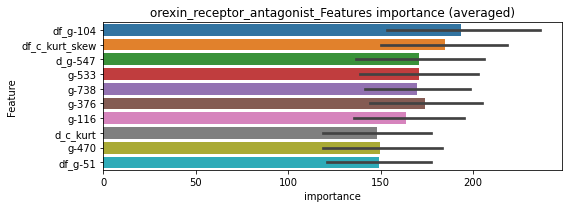

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549972	valid_1's binary_logloss: 0.0841264
[200]	training's binary_logloss: 0.0166054	valid_1's binary_logloss: 0.0436425
[300]	training's binary_logloss: 0.00524946	valid_1's binary_logloss: 0.0264071
[400]	training's binary_logloss: 0.00216162	valid_1's binary_logloss: 0.0193636
[500]	training's binary_logloss: 0.00123985	valid_1's binary_logloss: 0.0160918
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000931656	valid_1's binary_logloss: 0.0148188


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539588	valid_1's binary_logloss: 0.0859968
[200]	training's binary_logloss: 0.0157253	valid_1's binary_logloss: 0.0447741
[300]	training's binary_logloss: 0.00530842	valid_1's binary_logloss: 0.0320129
[400]	training's binary_logloss: 0.00223872	valid_1's binary_logloss: 0.02669
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00139569	valid_1's binary_logloss: 0.0242646


orexin_receptor_antagonist logloss: 0.019541120837667486


neg labels: 3289 → selected neg labels: 3281


p38_mapk_inhibitor, len(trt): 62, len(othr): 3281, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126934	valid_1's binary_logloss: 0.19881
[200]	training's binary_logloss: 0.0553537	valid_1's binary_logloss: 0.137523
[300]	training's binary_logloss: 0.0219519	valid_1's binary_logloss: 0.0961389
[400]	training's binary_logloss: 0.0100009	valid_1's binary_logloss: 0.07788
[500]	training's binary_logloss: 0.00516583	valid_1's binary_logloss: 0.0676036
[600]	training's binary_logloss: 0.00313038	valid_1's binary_logloss: 0.0620997
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00271306	valid_1's binary_logloss: 0.0612496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120392	valid_1's binary_logloss: 0.181791
[200]	training's binary_logloss: 0.0489707	valid_1's binary_logloss: 0.118651
[300]	training's binary_logloss: 0.0197475	valid_1's binary_logloss: 0.0871137
[400]	training's binary_logloss: 0.00830005	valid_1's binar

1 / 3 AUC score:0.997
y_Threshold: 0.0688626, Threshold: 0.3191124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.28720, conf_1:0.35102
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.3191124
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_2: 0.3491124
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.3791124
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_4: 0.4091124
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_5: 0.4391124
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_6: 0.4691124
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_7: 0.4991124
threshold: 0.4991124, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110498	valid_1's binary_logloss: 0.174197
[200]	training's binary_logloss: 0.0423305	valid_1's binary_logloss: 0.110347
[300]	training's binary_logloss: 0.0174758	valid_1's binary_logloss: 0.0792563
[400]	training's binary_logloss: 0.00749006	valid_1's binary_logloss: 0.0615861
[500]	training's binary_logloss: 0.00413488	valid_1's binary_logloss: 0.0540107
[600]	training's binary_logloss: 0.00270844	valid_1's binary_logloss: 0.0492122
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.00213463	valid_1's binary_logloss: 0.0469673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108385	valid_1's binary_logloss: 0.167241
[200]	training's binary_logloss: 0.0398993	valid_1's binary_logloss: 0.102792
[300]	training's binary_logloss: 0.0164016	valid_1's binary_logloss: 0.0756428
[400]	training's binary_logloss: 0.00719607	valid_1's b

2 / 3 AUC score:0.998
y_Threshold: 0.2105178, Threshold: 0.4991124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 624.0/3741
p_label_rate: 0.0105475 Vs.target_rate: 0.00260, Num_p_label: 42.0, conf_0:0.44920, conf_1:0.54902
Num_p_label: 42.0, Expected: 10.4, Adj_threshold_1: 0.4991124
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_2: 0.5291124
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_3: 0.5591124
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_4: 0.5891124
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.6191124
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_6: 0.6491124
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_7: 0.6791124
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_8: 0.7091124
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_9: 0.7391124
threshold: 0.7391124, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 624.0/3741, y_label_rate: 0.1668003
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103	valid_1's binary_logloss: 0.16085
[200]	training's binary_logloss: 0.0358105	valid_1's binary_logloss: 0.0875071
[300]	training's binary_logloss: 0.0138716	valid_1's binary_logloss: 0.0604324
[400]	training's binary_logloss: 0.00611609	valid_1's binary_logloss: 0.0471147
[500]	training's binary_logloss: 0.00346831	valid_1's binary_logloss: 0.0414134
[600]	training's binary_logloss: 0.00236149	valid_1's binary_logloss: 0.0381866
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00209039	valid_1's binary_logloss: 0.037194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106771	valid_1's binary_logloss: 0.171515
[200]	training's binary_logloss: 0.0370596	valid_1's binary_logloss: 0.10947
[300]	training's binary_logloss: 0.0140459	valid_1's binary_logloss: 0.0859049
[400]	training's binary_logloss: 0.0060989	valid_1's binary_

3 / 3 AUC score:0.995


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00413734	valid_1's binary_logloss: 0.0729642


y_Threshold: 0.1712415, Threshold: 0.7391124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 595.0/3683
p_label_rate: 0.0045203 Vs.target_rate: 0.00260, Num_p_label: 18.0, conf_0:0.66520, conf_1:0.81302
threshold: 0.7391124, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 613.0/7665, y_label_rate: 0.0799739


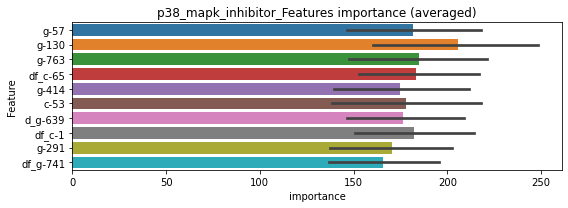

len(train_index) : 3832
len(valid_index) : 3833
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061255	valid_1's binary_logloss: 0.10219
[200]	training's binary_logloss: 0.0234231	valid_1's binary_logloss: 0.0665803
[300]	training's binary_logloss: 0.00883376	valid_1's binary_logloss: 0.0503821
[400]	training's binary_logloss: 0.00385465	valid_1's binary_logloss: 0.042573
[500]	training's binary_logloss: 0.00198265	valid_1's binary_logloss: 0.0397033
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00139079	valid_1's binary_logloss: 0.0386694


len(train_index) : 3833
len(valid_index) : 3832
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626458	valid_1's binary_logloss: 0.103558
[200]	training's binary_logloss: 0.022752	valid_1's binary_logloss: 0.0658653
[300]	training's binary_logloss: 0.00842094	valid_1's binary_logloss: 0.0488324
[400]	training's binary_logloss: 0.00382484	valid_1's binary_logloss: 0.0419568
[500]	training's binary_logloss: 0.00207464	valid_1's binary_logloss: 0.0380235
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00156477	valid_1's binary_logloss: 0.0368466


p38_mapk_inhibitor logloss: 0.03775812315872749


neg labels: 3289 → selected neg labels: 3288


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765966	valid_1's binary_logloss: 0.116161
[200]	training's binary_logloss: 0.0184141	valid_1's binary_logloss: 0.0456828
[300]	training's binary_logloss: 0.00562471	valid_1's binary_logloss: 0.0242093
[400]	training's binary_logloss: 0.00248345	valid_1's binary_logloss: 0.0170286
[500]	training's binary_logloss: 0.00158493	valid_1's binary_logloss: 0.0147726
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00156394	valid_1's binary_logloss: 0.0146857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706974	valid_1's binary_logloss: 0.103453
[200]	training's binary_logloss: 0.0191241	valid_1's binary_logloss: 0.0447363
[300]	training's binary_logloss: 0.00578875	valid_1's binary_logloss: 0.0234829
[400]	training's binary_logloss: 0.00261676	valid_1's binary_logloss: 0.0181159
[500]	training's binary_logloss: 0.00162219	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0222424, Threshold: 0.1131068, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.10180, conf_1:0.12442
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1131068
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_2: 0.1431068
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_3: 0.1731068
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_4: 0.2031068
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_5: 0.2331068
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.2631068
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.2931068
threshold: 0.2931068, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670522	valid_1's binary_logloss: 0.100382
[200]	training's binary_logloss: 0.0154989	valid_1's binary_logloss: 0.0380851
[300]	training's binary_logloss: 0.00464552	valid_1's binary_logloss: 0.0183101
[400]	training's binary_logloss: 0.00215897	valid_1's binary_logloss: 0.0123365
[500]	training's binary_logloss: 0.00141265	valid_1's binary_logloss: 0.0100899
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00118793	valid_1's binary_logloss: 0.00934697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645317	valid_1's binary_logloss: 0.0936233
[200]	training's binary_logloss: 0.0148619	valid_1's binary_logloss: 0.0335188
[300]	training's binary_logloss: 0.00455911	valid_1's binary_logloss: 0.0166281
[400]	training's binary_logloss: 0.00217339	valid_1's binary_logloss: 0.011877
[500]	training's binary_logloss: 0.00142755	vali

2 / 3 AUC score:1.000
y_Threshold: 0.1766215, Threshold: 0.2931068, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00101, Num_p_label: 32.0, conf_0:0.26380, conf_1:0.32242
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_1: 0.2931068
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.3231068
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_3: 0.3531068
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.3831068
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_5: 0.4131068
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_6: 0.4431068
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_7: 0.4731068
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_8: 0.5031068
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_9: 0.5331068
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_10: 0.5631068
threshold: 0.5631068, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682461	valid_1's binary_logloss: 0.0980685
[200]	training's binary_logloss: 0.0162393	valid_1's binary_logloss: 0.0324622
[300]	training's binary_logloss: 0.00481036	valid_1's binary_logloss: 0.0138241
[400]	training's binary_logloss: 0.00220745	valid_1's binary_logloss: 0.00830459
[500]	training's binary_logloss: 0.00142522	valid_1's binary_logloss: 0.00647442
[600]	training's binary_logloss: 0.00110405	valid_1's binary_logloss: 0.00557559
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00107378	valid_1's binary_logloss: 0.00548426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066751	valid_1's binary_logloss: 0.0958674
[200]	training's binary_logloss: 0.0146345	valid_1's binary_logloss: 0.0340295
[300]	training's binary_logloss: 0.00467587	valid_1's binary_logloss: 0.0169523
[400]	training's binary_logloss: 0.00218497	

3 / 3 AUC score:1.000
y_Threshold: 0.3130550, Threshold: 0.5631068, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.50680, conf_1:0.61942
threshold: 0.5631068, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7791, y_label_rate: 0.0848415


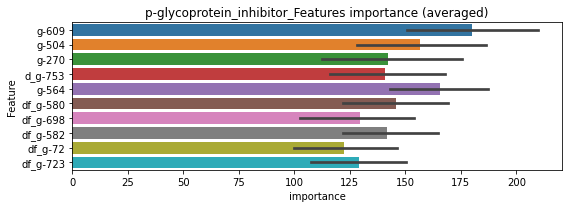

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391371	valid_1's binary_logloss: 0.0571671
[200]	training's binary_logloss: 0.0105843	valid_1's binary_logloss: 0.0240083
[300]	training's binary_logloss: 0.00320319	valid_1's binary_logloss: 0.013593
[400]	training's binary_logloss: 0.00133046	valid_1's binary_logloss: 0.00970279
[500]	training's binary_logloss: 0.000811827	valid_1's binary_logloss: 0.00847729
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000832516	valid_1's binary_logloss: 0.00844726


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418083	valid_1's binary_logloss: 0.0554248
[200]	training's binary_logloss: 0.010497	valid_1's binary_logloss: 0.0199425
[300]	training's binary_logloss: 0.00303105	valid_1's binary_logloss: 0.00874523
[400]	training's binary_logloss: 0.00133764	valid_1's binary_logloss: 0.00553995
[500]	training's binary_logloss: 0.000837791	valid_1's binary_logloss: 0.00441439
[600]	training's binary_logloss: 0.000656404	valid_1's binary_logloss: 0.00397036
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.000568917	valid_1's binary_logloss: 0.00371417


p-glycoprotein_inhibitor logloss: 0.006081018106089069


neg labels: 3289 → selected neg labels: 3281


parp_inhibitor, len(trt): 61, len(othr): 3281, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122168	valid_1's binary_logloss: 0.190959
[200]	training's binary_logloss: 0.0479005	valid_1's binary_logloss: 0.127165
[300]	training's binary_logloss: 0.018587	valid_1's binary_logloss: 0.0965789
[400]	training's binary_logloss: 0.00839272	valid_1's binary_logloss: 0.0855246
[500]	training's binary_logloss: 0.00444336	valid_1's binary_logloss: 0.0779704
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00456543	valid_1's binary_logloss: 0.0779319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115765	valid_1's binary_logloss: 0.182248
[200]	training's binary_logloss: 0.0465302	valid_1's binary_logloss: 0.118912
[300]	training's binary_logloss: 0.0195763	valid_1's binary_logloss: 0.0901323
[400]	training's binary_logloss: 0.00881249	valid_1's binary_logloss: 0.0758432
[500]	training's binary_logloss: 0.00466526	valid_1's bi

1 / 3 AUC score:0.991
y_Threshold: 0.0518318, Threshold: 0.2023443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 170 → Positive_corect_labels: 637/3767
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.18211, conf_1:0.22258
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.2023443
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.2323443
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_3: 0.2623443
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_4: 0.2923443
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_5: 0.3223443
threshold: 0.3223443, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 637.0/3767, y_label_rate: 0.1691001
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104673	valid_1's binary_logloss: 0.179692
[200]	training's binary_logloss: 0.0391348	valid_1's binary_logloss: 0.116415
[300]	training's binary_logloss: 0.0150034	valid_1's binary_logloss: 0.0879432
[400]	training's binary_logloss: 0.00677716	valid_1's binary_logloss: 0.0749176
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00423531	valid_1's binary_logloss: 0.0701515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109229	valid_1's binary_logloss: 0.178167
[200]	training's binary_logloss: 0.0412664	valid_1's binary_logloss: 0.114389
[300]	training's binary_logloss: 0.0155982	valid_1's binary_logloss: 0.0819166
[400]	training's binary_logloss: 0.00693085	valid_1's binary_logloss: 0.067101
[500]	training's binary_logloss: 0.00379629	valid_1's binary_logloss: 0.0612913
Early stopping, best iteration is:
[510]	training's bina

2 / 3 AUC score:0.996
y_Threshold: 0.1486849, Threshold: 0.3223443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 605.0/3703
p_label_rate: 0.0198393 Vs.target_rate: 0.00256, Num_p_label: 79.0, conf_0:0.29011, conf_1:0.35458
Num_p_label: 79.0, Expected: 10.2, Adj_threshold_1: 0.3223443
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_2: 0.3523443
Num_p_label: 60.0, Expected: 10.2, Adj_threshold_3: 0.3823443
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_4: 0.4123443
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_5: 0.4423443
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_6: 0.4723443
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_7: 0.5023443
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_8: 0.5323443
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_9: 0.5623443
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_10: 0.5923443
threshold: 0.6223443, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 605.0/3703, y_label_rate: 0.16338

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897425	valid_1's binary_logloss: 0.168273
[200]	training's binary_logloss: 0.0305667	valid_1's binary_logloss: 0.111093
[300]	training's binary_logloss: 0.0115986	valid_1's binary_logloss: 0.0904173
[400]	training's binary_logloss: 0.0053712	valid_1's binary_logloss: 0.0811603
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00458165	valid_1's binary_logloss: 0.0799856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09615	valid_1's binary_logloss: 0.167642
[200]	training's binary_logloss: 0.0332288	valid_1's binary_logloss: 0.101013
[300]	training's binary_logloss: 0.012829	valid_1's binary_logloss: 0.0744496
[400]	training's binary_logloss: 0.00567807	valid_1's binary_logloss: 0.0602867
[500]	training's binary_logloss: 0.00323346	valid_1's binary_logloss: 0.0548792
Early stopping, best iteration is:
[553]	training's binar

3 / 3 AUC score:0.993
y_Threshold: 0.1162637, Threshold: 0.6223443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 578.0/3649
p_label_rate: 0.0060271 Vs.target_rate: 0.00256, Num_p_label: 24.0, conf_0:0.56011, conf_1:0.68458
threshold: 0.6223443, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 602.0/7631, y_label_rate: 0.0788887


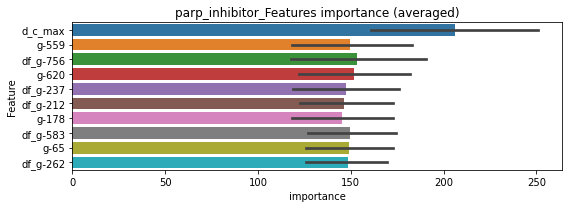

len(train_index) : 3815
len(valid_index) : 3816
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561879	valid_1's binary_logloss: 0.0980195
[200]	training's binary_logloss: 0.019329	valid_1's binary_logloss: 0.0647901
[300]	training's binary_logloss: 0.00731039	valid_1's binary_logloss: 0.0528941
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00405774	valid_1's binary_logloss: 0.0495918


len(train_index) : 3816
len(valid_index) : 3815
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543821	valid_1's binary_logloss: 0.0928185
[200]	training's binary_logloss: 0.0184287	valid_1's binary_logloss: 0.0563799
[300]	training's binary_logloss: 0.00684342	valid_1's binary_logloss: 0.0410995
[400]	training's binary_logloss: 0.00313471	valid_1's binary_logloss: 0.0348756
[500]	training's binary_logloss: 0.00179364	valid_1's binary_logloss: 0.0315612
[600]	training's binary_logloss: 0.00126137	valid_1's binary_logloss: 0.0300159
[700]	training's binary_logloss: 0.000997194	valid_1's binary_logloss: 0.0292073
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000997194	valid_1's binary_logloss: 0.0292073


parp_inhibitor logloss: 0.03940088234815352


neg labels: 3289 → selected neg labels: 3245


pdgfr_inhibitor, len(trt): 297, len(othr): 3245, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219942	valid_1's binary_logloss: 0.378732
[200]	training's binary_logloss: 0.124224	valid_1's binary_logloss: 0.359491
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.110744	valid_1's binary_logloss: 0.357481
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.775
y_Threshold: 0.1926881, Threshold: 0.5897321, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 692 → Positive_corect_labels: 368/3202
p_label_rate: 0.0100452 Vs.target_rate: 0.01247, Num_p_label: 40.0, conf_0:0.53076, conf_1:0.64871
threshold: 0.5897321, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


[100]	training's binary_logloss: 0.221722	valid_1's binary_logloss: 0.383185
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.191372	valid_1's binary_logloss: 0.373676


positive_y_label: 368.0/3202, y_label_rate: 0.1149282
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109856	valid_1's binary_logloss: 0.227227
[200]	training's binary_logloss: 0.0466777	valid_1's binary_logloss: 0.189443
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0337736	valid_1's binary_logloss: 0.184077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111086	valid_1's binary_logloss: 0.237946


2 / 3 AUC score:0.919
y_Threshold: 0.1650540, Threshold: 0.5897321, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 232 → Positive_corect_labels: 252.0/2970
p_label_rate: 0.0213461 Vs.target_rate: 0.01247, Num_p_label: 85.0, conf_0:0.53076, conf_1:0.64871
threshold: 0.5897321, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 252.0/2970, y_label_rate: 0.0848485
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0564399	valid_1's binary_logloss: 0.21684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06046	valid_1's binary_logloss: 0.158597
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0245741	valid_1's binary_logloss: 0.142288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631935	valid_1's binary_logloss: 0.143005


3 / 3 AUC score:0.949
y_Threshold: 0.1534744, Threshold: 0.5897321, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 191.0/2848
p_label_rate: 0.0308890 Vs.target_rate: 0.01247, Num_p_label: 123.0, conf_0:0.53076, conf_1:0.64871
threshold: 0.5897321, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 314.0/6830, y_label_rate: 0.0459736


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0269943	valid_1's binary_logloss: 0.121854


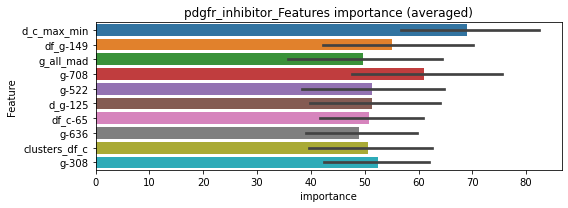

len(train_index) : 3415
len(valid_index) : 3415
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298073	valid_1's binary_logloss: 0.0760614


len(train_index) : 3415
len(valid_index) : 3415
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0122265	valid_1's binary_logloss: 0.0678133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281081	valid_1's binary_logloss: 0.0747483


pdgfr_inhibitor logloss: 0.06677085525774594


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0146038	valid_1's binary_logloss: 0.0657284
neg labels: 3289 → selected neg labels: 3284


pdk_inhibitor, len(trt): 18, len(othr): 3284, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601493	valid_1's binary_logloss: 0.0861895
[200]	training's binary_logloss: 0.0119352	valid_1's binary_logloss: 0.0309844
[300]	training's binary_logloss: 0.00346176	valid_1's binary_logloss: 0.016484
[400]	training's binary_logloss: 0.00163738	valid_1's binary_logloss: 0.0121581
[500]	training's binary_logloss: 0.00110505	valid_1's binary_logloss: 0.0103924
[600]	training's binary_logloss: 0.000898636	valid_1's binary_logloss: 0.00970452
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.000820458	valid_1's binary_logloss: 0.00943923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557031	valid_1's binary_logloss: 0.0823284
[200]	training's binary_logloss: 0.0126754	valid_1's binary_logloss: 0.0315667
[300]	training's binary_logloss: 0.0034966	valid_1's binary_logloss: 0.0169138


1 / 3 AUC score:1.000
y_Threshold: 0.0172852, Threshold: 0.0975641, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.00163733	valid_1's binary_logloss: 0.0129975
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00148385	valid_1's binary_logloss: 0.0123621


Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.08781, conf_1:0.10732
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0975641
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.1275641
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.1575641
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.1875641
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.2175641
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.2475641
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.2775641
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.3075641
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.3375641
threshold: 0.3375641, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511122	valid_1's binary_logloss: 0.0740461
[200]	training's binary_logloss: 0.009174	valid_1's binary_logloss: 0.0235362
[300]	training's binary_logloss: 0.00280343	valid_1's binary_logloss: 0.0116077
[400]	training's binary_logloss: 0.0014322	valid_1's binary_logloss: 0.00781828
[500]	training's binary_logloss: 0.000998426	valid_1's binary_logloss: 0.00634973
[600]	training's binary_logloss: 0.000822164	valid_1's binary_logloss: 0.00576952
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.0007843	valid_1's binary_logloss: 0.00560586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506389	valid_1's binary_logloss: 0.0686765
[200]	training's binary_logloss: 0.00951972	valid_1's binary_logloss: 0.0208306
[300]	training's binary_logloss: 0.00281936	valid_1's binary_logloss: 0.0106041
[400]	training's binary_logloss: 0.00144502

2 / 3 AUC score:1.000
y_Threshold: 0.2113630, Threshold: 0.3375641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.30381, conf_1:0.37132
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.3375641
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.3675641
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.3975641
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.4275641
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.4575641
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.4875641
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.5175641
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.5475641
threshold: 0.5475641, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518589	valid_1's binary_logloss: 0.076771
[200]	training's binary_logloss: 0.00980358	valid_1's binary_logloss: 0.0261296
[300]	training's binary_logloss: 0.00295264	valid_1's binary_logloss: 0.0133809
[400]	training's binary_logloss: 0.00147051	valid_1's binary_logloss: 0.00923934
[500]	training's binary_logloss: 0.000993286	valid_1's binary_logloss: 0.00766655
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000903824	valid_1's binary_logloss: 0.00743354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499895	valid_1's binary_logloss: 0.0700314
[200]	training's binary_logloss: 0.00931106	valid_1's binary_logloss: 0.0210395
[300]	training's binary_logloss: 0.00276815	valid_1's binary_logloss: 0.0105757
[400]	training's binary_logloss: 0.0014125	valid_1's binary_logloss: 0.00763806
[500]	training's binary_logloss: 0.000982

3 / 3 AUC score:1.000
y_Threshold: 0.1876606, Threshold: 0.5475641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.49281, conf_1:0.60232
threshold: 0.5475641, positive_p_label: 8.0/3982, p_label_rate: 0.0020090


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000849702	valid_1's binary_logloss: 0.00617293


positive_y_label: 661.0/7784, y_label_rate: 0.0849178


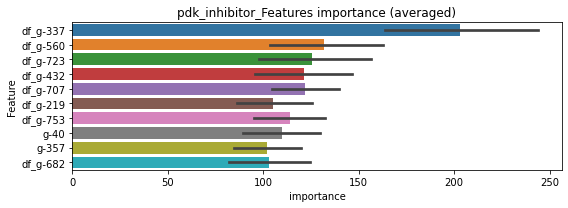

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349698	valid_1's binary_logloss: 0.0452113
[200]	training's binary_logloss: 0.00692689	valid_1's binary_logloss: 0.0147464
[300]	training's binary_logloss: 0.00184985	valid_1's binary_logloss: 0.00786764
[400]	training's binary_logloss: 0.000871084	valid_1's binary_logloss: 0.00620938
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000717353	valid_1's binary_logloss: 0.00598725


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309196	valid_1's binary_logloss: 0.0435629
[200]	training's binary_logloss: 0.00614463	valid_1's binary_logloss: 0.0148883
[300]	training's binary_logloss: 0.00175127	valid_1's binary_logloss: 0.00748116
[400]	training's binary_logloss: 0.000870713	valid_1's binary_logloss: 0.00544698
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000618234	valid_1's binary_logloss: 0.00471035


pdk_inhibitor logloss: 0.005348798733925097


neg labels: 3289 → selected neg labels: 3248


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3248, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185194	valid_1's binary_logloss: 0.34702
[200]	training's binary_logloss: 0.105112	valid_1's binary_logloss: 0.326428
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.082599	valid_1's binary_logloss: 0.323402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203998	valid_1's binary_logloss: 0.338238
[200]	training's binary_logloss: 0.118282	valid_1's binary_logloss: 0.314863


1 / 3 AUC score:0.826
y_Threshold: 0.1518261, Threshold: 0.3350280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 567 → Positive_corect_labels: 431/3330
p_label_rate: 0.0100452 Vs.target_rate: 0.01109, Num_p_label: 40.0, conf_0:0.30153, conf_1:0.36853
threshold: 0.3350280, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0887278	valid_1's binary_logloss: 0.308936


positive_y_label: 431.0/3330, y_label_rate: 0.1294294
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114854	valid_1's binary_logloss: 0.210943
[200]	training's binary_logloss: 0.0494679	valid_1's binary_logloss: 0.172546
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0365074	valid_1's binary_logloss: 0.164117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119963	valid_1's binary_logloss: 0.209316
[200]	training's binary_logloss: 0.0492573	valid_1's binary_logloss: 0.168614


2 / 3 AUC score:0.957
y_Threshold: 0.1605546, Threshold: 0.3350280, pos_neg_ratio: 0.8000000


[300]	training's binary_logloss: 0.0238184	valid_1's binary_logloss: 0.155382
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0205987	valid_1's binary_logloss: 0.153536


Remove_noisy_labels: 162 → Positive_corect_labels: 350.0/3168
p_label_rate: 0.0261175 Vs.target_rate: 0.01109, Num_p_label: 104.0, conf_0:0.30153, conf_1:0.36853
threshold: 0.3350280, positive_p_label: 104.0/3982, p_label_rate: 0.0261175
positive_y_label: 350.0/3168, y_label_rate: 0.1104798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846631	valid_1's binary_logloss: 0.181557
[200]	training's binary_logloss: 0.0319028	valid_1's binary_logloss: 0.152002
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0216825	valid_1's binary_logloss: 0.143637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842691	valid_1's binary_logloss: 0.162754
[200]	training's binary_logloss: 0.0316561	valid_1's binary_logloss: 0.125029


3 / 3 AUC score:0.973
y_Threshold: 0.1514825, Threshold: 0.3350280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 114 → Positive_corect_labels: 293.0/3054
p_label_rate: 0.0356605 Vs.target_rate: 0.01109, Num_p_label: 142.0, conf_0:0.30153, conf_1:0.36853
Num_p_label: 142.0, Expected: 44.1, Adj_threshold_1: 0.3350280
Num_p_label: 124.0, Expected: 44.1, Adj_threshold_2: 0.3650280
Num_p_label: 107.0, Expected: 44.1, Adj_threshold_3: 0.3950280
Num_p_label: 90.0, Expected: 44.1, Adj_threshold_4: 0.4250280
Num_p_label: 71.0, Expected: 44.1, Adj_threshold_5: 0.4550280
threshold: 0.4550280, positive_p_label: 71.0/3982, p_label_rate: 0.0178302


[300]	training's binary_logloss: 0.0129746	valid_1's binary_logloss: 0.110387
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0126203	valid_1's binary_logloss: 0.110243


positive_y_label: 364.0/7036, y_label_rate: 0.0517339


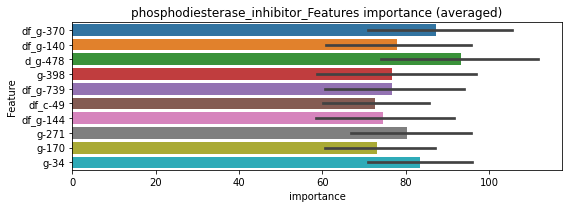

len(train_index) : 3518
len(valid_index) : 3518
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428143	valid_1's binary_logloss: 0.0871154


len(train_index) : 3518
len(valid_index) : 3518
================================= fold 2/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.0162781	valid_1's binary_logloss: 0.0732217
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0170587	valid_1's binary_logloss: 0.0731131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460786	valid_1's binary_logloss: 0.0922739
[200]	training's binary_logloss: 0.0168005	valid_1's binary_logloss: 0.0768911
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0126091	valid_1's binary_logloss: 0.075086


phosphodiesterase_inhibitor logloss: 0.0740995200253442


neg labels: 3289 → selected neg labels: 3286


phospholipase_inhibitor, len(trt): 25, len(othr): 3286, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071512	valid_1's binary_logloss: 0.104139
[200]	training's binary_logloss: 0.0212715	valid_1's binary_logloss: 0.0503669
[300]	training's binary_logloss: 0.00665432	valid_1's binary_logloss: 0.0301384
[400]	training's binary_logloss: 0.0029145	valid_1's binary_logloss: 0.0231069
[500]	training's binary_logloss: 0.00177367	valid_1's binary_logloss: 0.0208459
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00182118	valid_1's binary_logloss: 0.0207769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715142	valid_1's binary_logloss: 0.0985808
[200]	training's binary_logloss: 0.0198342	valid_1's binary_logloss: 0.0420255
[300]	training's binary_logloss: 0.00638153	valid_1's binary_logloss: 0.0229678
[400]	training's binary_logloss: 0.00281598	valid_1's binary_logloss: 0.0166823
[500]	training's binary_logloss: 0.00174311	valid_

1 / 3 AUC score:0.999
y_Threshold: 0.0217591, Threshold: 0.1719917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.15479, conf_1:0.18919
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.1719917
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_2: 0.2019917
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_3: 0.2319917
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_4: 0.2619917
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_5: 0.2919917
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_6: 0.3219917
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_7: 0.3519917
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_8: 0.3819917
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_9: 0.4119917
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.4419917
threshold: 0.4719917, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639475	valid_1's binary_logloss: 0.0883913
[200]	training's binary_logloss: 0.0153288	valid_1's binary_logloss: 0.0362565
[300]	training's binary_logloss: 0.00498083	valid_1's binary_logloss: 0.019946
[400]	training's binary_logloss: 0.00235617	valid_1's binary_logloss: 0.0144657
[500]	training's binary_logloss: 0.00150962	valid_1's binary_logloss: 0.0122756
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00136041	valid_1's binary_logloss: 0.0117834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637278	valid_1's binary_logloss: 0.0915477
[200]	training's binary_logloss: 0.0172622	valid_1's binary_logloss: 0.0338892
[300]	training's binary_logloss: 0.00545911	valid_1's binary_logloss: 0.0159495
[400]	training's binary_logloss: 0.00240649	valid_1's binary_logloss: 0.00994879
[500]	training's binary_logloss: 0.0015715	vali

2 / 3 AUC score:1.000
y_Threshold: 0.2117079, Threshold: 0.4719917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0057760 Vs.target_rate: 0.00105, Num_p_label: 23.0, conf_0:0.42479, conf_1:0.51919
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_1: 0.4719917
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_2: 0.5019917
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.5319917
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.5619917
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.5919917
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.6219917
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_7: 0.6519917
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_8: 0.6819917
threshold: 0.6819917, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609352	valid_1's binary_logloss: 0.0854295
[200]	training's binary_logloss: 0.0148568	valid_1's binary_logloss: 0.0335561
[300]	training's binary_logloss: 0.00468936	valid_1's binary_logloss: 0.0171828
[400]	training's binary_logloss: 0.00223415	valid_1's binary_logloss: 0.0120186
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00161031	valid_1's binary_logloss: 0.0105573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643628	valid_1's binary_logloss: 0.0882651
[200]	training's binary_logloss: 0.0161512	valid_1's binary_logloss: 0.0336403
[300]	training's binary_logloss: 0.0051329	valid_1's binary_logloss: 0.0178206
[400]	training's binary_logloss: 0.00240783	valid_1's binary_logloss: 0.0128414
[500]	training's binary_logloss: 0.00158918	valid_1's binary_logloss: 0.0110511
[600]	training's binary_logloss: 0.00122547	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1894030, Threshold: 0.6819917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3799
p_label_rate: 0.0022602 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.61379, conf_1:0.75019
threshold: 0.6819917, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 660.0/7781, y_label_rate: 0.0848220


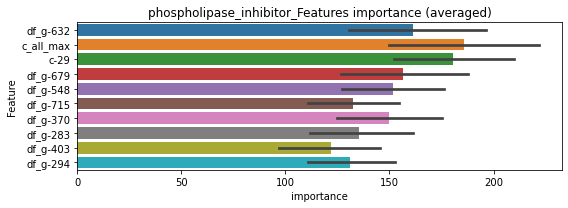

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387577	valid_1's binary_logloss: 0.058331
[200]	training's binary_logloss: 0.0104374	valid_1's binary_logloss: 0.0260579
[300]	training's binary_logloss: 0.00332401	valid_1's binary_logloss: 0.0145016
[400]	training's binary_logloss: 0.00146382	valid_1's binary_logloss: 0.0107927
[500]	training's binary_logloss: 0.000918287	valid_1's binary_logloss: 0.00951186
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000918287	valid_1's binary_logloss: 0.00951186


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384097	valid_1's binary_logloss: 0.0623039
[200]	training's binary_logloss: 0.0109053	valid_1's binary_logloss: 0.0291179
[300]	training's binary_logloss: 0.00340949	valid_1's binary_logloss: 0.0170354
[400]	training's binary_logloss: 0.00145638	valid_1's binary_logloss: 0.0118424
[500]	training's binary_logloss: 0.00090541	valid_1's binary_logloss: 0.0102113
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000833875	valid_1's binary_logloss: 0.0100137


phospholipase_inhibitor logloss: 0.009762739094882667


neg labels: 3289 → selected neg labels: 3262


pi3k_inhibitor, len(trt): 151, len(othr): 3262, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174177	valid_1's binary_logloss: 0.290447
[200]	training's binary_logloss: 0.090946	valid_1's binary_logloss: 0.243012
[300]	training's binary_logloss: 0.0462975	valid_1's binary_logloss: 0.21947
[400]	training's binary_logloss: 0.0253043	valid_1's binary_logloss: 0.21149
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0247881	valid_1's binary_logloss: 0.211382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179496	valid_1's binary_logloss: 0.297329
[200]	training's binary_logloss: 0.0947854	valid_1's binary_logloss: 0.252332
[300]	training's binary_logloss: 0.0456298	valid_1's binary_logloss: 0.224749
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0406546	valid_1's binary_logloss: 0.22268


1 / 3 AUC score:0.924
y_Threshold: 0.1324412, Threshold: 0.3284468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 365 → Positive_corect_labels: 535/3549
p_label_rate: 0.0100452 Vs.target_rate: 0.00634, Num_p_label: 40.0, conf_0:0.29560, conf_1:0.36129
threshold: 0.3284468, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 535.0/3549, y_label_rate: 0.1507467
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118164	valid_1's binary_logloss: 0.218045
[200]	training's binary_logloss: 0.0504663	valid_1's binary_logloss: 0.165703
[300]	training's binary_logloss: 0.0221639	valid_1's binary_logloss: 0.143212
[400]	training's binary_logloss: 0.0104941	valid_1's binary_logloss: 0.132907
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00768315	valid_1's binary_logloss: 0.129602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138449	valid_1's binary_logloss: 0.218959
[200]	training's binary_logloss: 0.0586506	valid_1's binary_logloss: 0.155695
[300]	training's binary_logloss: 0.0281199	valid_1's binary_logloss: 0.129961
[400]	training's binary_logloss: 0.0136311	valid_1's binary_logloss: 0.114158
[500]	training's binary_logloss: 0.00708913	valid_1's binary_logloss: 0.105593
Early stopping, best iteration is:
[567]	training's binary_logl

2 / 3 AUC score:0.987
y_Threshold: 0.1541262, Threshold: 0.3284468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 128 → Positive_corect_labels: 471.0/3421
p_label_rate: 0.0153189 Vs.target_rate: 0.00634, Num_p_label: 61.0, conf_0:0.29560, conf_1:0.36129
threshold: 0.3284468, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 471.0/3421, y_label_rate: 0.1376790
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108387	valid_1's binary_logloss: 0.197932
[200]	training's binary_logloss: 0.0398129	valid_1's binary_logloss: 0.143682
[300]	training's binary_logloss: 0.0163187	valid_1's binary_logloss: 0.124756
[400]	training's binary_logloss: 0.00768884	valid_1's binary_logloss: 0.117827
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00778212	valid_1's binary_logloss: 0.117826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10476	valid_1's binary_logloss: 0.183756
[200]	training's binary_logloss: 0.0384932	valid_1's binary_logloss: 0.126994
[300]	training's binary_logloss: 0.0158495	valid_1's binary_logloss: 0.104435
[400]	training's binary_logloss: 0.00748827	valid_1's binary_logloss: 0.0948672
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00538537	valid_1's binary_logloss: 0.0919448


3 / 3 AUC score:0.986
y_Threshold: 0.1228854, Threshold: 0.3284468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 423.0/3325
p_label_rate: 0.0160723 Vs.target_rate: 0.00634, Num_p_label: 64.0, conf_0:0.29560, conf_1:0.36129
threshold: 0.3284468, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 487.0/7307, y_label_rate: 0.0666484


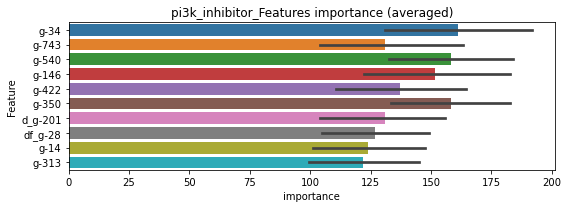

len(train_index) : 3653
len(valid_index) : 3654
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581298	valid_1's binary_logloss: 0.104121
[200]	training's binary_logloss: 0.0221596	valid_1's binary_logloss: 0.0742133
[300]	training's binary_logloss: 0.00896314	valid_1's binary_logloss: 0.063303
[400]	training's binary_logloss: 0.0041653	valid_1's binary_logloss: 0.0599623
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00403391	valid_1's binary_logloss: 0.0597652


len(train_index) : 3654
len(valid_index) : 3653
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606174	valid_1's binary_logloss: 0.114161
[200]	training's binary_logloss: 0.0224426	valid_1's binary_logloss: 0.0868286
[300]	training's binary_logloss: 0.00902072	valid_1's binary_logloss: 0.0770526


pi3k_inhibitor logloss: 0.06699165866042953


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00549181	valid_1's binary_logloss: 0.0742201
neg labels: 3289 → selected neg labels: 3286


pkc_inhibitor, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920552	valid_1's binary_logloss: 0.140455
[200]	training's binary_logloss: 0.0268526	valid_1's binary_logloss: 0.0657532
[300]	training's binary_logloss: 0.00847868	valid_1's binary_logloss: 0.0361332
[400]	training's binary_logloss: 0.00365327	valid_1's binary_logloss: 0.0244122
[500]	training's binary_logloss: 0.00219169	valid_1's binary_logloss: 0.02019
[600]	training's binary_logloss: 0.00161608	valid_1's binary_logloss: 0.0181721
[700]	training's binary_logloss: 0.00135792	valid_1's binary_logloss: 0.0172141
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.00134716	valid_1's binary_logloss: 0.0171844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837553	valid_1's binary_logloss: 0.127096
[200]	training's binary_logloss: 0.0229474	valid_1's binary_logloss: 0.0552835
[300]	training's binary_logloss: 0.008032	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0254706, Threshold: 0.1198572, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.10787, conf_1:0.13184
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1198572
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_2: 0.1498572
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_3: 0.1798572
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_4: 0.2098572
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.2398572
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_6: 0.2698572
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_7: 0.2998572
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_8: 0.3298572
threshold: 0.3298572, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797776	valid_1's binary_logloss: 0.126324
[200]	training's binary_logloss: 0.0209168	valid_1's binary_logloss: 0.0520652
[300]	training's binary_logloss: 0.00671175	valid_1's binary_logloss: 0.026138
[400]	training's binary_logloss: 0.00307767	valid_1's binary_logloss: 0.0169074
[500]	training's binary_logloss: 0.00191477	valid_1's binary_logloss: 0.0132074
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00156131	valid_1's binary_logloss: 0.0118736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764109	valid_1's binary_logloss: 0.114595
[200]	training's binary_logloss: 0.020617	valid_1's binary_logloss: 0.0465682
[300]	training's binary_logloss: 0.00666163	valid_1's binary_logloss: 0.0246852
[400]	training's binary_logloss: 0.00307085	valid_1's binary_logloss: 0.0171511
[500]	training's binary_logloss: 0.00192836	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.2299003, Threshold: 0.3298572, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0067805 Vs.target_rate: 0.00130, Num_p_label: 27.0, conf_0:0.29687, conf_1:0.36284
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_1: 0.3298572
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_2: 0.3598572
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_3: 0.3898572
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_4: 0.4198572
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_5: 0.4498572
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_6: 0.4798572
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_7: 0.5098572
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.5398572
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_9: 0.5698572
threshold: 0.5698572, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/3803, y_label_rate: 0.1717065
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790803	valid_1's binary_logloss: 0.120279
[200]	training's binary_logloss: 0.0204276	valid_1's binary_logloss: 0.0492889
[300]	training's binary_logloss: 0.00675313	valid_1's binary_logloss: 0.0259647
[400]	training's binary_logloss: 0.00305966	valid_1's binary_logloss: 0.0174695
[500]	training's binary_logloss: 0.00188398	valid_1's binary_logloss: 0.0146783
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00163913	valid_1's binary_logloss: 0.0141455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800629	valid_1's binary_logloss: 0.115471
[200]	training's binary_logloss: 0.0206021	valid_1's binary_logloss: 0.0448422
[300]	training's binary_logloss: 0.00662771	valid_1's binary_logloss: 0.0223431
[400]	training's binary_logloss: 0.00304343	valid_1's binary_logloss: 0.0147558
[500]	training's binary_logloss: 0.00189202	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1454012, Threshold: 0.5698572, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0022602 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.51287, conf_1:0.62684
threshold: 0.5698572, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 662.0/7785, y_label_rate: 0.0850353


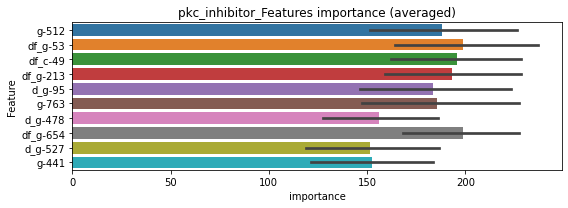

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484635	valid_1's binary_logloss: 0.0725096
[200]	training's binary_logloss: 0.0128966	valid_1's binary_logloss: 0.0324439
[300]	training's binary_logloss: 0.00414686	valid_1's binary_logloss: 0.0192084
[400]	training's binary_logloss: 0.00175615	valid_1's binary_logloss: 0.014638
[500]	training's binary_logloss: 0.00106115	valid_1's binary_logloss: 0.0132646
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000994628	valid_1's binary_logloss: 0.0131913


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046696	valid_1's binary_logloss: 0.0818341
[200]	training's binary_logloss: 0.0116795	valid_1's binary_logloss: 0.04103
[300]	training's binary_logloss: 0.0038472	valid_1's binary_logloss: 0.0274872
[400]	training's binary_logloss: 0.00168587	valid_1's binary_logloss: 0.0218973
[500]	training's binary_logloss: 0.00104218	valid_1's binary_logloss: 0.0199126
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.0010275	valid_1's binary_logloss: 0.0198364


pkc_inhibitor logloss: 0.016513416812020707


neg labels: 3289 → selected neg labels: 3281


potassium_channel_activator, len(trt): 55, len(othr): 3281, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109843	valid_1's binary_logloss: 0.170782
[200]	training's binary_logloss: 0.0413359	valid_1's binary_logloss: 0.109953
[300]	training's binary_logloss: 0.0169036	valid_1's binary_logloss: 0.0828481
[400]	training's binary_logloss: 0.00745559	valid_1's binary_logloss: 0.069294
[500]	training's binary_logloss: 0.00398283	valid_1's binary_logloss: 0.0636588
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00385814	valid_1's binary_logloss: 0.0633133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104875	valid_1's binary_logloss: 0.166949
[200]	training's binary_logloss: 0.0438424	valid_1's binary_logloss: 0.109254
[300]	training's binary_logloss: 0.0170901	valid_1's binary_logloss: 0.081782
[400]	training's binary_logloss: 0.00814944	valid_1's binary_logloss: 0.0684559
[500]	training's binary_logloss: 0.00425353	valid_1's bin

1 / 3 AUC score:0.995
y_Threshold: 0.0461272, Threshold: 0.1846769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 640/3773
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.16621, conf_1:0.20314
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.1846769
Num_p_label: 34.0, Expected: 9.2, Adj_threshold_2: 0.2146769
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_3: 0.2446769
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_4: 0.2746769
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_5: 0.3046769
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_6: 0.3346769
threshold: 0.3346769, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928735	valid_1's binary_logloss: 0.150922
[200]	training's binary_logloss: 0.0372795	valid_1's binary_logloss: 0.0955994
[300]	training's binary_logloss: 0.0138403	valid_1's binary_logloss: 0.0666933
[400]	training's binary_logloss: 0.00641073	valid_1's binary_logloss: 0.0564215
[500]	training's binary_logloss: 0.00351544	valid_1's binary_logloss: 0.0511761
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00291926	valid_1's binary_logloss: 0.0496834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954255	valid_1's binary_logloss: 0.135104
[200]	training's binary_logloss: 0.0350942	valid_1's binary_logloss: 0.0730963
[300]	training's binary_logloss: 0.0150206	valid_1's binary_logloss: 0.0473532
[400]	training's binary_logloss: 0.00672802	valid_1's binary_logloss: 0.033521
[500]	training's binary_logloss: 0.0036745	valid_1's

2 / 3 AUC score:0.999
y_Threshold: 0.1377432, Threshold: 0.3346769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 620.0/3733
p_label_rate: 0.0087896 Vs.target_rate: 0.00231, Num_p_label: 35.0, conf_0:0.30121, conf_1:0.36814
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_1: 0.3346769
Num_p_label: 33.0, Expected: 9.2, Adj_threshold_2: 0.3646769
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_3: 0.3946769
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_4: 0.4246769
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_5: 0.4546769
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_6: 0.4846769
threshold: 0.4846769, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 620.0/3733, y_label_rate: 0.1660863
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853408	valid_1's binary_logloss: 0.132331
[200]	training's binary_logloss: 0.0294893	valid_1's binary_logloss: 0.0757053
[300]	training's binary_logloss: 0.011105	valid_1's binary_logloss: 0.0513388
[400]	training's binary_logloss: 0.00511911	valid_1's binary_logloss: 0.040162
[500]	training's binary_logloss: 0.00295954	valid_1's binary_logloss: 0.0346667
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00237853	valid_1's binary_logloss: 0.0337642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913802	valid_1's binary_logloss: 0.138968
[200]	training's binary_logloss: 0.0354177	valid_1's binary_logloss: 0.0743745
[300]	training's binary_logloss: 0.0140225	valid_1's binary_logloss: 0.0475414
[400]	training's binary_logloss: 0.00593989	valid_1's binary_logloss: 0.033541
[500]	training's binary_logloss: 0.00333515	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1622161, Threshold: 0.4846769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 611.0/3715
p_label_rate: 0.0077850 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.43621, conf_1:0.53314
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.4846769
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_2: 0.5146769
Num_p_label: 23.0, Expected: 9.2, Adj_threshold_3: 0.5446769
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_4: 0.5746769
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_5: 0.6046769
threshold: 0.6046769, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 626.0/7697, y_label_rate: 0.0813304


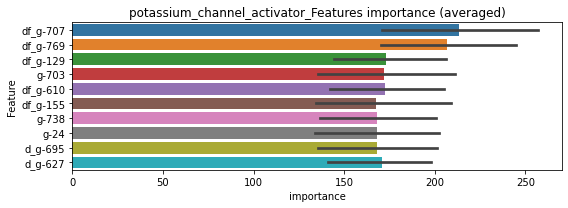

len(train_index) : 3848
len(valid_index) : 3849
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501827	valid_1's binary_logloss: 0.0892479
[200]	training's binary_logloss: 0.0193238	valid_1's binary_logloss: 0.056819
[300]	training's binary_logloss: 0.00737191	valid_1's binary_logloss: 0.0428984
[400]	training's binary_logloss: 0.00311471	valid_1's binary_logloss: 0.0357345
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00192173	valid_1's binary_logloss: 0.0324183


len(train_index) : 3849
len(valid_index) : 3848
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570905	valid_1's binary_logloss: 0.0852162
[200]	training's binary_logloss: 0.0210543	valid_1's binary_logloss: 0.053337
[300]	training's binary_logloss: 0.00811169	valid_1's binary_logloss: 0.0379316
[400]	training's binary_logloss: 0.00360286	valid_1's binary_logloss: 0.0313563
[500]	training's binary_logloss: 0.00195014	valid_1's binary_logloss: 0.0274312
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00140016	valid_1's binary_logloss: 0.0264392


potassium_channel_activator logloss: 0.02942914980280147


neg labels: 3289 → selected neg labels: 3278


potassium_channel_antagonist, len(trt): 98, len(othr): 3278, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154779	valid_1's binary_logloss: 0.246173
[200]	training's binary_logloss: 0.0652239	valid_1's binary_logloss: 0.180799
[300]	training's binary_logloss: 0.0298171	valid_1's binary_logloss: 0.151825
[400]	training's binary_logloss: 0.0146396	valid_1's binary_logloss: 0.136761
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00920466	valid_1's binary_logloss: 0.131219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151179	valid_1's binary_logloss: 0.247067
[200]	training's binary_logloss: 0.0664845	valid_1's binary_logloss: 0.182459
[300]	training's binary_logloss: 0.0308505	valid_1's binary_logloss: 0.152162
[400]	training's binary_logloss: 0.013704	valid_1's binary_logloss: 0.137612
[500]	training's binary_logloss: 0.0074217	valid_1's binary_logloss: 0.128738
[600]	training's binary_logloss: 0.00439403	valid_1's binary_logl

1 / 3 AUC score:0.976
y_Threshold: 0.0686396, Threshold: 0.2559394, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 238 → Positive_corect_labels: 602/3695
p_label_rate: 0.0100452 Vs.target_rate: 0.00412, Num_p_label: 40.0, conf_0:0.23035, conf_1:0.28153
threshold: 0.2559394, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 602.0/3695, y_label_rate: 0.1629229
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125397	valid_1's binary_logloss: 0.208113
[200]	training's binary_logloss: 0.0481024	valid_1's binary_logloss: 0.13943
[300]	training's binary_logloss: 0.0192688	valid_1's binary_logloss: 0.107627
[400]	training's binary_logloss: 0.00885059	valid_1's binary_logloss: 0.0933985
[500]	training's binary_logloss: 0.00483552	valid_1's binary_logloss: 0.0860342
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.0044006	valid_1's binary_logloss: 0.0849782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144992	valid_1's binary_logloss: 0.207913
[200]	training's binary_logloss: 0.0602728	valid_1's binary_logloss: 0.134749
[300]	training's binary_logloss: 0.0238488	valid_1's binary_logloss: 0.0987516
[400]	training's binary_logloss: 0.0105654	valid_1's binary_logloss: 0.0806169
Early stopping, best iteration is:
[461]	training's binary_

2 / 3 AUC score:0.992
y_Threshold: 0.1600292, Threshold: 0.2559394, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 566.0/3623
p_label_rate: 0.0236062 Vs.target_rate: 0.00412, Num_p_label: 94.0, conf_0:0.23035, conf_1:0.28153
Num_p_label: 94.0, Expected: 16.4, Adj_threshold_1: 0.2559394
Num_p_label: 70.0, Expected: 16.4, Adj_threshold_2: 0.2859394
Num_p_label: 54.0, Expected: 16.4, Adj_threshold_3: 0.3159394
Num_p_label: 47.0, Expected: 16.4, Adj_threshold_4: 0.3459394
Num_p_label: 40.0, Expected: 16.4, Adj_threshold_5: 0.3759394
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_6: 0.4059394
Num_p_label: 28.0, Expected: 16.4, Adj_threshold_7: 0.4359394
threshold: 0.4359394, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 566.0/3623, y_label_rate: 0.1562241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117841	valid_1's binary_logloss: 0.194656
[200]	training's binary_logloss: 0.04529	valid_1's binary_logloss: 0.123964
[300]	training's binary_logloss: 0.0184494	valid_1's binary_logloss: 0.092402
[400]	training's binary_logloss: 0.00801381	valid_1's binary_logloss: 0.0763146
[500]	training's binary_logloss: 0.00432598	valid_1's binary_logloss: 0.0699028
[600]	training's binary_logloss: 0.00285125	valid_1's binary_logloss: 0.0663117
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00272917	valid_1's binary_logloss: 0.0660177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129135	valid_1's binary_logloss: 0.193443
[200]	training's binary_logloss: 0.0493379	valid_1's binary_logloss: 0.122647
[300]	training's binary_logloss: 0.0194127	valid_1's binary_logloss: 0.0890168
[400]	training's binary_logloss: 0.00865046	valid_1's bina

3 / 3 AUC score:0.995
y_Threshold: 0.1545590, Threshold: 0.4359394, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 539.0/3569
p_label_rate: 0.0100452 Vs.target_rate: 0.00412, Num_p_label: 40.0, conf_0:0.39235, conf_1:0.47953
threshold: 0.4359394, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 579.0/7551, y_label_rate: 0.0766786


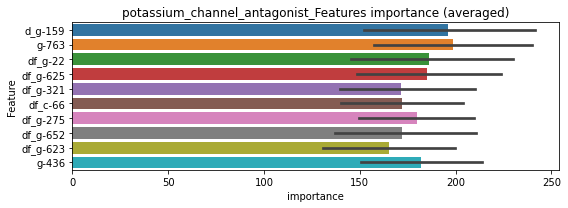

len(train_index) : 3775
len(valid_index) : 3776
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711407	valid_1's binary_logloss: 0.127708
[200]	training's binary_logloss: 0.0266809	valid_1's binary_logloss: 0.0938167
[300]	training's binary_logloss: 0.00998988	valid_1's binary_logloss: 0.0789044
[400]	training's binary_logloss: 0.00445217	valid_1's binary_logloss: 0.0745106
[500]	training's binary_logloss: 0.00239359	valid_1's binary_logloss: 0.0722964
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00252489	valid_1's binary_logloss: 0.071684


len(train_index) : 3776
len(valid_index) : 3775
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723439	valid_1's binary_logloss: 0.113959
[200]	training's binary_logloss: 0.0280873	valid_1's binary_logloss: 0.0783049
[300]	training's binary_logloss: 0.0111804	valid_1's binary_logloss: 0.0642629
[400]	training's binary_logloss: 0.00508764	valid_1's binary_logloss: 0.0575907
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00415447	valid_1's binary_logloss: 0.0559773


potassium_channel_antagonist logloss: 0.06383168218236385


neg labels: 3289 → selected neg labels: 3278


ppar_receptor_agonist, len(trt): 115, len(othr): 3278, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148249	valid_1's binary_logloss: 0.230416
[200]	training's binary_logloss: 0.069152	valid_1's binary_logloss: 0.182869
[300]	training's binary_logloss: 0.032749	valid_1's binary_logloss: 0.160335
[400]	training's binary_logloss: 0.0162214	valid_1's binary_logloss: 0.147454
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0114571	valid_1's binary_logloss: 0.143616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14774	valid_1's binary_logloss: 0.219922
[200]	training's binary_logloss: 0.0676783	valid_1's binary_logloss: 0.166798
[300]	training's binary_logloss: 0.0343139	valid_1's binary_logloss: 0.144264
[400]	training's binary_logloss: 0.0175182	valid_1's binary_logloss: 0.133081
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0113613	valid_1's binary_logloss: 0.128624


1 / 3 AUC score:0.968
y_Threshold: 0.0755466, Threshold: 0.2044177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 264 → Positive_corect_labels: 589/3669
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.18398, conf_1:0.22486
threshold: 0.2044177, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 589.0/3669, y_label_rate: 0.1605342
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11004	valid_1's binary_logloss: 0.183614
[200]	training's binary_logloss: 0.0411294	valid_1's binary_logloss: 0.135086
[300]	training's binary_logloss: 0.0172716	valid_1's binary_logloss: 0.114911
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00923849	valid_1's binary_logloss: 0.108117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113011	valid_1's binary_logloss: 0.176396
[200]	training's binary_logloss: 0.0437195	valid_1's binary_logloss: 0.122891
[300]	training's binary_logloss: 0.0186556	valid_1's binary_logloss: 0.100161
[400]	training's binary_logloss: 0.00909687	valid_1's binary_logloss: 0.0910661


2 / 3 AUC score:0.986


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00604081	valid_1's binary_logloss: 0.0881223


y_Threshold: 0.1206138, Threshold: 0.2044177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 543.0/3577
p_label_rate: 0.0263687 Vs.target_rate: 0.00483, Num_p_label: 105.0, conf_0:0.18398, conf_1:0.22486
Num_p_label: 105.0, Expected: 19.2, Adj_threshold_1: 0.2044177
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_2: 0.2344177
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_3: 0.2644177
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_4: 0.2944177
Num_p_label: 54.0, Expected: 19.2, Adj_threshold_5: 0.3244177
Num_p_label: 44.0, Expected: 19.2, Adj_threshold_6: 0.3544177
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_7: 0.3844177
threshold: 0.3844177, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 543.0/3577, y_label_rate: 0.1518032
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101678	valid_1's binary_logloss: 0.157236
[200]	training's binary_logloss: 0.0388707	valid_1's binary_logloss: 0.107838
[300]	training's binary_logloss: 0.0148539	valid_1's binary_logloss: 0.0866621
[400]	training's binary_logloss: 0.0068119	valid_1's binary_logloss: 0.0775665
[500]	training's binary_logloss: 0.00383936	valid_1's binary_logloss: 0.0731969
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00393048	valid_1's binary_logloss: 0.0731488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088348	valid_1's binary_logloss: 0.15992
[200]	training's binary_logloss: 0.0308705	valid_1's binary_logloss: 0.111863
[300]	training's binary_logloss: 0.0126592	valid_1's binary_logloss: 0.0947975


3 / 3 AUC score:0.993
y_Threshold: 0.1131494, Threshold: 0.3844177, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.00606417	valid_1's binary_logloss: 0.0866512
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00583387	valid_1's binary_logloss: 0.0863619


Remove_noisy_labels: 78 → Positive_corect_labels: 504.0/3499
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.34598, conf_1:0.42286
threshold: 0.3844177, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 544.0/7481, y_label_rate: 0.0727176


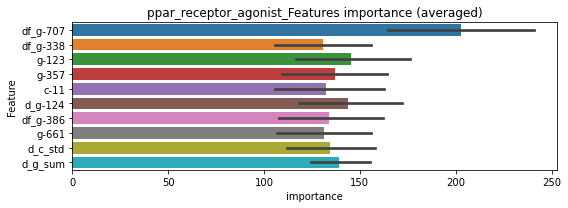

len(train_index) : 3740
len(valid_index) : 3741
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520543	valid_1's binary_logloss: 0.0881807
[200]	training's binary_logloss: 0.0181266	valid_1's binary_logloss: 0.0635637


len(train_index) : 3741
len(valid_index) : 3740
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00880426	valid_1's binary_logloss: 0.0575979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557693	valid_1's binary_logloss: 0.08776
[200]	training's binary_logloss: 0.0190988	valid_1's binary_logloss: 0.0597521


ppar_receptor_agonist logloss: 0.05459296799817


[300]	training's binary_logloss: 0.00751353	valid_1's binary_logloss: 0.051618
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00821402	valid_1's binary_logloss: 0.0515872
neg labels: 3289 → selected neg labels: 3282


ppar_receptor_antagonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761174	valid_1's binary_logloss: 0.120254
[200]	training's binary_logloss: 0.0204762	valid_1's binary_logloss: 0.0562688
[300]	training's binary_logloss: 0.00680071	valid_1's binary_logloss: 0.03441
[400]	training's binary_logloss: 0.00291437	valid_1's binary_logloss: 0.0270321
[500]	training's binary_logloss: 0.00174398	valid_1's binary_logloss: 0.0233964
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0016887	valid_1's binary_logloss: 0.0231923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816607	valid_1's binary_logloss: 0.120967
[200]	training's binary_logloss: 0.0270697	valid_1's binary_logloss: 0.0678305
[300]	training's binary_logloss: 0.00809266	valid_1's binary_logloss: 0.0411347
[400]	training's binary_logloss: 0.00341472	valid_1's binary_logloss: 0.0304824
[500]	training's binary_logloss: 0.00193603	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0199953, Threshold: 0.0771374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.06942, conf_1:0.08485
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0771374
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.1071374
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.1371374
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_4: 0.1671374
threshold: 0.1671374, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071152	valid_1's binary_logloss: 0.111915
[200]	training's binary_logloss: 0.0187805	valid_1's binary_logloss: 0.0494436
[300]	training's binary_logloss: 0.00591502	valid_1's binary_logloss: 0.028727
[400]	training's binary_logloss: 0.00263275	valid_1's binary_logloss: 0.0223965
[500]	training's binary_logloss: 0.00163784	valid_1's binary_logloss: 0.0195247
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00144718	valid_1's binary_logloss: 0.0191423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709692	valid_1's binary_logloss: 0.112373
[200]	training's binary_logloss: 0.0189734	valid_1's binary_logloss: 0.0537951
[300]	training's binary_logloss: 0.00609042	valid_1's binary_logloss: 0.0330603
[400]	training's binary_logloss: 0.00270147	valid_1's binary_logloss: 0.024766
[500]	training's binary_logloss: 0.00167562	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.1106813, Threshold: 0.1671374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0082873 Vs.target_rate: 0.00126, Num_p_label: 33.0, conf_0:0.15042, conf_1:0.18385
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_1: 0.1671374
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_2: 0.1971374
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.2271374
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_4: 0.2571374
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.2871374
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.3171374
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_7: 0.3471374
threshold: 0.3471374, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691599	valid_1's binary_logloss: 0.0933503
[200]	training's binary_logloss: 0.019311	valid_1's binary_logloss: 0.0366133
[300]	training's binary_logloss: 0.00599561	valid_1's binary_logloss: 0.0181459
[400]	training's binary_logloss: 0.00268175	valid_1's binary_logloss: 0.0121165
[500]	training's binary_logloss: 0.00167731	valid_1's binary_logloss: 0.00992298
[600]	training's binary_logloss: 0.00127335	valid_1's binary_logloss: 0.00889946
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0012295	valid_1's binary_logloss: 0.00884927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748141	valid_1's binary_logloss: 0.109122
[200]	training's binary_logloss: 0.0202616	valid_1's binary_logloss: 0.0473518
[300]	training's binary_logloss: 0.00611344	valid_1's binary_logloss: 0.0246428
[400]	training's binary_logloss: 0.00274056	val

3 / 3 AUC score:1.000
y_Threshold: 0.1850280, Threshold: 0.3471374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.31242, conf_1:0.38185
threshold: 0.3471374, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 658.0/7774, y_label_rate: 0.0846411


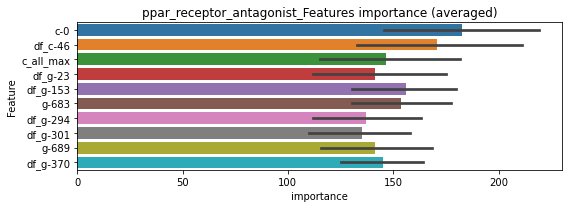

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041056	valid_1's binary_logloss: 0.0665422
[200]	training's binary_logloss: 0.0118252	valid_1's binary_logloss: 0.0348887
[300]	training's binary_logloss: 0.00356265	valid_1's binary_logloss: 0.0220384
[400]	training's binary_logloss: 0.00153616	valid_1's binary_logloss: 0.0174392
[500]	training's binary_logloss: 0.000920128	valid_1's binary_logloss: 0.0157028
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000761223	valid_1's binary_logloss: 0.0153474


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042693	valid_1's binary_logloss: 0.0650766
[200]	training's binary_logloss: 0.011519	valid_1's binary_logloss: 0.030809
[300]	training's binary_logloss: 0.00349724	valid_1's binary_logloss: 0.0200917
[400]	training's binary_logloss: 0.00150902	valid_1's binary_logloss: 0.0170497
[500]	training's binary_logloss: 0.000917782	valid_1's binary_logloss: 0.0158469
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000917782	valid_1's binary_logloss: 0.0158469


ppar_receptor_antagonist logloss: 0.015597157859317236


neg labels: 3289 → selected neg labels: 3270


progesterone_receptor_agonist, len(trt): 119, len(othr): 3270, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13314	valid_1's binary_logloss: 0.232065
[200]	training's binary_logloss: 0.0621903	valid_1's binary_logloss: 0.189518
[300]	training's binary_logloss: 0.0306483	valid_1's binary_logloss: 0.174108
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0175239	valid_1's binary_logloss: 0.169779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150735	valid_1's binary_logloss: 0.219108
[200]	training's binary_logloss: 0.0806951	valid_1's binary_logloss: 0.172802
[300]	training's binary_logloss: 0.0410221	valid_1's binary_logloss: 0.146455
[400]	training's binary_logloss: 0.0224834	valid_1's binary_logloss: 0.13183
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0146283	valid_1's binary_logloss: 0.125103


1 / 3 AUC score:0.965
y_Threshold: 0.0967726, Threshold: 0.3838239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 265 → Positive_corect_labels: 587/3659
p_label_rate: 0.0100452 Vs.target_rate: 0.00500, Num_p_label: 40.0, conf_0:0.34544, conf_1:0.42221
threshold: 0.3838239, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 587.0/3659, y_label_rate: 0.1604263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115019	valid_1's binary_logloss: 0.189602
[200]	training's binary_logloss: 0.0473492	valid_1's binary_logloss: 0.136828
[300]	training's binary_logloss: 0.0204136	valid_1's binary_logloss: 0.113838
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0104742	valid_1's binary_logloss: 0.102492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11733	valid_1's binary_logloss: 0.165579
[200]	training's binary_logloss: 0.0476272	valid_1's binary_logloss: 0.105346
[300]	training's binary_logloss: 0.0209337	valid_1's binary_logloss: 0.0802417
[400]	training's binary_logloss: 0.00989779	valid_1's binary_logloss: 0.0678538
[500]	training's binary_logloss: 0.00554298	valid_1's binary_logloss: 0.0626867
[600]	training's binary_logloss: 0.00368315	valid_1's binary_logloss: 0.0591403
Early stopping, best iteration is:
[655]	training's binary_

2 / 3 AUC score:0.993
y_Threshold: 0.1542207, Threshold: 0.3838239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 76 → Positive_corect_labels: 549.0/3583
p_label_rate: 0.0218483 Vs.target_rate: 0.00500, Num_p_label: 87.0, conf_0:0.34544, conf_1:0.42221
Num_p_label: 87.0, Expected: 19.9, Adj_threshold_1: 0.3838239
Num_p_label: 78.0, Expected: 19.9, Adj_threshold_2: 0.4138239
Num_p_label: 70.0, Expected: 19.9, Adj_threshold_3: 0.4438239
Num_p_label: 55.0, Expected: 19.9, Adj_threshold_4: 0.4738239
Num_p_label: 50.0, Expected: 19.9, Adj_threshold_5: 0.5038239
Num_p_label: 43.0, Expected: 19.9, Adj_threshold_6: 0.5338239
Num_p_label: 36.0, Expected: 19.9, Adj_threshold_7: 0.5638239
threshold: 0.5638239, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 549.0/3583, y_label_rate: 0.1532236
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102353	valid_1's binary_logloss: 0.177721
[200]	training's binary_logloss: 0.0393553	valid_1's binary_logloss: 0.125539
[300]	training's binary_logloss: 0.0165011	valid_1's binary_logloss: 0.107538
[400]	training's binary_logloss: 0.00784296	valid_1's binary_logloss: 0.100568
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00708374	valid_1's binary_logloss: 0.0996378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100359	valid_1's binary_logloss: 0.160529
[200]	training's binary_logloss: 0.0391051	valid_1's binary_logloss: 0.109746
[300]	training's binary_logloss: 0.0156893	valid_1's binary_logloss: 0.0886758
[400]	training's binary_logloss: 0.00748137	valid_1's binary_logloss: 0.0784135
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00486622	valid_1's binary_logloss: 0.0750143


3 / 3 AUC score:0.989
y_Threshold: 0.1211584, Threshold: 0.5638239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 503.0/3491
p_label_rate: 0.0165746 Vs.target_rate: 0.00500, Num_p_label: 66.0, conf_0:0.50744, conf_1:0.62021
Num_p_label: 66.0, Expected: 19.9, Adj_threshold_1: 0.5638239
Num_p_label: 53.0, Expected: 19.9, Adj_threshold_2: 0.5938239
Num_p_label: 46.0, Expected: 19.9, Adj_threshold_3: 0.6238239
Num_p_label: 37.0, Expected: 19.9, Adj_threshold_4: 0.6538239
threshold: 0.6538239, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 540.0/7473, y_label_rate: 0.0722601


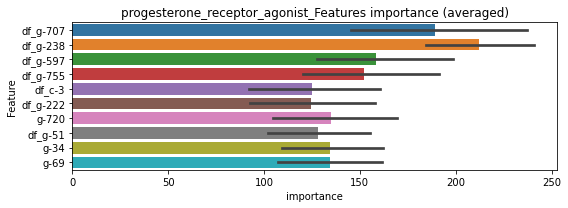

len(train_index) : 3736
len(valid_index) : 3737
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574517	valid_1's binary_logloss: 0.093196
[200]	training's binary_logloss: 0.021375	valid_1's binary_logloss: 0.0666629
[300]	training's binary_logloss: 0.00893187	valid_1's binary_logloss: 0.0574835
[400]	training's binary_logloss: 0.00431968	valid_1's binary_logloss: 0.0538064
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00444303	valid_1's binary_logloss: 0.0537732


len(train_index) : 3737
len(valid_index) : 3736
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552954	valid_1's binary_logloss: 0.0947029
[200]	training's binary_logloss: 0.0219396	valid_1's binary_logloss: 0.0662928
[300]	training's binary_logloss: 0.00979827	valid_1's binary_logloss: 0.0553506
[400]	training's binary_logloss: 0.00479497	valid_1's binary_logloss: 0.0511101
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00295481	valid_1's binary_logloss: 0.0492293


progesterone_receptor_agonist logloss: 0.05150152728224019


neg labels: 3289 → selected neg labels: 3287


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465552	valid_1's binary_logloss: 0.0733241
[200]	training's binary_logloss: 0.0100758	valid_1's binary_logloss: 0.0295706
[300]	training's binary_logloss: 0.00306312	valid_1's binary_logloss: 0.0176855
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00207712	valid_1's binary_logloss: 0.0155291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524942	valid_1's binary_logloss: 0.0700503
[200]	training's binary_logloss: 0.0116123	valid_1's binary_logloss: 0.0233185
[300]	training's binary_logloss: 0.00345603	valid_1's binary_logloss: 0.0111342
[400]	training's binary_logloss: 0.00175604	valid_1's binary_logloss: 0.0077765
[500]	training's binary_logloss: 0.00117334	valid_1's binary_logloss: 0.00649547
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000969995	valid_1's binary_logloss: 0.00590664


1 / 3 AUC score:1.000
y_Threshold: 0.0180269, Threshold: 0.1276245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.11486, conf_1:0.14039
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1276245
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.1576245
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.1876245
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.2176245
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.2476245
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.2776245
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.3076245
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.3376245
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.3676245
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.3976245
threshold: 0.4276245, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425441	valid_1's binary_logloss: 0.0620367
[200]	training's binary_logloss: 0.00853454	valid_1's binary_logloss: 0.0203165
[300]	training's binary_logloss: 0.00271888	valid_1's binary_logloss: 0.0103861
[400]	training's binary_logloss: 0.00142151	valid_1's binary_logloss: 0.0077292
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00106412	valid_1's binary_logloss: 0.00683755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463155	valid_1's binary_logloss: 0.0638486
[200]	training's binary_logloss: 0.00913316	valid_1's binary_logloss: 0.021054
[300]	training's binary_logloss: 0.0028362	valid_1's binary_logloss: 0.0113837
[400]	training's binary_logloss: 0.0014462	valid_1's binary_logloss: 0.00814906
[500]	training's binary_logloss: 0.000993951	valid_1's binary_logloss: 0.00686586
[600]	training's binary_logloss: 0.000811502

2 / 3 AUC score:1.000
y_Threshold: 0.3725801, Threshold: 0.4276245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0067805 Vs.target_rate: 0.00076, Num_p_label: 27.0, conf_0:0.38486, conf_1:0.47039
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_1: 0.4276245
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.4576245
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.4876245
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.5176245
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.5476245
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.5776245
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.6076245
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_8: 0.6376245
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_9: 0.6676245
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.6976245
threshold: 0.7276245, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499732	valid_1's binary_logloss: 0.0689655
[200]	training's binary_logloss: 0.00952332	valid_1's binary_logloss: 0.0212319
[300]	training's binary_logloss: 0.00285928	valid_1's binary_logloss: 0.0101001
[400]	training's binary_logloss: 0.00143811	valid_1's binary_logloss: 0.00711434
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00111151	valid_1's binary_logloss: 0.00638312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436183	valid_1's binary_logloss: 0.074232
[200]	training's binary_logloss: 0.00833042	valid_1's binary_logloss: 0.0296319
[300]	training's binary_logloss: 0.00260029	valid_1's binary_logloss: 0.0174379
[400]	training's binary_logloss: 0.00134297	valid_1's binary_logloss: 0.012832
[500]	training's binary_logloss: 0.000947238	valid_1's binary_logloss: 0.0113459
[600]	training's binary_logloss: 0.000773633

3 / 3 AUC score:1.000
y_Threshold: 0.3826175, Threshold: 0.7276245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3802
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.65486, conf_1:0.80039
threshold: 0.7276245, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 660.0/7784, y_label_rate: 0.0847893


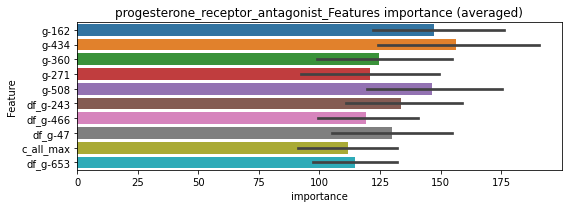

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247232	valid_1's binary_logloss: 0.0394024
[200]	training's binary_logloss: 0.00482443	valid_1's binary_logloss: 0.0144163
[300]	training's binary_logloss: 0.00149811	valid_1's binary_logloss: 0.00863779
[400]	training's binary_logloss: 0.000773539	valid_1's binary_logloss: 0.00718339
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000642687	valid_1's binary_logloss: 0.00676515


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028528	valid_1's binary_logloss: 0.0405024
[200]	training's binary_logloss: 0.00543148	valid_1's binary_logloss: 0.0127626
[300]	training's binary_logloss: 0.00161736	valid_1's binary_logloss: 0.00606027
[400]	training's binary_logloss: 0.000846987	valid_1's binary_logloss: 0.00449322
[500]	training's binary_logloss: 0.000581958	valid_1's binary_logloss: 0.00389749
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00049353	valid_1's binary_logloss: 0.003709


progesterone_receptor_antagonist logloss: 0.005237070469695964


neg labels: 3289 → selected neg labels: 3286


prostaglandin_inhibitor, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717062	valid_1's binary_logloss: 0.11561
[200]	training's binary_logloss: 0.0198373	valid_1's binary_logloss: 0.0611591
[300]	training's binary_logloss: 0.00681862	valid_1's binary_logloss: 0.0434274
[400]	training's binary_logloss: 0.00302906	valid_1's binary_logloss: 0.0361135
[500]	training's binary_logloss: 0.00185248	valid_1's binary_logloss: 0.0333137
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00173571	valid_1's binary_logloss: 0.0330554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787475	valid_1's binary_logloss: 0.110167
[200]	training's binary_logloss: 0.0237385	valid_1's binary_logloss: 0.04879
[300]	training's binary_logloss: 0.00768478	valid_1's binary_logloss: 0.0249978
[400]	training's binary_logloss: 0.00334452	valid_1's binary_logloss: 0.0173546
[500]	training's binary_logloss: 0.00207289	valid_1'

1 / 3 AUC score:0.999
y_Threshold: 0.0252358, Threshold: 0.3366417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 655/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.30298, conf_1:0.37031
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.3366417
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_2: 0.3666417
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.3966417
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_4: 0.4266417
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.4566417
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_6: 0.4866417
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.5166417
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_8: 0.5466417
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_9: 0.5766417
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_10: 0.6066417
threshold: 0.6366417, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728584	valid_1's binary_logloss: 0.103712
[200]	training's binary_logloss: 0.0195452	valid_1's binary_logloss: 0.0444571
[300]	training's binary_logloss: 0.0066005	valid_1's binary_logloss: 0.0259155
[400]	training's binary_logloss: 0.00295845	valid_1's binary_logloss: 0.0188308
[500]	training's binary_logloss: 0.00182422	valid_1's binary_logloss: 0.0163556
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0015223	valid_1's binary_logloss: 0.0155279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697233	valid_1's binary_logloss: 0.10811
[200]	training's binary_logloss: 0.0170128	valid_1's binary_logloss: 0.0432954
[300]	training's binary_logloss: 0.00572279	valid_1's binary_logloss: 0.0245201
[400]	training's binary_logloss: 0.00270434	valid_1's binary_logloss: 0.0181146
Early stopping, best iteration is:
[465]	training's 

2 / 3 AUC score:1.000
y_Threshold: 0.1407490, Threshold: 0.6366417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 648.0/3793
p_label_rate: 0.0072828 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.57298, conf_1:0.70031
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.6366417
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.6666417
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.6966417
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.7266417
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.7566417
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_6: 0.7866417
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_7: 0.8166417
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.8466417
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_9: 0.8766417
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.9066417
threshold: 0.9066417, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 648.0/3793, y_label_rate: 0.1708410
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720621	valid_1's binary_logloss: 0.110342
[200]	training's binary_logloss: 0.0189591	valid_1's binary_logloss: 0.0489665
[300]	training's binary_logloss: 0.00634716	valid_1's binary_logloss: 0.0307146
[400]	training's binary_logloss: 0.00292246	valid_1's binary_logloss: 0.0232986
[500]	training's binary_logloss: 0.00177865	valid_1's binary_logloss: 0.0192655
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00140679	valid_1's binary_logloss: 0.0178829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642971	valid_1's binary_logloss: 0.101908
[200]	training's binary_logloss: 0.0170971	valid_1's binary_logloss: 0.0463203
[300]	training's binary_logloss: 0.00549496	valid_1's binary_logloss: 0.0262401
[400]	training's binary_logloss: 0.00258438	valid_1's binary_logloss: 0.0200289
[500]	training's binary_logloss: 0.00165051	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1545534, Threshold: 0.9066417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 645.0/3787
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.81598, conf_1:0.99731
threshold: 0.9066417, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/7769, y_label_rate: 0.0843094


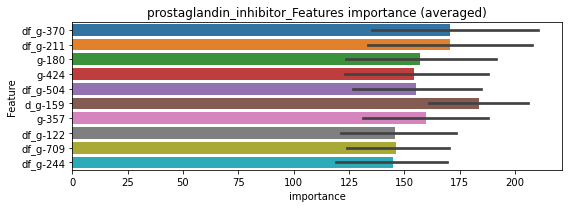

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428124	valid_1's binary_logloss: 0.0697626
[200]	training's binary_logloss: 0.0128678	valid_1's binary_logloss: 0.0362405
[300]	training's binary_logloss: 0.00404612	valid_1's binary_logloss: 0.0228553
[400]	training's binary_logloss: 0.00173432	valid_1's binary_logloss: 0.0186459
[500]	training's binary_logloss: 0.00101837	valid_1's binary_logloss: 0.0169042
[600]	training's binary_logloss: 0.000759878	valid_1's binary_logloss: 0.0158636
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.000759878	valid_1's binary_logloss: 0.0158636


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415646	valid_1's binary_logloss: 0.0690654
[200]	training's binary_logloss: 0.011574	valid_1's binary_logloss: 0.0338722
[300]	training's binary_logloss: 0.00389585	valid_1's binary_logloss: 0.0195302
[400]	training's binary_logloss: 0.00173277	valid_1's binary_logloss: 0.0137513
[500]	training's binary_logloss: 0.00106766	valid_1's binary_logloss: 0.0118974
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00105346	valid_1's binary_logloss: 0.011846


prostaglandin_inhibitor logloss: 0.013855042493366223


neg labels: 3289 → selected neg labels: 3280


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3280, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123394	valid_1's binary_logloss: 0.2079
[200]	training's binary_logloss: 0.0521875	valid_1's binary_logloss: 0.153884
[300]	training's binary_logloss: 0.0219996	valid_1's binary_logloss: 0.12951
[400]	training's binary_logloss: 0.0104236	valid_1's binary_logloss: 0.121707
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0108279	valid_1's binary_logloss: 0.121425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135564	valid_1's binary_logloss: 0.195655
[200]	training's binary_logloss: 0.0562472	valid_1's binary_logloss: 0.129532
[300]	training's binary_logloss: 0.0255209	valid_1's binary_logloss: 0.100922
[400]	training's binary_logloss: 0.0119871	valid_1's binary_logloss: 0.0844177
[500]	training's binary_logloss: 0.00643924	valid_1's binary_logloss: 0.0778935
Early stopping, best iteration is:
[560]	training's binary_loglos

1 / 3 AUC score:0.987
y_Threshold: 0.0670286, Threshold: 0.4352277, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 204 → Positive_corect_labels: 620/3732
p_label_rate: 0.0100452 Vs.target_rate: 0.00353, Num_p_label: 40.0, conf_0:0.39170, conf_1:0.47875
threshold: 0.4352277, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 620.0/3732, y_label_rate: 0.1661308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108498	valid_1's binary_logloss: 0.16771
[200]	training's binary_logloss: 0.0443808	valid_1's binary_logloss: 0.105871
[300]	training's binary_logloss: 0.0177523	valid_1's binary_logloss: 0.0744898
[400]	training's binary_logloss: 0.00848829	valid_1's binary_logloss: 0.0608951
[500]	training's binary_logloss: 0.00461031	valid_1's binary_logloss: 0.0527236
[600]	training's binary_logloss: 0.00303622	valid_1's binary_logloss: 0.0493726
[700]	training's binary_logloss: 0.00228711	valid_1's binary_logloss: 0.0476233
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00234161	valid_1's binary_logloss: 0.0476161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118772	valid_1's binary_logloss: 0.186118
[200]	training's binary_logloss: 0.0415932	valid_1's binary_logloss: 0.110799
[300]	training's binary_logloss: 0.016849	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.1075446, Threshold: 0.4352277, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 596.0/3684
p_label_rate: 0.0163235 Vs.target_rate: 0.00353, Num_p_label: 65.0, conf_0:0.39170, conf_1:0.47875
Num_p_label: 65.0, Expected: 14.0, Adj_threshold_1: 0.4352277
Num_p_label: 63.0, Expected: 14.0, Adj_threshold_2: 0.4652277
Num_p_label: 62.0, Expected: 14.0, Adj_threshold_3: 0.4952277
Num_p_label: 60.0, Expected: 14.0, Adj_threshold_4: 0.5252277
Num_p_label: 59.0, Expected: 14.0, Adj_threshold_5: 0.5552277
Num_p_label: 57.0, Expected: 14.0, Adj_threshold_6: 0.5852277
Num_p_label: 55.0, Expected: 14.0, Adj_threshold_7: 0.6152277
Num_p_label: 51.0, Expected: 14.0, Adj_threshold_8: 0.6452277
Num_p_label: 50.0, Expected: 14.0, Adj_threshold_9: 0.6752277
Num_p_label: 47.0, Expected: 14.0, Adj_threshold_10: 0.7052277
threshold: 0.7352277, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 596.0/3684, y_label_rate: 0.16178

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104752	valid_1's binary_logloss: 0.171025
[200]	training's binary_logloss: 0.0389474	valid_1's binary_logloss: 0.105443
[300]	training's binary_logloss: 0.0142583	valid_1's binary_logloss: 0.0732093
[400]	training's binary_logloss: 0.00647338	valid_1's binary_logloss: 0.0612928
[500]	training's binary_logloss: 0.0036781	valid_1's binary_logloss: 0.054312
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00299216	valid_1's binary_logloss: 0.0529063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102693	valid_1's binary_logloss: 0.159794
[200]	training's binary_logloss: 0.0363912	valid_1's binary_logloss: 0.0927627
[300]	training's binary_logloss: 0.014142	valid_1's binary_logloss: 0.0651793
[400]	training's binary_logloss: 0.00660328	valid_1's binary_logloss: 0.0531497
Early stopping, best iteration is:
[460]	training's binar

3 / 3 AUC score:0.999
y_Threshold: 0.1375976, Threshold: 0.7352277, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 578.0/3648
p_label_rate: 0.0130588 Vs.target_rate: 0.00353, Num_p_label: 52.0, conf_0:0.66170, conf_1:0.80875
Num_p_label: 52.0, Expected: 14.0, Adj_threshold_1: 0.7352277
Num_p_label: 48.0, Expected: 14.0, Adj_threshold_2: 0.7652277
Num_p_label: 47.0, Expected: 14.0, Adj_threshold_3: 0.7952277
Num_p_label: 46.0, Expected: 14.0, Adj_threshold_4: 0.8252277
Num_p_label: 45.0, Expected: 14.0, Adj_threshold_5: 0.8552277
Num_p_label: 38.0, Expected: 14.0, Adj_threshold_6: 0.8852277
Num_p_label: 35.0, Expected: 14.0, Adj_threshold_7: 0.9152277
Num_p_label: 29.0, Expected: 14.0, Adj_threshold_8: 0.9452277
Num_p_label: 19.0, Expected: 14.0, Adj_threshold_9: 0.9752277
threshold: 0.9752277, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 597.0/7630, y_label_rate: 0.0782438


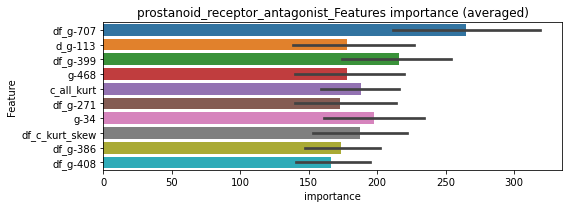

len(train_index) : 3815
len(valid_index) : 3815
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600025	valid_1's binary_logloss: 0.101103
[200]	training's binary_logloss: 0.02048	valid_1's binary_logloss: 0.0658233
[300]	training's binary_logloss: 0.00797061	valid_1's binary_logloss: 0.0533057


len(train_index) : 3815
len(valid_index) : 3815


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00464274	valid_1's binary_logloss: 0.0505803


================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644865	valid_1's binary_logloss: 0.0934319
[200]	training's binary_logloss: 0.0239429	valid_1's binary_logloss: 0.0543009
[300]	training's binary_logloss: 0.00945869	valid_1's binary_logloss: 0.0376091
[400]	training's binary_logloss: 0.00409856	valid_1's binary_logloss: 0.0308088
[500]	training's binary_logloss: 0.0022512	valid_1's binary_logloss: 0.0271086
[600]	training's binary_logloss: 0.0014972	valid_1's binary_logloss: 0.0257972
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00116613	valid_1's binary_logloss: 0.0249644


prostanoid_receptor_antagonist logloss: 0.03777235769583303


neg labels: 3289 → selected neg labels: 3197


proteasome_inhibitor, len(trt): 726, len(othr): 3197, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.434144	valid_1's binary_logloss: 0.476531
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.521
y_Threshold: 0.2000880, Threshold: 0.3874038, pos_neg_ratio: 0.7729121
Remove_noisy_labels: 1247 → Positive_corect_labels: 185/2676
p_label_rate: 0.0100452 Vs.target_rate: 0.03049, Num_p_label: 40.0, conf_0:0.34866, conf_1:0.42614
Num_p_label: 40.0, Expected: 121.4, Adj_threshold_1: 0.3874038
Num_p_label: 78.0, Expected: 121.4, Adj_threshold_2: 0.3574038
threshold: 0.3574038, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 185.0/2676, y_label_rate: 0.0691330
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.423934	valid_1's binary_logloss: 0.477344
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.100082	valid_1's binary_logloss: 0.204743
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.787
y_Threshold: 0.1224306, Threshold: 0.3574038, pos_neg_ratio: 0.7729121
Remove_noisy_labels: 232 → Positive_corect_labels: 69.0/2444
p_label_rate: 0.0519839 Vs.target_rate: 0.03049, Num_p_label: 207.0, conf_0:0.32166, conf_1:0.39314
threshold: 0.3574038, positive_p_label: 207.0/3982, p_label_rate: 0.0519839
positive_y_label: 69.0/2444, y_label_rate: 0.0282324
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0788729	valid_1's binary_logloss: 0.203031
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.951
y_Threshold: 0.0990621, Threshold: 0.3574038, pos_neg_ratio: 0.7729121
Remove_noisy_labels: 48 → Positive_corect_labels: 45.0/2396
p_label_rate: 0.0642893 Vs.target_rate: 0.03049, Num_p_label: 256.0, conf_0:0.32166, conf_1:0.39314
threshold: 0.3574038, positive_p_label: 256.0/3982, p_label_rate: 0.0642893


[100]	training's binary_logloss: 0.0133375	valid_1's binary_logloss: 0.0457669
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0157445	valid_1's binary_logloss: 0.0453283
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.0242615	valid_1's binary_logloss: 0.0702242


positive_y_label: 301.0/6378, y_label_rate: 0.0471935


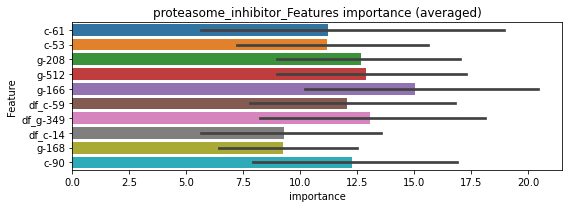

len(train_index) : 3189
len(valid_index) : 3189
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00786069	valid_1's binary_logloss: 0.0240972


len(train_index) : 3189
len(valid_index) : 3189
================================= fold 2/2 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.00123308	valid_1's binary_logloss: 0.0204059
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00134159	valid_1's binary_logloss: 0.0201804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00939997	valid_1's binary_logloss: 0.0143188
[200]	training's binary_logloss: 0.00175942	valid_1's binary_logloss: 0.00852656
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00161677	valid_1's binary_logloss: 0.00838628


proteasome_inhibitor logloss: 0.014283312762668122


neg labels: 3289 → selected neg labels: 3285


protein_kinase_inhibitor, len(trt): 48, len(othr): 3285, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110256	valid_1's binary_logloss: 0.175246
[200]	training's binary_logloss: 0.0397405	valid_1's binary_logloss: 0.10367
[300]	training's binary_logloss: 0.0153369	valid_1's binary_logloss: 0.0708846
[400]	training's binary_logloss: 0.00649258	valid_1's binary_logloss: 0.0532503
[500]	training's binary_logloss: 0.00353505	valid_1's binary_logloss: 0.0463165
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00305269	valid_1's binary_logloss: 0.0446632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103059	valid_1's binary_logloss: 0.178373
[200]	training's binary_logloss: 0.0361979	valid_1's binary_logloss: 0.108447
[300]	training's binary_logloss: 0.0134529	valid_1's binary_logloss: 0.0717666
[400]	training's binary_logloss: 0.00598018	valid_1's binary_logloss: 0.0588932
[500]	training's binary_logloss: 0.00327102	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0500385, Threshold: 0.2268469, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 651/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.20416, conf_1:0.24953
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.2268469
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.2568469
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_3: 0.2868469
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.3168469
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.3468469
threshold: 0.3468469, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101307	valid_1's binary_logloss: 0.151926
[200]	training's binary_logloss: 0.0362373	valid_1's binary_logloss: 0.0850498
[300]	training's binary_logloss: 0.0133	valid_1's binary_logloss: 0.0543144
[400]	training's binary_logloss: 0.00595781	valid_1's binary_logloss: 0.0416798
[500]	training's binary_logloss: 0.00327054	valid_1's binary_logloss: 0.03399
[600]	training's binary_logloss: 0.00223098	valid_1's binary_logloss: 0.0317275
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00209881	valid_1's binary_logloss: 0.0312268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975325	valid_1's binary_logloss: 0.163692
[200]	training's binary_logloss: 0.0326511	valid_1's binary_logloss: 0.0953111
[300]	training's binary_logloss: 0.0113502	valid_1's binary_logloss: 0.0642527
[400]	training's binary_logloss: 0.00500187	valid_1's bin

2 / 3 AUC score:0.998
y_Threshold: 0.1708350, Threshold: 0.3468469, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 636.0/3768
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.31216, conf_1:0.38153
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.3468469
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_2: 0.3768469
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_3: 0.4068469
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_4: 0.4368469
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_5: 0.4668469
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_6: 0.4968469
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_7: 0.5268469
threshold: 0.5268469, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 636.0/3768, y_label_rate: 0.1687898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955757	valid_1's binary_logloss: 0.146401
[200]	training's binary_logloss: 0.0310801	valid_1's binary_logloss: 0.0757637
[300]	training's binary_logloss: 0.0113618	valid_1's binary_logloss: 0.0459477
[400]	training's binary_logloss: 0.00505765	valid_1's binary_logloss: 0.034352
[500]	training's binary_logloss: 0.00291932	valid_1's binary_logloss: 0.0289288
[600]	training's binary_logloss: 0.0020491	valid_1's binary_logloss: 0.0263126
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.0016844	valid_1's binary_logloss: 0.0253327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100147	valid_1's binary_logloss: 0.157228
[200]	training's binary_logloss: 0.0301463	valid_1's binary_logloss: 0.0839054
[300]	training's binary_logloss: 0.010694	valid_1's binary_logloss: 0.0582854
[400]	training's binary_logloss: 0.00487359	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.1597597, Threshold: 0.5268469, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 620.0/3736
p_label_rate: 0.0067805 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.47416, conf_1:0.57953
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.5268469
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.5568469
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.5868469
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.6168469
threshold: 0.6168469, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 632.0/7718, y_label_rate: 0.0818865


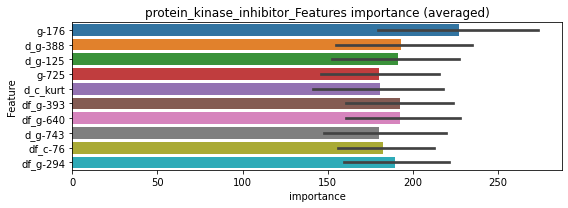

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591971	valid_1's binary_logloss: 0.0919185
[200]	training's binary_logloss: 0.0201519	valid_1's binary_logloss: 0.0494826
[300]	training's binary_logloss: 0.00714519	valid_1's binary_logloss: 0.0326694
[400]	training's binary_logloss: 0.00303581	valid_1's binary_logloss: 0.0255738
[500]	training's binary_logloss: 0.00163645	valid_1's binary_logloss: 0.0224158
[600]	training's binary_logloss: 0.00111867	valid_1's binary_logloss: 0.0208821
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00108214	valid_1's binary_logloss: 0.0207562


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542272	valid_1's binary_logloss: 0.0874523
[200]	training's binary_logloss: 0.0178453	valid_1's binary_logloss: 0.0491273
[300]	training's binary_logloss: 0.00664643	valid_1's binary_logloss: 0.0342163
[400]	training's binary_logloss: 0.00287277	valid_1's binary_logloss: 0.0278732
[500]	training's binary_logloss: 0.0015907	valid_1's binary_logloss: 0.0255816
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00122144	valid_1's binary_logloss: 0.0250486


protein_kinase_inhibitor logloss: 0.022902400355801038


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535156	valid_1's binary_logloss: 0.0850327
[200]	training's binary_logloss: 0.0115381	valid_1's binary_logloss: 0.0349453
[300]	training's binary_logloss: 0.00348456	valid_1's binary_logloss: 0.0220956
[400]	training's binary_logloss: 0.00171685	valid_1's binary_logloss: 0.0185631
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00135436	valid_1's binary_logloss: 0.0177082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057783	valid_1's binary_logloss: 0.0799768
[200]	training's binary_logloss: 0.01276	valid_1's binary_logloss: 0.0279667
[300]	training's binary_logloss: 0.00384055	valid_1's binary_logloss: 0.0144433
[400]	training's binary_logloss: 0.00181005	valid_1's binary_logloss: 0.0103884
[500]	training's binary_logloss: 0.00122253	valid_1's binary_logloss: 0.00888382
Early stopping, best iteration is:
[570]	training

1 / 3 AUC score:1.000
y_Threshold: 0.0153699, Threshold: 0.0952946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.08577, conf_1:0.10482
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0952946
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.1252946
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.1552946
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.1852946
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_5: 0.2152946
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_6: 0.2452946
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.2752946
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.3052946
threshold: 0.3052946, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047665	valid_1's binary_logloss: 0.0714555
[200]	training's binary_logloss: 0.00957728	valid_1's binary_logloss: 0.0231912
[300]	training's binary_logloss: 0.00298291	valid_1's binary_logloss: 0.012145
[400]	training's binary_logloss: 0.00150933	valid_1's binary_logloss: 0.0091673
[500]	training's binary_logloss: 0.00104619	valid_1's binary_logloss: 0.00787427
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000905148	valid_1's binary_logloss: 0.00758804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521552	valid_1's binary_logloss: 0.0684775
[200]	training's binary_logloss: 0.0103287	valid_1's binary_logloss: 0.0203624
[300]	training's binary_logloss: 0.00321309	valid_1's binary_logloss: 0.00885673
[400]	training's binary_logloss: 0.00160508	valid_1's binary_logloss: 0.00569371
[500]	training's binary_logloss: 0.00109362

2 / 3 AUC score:1.000
y_Threshold: 0.1047716, Threshold: 0.3052946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0082873 Vs.target_rate: 0.00101, Num_p_label: 33.0, conf_0:0.27477, conf_1:0.33582
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.3052946
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_2: 0.3352946
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_3: 0.3652946
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_4: 0.3952946
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_5: 0.4252946
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_6: 0.4552946
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_7: 0.4852946
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_8: 0.5152946
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_9: 0.5452946
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_10: 0.5752946
threshold: 0.6052946, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475754	valid_1's binary_logloss: 0.0687042
[200]	training's binary_logloss: 0.00905111	valid_1's binary_logloss: 0.0223092
[300]	training's binary_logloss: 0.00281643	valid_1's binary_logloss: 0.0113158
[400]	training's binary_logloss: 0.00143737	valid_1's binary_logloss: 0.00834946
[500]	training's binary_logloss: 0.00101405	valid_1's binary_logloss: 0.00706702
[600]	training's binary_logloss: 0.000826879	valid_1's binary_logloss: 0.00641926
[700]	training's binary_logloss: 0.000749206	valid_1's binary_logloss: 0.00620635
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.000744806	valid_1's binary_logloss: 0.00619618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522032	valid_1's binary_logloss: 0.0700412
[200]	training's binary_logloss: 0.0103483	valid_1's binary_logloss: 0.0199236
[300]	training's binary_logloss: 0.003

3 / 3 AUC score:1.000
y_Threshold: 0.2103371, Threshold: 0.6052946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.54477, conf_1:0.66582
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.6052946
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.6352946
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.6652946
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_4: 0.6952946
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.7252946
threshold: 0.7252946, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 660.0/7787, y_label_rate: 0.0847566


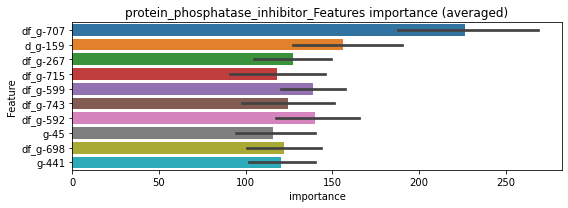

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306388	valid_1's binary_logloss: 0.047217
[200]	training's binary_logloss: 0.00635298	valid_1's binary_logloss: 0.019133
[300]	training's binary_logloss: 0.00187156	valid_1's binary_logloss: 0.0116705
[400]	training's binary_logloss: 0.00090352	valid_1's binary_logloss: 0.00922102
[500]	training's binary_logloss: 0.000613764	valid_1's binary_logloss: 0.00845
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000601432	valid_1's binary_logloss: 0.00841743


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306225	valid_1's binary_logloss: 0.0391023
[200]	training's binary_logloss: 0.00652133	valid_1's binary_logloss: 0.0124312
[300]	training's binary_logloss: 0.00202292	valid_1's binary_logloss: 0.00572999
[400]	training's binary_logloss: 0.000967634	valid_1's binary_logloss: 0.00391608
[500]	training's binary_logloss: 0.000662503	valid_1's binary_logloss: 0.00317723
[600]	training's binary_logloss: 0.000530316	valid_1's binary_logloss: 0.00283794
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000525937	valid_1's binary_logloss: 0.00282404


protein_phosphatase_inhibitor logloss: 0.005621093837536608


neg labels: 3289 → selected neg labels: 3278


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3278, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140076	valid_1's binary_logloss: 0.22353
[200]	training's binary_logloss: 0.057296	valid_1's binary_logloss: 0.163125
[300]	training's binary_logloss: 0.0245311	valid_1's binary_logloss: 0.139322
[400]	training's binary_logloss: 0.0125257	valid_1's binary_logloss: 0.130311
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00825226	valid_1's binary_logloss: 0.127776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155243	valid_1's binary_logloss: 0.220066
[200]	training's binary_logloss: 0.0733763	valid_1's binary_logloss: 0.158654
[300]	training's binary_logloss: 0.0340805	valid_1's binary_logloss: 0.130711
[400]	training's binary_logloss: 0.0166435	valid_1's binary_logloss: 0.117617
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0132638	valid_1's binary_logloss: 0.115546


1 / 3 AUC score:0.974
y_Threshold: 0.0731425, Threshold: 0.2653640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 606/3703
p_label_rate: 0.0100452 Vs.target_rate: 0.00433, Num_p_label: 40.0, conf_0:0.23883, conf_1:0.29190
threshold: 0.2653640, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 606.0/3703, y_label_rate: 0.1636511
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131999	valid_1's binary_logloss: 0.21188
[200]	training's binary_logloss: 0.0509427	valid_1's binary_logloss: 0.149717
[300]	training's binary_logloss: 0.0205629	valid_1's binary_logloss: 0.124915
[400]	training's binary_logloss: 0.00951899	valid_1's binary_logloss: 0.115474
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00916379	valid_1's binary_logloss: 0.115202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118953	valid_1's binary_logloss: 0.184135
[200]	training's binary_logloss: 0.0476953	valid_1's binary_logloss: 0.117323
[300]	training's binary_logloss: 0.0214749	valid_1's binary_logloss: 0.0874355
[400]	training's binary_logloss: 0.0101281	valid_1's binary_logloss: 0.0729969
[500]	training's binary_logloss: 0.00545384	valid_1's binary_logloss: 0.0653089
Early stopping, best iteration is:
[570]	training's binary_l

2 / 3 AUC score:0.989
y_Threshold: 0.1097177, Threshold: 0.2653640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → Positive_corect_labels: 562.0/3615
p_label_rate: 0.0153189 Vs.target_rate: 0.00433, Num_p_label: 61.0, conf_0:0.23883, conf_1:0.29190
Num_p_label: 61.0, Expected: 17.2, Adj_threshold_1: 0.2653640
Num_p_label: 49.0, Expected: 17.2, Adj_threshold_2: 0.2953640
Num_p_label: 42.0, Expected: 17.2, Adj_threshold_3: 0.3253640
Num_p_label: 34.0, Expected: 17.2, Adj_threshold_4: 0.3553640
threshold: 0.3553640, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 562.0/3615, y_label_rate: 0.1554633
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108291	valid_1's binary_logloss: 0.166177
[200]	training's binary_logloss: 0.039417	valid_1's binary_logloss: 0.104167
[300]	training's binary_logloss: 0.0158591	valid_1's binary_logloss: 0.0787819
[400]	training's binary_logloss: 0.00731068	valid_1's binary_logloss: 0.0671236
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00549758	valid_1's binary_logloss: 0.0658609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10728	valid_1's binary_logloss: 0.17039
[200]	training's binary_logloss: 0.0410005	valid_1's binary_logloss: 0.109124
[300]	training's binary_logloss: 0.0162788	valid_1's binary_logloss: 0.0817946
[400]	training's binary_logloss: 0.00786482	valid_1's binary_logloss: 0.0708489
[500]	training's binary_logloss: 0.00434397	valid_1's binary_logloss: 0.0648177
Early stopping, best iteration is:
[574]	training's binary

3 / 3 AUC score:0.996
y_Threshold: 0.1230921, Threshold: 0.3553640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 537.0/3565
p_label_rate: 0.0087896 Vs.target_rate: 0.00433, Num_p_label: 35.0, conf_0:0.31983, conf_1:0.39090
threshold: 0.3553640, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 572.0/7547, y_label_rate: 0.0757917


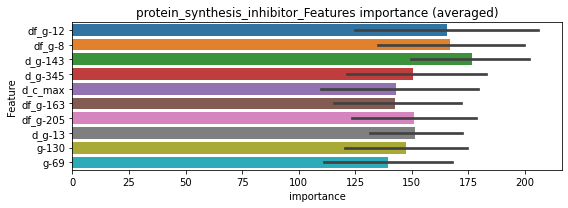

len(train_index) : 3773
len(valid_index) : 3774
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631363	valid_1's binary_logloss: 0.100523
[200]	training's binary_logloss: 0.0219176	valid_1's binary_logloss: 0.0621547
[300]	training's binary_logloss: 0.00919519	valid_1's binary_logloss: 0.0481068
[400]	training's binary_logloss: 0.00424318	valid_1's binary_logloss: 0.0426414
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00297269	valid_1's binary_logloss: 0.0407048


len(train_index) : 3774
len(valid_index) : 3773
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622211	valid_1's binary_logloss: 0.104452
[200]	training's binary_logloss: 0.0229124	valid_1's binary_logloss: 0.0679552
[300]	training's binary_logloss: 0.00929829	valid_1's binary_logloss: 0.0555622
[400]	training's binary_logloss: 0.0042869	valid_1's binary_logloss: 0.0497194
[500]	training's binary_logloss: 0.00241777	valid_1's binary_logloss: 0.047427
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00179113	valid_1's binary_logloss: 0.0463935


protein_synthesis_inhibitor logloss: 0.043548771385864986


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537778	valid_1's binary_logloss: 0.0747091
[200]	training's binary_logloss: 0.0106304	valid_1's binary_logloss: 0.0245338
[300]	training's binary_logloss: 0.00312714	valid_1's binary_logloss: 0.0125607
[400]	training's binary_logloss: 0.00155932	valid_1's binary_logloss: 0.00917202
[500]	training's binary_logloss: 0.00111796	valid_1's binary_logloss: 0.00806335
[600]	training's binary_logloss: 0.000905534	valid_1's binary_logloss: 0.00755341
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.000839478	valid_1's binary_logloss: 0.00733378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505521	valid_1's binary_logloss: 0.0687223
[200]	training's binary_logloss: 0.0104785	valid_1's binary_logloss: 0.0219456
[300]	training's binary_logloss: 0.00316612	valid_1's binary_logloss: 0.0113512
[400]	training's binary_logloss: 0.001589

1 / 3 AUC score:1.000
y_Threshold: 0.0125615, Threshold: 0.0628901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.05660, conf_1:0.06918
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0628901
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_2: 0.0928901
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.1228901
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.1528901
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.1828901
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.2128901
threshold: 0.2128901, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460334	valid_1's binary_logloss: 0.0652196
[200]	training's binary_logloss: 0.00831714	valid_1's binary_logloss: 0.0183667
[300]	training's binary_logloss: 0.00260957	valid_1's binary_logloss: 0.00828904
[400]	training's binary_logloss: 0.00137473	valid_1's binary_logloss: 0.00569354
[500]	training's binary_logloss: 0.000976242	valid_1's binary_logloss: 0.00464244
[600]	training's binary_logloss: 0.000812071	valid_1's binary_logloss: 0.00428313
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00076662	valid_1's binary_logloss: 0.00416824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445686	valid_1's binary_logloss: 0.0606354
[200]	training's binary_logloss: 0.00791894	valid_1's binary_logloss: 0.0153681
[300]	training's binary_logloss: 0.00251821	valid_1's binary_logloss: 0.00671913
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1411465, Threshold: 0.2128901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00080, Num_p_label: 25.0, conf_0:0.19160, conf_1:0.23418
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_1: 0.2128901
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.2428901
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_3: 0.2728901
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_4: 0.3028901
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.3328901
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.3628901
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.3928901
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.4228901
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_9: 0.4528901
threshold: 0.4528901, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460334	valid_1's binary_logloss: 0.0652196
[200]	training's binary_logloss: 0.00831714	valid_1's binary_logloss: 0.0183667
[300]	training's binary_logloss: 0.00260957	valid_1's binary_logloss: 0.00828904
[400]	training's binary_logloss: 0.00137473	valid_1's binary_logloss: 0.00569354
[500]	training's binary_logloss: 0.000976242	valid_1's binary_logloss: 0.00464244
[600]	training's binary_logloss: 0.000812071	valid_1's binary_logloss: 0.00428313
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00076662	valid_1's binary_logloss: 0.00416824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445686	valid_1's binary_logloss: 0.0606354
[200]	training's binary_logloss: 0.00791894	valid_1's binary_logloss: 0.0153681
[300]	training's binary_logloss: 0.00251821	valid_1's binary_logloss: 0.00671913
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1411465, Threshold: 0.4528901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.40760, conf_1:0.49818
threshold: 0.4528901, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


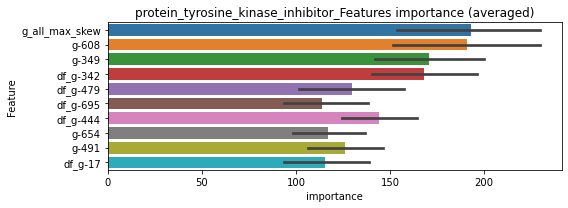

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264637	valid_1's binary_logloss: 0.0385274
[200]	training's binary_logloss: 0.00527475	valid_1's binary_logloss: 0.0140247
[300]	training's binary_logloss: 0.00159096	valid_1's binary_logloss: 0.00799901
[400]	training's binary_logloss: 0.000798291	valid_1's binary_logloss: 0.00648846
[500]	training's binary_logloss: 0.000559617	valid_1's binary_logloss: 0.00586584
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000539287	valid_1's binary_logloss: 0.00581778


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262678	valid_1's binary_logloss: 0.0384865
[200]	training's binary_logloss: 0.00483938	valid_1's binary_logloss: 0.0118641
[300]	training's binary_logloss: 0.00147567	valid_1's binary_logloss: 0.00618115
[400]	training's binary_logloss: 0.000752665	valid_1's binary_logloss: 0.00446112
[500]	training's binary_logloss: 0.000538108	valid_1's binary_logloss: 0.00393435
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000507482	valid_1's binary_logloss: 0.00384723


protein_tyrosine_kinase_inhibitor logloss: 0.0048325084882292375


neg labels: 3289 → selected neg labels: 3283


radiopaque_medium, len(trt): 56, len(othr): 3283, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125819	valid_1's binary_logloss: 0.181706
[200]	training's binary_logloss: 0.0505645	valid_1's binary_logloss: 0.11014
[300]	training's binary_logloss: 0.0195062	valid_1's binary_logloss: 0.0758108
[400]	training's binary_logloss: 0.00803894	valid_1's binary_logloss: 0.0579829
[500]	training's binary_logloss: 0.00423232	valid_1's binary_logloss: 0.0506004
[600]	training's binary_logloss: 0.00276914	valid_1's binary_logloss: 0.0470778
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.0022209	valid_1's binary_logloss: 0.045524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113347	valid_1's binary_logloss: 0.17208
[200]	training's binary_logloss: 0.0440836	valid_1's binary_logloss: 0.103473
[300]	training's binary_logloss: 0.0182685	valid_1's binary_logloss: 0.0722776
[400]	training's binary_logloss: 0.00864557	valid_1's binar

1 / 3 AUC score:0.998
y_Threshold: 0.0412296, Threshold: 0.2346408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 651/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.21118, conf_1:0.25810
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.2346408
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_2: 0.2646408
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_3: 0.2946408
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_4: 0.3246408
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_5: 0.3546408
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_6: 0.3846408
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_7: 0.4146408
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_8: 0.4446408
threshold: 0.4446408, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3797, y_label_rate: 0.1714511
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110162	valid_1's binary_logloss: 0.170177
[200]	training's binary_logloss: 0.0378474	valid_1's binary_logloss: 0.0937645
[300]	training's binary_logloss: 0.0150624	valid_1's binary_logloss: 0.0637618
[400]	training's binary_logloss: 0.00679989	valid_1's binary_logloss: 0.0484158
[500]	training's binary_logloss: 0.0037813	valid_1's binary_logloss: 0.0418491
[600]	training's binary_logloss: 0.00251571	valid_1's binary_logloss: 0.0374747
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00198334	valid_1's binary_logloss: 0.0355303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115395	valid_1's binary_logloss: 0.173529
[200]	training's binary_logloss: 0.0390758	valid_1's binary_logloss: 0.0909115
[300]	training's binary_logloss: 0.0148158	valid_1's binary_logloss: 0.0588302
[400]	training's binary_logloss: 0.00647469	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1688298, Threshold: 0.4446408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 635.0/3765
p_label_rate: 0.0085384 Vs.target_rate: 0.00235, Num_p_label: 34.0, conf_0:0.40018, conf_1:0.48910
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_1: 0.4446408
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.4746408
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_3: 0.5046408
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_4: 0.5346408
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_5: 0.5646408
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_6: 0.5946408
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_7: 0.6246408
threshold: 0.6246408, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 635.0/3765, y_label_rate: 0.1686587
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992359	valid_1's binary_logloss: 0.159508
[200]	training's binary_logloss: 0.0357533	valid_1's binary_logloss: 0.0915762
[300]	training's binary_logloss: 0.0134677	valid_1's binary_logloss: 0.0622606
[400]	training's binary_logloss: 0.00597473	valid_1's binary_logloss: 0.0488832
[500]	training's binary_logloss: 0.00333363	valid_1's binary_logloss: 0.0439486
[600]	training's binary_logloss: 0.00224448	valid_1's binary_logloss: 0.0404503
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00215528	valid_1's binary_logloss: 0.0402199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113131	valid_1's binary_logloss: 0.166282
[200]	training's binary_logloss: 0.0395443	valid_1's binary_logloss: 0.0913775
[300]	training's binary_logloss: 0.0146276	valid_1's binary_logloss: 0.0602699
[400]	training's binary_logloss: 0.00652758	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.1382419, Threshold: 0.6246408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 623.0/3741
p_label_rate: 0.0047715 Vs.target_rate: 0.00235, Num_p_label: 19.0, conf_0:0.56218, conf_1:0.68710
threshold: 0.6246408, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 642.0/7723, y_label_rate: 0.0831283


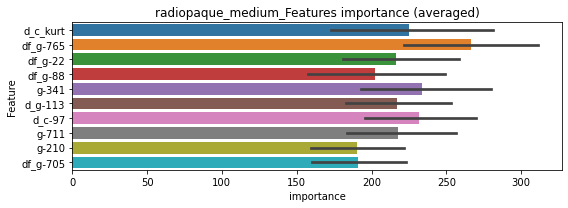

len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685044	valid_1's binary_logloss: 0.106173
[200]	training's binary_logloss: 0.0240384	valid_1's binary_logloss: 0.062267
[300]	training's binary_logloss: 0.00931867	valid_1's binary_logloss: 0.0463605
[400]	training's binary_logloss: 0.00385203	valid_1's binary_logloss: 0.0371034
[500]	training's binary_logloss: 0.00205412	valid_1's binary_logloss: 0.0335268
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00142924	valid_1's binary_logloss: 0.0323303


len(train_index) : 3862
len(valid_index) : 3861
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598218	valid_1's binary_logloss: 0.0965402
[200]	training's binary_logloss: 0.021802	valid_1's binary_logloss: 0.0581155
[300]	training's binary_logloss: 0.0083992	valid_1's binary_logloss: 0.0408676
[400]	training's binary_logloss: 0.00355267	valid_1's binary_logloss: 0.0318279
[500]	training's binary_logloss: 0.00195783	valid_1's binary_logloss: 0.0280039
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00176334	valid_1's binary_logloss: 0.0274205


radiopaque_medium logloss: 0.02987571298477987


neg labels: 3289 → selected neg labels: 3266


raf_inhibitor, len(trt): 223, len(othr): 3266, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221982	valid_1's binary_logloss: 0.364742
[200]	training's binary_logloss: 0.118704	valid_1's binary_logloss: 0.329886
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0888883	valid_1's binary_logloss: 0.321277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212829	valid_1's binary_logloss: 0.354959
[200]	training's binary_logloss: 0.119102	valid_1's binary_logloss: 0.321628


1 / 3 AUC score:0.847
y_Threshold: 0.1779252, Threshold: 0.6170996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 565 → Positive_corect_labels: 436/3354
p_label_rate: 0.0100452 Vs.target_rate: 0.00936, Num_p_label: 40.0, conf_0:0.55539, conf_1:0.67881
threshold: 0.6170996, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


[300]	training's binary_logloss: 0.0663741	valid_1's binary_logloss: 0.307972
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0638003	valid_1's binary_logloss: 0.307115


positive_y_label: 436.0/3354, y_label_rate: 0.1299940
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138332	valid_1's binary_logloss: 0.258437
[200]	training's binary_logloss: 0.0649786	valid_1's binary_logloss: 0.217904
[300]	training's binary_logloss: 0.0305328	valid_1's binary_logloss: 0.205572
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0212209	valid_1's binary_logloss: 0.201918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134866	valid_1's binary_logloss: 0.249362
[200]	training's binary_logloss: 0.0588308	valid_1's binary_logloss: 0.207719
[300]	training's binary_logloss: 0.0270395	valid_1's binary_logloss: 0.196037
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0247792	valid_1's binary_logloss: 0.195202


2 / 3 AUC score:0.926
y_Threshold: 0.1455271, Threshold: 0.6170996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 216 → Positive_corect_labels: 328.0/3138
p_label_rate: 0.0258664 Vs.target_rate: 0.00936, Num_p_label: 103.0, conf_0:0.55539, conf_1:0.67881
threshold: 0.6170996, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 328.0/3138, y_label_rate: 0.1045252
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976276	valid_1's binary_logloss: 0.192961
[200]	training's binary_logloss: 0.0353826	valid_1's binary_logloss: 0.155051
[300]	training's binary_logloss: 0.0136182	valid_1's binary_logloss: 0.139871
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.012228	valid_1's binary_logloss: 0.138559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089925	valid_1's binary_logloss: 0.187531
[200]	training's binary_logloss: 0.032963	valid_1's binary_logloss: 0.148336
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0218388	valid_1's binary_logloss: 0.142419


3 / 3 AUC score:0.954
y_Threshold: 0.1284064, Threshold: 0.6170996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 260.0/3002
p_label_rate: 0.0271220 Vs.target_rate: 0.00936, Num_p_label: 108.0, conf_0:0.55539, conf_1:0.67881
threshold: 0.6170996, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 368.0/6984, y_label_rate: 0.0526919


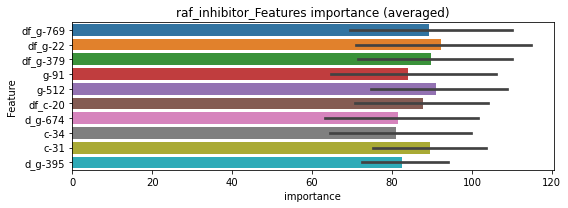

len(train_index) : 3492
len(valid_index) : 3492
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487603	valid_1's binary_logloss: 0.105969
[200]	training's binary_logloss: 0.0182777	valid_1's binary_logloss: 0.0878994


len(train_index) : 3492
len(valid_index) : 3492
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00887931	valid_1's binary_logloss: 0.0826954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524695	valid_1's binary_logloss: 0.0992906
[200]	training's binary_logloss: 0.0199036	valid_1's binary_logloss: 0.0777366
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0153818	valid_1's binary_logloss: 0.0748499


raf_inhibitor logloss: 0.07877263107464699


neg labels: 3289 → selected neg labels: 3289


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418785	valid_1's binary_logloss: 0.0602651
[200]	training's binary_logloss: 0.00693634	valid_1's binary_logloss: 0.0200891
[300]	training's binary_logloss: 0.00212549	valid_1's binary_logloss: 0.0115645
[400]	training's binary_logloss: 0.00115951	valid_1's binary_logloss: 0.00920892
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000935766	valid_1's binary_logloss: 0.0084451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444138	valid_1's binary_logloss: 0.0533944
[200]	training's binary_logloss: 0.00703132	valid_1's binary_logloss: 0.0130148
[300]	training's binary_logloss: 0.00213911	valid_1's binary_logloss: 0.00605478
[400]	training's binary_logloss: 0.00119253	valid_1's binary_logloss: 0.00440709
[500]	training's binary_logloss: 0.00087956	valid_1's binary_logloss: 0.0037755
[600]	training's binary_logloss: 0.000754

1 / 3 AUC score:1.000
y_Threshold: 0.0076584, Threshold: 0.0511231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.04601, conf_1:0.05624
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0511231
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_2: 0.0811231
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.1111231
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.1411231
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.1711231
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.2011231
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_7: 0.2311231
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.2611231
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.2911231
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.3211231
threshold: 0.3511231, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337445	valid_1's binary_logloss: 0.0506744
[200]	training's binary_logloss: 0.0053738	valid_1's binary_logloss: 0.0159024
[300]	training's binary_logloss: 0.00171806	valid_1's binary_logloss: 0.00867423
[400]	training's binary_logloss: 0.000957534	valid_1's binary_logloss: 0.00638533
[500]	training's binary_logloss: 0.000722406	valid_1's binary_logloss: 0.00573499
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000733593	valid_1's binary_logloss: 0.00567988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039022	valid_1's binary_logloss: 0.046315
[200]	training's binary_logloss: 0.00610217	valid_1's binary_logloss: 0.00939638
[300]	training's binary_logloss: 0.00183761	valid_1's binary_logloss: 0.00358935
[400]	training's binary_logloss: 0.00100848	valid_1's binary_logloss: 0.00218469
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.1335866, Threshold: 0.3511231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.31601, conf_1:0.38624
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.3511231
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.3811231
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_3: 0.4111231
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_4: 0.4411231
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_5: 0.4711231
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_6: 0.5011231
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_7: 0.5311231
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.5611231
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.5911231
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.6211231
threshold: 0.6511231, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346961	valid_1's binary_logloss: 0.0535352
[200]	training's binary_logloss: 0.00518261	valid_1's binary_logloss: 0.0154516
[300]	training's binary_logloss: 0.00166412	valid_1's binary_logloss: 0.00768376
[400]	training's binary_logloss: 0.000938036	valid_1's binary_logloss: 0.00521637
[500]	training's binary_logloss: 0.000720099	valid_1's binary_logloss: 0.00446466
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000733254	valid_1's binary_logloss: 0.00445615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365136	valid_1's binary_logloss: 0.0420582
[200]	training's binary_logloss: 0.00573062	valid_1's binary_logloss: 0.00889921
[300]	training's binary_logloss: 0.0018018	valid_1's binary_logloss: 0.00354097
[400]	training's binary_logloss: 0.00100745	valid_1's binary_logloss: 0.00229484
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.2182365, Threshold: 0.6511231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.58601, conf_1:0.71624
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.6511231
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.6811231
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.7111231
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.7411231
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.7711231
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.8011231
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.8311231
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.8611231
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.8911231
threshold: 0.8911231, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


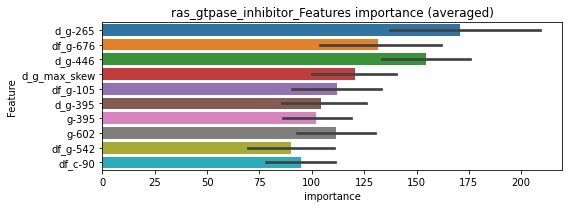

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021757	valid_1's binary_logloss: 0.03001
[200]	training's binary_logloss: 0.00346735	valid_1's binary_logloss: 0.00830902
[300]	training's binary_logloss: 0.00102733	valid_1's binary_logloss: 0.00409875
[400]	training's binary_logloss: 0.000585878	valid_1's binary_logloss: 0.00310677
[500]	training's binary_logloss: 0.000449716	valid_1's binary_logloss: 0.00277232
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000443891	valid_1's binary_logloss: 0.0027608


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222092	valid_1's binary_logloss: 0.028886
[200]	training's binary_logloss: 0.00351477	valid_1's binary_logloss: 0.00860853


ras_gtpase_inhibitor logloss: 0.0038600811378491314


[300]	training's binary_logloss: 0.00105689	valid_1's binary_logloss: 0.00514748
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000979155	valid_1's binary_logloss: 0.00495964
neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144969	valid_1's binary_logloss: 0.245232
[200]	training's binary_logloss: 0.06113	valid_1's binary_logloss: 0.175774
[300]	training's binary_logloss: 0.0271508	valid_1's binary_logloss: 0.144166
[400]	training's binary_logloss: 0.012534	valid_1's binary_logloss: 0.131687
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0119963	valid_1's binary_logloss: 0.131271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152148	valid_1's binary_logloss: 0.232238
[200]	training's binary_logloss: 0.0665987	valid_1's binary_logloss: 0.159713
[300]	training's binary_logloss: 0.0282045	valid_1's binary_logloss: 0.115895
[400]	training's binary_logloss: 0.0127707	valid_1's binary_logloss: 0.0914302
[500]	training's binary_logloss: 0.00655878	valid_1's binary_logloss: 0.0793969
[600]	training's binary_logloss: 0.00396672	valid_1's binary_logl

1 / 3 AUC score:0.984
y_Threshold: 0.0884826, Threshold: 0.3264039, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 194 → Positive_corect_labels: 624/3739
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.29376, conf_1:0.35904
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.3264039
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_2: 0.3564039
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_3: 0.3864039
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.4164039
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_5: 0.4464039
threshold: 0.4464039, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 624.0/3739, y_label_rate: 0.1668895
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127573	valid_1's binary_logloss: 0.219932
[200]	training's binary_logloss: 0.048663	valid_1's binary_logloss: 0.152932
[300]	training's binary_logloss: 0.0199845	valid_1's binary_logloss: 0.126402
[400]	training's binary_logloss: 0.00840942	valid_1's binary_logloss: 0.117097
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00660246	valid_1's binary_logloss: 0.115267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14251	valid_1's binary_logloss: 0.201957
[200]	training's binary_logloss: 0.0577992	valid_1's binary_logloss: 0.122392
[300]	training's binary_logloss: 0.0232552	valid_1's binary_logloss: 0.0806857
[400]	training's binary_logloss: 0.0100555	valid_1's binary_logloss: 0.0608598
[500]	training's binary_logloss: 0.00531697	valid_1's binary_logloss: 0.0504497
[600]	training's binary_logloss: 0.00331847	valid_1's binary_

2 / 3 AUC score:0.988
y_Threshold: 0.1586769, Threshold: 0.4464039, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 584.0/3659
p_label_rate: 0.0115520 Vs.target_rate: 0.00281, Num_p_label: 46.0, conf_0:0.40176, conf_1:0.49104
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_1: 0.4464039
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_2: 0.4764039
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_3: 0.5064039
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_4: 0.5364039
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_5: 0.5664039
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_6: 0.5964039
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_7: 0.6264039
threshold: 0.6264039, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 584.0/3659, y_label_rate: 0.1596064
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121545	valid_1's binary_logloss: 0.189425
[200]	training's binary_logloss: 0.0473137	valid_1's binary_logloss: 0.124897
[300]	training's binary_logloss: 0.0186833	valid_1's binary_logloss: 0.0917148
[400]	training's binary_logloss: 0.00836148	valid_1's binary_logloss: 0.0766987
[500]	training's binary_logloss: 0.0043859	valid_1's binary_logloss: 0.0701798
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.0030314	valid_1's binary_logloss: 0.0666897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121769	valid_1's binary_logloss: 0.189566
[200]	training's binary_logloss: 0.0432805	valid_1's binary_logloss: 0.111879
[300]	training's binary_logloss: 0.0164688	valid_1's binary_logloss: 0.079007
[400]	training's binary_logloss: 0.00746907	valid_1's binary_logloss: 0.0644683
[500]	training's binary_logloss: 0.00405071	valid_1's bina

3 / 3 AUC score:0.997
y_Threshold: 0.1371091, Threshold: 0.6264039, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 555.0/3601
p_label_rate: 0.0055249 Vs.target_rate: 0.00281, Num_p_label: 22.0, conf_0:0.56376, conf_1:0.68904
threshold: 0.6264039, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 577.0/7583, y_label_rate: 0.0760913


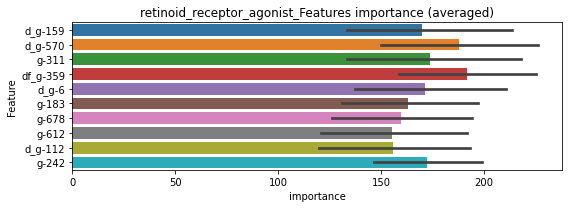

len(train_index) : 3791
len(valid_index) : 3792
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699584	valid_1's binary_logloss: 0.120584
[200]	training's binary_logloss: 0.0256688	valid_1's binary_logloss: 0.078239
[300]	training's binary_logloss: 0.00977034	valid_1's binary_logloss: 0.0595456
[400]	training's binary_logloss: 0.00413246	valid_1's binary_logloss: 0.0521802
[500]	training's binary_logloss: 0.0021719	valid_1's binary_logloss: 0.0479894
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00185775	valid_1's binary_logloss: 0.0472524


len(train_index) : 3792
len(valid_index) : 3791
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733305	valid_1's binary_logloss: 0.112391
[200]	training's binary_logloss: 0.026766	valid_1's binary_logloss: 0.0698931
[300]	training's binary_logloss: 0.00948485	valid_1's binary_logloss: 0.0511609
[400]	training's binary_logloss: 0.00412687	valid_1's binary_logloss: 0.044231
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00258211	valid_1's binary_logloss: 0.0419486


retinoid_receptor_agonist logloss: 0.04460085165341193


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246473	valid_1's binary_logloss: 0.0326103
[200]	training's binary_logloss: 0.0031053	valid_1's binary_logloss: 0.00731547
[300]	training's binary_logloss: 0.000953398	valid_1's binary_logloss: 0.00359836
[400]	training's binary_logloss: 0.000575538	valid_1's binary_logloss: 0.00264055
[500]	training's binary_logloss: 0.000451426	valid_1's binary_logloss: 0.00227885
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000443128	valid_1's binary_logloss: 0.00224074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256381	valid_1's binary_logloss: 0.0308706
[200]	training's binary_logloss: 0.0032665	valid_1's binary_logloss: 0.00613543
[300]	training's binary_logloss: 0.00101116	valid_1's binary_logloss: 0.00270875
[400]	training's binary_logloss: 0.000615547	valid_1's binary_logloss: 0.00191124
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0027851, Threshold: 0.0118121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.01063, conf_1:0.01299
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0118121
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.0418121
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.0718121
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.1018121
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.1318121
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1618121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1918121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.2218121
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.2518121
threshold: 0.2518121, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215947	valid_1's binary_logloss: 0.0264678
[200]	training's binary_logloss: 0.00251221	valid_1's binary_logloss: 0.00435448
[300]	training's binary_logloss: 0.000787423	valid_1's binary_logloss: 0.00165841
[400]	training's binary_logloss: 0.000463989	valid_1's binary_logloss: 0.00106061
[500]	training's binary_logloss: 0.000369299	valid_1's binary_logloss: 0.000877766
[600]	training's binary_logloss: 0.000352033	valid_1's binary_logloss: 0.000838101
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000352031	valid_1's binary_logloss: 0.000838095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213969	valid_1's binary_logloss: 0.0255447
[200]	training's binary_logloss: 0.00252923	valid_1's binary_logloss: 0.00377655
[300]	training's binary_logloss: 0.000800981	valid_1's binary_logloss: 0.00133762
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.2233836, Threshold: 0.2518121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.22663, conf_1:0.27699
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.2518121
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.2818121
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.3118121
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.3418121
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.3718121
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.4018121
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.4318121
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.4618121
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.4918121
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.5218121
threshold: 0.5518121, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215947	valid_1's binary_logloss: 0.0264678
[200]	training's binary_logloss: 0.00251221	valid_1's binary_logloss: 0.00435448
[300]	training's binary_logloss: 0.000787423	valid_1's binary_logloss: 0.00165841
[400]	training's binary_logloss: 0.000463989	valid_1's binary_logloss: 0.00106061
[500]	training's binary_logloss: 0.000369299	valid_1's binary_logloss: 0.000877766
[600]	training's binary_logloss: 0.000352033	valid_1's binary_logloss: 0.000838101
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000352031	valid_1's binary_logloss: 0.000838095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213969	valid_1's binary_logloss: 0.0255447
[200]	training's binary_logloss: 0.00252923	valid_1's binary_logloss: 0.00377655
[300]	training's binary_logloss: 0.000800981	valid_1's binary_logloss: 0.00133762
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.2233836, Threshold: 0.5518121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.49663, conf_1:0.60699
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.5518121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.5818121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.6118121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.6418121
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.6718121
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.7018121
threshold: 0.7018121, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


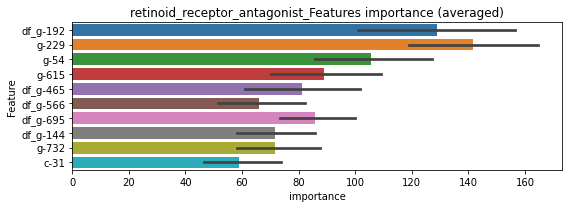

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120478	valid_1's binary_logloss: 0.0169726
[200]	training's binary_logloss: 0.00146291	valid_1's binary_logloss: 0.00509666
[300]	training's binary_logloss: 0.000462749	valid_1's binary_logloss: 0.00314919
[400]	training's binary_logloss: 0.000278243	valid_1's binary_logloss: 0.0025571
[500]	training's binary_logloss: 0.000222896	valid_1's binary_logloss: 0.00238591
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000210933	valid_1's binary_logloss: 0.00234876


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120961	valid_1's binary_logloss: 0.0161294
[200]	training's binary_logloss: 0.00143936	valid_1's binary_logloss: 0.0029555
[300]	training's binary_logloss: 0.000456348	valid_1's binary_logloss: 0.00126359
[400]	training's binary_logloss: 0.000279398	valid_1's binary_logloss: 0.000894526
[500]	training's binary_logloss: 0.000220687	valid_1's binary_logloss: 0.00076407
[600]	training's binary_logloss: 0.000201816	valid_1's binary_logloss: 0.000722006
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000201816	valid_1's binary_logloss: 0.000722006


retinoid_receptor_antagonist logloss: 0.0015354870620215332


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094278	valid_1's binary_logloss: 0.14721
[200]	training's binary_logloss: 0.0340511	valid_1's binary_logloss: 0.0843424
[300]	training's binary_logloss: 0.0122583	valid_1's binary_logloss: 0.0542262
[400]	training's binary_logloss: 0.00492729	valid_1's binary_logloss: 0.0381952
[500]	training's binary_logloss: 0.00262842	valid_1's binary_logloss: 0.03168
[600]	training's binary_logloss: 0.00179221	valid_1's binary_logloss: 0.0286601
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00172343	valid_1's binary_logloss: 0.028431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874282	valid_1's binary_logloss: 0.131021
[200]	training's binary_logloss: 0.029186	valid_1's binary_logloss: 0.0722093
[300]	training's binary_logloss: 0.00966235	valid_1's binary_logloss: 0.0474771
[400]	training's binary_logloss: 0.00410117	valid_1's bi

1 / 3 AUC score:0.999
y_Threshold: 0.0414568, Threshold: 0.1532073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00147, Num_p_label: 40.0, conf_0:0.13789, conf_1:0.16853
Num_p_label: 40.0, Expected: 5.9, Adj_threshold_1: 0.1532073
Num_p_label: 33.0, Expected: 5.9, Adj_threshold_2: 0.1832073
Num_p_label: 27.0, Expected: 5.9, Adj_threshold_3: 0.2132073
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_4: 0.2432073
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_5: 0.2732073
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_6: 0.3032073
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_7: 0.3332073
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_8: 0.3632073
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_9: 0.3932073
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_10: 0.4232073
threshold: 0.4532073, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885998	valid_1's binary_logloss: 0.133652
[200]	training's binary_logloss: 0.0262755	valid_1's binary_logloss: 0.0626594
[300]	training's binary_logloss: 0.00850109	valid_1's binary_logloss: 0.0376083
[400]	training's binary_logloss: 0.00374776	valid_1's binary_logloss: 0.0281034
[500]	training's binary_logloss: 0.00217958	valid_1's binary_logloss: 0.0240739
[600]	training's binary_logloss: 0.00161448	valid_1's binary_logloss: 0.0229132
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00155578	valid_1's binary_logloss: 0.0226757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809824	valid_1's binary_logloss: 0.12804
[200]	training's binary_logloss: 0.0239398	valid_1's binary_logloss: 0.0658391
[300]	training's binary_logloss: 0.0081735	valid_1's binary_logloss: 0.0422009
[400]	training's binary_logloss: 0.00358818	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.1703945, Threshold: 0.4532073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 643.0/3781
p_label_rate: 0.0072828 Vs.target_rate: 0.00147, Num_p_label: 29.0, conf_0:0.40789, conf_1:0.49853
Num_p_label: 29.0, Expected: 5.9, Adj_threshold_1: 0.4532073
Num_p_label: 23.0, Expected: 5.9, Adj_threshold_2: 0.4832073
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_3: 0.5132073
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_4: 0.5432073
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_5: 0.5732073
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_6: 0.6032073
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_7: 0.6332073
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_8: 0.6632073
Num_p_label: 9.0, Expected: 5.9, Adj_threshold_9: 0.6932073
threshold: 0.6932073, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 643.0/3781, y_label_rate: 0.1700608
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795167	valid_1's binary_logloss: 0.115153
[200]	training's binary_logloss: 0.022617	valid_1's binary_logloss: 0.0556996
[300]	training's binary_logloss: 0.00772621	valid_1's binary_logloss: 0.0336787
[400]	training's binary_logloss: 0.00340154	valid_1's binary_logloss: 0.0245812
[500]	training's binary_logloss: 0.00206033	valid_1's binary_logloss: 0.020974
[600]	training's binary_logloss: 0.00153783	valid_1's binary_logloss: 0.0196277
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00148214	valid_1's binary_logloss: 0.019444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769209	valid_1's binary_logloss: 0.128453
[200]	training's binary_logloss: 0.0209856	valid_1's binary_logloss: 0.0618206
[300]	training's binary_logloss: 0.00724785	valid_1's binary_logloss: 0.0388289
[400]	training's binary_logloss: 0.00325106	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.1515283, Threshold: 0.6932073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 634.0/3763
p_label_rate: 0.0027624 Vs.target_rate: 0.00147, Num_p_label: 11.0, conf_0:0.62389, conf_1:0.76253
threshold: 0.6932073, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 645.0/7745, y_label_rate: 0.0832795


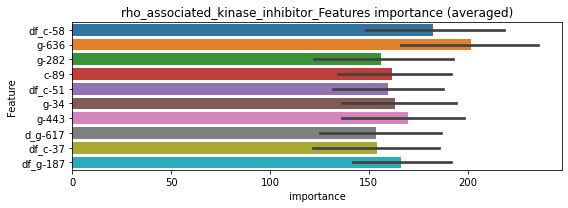

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448291	valid_1's binary_logloss: 0.0741162
[200]	training's binary_logloss: 0.013479	valid_1's binary_logloss: 0.0385917
[300]	training's binary_logloss: 0.00444368	valid_1's binary_logloss: 0.0252964
[400]	training's binary_logloss: 0.00191432	valid_1's binary_logloss: 0.0204127
[500]	training's binary_logloss: 0.00113104	valid_1's binary_logloss: 0.0182669
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00105807	valid_1's binary_logloss: 0.0181983


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467094	valid_1's binary_logloss: 0.0769966
[200]	training's binary_logloss: 0.0144066	valid_1's binary_logloss: 0.0400603
[300]	training's binary_logloss: 0.00468507	valid_1's binary_logloss: 0.0250718
[400]	training's binary_logloss: 0.00195692	valid_1's binary_logloss: 0.0196127
[500]	training's binary_logloss: 0.00113377	valid_1's binary_logloss: 0.01754
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00109152	valid_1's binary_logloss: 0.0175281


rho_associated_kinase_inhibitor logloss: 0.017863226320673487


neg labels: 3289 → selected neg labels: 3284


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3284, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854658	valid_1's binary_logloss: 0.132778
[200]	training's binary_logloss: 0.0243951	valid_1's binary_logloss: 0.0661666
[300]	training's binary_logloss: 0.00803534	valid_1's binary_logloss: 0.0411835
[400]	training's binary_logloss: 0.00355132	valid_1's binary_logloss: 0.0303003
[500]	training's binary_logloss: 0.00216456	valid_1's binary_logloss: 0.0266148
[600]	training's binary_logloss: 0.00155995	valid_1's binary_logloss: 0.0247338
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00129062	valid_1's binary_logloss: 0.0235963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877407	valid_1's binary_logloss: 0.130931
[200]	training's binary_logloss: 0.0252416	valid_1's binary_logloss: 0.0609985
[300]	training's binary_logloss: 0.00844004	valid_1's binary_logloss: 0.036101
[400]	training's binary_logloss: 0.00370827	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0387241, Threshold: 0.1948721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.17538, conf_1:0.21436
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1948721
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.2248721
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_3: 0.2548721
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.2848721
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.3148721
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_6: 0.3448721
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_7: 0.3748721
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_8: 0.4048721
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_9: 0.4348721
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_10: 0.4648721
threshold: 0.4948721, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773015	valid_1's binary_logloss: 0.120851
[200]	training's binary_logloss: 0.0207861	valid_1's binary_logloss: 0.0564469
[300]	training's binary_logloss: 0.00685908	valid_1's binary_logloss: 0.0321059
[400]	training's binary_logloss: 0.00325138	valid_1's binary_logloss: 0.0234384
[500]	training's binary_logloss: 0.00200747	valid_1's binary_logloss: 0.0197994
[600]	training's binary_logloss: 0.00146556	valid_1's binary_logloss: 0.0178763
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00143378	valid_1's binary_logloss: 0.0176948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792305	valid_1's binary_logloss: 0.118845
[200]	training's binary_logloss: 0.0194081	valid_1's binary_logloss: 0.0457575
[300]	training's binary_logloss: 0.00670858	valid_1's binary_logloss: 0.0262494
[400]	training's binary_logloss: 0.00314871	valid

2 / 3 AUC score:1.000
y_Threshold: 0.2312749, Threshold: 0.4948721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0082873 Vs.target_rate: 0.00155, Num_p_label: 33.0, conf_0:0.44538, conf_1:0.54436
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_1: 0.4948721
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_2: 0.5248721
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_3: 0.5548721
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.5848721
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.6148721
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.6448721
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.6748721
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_8: 0.7048721
threshold: 0.7048721, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810088	valid_1's binary_logloss: 0.113738
[200]	training's binary_logloss: 0.0211301	valid_1's binary_logloss: 0.0470985
[300]	training's binary_logloss: 0.00704617	valid_1's binary_logloss: 0.0256328
[400]	training's binary_logloss: 0.00329096	valid_1's binary_logloss: 0.017579
[500]	training's binary_logloss: 0.00204699	valid_1's binary_logloss: 0.0141525
[600]	training's binary_logloss: 0.00145339	valid_1's binary_logloss: 0.0122801
[700]	training's binary_logloss: 0.00118536	valid_1's binary_logloss: 0.0114169
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.00112734	valid_1's binary_logloss: 0.0111995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756647	valid_1's binary_logloss: 0.118451
[200]	training's binary_logloss: 0.0195489	valid_1's binary_logloss: 0.0568023
[300]	training's binary_logloss: 0.00656416	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.2149280, Threshold: 0.7048721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0035158 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.63438, conf_1:0.77536
threshold: 0.7048721, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 659.0/7768, y_label_rate: 0.0848352


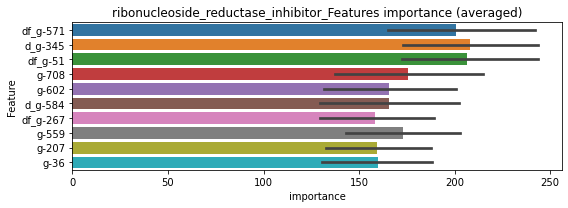

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501142	valid_1's binary_logloss: 0.0736014
[200]	training's binary_logloss: 0.0128895	valid_1's binary_logloss: 0.0351888
[300]	training's binary_logloss: 0.00414434	valid_1's binary_logloss: 0.0221228
[400]	training's binary_logloss: 0.00179058	valid_1's binary_logloss: 0.0175462
[500]	training's binary_logloss: 0.00106869	valid_1's binary_logloss: 0.0160474
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000842803	valid_1's binary_logloss: 0.0152965


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047359	valid_1's binary_logloss: 0.078297
[200]	training's binary_logloss: 0.012708	valid_1's binary_logloss: 0.0408868
[300]	training's binary_logloss: 0.00387774	valid_1's binary_logloss: 0.0278926
[400]	training's binary_logloss: 0.00174951	valid_1's binary_logloss: 0.0230949
[500]	training's binary_logloss: 0.00106669	valid_1's binary_logloss: 0.0210193
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000986808	valid_1's binary_logloss: 0.0207949


ribonucleoside_reductase_inhibitor logloss: 0.018045681129233326


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633312	valid_1's binary_logloss: 0.092482
[200]	training's binary_logloss: 0.0136559	valid_1's binary_logloss: 0.0315731
[300]	training's binary_logloss: 0.0041992	valid_1's binary_logloss: 0.0158181
[400]	training's binary_logloss: 0.00200607	valid_1's binary_logloss: 0.0116908
[500]	training's binary_logloss: 0.00134194	valid_1's binary_logloss: 0.0102132
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00118953	valid_1's binary_logloss: 0.00986395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622394	valid_1's binary_logloss: 0.0866
[200]	training's binary_logloss: 0.0161414	valid_1's binary_logloss: 0.0374731
[300]	training's binary_logloss: 0.00473915	valid_1's binary_logloss: 0.0213591
[400]	training's binary_logloss: 0.00211622	valid_1's binary_logloss: 0.0155944
[500]	training's binary_logloss: 0.00137954	valid_1

1 / 3 AUC score:1.000
y_Threshold: 0.0157893, Threshold: 0.0768027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.06912, conf_1:0.08448
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0768027
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.1068027
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.1368027
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.1668027
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.1968027
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.2268027
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_7: 0.2568027
threshold: 0.2568027, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579331	valid_1's binary_logloss: 0.0863338
[200]	training's binary_logloss: 0.0125724	valid_1's binary_logloss: 0.0322156
[300]	training's binary_logloss: 0.00376682	valid_1's binary_logloss: 0.0169292
[400]	training's binary_logloss: 0.00180646	valid_1's binary_logloss: 0.0121697
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00140759	valid_1's binary_logloss: 0.0110252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528791	valid_1's binary_logloss: 0.07991
[200]	training's binary_logloss: 0.0110653	valid_1's binary_logloss: 0.0297612
[300]	training's binary_logloss: 0.00333738	valid_1's binary_logloss: 0.0165689
[400]	training's binary_logloss: 0.00167076	valid_1's binary_logloss: 0.0128851
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00125523	valid_1's binary_logloss: 0.0114456


2 / 3 AUC score:1.000
y_Threshold: 0.1445868, Threshold: 0.2568027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0080362 Vs.target_rate: 0.00105, Num_p_label: 32.0, conf_0:0.23112, conf_1:0.28248
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_1: 0.2568027
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.2868027
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_3: 0.3168027
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.3468027
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.3768027
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.4068027
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.4368027
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.4668027
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.4968027
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_10: 0.5268027
threshold: 0.5268027, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570019	valid_1's binary_logloss: 0.083534
[200]	training's binary_logloss: 0.0119307	valid_1's binary_logloss: 0.0304486
[300]	training's binary_logloss: 0.0036581	valid_1's binary_logloss: 0.0159688
[400]	training's binary_logloss: 0.00175759	valid_1's binary_logloss: 0.011381
[500]	training's binary_logloss: 0.00120116	valid_1's binary_logloss: 0.00961607
[600]	training's binary_logloss: 0.000966702	valid_1's binary_logloss: 0.00895829
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000949166	valid_1's binary_logloss: 0.00888873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503634	valid_1's binary_logloss: 0.0741124
[200]	training's binary_logloss: 0.0106918	valid_1's binary_logloss: 0.0251091
[300]	training's binary_logloss: 0.00333559	valid_1's binary_logloss: 0.0122693
[400]	training's binary_logloss: 0.00165477	v

3 / 3 AUC score:1.000
y_Threshold: 0.1484816, Threshold: 0.5268027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0027624 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.47412, conf_1:0.57948
threshold: 0.5268027, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 662.0/7780, y_label_rate: 0.0850900


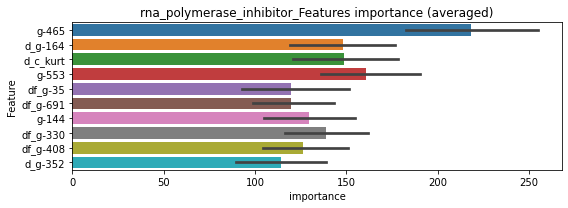

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312619	valid_1's binary_logloss: 0.0471592
[200]	training's binary_logloss: 0.00610672	valid_1's binary_logloss: 0.0171128
[300]	training's binary_logloss: 0.00186056	valid_1's binary_logloss: 0.010852
[400]	training's binary_logloss: 0.000934932	valid_1's binary_logloss: 0.00916579
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000755533	valid_1's binary_logloss: 0.00876357


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337118	valid_1's binary_logloss: 0.0515613
[200]	training's binary_logloss: 0.00804549	valid_1's binary_logloss: 0.0198408
[300]	training's binary_logloss: 0.00245587	valid_1's binary_logloss: 0.0101501
[400]	training's binary_logloss: 0.00111048	valid_1's binary_logloss: 0.0072252
[500]	training's binary_logloss: 0.000725443	valid_1's binary_logloss: 0.00616732
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000622657	valid_1's binary_logloss: 0.00587188


rna_polymerase_inhibitor logloss: 0.007317722476674659


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186885	valid_1's binary_logloss: 0.3382
[200]	training's binary_logloss: 0.102209	valid_1's binary_logloss: 0.320488
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.101585	valid_1's binary_logloss: 0.320272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20209	valid_1's binary_logloss: 0.343562
[200]	training's binary_logloss: 0.1132	valid_1's binary_logloss: 0.310828
[300]	training's binary_logloss: 0.0686255	valid_1's binary_logloss: 0.295783
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0576845	valid_1's binary_logloss: 0.293828


1 / 3 AUC score:0.838
y_Threshold: 0.1622464, Threshold: 0.4100736, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 559 → Positive_corect_labels: 435/3339
p_label_rate: 0.0100452 Vs.target_rate: 0.00991, Num_p_label: 40.0, conf_0:0.36907, conf_1:0.45108
threshold: 0.4100736, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 435.0/3339, y_label_rate: 0.1302785
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108202	valid_1's binary_logloss: 0.195095
[200]	training's binary_logloss: 0.0434925	valid_1's binary_logloss: 0.156169
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0238603	valid_1's binary_logloss: 0.14641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113293	valid_1's binary_logloss: 0.207131
[200]	training's binary_logloss: 0.0482614	valid_1's binary_logloss: 0.161817


2 / 3 AUC score:0.969
y_Threshold: 0.1426469, Threshold: 0.4100736, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 354.0/3177
p_label_rate: 0.0301356 Vs.target_rate: 0.00991, Num_p_label: 120.0, conf_0:0.36907, conf_1:0.45108
Num_p_label: 120.0, Expected: 39.5, Adj_threshold_1: 0.4100736
Num_p_label: 115.0, Expected: 39.5, Adj_threshold_2: 0.4400736


[300]	training's binary_logloss: 0.0205276	valid_1's binary_logloss: 0.144305
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0186367	valid_1's binary_logloss: 0.143385


Num_p_label: 110.0, Expected: 39.5, Adj_threshold_3: 0.4700736
Num_p_label: 97.0, Expected: 39.5, Adj_threshold_4: 0.5000736
Num_p_label: 90.0, Expected: 39.5, Adj_threshold_5: 0.5300736
Num_p_label: 83.0, Expected: 39.5, Adj_threshold_6: 0.5600736
Num_p_label: 76.0, Expected: 39.5, Adj_threshold_7: 0.5900736
threshold: 0.5900736, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 354.0/3177, y_label_rate: 0.1114259
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821481	valid_1's binary_logloss: 0.151491
[200]	training's binary_logloss: 0.0291528	valid_1's binary_logloss: 0.115823
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0128488	valid_1's binary_logloss: 0.105007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709936	valid_1's binary_logloss: 0.156602
[200]	training's binary_logloss: 0.0244903	valid_1's binary_logloss: 0.126868


3 / 3 AUC score:0.978
y_Threshold: 0.1043830, Threshold: 0.5900736, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 303.0/3075
p_label_rate: 0.0308890 Vs.target_rate: 0.00991, Num_p_label: 123.0, conf_0:0.53107, conf_1:0.64908
Num_p_label: 123.0, Expected: 39.5, Adj_threshold_1: 0.5900736
Num_p_label: 120.0, Expected: 39.5, Adj_threshold_2: 0.6200736


[300]	training's binary_logloss: 0.00982185	valid_1's binary_logloss: 0.113362
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0085947	valid_1's binary_logloss: 0.112487


Num_p_label: 117.0, Expected: 39.5, Adj_threshold_3: 0.6500736
Num_p_label: 115.0, Expected: 39.5, Adj_threshold_4: 0.6800736
Num_p_label: 110.0, Expected: 39.5, Adj_threshold_5: 0.7100736
Num_p_label: 103.0, Expected: 39.5, Adj_threshold_6: 0.7400736
Num_p_label: 94.0, Expected: 39.5, Adj_threshold_7: 0.7700736
Num_p_label: 89.0, Expected: 39.5, Adj_threshold_8: 0.8000736
Num_p_label: 82.0, Expected: 39.5, Adj_threshold_9: 0.8300736
Num_p_label: 73.0, Expected: 39.5, Adj_threshold_10: 0.8600736
threshold: 0.8600736, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 376.0/7057, y_label_rate: 0.0532804


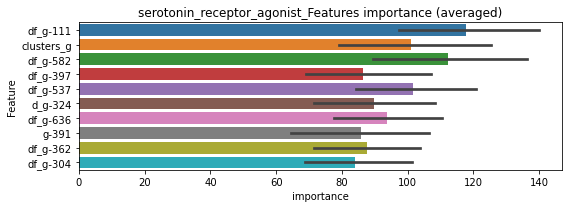

len(train_index) : 3528
len(valid_index) : 3529
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364446	valid_1's binary_logloss: 0.0731141
[200]	training's binary_logloss: 0.0122069	valid_1's binary_logloss: 0.0590237
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00841098	valid_1's binary_logloss: 0.0576419


len(train_index) : 3529
len(valid_index) : 3528
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382448	valid_1's binary_logloss: 0.0678248
[200]	training's binary_logloss: 0.012562	valid_1's binary_logloss: 0.050855
[300]	training's binary_logloss: 0.00498073	valid_1's binary_logloss: 0.0474341
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00454896	valid_1's binary_logloss: 0.0471655


serotonin_receptor_agonist logloss: 0.052404432636506314


neg labels: 3289 → selected neg labels: 3239


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3239, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231629	valid_1's binary_logloss: 0.414779
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.230121	valid_1's binary_logloss: 0.414584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238362	valid_1's binary_logloss: 0.410583


1 / 3 AUC score:0.692
y_Threshold: 0.2012760, Threshold: 0.5424693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 837 → Positive_corect_labels: 294/3049
p_label_rate: 0.0100452 Vs.target_rate: 0.01696, Num_p_label: 40.0, conf_0:0.48822, conf_1:0.59672
threshold: 0.5424693, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 294.0/3049, y_label_rate: 0.0964251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.153048	valid_1's binary_logloss: 0.399887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962166	valid_1's binary_logloss: 0.220231
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0510578	valid_1's binary_logloss: 0.207494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091714	valid_1's binary_logloss: 0.220206


2 / 3 AUC score:0.882
y_Threshold: 0.1439913, Threshold: 0.5424693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 234 → Positive_corect_labels: 177.0/2815
p_label_rate: 0.0326469 Vs.target_rate: 0.01696, Num_p_label: 130.0, conf_0:0.48822, conf_1:0.59672
threshold: 0.5424693, positive_p_label: 130.0/3982, p_label_rate: 0.0326469


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0453268	valid_1's binary_logloss: 0.209496


positive_y_label: 177.0/2815, y_label_rate: 0.0628774
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432634	valid_1's binary_logloss: 0.126525
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0287116	valid_1's binary_logloss: 0.12116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416321	valid_1's binary_logloss: 0.125525


3 / 3 AUC score:0.923
y_Threshold: 0.1077683, Threshold: 0.5424693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 129.0/2719
p_label_rate: 0.0452034 Vs.target_rate: 0.01696, Num_p_label: 180.0, conf_0:0.48822, conf_1:0.59672
threshold: 0.5424693, positive_p_label: 180.0/3982, p_label_rate: 0.0452034


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0150286	valid_1's binary_logloss: 0.111947


positive_y_label: 309.0/6701, y_label_rate: 0.0461125


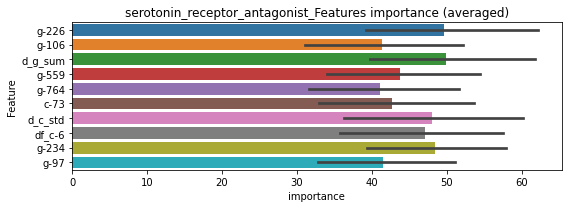

len(train_index) : 3350
len(valid_index) : 3351
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3351
len(valid_index) : 3350


[100]	training's binary_logloss: 0.0211964	valid_1's binary_logloss: 0.075576
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0147333	valid_1's binary_logloss: 0.0736159


================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021467	valid_1's binary_logloss: 0.0680567


serotonin_receptor_antagonist logloss: 0.06961979917359391


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0102624	valid_1's binary_logloss: 0.0656225
neg labels: 3289 → selected neg labels: 3285


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3285, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935687	valid_1's binary_logloss: 0.144639
[200]	training's binary_logloss: 0.0293584	valid_1's binary_logloss: 0.0803185
[300]	training's binary_logloss: 0.0104786	valid_1's binary_logloss: 0.0556156
[400]	training's binary_logloss: 0.00469966	valid_1's binary_logloss: 0.044239
[500]	training's binary_logloss: 0.0027395	valid_1's binary_logloss: 0.0395261
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00219748	valid_1's binary_logloss: 0.0381889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872918	valid_1's binary_logloss: 0.139631
[200]	training's binary_logloss: 0.02707	valid_1's binary_logloss: 0.0802145
[300]	training's binary_logloss: 0.010389	valid_1's binary_logloss: 0.0571119
[400]	training's binary_logloss: 0.00489218	valid_1's binary_logloss: 0.0475181
[500]	training's binary_logloss: 0.00287115	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0321890, Threshold: 0.3481077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 649/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00185, Num_p_label: 40.0, conf_0:0.31330, conf_1:0.38292
Num_p_label: 40.0, Expected: 7.4, Adj_threshold_1: 0.3481077
Num_p_label: 37.0, Expected: 7.4, Adj_threshold_2: 0.3781077
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_3: 0.4081077
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_4: 0.4381077
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_5: 0.4681077
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_6: 0.4981077
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_7: 0.5281077
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_8: 0.5581077
Num_p_label: 22.0, Expected: 7.4, Adj_threshold_9: 0.5881077
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_10: 0.6181077
threshold: 0.6481077, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839061	valid_1's binary_logloss: 0.134022
[200]	training's binary_logloss: 0.0246318	valid_1's binary_logloss: 0.0793958
[300]	training's binary_logloss: 0.00842386	valid_1's binary_logloss: 0.058102
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0053251	valid_1's binary_logloss: 0.0533159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781487	valid_1's binary_logloss: 0.120809
[200]	training's binary_logloss: 0.0222658	valid_1's binary_logloss: 0.0629051
[300]	training's binary_logloss: 0.00796112	valid_1's binary_logloss: 0.0426958
[400]	training's binary_logloss: 0.0037512	valid_1's binary_logloss: 0.0360636
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00301149	valid_1's binary_logloss: 0.0345947


2 / 3 AUC score:0.996
y_Threshold: 0.1854768, Threshold: 0.6481077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 627.0/3750
p_label_rate: 0.0195881 Vs.target_rate: 0.00185, Num_p_label: 78.0, conf_0:0.58330, conf_1:0.71292
Num_p_label: 78.0, Expected: 7.4, Adj_threshold_1: 0.6481077
Num_p_label: 73.0, Expected: 7.4, Adj_threshold_2: 0.6781077
Num_p_label: 70.0, Expected: 7.4, Adj_threshold_3: 0.7081077
Num_p_label: 65.0, Expected: 7.4, Adj_threshold_4: 0.7381077
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_5: 0.7681077
Num_p_label: 52.0, Expected: 7.4, Adj_threshold_6: 0.7981077
Num_p_label: 44.0, Expected: 7.4, Adj_threshold_7: 0.8281077
Num_p_label: 35.0, Expected: 7.4, Adj_threshold_8: 0.8581077
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_9: 0.8881077
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_10: 0.9181077
threshold: 0.9481077, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 627.0/3750, y_label_rate: 0.1672000
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819836	valid_1's binary_logloss: 0.110916
[200]	training's binary_logloss: 0.0241057	valid_1's binary_logloss: 0.0507089
[300]	training's binary_logloss: 0.00800013	valid_1's binary_logloss: 0.0292606
[400]	training's binary_logloss: 0.00364433	valid_1's binary_logloss: 0.0201638
[500]	training's binary_logloss: 0.00221919	valid_1's binary_logloss: 0.0161288
[600]	training's binary_logloss: 0.00163202	valid_1's binary_logloss: 0.0141874
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00137269	valid_1's binary_logloss: 0.0131972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702483	valid_1's binary_logloss: 0.113088
[200]	training's binary_logloss: 0.0199413	valid_1's binary_logloss: 0.0636715
[300]	training's binary_logloss: 0.00675318	valid_1's binary_logloss: 0.046491


3 / 3 AUC score:0.999
y_Threshold: 0.1586052, Threshold: 0.9481077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 615.0/3726
p_label_rate: 0.0070316 Vs.target_rate: 0.00185, Num_p_label: 28.0, conf_0:0.85330, conf_1:1.04292
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_1: 0.9481077
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_2: 0.9781077
Num_p_label: 0.0, Expected: 7.4, Adj_threshold_3: 1.0081077


[400]	training's binary_logloss: 0.00325801	valid_1's binary_logloss: 0.0416528
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00324368	valid_1's binary_logloss: 0.0416065


threshold: 1.0081077, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 615.0/7708, y_label_rate: 0.0797872


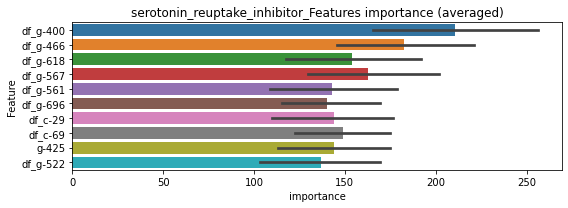

len(train_index) : 3854
len(valid_index) : 3854
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045387	valid_1's binary_logloss: 0.0731632
[200]	training's binary_logloss: 0.0135069	valid_1's binary_logloss: 0.0404056
[300]	training's binary_logloss: 0.00471126	valid_1's binary_logloss: 0.0296802
[400]	training's binary_logloss: 0.00211499	valid_1's binary_logloss: 0.0245992
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00130139	valid_1's binary_logloss: 0.0224285


len(train_index) : 3854
len(valid_index) : 3854
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467014	valid_1's binary_logloss: 0.0722651
[200]	training's binary_logloss: 0.0141423	valid_1's binary_logloss: 0.0357366
[300]	training's binary_logloss: 0.00496746	valid_1's binary_logloss: 0.0233791
[400]	training's binary_logloss: 0.00215213	valid_1's binary_logloss: 0.0180715
[500]	training's binary_logloss: 0.00128337	valid_1's binary_logloss: 0.0161345
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00102465	valid_1's binary_logloss: 0.0158043


serotonin_reuptake_inhibitor logloss: 0.019116382721815258


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719428	valid_1's binary_logloss: 0.106863
[200]	training's binary_logloss: 0.0211814	valid_1's binary_logloss: 0.0544128
[300]	training's binary_logloss: 0.0073745	valid_1's binary_logloss: 0.0348872
[400]	training's binary_logloss: 0.00347665	valid_1's binary_logloss: 0.0272911
[500]	training's binary_logloss: 0.00214574	valid_1's binary_logloss: 0.0238982
[600]	training's binary_logloss: 0.00156849	valid_1's binary_logloss: 0.0221989
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.00147519	valid_1's binary_logloss: 0.021936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715055	valid_1's binary_logloss: 0.105427
[200]	training's binary_logloss: 0.021584	valid_1's binary_logloss: 0.0536819
[300]	training's binary_logloss: 0.00749518	valid_1's binary_logloss: 0.035557
[400]	training's binary_logloss: 0.00343258	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0321974, Threshold: 0.2031127, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.18280, conf_1:0.22342
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.2031127
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.2331127
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_3: 0.2631127
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_4: 0.2931127
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_5: 0.3231127
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.3531127
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_7: 0.3831127
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.4131127
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_9: 0.4431127
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_10: 0.4731127
threshold: 0.5031127, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597286	valid_1's binary_logloss: 0.0903921
[200]	training's binary_logloss: 0.0150735	valid_1's binary_logloss: 0.0400001
[300]	training's binary_logloss: 0.005063	valid_1's binary_logloss: 0.0254951
[400]	training's binary_logloss: 0.00257477	valid_1's binary_logloss: 0.0204262
[500]	training's binary_logloss: 0.00168189	valid_1's binary_logloss: 0.0184073
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00134121	valid_1's binary_logloss: 0.0175966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613622	valid_1's binary_logloss: 0.0860813
[200]	training's binary_logloss: 0.016137	valid_1's binary_logloss: 0.0363343
[300]	training's binary_logloss: 0.00562106	valid_1's binary_logloss: 0.0204318
[400]	training's binary_logloss: 0.00274573	valid_1's binary_logloss: 0.0145329
[500]	training's binary_logloss: 0.00177158	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.2021401, Threshold: 0.5031127, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3793
p_label_rate: 0.0095429 Vs.target_rate: 0.00151, Num_p_label: 38.0, conf_0:0.45280, conf_1:0.55342
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.5031127
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.5331127
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.5631127
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_4: 0.5931127
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_5: 0.6231127
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_6: 0.6531127
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_7: 0.6831127
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.7131127
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.7431127
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_10: 0.7731127
threshold: 0.8031127, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 649.0/3793, y_label_rate: 0.1711047
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570203	valid_1's binary_logloss: 0.0870091
[200]	training's binary_logloss: 0.0143156	valid_1's binary_logloss: 0.0379753
[300]	training's binary_logloss: 0.00491257	valid_1's binary_logloss: 0.0247192
[400]	training's binary_logloss: 0.0024685	valid_1's binary_logloss: 0.0198161
[500]	training's binary_logloss: 0.00164011	valid_1's binary_logloss: 0.0187217
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00151191	valid_1's binary_logloss: 0.0183732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576005	valid_1's binary_logloss: 0.0970911
[200]	training's binary_logloss: 0.0138789	valid_1's binary_logloss: 0.0512265
[300]	training's binary_logloss: 0.00453841	valid_1's binary_logloss: 0.0375891
[400]	training's binary_logloss: 0.00228655	valid_1's binary_logloss: 0.0329515
Early stopping, best iteration is:
[422]	trainin

3 / 3 AUC score:0.999
y_Threshold: 0.1727967, Threshold: 0.8031127, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 635.0/3765
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.72280, conf_1:0.88342
threshold: 0.8031127, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 646.0/7747, y_label_rate: 0.0833871


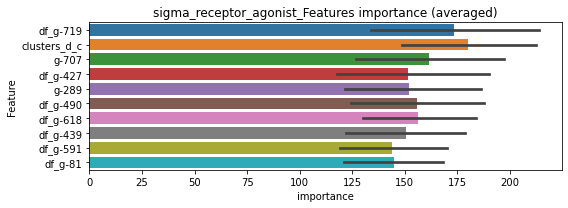

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368706	valid_1's binary_logloss: 0.0562058
[200]	training's binary_logloss: 0.0101044	valid_1's binary_logloss: 0.0283189
[300]	training's binary_logloss: 0.0032107	valid_1's binary_logloss: 0.018546
[400]	training's binary_logloss: 0.00150088	valid_1's binary_logloss: 0.0160959
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00122292	valid_1's binary_logloss: 0.0156516


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352241	valid_1's binary_logloss: 0.0562819
[200]	training's binary_logloss: 0.00943303	valid_1's binary_logloss: 0.0257984
[300]	training's binary_logloss: 0.0032211	valid_1's binary_logloss: 0.015926
[400]	training's binary_logloss: 0.00151614	valid_1's binary_logloss: 0.0124333
[500]	training's binary_logloss: 0.00096275	valid_1's binary_logloss: 0.0109329
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000859693	valid_1's binary_logloss: 0.0107012


sigma_receptor_agonist logloss: 0.01317671294373595


neg labels: 3289 → selected neg labels: 3285


sigma_receptor_antagonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965233	valid_1's binary_logloss: 0.135264
[200]	training's binary_logloss: 0.0323236	valid_1's binary_logloss: 0.0700129
[300]	training's binary_logloss: 0.0115228	valid_1's binary_logloss: 0.0432252
[400]	training's binary_logloss: 0.00500834	valid_1's binary_logloss: 0.0320051
[500]	training's binary_logloss: 0.00279613	valid_1's binary_logloss: 0.0267578
[600]	training's binary_logloss: 0.00195408	valid_1's binary_logloss: 0.024596
[700]	training's binary_logloss: 0.00154935	valid_1's binary_logloss: 0.0232444
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.00140035	valid_1's binary_logloss: 0.0227957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932354	valid_1's binary_logloss: 0.133658
[200]	training's binary_logloss: 0.0340217	valid_1's binary_logloss: 0.0716348
[300]	training's binary_logloss: 0.0115736	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0387810, Threshold: 0.1952054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.17568, conf_1:0.21473
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1952054
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.2252054
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.2552054
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.2852054
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_5: 0.3152054
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_6: 0.3452054
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.3752054
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.4052054
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.4352054
threshold: 0.4352054, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904928	valid_1's binary_logloss: 0.126946
[200]	training's binary_logloss: 0.0299369	valid_1's binary_logloss: 0.0600301
[300]	training's binary_logloss: 0.00999051	valid_1's binary_logloss: 0.0328289
[400]	training's binary_logloss: 0.00432023	valid_1's binary_logloss: 0.0235565
[500]	training's binary_logloss: 0.00246968	valid_1's binary_logloss: 0.0195175
[600]	training's binary_logloss: 0.00174484	valid_1's binary_logloss: 0.0179352
[700]	training's binary_logloss: 0.00140928	valid_1's binary_logloss: 0.0169993
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00143158	valid_1's binary_logloss: 0.0169898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872534	valid_1's binary_logloss: 0.134478
[200]	training's binary_logloss: 0.0252392	valid_1's binary_logloss: 0.0636794
[300]	training's binary_logloss: 0.00829973	valid

2 / 3 AUC score:1.000
y_Threshold: 0.2087070, Threshold: 0.4352054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0065294 Vs.target_rate: 0.00151, Num_p_label: 26.0, conf_0:0.39168, conf_1:0.47873
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.4352054
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.4652054
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.4952054
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.5252054
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.5552054
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.5852054
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.6152054
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_8: 0.6452054
threshold: 0.6452054, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 647.0/3790, y_label_rate: 0.1707124
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857758	valid_1's binary_logloss: 0.13312
[200]	training's binary_logloss: 0.0245011	valid_1's binary_logloss: 0.0642429
[300]	training's binary_logloss: 0.00837099	valid_1's binary_logloss: 0.0396105
[400]	training's binary_logloss: 0.00367128	valid_1's binary_logloss: 0.0290473
[500]	training's binary_logloss: 0.00220714	valid_1's binary_logloss: 0.0240603
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00168443	valid_1's binary_logloss: 0.0224811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847252	valid_1's binary_logloss: 0.11231
[200]	training's binary_logloss: 0.0250773	valid_1's binary_logloss: 0.0478729
[300]	training's binary_logloss: 0.00856288	valid_1's binary_logloss: 0.0259344
[400]	training's binary_logloss: 0.00380085	valid_1's binary_logloss: 0.0170615
[500]	training's binary_logloss: 0.00227032	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.1688105, Threshold: 0.6452054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 639.0/3774
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.58068, conf_1:0.70973
threshold: 0.6452054, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/7756, y_label_rate: 0.0840640


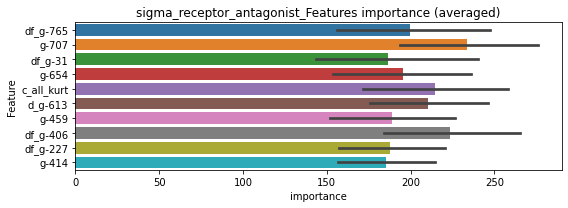

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539154	valid_1's binary_logloss: 0.0807909
[200]	training's binary_logloss: 0.0163468	valid_1's binary_logloss: 0.0432819
[300]	training's binary_logloss: 0.00583875	valid_1's binary_logloss: 0.031067
[400]	training's binary_logloss: 0.00235379	valid_1's binary_logloss: 0.0264523
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00238451	valid_1's binary_logloss: 0.0264123


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050303	valid_1's binary_logloss: 0.079984
[200]	training's binary_logloss: 0.014636	valid_1's binary_logloss: 0.0414996
[300]	training's binary_logloss: 0.00499847	valid_1's binary_logloss: 0.0269667
[400]	training's binary_logloss: 0.00213105	valid_1's binary_logloss: 0.0220901
[500]	training's binary_logloss: 0.00122971	valid_1's binary_logloss: 0.0198106
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00121861	valid_1's binary_logloss: 0.0197907


sigma_receptor_antagonist logloss: 0.02310150403601089


neg labels: 3289 → selected neg labels: 3285


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615067	valid_1's binary_logloss: 0.0943961
[200]	training's binary_logloss: 0.0156775	valid_1's binary_logloss: 0.0423779
[300]	training's binary_logloss: 0.00475173	valid_1's binary_logloss: 0.0252749
[400]	training's binary_logloss: 0.00222418	valid_1's binary_logloss: 0.0201287
[500]	training's binary_logloss: 0.00142209	valid_1's binary_logloss: 0.0182764
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00146305	valid_1's binary_logloss: 0.0181305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644161	valid_1's binary_logloss: 0.0915301
[200]	training's binary_logloss: 0.0165141	valid_1's binary_logloss: 0.0334158
[300]	training's binary_logloss: 0.00532761	valid_1's binary_logloss: 0.0158015
[400]	training's binary_logloss: 0.002395	valid_1's binary_logloss: 0.00939849
[500]	training's binary_logloss: 0.00150651	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0180328, Threshold: 0.1076347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.09687, conf_1:0.11840
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.1076347
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.1376347
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.1676347
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.1976347
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.2276347
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_6: 0.2576347
threshold: 0.2576347, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565254	valid_1's binary_logloss: 0.0793834
[200]	training's binary_logloss: 0.0125924	valid_1's binary_logloss: 0.0264299
[300]	training's binary_logloss: 0.00399854	valid_1's binary_logloss: 0.0117246
[400]	training's binary_logloss: 0.00192598	valid_1's binary_logloss: 0.00714827
[500]	training's binary_logloss: 0.00127813	valid_1's binary_logloss: 0.00549286
[600]	training's binary_logloss: 0.00101924	valid_1's binary_logloss: 0.0048613
[700]	training's binary_logloss: 0.000895127	valid_1's binary_logloss: 0.00451377
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.000853831	valid_1's binary_logloss: 0.00442767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542678	valid_1's binary_logloss: 0.0913603
[200]	training's binary_logloss: 0.0119509	valid_1's binary_logloss: 0.03825


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00387216	valid_1's binary_logloss: 0.0247844
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00297267	valid_1's binary_logloss: 0.0220566


y_Threshold: 0.1148357, Threshold: 0.2576347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0097941 Vs.target_rate: 0.00105, Num_p_label: 39.0, conf_0:0.23187, conf_1:0.28340
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_1: 0.2576347
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_2: 0.2876347
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_3: 0.3176347
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_4: 0.3476347
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_5: 0.3776347
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_6: 0.4076347
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_7: 0.4376347
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.4676347
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.4976347
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_10: 0.5276347
threshold: 0.5276347, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549631	valid_1's binary_logloss: 0.079813
[200]	training's binary_logloss: 0.0121502	valid_1's binary_logloss: 0.0281247
[300]	training's binary_logloss: 0.00381528	valid_1's binary_logloss: 0.0127875
[400]	training's binary_logloss: 0.00190714	valid_1's binary_logloss: 0.00834691
[500]	training's binary_logloss: 0.00127049	valid_1's binary_logloss: 0.00649035
[600]	training's binary_logloss: 0.00101306	valid_1's binary_logloss: 0.00567961
[700]	training's binary_logloss: 0.000893203	valid_1's binary_logloss: 0.00521591
Early stopping, best iteration is:
[737]	training's binary_logloss: 0.000878976	valid_1's binary_logloss: 0.00515379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521099	valid_1's binary_logloss: 0.0688885
[200]	training's binary_logloss: 0.0117317	valid_1's binary_logloss: 0.0225467
[300]	training's binary_logloss: 0.003708

3 / 3 AUC score:1.000
y_Threshold: 0.2044614, Threshold: 0.5276347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.47487, conf_1:0.58040
threshold: 0.5276347, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 659.0/7776, y_label_rate: 0.0847479


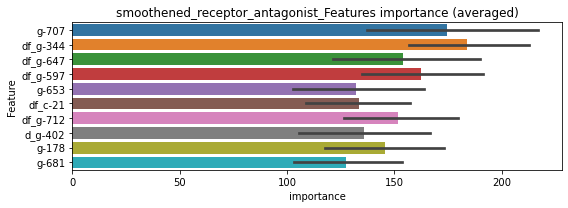

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354909	valid_1's binary_logloss: 0.0539287
[200]	training's binary_logloss: 0.00881951	valid_1's binary_logloss: 0.025035
[300]	training's binary_logloss: 0.00265533	valid_1's binary_logloss: 0.0168534


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00142051	valid_1's binary_logloss: 0.014564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348787	valid_1's binary_logloss: 0.0499865
[200]	training's binary_logloss: 0.00932776	valid_1's binary_logloss: 0.0215804
[300]	training's binary_logloss: 0.00287036	valid_1's binary_logloss: 0.0122406


smoothened_receptor_antagonist logloss: 0.012280628252256771


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00154632	valid_1's binary_logloss: 0.00999722
neg labels: 3289 → selected neg labels: 3261


sodium_channel_inhibitor, len(trt): 267, len(othr): 3261, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206141	valid_1's binary_logloss: 0.335623
[200]	training's binary_logloss: 0.118161	valid_1's binary_logloss: 0.312654
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0880601	valid_1's binary_logloss: 0.305333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197489	valid_1's binary_logloss: 0.332605
[200]	training's binary_logloss: 0.115386	valid_1's binary_logloss: 0.298171


1 / 3 AUC score:0.863
y_Threshold: 0.1632473, Threshold: 0.3736780, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 539 → Positive_corect_labels: 448/3374
p_label_rate: 0.0100452 Vs.target_rate: 0.01121, Num_p_label: 40.0, conf_0:0.33631, conf_1:0.41105


[300]	training's binary_logloss: 0.0688968	valid_1's binary_logloss: 0.284679
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0655825	valid_1's binary_logloss: 0.284217


threshold: 0.3736780, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 448.0/3374, y_label_rate: 0.1327801
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119038	valid_1's binary_logloss: 0.226875
[200]	training's binary_logloss: 0.0506226	valid_1's binary_logloss: 0.189309
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0413612	valid_1's binary_logloss: 0.184702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1197	valid_1's binary_logloss: 0.232117


2 / 3 AUC score:0.950
y_Threshold: 0.1739437, Threshold: 0.3736780, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0516148	valid_1's binary_logloss: 0.191591
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0410594	valid_1's binary_logloss: 0.185889


Remove_noisy_labels: 206 → Positive_corect_labels: 345.0/3168
p_label_rate: 0.0283777 Vs.target_rate: 0.01121, Num_p_label: 113.0, conf_0:0.33631, conf_1:0.41105
threshold: 0.3736780, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 345.0/3168, y_label_rate: 0.1089015
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801201	valid_1's binary_logloss: 0.160953
[200]	training's binary_logloss: 0.0284892	valid_1's binary_logloss: 0.119607
[300]	training's binary_logloss: 0.0113798	valid_1's binary_logloss: 0.108
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0121284	valid_1's binary_logloss: 0.10762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863486	valid_1's binary_logloss: 0.154441
[200]	training's binary_logloss: 0.0315986	valid_1's binary_logloss: 0.113078


3 / 3 AUC score:0.980
y_Threshold: 0.1614790, Threshold: 0.3736780, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 306.0/3090
p_label_rate: 0.0278754 Vs.target_rate: 0.01121, Num_p_label: 111.0, conf_0:0.33631, conf_1:0.41105
threshold: 0.3736780, positive_p_label: 111.0/3982, p_label_rate: 0.0278754


[300]	training's binary_logloss: 0.0127263	valid_1's binary_logloss: 0.0994967
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0119562	valid_1's binary_logloss: 0.098845


positive_y_label: 417.0/7072, y_label_rate: 0.0589649


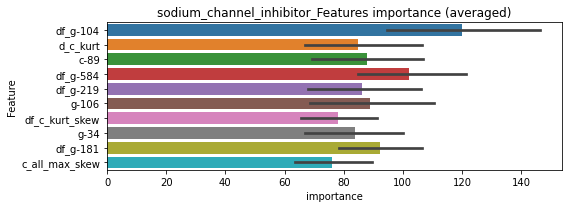

len(train_index) : 3536
len(valid_index) : 3536
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541521	valid_1's binary_logloss: 0.112646
[200]	training's binary_logloss: 0.0187017	valid_1's binary_logloss: 0.0883367


len(train_index) : 3536
len(valid_index) : 3536
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0114815	valid_1's binary_logloss: 0.0848238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530283	valid_1's binary_logloss: 0.0956769
[200]	training's binary_logloss: 0.0200222	valid_1's binary_logloss: 0.0703038
[300]	training's binary_logloss: 0.00846373	valid_1's binary_logloss: 0.0591321


sodium_channel_inhibitor logloss: 0.06989449942021073


[400]	training's binary_logloss: 0.00420205	valid_1's binary_logloss: 0.0550298
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00444905	valid_1's binary_logloss: 0.0549652
neg labels: 3289 → selected neg labels: 3282


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3282, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733129	valid_1's binary_logloss: 0.102061
[200]	training's binary_logloss: 0.0184563	valid_1's binary_logloss: 0.042446
[300]	training's binary_logloss: 0.00560973	valid_1's binary_logloss: 0.0242089
[400]	training's binary_logloss: 0.00259289	valid_1's binary_logloss: 0.0181831
[500]	training's binary_logloss: 0.00165679	valid_1's binary_logloss: 0.0166222
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00131271	valid_1's binary_logloss: 0.0157345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644652	valid_1's binary_logloss: 0.103836
[200]	training's binary_logloss: 0.0171012	valid_1's binary_logloss: 0.0442138
[300]	training's binary_logloss: 0.00558291	valid_1's binary_logloss: 0.0272785
[400]	training's binary_logloss: 0.00264453	valid_1's binary_logloss: 0.0210994
[500]	training's binary_logloss: 0.00167696	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0167060, Threshold: 0.0701742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.06316, conf_1:0.07719
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.0701742
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_2: 0.1001742
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_3: 0.1301742
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_4: 0.1601742
threshold: 0.1601742, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06435	valid_1's binary_logloss: 0.0933238
[200]	training's binary_logloss: 0.0155691	valid_1's binary_logloss: 0.0375578
[300]	training's binary_logloss: 0.00530485	valid_1's binary_logloss: 0.0221634
[400]	training's binary_logloss: 0.00243544	valid_1's binary_logloss: 0.0162962
[500]	training's binary_logloss: 0.00154673	valid_1's binary_logloss: 0.0140148
[600]	training's binary_logloss: 0.00117114	valid_1's binary_logloss: 0.0129748
[700]	training's binary_logloss: 0.00100302	valid_1's binary_logloss: 0.012402
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000969444	valid_1's binary_logloss: 0.0122152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631006	valid_1's binary_logloss: 0.10133
[200]	training's binary_logloss: 0.0172372	valid_1's binary_logloss: 0.0452945
[300]	training's binary_logloss: 0.00528309	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.1162091, Threshold: 0.1601742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.14416, conf_1:0.17619
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.1601742
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.1901742
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_3: 0.2201742
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_4: 0.2501742
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_5: 0.2801742
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_6: 0.3101742
threshold: 0.3101742, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 652.0/3798, y_label_rate: 0.1716693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061539	valid_1's binary_logloss: 0.0934823
[200]	training's binary_logloss: 0.0154393	valid_1's binary_logloss: 0.0368759
[300]	training's binary_logloss: 0.00477082	valid_1's binary_logloss: 0.0196515
[400]	training's binary_logloss: 0.00230492	valid_1's binary_logloss: 0.0146602
[500]	training's binary_logloss: 0.00150458	valid_1's binary_logloss: 0.0125921
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00141786	valid_1's binary_logloss: 0.012345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060436	valid_1's binary_logloss: 0.0980375
[200]	training's binary_logloss: 0.0152006	valid_1's binary_logloss: 0.0400582
[300]	training's binary_logloss: 0.0049818	valid_1's binary_logloss: 0.0227503
[400]	training's binary_logloss: 0.00234282	valid_1's binary_logloss: 0.0165459
[500]	training's binary_logloss: 0.00153464	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.1156513, Threshold: 0.3101742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0020090 Vs.target_rate: 0.00134, Num_p_label: 8.0, conf_0:0.27916, conf_1:0.34119
threshold: 0.3101742, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 658.0/7776, y_label_rate: 0.0846193


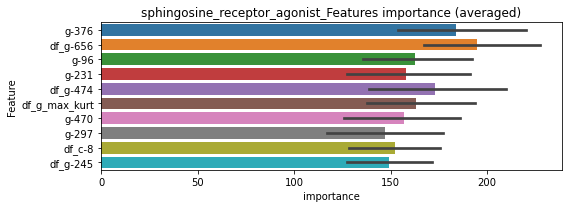

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336406	valid_1's binary_logloss: 0.0658225
[200]	training's binary_logloss: 0.00850194	valid_1's binary_logloss: 0.0346821
[300]	training's binary_logloss: 0.00262507	valid_1's binary_logloss: 0.024896
[400]	training's binary_logloss: 0.0012187	valid_1's binary_logloss: 0.0223559
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000978139	valid_1's binary_logloss: 0.0216171


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362584	valid_1's binary_logloss: 0.0487716
[200]	training's binary_logloss: 0.00991379	valid_1's binary_logloss: 0.0195437
[300]	training's binary_logloss: 0.00314752	valid_1's binary_logloss: 0.0100653
[400]	training's binary_logloss: 0.00144332	valid_1's binary_logloss: 0.00705472
[500]	training's binary_logloss: 0.000894816	valid_1's binary_logloss: 0.00593102
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000726232	valid_1's binary_logloss: 0.00566494


sphingosine_receptor_agonist logloss: 0.013641039002107933


neg labels: 3289 → selected neg labels: 3278


src_inhibitor, len(trt): 71, len(othr): 3278, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131258	valid_1's binary_logloss: 0.200993
[200]	training's binary_logloss: 0.0576255	valid_1's binary_logloss: 0.133863
[300]	training's binary_logloss: 0.0238033	valid_1's binary_logloss: 0.0957684
[400]	training's binary_logloss: 0.0107843	valid_1's binary_logloss: 0.0771303
[500]	training's binary_logloss: 0.00585035	valid_1's binary_logloss: 0.0684977
[600]	training's binary_logloss: 0.00368227	valid_1's binary_logloss: 0.0620967
[700]	training's binary_logloss: 0.00265769	valid_1's binary_logloss: 0.0587828
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00227531	valid_1's binary_logloss: 0.0574834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138799	valid_1's binary_logloss: 0.211599
[200]	training's binary_logloss: 0.0580689	valid_1's binary_logloss: 0.140746
[300]	training's binary_logloss: 0.0252145	valid_1's bi

1 / 3 AUC score:0.993
y_Threshold: 0.0504252, Threshold: 0.2463383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 638/3767
p_label_rate: 0.0100452 Vs.target_rate: 0.00298, Num_p_label: 40.0, conf_0:0.22170, conf_1:0.27097
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_1: 0.2463383
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_2: 0.2763383
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_3: 0.3063383
Num_p_label: 21.0, Expected: 11.9, Adj_threshold_4: 0.3363383
threshold: 0.3363383, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3767, y_label_rate: 0.1693655
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115144	valid_1's binary_logloss: 0.195394
[200]	training's binary_logloss: 0.0457305	valid_1's binary_logloss: 0.13159
[300]	training's binary_logloss: 0.0186492	valid_1's binary_logloss: 0.0971612
[400]	training's binary_logloss: 0.00846411	valid_1's binary_logloss: 0.0807401
[500]	training's binary_logloss: 0.00454765	valid_1's binary_logloss: 0.0710344
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00362879	valid_1's binary_logloss: 0.0693798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115278	valid_1's binary_logloss: 0.187723
[200]	training's binary_logloss: 0.0434515	valid_1's binary_logloss: 0.119953
[300]	training's binary_logloss: 0.0179396	valid_1's binary_logloss: 0.0890898
[400]	training's binary_logloss: 0.00831691	valid_1's binary_logloss: 0.0736533
[500]	training's binary_logloss: 0.00466185	valid_1's bi

2 / 3 AUC score:0.994
y_Threshold: 0.1362733, Threshold: 0.3363383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 605.0/3701
p_label_rate: 0.0158212 Vs.target_rate: 0.00298, Num_p_label: 63.0, conf_0:0.30270, conf_1:0.36997
Num_p_label: 63.0, Expected: 11.9, Adj_threshold_1: 0.3363383
Num_p_label: 58.0, Expected: 11.9, Adj_threshold_2: 0.3663383
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_3: 0.3963383
Num_p_label: 47.0, Expected: 11.9, Adj_threshold_4: 0.4263383
Num_p_label: 41.0, Expected: 11.9, Adj_threshold_5: 0.4563383
Num_p_label: 34.0, Expected: 11.9, Adj_threshold_6: 0.4863383
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_7: 0.5163383
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_8: 0.5463383
Num_p_label: 19.0, Expected: 11.9, Adj_threshold_9: 0.5763383
threshold: 0.5763383, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 605.0/3701, y_label_rate: 0.1634693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107151	valid_1's binary_logloss: 0.167774
[200]	training's binary_logloss: 0.040085	valid_1's binary_logloss: 0.102441
[300]	training's binary_logloss: 0.0159756	valid_1's binary_logloss: 0.0705222
[400]	training's binary_logloss: 0.0072985	valid_1's binary_logloss: 0.0556192
[500]	training's binary_logloss: 0.00409869	valid_1's binary_logloss: 0.049016
[600]	training's binary_logloss: 0.00274761	valid_1's binary_logloss: 0.0445846
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00251444	valid_1's binary_logloss: 0.043742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108404	valid_1's binary_logloss: 0.185276
[200]	training's binary_logloss: 0.0385237	valid_1's binary_logloss: 0.112662
[300]	training's binary_logloss: 0.0142872	valid_1's binary_logloss: 0.0763829
[400]	training's binary_logloss: 0.00655943	valid_1's binar

3 / 3 AUC score:0.999
y_Threshold: 0.1831834, Threshold: 0.5763383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 586.0/3663
p_label_rate: 0.0075339 Vs.target_rate: 0.00298, Num_p_label: 30.0, conf_0:0.51870, conf_1:0.63397
threshold: 0.5763383, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 616.0/7645, y_label_rate: 0.0805755


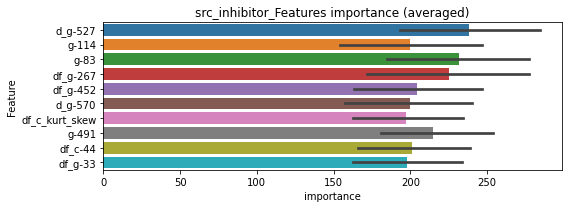

len(train_index) : 3822
len(valid_index) : 3823
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670674	valid_1's binary_logloss: 0.106358
[200]	training's binary_logloss: 0.0246397	valid_1's binary_logloss: 0.0678104
[300]	training's binary_logloss: 0.0102002	valid_1's binary_logloss: 0.0515593
[400]	training's binary_logloss: 0.00444088	valid_1's binary_logloss: 0.0442132
[500]	training's binary_logloss: 0.00236859	valid_1's binary_logloss: 0.0404013
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00198238	valid_1's binary_logloss: 0.0393772


len(train_index) : 3823
len(valid_index) : 3822
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613075	valid_1's binary_logloss: 0.107053
[200]	training's binary_logloss: 0.0227652	valid_1's binary_logloss: 0.0697933
[300]	training's binary_logloss: 0.00914899	valid_1's binary_logloss: 0.0524359
[400]	training's binary_logloss: 0.00419224	valid_1's binary_logloss: 0.0445335
[500]	training's binary_logloss: 0.00233626	valid_1's binary_logloss: 0.0406823
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00193651	valid_1's binary_logloss: 0.0399775


src_inhibitor logloss: 0.039677318771177


neg labels: 3289 → selected neg labels: 3275


steroid, len(trt): 79, len(othr): 3275, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121525	valid_1's binary_logloss: 0.19113
[200]	training's binary_logloss: 0.052972	valid_1's binary_logloss: 0.131592
[300]	training's binary_logloss: 0.0227758	valid_1's binary_logloss: 0.101451
[400]	training's binary_logloss: 0.0111725	valid_1's binary_logloss: 0.0885507
[500]	training's binary_logloss: 0.00607624	valid_1's binary_logloss: 0.0808538
[600]	training's binary_logloss: 0.00355067	valid_1's binary_logloss: 0.077533
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00333049	valid_1's binary_logloss: 0.0769161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121103	valid_1's binary_logloss: 0.199875
[200]	training's binary_logloss: 0.0503133	valid_1's binary_logloss: 0.14074
[300]	training's binary_logloss: 0.0210678	valid_1's binary_logloss: 0.117161
[400]	training's binary_logloss: 0.0101955	valid_1's binary_lo

1 / 3 AUC score:0.985
y_Threshold: 0.0630844, Threshold: 0.4252317, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 199 → Positive_corect_labels: 621/3731
p_label_rate: 0.0100452 Vs.target_rate: 0.00332, Num_p_label: 40.0, conf_0:0.38271, conf_1:0.46775
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_1: 0.4252317
Num_p_label: 36.0, Expected: 13.2, Adj_threshold_2: 0.4552317
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_3: 0.4852317
Num_p_label: 27.0, Expected: 13.2, Adj_threshold_4: 0.5152317
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_5: 0.5452317
threshold: 0.5452317, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 621.0/3731, y_label_rate: 0.1664433
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104489	valid_1's binary_logloss: 0.185866
[200]	training's binary_logloss: 0.0384562	valid_1's binary_logloss: 0.122995
[300]	training's binary_logloss: 0.0140648	valid_1's binary_logloss: 0.0905779
[400]	training's binary_logloss: 0.0064748	valid_1's binary_logloss: 0.0764766
[500]	training's binary_logloss: 0.00374427	valid_1's binary_logloss: 0.0706642
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00287198	valid_1's binary_logloss: 0.068328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970147	valid_1's binary_logloss: 0.170999
[200]	training's binary_logloss: 0.0339443	valid_1's binary_logloss: 0.10884
[300]	training's binary_logloss: 0.0132003	valid_1's binary_logloss: 0.0891025
[400]	training's binary_logloss: 0.00622039	valid_1's binary_logloss: 0.0818504
Early stopping, best iteration is:
[445]	training's binar

2 / 3 AUC score:0.993
y_Threshold: 0.1651421, Threshold: 0.5452317, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 585.0/3659
p_label_rate: 0.0233551 Vs.target_rate: 0.00332, Num_p_label: 93.0, conf_0:0.49071, conf_1:0.59975
Num_p_label: 93.0, Expected: 13.2, Adj_threshold_1: 0.5452317
Num_p_label: 88.0, Expected: 13.2, Adj_threshold_2: 0.5752317
Num_p_label: 84.0, Expected: 13.2, Adj_threshold_3: 0.6052317
Num_p_label: 78.0, Expected: 13.2, Adj_threshold_4: 0.6352317
Num_p_label: 73.0, Expected: 13.2, Adj_threshold_5: 0.6652317
Num_p_label: 69.0, Expected: 13.2, Adj_threshold_6: 0.6952317
Num_p_label: 58.0, Expected: 13.2, Adj_threshold_7: 0.7252317
Num_p_label: 51.0, Expected: 13.2, Adj_threshold_8: 0.7552317
Num_p_label: 45.0, Expected: 13.2, Adj_threshold_9: 0.7852317
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_10: 0.8152317
threshold: 0.8452317, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 585.0/3659, y_label_rate: 0.15987

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922133	valid_1's binary_logloss: 0.153863
[200]	training's binary_logloss: 0.0302664	valid_1's binary_logloss: 0.0907158
[300]	training's binary_logloss: 0.0114512	valid_1's binary_logloss: 0.0674105
[400]	training's binary_logloss: 0.00522093	valid_1's binary_logloss: 0.0584886
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00448933	valid_1's binary_logloss: 0.0569244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937092	valid_1's binary_logloss: 0.150761
[200]	training's binary_logloss: 0.0299664	valid_1's binary_logloss: 0.0882493
[300]	training's binary_logloss: 0.0108466	valid_1's binary_logloss: 0.0623655
[400]	training's binary_logloss: 0.00507252	valid_1's binary_logloss: 0.0521289
[500]	training's binary_logloss: 0.00302768	valid_1's binary_logloss: 0.0480315
Early stopping, best iteration is:
[540]	training's

3 / 3 AUC score:0.998
y_Threshold: 0.1447172, Threshold: 0.8452317, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 561.0/3611
p_label_rate: 0.0185836 Vs.target_rate: 0.00332, Num_p_label: 74.0, conf_0:0.76071, conf_1:0.92975
Num_p_label: 74.0, Expected: 13.2, Adj_threshold_1: 0.8452317
Num_p_label: 68.0, Expected: 13.2, Adj_threshold_2: 0.8752317
Num_p_label: 59.0, Expected: 13.2, Adj_threshold_3: 0.9052317
Num_p_label: 47.0, Expected: 13.2, Adj_threshold_4: 0.9352317
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_5: 0.9652317
Num_p_label: 2.0, Expected: 13.2, Adj_threshold_6: 0.9952317
threshold: 0.9952317, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 563.0/7593, y_label_rate: 0.0741472


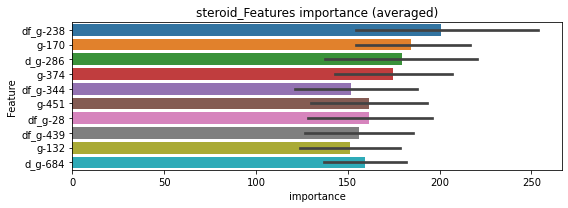

len(train_index) : 3796
len(valid_index) : 3797
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516239	valid_1's binary_logloss: 0.0871936
[200]	training's binary_logloss: 0.0185279	valid_1's binary_logloss: 0.0527421
[300]	training's binary_logloss: 0.00721715	valid_1's binary_logloss: 0.0388548
[400]	training's binary_logloss: 0.00323371	valid_1's binary_logloss: 0.0327304
[500]	training's binary_logloss: 0.00182471	valid_1's binary_logloss: 0.0299946
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00150189	valid_1's binary_logloss: 0.0295359


len(train_index) : 3797
len(valid_index) : 3796
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542925	valid_1's binary_logloss: 0.0922734
[200]	training's binary_logloss: 0.018465	valid_1's binary_logloss: 0.0566988
[300]	training's binary_logloss: 0.00682165	valid_1's binary_logloss: 0.0405874
[400]	training's binary_logloss: 0.0030756	valid_1's binary_logloss: 0.0330068
[500]	training's binary_logloss: 0.00177678	valid_1's binary_logloss: 0.0290931
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0016779	valid_1's binary_logloss: 0.0288042


steroid logloss: 0.029170066683417914


neg labels: 3289 → selected neg labels: 3287


syk_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659236	valid_1's binary_logloss: 0.096919
[200]	training's binary_logloss: 0.0165833	valid_1's binary_logloss: 0.0439083
[300]	training's binary_logloss: 0.00477891	valid_1's binary_logloss: 0.0261086
[400]	training's binary_logloss: 0.00219172	valid_1's binary_logloss: 0.0197561
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00155122	valid_1's binary_logloss: 0.0177513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684134	valid_1's binary_logloss: 0.0936493
[200]	training's binary_logloss: 0.0170584	valid_1's binary_logloss: 0.0345631
[300]	training's binary_logloss: 0.00498166	valid_1's binary_logloss: 0.0168847
[400]	training's binary_logloss: 0.00230118	valid_1's binary_logloss: 0.0114376
[500]	training's binary_logloss: 0.00149763	valid_1's binary_logloss: 0.00959991
[600]	training's binary_logloss: 0.00118828	val

1 / 3 AUC score:1.000
y_Threshold: 0.0241818, Threshold: 0.1010903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.09098, conf_1:0.11120
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.1010903
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_2: 0.1310903
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_3: 0.1610903
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_4: 0.1910903
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_5: 0.2210903
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.2510903
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.2810903
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_8: 0.3110903
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.3410903
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.3710903
threshold: 0.4010903, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604538	valid_1's binary_logloss: 0.0882852
[200]	training's binary_logloss: 0.012381	valid_1's binary_logloss: 0.0305771
[300]	training's binary_logloss: 0.00375105	valid_1's binary_logloss: 0.0155091
[400]	training's binary_logloss: 0.00186869	valid_1's binary_logloss: 0.0106571
[500]	training's binary_logloss: 0.00131491	valid_1's binary_logloss: 0.00902807
[600]	training's binary_logloss: 0.00106631	valid_1's binary_logloss: 0.00823806
[700]	training's binary_logloss: 0.000925929	valid_1's binary_logloss: 0.00763244
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000880831	valid_1's binary_logloss: 0.00748604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540775	valid_1's binary_logloss: 0.0759392
[200]	training's binary_logloss: 0.0114807	valid_1's binary_logloss: 0.0236736
[300]	training's binary_logloss: 0.0035961

2 / 3 AUC score:1.000
y_Threshold: 0.3864893, Threshold: 0.4010903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00080, Num_p_label: 26.0, conf_0:0.36098, conf_1:0.44120
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_1: 0.4010903
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.4310903
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_3: 0.4610903
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_4: 0.4910903
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.5210903
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.5510903
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.5810903
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_8: 0.6110903
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_9: 0.6410903
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.6710903
threshold: 0.7010903, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629301	valid_1's binary_logloss: 0.0808822
[200]	training's binary_logloss: 0.0122905	valid_1's binary_logloss: 0.0244478
[300]	training's binary_logloss: 0.00375385	valid_1's binary_logloss: 0.0114083
[400]	training's binary_logloss: 0.00189164	valid_1's binary_logloss: 0.00767364
[500]	training's binary_logloss: 0.00128426	valid_1's binary_logloss: 0.00619483
[600]	training's binary_logloss: 0.00101831	valid_1's binary_logloss: 0.00540182
[700]	training's binary_logloss: 0.000898994	valid_1's binary_logloss: 0.00500759
[800]	training's binary_logloss: 0.000843309	valid_1's binary_logloss: 0.00482001
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.000842311	valid_1's binary_logloss: 0.00481888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057161	valid_1's binary_logloss: 0.0772182
[200]	training's binary_logloss: 0.011

3 / 3 AUC score:1.000
y_Threshold: 0.2793895, Threshold: 0.7010903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.63098, conf_1:0.77120
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.7010903
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.7310903
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.7610903
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.7910903
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_5: 0.8210903
threshold: 0.8210903, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


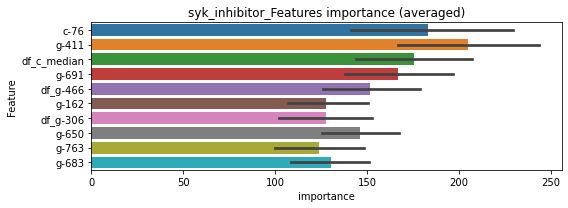

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368854	valid_1's binary_logloss: 0.0539533
[200]	training's binary_logloss: 0.00853424	valid_1's binary_logloss: 0.02029
[300]	training's binary_logloss: 0.00249754	valid_1's binary_logloss: 0.010578
[400]	training's binary_logloss: 0.00113249	valid_1's binary_logloss: 0.00793045
[500]	training's binary_logloss: 0.000751439	valid_1's binary_logloss: 0.00683932
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000733837	valid_1's binary_logloss: 0.00682997


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358196	valid_1's binary_logloss: 0.0485296
[200]	training's binary_logloss: 0.00806974	valid_1's binary_logloss: 0.0167755
[300]	training's binary_logloss: 0.00226936	valid_1's binary_logloss: 0.00749016
[400]	training's binary_logloss: 0.00107746	valid_1's binary_logloss: 0.00491297
[500]	training's binary_logloss: 0.000724389	valid_1's binary_logloss: 0.00400657
[600]	training's binary_logloss: 0.000581997	valid_1's binary_logloss: 0.00359441
[700]	training's binary_logloss: 0.000514367	valid_1's binary_logloss: 0.00339543
[800]	training's binary_logloss: 0.000481039	valid_1's binary_logloss: 0.00327186
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000481123	valid_1's binary_logloss: 0.0032718


syk_inhibitor logloss: 0.005050885544695641


neg labels: 3289 → selected neg labels: 3278


tachykinin_antagonist, len(trt): 60, len(othr): 3278, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119936	valid_1's binary_logloss: 0.18476
[200]	training's binary_logloss: 0.0436591	valid_1's binary_logloss: 0.119978
[300]	training's binary_logloss: 0.0161548	valid_1's binary_logloss: 0.0921377
[400]	training's binary_logloss: 0.00713201	valid_1's binary_logloss: 0.0797358
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00549048	valid_1's binary_logloss: 0.0765814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117388	valid_1's binary_logloss: 0.170336
[200]	training's binary_logloss: 0.0481188	valid_1's binary_logloss: 0.102999
[300]	training's binary_logloss: 0.019132	valid_1's binary_logloss: 0.0693959
[400]	training's binary_logloss: 0.00807979	valid_1's binary_logloss: 0.0537894
[500]	training's binary_logloss: 0.00426145	valid_1's binary_logloss: 0.0462745
Early stopping, best iteration is:
[494]	training's binar

1 / 3 AUC score:0.994
y_Threshold: 0.0496487, Threshold: 0.1647472, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 637/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.14827, conf_1:0.18122
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.1647472
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.1947472
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_3: 0.2247472
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_4: 0.2547472
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_5: 0.2847472
threshold: 0.2847472, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 637.0/3765, y_label_rate: 0.1691899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11647	valid_1's binary_logloss: 0.169337
[200]	training's binary_logloss: 0.0410528	valid_1's binary_logloss: 0.0937603
[300]	training's binary_logloss: 0.0157338	valid_1's binary_logloss: 0.0598004
[400]	training's binary_logloss: 0.00667968	valid_1's binary_logloss: 0.0423142
[500]	training's binary_logloss: 0.00362751	valid_1's binary_logloss: 0.0363706
[600]	training's binary_logloss: 0.002425	valid_1's binary_logloss: 0.0333879
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.002425	valid_1's binary_logloss: 0.0333879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101316	valid_1's binary_logloss: 0.156801
[200]	training's binary_logloss: 0.0349109	valid_1's binary_logloss: 0.0894179
[300]	training's binary_logloss: 0.0132172	valid_1's binary_logloss: 0.0614879
[400]	training's binary_logloss: 0.00611045	valid_1's bina

2 / 3 AUC score:0.999
y_Threshold: 0.1101500, Threshold: 0.2847472, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 622.0/3735
p_label_rate: 0.0090407 Vs.target_rate: 0.00252, Num_p_label: 36.0, conf_0:0.25627, conf_1:0.31322
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_1: 0.2847472
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.3147472
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_3: 0.3447472
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_4: 0.3747472
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_5: 0.4047472
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_6: 0.4347472
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_7: 0.4647472
threshold: 0.4647472, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 622.0/3735, y_label_rate: 0.1665328
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992728	valid_1's binary_logloss: 0.158188
[200]	training's binary_logloss: 0.0372952	valid_1's binary_logloss: 0.0940397
[300]	training's binary_logloss: 0.01326	valid_1's binary_logloss: 0.0605695
[400]	training's binary_logloss: 0.00581338	valid_1's binary_logloss: 0.0489026
[500]	training's binary_logloss: 0.00319273	valid_1's binary_logloss: 0.0435394
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00270321	valid_1's binary_logloss: 0.0426313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109167	valid_1's binary_logloss: 0.158708
[200]	training's binary_logloss: 0.036924	valid_1's binary_logloss: 0.0827263
[300]	training's binary_logloss: 0.0135991	valid_1's binary_logloss: 0.0536844
[400]	training's binary_logloss: 0.00599062	valid_1's binary_logloss: 0.040252
[500]	training's binary_logloss: 0.00333414	valid_1's bi

3 / 3 AUC score:0.998
y_Threshold: 0.0979936, Threshold: 0.4647472, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 609.0/3709
p_label_rate: 0.0052737 Vs.target_rate: 0.00252, Num_p_label: 21.0, conf_0:0.41827, conf_1:0.51122
threshold: 0.4647472, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 630.0/7691, y_label_rate: 0.0819139


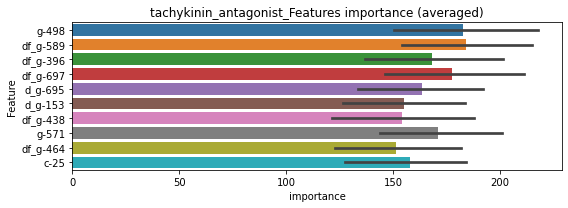

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577515	valid_1's binary_logloss: 0.0927743
[200]	training's binary_logloss: 0.0196921	valid_1's binary_logloss: 0.053691
[300]	training's binary_logloss: 0.00735118	valid_1's binary_logloss: 0.0363687
[400]	training's binary_logloss: 0.00314414	valid_1's binary_logloss: 0.0294049
[500]	training's binary_logloss: 0.00175401	valid_1's binary_logloss: 0.0264138
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0013495	valid_1's binary_logloss: 0.0254725


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579071	valid_1's binary_logloss: 0.0925144
[200]	training's binary_logloss: 0.0213963	valid_1's binary_logloss: 0.0544769
[300]	training's binary_logloss: 0.00845986	valid_1's binary_logloss: 0.0384598
[400]	training's binary_logloss: 0.00360939	valid_1's binary_logloss: 0.0304857
[500]	training's binary_logloss: 0.00194197	valid_1's binary_logloss: 0.026788
[600]	training's binary_logloss: 0.0012719	valid_1's binary_logloss: 0.0251438
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.00116512	valid_1's binary_logloss: 0.024767


tachykinin_antagonist logloss: 0.025119820343974163


neg labels: 3289 → selected neg labels: 3285


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104837	valid_1's binary_logloss: 0.153154
[200]	training's binary_logloss: 0.0337855	valid_1's binary_logloss: 0.0763997
[300]	training's binary_logloss: 0.0116694	valid_1's binary_logloss: 0.0446557
[400]	training's binary_logloss: 0.0046483	valid_1's binary_logloss: 0.030514
[500]	training's binary_logloss: 0.0025269	valid_1's binary_logloss: 0.0249901
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00185872	valid_1's binary_logloss: 0.0232112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999897	valid_1's binary_logloss: 0.150379
[200]	training's binary_logloss: 0.0334464	valid_1's binary_logloss: 0.0795894
[300]	training's binary_logloss: 0.0116697	valid_1's binary_logloss: 0.0513346
[400]	training's binary_logloss: 0.00456385	valid_1's binary_logloss: 0.0374764
[500]	training's binary_logloss: 0.00251976	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0350718, Threshold: 0.1620575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.14585, conf_1:0.17826
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.1620575
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.1920575
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.2220575
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.2520575
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.2820575
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_6: 0.3120575
threshold: 0.3120575, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102967	valid_1's binary_logloss: 0.144972
[200]	training's binary_logloss: 0.030693	valid_1's binary_logloss: 0.0655891
[300]	training's binary_logloss: 0.0103336	valid_1's binary_logloss: 0.035581
[400]	training's binary_logloss: 0.00420814	valid_1's binary_logloss: 0.0238904
[500]	training's binary_logloss: 0.00238995	valid_1's binary_logloss: 0.0189848
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00179914	valid_1's binary_logloss: 0.0173365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10034	valid_1's binary_logloss: 0.146321
[200]	training's binary_logloss: 0.0319314	valid_1's binary_logloss: 0.0705533
[300]	training's binary_logloss: 0.0105573	valid_1's binary_logloss: 0.0405056
[400]	training's binary_logloss: 0.00430055	valid_1's binary_logloss: 0.0287019
[500]	training's binary_logloss: 0.00237964	valid_1's bi

2 / 3 AUC score:1.000
y_Threshold: 0.1920216, Threshold: 0.3120575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0052737 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.28085, conf_1:0.34326
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.3120575
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.3420575
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.3720575
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.4020575
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.4320575
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_6: 0.4620575
threshold: 0.4620575, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096809	valid_1's binary_logloss: 0.145293
[200]	training's binary_logloss: 0.0288239	valid_1's binary_logloss: 0.0708936
[300]	training's binary_logloss: 0.00929651	valid_1's binary_logloss: 0.0428574
[400]	training's binary_logloss: 0.00396987	valid_1's binary_logloss: 0.0325328
[500]	training's binary_logloss: 0.00226775	valid_1's binary_logloss: 0.0289479
[600]	training's binary_logloss: 0.00164441	valid_1's binary_logloss: 0.0273389
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00157643	valid_1's binary_logloss: 0.0269556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937637	valid_1's binary_logloss: 0.138793
[200]	training's binary_logloss: 0.0312504	valid_1's binary_logloss: 0.0687746
[300]	training's binary_logloss: 0.0102182	valid_1's binary_logloss: 0.0369706
[400]	training's binary_logloss: 0.00416911	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1433170, Threshold: 0.4620575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 643.0/3782
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.41585, conf_1:0.50826
threshold: 0.4620575, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 653.0/7764, y_label_rate: 0.0841061


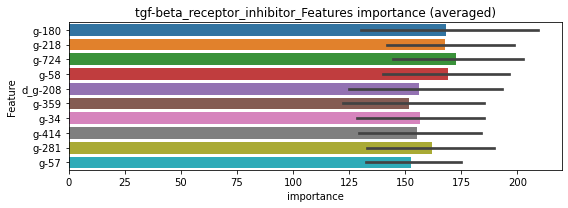

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573197	valid_1's binary_logloss: 0.0901672
[200]	training's binary_logloss: 0.0198734	valid_1's binary_logloss: 0.0493868
[300]	training's binary_logloss: 0.00637102	valid_1's binary_logloss: 0.0291328
[400]	training's binary_logloss: 0.00243101	valid_1's binary_logloss: 0.0204999
[500]	training's binary_logloss: 0.00126491	valid_1's binary_logloss: 0.0176364
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00120556	valid_1's binary_logloss: 0.0175205


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547775	valid_1's binary_logloss: 0.0837179
[200]	training's binary_logloss: 0.0176985	valid_1's binary_logloss: 0.0435614
[300]	training's binary_logloss: 0.00611349	valid_1's binary_logloss: 0.0275981
[400]	training's binary_logloss: 0.00241747	valid_1's binary_logloss: 0.0201046
[500]	training's binary_logloss: 0.00129489	valid_1's binary_logloss: 0.0170316
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00134593	valid_1's binary_logloss: 0.0169253


tgf-beta_receptor_inhibitor logloss: 0.017222883716525136


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614751	valid_1's binary_logloss: 0.0886154
[200]	training's binary_logloss: 0.0140637	valid_1's binary_logloss: 0.0333768
[300]	training's binary_logloss: 0.00413558	valid_1's binary_logloss: 0.0174182
[400]	training's binary_logloss: 0.00190605	valid_1's binary_logloss: 0.0119768
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00157079	valid_1's binary_logloss: 0.0110848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596094	valid_1's binary_logloss: 0.0842278
[200]	training's binary_logloss: 0.0127429	valid_1's binary_logloss: 0.0269302
[300]	training's binary_logloss: 0.0038444	valid_1's binary_logloss: 0.0125819
[400]	training's binary_logloss: 0.00185725	valid_1's binary_logloss: 0.00832902
[500]	training's binary_logloss: 0.00122837	valid_1's binary_logloss: 0.00663936
[600]	training's binary_logloss: 0.000982982	v

1 / 3 AUC score:1.000
y_Threshold: 0.0174710, Threshold: 0.0878621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.07908, conf_1:0.09665
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0878621
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_2: 0.1178621
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_3: 0.1478621
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_4: 0.1778621
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_5: 0.2078621
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_6: 0.2378621
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.2678621
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.2978621
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.3278621
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.3578621
threshold: 0.3878621, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575337	valid_1's binary_logloss: 0.0830963
[200]	training's binary_logloss: 0.0113081	valid_1's binary_logloss: 0.0284327
[300]	training's binary_logloss: 0.00339552	valid_1's binary_logloss: 0.0143231
[400]	training's binary_logloss: 0.0016694	valid_1's binary_logloss: 0.0112243
[500]	training's binary_logloss: 0.00112898	valid_1's binary_logloss: 0.0101344
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00105114	valid_1's binary_logloss: 0.00984041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503355	valid_1's binary_logloss: 0.0753794
[200]	training's binary_logloss: 0.0105862	valid_1's binary_logloss: 0.0231544
[300]	training's binary_logloss: 0.00325528	valid_1's binary_logloss: 0.0101449
[400]	training's binary_logloss: 0.00164494	valid_1's binary_logloss: 0.00643477
[500]	training's binary_logloss: 0.00111564	va

2 / 3 AUC score:1.000
y_Threshold: 0.1269646, Threshold: 0.3878621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0057760 Vs.target_rate: 0.00080, Num_p_label: 23.0, conf_0:0.34908, conf_1:0.42665
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_1: 0.3878621
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.4178621
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_3: 0.4478621
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.4778621
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.5078621
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.5378621
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.5678621
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.5978621
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.6278621
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.6578621
threshold: 0.6878621, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531395	valid_1's binary_logloss: 0.0816166
[200]	training's binary_logloss: 0.0105	valid_1's binary_logloss: 0.0256447
[300]	training's binary_logloss: 0.00317982	valid_1's binary_logloss: 0.0118254
[400]	training's binary_logloss: 0.00159049	valid_1's binary_logloss: 0.00760274
[500]	training's binary_logloss: 0.00108901	valid_1's binary_logloss: 0.00628948
[600]	training's binary_logloss: 0.000873517	valid_1's binary_logloss: 0.00554739
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.000802861	valid_1's binary_logloss: 0.00529182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545699	valid_1's binary_logloss: 0.0754996
[200]	training's binary_logloss: 0.010536	valid_1's binary_logloss: 0.0252292
[300]	training's binary_logloss: 0.0031801	valid_1's binary_logloss: 0.0142176
[400]	training's binary_logloss: 0.00162015	va

3 / 3 AUC score:1.000
y_Threshold: 0.1085421, Threshold: 0.6878621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3801
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.61908, conf_1:0.75665
threshold: 0.6878621, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 659.0/7783, y_label_rate: 0.0846717


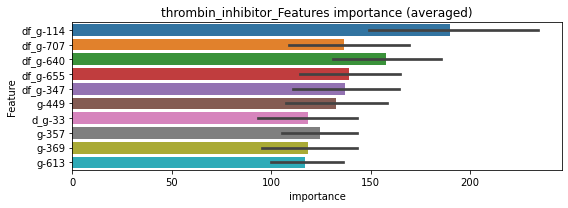

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311102	valid_1's binary_logloss: 0.0491858
[200]	training's binary_logloss: 0.00667917	valid_1's binary_logloss: 0.0195965
[300]	training's binary_logloss: 0.00190781	valid_1's binary_logloss: 0.0114592
[400]	training's binary_logloss: 0.000919719	valid_1's binary_logloss: 0.00892238
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000751399	valid_1's binary_logloss: 0.00859956


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292868	valid_1's binary_logloss: 0.0468495
[200]	training's binary_logloss: 0.00597591	valid_1's binary_logloss: 0.0168741
[300]	training's binary_logloss: 0.00176763	valid_1's binary_logloss: 0.00872238
[400]	training's binary_logloss: 0.000878288	valid_1's binary_logloss: 0.00680473
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000732862	valid_1's binary_logloss: 0.0064049


thrombin_inhibitor logloss: 0.007502370560370339


neg labels: 3289 → selected neg labels: 3282


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102051	valid_1's binary_logloss: 0.15499
[200]	training's binary_logloss: 0.0317091	valid_1's binary_logloss: 0.0774012
[300]	training's binary_logloss: 0.0106984	valid_1's binary_logloss: 0.0470406
[400]	training's binary_logloss: 0.00456979	valid_1's binary_logloss: 0.0338924
[500]	training's binary_logloss: 0.0026054	valid_1's binary_logloss: 0.0282756
[600]	training's binary_logloss: 0.00180797	valid_1's binary_logloss: 0.0260745
[700]	training's binary_logloss: 0.00143742	valid_1's binary_logloss: 0.0244566
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.00139731	valid_1's binary_logloss: 0.0243193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989183	valid_1's binary_logloss: 0.143211
[200]	training's binary_logloss: 0.0338002	valid_1's binary_logloss: 0.070906
[300]	training's binary_logloss: 0.0117195	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0317663, Threshold: 0.1769584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.15926, conf_1:0.19465
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1769584
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_2: 0.2069584
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_3: 0.2369584
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.2669584
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_5: 0.2969584
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_6: 0.3269584
threshold: 0.3269584, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881195	valid_1's binary_logloss: 0.128325
[200]	training's binary_logloss: 0.0257993	valid_1's binary_logloss: 0.0577416
[300]	training's binary_logloss: 0.00872289	valid_1's binary_logloss: 0.0314435
[400]	training's binary_logloss: 0.00382591	valid_1's binary_logloss: 0.0222952
[500]	training's binary_logloss: 0.00226569	valid_1's binary_logloss: 0.0184106
[600]	training's binary_logloss: 0.00161427	valid_1's binary_logloss: 0.0167313
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00157366	valid_1's binary_logloss: 0.0165426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912624	valid_1's binary_logloss: 0.138501
[200]	training's binary_logloss: 0.028842	valid_1's binary_logloss: 0.0685061
[300]	training's binary_logloss: 0.00946503	valid_1's binary_logloss: 0.0408982
[400]	training's binary_logloss: 0.00410824	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1678232, Threshold: 0.3269584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0110497 Vs.target_rate: 0.00155, Num_p_label: 44.0, conf_0:0.29426, conf_1:0.35965
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_1: 0.3269584
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_2: 0.3569584
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_3: 0.3869584
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_4: 0.4169584
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_5: 0.4469584
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_6: 0.4769584
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_7: 0.5069584
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_8: 0.5369584
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_9: 0.5669584
threshold: 0.5669584, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 648.0/3790, y_label_rate: 0.1709763
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870988	valid_1's binary_logloss: 0.132708
[200]	training's binary_logloss: 0.0247208	valid_1's binary_logloss: 0.0624654
[300]	training's binary_logloss: 0.00816905	valid_1's binary_logloss: 0.0355473
[400]	training's binary_logloss: 0.00359331	valid_1's binary_logloss: 0.0252942
[500]	training's binary_logloss: 0.00217071	valid_1's binary_logloss: 0.0213207
[600]	training's binary_logloss: 0.00159384	valid_1's binary_logloss: 0.019044
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00151946	valid_1's binary_logloss: 0.0187646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880229	valid_1's binary_logloss: 0.134217
[200]	training's binary_logloss: 0.0251832	valid_1's binary_logloss: 0.0683427
[300]	training's binary_logloss: 0.00850269	valid_1's binary_logloss: 0.0456803
[400]	training's binary_logloss: 0.0037566	valid_1

3 / 3 AUC score:1.000


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00242234	valid_1's binary_logloss: 0.0313641


y_Threshold: 0.1503826, Threshold: 0.5669584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 640.0/3774
p_label_rate: 0.0030136 Vs.target_rate: 0.00155, Num_p_label: 12.0, conf_0:0.51026, conf_1:0.62365
threshold: 0.5669584, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/7756, y_label_rate: 0.0840640


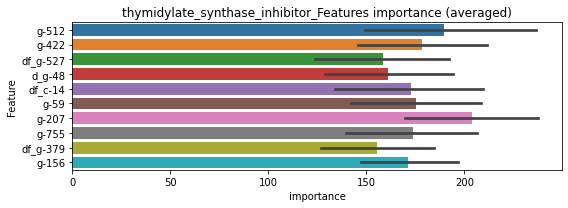

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530887	valid_1's binary_logloss: 0.0865837
[200]	training's binary_logloss: 0.0163194	valid_1's binary_logloss: 0.0494942
[300]	training's binary_logloss: 0.00508942	valid_1's binary_logloss: 0.0324726
[400]	training's binary_logloss: 0.00215099	valid_1's binary_logloss: 0.0254846
[500]	training's binary_logloss: 0.00125589	valid_1's binary_logloss: 0.022264
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00113822	valid_1's binary_logloss: 0.0216598


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514992	valid_1's binary_logloss: 0.0903156
[200]	training's binary_logloss: 0.0144358	valid_1's binary_logloss: 0.0502778
[300]	training's binary_logloss: 0.00474539	valid_1's binary_logloss: 0.0388874
[400]	training's binary_logloss: 0.00203723	valid_1's binary_logloss: 0.0345331
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00206831	valid_1's binary_logloss: 0.0344263


thymidylate_synthase_inhibitor logloss: 0.028043081500730867


neg labels: 3289 → selected neg labels: 3282


tlr_agonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682991	valid_1's binary_logloss: 0.114583
[200]	training's binary_logloss: 0.0180035	valid_1's binary_logloss: 0.0583308
[300]	training's binary_logloss: 0.00563818	valid_1's binary_logloss: 0.0428397
[400]	training's binary_logloss: 0.00254492	valid_1's binary_logloss: 0.0374194
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00272723	valid_1's binary_logloss: 0.0373639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685884	valid_1's binary_logloss: 0.103689
[200]	training's binary_logloss: 0.0207555	valid_1's binary_logloss: 0.0533395
[300]	training's binary_logloss: 0.00675613	valid_1's binary_logloss: 0.0342784


1 / 3 AUC score:0.999
y_Threshold: 0.0291792, Threshold: 0.1390942, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.12518, conf_1:0.15300
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.1390942
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_2: 0.1690942
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.1990942


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0037818	valid_1's binary_logloss: 0.0285802


Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.2290942
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.2590942
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_6: 0.2890942
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_7: 0.3190942
threshold: 0.3190942, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659387	valid_1's binary_logloss: 0.100606
[200]	training's binary_logloss: 0.0161117	valid_1's binary_logloss: 0.0454544
[300]	training's binary_logloss: 0.00512304	valid_1's binary_logloss: 0.0279758
[400]	training's binary_logloss: 0.00237945	valid_1's binary_logloss: 0.0228988
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00237945	valid_1's binary_logloss: 0.0228988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657958	valid_1's binary_logloss: 0.104748
[200]	training's binary_logloss: 0.0164715	valid_1's binary_logloss: 0.0449788
[300]	training's binary_logloss: 0.00534697	valid_1's binary_logloss: 0.0268732
[400]	training's binary_logloss: 0.00244582	valid_1's binary_logloss: 0.0191028


2 / 3 AUC score:1.000
y_Threshold: 0.1169640, Threshold: 0.3190942, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0047715 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.28718, conf_1:0.35100
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.3190942
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.3490942
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.3790942


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00163781	valid_1's binary_logloss: 0.0167537


Num_p_label: 13.0, Expected: 5.0, Adj_threshold_4: 0.4090942
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.4390942
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_6: 0.4690942
threshold: 0.4690942, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620497	valid_1's binary_logloss: 0.0956865
[200]	training's binary_logloss: 0.014892	valid_1's binary_logloss: 0.0380717
[300]	training's binary_logloss: 0.00476541	valid_1's binary_logloss: 0.0224909
[400]	training's binary_logloss: 0.00228564	valid_1's binary_logloss: 0.0171042
[500]	training's binary_logloss: 0.0014793	valid_1's binary_logloss: 0.0149158
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.001219	valid_1's binary_logloss: 0.0140646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646461	valid_1's binary_logloss: 0.10056
[200]	training's binary_logloss: 0.0169559	valid_1's binary_logloss: 0.046628
[300]	training's binary_logloss: 0.00541852	valid_1's binary_logloss: 0.0294531
[400]	training's binary_logloss: 0.0024861	valid_1's binary_logloss: 0.0228798
[500]	training's binary_logloss: 0.00159035	valid_1's b

3 / 3 AUC score:1.000
y_Threshold: 0.1100428, Threshold: 0.4690942, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 646.0/3786
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.42218, conf_1:0.51600
threshold: 0.4690942, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/7768, y_label_rate: 0.0843203


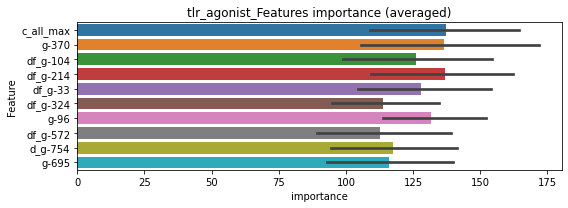

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376281	valid_1's binary_logloss: 0.0585392
[200]	training's binary_logloss: 0.0103153	valid_1's binary_logloss: 0.0271971
[300]	training's binary_logloss: 0.00328191	valid_1's binary_logloss: 0.0171293
[400]	training's binary_logloss: 0.00140436	valid_1's binary_logloss: 0.0136427
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00101087	valid_1's binary_logloss: 0.0130557


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036701	valid_1's binary_logloss: 0.0545446
[200]	training's binary_logloss: 0.00995825	valid_1's binary_logloss: 0.0233303
[300]	training's binary_logloss: 0.00322362	valid_1's binary_logloss: 0.0126652
[400]	training's binary_logloss: 0.00143528	valid_1's binary_logloss: 0.00899577
[500]	training's binary_logloss: 0.000893013	valid_1's binary_logloss: 0.00750285
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000703234	valid_1's binary_logloss: 0.00681734


tlr_agonist logloss: 0.009936531342293052


neg labels: 3289 → selected neg labels: 3289


tlr_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290009	valid_1's binary_logloss: 0.0359164
[200]	training's binary_logloss: 0.0039514	valid_1's binary_logloss: 0.00837649
[300]	training's binary_logloss: 0.0011653	valid_1's binary_logloss: 0.00423539
[400]	training's binary_logloss: 0.000678274	valid_1's binary_logloss: 0.0032556
[500]	training's binary_logloss: 0.000539893	valid_1's binary_logloss: 0.0028301
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000519667	valid_1's binary_logloss: 0.00274784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283486	valid_1's binary_logloss: 0.036498
[200]	training's binary_logloss: 0.00395451	valid_1's binary_logloss: 0.00889464
[300]	training's binary_logloss: 0.00118468	valid_1's binary_logloss: 0.00453165
[400]	training's binary_logloss: 0.00069958	valid_1's binary_logloss: 0.00342254
[500]	training's binary_logloss: 0.0005

1 / 3 AUC score:1.000
y_Threshold: 0.0034148, Threshold: 0.0198265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.01784, conf_1:0.02181
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0198265
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_2: 0.0498265
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0798265
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.1098265
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.1398265
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.1698265
threshold: 0.1698265, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262673	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00340437	valid_1's binary_logloss: 0.00479588
[300]	training's binary_logloss: 0.00101233	valid_1's binary_logloss: 0.00170266
[400]	training's binary_logloss: 0.000598307	valid_1's binary_logloss: 0.00111605
[500]	training's binary_logloss: 0.000480253	valid_1's binary_logloss: 0.000961474
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000453936	valid_1's binary_logloss: 0.000923556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249956	valid_1's binary_logloss: 0.0316137
[200]	training's binary_logloss: 0.00317205	valid_1's binary_logloss: 0.00566695
[300]	training's binary_logloss: 0.00100573	valid_1's binary_logloss: 0.00235904
[400]	training's binary_logloss: 0.000599675	valid_1's binary_logloss: 0.00155445
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1525569, Threshold: 0.1698265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00029, Num_p_label: 15.0, conf_0:0.15284, conf_1:0.18681
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_1: 0.1698265
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_2: 0.1998265
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_3: 0.2298265
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_4: 0.2598265
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_5: 0.2898265
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_6: 0.3198265
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_7: 0.3498265
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_8: 0.3798265
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_9: 0.4098265
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.4398265
threshold: 0.4698265, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262673	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00340437	valid_1's binary_logloss: 0.00479588
[300]	training's binary_logloss: 0.00101233	valid_1's binary_logloss: 0.00170266
[400]	training's binary_logloss: 0.000598307	valid_1's binary_logloss: 0.00111605
[500]	training's binary_logloss: 0.000480253	valid_1's binary_logloss: 0.000961474
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000453936	valid_1's binary_logloss: 0.000923556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249956	valid_1's binary_logloss: 0.0316137
[200]	training's binary_logloss: 0.00317205	valid_1's binary_logloss: 0.00566695
[300]	training's binary_logloss: 0.00100573	valid_1's binary_logloss: 0.00235904
[400]	training's binary_logloss: 0.000599675	valid_1's binary_logloss: 0.00155445
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1525569, Threshold: 0.4698265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.42284, conf_1:0.51681
threshold: 0.4698265, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


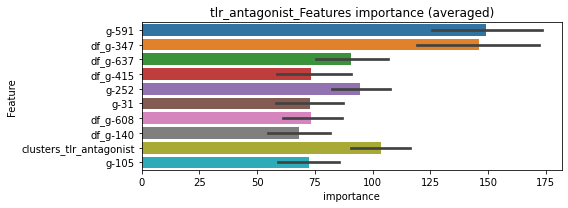

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159799	valid_1's binary_logloss: 0.0189856
[200]	training's binary_logloss: 0.00200834	valid_1's binary_logloss: 0.00341313
[300]	training's binary_logloss: 0.000585937	valid_1's binary_logloss: 0.00156865
[400]	training's binary_logloss: 0.000343369	valid_1's binary_logloss: 0.00131167


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


[500]	training's binary_logloss: 0.000264554	valid_1's binary_logloss: 0.00119497
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000264554	valid_1's binary_logloss: 0.00119497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152652	valid_1's binary_logloss: 0.0187353
[200]	training's binary_logloss: 0.00194349	valid_1's binary_logloss: 0.00338495
[300]	training's binary_logloss: 0.000587898	valid_1's binary_logloss: 0.00135964
[400]	training's binary_logloss: 0.000349947	valid_1's binary_logloss: 0.000947748
[500]	training's binary_logloss: 0.000274176	valid_1's binary_logloss: 0.000815906
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000246464	valid_1's binary_logloss: 0.000763733


tlr_antagonist logloss: 0.0009793806515872316


neg labels: 3289 → selected neg labels: 3289


tnf_inhibitor, len(trt): 36, len(othr): 3289, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075654	valid_1's binary_logloss: 0.121826
[200]	training's binary_logloss: 0.0232021	valid_1's binary_logloss: 0.0650249
[300]	training's binary_logloss: 0.00772166	valid_1's binary_logloss: 0.0419541
[400]	training's binary_logloss: 0.00352004	valid_1's binary_logloss: 0.0319987
[500]	training's binary_logloss: 0.00209901	valid_1's binary_logloss: 0.0280015
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00179931	valid_1's binary_logloss: 0.0269693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772015	valid_1's binary_logloss: 0.112749
[200]	training's binary_logloss: 0.0223498	valid_1's binary_logloss: 0.0552849
[300]	training's binary_logloss: 0.00745774	valid_1's binary_logloss: 0.0383416
[400]	training's binary_logloss: 0.00329065	valid_1's binary_logloss: 0.0335085
[500]	training's binary_logloss: 0.00200258	valid_

1 / 3 AUC score:0.998
y_Threshold: 0.0244424, Threshold: 0.1089526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 143 → Positive_corect_labels: 652/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.09806, conf_1:0.11985
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1089526
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.1389526
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1689526
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.1989526
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.2289526
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.2589526
threshold: 0.2589526, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3803, y_label_rate: 0.1714436
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742089	valid_1's binary_logloss: 0.106652
[200]	training's binary_logloss: 0.0201564	valid_1's binary_logloss: 0.050234
[300]	training's binary_logloss: 0.00665778	valid_1's binary_logloss: 0.0326778
[400]	training's binary_logloss: 0.00307644	valid_1's binary_logloss: 0.0260372
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00230866	valid_1's binary_logloss: 0.0236807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690155	valid_1's binary_logloss: 0.106686
[200]	training's binary_logloss: 0.0193703	valid_1's binary_logloss: 0.0496678
[300]	training's binary_logloss: 0.0064863	valid_1's binary_logloss: 0.0293364
[400]	training's binary_logloss: 0.00310271	valid_1's binary_logloss: 0.0223414
[500]	training's binary_logloss: 0.00190056	valid_1's binary_logloss: 0.0191646
Early stopping, best iteration is:
[536]	training's

2 / 3 AUC score:1.000
y_Threshold: 0.1215849, Threshold: 0.2589526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 645.0/3789
p_label_rate: 0.0102963 Vs.target_rate: 0.00151, Num_p_label: 41.0, conf_0:0.23306, conf_1:0.28485
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.2589526
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.2889526
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.3189526
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_4: 0.3489526
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_5: 0.3789526
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_6: 0.4089526
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_7: 0.4389526
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.4689526
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_9: 0.4989526
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_10: 0.5289526
threshold: 0.5289526, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 645.0/3789, y_label_rate: 0.1702296
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711929	valid_1's binary_logloss: 0.100119
[200]	training's binary_logloss: 0.0188526	valid_1's binary_logloss: 0.0444877
[300]	training's binary_logloss: 0.00634793	valid_1's binary_logloss: 0.0287902
[400]	training's binary_logloss: 0.00295394	valid_1's binary_logloss: 0.0224563
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00286531	valid_1's binary_logloss: 0.022366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721314	valid_1's binary_logloss: 0.113965
[200]	training's binary_logloss: 0.0182281	valid_1's binary_logloss: 0.0552135
[300]	training's binary_logloss: 0.00608535	valid_1's binary_logloss: 0.0383169
[400]	training's binary_logloss: 0.00281008	valid_1's binary_logloss: 0.033639
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00247863	valid_1's binary_logloss: 0.0331371


3 / 3 AUC score:0.999
y_Threshold: 0.1102738, Threshold: 0.5289526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 633.0/3765
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.47606, conf_1:0.58185
threshold: 0.5289526, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 647.0/7747, y_label_rate: 0.0835162


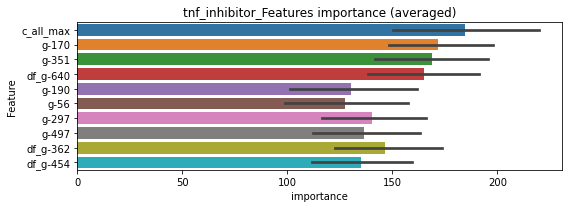

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348795	valid_1's binary_logloss: 0.0584391
[200]	training's binary_logloss: 0.00979015	valid_1's binary_logloss: 0.0291297
[300]	training's binary_logloss: 0.00316999	valid_1's binary_logloss: 0.019447
[400]	training's binary_logloss: 0.00150203	valid_1's binary_logloss: 0.0160354
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00129943	valid_1's binary_logloss: 0.0154987


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395062	valid_1's binary_logloss: 0.0621218
[200]	training's binary_logloss: 0.0108667	valid_1's binary_logloss: 0.0286061
[300]	training's binary_logloss: 0.00360434	valid_1's binary_logloss: 0.0183302
[400]	training's binary_logloss: 0.00164584	valid_1's binary_logloss: 0.0142546
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00111743	valid_1's binary_logloss: 0.0129713


tnf_inhibitor logloss: 0.014235150705638253


neg labels: 3289 → selected neg labels: 3276


topoisomerase_inhibitor, len(trt): 127, len(othr): 3276, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165861	valid_1's binary_logloss: 0.295336
[200]	training's binary_logloss: 0.0784396	valid_1's binary_logloss: 0.246357
[300]	training's binary_logloss: 0.0384014	valid_1's binary_logloss: 0.226047
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0360863	valid_1's binary_logloss: 0.224512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171197	valid_1's binary_logloss: 0.28278
[200]	training's binary_logloss: 0.0873275	valid_1's binary_logloss: 0.225093
[300]	training's binary_logloss: 0.0449057	valid_1's binary_logloss: 0.19237
[400]	training's binary_logloss: 0.0254047	valid_1's binary_logloss: 0.175165
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0167836	valid_1's binary_logloss: 0.166695


1 / 3 AUC score:0.947
y_Threshold: 0.1457546, Threshold: 0.5615229, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 340 → Positive_corect_labels: 551/3591
p_label_rate: 0.0100452 Vs.target_rate: 0.00533, Num_p_label: 40.0, conf_0:0.50537, conf_1:0.61768
threshold: 0.5615229, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 551.0/3591, y_label_rate: 0.1534392
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11546	valid_1's binary_logloss: 0.228911
[200]	training's binary_logloss: 0.0468372	valid_1's binary_logloss: 0.177067
[300]	training's binary_logloss: 0.0215069	valid_1's binary_logloss: 0.1559
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0177264	valid_1's binary_logloss: 0.153402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130037	valid_1's binary_logloss: 0.231049
[200]	training's binary_logloss: 0.0558981	valid_1's binary_logloss: 0.172757
[300]	training's binary_logloss: 0.0245294	valid_1's binary_logloss: 0.143853


2 / 3 AUC score:0.971
y_Threshold: 0.1607975, Threshold: 0.5615229, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 475.0/3439
p_label_rate: 0.0238574 Vs.target_rate: 0.00533, Num_p_label: 95.0, conf_0:0.50537, conf_1:0.61768
Num_p_label: 95.0, Expected: 21.2, Adj_threshold_1: 0.5615229


[400]	training's binary_logloss: 0.0116359	valid_1's binary_logloss: 0.133361
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0122814	valid_1's binary_logloss: 0.13265


Num_p_label: 86.0, Expected: 21.2, Adj_threshold_2: 0.5915229
Num_p_label: 78.0, Expected: 21.2, Adj_threshold_3: 0.6215229
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_4: 0.6515229
Num_p_label: 65.0, Expected: 21.2, Adj_threshold_5: 0.6815229
Num_p_label: 56.0, Expected: 21.2, Adj_threshold_6: 0.7115229
Num_p_label: 51.0, Expected: 21.2, Adj_threshold_7: 0.7415229
Num_p_label: 48.0, Expected: 21.2, Adj_threshold_8: 0.7715229
Num_p_label: 40.0, Expected: 21.2, Adj_threshold_9: 0.8015229
threshold: 0.8015229, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 475.0/3439, y_label_rate: 0.1381215
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977139	valid_1's binary_logloss: 0.196899
[200]	training's binary_logloss: 0.0356941	valid_1's binary_logloss: 0.143856
[300]	training's binary_logloss: 0.0141789	valid_1's binary_logloss: 0.124569
[400]	training's binary_logloss: 0.00657076	valid_1's binary_logloss: 0.118926
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00486045	valid_1's binary_logloss: 0.117233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898993	valid_1's binary_logloss: 0.199814
[200]	training's binary_logloss: 0.0315091	valid_1's binary_logloss: 0.156294
[300]	training's binary_logloss: 0.0129192	valid_1's binary_logloss: 0.138546


3 / 3 AUC score:0.972
y_Threshold: 0.1256769, Threshold: 0.8015229, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 408.0/3305
p_label_rate: 0.0175791 Vs.target_rate: 0.00533, Num_p_label: 70.0, conf_0:0.72137, conf_1:0.88168
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_1: 0.8015229
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_2: 0.8315229
Num_p_label: 61.0, Expected: 21.2, Adj_threshold_3: 0.8615229
Num_p_label: 53.0, Expected: 21.2, Adj_threshold_4: 0.8915229
Num_p_label: 44.0, Expected: 21.2, Adj_threshold_5: 0.9215229
Num_p_label: 30.0, Expected: 21.2, Adj_threshold_6: 0.9515229
threshold: 0.9515229, positive_p_label: 30.0/3982, p_label_rate: 0.0075339


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00818872	valid_1's binary_logloss: 0.133577


positive_y_label: 438.0/7287, y_label_rate: 0.0601070


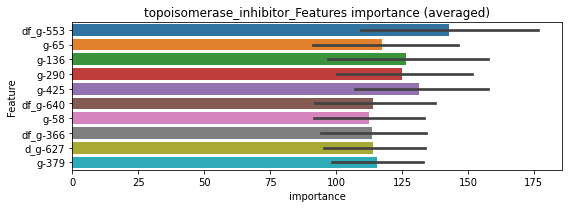

len(train_index) : 3643
len(valid_index) : 3644
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502999	valid_1's binary_logloss: 0.107184
[200]	training's binary_logloss: 0.0179235	valid_1's binary_logloss: 0.0837952
[300]	training's binary_logloss: 0.00755336	valid_1's binary_logloss: 0.0746994
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00640457	valid_1's binary_logloss: 0.0739976


len(train_index) : 3644
len(valid_index) : 3643
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511085	valid_1's binary_logloss: 0.10613
[200]	training's binary_logloss: 0.0196513	valid_1's binary_logloss: 0.0834514
[300]	training's binary_logloss: 0.00827087	valid_1's binary_logloss: 0.0752812


topoisomerase_inhibitor logloss: 0.07352591307332981


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00486268	valid_1's binary_logloss: 0.0730541
neg labels: 3289 → selected neg labels: 3287


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554784	valid_1's binary_logloss: 0.0701287
[200]	training's binary_logloss: 0.0125395	valid_1's binary_logloss: 0.0231399
[300]	training's binary_logloss: 0.00401871	valid_1's binary_logloss: 0.0107219
[400]	training's binary_logloss: 0.00200336	valid_1's binary_logloss: 0.00699496
[500]	training's binary_logloss: 0.00134218	valid_1's binary_logloss: 0.00569554
[600]	training's binary_logloss: 0.00102922	valid_1's binary_logloss: 0.00492715
[700]	training's binary_logloss: 0.000892195	valid_1's binary_logloss: 0.00466538
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.000867562	valid_1's binary_logloss: 0.00462009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540443	valid_1's binary_logloss: 0.0800246
[200]	training's binary_logloss: 0.011734	valid_1's binary_logloss: 0.0303897
[300]	training's binary_logloss: 0.003779

1 / 3 AUC score:1.000
y_Threshold: 0.0126641, Threshold: 0.0954378, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.08589, conf_1:0.10498
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0954378


Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00117294	valid_1's binary_logloss: 0.0105013


Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.1254378
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.1554378
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.1854378
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.2154378
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.2454378
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.2754378
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.3054378
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.3354378
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.3654378
threshold: 0.3954378, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481492	valid_1's binary_logloss: 0.0635671
[200]	training's binary_logloss: 0.0104974	valid_1's binary_logloss: 0.0194255
[300]	training's binary_logloss: 0.00329085	valid_1's binary_logloss: 0.00875823
[400]	training's binary_logloss: 0.00163869	valid_1's binary_logloss: 0.00572114
[500]	training's binary_logloss: 0.0011208	valid_1's binary_logloss: 0.00450091
[600]	training's binary_logloss: 0.000914744	valid_1's binary_logloss: 0.0040122
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000913422	valid_1's binary_logloss: 0.00400841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488273	valid_1's binary_logloss: 0.0724092
[200]	training's binary_logloss: 0.0100304	valid_1's binary_logloss: 0.025801
[300]	training's binary_logloss: 0.00305763	valid_1's binary_logloss: 0.0130717
[400]	training's binary_logloss: 0.00154626

2 / 3 AUC score:1.000
y_Threshold: 0.2098199, Threshold: 0.3954378, pos_neg_ratio: 0.8000000


[500]	training's binary_logloss: 0.0010834	valid_1's binary_logloss: 0.00790671
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00102493	valid_1's binary_logloss: 0.00772726


Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.35589, conf_1:0.43498
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.3954378
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.4254378
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.4554378
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.4854378
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.5154378
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.5454378
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.5754378
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_8: 0.6054378
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_9: 0.6354378
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.6654378
threshold: 0.6954378, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490705	valid_1's binary_logloss: 0.0637865
[200]	training's binary_logloss: 0.0101746	valid_1's binary_logloss: 0.0207514
[300]	training's binary_logloss: 0.00313792	valid_1's binary_logloss: 0.010887
[400]	training's binary_logloss: 0.00159061	valid_1's binary_logloss: 0.00831796
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00141175	valid_1's binary_logloss: 0.00813565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488879	valid_1's binary_logloss: 0.0663079
[200]	training's binary_logloss: 0.0099721	valid_1's binary_logloss: 0.0229745
[300]	training's binary_logloss: 0.00309884	valid_1's binary_logloss: 0.0121943
[400]	training's binary_logloss: 0.00154749	valid_1's binary_logloss: 0.00935725
[500]	training's binary_logloss: 0.0010765	valid_1's binary_logloss: 0.00804022


3 / 3 AUC score:1.000
y_Threshold: 0.1452116, Threshold: 0.6954378, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.62589, conf_1:0.76498
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.6954378


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000941672	valid_1's binary_logloss: 0.00765737


Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.7254378
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.7554378
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.7854378
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.8154378
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.8454378
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.8754378
threshold: 0.8754378, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 659.0/7788, y_label_rate: 0.0846174


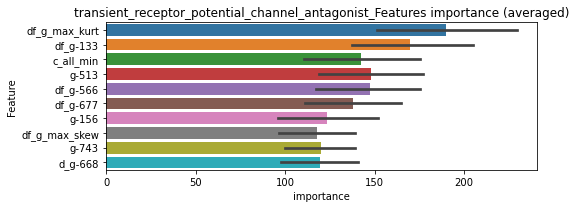

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254075	valid_1's binary_logloss: 0.0362687
[200]	training's binary_logloss: 0.00521816	valid_1's binary_logloss: 0.0126056
[300]	training's binary_logloss: 0.00163759	valid_1's binary_logloss: 0.00709253
[400]	training's binary_logloss: 0.000836188	valid_1's binary_logloss: 0.00570894
[500]	training's binary_logloss: 0.000595771	valid_1's binary_logloss: 0.00519172
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000544865	valid_1's binary_logloss: 0.00509507


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304758	valid_1's binary_logloss: 0.0426581
[200]	training's binary_logloss: 0.00617864	valid_1's binary_logloss: 0.0137844
[300]	training's binary_logloss: 0.00190789	valid_1's binary_logloss: 0.00738314
[400]	training's binary_logloss: 0.000936838	valid_1's binary_logloss: 0.00516481
[500]	training's binary_logloss: 0.000646288	valid_1's binary_logloss: 0.00439428
[600]	training's binary_logloss: 0.000528508	valid_1's binary_logloss: 0.00402535
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.000519277	valid_1's binary_logloss: 0.00402093


transient_receptor_potential_channel_antagonist logloss: 0.0045600675805113474


neg labels: 3289 → selected neg labels: 3289


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256005	valid_1's binary_logloss: 0.0356119
[200]	training's binary_logloss: 0.00346002	valid_1's binary_logloss: 0.00978137
[300]	training's binary_logloss: 0.00105083	valid_1's binary_logloss: 0.00521784
[400]	training's binary_logloss: 0.000619836	valid_1's binary_logloss: 0.00386804
[500]	training's binary_logloss: 0.000487111	valid_1's binary_logloss: 0.00348071
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000477336	valid_1's binary_logloss: 0.00344679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266418	valid_1's binary_logloss: 0.036235
[200]	training's binary_logloss: 0.00353549	valid_1's binary_logloss: 0.0110741
[300]	training's binary_logloss: 0.00106768	valid_1's binary_logloss: 0.00647251
[400]	training's binary_logloss: 0.000611542	valid_1's binary_logloss: 0.00530198


1 / 3 AUC score:1.000
y_Threshold: 0.0033495, Threshold: 0.0194963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.01755, conf_1:0.02145
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0194963
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_2: 0.0494963
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.0794963


[500]	training's binary_logloss: 0.000485738	valid_1's binary_logloss: 0.00490485
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000473403	valid_1's binary_logloss: 0.00485568


Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.1094963
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.1394963
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.1694963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.1994963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2294963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2594963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.2894963
threshold: 0.3194963, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230142	valid_1's binary_logloss: 0.0335332
[200]	training's binary_logloss: 0.00285757	valid_1's binary_logloss: 0.00884203
[300]	training's binary_logloss: 0.000906502	valid_1's binary_logloss: 0.00434775
[400]	training's binary_logloss: 0.000542626	valid_1's binary_logloss: 0.00345785
[500]	training's binary_logloss: 0.000433859	valid_1's binary_logloss: 0.00308892
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000420188	valid_1's binary_logloss: 0.00302308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242903	valid_1's binary_logloss: 0.0277487
[200]	training's binary_logloss: 0.00295961	valid_1's binary_logloss: 0.00484341
[300]	training's binary_logloss: 0.00089999	valid_1's binary_logloss: 0.00193533
[400]	training's binary_logloss: 0.000539071	valid_1's binary_logloss: 0.0012554
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1065040, Threshold: 0.3194963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.28755, conf_1:0.35145
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.3194963
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.3494963
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.3794963
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.4094963
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.4394963
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.4694963
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.4994963
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.5294963
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.5594963
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.5894963
threshold: 0.6194963, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230142	valid_1's binary_logloss: 0.0335332
[200]	training's binary_logloss: 0.00285757	valid_1's binary_logloss: 0.00884203
[300]	training's binary_logloss: 0.000906502	valid_1's binary_logloss: 0.00434775
[400]	training's binary_logloss: 0.000542626	valid_1's binary_logloss: 0.00345785
[500]	training's binary_logloss: 0.000433859	valid_1's binary_logloss: 0.00308892
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000420188	valid_1's binary_logloss: 0.00302308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242903	valid_1's binary_logloss: 0.0277487
[200]	training's binary_logloss: 0.00295961	valid_1's binary_logloss: 0.00484341
[300]	training's binary_logloss: 0.00089999	valid_1's binary_logloss: 0.00193533
[400]	training's binary_logloss: 0.000539071	valid_1's binary_logloss: 0.0012554
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1065040, Threshold: 0.6194963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.55755, conf_1:0.68145
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.6194963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.6494963
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.6794963
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.7094963
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.7394963
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.7694963
threshold: 0.7694963, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


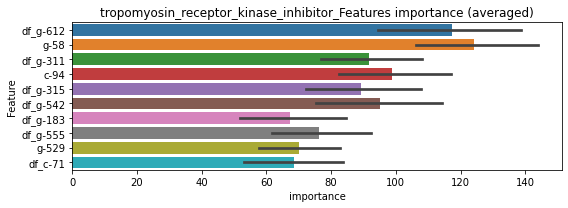

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013263	valid_1's binary_logloss: 0.016376
[200]	training's binary_logloss: 0.00165602	valid_1's binary_logloss: 0.00312671
[300]	training's binary_logloss: 0.000512419	valid_1's binary_logloss: 0.00144775
[400]	training's binary_logloss: 0.000302177	valid_1's binary_logloss: 0.00107025


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.000242972	valid_1's binary_logloss: 0.000966452
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000241266	valid_1's binary_logloss: 0.000960798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132454	valid_1's binary_logloss: 0.0197007
[200]	training's binary_logloss: 0.00170239	valid_1's binary_logloss: 0.00611222
[300]	training's binary_logloss: 0.000538818	valid_1's binary_logloss: 0.00357037
[400]	training's binary_logloss: 0.000316483	valid_1's binary_logloss: 0.00283042


tropomyosin_receptor_kinase_inhibitor logloss: 0.0018607689565026577


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000283535	valid_1's binary_logloss: 0.00276097
neg labels: 3289 → selected neg labels: 3281


trpv_agonist, len(trt): 25, len(othr): 3281, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063198	valid_1's binary_logloss: 0.102311
[200]	training's binary_logloss: 0.0164302	valid_1's binary_logloss: 0.0410967
[300]	training's binary_logloss: 0.00557003	valid_1's binary_logloss: 0.0222778
[400]	training's binary_logloss: 0.00265874	valid_1's binary_logloss: 0.0155679
[500]	training's binary_logloss: 0.00172201	valid_1's binary_logloss: 0.0131765
[600]	training's binary_logloss: 0.00135431	valid_1's binary_logloss: 0.0120121
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00129808	valid_1's binary_logloss: 0.0118576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667014	valid_1's binary_logloss: 0.0976923
[200]	training's binary_logloss: 0.018407	valid_1's binary_logloss: 0.0436721
[300]	training's binary_logloss: 0.00615628	valid_1's binary_logloss: 0.0253669
[400]	training's binary_logloss: 0.00268744	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0187135, Threshold: 0.1073748, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.09664, conf_1:0.11811
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.1073748
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_2: 0.1373748
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_3: 0.1673748
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_4: 0.1973748
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.2273748
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.2573748
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.2873748
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.3173748
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.3473748
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_10: 0.3773748
threshold: 0.3773748, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615807	valid_1's binary_logloss: 0.0966297
[200]	training's binary_logloss: 0.0139576	valid_1's binary_logloss: 0.0334485
[300]	training's binary_logloss: 0.00469763	valid_1's binary_logloss: 0.016236
[400]	training's binary_logloss: 0.00232696	valid_1's binary_logloss: 0.0106073
[500]	training's binary_logloss: 0.00153541	valid_1's binary_logloss: 0.00849215
[600]	training's binary_logloss: 0.00120265	valid_1's binary_logloss: 0.00757398
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00106324	valid_1's binary_logloss: 0.00708505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595931	valid_1's binary_logloss: 0.0875683
[200]	training's binary_logloss: 0.0144558	valid_1's binary_logloss: 0.0339356
[300]	training's binary_logloss: 0.00465292	valid_1's binary_logloss: 0.0176693
[400]	training's binary_logloss: 0.00223543	v

2 / 3 AUC score:1.000
y_Threshold: 0.2129593, Threshold: 0.3773748, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0052737 Vs.target_rate: 0.00105, Num_p_label: 21.0, conf_0:0.33964, conf_1:0.41511
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.3773748
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.4073748
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.4373748
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.4673748
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_5: 0.4973748
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.5273748
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.5573748
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.5873748
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.6173748
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_10: 0.6473748
threshold: 0.6473748, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062455	valid_1's binary_logloss: 0.105503
[200]	training's binary_logloss: 0.0144303	valid_1's binary_logloss: 0.0444063
[300]	training's binary_logloss: 0.00460285	valid_1's binary_logloss: 0.0272396
[400]	training's binary_logloss: 0.0022531	valid_1's binary_logloss: 0.0209179
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00185328	valid_1's binary_logloss: 0.0196135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586275	valid_1's binary_logloss: 0.0965648
[200]	training's binary_logloss: 0.0133362	valid_1's binary_logloss: 0.0424195
[300]	training's binary_logloss: 0.00436581	valid_1's binary_logloss: 0.0273804


3 / 3 AUC score:1.000
y_Threshold: 0.1146308, Threshold: 0.6473748, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.58264, conf_1:0.71211
threshold: 0.6473748, positive_p_label: 6.0/3982, p_label_rate: 0.0015068


[400]	training's binary_logloss: 0.00217958	valid_1's binary_logloss: 0.0225217
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00219968	valid_1's binary_logloss: 0.0225051


positive_y_label: 652.0/7767, y_label_rate: 0.0839449


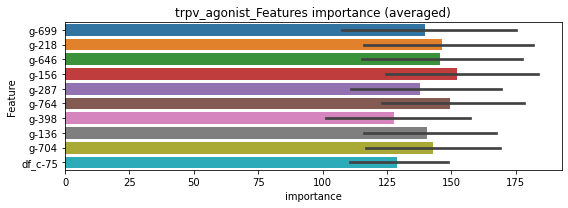

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345691	valid_1's binary_logloss: 0.0521589
[200]	training's binary_logloss: 0.00782598	valid_1's binary_logloss: 0.0214192
[300]	training's binary_logloss: 0.0024273	valid_1's binary_logloss: 0.0130662
[400]	training's binary_logloss: 0.00116589	valid_1's binary_logloss: 0.01062
[500]	training's binary_logloss: 0.000776652	valid_1's binary_logloss: 0.00993485
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000755465	valid_1's binary_logloss: 0.00989094


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342807	valid_1's binary_logloss: 0.0546452
[200]	training's binary_logloss: 0.0080253	valid_1's binary_logloss: 0.0230112
[300]	training's binary_logloss: 0.00260795	valid_1's binary_logloss: 0.0133302
[400]	training's binary_logloss: 0.0012435	valid_1's binary_logloss: 0.00962255
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000859361	valid_1's binary_logloss: 0.00853085


trpv_agonist logloss: 0.009210982124849573


neg labels: 3289 → selected neg labels: 3280


trpv_antagonist, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805666	valid_1's binary_logloss: 0.142005
[200]	training's binary_logloss: 0.0277624	valid_1's binary_logloss: 0.0917885
[300]	training's binary_logloss: 0.0103805	valid_1's binary_logloss: 0.0715765
[400]	training's binary_logloss: 0.00484198	valid_1's binary_logloss: 0.0627487
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00358483	valid_1's binary_logloss: 0.0599249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813477	valid_1's binary_logloss: 0.133953
[200]	training's binary_logloss: 0.0278994	valid_1's binary_logloss: 0.0772421
[300]	training's binary_logloss: 0.0100631	valid_1's binary_logloss: 0.0532733
[400]	training's binary_logloss: 0.00457791	valid_1's binary_logloss: 0.0422578
[500]	training's binary_logloss: 0.00274003	valid_1's binary_logloss: 0.038788
Early stopping, best iteration is:
[585]	training's 

1 / 3 AUC score:0.997
y_Threshold: 0.0442734, Threshold: 0.2657369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3788
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.23916, conf_1:0.29231
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.2657369
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_2: 0.2957369
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.3257369
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_4: 0.3557369
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_5: 0.3857369
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.4157369
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_7: 0.4457369
threshold: 0.4457369, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654285	valid_1's binary_logloss: 0.120204
[200]	training's binary_logloss: 0.0188415	valid_1's binary_logloss: 0.0708483
[300]	training's binary_logloss: 0.00670444	valid_1's binary_logloss: 0.0542528
[400]	training's binary_logloss: 0.00331359	valid_1's binary_logloss: 0.0488106
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00331359	valid_1's binary_logloss: 0.0488106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751287	valid_1's binary_logloss: 0.124903
[200]	training's binary_logloss: 0.022318	valid_1's binary_logloss: 0.0674617
[300]	training's binary_logloss: 0.00782274	valid_1's binary_logloss: 0.0475744
[400]	training's binary_logloss: 0.00378611	valid_1's binary_logloss: 0.039729
[500]	training's binary_logloss: 0.00232723	valid_1's binary_logloss: 0.0366514
Early stopping, best iteration is:
[535]	training's

2 / 3 AUC score:0.995
y_Threshold: 0.1396504, Threshold: 0.4457369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 631.0/3754
p_label_rate: 0.0168257 Vs.target_rate: 0.00202, Num_p_label: 67.0, conf_0:0.40116, conf_1:0.49031
Num_p_label: 67.0, Expected: 8.0, Adj_threshold_1: 0.4457369
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_2: 0.4757369
Num_p_label: 51.0, Expected: 8.0, Adj_threshold_3: 0.5057369
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_4: 0.5357369
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_5: 0.5657369
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_6: 0.5957369
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_7: 0.6257369
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_8: 0.6557369
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_9: 0.6857369
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_10: 0.7157369
threshold: 0.7457369, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 631.0/3754, y_label_rate: 0.1680874
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666614	valid_1's binary_logloss: 0.10126
[200]	training's binary_logloss: 0.018427	valid_1's binary_logloss: 0.0485418
[300]	training's binary_logloss: 0.00663028	valid_1's binary_logloss: 0.0310527
[400]	training's binary_logloss: 0.00329402	valid_1's binary_logloss: 0.0252867
[500]	training's binary_logloss: 0.00211773	valid_1's binary_logloss: 0.0233884
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00167412	valid_1's binary_logloss: 0.0223184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644846	valid_1's binary_logloss: 0.109132
[200]	training's binary_logloss: 0.0174097	valid_1's binary_logloss: 0.0567284
[300]	training's binary_logloss: 0.00626983	valid_1's binary_logloss: 0.0393988
[400]	training's binary_logloss: 0.00314486	valid_1's binary_logloss: 0.0316513
[500]	training's binary_logloss: 0.00202124	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1622910, Threshold: 0.7457369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 621.0/3734
p_label_rate: 0.0057760 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.67116, conf_1:0.82031
threshold: 0.7457369, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 644.0/7716, y_label_rate: 0.0834629


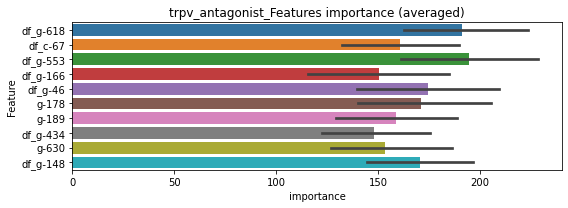

len(train_index) : 3858
len(valid_index) : 3858
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378824	valid_1's binary_logloss: 0.0721918
[200]	training's binary_logloss: 0.0110084	valid_1's binary_logloss: 0.0419967
[300]	training's binary_logloss: 0.00383883	valid_1's binary_logloss: 0.0321273
[400]	training's binary_logloss: 0.00183461	valid_1's binary_logloss: 0.0283834
[500]	training's binary_logloss: 0.00116199	valid_1's binary_logloss: 0.0265318
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.0010691	valid_1's binary_logloss: 0.0263696


len(train_index) : 3858
len(valid_index) : 3858
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407468	valid_1's binary_logloss: 0.0687722
[200]	training's binary_logloss: 0.0119642	valid_1's binary_logloss: 0.0374155
[300]	training's binary_logloss: 0.00437153	valid_1's binary_logloss: 0.0266232
[400]	training's binary_logloss: 0.00205797	valid_1's binary_logloss: 0.0226112
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00132362	valid_1's binary_logloss: 0.0211678


trpv_antagonist logloss: 0.023768681034420536


neg labels: 3289 → selected neg labels: 3253


tubulin_inhibitor, len(trt): 316, len(othr): 3253, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217377	valid_1's binary_logloss: 0.403761
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.204084	valid_1's binary_logloss: 0.401725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231495	valid_1's binary_logloss: 0.403792


1 / 3 AUC score:0.718
y_Threshold: 0.1984458, Threshold: 0.3441391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 801 → Positive_corect_labels: 315/3102
p_label_rate: 0.0100452 Vs.target_rate: 0.01327, Num_p_label: 40.0, conf_0:0.30973, conf_1:0.37855
threshold: 0.3441391, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 315.0/3102, y_label_rate: 0.1015474
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.139754	valid_1's binary_logloss: 0.391241
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.14416	valid_1's binary_logloss: 0.39104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103374	valid_1's binary_logloss: 0.241287
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0508865	valid_1's binary_logloss: 0.226606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109149	valid_1's binary_logloss: 0.239644


2 / 3 AUC score:0.872
y_Threshold: 0.1481473, Threshold: 0.3441391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 180.0/2832
p_label_rate: 0.0118031 Vs.target_rate: 0.01327, Num_p_label: 47.0, conf_0:0.30973, conf_1:0.37855
threshold: 0.3441391, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 180.0/2832, y_label_rate: 0.0635593
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0562802	valid_1's binary_logloss: 0.224151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458019	valid_1's binary_logloss: 0.146674
[200]	training's binary_logloss: 0.0137156	valid_1's binary_logloss: 0.135119
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0147271	valid_1's binary_logloss: 0.134738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440225	valid_1's binary_logloss: 0.13426


3 / 3 AUC score:0.938
y_Threshold: 0.0971432, Threshold: 0.3441391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 119.0/2710
p_label_rate: 0.0057760 Vs.target_rate: 0.01327, Num_p_label: 23.0, conf_0:0.30973, conf_1:0.37855
threshold: 0.3441391, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 142.0/6692, y_label_rate: 0.0212194


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0165697	valid_1's binary_logloss: 0.123488


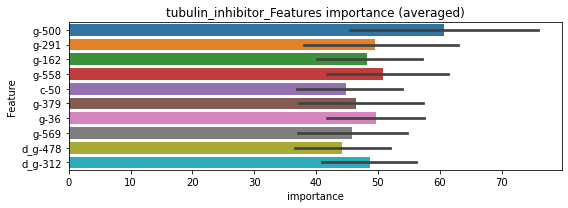

len(train_index) : 3346
len(valid_index) : 3346
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127729	valid_1's binary_logloss: 0.0535172
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00792389	valid_1's binary_logloss: 0.0511863


len(train_index) : 3346
len(valid_index) : 3346
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds


tubulin_inhibitor logloss: 0.05485614296812646


[100]	training's binary_logloss: 0.0118927	valid_1's binary_logloss: 0.060873
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00850561	valid_1's binary_logloss: 0.058526
neg labels: 3289 → selected neg labels: 3281


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119376	valid_1's binary_logloss: 0.202472
[200]	training's binary_logloss: 0.0498417	valid_1's binary_logloss: 0.144527
[300]	training's binary_logloss: 0.0222507	valid_1's binary_logloss: 0.120923
[400]	training's binary_logloss: 0.0100916	valid_1's binary_logloss: 0.108238
[500]	training's binary_logloss: 0.00518988	valid_1's binary_logloss: 0.101661
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0046231	valid_1's binary_logloss: 0.100618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132151	valid_1's binary_logloss: 0.194525
[200]	training's binary_logloss: 0.0546915	valid_1's binary_logloss: 0.127058
[300]	training's binary_logloss: 0.0231145	valid_1's binary_logloss: 0.0945409
[400]	training's binary_logloss: 0.0103985	valid_1's binary_logloss: 0.0810641
Early stopping, best iteration is:
[472]	training's binary_log

1 / 3 AUC score:0.989
y_Threshold: 0.0486645, Threshold: 0.3243677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 626/3745
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.29193, conf_1:0.35680
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.3243677
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_2: 0.3543677
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_3: 0.3843677
threshold: 0.3843677, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 626.0/3745, y_label_rate: 0.1671562
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115293	valid_1's binary_logloss: 0.16626
[200]	training's binary_logloss: 0.0478556	valid_1's binary_logloss: 0.0988356
[300]	training's binary_logloss: 0.0195513	valid_1's binary_logloss: 0.0644677
[400]	training's binary_logloss: 0.00864174	valid_1's binary_logloss: 0.0467094
[500]	training's binary_logloss: 0.00451867	valid_1's binary_logloss: 0.0386054
[600]	training's binary_logloss: 0.00288701	valid_1's binary_logloss: 0.0347498
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00267789	valid_1's binary_logloss: 0.0342232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115958	valid_1's binary_logloss: 0.191428
[200]	training's binary_logloss: 0.0411718	valid_1's binary_logloss: 0.120061
[300]	training's binary_logloss: 0.0173841	valid_1's binary_logloss: 0.0950307
[400]	training's binary_logloss: 0.0076984	valid_1's bi

2 / 3 AUC score:0.997
y_Threshold: 0.1148085, Threshold: 0.3843677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 606.0/3705
p_label_rate: 0.0178302 Vs.target_rate: 0.00307, Num_p_label: 71.0, conf_0:0.34593, conf_1:0.42280
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_1: 0.3843677
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_2: 0.4143677
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_3: 0.4443677
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_4: 0.4743677
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_5: 0.5043677
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_6: 0.5343677
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_7: 0.5643677
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_8: 0.5943677
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_9: 0.6243677
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_10: 0.6543677
threshold: 0.6843677, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 606.0/3705, y_label_rate: 0.16356

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104005	valid_1's binary_logloss: 0.159491
[200]	training's binary_logloss: 0.0393372	valid_1's binary_logloss: 0.0986199
[300]	training's binary_logloss: 0.0159142	valid_1's binary_logloss: 0.0687401
[400]	training's binary_logloss: 0.00722866	valid_1's binary_logloss: 0.0550969
[500]	training's binary_logloss: 0.00386894	valid_1's binary_logloss: 0.049114
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00321655	valid_1's binary_logloss: 0.0477242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115398	valid_1's binary_logloss: 0.179205
[200]	training's binary_logloss: 0.0376713	valid_1's binary_logloss: 0.105572
[300]	training's binary_logloss: 0.0151541	valid_1's binary_logloss: 0.0807609
[400]	training's binary_logloss: 0.00736403	valid_1's binary_logloss: 0.0702624
Early stopping, best iteration is:
[424]	training's bin

3 / 3 AUC score:0.997
y_Threshold: 0.1112255, Threshold: 0.6843677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 578.0/3649
p_label_rate: 0.0087896 Vs.target_rate: 0.00307, Num_p_label: 35.0, conf_0:0.61593, conf_1:0.75280
threshold: 0.6843677, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 613.0/7631, y_label_rate: 0.0803302


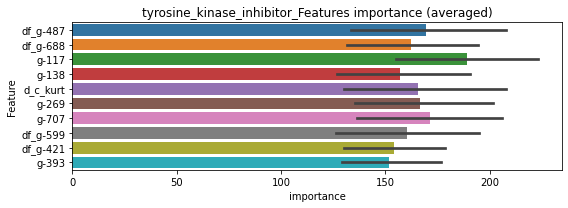

len(train_index) : 3815
len(valid_index) : 3816
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594301	valid_1's binary_logloss: 0.0995162
[200]	training's binary_logloss: 0.021992	valid_1's binary_logloss: 0.0681176
[300]	training's binary_logloss: 0.00863169	valid_1's binary_logloss: 0.0557539
[400]	training's binary_logloss: 0.00386561	valid_1's binary_logloss: 0.0506962
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00264747	valid_1's binary_logloss: 0.0495262


len(train_index) : 3816
len(valid_index) : 3815
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652357	valid_1's binary_logloss: 0.0966349
[200]	training's binary_logloss: 0.0239768	valid_1's binary_logloss: 0.0585598
[300]	training's binary_logloss: 0.00990779	valid_1's binary_logloss: 0.0442527
[400]	training's binary_logloss: 0.00463196	valid_1's binary_logloss: 0.0373165
[500]	training's binary_logloss: 0.00237062	valid_1's binary_logloss: 0.0332458
[600]	training's binary_logloss: 0.00152425	valid_1's binary_logloss: 0.0312511
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00152425	valid_1's binary_logloss: 0.0312511


tyrosine_kinase_inhibitor logloss: 0.04038983986800529


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505003	valid_1's binary_logloss: 0.0644143
[200]	training's binary_logloss: 0.009766	valid_1's binary_logloss: 0.0187913
[300]	training's binary_logloss: 0.00266169	valid_1's binary_logloss: 0.00791371
[400]	training's binary_logloss: 0.00134207	valid_1's binary_logloss: 0.00534882
[500]	training's binary_logloss: 0.000977505	valid_1's binary_logloss: 0.00449759
[600]	training's binary_logloss: 0.00080407	valid_1's binary_logloss: 0.00410512
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000759459	valid_1's binary_logloss: 0.0039717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514566	valid_1's binary_logloss: 0.072913
[200]	training's binary_logloss: 0.00874487	valid_1's binary_logloss: 0.0220432
[300]	training's binary_logloss: 0.00256931	valid_1's binary_logloss: 0.0112102
[400]	training's binary_logloss: 0.0013374

1 / 3 AUC score:1.000
y_Threshold: 0.0103330, Threshold: 0.0846874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.07622, conf_1:0.09316
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0846874
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.1146874
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.1446874
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.1746874
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.2046874
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_6: 0.2346874
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.2646874
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.2946874
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.3246874
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.3546874
threshold: 0.3846874, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423922	valid_1's binary_logloss: 0.0568401
[200]	training's binary_logloss: 0.00703762	valid_1's binary_logloss: 0.0138917
[300]	training's binary_logloss: 0.00212686	valid_1's binary_logloss: 0.00579146
[400]	training's binary_logloss: 0.00114167	valid_1's binary_logloss: 0.00366559
[500]	training's binary_logloss: 0.000835565	valid_1's binary_logloss: 0.00293945
[600]	training's binary_logloss: 0.000710509	valid_1's binary_logloss: 0.00260066
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000710509	valid_1's binary_logloss: 0.00260066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415871	valid_1's binary_logloss: 0.0580714
[200]	training's binary_logloss: 0.00700839	valid_1's binary_logloss: 0.0151533
[300]	training's binary_logloss: 0.00215873	valid_1's binary_logloss: 0.00637481
[400]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.3395485, Threshold: 0.3846874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0067805 Vs.target_rate: 0.00050, Num_p_label: 27.0, conf_0:0.34622, conf_1:0.42316
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_1: 0.3846874
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.4146874
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.4446874
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_4: 0.4746874
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.5046874
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_6: 0.5346874
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_7: 0.5646874
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.5946874
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.6246874
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.6546874
threshold: 0.6846874, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423922	valid_1's binary_logloss: 0.0568401
[200]	training's binary_logloss: 0.00703762	valid_1's binary_logloss: 0.0138917
[300]	training's binary_logloss: 0.00212686	valid_1's binary_logloss: 0.00579146
[400]	training's binary_logloss: 0.00114167	valid_1's binary_logloss: 0.00366559
[500]	training's binary_logloss: 0.000835565	valid_1's binary_logloss: 0.00293945
[600]	training's binary_logloss: 0.000710509	valid_1's binary_logloss: 0.00260066
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000710509	valid_1's binary_logloss: 0.00260066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415871	valid_1's binary_logloss: 0.0580714
[200]	training's binary_logloss: 0.00700839	valid_1's binary_logloss: 0.0151533
[300]	training's binary_logloss: 0.00215873	valid_1's binary_logloss: 0.00637481
[400]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.3395485, Threshold: 0.6846874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.61622, conf_1:0.75316
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.6846874
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.7146874
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.7446874
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.7746874
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.8046874
threshold: 0.8046874, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


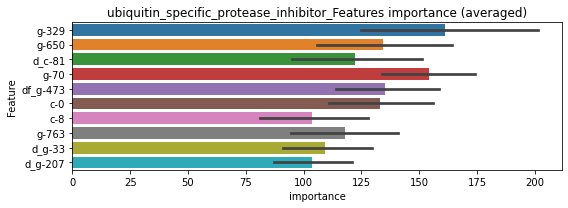

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249915	valid_1's binary_logloss: 0.0361767
[200]	training's binary_logloss: 0.00456359	valid_1's binary_logloss: 0.0118205
[300]	training's binary_logloss: 0.00130112	valid_1's binary_logloss: 0.00613863
[400]	training's binary_logloss: 0.000668776	valid_1's binary_logloss: 0.00440233
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000488561	valid_1's binary_logloss: 0.00385758


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270878	valid_1's binary_logloss: 0.0364968
[200]	training's binary_logloss: 0.00473575	valid_1's binary_logloss: 0.0104794
[300]	training's binary_logloss: 0.00131154	valid_1's binary_logloss: 0.00488267
[400]	training's binary_logloss: 0.000694327	valid_1's binary_logloss: 0.00342828
[500]	training's binary_logloss: 0.00050902	valid_1's binary_logloss: 0.00286774
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000436441	valid_1's binary_logloss: 0.00265469


ubiquitin_specific_protease_inhibitor logloss: 0.0032561358631489363


neg labels: 3289 → selected neg labels: 3264


vegfr_inhibitor, len(trt): 170, len(othr): 3264, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151647	valid_1's binary_logloss: 0.278017
[200]	training's binary_logloss: 0.0769309	valid_1's binary_logloss: 0.233245
[300]	training's binary_logloss: 0.0392006	valid_1's binary_logloss: 0.21159
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0257155	valid_1's binary_logloss: 0.205246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169658	valid_1's binary_logloss: 0.286469
[200]	training's binary_logloss: 0.0894723	valid_1's binary_logloss: 0.239161
[300]	training's binary_logloss: 0.04817	valid_1's binary_logloss: 0.214498
[400]	training's binary_logloss: 0.0271438	valid_1's binary_logloss: 0.202573
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.026953	valid_1's binary_logloss: 0.202474


1 / 3 AUC score:0.936
y_Threshold: 0.1355609, Threshold: 0.4981730, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 348 → Positive_corect_labels: 544/3568
p_label_rate: 0.0100452 Vs.target_rate: 0.00714, Num_p_label: 40.0, conf_0:0.44836, conf_1:0.54799
threshold: 0.4981730, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 544.0/3568, y_label_rate: 0.1524664
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122409	valid_1's binary_logloss: 0.235469
[200]	training's binary_logloss: 0.0498461	valid_1's binary_logloss: 0.18781
[300]	training's binary_logloss: 0.0212046	valid_1's binary_logloss: 0.171829
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0147738	valid_1's binary_logloss: 0.166382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124568	valid_1's binary_logloss: 0.227725
[200]	training's binary_logloss: 0.0511613	valid_1's binary_logloss: 0.17389
[300]	training's binary_logloss: 0.0228438	valid_1's binary_logloss: 0.151363
[400]	training's binary_logloss: 0.0109341	valid_1's binary_logloss: 0.142111


2 / 3 AUC score:0.967
y_Threshold: 0.1398027, Threshold: 0.4981730, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00777369	valid_1's binary_logloss: 0.138346


Remove_noisy_labels: 172 → Positive_corect_labels: 458.0/3396
p_label_rate: 0.0215972 Vs.target_rate: 0.00714, Num_p_label: 86.0, conf_0:0.44836, conf_1:0.54799
Num_p_label: 86.0, Expected: 28.4, Adj_threshold_1: 0.4981730
Num_p_label: 74.0, Expected: 28.4, Adj_threshold_2: 0.5281730
Num_p_label: 66.0, Expected: 28.4, Adj_threshold_3: 0.5581730
Num_p_label: 55.0, Expected: 28.4, Adj_threshold_4: 0.5881730
threshold: 0.5881730, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 458.0/3396, y_label_rate: 0.1348645
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978876	valid_1's binary_logloss: 0.183716
[200]	training's binary_logloss: 0.0356484	valid_1's binary_logloss: 0.124775
[300]	training's binary_logloss: 0.0141073	valid_1's binary_logloss: 0.0999644
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0124312	valid_1's binary_logloss: 0.0975111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923392	valid_1's binary_logloss: 0.17997
[200]	training's binary_logloss: 0.0324359	valid_1's binary_logloss: 0.128241
[300]	training's binary_logloss: 0.0132259	valid_1's binary_logloss: 0.110465
[400]	training's binary_logloss: 0.00628884	valid_1's binary_logloss: 0.101807
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00501781	valid_1's binary_logloss: 0.100202


3 / 3 AUC score:0.985
y_Threshold: 0.1486274, Threshold: 0.5881730, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 415.0/3310
p_label_rate: 0.0140633 Vs.target_rate: 0.00714, Num_p_label: 56.0, conf_0:0.52936, conf_1:0.64699
threshold: 0.5881730, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 471.0/7292, y_label_rate: 0.0645913


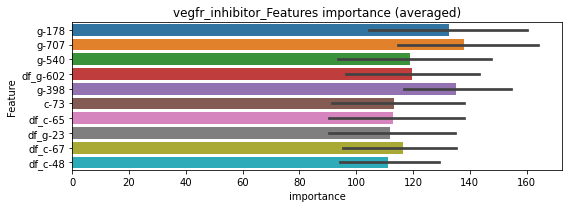

len(train_index) : 3646
len(valid_index) : 3646
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548562	valid_1's binary_logloss: 0.109684
[200]	training's binary_logloss: 0.0208789	valid_1's binary_logloss: 0.0817707
[300]	training's binary_logloss: 0.00863909	valid_1's binary_logloss: 0.0716806


len(train_index) : 3646
len(valid_index) : 3646
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00519935	valid_1's binary_logloss: 0.0685077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526996	valid_1's binary_logloss: 0.10612
[200]	training's binary_logloss: 0.0205949	valid_1's binary_logloss: 0.0819728
[300]	training's binary_logloss: 0.00833868	valid_1's binary_logloss: 0.0735814


vegfr_inhibitor logloss: 0.06933509367155379


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00447127	valid_1's binary_logloss: 0.0701625
neg labels: 3289 → selected neg labels: 3286


vitamin_b, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711066	valid_1's binary_logloss: 0.0966995
[200]	training's binary_logloss: 0.0190205	valid_1's binary_logloss: 0.0370589
[300]	training's binary_logloss: 0.00560355	valid_1's binary_logloss: 0.0181345
[400]	training's binary_logloss: 0.00242562	valid_1's binary_logloss: 0.0123284
[500]	training's binary_logloss: 0.00153663	valid_1's binary_logloss: 0.0102174
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00125212	valid_1's binary_logloss: 0.00925768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684542	valid_1's binary_logloss: 0.100511
[200]	training's binary_logloss: 0.0163618	valid_1's binary_logloss: 0.0425619
[300]	training's binary_logloss: 0.00494194	valid_1's binary_logloss: 0.0245433
[400]	training's binary_logloss: 0.00224193	valid_1's binary_logloss: 0.0184343
[500]	training's binary_logloss: 0.00146518	val

1 / 3 AUC score:1.000
y_Threshold: 0.0199453, Threshold: 0.0909249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.08183, conf_1:0.10002
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0909249
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_2: 0.1209249
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_3: 0.1509249
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_4: 0.1809249
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_5: 0.2109249
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_6: 0.2409249
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_7: 0.2709249
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_8: 0.3009249
threshold: 0.3009249, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602969	valid_1's binary_logloss: 0.0833403
[200]	training's binary_logloss: 0.0140676	valid_1's binary_logloss: 0.0298506
[300]	training's binary_logloss: 0.00443849	valid_1's binary_logloss: 0.0145099
[400]	training's binary_logloss: 0.00213995	valid_1's binary_logloss: 0.00963645
[500]	training's binary_logloss: 0.00138219	valid_1's binary_logloss: 0.00767679
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00128055	valid_1's binary_logloss: 0.00740332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657348	valid_1's binary_logloss: 0.0924111
[200]	training's binary_logloss: 0.0144361	valid_1's binary_logloss: 0.0318601
[300]	training's binary_logloss: 0.0044396	valid_1's binary_logloss: 0.0157113
[400]	training's binary_logloss: 0.00210134	valid_1's binary_logloss: 0.0104917
[500]	training's binary_logloss: 0.00138443	v

2 / 3 AUC score:1.000
y_Threshold: 0.2585295, Threshold: 0.3009249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0067805 Vs.target_rate: 0.00109, Num_p_label: 27.0, conf_0:0.27083, conf_1:0.33102
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_1: 0.3009249
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_2: 0.3309249
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_3: 0.3609249
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_4: 0.3909249
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_5: 0.4209249
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_6: 0.4509249
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_7: 0.4809249
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_8: 0.5109249
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_9: 0.5409249
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_10: 0.5709249
threshold: 0.6009249, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621261	valid_1's binary_logloss: 0.0873758
[200]	training's binary_logloss: 0.0141342	valid_1's binary_logloss: 0.0328946
[300]	training's binary_logloss: 0.00436515	valid_1's binary_logloss: 0.0180964
[400]	training's binary_logloss: 0.00205961	valid_1's binary_logloss: 0.0127713
[500]	training's binary_logloss: 0.00136382	valid_1's binary_logloss: 0.0107024
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00128535	valid_1's binary_logloss: 0.0105473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064058	valid_1's binary_logloss: 0.0933779
[200]	training's binary_logloss: 0.0143954	valid_1's binary_logloss: 0.0360129
[300]	training's binary_logloss: 0.00440463	valid_1's binary_logloss: 0.0186365
[400]	training's binary_logloss: 0.0021218	valid_1's binary_logloss: 0.0125779
[500]	training's binary_logloss: 0.00140912	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1379414, Threshold: 0.6009249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.54083, conf_1:0.66102
threshold: 0.6009249, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7789, y_label_rate: 0.0849917


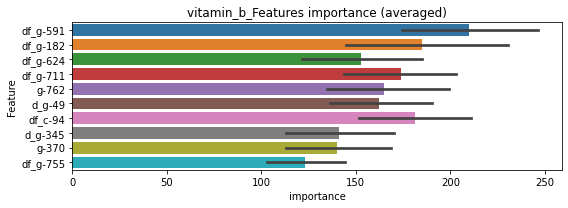

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400772	valid_1's binary_logloss: 0.0605943
[200]	training's binary_logloss: 0.00946044	valid_1's binary_logloss: 0.0229936
[300]	training's binary_logloss: 0.00271689	valid_1's binary_logloss: 0.0121497
[400]	training's binary_logloss: 0.00120555	valid_1's binary_logloss: 0.00888372
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000822322	valid_1's binary_logloss: 0.00784597


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366935	valid_1's binary_logloss: 0.056416
[200]	training's binary_logloss: 0.0089417	valid_1's binary_logloss: 0.0228009
[300]	training's binary_logloss: 0.00258173	valid_1's binary_logloss: 0.0120357
[400]	training's binary_logloss: 0.00116731	valid_1's binary_logloss: 0.00854726
[500]	training's binary_logloss: 0.000775568	valid_1's binary_logloss: 0.0075108
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000688781	valid_1's binary_logloss: 0.00715107


vitamin_b logloss: 0.00749856664594286


neg labels: 3289 → selected neg labels: 3284


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3284, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968107	valid_1's binary_logloss: 0.147621
[200]	training's binary_logloss: 0.0333326	valid_1's binary_logloss: 0.0861881
[300]	training's binary_logloss: 0.0120753	valid_1's binary_logloss: 0.0561709
[400]	training's binary_logloss: 0.00518881	valid_1's binary_logloss: 0.0418346
[500]	training's binary_logloss: 0.00291682	valid_1's binary_logloss: 0.0346944
[600]	training's binary_logloss: 0.00201123	valid_1's binary_logloss: 0.030913
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00175663	valid_1's binary_logloss: 0.0295991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888331	valid_1's binary_logloss: 0.136469
[200]	training's binary_logloss: 0.0298431	valid_1's binary_logloss: 0.0755605
[300]	training's binary_logloss: 0.0100227	valid_1's binary_logloss: 0.0520853
[400]	training's binary_logloss: 0.0044744	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0423014, Threshold: 0.2206304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00164, Num_p_label: 40.0, conf_0:0.19857, conf_1:0.24269
Num_p_label: 40.0, Expected: 6.5, Adj_threshold_1: 0.2206304
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_2: 0.2506304
Num_p_label: 26.0, Expected: 6.5, Adj_threshold_3: 0.2806304
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_4: 0.3106304
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_5: 0.3406304
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_6: 0.3706304
threshold: 0.3706304, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084136	valid_1's binary_logloss: 0.132173
[200]	training's binary_logloss: 0.0263135	valid_1's binary_logloss: 0.0678798
[300]	training's binary_logloss: 0.00885625	valid_1's binary_logloss: 0.042131
[400]	training's binary_logloss: 0.00390812	valid_1's binary_logloss: 0.0320468
[500]	training's binary_logloss: 0.00235901	valid_1's binary_logloss: 0.0277826
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00181001	valid_1's binary_logloss: 0.0260481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082256	valid_1's binary_logloss: 0.128616
[200]	training's binary_logloss: 0.0243705	valid_1's binary_logloss: 0.0639272
[300]	training's binary_logloss: 0.00831332	valid_1's binary_logloss: 0.0412638
[400]	training's binary_logloss: 0.00377378	valid_1's binary_logloss: 0.0329986
[500]	training's binary_logloss: 0.00231366	valid_1'

2 / 3 AUC score:0.999
y_Threshold: 0.2103178, Threshold: 0.3706304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 638.0/3772
p_label_rate: 0.0145655 Vs.target_rate: 0.00164, Num_p_label: 58.0, conf_0:0.33357, conf_1:0.40769
Num_p_label: 58.0, Expected: 6.5, Adj_threshold_1: 0.3706304
Num_p_label: 49.0, Expected: 6.5, Adj_threshold_2: 0.4006304
Num_p_label: 43.0, Expected: 6.5, Adj_threshold_3: 0.4306304
Num_p_label: 38.0, Expected: 6.5, Adj_threshold_4: 0.4606304
Num_p_label: 36.0, Expected: 6.5, Adj_threshold_5: 0.4906304
Num_p_label: 34.0, Expected: 6.5, Adj_threshold_6: 0.5206304
Num_p_label: 27.0, Expected: 6.5, Adj_threshold_7: 0.5506304
Num_p_label: 22.0, Expected: 6.5, Adj_threshold_8: 0.5806304
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_9: 0.6106304
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_10: 0.6406304
threshold: 0.6706304, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 638.0/3772, y_label_rate: 0.1691410
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814457	valid_1's binary_logloss: 0.11887
[200]	training's binary_logloss: 0.0240386	valid_1's binary_logloss: 0.053073
[300]	training's binary_logloss: 0.00858585	valid_1's binary_logloss: 0.0309474
[400]	training's binary_logloss: 0.00392324	valid_1's binary_logloss: 0.022051
[500]	training's binary_logloss: 0.00232639	valid_1's binary_logloss: 0.0187871
[600]	training's binary_logloss: 0.0016905	valid_1's binary_logloss: 0.0165769
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00154294	valid_1's binary_logloss: 0.0163153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853785	valid_1's binary_logloss: 0.130356
[200]	training's binary_logloss: 0.0254043	valid_1's binary_logloss: 0.0660679
[300]	training's binary_logloss: 0.00846031	valid_1's binary_logloss: 0.0422584
[400]	training's binary_logloss: 0.0038737	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1590392, Threshold: 0.6706304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 631.0/3758
p_label_rate: 0.0047715 Vs.target_rate: 0.00164, Num_p_label: 19.0, conf_0:0.60357, conf_1:0.73769
threshold: 0.6706304, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 650.0/7740, y_label_rate: 0.0839793


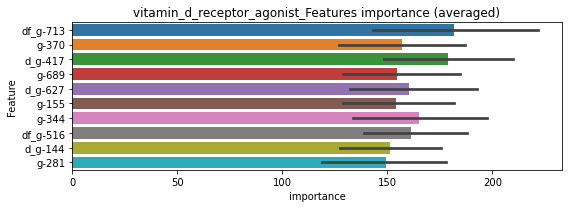

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050379	valid_1's binary_logloss: 0.0809619
[200]	training's binary_logloss: 0.0160852	valid_1's binary_logloss: 0.0412872
[300]	training's binary_logloss: 0.00577892	valid_1's binary_logloss: 0.0264844
[400]	training's binary_logloss: 0.00242339	valid_1's binary_logloss: 0.0210396
[500]	training's binary_logloss: 0.00136006	valid_1's binary_logloss: 0.0187241
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00132468	valid_1's binary_logloss: 0.0186196


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500729	valid_1's binary_logloss: 0.0778776
[200]	training's binary_logloss: 0.0158991	valid_1's binary_logloss: 0.0386942
[300]	training's binary_logloss: 0.00543683	valid_1's binary_logloss: 0.0244034
[400]	training's binary_logloss: 0.00243114	valid_1's binary_logloss: 0.0190613
[500]	training's binary_logloss: 0.00138668	valid_1's binary_logloss: 0.0167301
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00121139	valid_1's binary_logloss: 0.0164315


vitamin_d_receptor_agonist logloss: 0.017525568848188133


neg labels: 3289 → selected neg labels: 3287


wnt_inhibitor, len(trt): 30, len(othr): 3287, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712104	valid_1's binary_logloss: 0.123591
[200]	training's binary_logloss: 0.0208438	valid_1's binary_logloss: 0.0642295
[300]	training's binary_logloss: 0.00689785	valid_1's binary_logloss: 0.0413375
[400]	training's binary_logloss: 0.00312646	valid_1's binary_logloss: 0.0321993
[500]	training's binary_logloss: 0.0019521	valid_1's binary_logloss: 0.0286588
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00173222	valid_1's binary_logloss: 0.0280121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784846	valid_1's binary_logloss: 0.113822
[200]	training's binary_logloss: 0.0236111	valid_1's binary_logloss: 0.0534709
[300]	training's binary_logloss: 0.00794712	valid_1's binary_logloss: 0.0308632
[400]	training's binary_logloss: 0.00345232	valid_1's binary_logloss: 0.0217068
[500]	training's binary_logloss: 0.00209528	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0289703, Threshold: 0.2508844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.22580, conf_1:0.27597
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.2508844
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_2: 0.2808844
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_3: 0.3108844
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.3408844
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_5: 0.3708844
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_6: 0.4008844
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_7: 0.4308844
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_8: 0.4608844
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.4908844
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_10: 0.5208844
threshold: 0.5508844, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689463	valid_1's binary_logloss: 0.102218
[200]	training's binary_logloss: 0.018979	valid_1's binary_logloss: 0.0418603
[300]	training's binary_logloss: 0.00630881	valid_1's binary_logloss: 0.0216111
[400]	training's binary_logloss: 0.00287806	valid_1's binary_logloss: 0.0150606
[500]	training's binary_logloss: 0.00183465	valid_1's binary_logloss: 0.012636
[600]	training's binary_logloss: 0.00139234	valid_1's binary_logloss: 0.0114464
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00128942	valid_1's binary_logloss: 0.0110513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644697	valid_1's binary_logloss: 0.112888
[200]	training's binary_logloss: 0.0168711	valid_1's binary_logloss: 0.0557988
[300]	training's binary_logloss: 0.00586489	valid_1's binary_logloss: 0.0362817
[400]	training's binary_logloss: 0.00274434	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.1953685, Threshold: 0.5508844, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00170977	valid_1's binary_logloss: 0.0220737


Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3802
p_label_rate: 0.0075339 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.49580, conf_1:0.60597
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.5508844
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_2: 0.5808844
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.6108844
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_4: 0.6408844
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.6708844
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.7008844
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.7308844
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.7608844
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_9: 0.7908844
threshold: 0.7908844, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3802, y_label_rate: 0.1714887
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656175	valid_1's binary_logloss: 0.0931173
[200]	training's binary_logloss: 0.0184798	valid_1's binary_logloss: 0.0387195
[300]	training's binary_logloss: 0.00632248	valid_1's binary_logloss: 0.0207951
[400]	training's binary_logloss: 0.00287867	valid_1's binary_logloss: 0.0139157
[500]	training's binary_logloss: 0.00181543	valid_1's binary_logloss: 0.0110328
[600]	training's binary_logloss: 0.00140112	valid_1's binary_logloss: 0.00991312
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00136025	valid_1's binary_logloss: 0.00976776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06742	valid_1's binary_logloss: 0.115593
[200]	training's binary_logloss: 0.0181734	valid_1's binary_logloss: 0.051857
[300]	training's binary_logloss: 0.00585701	valid_1's binary_logloss: 0.0280969
[400]	training's binary_logloss: 0.00269035	valid

3 / 3 AUC score:1.000
y_Threshold: 0.2349269, Threshold: 0.7908844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 649.0/3796
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.71180, conf_1:0.86997
threshold: 0.7908844, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 659.0/7778, y_label_rate: 0.0847262


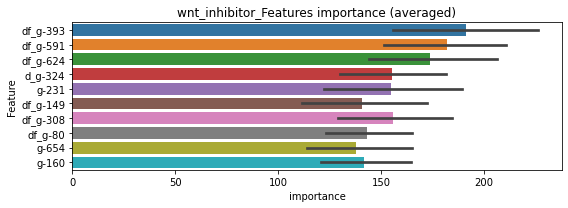

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411502	valid_1's binary_logloss: 0.0669237
[200]	training's binary_logloss: 0.0114876	valid_1's binary_logloss: 0.0324568
[300]	training's binary_logloss: 0.00369695	valid_1's binary_logloss: 0.0187321
[400]	training's binary_logloss: 0.0016088	valid_1's binary_logloss: 0.0129509
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.0010542	valid_1's binary_logloss: 0.0116284


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407115	valid_1's binary_logloss: 0.068595
[200]	training's binary_logloss: 0.0104456	valid_1's binary_logloss: 0.030428
[300]	training's binary_logloss: 0.00357889	valid_1's binary_logloss: 0.0180515
[400]	training's binary_logloss: 0.00165031	valid_1's binary_logloss: 0.0134417
[500]	training's binary_logloss: 0.00102794	valid_1's binary_logloss: 0.0113377
[600]	training's binary_logloss: 0.000786257	valid_1's binary_logloss: 0.0104064
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000802445	valid_1's binary_logloss: 0.0103627


wnt_inhibitor logloss: 0.010995548850718255


In [44]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    #if DEBUG:
    #    feature_importance_df = create_featureimprotance(models, feature_importance_df)
    #    importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [45]:
sub.to_csv('submission.csv', index=False)

In [46]:
print(f"CV:{np.mean(scores)}")

CV:0.027042264356512778


In [47]:
#if DEBUG:
#    show_feature_importance(feature_importance_df)
#    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
#    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)